[Kaggle Simpson Characters Data sit](https://www.kaggle.com/alexattia/the-simpsons-characters-dataset)

In [2]:
# import relative packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
import h5py
import glob

from sklearn.model_selection import train_test_split
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam



/home/yinyunjie/anaconda3/envs/keras/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Using TensorFlow backend.


## Data Preprocessing

In [5]:
# Label Encoding
map_characters = {0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson', 
        3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
        7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson', 
        11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak', 
        14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'}

img_width = 42
img_height = 42

num_classes = len(map_characters)
pictures_per_class = 1000
test_size = 0.15

imgs_path = '/media/yinyunjie/WD_HDD/dataSets/simpsons-characters/data/simpsons_train_dataset'

In [ ]:
def load_pictures():
    pics = []
    labels = []
    
    for k, v in map_characters.items():
        pictures = [k for k in glob.glob(imgs_path + '/' + v + '/*')]
        print(v + ":" + str(len(pictures)))
        for i, pic in enumerate(pictures):
            tmp_img = cv2.imread(pic)
            
            tmp_img = cv2.cvtColor(tmp_img, cv2.COLOR_BGR2RGB)
            tmp_img = cv2.resize(tmp_img, (img_height, img_width))
            pics.append(tmp_img)
            labels.append(k)
    
    return np.array(pics), np.array(labels)

def get_dataset(save=False, load=False):
    if load:
        # data
        h5f = h5py.File('dataset.h5', 'r')
        X_train = h5f['X_train'][:]
        X_test = h5f['X_test'][:]
        h5f.close()
        
        # labels
        h5f = h5py.File('labels.h5', 'r')
        y_train = h5f['y_train'][:]
        y_test = h5f['y_test'][:]
        h5f.close()
    else:
        X, y = load_pictures()
        y = keras.utils.to_categorical(y, num_classes) # one-hot
        
        # Split train data:(train:85%, val:15%)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
        if save:
            h5f = h5py.File('simpson_train_data.h5', 'w')
            h5f.create_dataset('X_train', data=X_train)
            h5f.create_dataset('X_test', data=X_test)
            h5f.close()
            
            h5f = h5py.File('labels.h5', 'w')
            h5f.create_dataset('y_train', data=y_train)
            h5f.create_dataset('y_test', data=y_test)
            h5f.close()
            
    X_train = X_train.astype('float32') / 255.
    X_test = X_test.astype('float32') / 255.
    print('Train', X_train.shape, y_train.shape)
    print('Test', X_test.shape, y_test.shape)
    
    return X_train, X_test, y_train, y_test


In [27]:
# Get train data and val data
X_train, X_test, y_train, y_test = get_dataset(save=True, load=False)

abraham_grampa_simpson:913


apu_nahasapeemapetilon:623


bart_simpson:1342


charles_montgomery_burns:1193


chief_wiggum:986


comic_book_guy:469


edna_krabappel:457


homer_simpson:2246


kent_brockman:498


krusty_the_clown:1206


lisa_simpson:1354


marge_simpson:1291


milhouse_van_houten:1079


moe_szyslak:1452


ned_flanders:1454


nelson_muntz:358


principal_skinner:1194


sideshow_bob:877


Train (16143, 42, 42, 3) (16143, 18)
Test (2849, 42, 42, 3) (2849, 18)


## Model

In [10]:
def create_model_six_conv(input_shape):
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

model = create_model_six_conv((img_height, img_width, 3))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 42, 42, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 18, 18, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 64)          0         
__________

In [11]:
lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

## Training

In [12]:
def lr_schedule(epoch):
    return lr * (0.1 ** int(epoch / 10))

batch_size = 32
epochs = 10

history = model.fit(X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_test, y_test),
        shuffle=True,
        callbacks=[LearningRateScheduler(lr_schedule),
                ModelCheckpoint('simpson_model.h5', save_best_only=True)])

Train on 16143 samples, validate on 2849 samples
Epoch 1/10


   32/16143 [..............................] - ETA: 8:50 - loss: 2.8849 - acc: 0.1562

   64/16143 [..............................] - ETA: 6:08 - loss: 2.8871 - acc: 0.1250

   96/16143 [..............................] - ETA: 5:10 - loss: 2.8898 - acc: 0.0833

  128/16143 [..............................] - ETA: 4:35 - loss: 2.8929 - acc: 0.0703

  160/16143 [..............................] - ETA: 4:11 - loss: 2.8917 - acc: 0.0750

  192/16143 [..............................] - ETA: 3:54 - loss: 2.8914 - acc: 0.0625

  224/16143 [..............................] - ETA: 3:42 - loss: 2.8903 - acc: 0.0670

  256/16143 [..............................] - ETA: 3:33 - loss: 2.8863 - acc: 0.0703

  288/16143 [..............................] - ETA: 3:26 - loss: 2.8853 - acc: 0.0729

  320/16143 [..............................] - ETA: 3:21 - loss: 2.8854 - acc: 0.0781

  352/16143 [..............................] - ETA: 3:16 - loss: 2.8864 - acc: 0.0739

  384/16143 [..............................] - ETA: 3:12 - loss: 2.8858 - acc: 0.0781

  416/16143 [..............................] - ETA: 3:08 - loss: 2.8824 - acc: 0.0817

  448/16143 [..............................] - ETA: 3:05 - loss: 2.8824 - acc: 0.0804

  480/16143 [..............................] - ETA: 3:02 - loss: 2.8792 - acc: 0.0875

  512/16143 [..............................] - ETA: 3:00 - loss: 2.8772 - acc: 0.0918

  544/16143 [>.............................] - ETA: 2:58 - loss: 2.8714 - acc: 0.0938

  576/16143 [>.............................] - ETA: 2:56 - loss: 2.8658 - acc: 0.0990

  608/16143 [>.............................] - ETA: 2:55 - loss: 2.8621 - acc: 0.1003

  640/16143 [>.............................] - ETA: 2:53 - loss: 2.8531 - acc: 0.1094

  672/16143 [>.............................] - ETA: 2:52 - loss: 2.8501 - acc: 0.1101

  704/16143 [>.............................] - ETA: 2:50 - loss: 2.8508 - acc: 0.1065

  736/16143 [>.............................] - ETA: 2:49 - loss: 2.8536 - acc: 0.1046

  768/16143 [>.............................] - ETA: 2:48 - loss: 2.8517 - acc: 0.1068

  800/16143 [>.............................] - ETA: 2:47 - loss: 2.8480 - acc: 0.1075

  832/16143 [>.............................] - ETA: 2:46 - loss: 2.8457 - acc: 0.1082

  864/16143 [>.............................] - ETA: 2:45 - loss: 2.8460 - acc: 0.1065

  896/16143 [>.............................] - ETA: 2:44 - loss: 2.8472 - acc: 0.1038

  928/16143 [>.............................] - ETA: 2:43 - loss: 2.8452 - acc: 0.1045

  960/16143 [>.............................] - ETA: 2:42 - loss: 2.8442 - acc: 0.1042

  992/16143 [>.............................] - ETA: 2:41 - loss: 2.8450 - acc: 0.1008

 1024/16143 [>.............................] - ETA: 2:40 - loss: 2.8427 - acc: 0.0996

 1056/16143 [>.............................] - ETA: 2:39 - loss: 2.8429 - acc: 0.0985

 1088/16143 [=>............................] - ETA: 2:39 - loss: 2.8454 - acc: 0.0965

 1120/16143 [=>............................] - ETA: 2:38 - loss: 2.8477 - acc: 0.0955

 1152/16143 [=>............................] - ETA: 2:37 - loss: 2.8470 - acc: 0.0946

 1184/16143 [=>............................] - ETA: 2:37 - loss: 2.8460 - acc: 0.0946

 1216/16143 [=>............................] - ETA: 2:36 - loss: 2.8444 - acc: 0.0938

 1248/16143 [=>............................] - ETA: 2:36 - loss: 2.8430 - acc: 0.0938

 1280/16143 [=>............................] - ETA: 2:35 - loss: 2.8441 - acc: 0.0914

 1312/16143 [=>............................] - ETA: 2:34 - loss: 2.8434 - acc: 0.0922

 1344/16143 [=>............................] - ETA: 2:34 - loss: 2.8432 - acc: 0.0923

 1376/16143 [=>............................] - ETA: 2:33 - loss: 2.8430 - acc: 0.0908

 1408/16143 [=>............................] - ETA: 2:32 - loss: 2.8424 - acc: 0.0902

 1440/16143 [=>............................] - ETA: 2:32 - loss: 2.8406 - acc: 0.0910

 1472/16143 [=>............................] - ETA: 2:31 - loss: 2.8399 - acc: 0.0917

 1504/16143 [=>............................] - ETA: 2:31 - loss: 2.8390 - acc: 0.0918

 1536/16143 [=>............................] - ETA: 2:30 - loss: 2.8374 - acc: 0.0944

 1568/16143 [=>............................] - ETA: 2:30 - loss: 2.8345 - acc: 0.0950

 1600/16143 [=>............................] - ETA: 2:29 - loss: 2.8315 - acc: 0.0956

 1632/16143 [==>...........................] - ETA: 2:29 - loss: 2.8316 - acc: 0.0962

 1664/16143 [==>...........................] - ETA: 2:28 - loss: 2.8304 - acc: 0.0968

 1696/16143 [==>...........................] - ETA: 2:28 - loss: 2.8319 - acc: 0.0961

 1728/16143 [==>...........................] - ETA: 2:27 - loss: 2.8328 - acc: 0.0978

 1760/16143 [==>...........................] - ETA: 2:27 - loss: 2.8324 - acc: 0.0994

 1792/16143 [==>...........................] - ETA: 2:26 - loss: 2.8320 - acc: 0.1004

 1824/16143 [==>...........................] - ETA: 2:26 - loss: 2.8333 - acc: 0.1009

 1856/16143 [==>...........................] - ETA: 2:25 - loss: 2.8320 - acc: 0.1018

 1888/16143 [==>...........................] - ETA: 2:25 - loss: 2.8325 - acc: 0.1017

 1920/16143 [==>...........................] - ETA: 2:24 - loss: 2.8305 - acc: 0.1021

 1952/16143 [==>...........................] - ETA: 2:24 - loss: 2.8301 - acc: 0.1019

 1984/16143 [==>...........................] - ETA: 2:24 - loss: 2.8293 - acc: 0.1028

 2016/16143 [==>...........................] - ETA: 2:23 - loss: 2.8278 - acc: 0.1037

 2048/16143 [==>...........................] - ETA: 2:23 - loss: 2.8267 - acc: 0.1040

 2080/16143 [==>...........................] - ETA: 2:22 - loss: 2.8266 - acc: 0.1043

 2112/16143 [==>...........................] - ETA: 2:22 - loss: 2.8278 - acc: 0.1032

 2144/16143 [==>...........................] - ETA: 2:21 - loss: 2.8283 - acc: 0.1031

 2176/16143 [===>..........................] - ETA: 2:21 - loss: 2.8282 - acc: 0.1034

 2208/16143 [===>..........................] - ETA: 2:21 - loss: 2.8280 - acc: 0.1028

 2240/16143 [===>..........................] - ETA: 2:20 - loss: 2.8261 - acc: 0.1049

 2272/16143 [===>..........................] - ETA: 2:20 - loss: 2.8240 - acc: 0.1070

 2304/16143 [===>..........................] - ETA: 2:19 - loss: 2.8217 - acc: 0.1085

 2336/16143 [===>..........................] - ETA: 2:19 - loss: 2.8206 - acc: 0.1087

 2368/16143 [===>..........................] - ETA: 2:19 - loss: 2.8212 - acc: 0.1081

 2400/16143 [===>..........................] - ETA: 2:18 - loss: 2.8196 - acc: 0.1087

 2432/16143 [===>..........................] - ETA: 2:18 - loss: 2.8214 - acc: 0.1077

 2464/16143 [===>..........................] - ETA: 2:18 - loss: 2.8203 - acc: 0.1084

 2496/16143 [===>..........................] - ETA: 2:17 - loss: 2.8201 - acc: 0.1086

 2528/16143 [===>..........................] - ETA: 2:17 - loss: 2.8199 - acc: 0.1080

 2560/16143 [===>..........................] - ETA: 2:16 - loss: 2.8201 - acc: 0.1078

 2592/16143 [===>..........................] - ETA: 2:16 - loss: 2.8204 - acc: 0.1076

 2624/16143 [===>..........................] - ETA: 2:16 - loss: 2.8202 - acc: 0.1071

 2656/16143 [===>..........................] - ETA: 2:15 - loss: 2.8197 - acc: 0.1081

 2688/16143 [===>..........................] - ETA: 2:15 - loss: 2.8188 - acc: 0.1094

 2720/16143 [====>.........................] - ETA: 2:14 - loss: 2.8184 - acc: 0.1099

 2752/16143 [====>.........................] - ETA: 2:14 - loss: 2.8187 - acc: 0.1105

 2784/16143 [====>.........................] - ETA: 2:14 - loss: 2.8184 - acc: 0.1103

 2816/16143 [====>.........................] - ETA: 2:13 - loss: 2.8193 - acc: 0.1097

 2848/16143 [====>.........................] - ETA: 2:13 - loss: 2.8186 - acc: 0.1099

 2880/16143 [====>.........................] - ETA: 2:12 - loss: 2.8183 - acc: 0.1094

 2912/16143 [====>.........................] - ETA: 2:12 - loss: 2.8174 - acc: 0.1099

 2944/16143 [====>.........................] - ETA: 2:12 - loss: 2.8178 - acc: 0.1094

 2976/16143 [====>.........................] - ETA: 2:11 - loss: 2.8168 - acc: 0.1106

 3008/16143 [====>.........................] - ETA: 2:11 - loss: 2.8172 - acc: 0.1097

 3040/16143 [====>.........................] - ETA: 2:11 - loss: 2.8160 - acc: 0.1105

 3072/16143 [====>.........................] - ETA: 2:10 - loss: 2.8147 - acc: 0.1120

 3104/16143 [====>.........................] - ETA: 2:10 - loss: 2.8145 - acc: 0.1118

 3136/16143 [====>.........................] - ETA: 2:10 - loss: 2.8143 - acc: 0.1116

 3168/16143 [====>.........................] - ETA: 2:09 - loss: 2.8140 - acc: 0.1114

 3200/16143 [====>.........................] - ETA: 2:09 - loss: 2.8129 - acc: 0.1116

 3232/16143 [=====>........................] - ETA: 2:08 - loss: 2.8135 - acc: 0.1114

 3264/16143 [=====>........................] - ETA: 2:08 - loss: 2.8150 - acc: 0.1112

 3296/16143 [=====>........................] - ETA: 2:08 - loss: 2.8140 - acc: 0.1117

 3328/16143 [=====>........................] - ETA: 2:07 - loss: 2.8138 - acc: 0.1118

 3360/16143 [=====>........................] - ETA: 2:07 - loss: 2.8130 - acc: 0.1128

 3392/16143 [=====>........................] - ETA: 2:07 - loss: 2.8123 - acc: 0.1132

 3424/16143 [=====>........................] - ETA: 2:06 - loss: 2.8125 - acc: 0.1133

 3456/16143 [=====>........................] - ETA: 2:06 - loss: 2.8133 - acc: 0.1134

 3488/16143 [=====>........................] - ETA: 2:05 - loss: 2.8127 - acc: 0.1130

 3520/16143 [=====>........................] - ETA: 2:05 - loss: 2.8125 - acc: 0.1131

 3552/16143 [=====>........................] - ETA: 2:05 - loss: 2.8113 - acc: 0.1137

 3584/16143 [=====>........................] - ETA: 2:04 - loss: 2.8104 - acc: 0.1144

 3616/16143 [=====>........................] - ETA: 2:04 - loss: 2.8108 - acc: 0.1134

 3648/16143 [=====>........................] - ETA: 2:04 - loss: 2.8098 - acc: 0.1138

 3680/16143 [=====>........................] - ETA: 2:03 - loss: 2.8106 - acc: 0.1133

 3712/16143 [=====>........................] - ETA: 2:03 - loss: 2.8098 - acc: 0.1140

 3744/16143 [=====>........................] - ETA: 2:03 - loss: 2.8098 - acc: 0.1132

 3776/16143 [======>.......................] - ETA: 2:02 - loss: 2.8102 - acc: 0.1128

 3808/16143 [======>.......................] - ETA: 2:02 - loss: 2.8102 - acc: 0.1127

 3840/16143 [======>.......................] - ETA: 2:02 - loss: 2.8098 - acc: 0.1133

 3872/16143 [======>.......................] - ETA: 2:01 - loss: 2.8094 - acc: 0.1131

 3904/16143 [======>.......................] - ETA: 2:01 - loss: 2.8092 - acc: 0.1127

 3936/16143 [======>.......................] - ETA: 2:01 - loss: 2.8099 - acc: 0.1118

 3968/16143 [======>.......................] - ETA: 2:00 - loss: 2.8092 - acc: 0.1121

 4000/16143 [======>.......................] - ETA: 2:00 - loss: 2.8092 - acc: 0.1120

 4032/16143 [======>.......................] - ETA: 2:00 - loss: 2.8097 - acc: 0.1119

 4064/16143 [======>.......................] - ETA: 1:59 - loss: 2.8091 - acc: 0.1127

 4096/16143 [======>.......................] - ETA: 1:59 - loss: 2.8095 - acc: 0.1125

 4128/16143 [======>.......................] - ETA: 1:59 - loss: 2.8091 - acc: 0.1131

 4160/16143 [======>.......................] - ETA: 1:58 - loss: 2.8098 - acc: 0.1125

 4192/16143 [======>.......................] - ETA: 1:58 - loss: 2.8094 - acc: 0.1126

 4224/16143 [======>.......................] - ETA: 1:58 - loss: 2.8096 - acc: 0.1127

 4256/16143 [======>.......................] - ETA: 1:57 - loss: 2.8089 - acc: 0.1128

 4288/16143 [======>.......................] - ETA: 1:57 - loss: 2.8088 - acc: 0.1129

 4320/16143 [=======>......................] - ETA: 1:57 - loss: 2.8092 - acc: 0.1127

 4352/16143 [=======>......................] - ETA: 1:56 - loss: 2.8084 - acc: 0.1140

 4384/16143 [=======>......................] - ETA: 1:56 - loss: 2.8073 - acc: 0.1143

 4416/16143 [=======>......................] - ETA: 1:56 - loss: 2.8071 - acc: 0.1141

 4448/16143 [=======>......................] - ETA: 1:55 - loss: 2.8069 - acc: 0.1144

 4480/16143 [=======>......................] - ETA: 1:55 - loss: 2.8072 - acc: 0.1138

 4512/16143 [=======>......................] - ETA: 1:55 - loss: 2.8057 - acc: 0.1144

 4544/16143 [=======>......................] - ETA: 1:54 - loss: 2.8056 - acc: 0.1144

 4576/16143 [=======>......................] - ETA: 1:54 - loss: 2.8050 - acc: 0.1149

 4608/16143 [=======>......................] - ETA: 1:54 - loss: 2.8050 - acc: 0.1150

 4640/16143 [=======>......................] - ETA: 1:53 - loss: 2.8055 - acc: 0.1147

 4672/16143 [=======>......................] - ETA: 1:53 - loss: 2.8050 - acc: 0.1145

 4704/16143 [=======>......................] - ETA: 1:53 - loss: 2.8053 - acc: 0.1146

 4736/16143 [=======>......................] - ETA: 1:52 - loss: 2.8049 - acc: 0.1149

 4768/16143 [=======>......................] - ETA: 1:52 - loss: 2.8042 - acc: 0.1151

 4800/16143 [=======>......................] - ETA: 1:52 - loss: 2.8042 - acc: 0.1154

 4832/16143 [=======>......................] - ETA: 1:51 - loss: 2.8042 - acc: 0.1153

 4864/16143 [========>.....................] - ETA: 1:51 - loss: 2.8045 - acc: 0.1149

 4896/16143 [========>.....................] - ETA: 1:51 - loss: 2.8040 - acc: 0.1150

 4928/16143 [========>.....................] - ETA: 1:50 - loss: 2.8038 - acc: 0.1151

 4960/16143 [========>.....................] - ETA: 1:50 - loss: 2.8036 - acc: 0.1151

 4992/16143 [========>.....................] - ETA: 1:50 - loss: 2.8028 - acc: 0.1152

 5024/16143 [========>.....................] - ETA: 1:49 - loss: 2.8037 - acc: 0.1152

 5056/16143 [========>.....................] - ETA: 1:49 - loss: 2.8034 - acc: 0.1151

 5088/16143 [========>.....................] - ETA: 1:49 - loss: 2.8035 - acc: 0.1150

 5120/16143 [========>.....................] - ETA: 1:48 - loss: 2.8030 - acc: 0.1148

 5152/16143 [========>.....................] - ETA: 1:48 - loss: 2.8023 - acc: 0.1153

 5184/16143 [========>.....................] - ETA: 1:48 - loss: 2.8025 - acc: 0.1152

 5216/16143 [========>.....................] - ETA: 1:48 - loss: 2.8021 - acc: 0.1156

 5248/16143 [========>.....................] - ETA: 1:47 - loss: 2.8019 - acc: 0.1159

 5280/16143 [========>.....................] - ETA: 1:47 - loss: 2.8023 - acc: 0.1155

 5312/16143 [========>.....................] - ETA: 1:47 - loss: 2.8030 - acc: 0.1152

 5344/16143 [========>.....................] - ETA: 1:46 - loss: 2.8025 - acc: 0.1158

 5376/16143 [========>.....................] - ETA: 1:46 - loss: 2.8023 - acc: 0.1155

 5408/16143 [=========>....................] - ETA: 1:46 - loss: 2.8019 - acc: 0.1158

 5440/16143 [=========>....................] - ETA: 1:45 - loss: 2.8020 - acc: 0.1153

 5472/16143 [=========>....................] - ETA: 1:45 - loss: 2.8015 - acc: 0.1151

 5504/16143 [=========>....................] - ETA: 1:45 - loss: 2.8010 - acc: 0.1148

 5536/16143 [=========>....................] - ETA: 1:44 - loss: 2.8006 - acc: 0.1149

 5568/16143 [=========>....................] - ETA: 1:44 - loss: 2.8011 - acc: 0.1146

 5600/16143 [=========>....................] - ETA: 1:44 - loss: 2.8006 - acc: 0.1146

 5632/16143 [=========>....................] - ETA: 1:43 - loss: 2.8001 - acc: 0.1149

 5664/16143 [=========>....................] - ETA: 1:43 - loss: 2.7995 - acc: 0.1149

 5696/16143 [=========>....................] - ETA: 1:43 - loss: 2.7998 - acc: 0.1146

 5728/16143 [=========>....................] - ETA: 1:42 - loss: 2.7996 - acc: 0.1145

 5760/16143 [=========>....................] - ETA: 1:42 - loss: 2.8004 - acc: 0.1139

 5792/16143 [=========>....................] - ETA: 1:42 - loss: 2.8008 - acc: 0.1138

 5824/16143 [=========>....................] - ETA: 1:41 - loss: 2.8005 - acc: 0.1145

 5856/16143 [=========>....................] - ETA: 1:41 - loss: 2.8003 - acc: 0.1149

 5888/16143 [=========>....................] - ETA: 1:41 - loss: 2.8004 - acc: 0.1150

 5920/16143 [==========>...................] - ETA: 1:40 - loss: 2.8000 - acc: 0.1147

 5952/16143 [==========>...................] - ETA: 1:40 - loss: 2.8004 - acc: 0.1148

 5984/16143 [==========>...................] - ETA: 1:40 - loss: 2.8001 - acc: 0.1151

 6016/16143 [==========>...................] - ETA: 1:39 - loss: 2.7998 - acc: 0.1149

 6048/16143 [==========>...................] - ETA: 1:39 - loss: 2.8000 - acc: 0.1146

 6080/16143 [==========>...................] - ETA: 1:39 - loss: 2.7996 - acc: 0.1145

 6112/16143 [==========>...................] - ETA: 1:39 - loss: 2.7992 - acc: 0.1145

 6144/16143 [==========>...................] - ETA: 1:38 - loss: 2.7992 - acc: 0.1144

 6176/16143 [==========>...................] - ETA: 1:38 - loss: 2.7989 - acc: 0.1148

 6208/16143 [==========>...................] - ETA: 1:38 - loss: 2.7988 - acc: 0.1147

 6240/16143 [==========>...................] - ETA: 1:37 - loss: 2.7979 - acc: 0.1149

 6272/16143 [==========>...................] - ETA: 1:37 - loss: 2.7981 - acc: 0.1146

 6304/16143 [==========>...................] - ETA: 1:37 - loss: 2.7981 - acc: 0.1147

 6336/16143 [==========>...................] - ETA: 1:36 - loss: 2.7975 - acc: 0.1151

 6368/16143 [==========>...................] - ETA: 1:36 - loss: 2.7969 - acc: 0.1156

 6400/16143 [==========>...................] - ETA: 1:36 - loss: 2.7963 - acc: 0.1159

 6432/16143 [==========>...................] - ETA: 1:35 - loss: 2.7959 - acc: 0.1163

 6464/16143 [===========>..................] - ETA: 1:35 - loss: 2.7972 - acc: 0.1159

 6496/16143 [===========>..................] - ETA: 1:35 - loss: 2.7968 - acc: 0.1159

 6528/16143 [===========>..................] - ETA: 1:34 - loss: 2.7963 - acc: 0.1167

 6560/16143 [===========>..................] - ETA: 1:34 - loss: 2.7960 - acc: 0.1169

 6592/16143 [===========>..................] - ETA: 1:34 - loss: 2.7961 - acc: 0.1168

 6624/16143 [===========>..................] - ETA: 1:33 - loss: 2.7954 - acc: 0.1171

 6656/16143 [===========>..................] - ETA: 1:33 - loss: 2.7958 - acc: 0.1172

 6688/16143 [===========>..................] - ETA: 1:33 - loss: 2.7960 - acc: 0.1168

 6720/16143 [===========>..................] - ETA: 1:32 - loss: 2.7961 - acc: 0.1168

 6752/16143 [===========>..................] - ETA: 1:32 - loss: 2.7955 - acc: 0.1170

 6784/16143 [===========>..................] - ETA: 1:32 - loss: 2.7950 - acc: 0.1173

 6816/16143 [===========>..................] - ETA: 1:31 - loss: 2.7951 - acc: 0.1168

 6848/16143 [===========>..................] - ETA: 1:31 - loss: 2.7937 - acc: 0.1176

 6880/16143 [===========>..................] - ETA: 1:31 - loss: 2.7937 - acc: 0.1174

 6912/16143 [===========>..................] - ETA: 1:30 - loss: 2.7932 - acc: 0.1173

 6944/16143 [===========>..................] - ETA: 1:30 - loss: 2.7936 - acc: 0.1172

 6976/16143 [===========>..................] - ETA: 1:30 - loss: 2.7934 - acc: 0.1174

 7008/16143 [============>.................] - ETA: 1:29 - loss: 2.7930 - acc: 0.1174

 7040/16143 [============>.................] - ETA: 1:29 - loss: 2.7936 - acc: 0.1169

 7072/16143 [============>.................] - ETA: 1:29 - loss: 2.7934 - acc: 0.1168

 7104/16143 [============>.................] - ETA: 1:28 - loss: 2.7929 - acc: 0.1168

 7136/16143 [============>.................] - ETA: 1:28 - loss: 2.7926 - acc: 0.1165

 7168/16143 [============>.................] - ETA: 1:28 - loss: 2.7923 - acc: 0.1164

 7200/16143 [============>.................] - ETA: 1:28 - loss: 2.7920 - acc: 0.1164

 7232/16143 [============>.................] - ETA: 1:27 - loss: 2.7921 - acc: 0.1166

 7264/16143 [============>.................] - ETA: 1:27 - loss: 2.7919 - acc: 0.1167

 7296/16143 [============>.................] - ETA: 1:27 - loss: 2.7919 - acc: 0.1166

 7328/16143 [============>.................] - ETA: 1:26 - loss: 2.7913 - acc: 0.1174

 7360/16143 [============>.................] - ETA: 1:26 - loss: 2.7910 - acc: 0.1177

 7392/16143 [============>.................] - ETA: 1:26 - loss: 2.7907 - acc: 0.1180

 7424/16143 [============>.................] - ETA: 1:25 - loss: 2.7892 - acc: 0.1187

 7456/16143 [============>.................] - ETA: 1:25 - loss: 2.7888 - acc: 0.1194

 7488/16143 [============>.................] - ETA: 1:25 - loss: 2.7891 - acc: 0.1195

 7520/16143 [============>.................] - ETA: 1:24 - loss: 2.7892 - acc: 0.1195

 7552/16143 [=============>................] - ETA: 1:24 - loss: 2.7890 - acc: 0.1196

 7584/16143 [=============>................] - ETA: 1:24 - loss: 2.7886 - acc: 0.1196

 7616/16143 [=============>................] - ETA: 1:23 - loss: 2.7883 - acc: 0.1196

 7648/16143 [=============>................] - ETA: 1:23 - loss: 2.7882 - acc: 0.1196

 7680/16143 [=============>................] - ETA: 1:23 - loss: 2.7874 - acc: 0.1203

 7712/16143 [=============>................] - ETA: 1:22 - loss: 2.7875 - acc: 0.1206

 7744/16143 [=============>................] - ETA: 1:22 - loss: 2.7870 - acc: 0.1207

 7776/16143 [=============>................] - ETA: 1:22 - loss: 2.7865 - acc: 0.1208

 7808/16143 [=============>................] - ETA: 1:21 - loss: 2.7862 - acc: 0.1213

 7840/16143 [=============>................] - ETA: 1:21 - loss: 2.7853 - acc: 0.1217

 7872/16143 [=============>................] - ETA: 1:21 - loss: 2.7862 - acc: 0.1214

 7904/16143 [=============>................] - ETA: 1:21 - loss: 2.7856 - acc: 0.1216

 7936/16143 [=============>................] - ETA: 1:20 - loss: 2.7852 - acc: 0.1213

 7968/16143 [=============>................] - ETA: 1:20 - loss: 2.7845 - acc: 0.1216

 8000/16143 [=============>................] - ETA: 1:20 - loss: 2.7841 - acc: 0.1220

 8032/16143 [=============>................] - ETA: 1:19 - loss: 2.7827 - acc: 0.1226

 8064/16143 [=============>................] - ETA: 1:19 - loss: 2.7820 - acc: 0.1221

 8096/16143 [==============>...............] - ETA: 1:19 - loss: 2.7813 - acc: 0.1222

 8128/16143 [==============>...............] - ETA: 1:18 - loss: 2.7801 - acc: 0.1225

 8160/16143 [==============>...............] - ETA: 1:18 - loss: 2.7813 - acc: 0.1224

 8192/16143 [==============>...............] - ETA: 1:18 - loss: 2.7806 - acc: 0.1224

 8224/16143 [==============>...............] - ETA: 1:17 - loss: 2.7805 - acc: 0.1224

 8256/16143 [==============>...............] - ETA: 1:17 - loss: 2.7797 - acc: 0.1226

 8288/16143 [==============>...............] - ETA: 1:17 - loss: 2.7795 - acc: 0.1228

 8320/16143 [==============>...............] - ETA: 1:16 - loss: 2.7790 - acc: 0.1227

 8352/16143 [==============>...............] - ETA: 1:16 - loss: 2.7781 - acc: 0.1234

 8384/16143 [==============>...............] - ETA: 1:16 - loss: 2.7775 - acc: 0.1238

 8416/16143 [==============>...............] - ETA: 1:15 - loss: 2.7768 - acc: 0.1239

 8448/16143 [==============>...............] - ETA: 1:15 - loss: 2.7753 - acc: 0.1243

 8480/16143 [==============>...............] - ETA: 1:15 - loss: 2.7732 - acc: 0.1248

 8512/16143 [==============>...............] - ETA: 1:14 - loss: 2.7717 - acc: 0.1255

 8544/16143 [==============>...............] - ETA: 1:14 - loss: 2.7709 - acc: 0.1257

 8576/16143 [==============>...............] - ETA: 1:14 - loss: 2.7740 - acc: 0.1257

 8608/16143 [==============>...............] - ETA: 1:14 - loss: 2.7743 - acc: 0.1257

 8640/16143 [===============>..............] - ETA: 1:13 - loss: 2.7746 - acc: 0.1252

 8672/16143 [===============>..............] - ETA: 1:13 - loss: 2.7746 - acc: 0.1250

 8704/16143 [===============>..............] - ETA: 1:13 - loss: 2.7747 - acc: 0.1250

 8736/16143 [===============>..............] - ETA: 1:12 - loss: 2.7745 - acc: 0.1251

 8768/16143 [===============>..............] - ETA: 1:12 - loss: 2.7748 - acc: 0.1250

 8800/16143 [===============>..............] - ETA: 1:12 - loss: 2.7749 - acc: 0.1247

 8832/16143 [===============>..............] - ETA: 1:11 - loss: 2.7746 - acc: 0.1247

 8864/16143 [===============>..............] - ETA: 1:11 - loss: 2.7747 - acc: 0.1247

 8896/16143 [===============>..............] - ETA: 1:11 - loss: 2.7744 - acc: 0.1249

 8928/16143 [===============>..............] - ETA: 1:10 - loss: 2.7744 - acc: 0.1249

 8960/16143 [===============>..............] - ETA: 1:10 - loss: 2.7744 - acc: 0.1249

 8992/16143 [===============>..............] - ETA: 1:10 - loss: 2.7739 - acc: 0.1250

 9024/16143 [===============>..............] - ETA: 1:09 - loss: 2.7743 - acc: 0.1249

 9056/16143 [===============>..............] - ETA: 1:09 - loss: 2.7741 - acc: 0.1247

 9088/16143 [===============>..............] - ETA: 1:09 - loss: 2.7744 - acc: 0.1244

 9120/16143 [===============>..............] - ETA: 1:08 - loss: 2.7741 - acc: 0.1248

 9152/16143 [================>.............] - ETA: 1:08 - loss: 2.7739 - acc: 0.1249

 9184/16143 [================>.............] - ETA: 1:08 - loss: 2.7740 - acc: 0.1249

 9216/16143 [================>.............] - ETA: 1:07 - loss: 2.7741 - acc: 0.1249

 9248/16143 [================>.............] - ETA: 1:07 - loss: 2.7739 - acc: 0.1249

 9280/16143 [================>.............] - ETA: 1:07 - loss: 2.7740 - acc: 0.1249

 9312/16143 [================>.............] - ETA: 1:07 - loss: 2.7735 - acc: 0.1251

 9344/16143 [================>.............] - ETA: 1:06 - loss: 2.7734 - acc: 0.1253

 9376/16143 [================>.............] - ETA: 1:06 - loss: 2.7729 - acc: 0.1252

 9408/16143 [================>.............] - ETA: 1:06 - loss: 2.7722 - acc: 0.1253

 9440/16143 [================>.............] - ETA: 1:05 - loss: 2.7719 - acc: 0.1252

 9472/16143 [================>.............] - ETA: 1:05 - loss: 2.7717 - acc: 0.1252

 9504/16143 [================>.............] - ETA: 1:05 - loss: 2.7716 - acc: 0.1252

 9536/16143 [================>.............] - ETA: 1:04 - loss: 2.7712 - acc: 0.1255

 9568/16143 [================>.............] - ETA: 1:04 - loss: 2.7707 - acc: 0.1256

 9600/16143 [================>.............] - ETA: 1:04 - loss: 2.7702 - acc: 0.1257

 9632/16143 [================>.............] - ETA: 1:03 - loss: 2.7695 - acc: 0.1257

 9664/16143 [================>.............] - ETA: 1:03 - loss: 2.7684 - acc: 0.1258

 9696/16143 [=================>............] - ETA: 1:03 - loss: 2.7674 - acc: 0.1261

 9728/16143 [=================>............] - ETA: 1:02 - loss: 2.7673 - acc: 0.1261

 9760/16143 [=================>............] - ETA: 1:02 - loss: 2.7670 - acc: 0.1260

 9792/16143 [=================>............] - ETA: 1:02 - loss: 2.7666 - acc: 0.1260

 9824/16143 [=================>............] - ETA: 1:01 - loss: 2.7661 - acc: 0.1262

 9856/16143 [=================>............] - ETA: 1:01 - loss: 2.7658 - acc: 0.1262

 9888/16143 [=================>............] - ETA: 1:01 - loss: 2.7653 - acc: 0.1267

 9920/16143 [=================>............] - ETA: 1:01 - loss: 2.7645 - acc: 0.1269

 9952/16143 [=================>............] - ETA: 1:00 - loss: 2.7640 - acc: 0.1272

 9984/16143 [=================>............] - ETA: 1:00 - loss: 2.7639 - acc: 0.1271

10016/16143 [=================>............] - ETA: 1:00 - loss: 2.7637 - acc: 0.1274

10048/16143 [=================>............] - ETA: 59s - loss: 2.7633 - acc: 0.1274 

10080/16143 [=================>............] - ETA: 59s - loss: 2.7628 - acc: 0.1276

10112/16143 [=================>............] - ETA: 59s - loss: 2.7627 - acc: 0.1277

10144/16143 [=================>............] - ETA: 58s - loss: 2.7621 - acc: 0.1283

10176/16143 [=================>............] - ETA: 58s - loss: 2.7620 - acc: 0.1281

10208/16143 [=================>............] - ETA: 58s - loss: 2.7620 - acc: 0.1282

10240/16143 [==================>...........] - ETA: 57s - loss: 2.7611 - acc: 0.1289

10272/16143 [==================>...........] - ETA: 57s - loss: 2.7604 - acc: 0.1296

10304/16143 [==================>...........] - ETA: 57s - loss: 2.7602 - acc: 0.1299

10336/16143 [==================>...........] - ETA: 56s - loss: 2.7595 - acc: 0.1301

10368/16143 [==================>...........] - ETA: 56s - loss: 2.7588 - acc: 0.1304

10400/16143 [==================>...........] - ETA: 56s - loss: 2.7588 - acc: 0.1301

10432/16143 [==================>...........] - ETA: 55s - loss: 2.7585 - acc: 0.1305

10464/16143 [==================>...........] - ETA: 55s - loss: 2.7590 - acc: 0.1304

10496/16143 [==================>...........] - ETA: 55s - loss: 2.7583 - acc: 0.1308

10528/16143 [==================>...........] - ETA: 55s - loss: 2.7574 - acc: 0.1313

10560/16143 [==================>...........] - ETA: 54s - loss: 2.7573 - acc: 0.1313

10592/16143 [==================>...........] - ETA: 54s - loss: 2.7567 - acc: 0.1315

10624/16143 [==================>...........] - ETA: 54s - loss: 2.7564 - acc: 0.1317

10656/16143 [==================>...........] - ETA: 53s - loss: 2.7561 - acc: 0.1318

10688/16143 [==================>...........] - ETA: 53s - loss: 2.7552 - acc: 0.1322

10720/16143 [==================>...........] - ETA: 53s - loss: 2.7541 - acc: 0.1323

10752/16143 [==================>...........] - ETA: 52s - loss: 2.7526 - acc: 0.1328

10784/16143 [===================>..........] - ETA: 52s - loss: 2.7538 - acc: 0.1327

10816/16143 [===================>..........] - ETA: 52s - loss: 2.7529 - acc: 0.1328

10848/16143 [===================>..........] - ETA: 51s - loss: 2.7532 - acc: 0.1328

10880/16143 [===================>..........] - ETA: 51s - loss: 2.7525 - acc: 0.1333

10912/16143 [===================>..........] - ETA: 51s - loss: 2.7525 - acc: 0.1332

10944/16143 [===================>..........] - ETA: 50s - loss: 2.7517 - acc: 0.1334

10976/16143 [===================>..........] - ETA: 50s - loss: 2.7520 - acc: 0.1332

11008/16143 [===================>..........] - ETA: 50s - loss: 2.7512 - acc: 0.1336

11040/16143 [===================>..........] - ETA: 49s - loss: 2.7509 - acc: 0.1337

11072/16143 [===================>..........] - ETA: 49s - loss: 2.7507 - acc: 0.1338

11104/16143 [===================>..........] - ETA: 49s - loss: 2.7502 - acc: 0.1340

11136/16143 [===================>..........] - ETA: 49s - loss: 2.7496 - acc: 0.1342

11168/16143 [===================>..........] - ETA: 48s - loss: 2.7493 - acc: 0.1341

11200/16143 [===================>..........] - ETA: 48s - loss: 2.7487 - acc: 0.1341

11232/16143 [===================>..........] - ETA: 48s - loss: 2.7485 - acc: 0.1340

11264/16143 [===================>..........] - ETA: 47s - loss: 2.7485 - acc: 0.1340

11296/16143 [===================>..........] - ETA: 47s - loss: 2.7479 - acc: 0.1342

11328/16143 [====================>.........] - ETA: 47s - loss: 2.7471 - acc: 0.1343

11360/16143 [====================>.........] - ETA: 46s - loss: 2.7466 - acc: 0.1344

11392/16143 [====================>.........] - ETA: 46s - loss: 2.7455 - acc: 0.1345

11424/16143 [====================>.........] - ETA: 46s - loss: 2.7444 - acc: 0.1347

11456/16143 [====================>.........] - ETA: 45s - loss: 2.7436 - acc: 0.1349

11488/16143 [====================>.........] - ETA: 45s - loss: 2.7433 - acc: 0.1348

11520/16143 [====================>.........] - ETA: 45s - loss: 2.7421 - acc: 0.1353

11552/16143 [====================>.........] - ETA: 44s - loss: 2.7415 - acc: 0.1355

11584/16143 [====================>.........] - ETA: 44s - loss: 2.7417 - acc: 0.1354

11616/16143 [====================>.........] - ETA: 44s - loss: 2.7413 - acc: 0.1355

11648/16143 [====================>.........] - ETA: 44s - loss: 2.7409 - acc: 0.1356

11680/16143 [====================>.........] - ETA: 43s - loss: 2.7400 - acc: 0.1358

11712/16143 [====================>.........] - ETA: 43s - loss: 2.7392 - acc: 0.1359

11744/16143 [====================>.........] - ETA: 43s - loss: 2.7392 - acc: 0.1360

11776/16143 [====================>.........] - ETA: 42s - loss: 2.7386 - acc: 0.1361

11808/16143 [====================>.........] - ETA: 42s - loss: 2.7385 - acc: 0.1366

11840/16143 [=====================>........] - ETA: 42s - loss: 2.7374 - acc: 0.1369

11872/16143 [=====================>........] - ETA: 41s - loss: 2.7370 - acc: 0.1370

11904/16143 [=====================>........] - ETA: 41s - loss: 2.7361 - acc: 0.1370

11936/16143 [=====================>........] - ETA: 41s - loss: 2.7352 - acc: 0.1373

11968/16143 [=====================>........] - ETA: 40s - loss: 2.7339 - acc: 0.1381

12000/16143 [=====================>........] - ETA: 40s - loss: 2.7334 - acc: 0.1383

12032/16143 [=====================>........] - ETA: 40s - loss: 2.7332 - acc: 0.1384

12064/16143 [=====================>........] - ETA: 39s - loss: 2.7321 - acc: 0.1386

12096/16143 [=====================>........] - ETA: 39s - loss: 2.7315 - acc: 0.1386

12128/16143 [=====================>........] - ETA: 39s - loss: 2.7306 - acc: 0.1389

12160/16143 [=====================>........] - ETA: 38s - loss: 2.7302 - acc: 0.1391

12192/16143 [=====================>........] - ETA: 38s - loss: 2.7296 - acc: 0.1394

12224/16143 [=====================>........] - ETA: 38s - loss: 2.7290 - acc: 0.1396

12256/16143 [=====================>........] - ETA: 38s - loss: 2.7290 - acc: 0.1396

12288/16143 [=====================>........] - ETA: 37s - loss: 2.7288 - acc: 0.1395

12320/16143 [=====================>........] - ETA: 37s - loss: 2.7280 - acc: 0.1398

12352/16143 [=====================>........] - ETA: 37s - loss: 2.7279 - acc: 0.1397

12384/16143 [======================>.......] - ETA: 36s - loss: 2.7271 - acc: 0.1398

12416/16143 [======================>.......] - ETA: 36s - loss: 2.7262 - acc: 0.1401

12448/16143 [======================>.......] - ETA: 36s - loss: 2.7255 - acc: 0.1404

12480/16143 [======================>.......] - ETA: 35s - loss: 2.7249 - acc: 0.1406

12512/16143 [======================>.......] - ETA: 35s - loss: 2.7249 - acc: 0.1403

12544/16143 [======================>.......] - ETA: 35s - loss: 2.7241 - acc: 0.1405

12576/16143 [======================>.......] - ETA: 34s - loss: 2.7229 - acc: 0.1407

12608/16143 [======================>.......] - ETA: 34s - loss: 2.7216 - acc: 0.1413

12640/16143 [======================>.......] - ETA: 34s - loss: 2.7213 - acc: 0.1416

12672/16143 [======================>.......] - ETA: 33s - loss: 2.7211 - acc: 0.1417

12704/16143 [======================>.......] - ETA: 33s - loss: 2.7202 - acc: 0.1419

12736/16143 [======================>.......] - ETA: 33s - loss: 2.7193 - acc: 0.1425

12768/16143 [======================>.......] - ETA: 33s - loss: 2.7192 - acc: 0.1426

12800/16143 [======================>.......] - ETA: 32s - loss: 2.7185 - acc: 0.1428

12832/16143 [======================>.......] - ETA: 32s - loss: 2.7177 - acc: 0.1431

12864/16143 [======================>.......] - ETA: 32s - loss: 2.7173 - acc: 0.1431

12896/16143 [======================>.......] - ETA: 31s - loss: 2.7173 - acc: 0.1432

12928/16143 [=======================>......] - ETA: 31s - loss: 2.7161 - acc: 0.1434

12960/16143 [=======================>......] - ETA: 31s - loss: 2.7154 - acc: 0.1435

12992/16143 [=======================>......] - ETA: 30s - loss: 2.7146 - acc: 0.1439

13024/16143 [=======================>......] - ETA: 30s - loss: 2.7142 - acc: 0.1440

13056/16143 [=======================>......] - ETA: 30s - loss: 2.7141 - acc: 0.1443

13088/16143 [=======================>......] - ETA: 29s - loss: 2.7131 - acc: 0.1446

13120/16143 [=======================>......] - ETA: 29s - loss: 2.7123 - acc: 0.1449

13152/16143 [=======================>......] - ETA: 29s - loss: 2.7112 - acc: 0.1451

13184/16143 [=======================>......] - ETA: 28s - loss: 2.7104 - acc: 0.1456

13216/16143 [=======================>......] - ETA: 28s - loss: 2.7100 - acc: 0.1457

13248/16143 [=======================>......] - ETA: 28s - loss: 2.7099 - acc: 0.1457

13280/16143 [=======================>......] - ETA: 27s - loss: 2.7089 - acc: 0.1461

13312/16143 [=======================>......] - ETA: 27s - loss: 2.7076 - acc: 0.1466

13344/16143 [=======================>......] - ETA: 27s - loss: 2.7075 - acc: 0.1466

13376/16143 [=======================>......] - ETA: 27s - loss: 2.7070 - acc: 0.1466

13408/16143 [=======================>......] - ETA: 26s - loss: 2.7066 - acc: 0.1467

13440/16143 [=======================>......] - ETA: 26s - loss: 2.7060 - acc: 0.1468

13472/16143 [========================>.....] - ETA: 26s - loss: 2.7046 - acc: 0.1470

13504/16143 [========================>.....] - ETA: 25s - loss: 2.7042 - acc: 0.1472

13536/16143 [========================>.....] - ETA: 25s - loss: 2.7039 - acc: 0.1472

13568/16143 [========================>.....] - ETA: 25s - loss: 2.7030 - acc: 0.1476

13600/16143 [========================>.....] - ETA: 24s - loss: 2.7026 - acc: 0.1479

13632/16143 [========================>.....] - ETA: 24s - loss: 2.7020 - acc: 0.1480

13664/16143 [========================>.....] - ETA: 24s - loss: 2.7014 - acc: 0.1481

13696/16143 [========================>.....] - ETA: 23s - loss: 2.7007 - acc: 0.1484

13728/16143 [========================>.....] - ETA: 23s - loss: 2.7006 - acc: 0.1485

13760/16143 [========================>.....] - ETA: 23s - loss: 2.7000 - acc: 0.1488

13792/16143 [========================>.....] - ETA: 22s - loss: 2.6989 - acc: 0.1491

13824/16143 [========================>.....] - ETA: 22s - loss: 2.6987 - acc: 0.1493

13856/16143 [========================>.....] - ETA: 22s - loss: 2.6980 - acc: 0.1495

13888/16143 [========================>.....] - ETA: 22s - loss: 2.6977 - acc: 0.1495

13920/16143 [========================>.....] - ETA: 21s - loss: 2.6971 - acc: 0.1496

13952/16143 [========================>.....] - ETA: 21s - loss: 2.6966 - acc: 0.1497

13984/16143 [========================>.....] - ETA: 21s - loss: 2.6952 - acc: 0.1502

14016/16143 [=========================>....] - ETA: 20s - loss: 2.6949 - acc: 0.1503

14048/16143 [=========================>....] - ETA: 20s - loss: 2.6946 - acc: 0.1503

14080/16143 [=========================>....] - ETA: 20s - loss: 2.6946 - acc: 0.1504

14112/16143 [=========================>....] - ETA: 19s - loss: 2.6942 - acc: 0.1505

14144/16143 [=========================>....] - ETA: 19s - loss: 2.6937 - acc: 0.1507

14176/16143 [=========================>....] - ETA: 19s - loss: 2.6931 - acc: 0.1510

14208/16143 [=========================>....] - ETA: 18s - loss: 2.6921 - acc: 0.1514

14240/16143 [=========================>....] - ETA: 18s - loss: 2.6915 - acc: 0.1514

14272/16143 [=========================>....] - ETA: 18s - loss: 2.6909 - acc: 0.1516

14304/16143 [=========================>....] - ETA: 17s - loss: 2.6904 - acc: 0.1518

14336/16143 [=========================>....] - ETA: 17s - loss: 2.6900 - acc: 0.1521

14368/16143 [=========================>....] - ETA: 17s - loss: 2.6895 - acc: 0.1522

14400/16143 [=========================>....] - ETA: 17s - loss: 2.6885 - acc: 0.1526

14432/16143 [=========================>....] - ETA: 16s - loss: 2.6880 - acc: 0.1526

14464/16143 [=========================>....] - ETA: 16s - loss: 2.6873 - acc: 0.1529

14496/16143 [=========================>....] - ETA: 16s - loss: 2.6866 - acc: 0.1530

14528/16143 [=========================>....] - ETA: 15s - loss: 2.6864 - acc: 0.1529

14560/16143 [==========================>...] - ETA: 15s - loss: 2.6861 - acc: 0.1531

14592/16143 [==========================>...] - ETA: 15s - loss: 2.6853 - acc: 0.1536

14624/16143 [==========================>...] - ETA: 14s - loss: 2.6851 - acc: 0.1539

14656/16143 [==========================>...] - ETA: 14s - loss: 2.6841 - acc: 0.1543

14688/16143 [==========================>...] - ETA: 14s - loss: 2.6830 - acc: 0.1547

14720/16143 [==========================>...] - ETA: 13s - loss: 2.6828 - acc: 0.1549

14752/16143 [==========================>...] - ETA: 13s - loss: 2.6816 - acc: 0.1552

14784/16143 [==========================>...] - ETA: 13s - loss: 2.6809 - acc: 0.1555

14816/16143 [==========================>...] - ETA: 12s - loss: 2.6803 - acc: 0.1555

14848/16143 [==========================>...] - ETA: 12s - loss: 2.6795 - acc: 0.1560

14880/16143 [==========================>...] - ETA: 12s - loss: 2.6787 - acc: 0.1562

14912/16143 [==========================>...] - ETA: 12s - loss: 2.6782 - acc: 0.1563

14944/16143 [==========================>...] - ETA: 11s - loss: 2.6780 - acc: 0.1564

14976/16143 [==========================>...] - ETA: 11s - loss: 2.6772 - acc: 0.1567

15008/16143 [==========================>...] - ETA: 11s - loss: 2.6772 - acc: 0.1568

15040/16143 [==========================>...] - ETA: 10s - loss: 2.6759 - acc: 0.1573

15072/16143 [===========================>..] - ETA: 10s - loss: 2.6753 - acc: 0.1575

15104/16143 [===========================>..] - ETA: 10s - loss: 2.6747 - acc: 0.1578

15136/16143 [===========================>..] - ETA: 9s - loss: 2.6743 - acc: 0.1579 

15168/16143 [===========================>..] - ETA: 9s - loss: 2.6734 - acc: 0.1582

15200/16143 [===========================>..] - ETA: 9s - loss: 2.6729 - acc: 0.1582

15232/16143 [===========================>..] - ETA: 8s - loss: 2.6726 - acc: 0.1584

15264/16143 [===========================>..] - ETA: 8s - loss: 2.6718 - acc: 0.1586

15296/16143 [===========================>..] - ETA: 8s - loss: 2.6711 - acc: 0.1589

15328/16143 [===========================>..] - ETA: 7s - loss: 2.6710 - acc: 0.1588

15360/16143 [===========================>..] - ETA: 7s - loss: 2.6704 - acc: 0.1589

15392/16143 [===========================>..] - ETA: 7s - loss: 2.6699 - acc: 0.1591

15424/16143 [===========================>..] - ETA: 7s - loss: 2.6697 - acc: 0.1592

15456/16143 [===========================>..] - ETA: 6s - loss: 2.6691 - acc: 0.1595

15488/16143 [===========================>..] - ETA: 6s - loss: 2.6689 - acc: 0.1595

15520/16143 [===========================>..] - ETA: 6s - loss: 2.6679 - acc: 0.1599

15552/16143 [===========================>..] - ETA: 5s - loss: 2.6675 - acc: 0.1601

15584/16143 [===========================>..] - ETA: 5s - loss: 2.6666 - acc: 0.1606

15616/16143 [============================>.] - ETA: 5s - loss: 2.6658 - acc: 0.1611

15648/16143 [============================>.] - ETA: 4s - loss: 2.6657 - acc: 0.1613

15680/16143 [============================>.] - ETA: 4s - loss: 2.6654 - acc: 0.1614

15712/16143 [============================>.] - ETA: 4s - loss: 2.6651 - acc: 0.1614

15744/16143 [============================>.] - ETA: 3s - loss: 2.6648 - acc: 0.1615

15776/16143 [============================>.] - ETA: 3s - loss: 2.6643 - acc: 0.1617

15808/16143 [============================>.] - ETA: 3s - loss: 2.6634 - acc: 0.1621

15840/16143 [============================>.] - ETA: 2s - loss: 2.6631 - acc: 0.1622

15872/16143 [============================>.] - ETA: 2s - loss: 2.6622 - acc: 0.1624

15904/16143 [============================>.] - ETA: 2s - loss: 2.6613 - acc: 0.1625

15936/16143 [============================>.] - ETA: 2s - loss: 2.6602 - acc: 0.1628

15968/16143 [============================>.] - ETA: 1s - loss: 2.6594 - acc: 0.1631

16000/16143 [============================>.] - ETA: 1s - loss: 2.6582 - acc: 0.1634

16032/16143 [============================>.] - ETA: 1s - loss: 2.6572 - acc: 0.1638

16064/16143 [============================>.] - ETA: 0s - loss: 2.6569 - acc: 0.1640

16096/16143 [============================>.] - ETA: 0s - loss: 2.6564 - acc: 0.1643

16128/16143 [============================>.] - ETA: 0s - loss: 2.6552 - acc: 0.1644

16143/16143 [==============================] - 165s 10ms/step - loss: 2.6553 - acc: 0.1643 - val_loss: 2.3426 - val_acc: 0.2580


Epoch 2/10


   32/16143 [..............................] - ETA: 2:41 - loss: 2.3670 - acc: 0.2188

   64/16143 [..............................] - ETA: 2:38 - loss: 2.3189 - acc: 0.2969

   96/16143 [..............................] - ETA: 2:38 - loss: 2.3658 - acc: 0.3021

  128/16143 [..............................] - ETA: 2:36 - loss: 2.4373 - acc: 0.2734

  160/16143 [..............................] - ETA: 2:36 - loss: 2.4610 - acc: 0.2500

  192/16143 [..............................] - ETA: 2:35 - loss: 2.4080 - acc: 0.2656

  224/16143 [..............................] - ETA: 2:35 - loss: 2.4171 - acc: 0.2589

  256/16143 [..............................] - ETA: 2:34 - loss: 2.4019 - acc: 0.2617

  288/16143 [..............................] - ETA: 2:33 - loss: 2.4210 - acc: 0.2500

  320/16143 [..............................] - ETA: 2:33 - loss: 2.4113 - acc: 0.2562

  352/16143 [..............................] - ETA: 2:33 - loss: 2.3793 - acc: 0.2670

  384/16143 [..............................] - ETA: 2:35 - loss: 2.3716 - acc: 0.2656

  416/16143 [..............................] - ETA: 2:35 - loss: 2.3797 - acc: 0.2644

  448/16143 [..............................] - ETA: 2:34 - loss: 2.3908 - acc: 0.2634

  480/16143 [..............................] - ETA: 2:34 - loss: 2.4096 - acc: 0.2562

  512/16143 [..............................] - ETA: 2:33 - loss: 2.4043 - acc: 0.2617

  544/16143 [>.............................] - ETA: 2:33 - loss: 2.4081 - acc: 0.2592

  576/16143 [>.............................] - ETA: 2:32 - loss: 2.4000 - acc: 0.2587

  608/16143 [>.............................] - ETA: 2:32 - loss: 2.4020 - acc: 0.2599

  640/16143 [>.............................] - ETA: 2:32 - loss: 2.4059 - acc: 0.2547

  672/16143 [>.............................] - ETA: 2:32 - loss: 2.4130 - acc: 0.2545

  704/16143 [>.............................] - ETA: 2:31 - loss: 2.4088 - acc: 0.2543

  736/16143 [>.............................] - ETA: 2:31 - loss: 2.4089 - acc: 0.2541

  768/16143 [>.............................] - ETA: 2:31 - loss: 2.3963 - acc: 0.2578

  800/16143 [>.............................] - ETA: 2:31 - loss: 2.4029 - acc: 0.2525

  832/16143 [>.............................] - ETA: 2:30 - loss: 2.4053 - acc: 0.2524

  864/16143 [>.............................] - ETA: 2:30 - loss: 2.4058 - acc: 0.2535

  896/16143 [>.............................] - ETA: 2:30 - loss: 2.3942 - acc: 0.2567

  928/16143 [>.............................] - ETA: 2:29 - loss: 2.3813 - acc: 0.2597

  960/16143 [>.............................] - ETA: 2:29 - loss: 2.3767 - acc: 0.2635

  992/16143 [>.............................] - ETA: 2:29 - loss: 2.3769 - acc: 0.2611

 1024/16143 [>.............................] - ETA: 2:29 - loss: 2.3701 - acc: 0.2598

 1056/16143 [>.............................] - ETA: 2:28 - loss: 2.3775 - acc: 0.2604

 1088/16143 [=>............................] - ETA: 2:28 - loss: 2.3704 - acc: 0.2638

 1120/16143 [=>............................] - ETA: 2:28 - loss: 2.3775 - acc: 0.2634

 1152/16143 [=>............................] - ETA: 2:27 - loss: 2.3691 - acc: 0.2648

 1184/16143 [=>............................] - ETA: 2:27 - loss: 2.3662 - acc: 0.2635

 1216/16143 [=>............................] - ETA: 2:26 - loss: 2.3621 - acc: 0.2648

 1248/16143 [=>............................] - ETA: 2:26 - loss: 2.3604 - acc: 0.2644

 1280/16143 [=>............................] - ETA: 2:26 - loss: 2.3563 - acc: 0.2648

 1312/16143 [=>............................] - ETA: 2:26 - loss: 2.3559 - acc: 0.2637

 1344/16143 [=>............................] - ETA: 2:25 - loss: 2.3494 - acc: 0.2649

 1376/16143 [=>............................] - ETA: 2:25 - loss: 2.3476 - acc: 0.2660

 1408/16143 [=>............................] - ETA: 2:25 - loss: 2.3472 - acc: 0.2635

 1440/16143 [=>............................] - ETA: 2:24 - loss: 2.3543 - acc: 0.2604

 1472/16143 [=>............................] - ETA: 2:24 - loss: 2.3461 - acc: 0.2636

 1504/16143 [=>............................] - ETA: 2:24 - loss: 2.3503 - acc: 0.2626

 1536/16143 [=>............................] - ETA: 2:23 - loss: 2.3507 - acc: 0.2624

 1568/16143 [=>............................] - ETA: 2:23 - loss: 2.3522 - acc: 0.2608

 1600/16143 [=>............................] - ETA: 2:23 - loss: 2.3522 - acc: 0.2637

 1632/16143 [==>...........................] - ETA: 2:22 - loss: 2.3531 - acc: 0.2635

 1664/16143 [==>...........................] - ETA: 2:22 - loss: 2.3502 - acc: 0.2644

 1696/16143 [==>...........................] - ETA: 2:22 - loss: 2.3507 - acc: 0.2618

 1728/16143 [==>...........................] - ETA: 2:21 - loss: 2.3504 - acc: 0.2633

 1760/16143 [==>...........................] - ETA: 2:21 - loss: 2.3565 - acc: 0.2591

 1792/16143 [==>...........................] - ETA: 2:21 - loss: 2.3582 - acc: 0.2595

 1824/16143 [==>...........................] - ETA: 2:20 - loss: 2.3573 - acc: 0.2599

 1856/16143 [==>...........................] - ETA: 2:20 - loss: 2.3539 - acc: 0.2597

 1888/16143 [==>...........................] - ETA: 2:20 - loss: 2.3542 - acc: 0.2606

 1920/16143 [==>...........................] - ETA: 2:19 - loss: 2.3532 - acc: 0.2609

 1952/16143 [==>...........................] - ETA: 2:19 - loss: 2.3481 - acc: 0.2623

 1984/16143 [==>...........................] - ETA: 2:19 - loss: 2.3414 - acc: 0.2651

 2016/16143 [==>...........................] - ETA: 2:18 - loss: 2.3427 - acc: 0.2649

 2048/16143 [==>...........................] - ETA: 2:18 - loss: 2.3432 - acc: 0.2637

 2080/16143 [==>...........................] - ETA: 2:18 - loss: 2.3453 - acc: 0.2635

 2112/16143 [==>...........................] - ETA: 2:17 - loss: 2.3469 - acc: 0.2623

 2144/16143 [==>...........................] - ETA: 2:17 - loss: 2.3470 - acc: 0.2645

 2176/16143 [===>..........................] - ETA: 2:17 - loss: 2.3464 - acc: 0.2647

 2208/16143 [===>..........................] - ETA: 2:16 - loss: 2.3489 - acc: 0.2636

 2240/16143 [===>..........................] - ETA: 2:16 - loss: 2.3487 - acc: 0.2625

 2272/16143 [===>..........................] - ETA: 2:16 - loss: 2.3496 - acc: 0.2623

 2304/16143 [===>..........................] - ETA: 2:15 - loss: 2.3469 - acc: 0.2630

 2336/16143 [===>..........................] - ETA: 2:15 - loss: 2.3460 - acc: 0.2637

 2368/16143 [===>..........................] - ETA: 2:15 - loss: 2.3447 - acc: 0.2631

 2400/16143 [===>..........................] - ETA: 2:14 - loss: 2.3416 - acc: 0.2637

 2432/16143 [===>..........................] - ETA: 2:14 - loss: 2.3396 - acc: 0.2648

 2464/16143 [===>..........................] - ETA: 2:14 - loss: 2.3352 - acc: 0.2662

 2496/16143 [===>..........................] - ETA: 2:13 - loss: 2.3365 - acc: 0.2660

 2528/16143 [===>..........................] - ETA: 2:13 - loss: 2.3377 - acc: 0.2646

 2560/16143 [===>..........................] - ETA: 2:13 - loss: 2.3338 - acc: 0.2660

 2592/16143 [===>..........................] - ETA: 2:12 - loss: 2.3385 - acc: 0.2662

 2624/16143 [===>..........................] - ETA: 2:12 - loss: 2.3353 - acc: 0.2675

 2656/16143 [===>..........................] - ETA: 2:12 - loss: 2.3297 - acc: 0.2692

 2688/16143 [===>..........................] - ETA: 2:11 - loss: 2.3298 - acc: 0.2697

 2720/16143 [====>.........................] - ETA: 2:11 - loss: 2.3299 - acc: 0.2699

 2752/16143 [====>.........................] - ETA: 2:11 - loss: 2.3283 - acc: 0.2707

 2784/16143 [====>.........................] - ETA: 2:11 - loss: 2.3267 - acc: 0.2712

 2816/16143 [====>.........................] - ETA: 2:10 - loss: 2.3259 - acc: 0.2717

 2848/16143 [====>.........................] - ETA: 2:10 - loss: 2.3264 - acc: 0.2721

 2880/16143 [====>.........................] - ETA: 2:10 - loss: 2.3245 - acc: 0.2729

 2912/16143 [====>.........................] - ETA: 2:09 - loss: 2.3212 - acc: 0.2751

 2944/16143 [====>.........................] - ETA: 2:09 - loss: 2.3182 - acc: 0.2765

 2976/16143 [====>.........................] - ETA: 2:09 - loss: 2.3166 - acc: 0.2772

 3008/16143 [====>.........................] - ETA: 2:08 - loss: 2.3151 - acc: 0.2776

 3040/16143 [====>.........................] - ETA: 2:08 - loss: 2.3157 - acc: 0.2773

 3072/16143 [====>.........................] - ETA: 2:08 - loss: 2.3169 - acc: 0.2764

 3104/16143 [====>.........................] - ETA: 2:07 - loss: 2.3155 - acc: 0.2764

 3136/16143 [====>.........................] - ETA: 2:07 - loss: 2.3163 - acc: 0.2765

 3168/16143 [====>.........................] - ETA: 2:07 - loss: 2.3159 - acc: 0.2768

 3200/16143 [====>.........................] - ETA: 2:06 - loss: 2.3133 - acc: 0.2784

 3232/16143 [=====>........................] - ETA: 2:06 - loss: 2.3140 - acc: 0.2782

 3264/16143 [=====>........................] - ETA: 2:06 - loss: 2.3148 - acc: 0.2785

 3296/16143 [=====>........................] - ETA: 2:05 - loss: 2.3154 - acc: 0.2785

 3328/16143 [=====>........................] - ETA: 2:05 - loss: 2.3129 - acc: 0.2794

 3360/16143 [=====>........................] - ETA: 2:05 - loss: 2.3084 - acc: 0.2804

 3392/16143 [=====>........................] - ETA: 2:05 - loss: 2.3064 - acc: 0.2815

 3424/16143 [=====>........................] - ETA: 2:04 - loss: 2.3102 - acc: 0.2798

 3456/16143 [=====>........................] - ETA: 2:04 - loss: 2.3120 - acc: 0.2786

 3488/16143 [=====>........................] - ETA: 2:04 - loss: 2.3100 - acc: 0.2795

 3520/16143 [=====>........................] - ETA: 2:03 - loss: 2.3098 - acc: 0.2801

 3552/16143 [=====>........................] - ETA: 2:03 - loss: 2.3120 - acc: 0.2801

 3584/16143 [=====>........................] - ETA: 2:03 - loss: 2.3092 - acc: 0.2801

 3616/16143 [=====>........................] - ETA: 2:02 - loss: 2.3099 - acc: 0.2804

 3648/16143 [=====>........................] - ETA: 2:02 - loss: 2.3071 - acc: 0.2815

 3680/16143 [=====>........................] - ETA: 2:02 - loss: 2.3044 - acc: 0.2823

 3712/16143 [=====>........................] - ETA: 2:01 - loss: 2.3034 - acc: 0.2831

 3744/16143 [=====>........................] - ETA: 2:01 - loss: 2.3028 - acc: 0.2834

 3776/16143 [======>.......................] - ETA: 2:01 - loss: 2.2986 - acc: 0.2844

 3808/16143 [======>.......................] - ETA: 2:00 - loss: 2.2985 - acc: 0.2839

 3840/16143 [======>.......................] - ETA: 2:00 - loss: 2.3008 - acc: 0.2833

 3872/16143 [======>.......................] - ETA: 2:00 - loss: 2.2985 - acc: 0.2838

 3904/16143 [======>.......................] - ETA: 2:00 - loss: 2.3002 - acc: 0.2836

 3936/16143 [======>.......................] - ETA: 1:59 - loss: 2.3017 - acc: 0.2828

 3968/16143 [======>.......................] - ETA: 1:59 - loss: 2.3021 - acc: 0.2823

 4000/16143 [======>.......................] - ETA: 1:59 - loss: 2.3001 - acc: 0.2823

 4032/16143 [======>.......................] - ETA: 1:58 - loss: 2.3006 - acc: 0.2815

 4064/16143 [======>.......................] - ETA: 1:58 - loss: 2.3008 - acc: 0.2810

 4096/16143 [======>.......................] - ETA: 1:58 - loss: 2.3024 - acc: 0.2810

 4128/16143 [======>.......................] - ETA: 1:57 - loss: 2.3012 - acc: 0.2815

 4160/16143 [======>.......................] - ETA: 1:57 - loss: 2.3017 - acc: 0.2810

 4192/16143 [======>.......................] - ETA: 1:57 - loss: 2.3016 - acc: 0.2812

 4224/16143 [======>.......................] - ETA: 1:56 - loss: 2.2991 - acc: 0.2820

 4256/16143 [======>.......................] - ETA: 1:56 - loss: 2.2951 - acc: 0.2831

 4288/16143 [======>.......................] - ETA: 1:56 - loss: 2.2931 - acc: 0.2843

 4320/16143 [=======>......................] - ETA: 1:55 - loss: 2.2939 - acc: 0.2838

 4352/16143 [=======>......................] - ETA: 1:55 - loss: 2.2943 - acc: 0.2840

 4384/16143 [=======>......................] - ETA: 1:55 - loss: 2.2961 - acc: 0.2835

 4416/16143 [=======>......................] - ETA: 1:55 - loss: 2.2972 - acc: 0.2837

 4448/16143 [=======>......................] - ETA: 1:54 - loss: 2.2942 - acc: 0.2853

 4480/16143 [=======>......................] - ETA: 1:54 - loss: 2.2951 - acc: 0.2848

 4512/16143 [=======>......................] - ETA: 1:54 - loss: 2.2949 - acc: 0.2844

 4544/16143 [=======>......................] - ETA: 1:53 - loss: 2.2932 - acc: 0.2848

 4576/16143 [=======>......................] - ETA: 1:53 - loss: 2.2911 - acc: 0.2847

 4608/16143 [=======>......................] - ETA: 1:53 - loss: 2.2895 - acc: 0.2858

 4640/16143 [=======>......................] - ETA: 1:52 - loss: 2.2876 - acc: 0.2871

 4672/16143 [=======>......................] - ETA: 1:52 - loss: 2.2856 - acc: 0.2879

 4704/16143 [=======>......................] - ETA: 1:52 - loss: 2.2852 - acc: 0.2872

 4736/16143 [=======>......................] - ETA: 1:51 - loss: 2.2873 - acc: 0.2863

 4768/16143 [=======>......................] - ETA: 1:51 - loss: 2.2877 - acc: 0.2863

 4800/16143 [=======>......................] - ETA: 1:51 - loss: 2.2868 - acc: 0.2863

 4832/16143 [=======>......................] - ETA: 1:51 - loss: 2.2863 - acc: 0.2864

 4864/16143 [========>.....................] - ETA: 1:50 - loss: 2.2868 - acc: 0.2868

 4896/16143 [========>.....................] - ETA: 1:50 - loss: 2.2866 - acc: 0.2868

 4928/16143 [========>.....................] - ETA: 1:50 - loss: 2.2853 - acc: 0.2881

 4960/16143 [========>.....................] - ETA: 1:49 - loss: 2.2853 - acc: 0.2881

 4992/16143 [========>.....................] - ETA: 1:49 - loss: 2.2881 - acc: 0.2871

 5024/16143 [========>.....................] - ETA: 1:49 - loss: 2.2868 - acc: 0.2868

 5056/16143 [========>.....................] - ETA: 1:48 - loss: 2.2855 - acc: 0.2866

 5088/16143 [========>.....................] - ETA: 1:48 - loss: 2.2851 - acc: 0.2866

 5120/16143 [========>.....................] - ETA: 1:48 - loss: 2.2858 - acc: 0.2857

 5152/16143 [========>.....................] - ETA: 1:47 - loss: 2.2848 - acc: 0.2863

 5184/16143 [========>.....................] - ETA: 1:47 - loss: 2.2841 - acc: 0.2859

 5216/16143 [========>.....................] - ETA: 1:47 - loss: 2.2850 - acc: 0.2855

 5248/16143 [========>.....................] - ETA: 1:46 - loss: 2.2852 - acc: 0.2851

 5280/16143 [========>.....................] - ETA: 1:46 - loss: 2.2853 - acc: 0.2847

 5312/16143 [========>.....................] - ETA: 1:46 - loss: 2.2850 - acc: 0.2843

 5344/16143 [========>.....................] - ETA: 1:46 - loss: 2.2854 - acc: 0.2837

 5376/16143 [========>.....................] - ETA: 1:45 - loss: 2.2843 - acc: 0.2842

 5408/16143 [=========>....................] - ETA: 1:45 - loss: 2.2825 - acc: 0.2848

 5440/16143 [=========>....................] - ETA: 1:45 - loss: 2.2835 - acc: 0.2838

 5472/16143 [=========>....................] - ETA: 1:44 - loss: 2.2827 - acc: 0.2842

 5504/16143 [=========>....................] - ETA: 1:44 - loss: 2.2835 - acc: 0.2842

 5536/16143 [=========>....................] - ETA: 1:44 - loss: 2.2829 - acc: 0.2843

 5568/16143 [=========>....................] - ETA: 1:43 - loss: 2.2816 - acc: 0.2852

 5600/16143 [=========>....................] - ETA: 1:43 - loss: 2.2803 - acc: 0.2854

 5632/16143 [=========>....................] - ETA: 1:43 - loss: 2.2804 - acc: 0.2852

 5664/16143 [=========>....................] - ETA: 1:42 - loss: 2.2817 - acc: 0.2843

 5696/16143 [=========>....................] - ETA: 1:42 - loss: 2.2801 - acc: 0.2851

 5728/16143 [=========>....................] - ETA: 1:42 - loss: 2.2798 - acc: 0.2853

 5760/16143 [=========>....................] - ETA: 1:41 - loss: 2.2792 - acc: 0.2851

 5792/16143 [=========>....................] - ETA: 1:41 - loss: 2.2818 - acc: 0.2840

 5824/16143 [=========>....................] - ETA: 1:41 - loss: 2.2820 - acc: 0.2842

 5856/16143 [=========>....................] - ETA: 1:41 - loss: 2.2791 - acc: 0.2855

 5888/16143 [=========>....................] - ETA: 1:40 - loss: 2.2781 - acc: 0.2862

 5920/16143 [==========>...................] - ETA: 1:40 - loss: 2.2771 - acc: 0.2867

 5952/16143 [==========>...................] - ETA: 1:40 - loss: 2.2763 - acc: 0.2863

 5984/16143 [==========>...................] - ETA: 1:39 - loss: 2.2758 - acc: 0.2858

 6016/16143 [==========>...................] - ETA: 1:39 - loss: 2.2767 - acc: 0.2856

 6048/16143 [==========>...................] - ETA: 1:39 - loss: 2.2775 - acc: 0.2854

 6080/16143 [==========>...................] - ETA: 1:38 - loss: 2.2778 - acc: 0.2852

 6112/16143 [==========>...................] - ETA: 1:38 - loss: 2.2760 - acc: 0.2860

 6144/16143 [==========>...................] - ETA: 1:38 - loss: 2.2753 - acc: 0.2863

 6176/16143 [==========>...................] - ETA: 1:37 - loss: 2.2761 - acc: 0.2864

 6208/16143 [==========>...................] - ETA: 1:37 - loss: 2.2773 - acc: 0.2859

 6240/16143 [==========>...................] - ETA: 1:37 - loss: 2.2773 - acc: 0.2854

 6272/16143 [==========>...................] - ETA: 1:36 - loss: 2.2767 - acc: 0.2857

 6304/16143 [==========>...................] - ETA: 1:36 - loss: 2.2771 - acc: 0.2859

 6336/16143 [==========>...................] - ETA: 1:36 - loss: 2.2772 - acc: 0.2858

 6368/16143 [==========>...................] - ETA: 1:36 - loss: 2.2767 - acc: 0.2860

 6400/16143 [==========>...................] - ETA: 1:35 - loss: 2.2762 - acc: 0.2861

 6432/16143 [==========>...................] - ETA: 1:35 - loss: 2.2774 - acc: 0.2862

 6464/16143 [===========>..................] - ETA: 1:35 - loss: 2.2755 - acc: 0.2867

 6496/16143 [===========>..................] - ETA: 1:34 - loss: 2.2761 - acc: 0.2866

 6528/16143 [===========>..................] - ETA: 1:34 - loss: 2.2764 - acc: 0.2865

 6560/16143 [===========>..................] - ETA: 1:34 - loss: 2.2758 - acc: 0.2870

 6592/16143 [===========>..................] - ETA: 1:33 - loss: 2.2742 - acc: 0.2879

 6624/16143 [===========>..................] - ETA: 1:33 - loss: 2.2737 - acc: 0.2877

 6656/16143 [===========>..................] - ETA: 1:33 - loss: 2.2738 - acc: 0.2877

 6688/16143 [===========>..................] - ETA: 1:32 - loss: 2.2739 - acc: 0.2877

 6720/16143 [===========>..................] - ETA: 1:32 - loss: 2.2735 - acc: 0.2879

 6752/16143 [===========>..................] - ETA: 1:32 - loss: 2.2720 - acc: 0.2885

 6784/16143 [===========>..................] - ETA: 1:31 - loss: 2.2705 - acc: 0.2894

 6816/16143 [===========>..................] - ETA: 1:31 - loss: 2.2695 - acc: 0.2890

 6848/16143 [===========>..................] - ETA: 1:31 - loss: 2.2704 - acc: 0.2890

 6880/16143 [===========>..................] - ETA: 1:31 - loss: 2.2699 - acc: 0.2891

 6912/16143 [===========>..................] - ETA: 1:30 - loss: 2.2690 - acc: 0.2896

 6944/16143 [===========>..................] - ETA: 1:30 - loss: 2.2679 - acc: 0.2900

 6976/16143 [===========>..................] - ETA: 1:30 - loss: 2.2665 - acc: 0.2896

 7008/16143 [============>.................] - ETA: 1:29 - loss: 2.2646 - acc: 0.2901

 7040/16143 [============>.................] - ETA: 1:29 - loss: 2.2630 - acc: 0.2908

 7072/16143 [============>.................] - ETA: 1:29 - loss: 2.2631 - acc: 0.2911

 7104/16143 [============>.................] - ETA: 1:28 - loss: 2.2625 - acc: 0.2912

 7136/16143 [============>.................] - ETA: 1:28 - loss: 2.2619 - acc: 0.2912

 7168/16143 [============>.................] - ETA: 1:28 - loss: 2.2627 - acc: 0.2909

 7200/16143 [============>.................] - ETA: 1:27 - loss: 2.2629 - acc: 0.2903

 7232/16143 [============>.................] - ETA: 1:27 - loss: 2.2623 - acc: 0.2904

 7264/16143 [============>.................] - ETA: 1:27 - loss: 2.2627 - acc: 0.2901

 7296/16143 [============>.................] - ETA: 1:26 - loss: 2.2607 - acc: 0.2908

 7328/16143 [============>.................] - ETA: 1:26 - loss: 2.2600 - acc: 0.2908

 7360/16143 [============>.................] - ETA: 1:26 - loss: 2.2604 - acc: 0.2904

 7392/16143 [============>.................] - ETA: 1:25 - loss: 2.2589 - acc: 0.2915

 7424/16143 [============>.................] - ETA: 1:25 - loss: 2.2578 - acc: 0.2919

 7456/16143 [============>.................] - ETA: 1:25 - loss: 2.2564 - acc: 0.2922

 7488/16143 [============>.................] - ETA: 1:25 - loss: 2.2579 - acc: 0.2919

 7520/16143 [============>.................] - ETA: 1:24 - loss: 2.2578 - acc: 0.2918

 7552/16143 [=============>................] - ETA: 1:24 - loss: 2.2577 - acc: 0.2922

 7584/16143 [=============>................] - ETA: 1:24 - loss: 2.2571 - acc: 0.2923

 7616/16143 [=============>................] - ETA: 1:23 - loss: 2.2564 - acc: 0.2925

 7648/16143 [=============>................] - ETA: 1:23 - loss: 2.2552 - acc: 0.2933

 7680/16143 [=============>................] - ETA: 1:23 - loss: 2.2539 - acc: 0.2936

 7712/16143 [=============>................] - ETA: 1:22 - loss: 2.2539 - acc: 0.2937

 7744/16143 [=============>................] - ETA: 1:22 - loss: 2.2530 - acc: 0.2944

 7776/16143 [=============>................] - ETA: 1:22 - loss: 2.2516 - acc: 0.2950

 7808/16143 [=============>................] - ETA: 1:21 - loss: 2.2521 - acc: 0.2951

 7840/16143 [=============>................] - ETA: 1:21 - loss: 2.2515 - acc: 0.2950

 7872/16143 [=============>................] - ETA: 1:21 - loss: 2.2507 - acc: 0.2952

 7904/16143 [=============>................] - ETA: 1:20 - loss: 2.2500 - acc: 0.2958

 7936/16143 [=============>................] - ETA: 1:20 - loss: 2.2496 - acc: 0.2955

 7968/16143 [=============>................] - ETA: 1:20 - loss: 2.2472 - acc: 0.2963

 8000/16143 [=============>................] - ETA: 1:19 - loss: 2.2462 - acc: 0.2965

 8032/16143 [=============>................] - ETA: 1:19 - loss: 2.2457 - acc: 0.2967

 8064/16143 [=============>................] - ETA: 1:19 - loss: 2.2451 - acc: 0.2972

 8096/16143 [==============>...............] - ETA: 1:19 - loss: 2.2443 - acc: 0.2976

 8128/16143 [==============>...............] - ETA: 1:18 - loss: 2.2430 - acc: 0.2980

 8160/16143 [==============>...............] - ETA: 1:18 - loss: 2.2427 - acc: 0.2979

 8192/16143 [==============>...............] - ETA: 1:18 - loss: 2.2420 - acc: 0.2980

 8224/16143 [==============>...............] - ETA: 1:17 - loss: 2.2414 - acc: 0.2983

 8256/16143 [==============>...............] - ETA: 1:17 - loss: 2.2401 - acc: 0.2988

 8288/16143 [==============>...............] - ETA: 1:17 - loss: 2.2404 - acc: 0.2984

 8320/16143 [==============>...............] - ETA: 1:16 - loss: 2.2386 - acc: 0.2989

 8352/16143 [==============>...............] - ETA: 1:16 - loss: 2.2370 - acc: 0.2996

 8384/16143 [==============>...............] - ETA: 1:16 - loss: 2.2353 - acc: 0.2997

 8416/16143 [==============>...............] - ETA: 1:15 - loss: 2.2344 - acc: 0.3000

 8448/16143 [==============>...............] - ETA: 1:15 - loss: 2.2326 - acc: 0.3008

 8480/16143 [==============>...............] - ETA: 1:15 - loss: 2.2327 - acc: 0.3005

 8512/16143 [==============>...............] - ETA: 1:14 - loss: 2.2312 - acc: 0.3010

 8544/16143 [==============>...............] - ETA: 1:14 - loss: 2.2319 - acc: 0.3008

 8576/16143 [==============>...............] - ETA: 1:14 - loss: 2.2313 - acc: 0.3010

 8608/16143 [==============>...............] - ETA: 1:14 - loss: 2.2295 - acc: 0.3018

 8640/16143 [===============>..............] - ETA: 1:13 - loss: 2.2293 - acc: 0.3020

 8672/16143 [===============>..............] - ETA: 1:13 - loss: 2.2304 - acc: 0.3020

 8704/16143 [===============>..............] - ETA: 1:13 - loss: 2.2294 - acc: 0.3020

 8736/16143 [===============>..............] - ETA: 1:12 - loss: 2.2292 - acc: 0.3017

 8768/16143 [===============>..............] - ETA: 1:12 - loss: 2.2291 - acc: 0.3020

 8800/16143 [===============>..............] - ETA: 1:12 - loss: 2.2297 - acc: 0.3019

 8832/16143 [===============>..............] - ETA: 1:11 - loss: 2.2280 - acc: 0.3026

 8864/16143 [===============>..............] - ETA: 1:11 - loss: 2.2278 - acc: 0.3027

 8896/16143 [===============>..............] - ETA: 1:11 - loss: 2.2273 - acc: 0.3027

 8928/16143 [===============>..............] - ETA: 1:10 - loss: 2.2272 - acc: 0.3028

 8960/16143 [===============>..............] - ETA: 1:10 - loss: 2.2269 - acc: 0.3035

 8992/16143 [===============>..............] - ETA: 1:10 - loss: 2.2271 - acc: 0.3035

 9024/16143 [===============>..............] - ETA: 1:09 - loss: 2.2259 - acc: 0.3040

 9056/16143 [===============>..............] - ETA: 1:09 - loss: 2.2254 - acc: 0.3041

 9088/16143 [===============>..............] - ETA: 1:09 - loss: 2.2246 - acc: 0.3044

 9120/16143 [===============>..............] - ETA: 1:08 - loss: 2.2244 - acc: 0.3042

 9152/16143 [================>.............] - ETA: 1:08 - loss: 2.2238 - acc: 0.3045

 9184/16143 [================>.............] - ETA: 1:08 - loss: 2.2226 - acc: 0.3050

 9216/16143 [================>.............] - ETA: 1:08 - loss: 2.2214 - acc: 0.3053

 9248/16143 [================>.............] - ETA: 1:07 - loss: 2.2213 - acc: 0.3053

 9280/16143 [================>.............] - ETA: 1:07 - loss: 2.2202 - acc: 0.3057

 9312/16143 [================>.............] - ETA: 1:07 - loss: 2.2202 - acc: 0.3062

 9344/16143 [================>.............] - ETA: 1:06 - loss: 2.2196 - acc: 0.3065

 9376/16143 [================>.............] - ETA: 1:06 - loss: 2.2190 - acc: 0.3068

 9408/16143 [================>.............] - ETA: 1:06 - loss: 2.2179 - acc: 0.3074

 9440/16143 [================>.............] - ETA: 1:05 - loss: 2.2183 - acc: 0.3073

 9472/16143 [================>.............] - ETA: 1:05 - loss: 2.2184 - acc: 0.3072

 9504/16143 [================>.............] - ETA: 1:05 - loss: 2.2180 - acc: 0.3068

 9536/16143 [================>.............] - ETA: 1:04 - loss: 2.2165 - acc: 0.3077

 9568/16143 [================>.............] - ETA: 1:04 - loss: 2.2173 - acc: 0.3076

 9600/16143 [================>.............] - ETA: 1:04 - loss: 2.2173 - acc: 0.3074

 9632/16143 [================>.............] - ETA: 1:04 - loss: 2.2167 - acc: 0.3077

 9664/16143 [================>.............] - ETA: 1:03 - loss: 2.2161 - acc: 0.3078

 9696/16143 [=================>............] - ETA: 1:03 - loss: 2.2159 - acc: 0.3080

 9728/16143 [=================>............] - ETA: 1:03 - loss: 2.2160 - acc: 0.3080

 9760/16143 [=================>............] - ETA: 1:02 - loss: 2.2162 - acc: 0.3076

 9792/16143 [=================>............] - ETA: 1:02 - loss: 2.2162 - acc: 0.3078

 9824/16143 [=================>............] - ETA: 1:02 - loss: 2.2142 - acc: 0.3082

 9856/16143 [=================>............] - ETA: 1:01 - loss: 2.2126 - acc: 0.3087

 9888/16143 [=================>............] - ETA: 1:01 - loss: 2.2113 - acc: 0.3096

 9920/16143 [=================>............] - ETA: 1:01 - loss: 2.2107 - acc: 0.3100

 9952/16143 [=================>............] - ETA: 1:00 - loss: 2.2110 - acc: 0.3095

 9984/16143 [=================>............] - ETA: 1:00 - loss: 2.2103 - acc: 0.3097

10016/16143 [=================>............] - ETA: 1:00 - loss: 2.2101 - acc: 0.3100

10048/16143 [=================>............] - ETA: 59s - loss: 2.2091 - acc: 0.3099 

10080/16143 [=================>............] - ETA: 59s - loss: 2.2081 - acc: 0.3104

10112/16143 [=================>............] - ETA: 59s - loss: 2.2072 - acc: 0.3105

10144/16143 [=================>............] - ETA: 58s - loss: 2.2059 - acc: 0.3108

10176/16143 [=================>............] - ETA: 58s - loss: 2.2076 - acc: 0.3107

10208/16143 [=================>............] - ETA: 58s - loss: 2.2075 - acc: 0.3111

10240/16143 [==================>...........] - ETA: 58s - loss: 2.2073 - acc: 0.3111

10272/16143 [==================>...........] - ETA: 57s - loss: 2.2062 - acc: 0.3115

10304/16143 [==================>...........] - ETA: 57s - loss: 2.2061 - acc: 0.3116

10336/16143 [==================>...........] - ETA: 57s - loss: 2.2057 - acc: 0.3119

10368/16143 [==================>...........] - ETA: 56s - loss: 2.2047 - acc: 0.3126

10400/16143 [==================>...........] - ETA: 56s - loss: 2.2046 - acc: 0.3126

10432/16143 [==================>...........] - ETA: 56s - loss: 2.2047 - acc: 0.3126

10464/16143 [==================>...........] - ETA: 55s - loss: 2.2044 - acc: 0.3129

10496/16143 [==================>...........] - ETA: 55s - loss: 2.2038 - acc: 0.3133

10528/16143 [==================>...........] - ETA: 55s - loss: 2.2035 - acc: 0.3132

10560/16143 [==================>...........] - ETA: 54s - loss: 2.2031 - acc: 0.3130

10592/16143 [==================>...........] - ETA: 54s - loss: 2.2024 - acc: 0.3130

10624/16143 [==================>...........] - ETA: 54s - loss: 2.2018 - acc: 0.3133

10656/16143 [==================>...........] - ETA: 53s - loss: 2.2017 - acc: 0.3136

10688/16143 [==================>...........] - ETA: 53s - loss: 2.2010 - acc: 0.3140

10720/16143 [==================>...........] - ETA: 53s - loss: 2.2000 - acc: 0.3143

10752/16143 [==================>...........] - ETA: 53s - loss: 2.1987 - acc: 0.3146

10784/16143 [===================>..........] - ETA: 52s - loss: 2.1989 - acc: 0.3145

10816/16143 [===================>..........] - ETA: 52s - loss: 2.1997 - acc: 0.3144

10848/16143 [===================>..........] - ETA: 52s - loss: 2.1992 - acc: 0.3147

10880/16143 [===================>..........] - ETA: 51s - loss: 2.1985 - acc: 0.3153

10912/16143 [===================>..........] - ETA: 51s - loss: 2.1983 - acc: 0.3151

10944/16143 [===================>..........] - ETA: 51s - loss: 2.1964 - acc: 0.3155

10976/16143 [===================>..........] - ETA: 50s - loss: 2.1960 - acc: 0.3160

11008/16143 [===================>..........] - ETA: 50s - loss: 2.1971 - acc: 0.3157

11040/16143 [===================>..........] - ETA: 50s - loss: 2.1971 - acc: 0.3156

11072/16143 [===================>..........] - ETA: 49s - loss: 2.1967 - acc: 0.3158

11104/16143 [===================>..........] - ETA: 49s - loss: 2.1967 - acc: 0.3155

11136/16143 [===================>..........] - ETA: 49s - loss: 2.1966 - acc: 0.3158

11168/16143 [===================>..........] - ETA: 48s - loss: 2.1960 - acc: 0.3162

11200/16143 [===================>..........] - ETA: 48s - loss: 2.1959 - acc: 0.3162

11232/16143 [===================>..........] - ETA: 48s - loss: 2.1953 - acc: 0.3162

11264/16143 [===================>..........] - ETA: 48s - loss: 2.1941 - acc: 0.3167

11296/16143 [===================>..........] - ETA: 47s - loss: 2.1931 - acc: 0.3169

11328/16143 [====================>.........] - ETA: 47s - loss: 2.1925 - acc: 0.3167

11360/16143 [====================>.........] - ETA: 47s - loss: 2.1923 - acc: 0.3170

11392/16143 [====================>.........] - ETA: 46s - loss: 2.1924 - acc: 0.3172

11424/16143 [====================>.........] - ETA: 46s - loss: 2.1914 - acc: 0.3175

11456/16143 [====================>.........] - ETA: 46s - loss: 2.1916 - acc: 0.3176

11488/16143 [====================>.........] - ETA: 45s - loss: 2.1907 - acc: 0.3178

11520/16143 [====================>.........] - ETA: 45s - loss: 2.1904 - acc: 0.3179

11552/16143 [====================>.........] - ETA: 45s - loss: 2.1888 - acc: 0.3185

11584/16143 [====================>.........] - ETA: 44s - loss: 2.1887 - acc: 0.3186

11616/16143 [====================>.........] - ETA: 44s - loss: 2.1873 - acc: 0.3194

11648/16143 [====================>.........] - ETA: 44s - loss: 2.1869 - acc: 0.3195

11680/16143 [====================>.........] - ETA: 43s - loss: 2.1860 - acc: 0.3199

11712/16143 [====================>.........] - ETA: 43s - loss: 2.1854 - acc: 0.3201

11744/16143 [====================>.........] - ETA: 43s - loss: 2.1847 - acc: 0.3204

11776/16143 [====================>.........] - ETA: 42s - loss: 2.1846 - acc: 0.3204

11808/16143 [====================>.........] - ETA: 42s - loss: 2.1833 - acc: 0.3208

11840/16143 [=====================>........] - ETA: 42s - loss: 2.1830 - acc: 0.3209

11872/16143 [=====================>........] - ETA: 42s - loss: 2.1830 - acc: 0.3208

11904/16143 [=====================>........] - ETA: 41s - loss: 2.1825 - acc: 0.3211

11936/16143 [=====================>........] - ETA: 41s - loss: 2.1819 - acc: 0.3214

11968/16143 [=====================>........] - ETA: 41s - loss: 2.1814 - acc: 0.3217

12000/16143 [=====================>........] - ETA: 40s - loss: 2.1802 - acc: 0.3222

12032/16143 [=====================>........] - ETA: 40s - loss: 2.1798 - acc: 0.3225

12064/16143 [=====================>........] - ETA: 40s - loss: 2.1794 - acc: 0.3224

12096/16143 [=====================>........] - ETA: 39s - loss: 2.1792 - acc: 0.3225

12128/16143 [=====================>........] - ETA: 39s - loss: 2.1786 - acc: 0.3227

12160/16143 [=====================>........] - ETA: 39s - loss: 2.1767 - acc: 0.3234

12192/16143 [=====================>........] - ETA: 38s - loss: 2.1754 - acc: 0.3237

12224/16143 [=====================>........] - ETA: 38s - loss: 2.1760 - acc: 0.3236

12256/16143 [=====================>........] - ETA: 38s - loss: 2.1750 - acc: 0.3238

12288/16143 [=====================>........] - ETA: 37s - loss: 2.1755 - acc: 0.3236

12320/16143 [=====================>........] - ETA: 37s - loss: 2.1743 - acc: 0.3241

12352/16143 [=====================>........] - ETA: 37s - loss: 2.1737 - acc: 0.3242

12384/16143 [======================>.......] - ETA: 36s - loss: 2.1728 - acc: 0.3245

12416/16143 [======================>.......] - ETA: 36s - loss: 2.1731 - acc: 0.3245

12448/16143 [======================>.......] - ETA: 36s - loss: 2.1731 - acc: 0.3245

12480/16143 [======================>.......] - ETA: 36s - loss: 2.1729 - acc: 0.3245

12512/16143 [======================>.......] - ETA: 35s - loss: 2.1723 - acc: 0.3247

12544/16143 [======================>.......] - ETA: 35s - loss: 2.1721 - acc: 0.3248

12576/16143 [======================>.......] - ETA: 35s - loss: 2.1713 - acc: 0.3251

12608/16143 [======================>.......] - ETA: 34s - loss: 2.1710 - acc: 0.3252

12640/16143 [======================>.......] - ETA: 34s - loss: 2.1702 - acc: 0.3255

12672/16143 [======================>.......] - ETA: 34s - loss: 2.1704 - acc: 0.3255

12704/16143 [======================>.......] - ETA: 33s - loss: 2.1696 - acc: 0.3259

12736/16143 [======================>.......] - ETA: 33s - loss: 2.1696 - acc: 0.3260

12768/16143 [======================>.......] - ETA: 33s - loss: 2.1695 - acc: 0.3257

12800/16143 [======================>.......] - ETA: 32s - loss: 2.1688 - acc: 0.3261

12832/16143 [======================>.......] - ETA: 32s - loss: 2.1683 - acc: 0.3259

12864/16143 [======================>.......] - ETA: 32s - loss: 2.1671 - acc: 0.3264

12896/16143 [======================>.......] - ETA: 31s - loss: 2.1663 - acc: 0.3267

12928/16143 [=======================>......] - ETA: 31s - loss: 2.1655 - acc: 0.3267

12960/16143 [=======================>......] - ETA: 31s - loss: 2.1649 - acc: 0.3270

12992/16143 [=======================>......] - ETA: 30s - loss: 2.1648 - acc: 0.3270

13024/16143 [=======================>......] - ETA: 30s - loss: 2.1648 - acc: 0.3272

13056/16143 [=======================>......] - ETA: 30s - loss: 2.1641 - acc: 0.3273

13088/16143 [=======================>......] - ETA: 30s - loss: 2.1644 - acc: 0.3274

13120/16143 [=======================>......] - ETA: 29s - loss: 2.1635 - acc: 0.3278

13152/16143 [=======================>......] - ETA: 29s - loss: 2.1629 - acc: 0.3282

13184/16143 [=======================>......] - ETA: 29s - loss: 2.1621 - acc: 0.3283

13216/16143 [=======================>......] - ETA: 28s - loss: 2.1610 - acc: 0.3285

13248/16143 [=======================>......] - ETA: 28s - loss: 2.1608 - acc: 0.3285

13280/16143 [=======================>......] - ETA: 28s - loss: 2.1599 - acc: 0.3288

13312/16143 [=======================>......] - ETA: 27s - loss: 2.1598 - acc: 0.3291

13344/16143 [=======================>......] - ETA: 27s - loss: 2.1590 - acc: 0.3294

13376/16143 [=======================>......] - ETA: 27s - loss: 2.1587 - acc: 0.3297

13408/16143 [=======================>......] - ETA: 26s - loss: 2.1588 - acc: 0.3297

13440/16143 [=======================>......] - ETA: 26s - loss: 2.1588 - acc: 0.3298

13472/16143 [========================>.....] - ETA: 26s - loss: 2.1583 - acc: 0.3299

13504/16143 [========================>.....] - ETA: 25s - loss: 2.1577 - acc: 0.3301

13536/16143 [========================>.....] - ETA: 25s - loss: 2.1575 - acc: 0.3305

13568/16143 [========================>.....] - ETA: 25s - loss: 2.1573 - acc: 0.3302

13600/16143 [========================>.....] - ETA: 25s - loss: 2.1571 - acc: 0.3300

13632/16143 [========================>.....] - ETA: 24s - loss: 2.1560 - acc: 0.3303

13664/16143 [========================>.....] - ETA: 24s - loss: 2.1552 - acc: 0.3305

13696/16143 [========================>.....] - ETA: 24s - loss: 2.1555 - acc: 0.3302

13728/16143 [========================>.....] - ETA: 23s - loss: 2.1553 - acc: 0.3305

13760/16143 [========================>.....] - ETA: 23s - loss: 2.1544 - acc: 0.3306

13792/16143 [========================>.....] - ETA: 23s - loss: 2.1540 - acc: 0.3308

13824/16143 [========================>.....] - ETA: 22s - loss: 2.1532 - acc: 0.3311

13856/16143 [========================>.....] - ETA: 22s - loss: 2.1520 - acc: 0.3314

13888/16143 [========================>.....] - ETA: 22s - loss: 2.1517 - acc: 0.3317

13920/16143 [========================>.....] - ETA: 21s - loss: 2.1507 - acc: 0.3321

13952/16143 [========================>.....] - ETA: 21s - loss: 2.1497 - acc: 0.3324

13984/16143 [========================>.....] - ETA: 21s - loss: 2.1490 - acc: 0.3326

14016/16143 [=========================>....] - ETA: 20s - loss: 2.1494 - acc: 0.3323

14048/16143 [=========================>....] - ETA: 20s - loss: 2.1495 - acc: 0.3322

14080/16143 [=========================>....] - ETA: 20s - loss: 2.1481 - acc: 0.3326

14112/16143 [=========================>....] - ETA: 19s - loss: 2.1477 - acc: 0.3326

14144/16143 [=========================>....] - ETA: 19s - loss: 2.1482 - acc: 0.3326

14176/16143 [=========================>....] - ETA: 19s - loss: 2.1476 - acc: 0.3328

14208/16143 [=========================>....] - ETA: 19s - loss: 2.1472 - acc: 0.3330

14240/16143 [=========================>....] - ETA: 18s - loss: 2.1464 - acc: 0.3333

14272/16143 [=========================>....] - ETA: 18s - loss: 2.1465 - acc: 0.3334

14304/16143 [=========================>....] - ETA: 18s - loss: 2.1458 - acc: 0.3335

14336/16143 [=========================>....] - ETA: 17s - loss: 2.1455 - acc: 0.3337

14368/16143 [=========================>....] - ETA: 17s - loss: 2.1446 - acc: 0.3338

14400/16143 [=========================>....] - ETA: 17s - loss: 2.1440 - acc: 0.3341

14432/16143 [=========================>....] - ETA: 16s - loss: 2.1429 - acc: 0.3343

14464/16143 [=========================>....] - ETA: 16s - loss: 2.1417 - acc: 0.3346

14496/16143 [=========================>....] - ETA: 16s - loss: 2.1405 - acc: 0.3352

14528/16143 [=========================>....] - ETA: 15s - loss: 2.1400 - acc: 0.3354

14560/16143 [==========================>...] - ETA: 15s - loss: 2.1392 - acc: 0.3354

14592/16143 [==========================>...] - ETA: 15s - loss: 2.1389 - acc: 0.3355

14624/16143 [==========================>...] - ETA: 14s - loss: 2.1378 - acc: 0.3358

14656/16143 [==========================>...] - ETA: 14s - loss: 2.1372 - acc: 0.3360

14688/16143 [==========================>...] - ETA: 14s - loss: 2.1365 - acc: 0.3362

14720/16143 [==========================>...] - ETA: 13s - loss: 2.1355 - acc: 0.3363

14752/16143 [==========================>...] - ETA: 13s - loss: 2.1349 - acc: 0.3364

14784/16143 [==========================>...] - ETA: 13s - loss: 2.1341 - acc: 0.3367

14816/16143 [==========================>...] - ETA: 13s - loss: 2.1335 - acc: 0.3370

14848/16143 [==========================>...] - ETA: 12s - loss: 2.1330 - acc: 0.3372

14880/16143 [==========================>...] - ETA: 12s - loss: 2.1334 - acc: 0.3371

14912/16143 [==========================>...] - ETA: 12s - loss: 2.1331 - acc: 0.3373

14944/16143 [==========================>...] - ETA: 11s - loss: 2.1325 - acc: 0.3378

14976/16143 [==========================>...] - ETA: 11s - loss: 2.1324 - acc: 0.3379

15008/16143 [==========================>...] - ETA: 11s - loss: 2.1328 - acc: 0.3378

15040/16143 [==========================>...] - ETA: 10s - loss: 2.1325 - acc: 0.3378

15072/16143 [===========================>..] - ETA: 10s - loss: 2.1317 - acc: 0.3382

15104/16143 [===========================>..] - ETA: 10s - loss: 2.1303 - acc: 0.3385

15136/16143 [===========================>..] - ETA: 9s - loss: 2.1292 - acc: 0.3386 

15168/16143 [===========================>..] - ETA: 9s - loss: 2.1283 - acc: 0.3387

15200/16143 [===========================>..] - ETA: 9s - loss: 2.1278 - acc: 0.3388

15232/16143 [===========================>..] - ETA: 8s - loss: 2.1275 - acc: 0.3390

15264/16143 [===========================>..] - ETA: 8s - loss: 2.1272 - acc: 0.3391

15296/16143 [===========================>..] - ETA: 8s - loss: 2.1268 - acc: 0.3394

15328/16143 [===========================>..] - ETA: 8s - loss: 2.1261 - acc: 0.3398

15360/16143 [===========================>..] - ETA: 7s - loss: 2.1260 - acc: 0.3398

15392/16143 [===========================>..] - ETA: 7s - loss: 2.1251 - acc: 0.3399

15424/16143 [===========================>..] - ETA: 7s - loss: 2.1246 - acc: 0.3400

15456/16143 [===========================>..] - ETA: 6s - loss: 2.1251 - acc: 0.3399

15488/16143 [===========================>..] - ETA: 6s - loss: 2.1254 - acc: 0.3399

15520/16143 [===========================>..] - ETA: 6s - loss: 2.1256 - acc: 0.3397

15552/16143 [===========================>..] - ETA: 5s - loss: 2.1247 - acc: 0.3401

15584/16143 [===========================>..] - ETA: 5s - loss: 2.1239 - acc: 0.3402

15616/16143 [============================>.] - ETA: 5s - loss: 2.1238 - acc: 0.3402

15648/16143 [============================>.] - ETA: 4s - loss: 2.1238 - acc: 0.3403

15680/16143 [============================>.] - ETA: 4s - loss: 2.1234 - acc: 0.3402

15712/16143 [============================>.] - ETA: 4s - loss: 2.1226 - acc: 0.3406

15744/16143 [============================>.] - ETA: 3s - loss: 2.1225 - acc: 0.3404

15776/16143 [============================>.] - ETA: 3s - loss: 2.1220 - acc: 0.3405

15808/16143 [============================>.] - ETA: 3s - loss: 2.1213 - acc: 0.3407

15840/16143 [============================>.] - ETA: 2s - loss: 2.1207 - acc: 0.3408

15872/16143 [============================>.] - ETA: 2s - loss: 2.1201 - acc: 0.3407

15904/16143 [============================>.] - ETA: 2s - loss: 2.1197 - acc: 0.3405

15936/16143 [============================>.] - ETA: 2s - loss: 2.1196 - acc: 0.3404

15968/16143 [============================>.] - ETA: 1s - loss: 2.1190 - acc: 0.3405

16000/16143 [============================>.] - ETA: 1s - loss: 2.1180 - acc: 0.3406

16032/16143 [============================>.] - ETA: 1s - loss: 2.1175 - acc: 0.3409

16064/16143 [============================>.] - ETA: 0s - loss: 2.1175 - acc: 0.3409

16096/16143 [============================>.] - ETA: 0s - loss: 2.1170 - acc: 0.3412

16128/16143 [============================>.] - ETA: 0s - loss: 2.1164 - acc: 0.3413

16143/16143 [==============================] - 167s 10ms/step - loss: 2.1160 - acc: 0.3414 - val_loss: 1.7595 - val_acc: 0.4644


Epoch 3/10


   32/16143 [..............................] - ETA: 2:44 - loss: 2.0947 - acc: 0.3750

   64/16143 [..............................] - ETA: 2:40 - loss: 1.9339 - acc: 0.4062

   96/16143 [..............................] - ETA: 2:38 - loss: 1.8949 - acc: 0.3958

  128/16143 [..............................] - ETA: 2:37 - loss: 1.8235 - acc: 0.4375

  160/16143 [..............................] - ETA: 2:37 - loss: 1.7825 - acc: 0.4500

  192/16143 [..............................] - ETA: 2:35 - loss: 1.8003 - acc: 0.4427

  224/16143 [..............................] - ETA: 2:35 - loss: 1.8197 - acc: 0.4420

  256/16143 [..............................] - ETA: 2:34 - loss: 1.8106 - acc: 0.4414

  288/16143 [..............................] - ETA: 2:34 - loss: 1.7997 - acc: 0.4479

  320/16143 [..............................] - ETA: 2:33 - loss: 1.8197 - acc: 0.4375

  352/16143 [..............................] - ETA: 2:32 - loss: 1.8584 - acc: 0.4205

  384/16143 [..............................] - ETA: 2:33 - loss: 1.8687 - acc: 0.4062

  416/16143 [..............................] - ETA: 2:33 - loss: 1.8599 - acc: 0.4159

  448/16143 [..............................] - ETA: 2:33 - loss: 1.8496 - acc: 0.4152

  480/16143 [..............................] - ETA: 2:32 - loss: 1.8203 - acc: 0.4292

  512/16143 [..............................] - ETA: 2:32 - loss: 1.8267 - acc: 0.4277

  544/16143 [>.............................] - ETA: 2:32 - loss: 1.8040 - acc: 0.4301

  576/16143 [>.............................] - ETA: 2:31 - loss: 1.8171 - acc: 0.4323

  608/16143 [>.............................] - ETA: 2:31 - loss: 1.8302 - acc: 0.4276

  640/16143 [>.............................] - ETA: 2:31 - loss: 1.8420 - acc: 0.4234

  672/16143 [>.............................] - ETA: 2:30 - loss: 1.8451 - acc: 0.4211

  704/16143 [>.............................] - ETA: 2:30 - loss: 1.8490 - acc: 0.4219

  736/16143 [>.............................] - ETA: 2:30 - loss: 1.8512 - acc: 0.4226

  768/16143 [>.............................] - ETA: 2:29 - loss: 1.8476 - acc: 0.4232

  800/16143 [>.............................] - ETA: 2:29 - loss: 1.8577 - acc: 0.4225

  832/16143 [>.............................] - ETA: 2:29 - loss: 1.8598 - acc: 0.4231

  864/16143 [>.............................] - ETA: 2:28 - loss: 1.8570 - acc: 0.4225

  896/16143 [>.............................] - ETA: 2:28 - loss: 1.8589 - acc: 0.4241

  928/16143 [>.............................] - ETA: 2:27 - loss: 1.8670 - acc: 0.4224

  960/16143 [>.............................] - ETA: 2:27 - loss: 1.8702 - acc: 0.4208

  992/16143 [>.............................] - ETA: 2:27 - loss: 1.8794 - acc: 0.4163

 1024/16143 [>.............................] - ETA: 2:26 - loss: 1.8734 - acc: 0.4229

 1056/16143 [>.............................] - ETA: 2:26 - loss: 1.8791 - acc: 0.4233

 1088/16143 [=>............................] - ETA: 2:26 - loss: 1.8801 - acc: 0.4219

 1120/16143 [=>............................] - ETA: 2:25 - loss: 1.8738 - acc: 0.4241

 1152/16143 [=>............................] - ETA: 2:25 - loss: 1.8687 - acc: 0.4236

 1184/16143 [=>............................] - ETA: 2:25 - loss: 1.8641 - acc: 0.4257

 1216/16143 [=>............................] - ETA: 2:25 - loss: 1.8591 - acc: 0.4252

 1248/16143 [=>............................] - ETA: 2:24 - loss: 1.8572 - acc: 0.4255

 1280/16143 [=>............................] - ETA: 2:24 - loss: 1.8648 - acc: 0.4227

 1312/16143 [=>............................] - ETA: 2:24 - loss: 1.8592 - acc: 0.4245

 1344/16143 [=>............................] - ETA: 2:23 - loss: 1.8520 - acc: 0.4249

 1376/16143 [=>............................] - ETA: 2:23 - loss: 1.8485 - acc: 0.4244

 1408/16143 [=>............................] - ETA: 2:23 - loss: 1.8479 - acc: 0.4254

 1440/16143 [=>............................] - ETA: 2:23 - loss: 1.8526 - acc: 0.4243

 1472/16143 [=>............................] - ETA: 2:22 - loss: 1.8518 - acc: 0.4239

 1504/16143 [=>............................] - ETA: 2:22 - loss: 1.8502 - acc: 0.4242

 1536/16143 [=>............................] - ETA: 2:22 - loss: 1.8460 - acc: 0.4264

 1568/16143 [=>............................] - ETA: 2:22 - loss: 1.8489 - acc: 0.4241

 1600/16143 [=>............................] - ETA: 2:21 - loss: 1.8513 - acc: 0.4231

 1632/16143 [==>...........................] - ETA: 2:21 - loss: 1.8521 - acc: 0.4228

 1664/16143 [==>...........................] - ETA: 2:21 - loss: 1.8477 - acc: 0.4225

 1696/16143 [==>...........................] - ETA: 2:20 - loss: 1.8516 - acc: 0.4210

 1728/16143 [==>...........................] - ETA: 2:20 - loss: 1.8483 - acc: 0.4225

 1760/16143 [==>...........................] - ETA: 2:20 - loss: 1.8498 - acc: 0.4210

 1792/16143 [==>...........................] - ETA: 2:19 - loss: 1.8573 - acc: 0.4185

 1824/16143 [==>...........................] - ETA: 2:19 - loss: 1.8606 - acc: 0.4172

 1856/16143 [==>...........................] - ETA: 2:19 - loss: 1.8604 - acc: 0.4170

 1888/16143 [==>...........................] - ETA: 2:18 - loss: 1.8575 - acc: 0.4168

 1920/16143 [==>...........................] - ETA: 2:18 - loss: 1.8540 - acc: 0.4182

 1952/16143 [==>...........................] - ETA: 2:18 - loss: 1.8490 - acc: 0.4185

 1984/16143 [==>...........................] - ETA: 2:17 - loss: 1.8486 - acc: 0.4194

 2016/16143 [==>...........................] - ETA: 2:17 - loss: 1.8506 - acc: 0.4187

 2048/16143 [==>...........................] - ETA: 2:17 - loss: 1.8498 - acc: 0.4189

 2080/16143 [==>...........................] - ETA: 2:17 - loss: 1.8479 - acc: 0.4207

 2112/16143 [==>...........................] - ETA: 2:17 - loss: 1.8435 - acc: 0.4200

 2144/16143 [==>...........................] - ETA: 2:16 - loss: 1.8437 - acc: 0.4202

 2176/16143 [===>..........................] - ETA: 2:16 - loss: 1.8485 - acc: 0.4187

 2208/16143 [===>..........................] - ETA: 2:16 - loss: 1.8474 - acc: 0.4212

 2240/16143 [===>..........................] - ETA: 2:15 - loss: 1.8504 - acc: 0.4210

 2272/16143 [===>..........................] - ETA: 2:15 - loss: 1.8460 - acc: 0.4221

 2304/16143 [===>..........................] - ETA: 2:15 - loss: 1.8433 - acc: 0.4227

 2336/16143 [===>..........................] - ETA: 2:14 - loss: 1.8413 - acc: 0.4225

 2368/16143 [===>..........................] - ETA: 2:14 - loss: 1.8380 - acc: 0.4244

 2400/16143 [===>..........................] - ETA: 2:14 - loss: 1.8366 - acc: 0.4250

 2432/16143 [===>..........................] - ETA: 2:13 - loss: 1.8399 - acc: 0.4227

 2464/16143 [===>..........................] - ETA: 2:13 - loss: 1.8336 - acc: 0.4241

 2496/16143 [===>..........................] - ETA: 2:13 - loss: 1.8321 - acc: 0.4251

 2528/16143 [===>..........................] - ETA: 2:12 - loss: 1.8333 - acc: 0.4252

 2560/16143 [===>..........................] - ETA: 2:12 - loss: 1.8374 - acc: 0.4230

 2592/16143 [===>..........................] - ETA: 2:12 - loss: 1.8381 - acc: 0.4217

 2624/16143 [===>..........................] - ETA: 2:11 - loss: 1.8390 - acc: 0.4215

 2656/16143 [===>..........................] - ETA: 2:11 - loss: 1.8348 - acc: 0.4236

 2688/16143 [===>..........................] - ETA: 2:11 - loss: 1.8376 - acc: 0.4245

 2720/16143 [====>.........................] - ETA: 2:10 - loss: 1.8325 - acc: 0.4261

 2752/16143 [====>.........................] - ETA: 2:10 - loss: 1.8326 - acc: 0.4262

 2784/16143 [====>.........................] - ETA: 2:10 - loss: 1.8345 - acc: 0.4260

 2816/16143 [====>.........................] - ETA: 2:09 - loss: 1.8313 - acc: 0.4261

 2848/16143 [====>.........................] - ETA: 2:09 - loss: 1.8276 - acc: 0.4273

 2880/16143 [====>.........................] - ETA: 2:09 - loss: 1.8280 - acc: 0.4281

 2912/16143 [====>.........................] - ETA: 2:08 - loss: 1.8269 - acc: 0.4275

 2944/16143 [====>.........................] - ETA: 2:08 - loss: 1.8258 - acc: 0.4273

 2976/16143 [====>.........................] - ETA: 2:08 - loss: 1.8251 - acc: 0.4288

 3008/16143 [====>.........................] - ETA: 2:07 - loss: 1.8288 - acc: 0.4292

 3040/16143 [====>.........................] - ETA: 2:07 - loss: 1.8276 - acc: 0.4306

 3072/16143 [====>.........................] - ETA: 2:07 - loss: 1.8259 - acc: 0.4303

 3104/16143 [====>.........................] - ETA: 2:06 - loss: 1.8286 - acc: 0.4298

 3136/16143 [====>.........................] - ETA: 2:06 - loss: 1.8317 - acc: 0.4298

 3168/16143 [====>.........................] - ETA: 2:06 - loss: 1.8340 - acc: 0.4290

 3200/16143 [====>.........................] - ETA: 2:06 - loss: 1.8344 - acc: 0.4275

 3232/16143 [=====>........................] - ETA: 2:05 - loss: 1.8306 - acc: 0.4288

 3264/16143 [=====>........................] - ETA: 2:05 - loss: 1.8277 - acc: 0.4298

 3296/16143 [=====>........................] - ETA: 2:05 - loss: 1.8263 - acc: 0.4302

 3328/16143 [=====>........................] - ETA: 2:04 - loss: 1.8258 - acc: 0.4303

 3360/16143 [=====>........................] - ETA: 2:04 - loss: 1.8253 - acc: 0.4301

 3392/16143 [=====>........................] - ETA: 2:04 - loss: 1.8246 - acc: 0.4313

 3424/16143 [=====>........................] - ETA: 2:03 - loss: 1.8233 - acc: 0.4311

 3456/16143 [=====>........................] - ETA: 2:03 - loss: 1.8196 - acc: 0.4317

 3488/16143 [=====>........................] - ETA: 2:03 - loss: 1.8191 - acc: 0.4318

 3520/16143 [=====>........................] - ETA: 2:03 - loss: 1.8190 - acc: 0.4321

 3552/16143 [=====>........................] - ETA: 2:02 - loss: 1.8204 - acc: 0.4319

 3584/16143 [=====>........................] - ETA: 2:02 - loss: 1.8211 - acc: 0.4314

 3616/16143 [=====>........................] - ETA: 2:02 - loss: 1.8217 - acc: 0.4300

 3648/16143 [=====>........................] - ETA: 2:01 - loss: 1.8209 - acc: 0.4293

 3680/16143 [=====>........................] - ETA: 2:01 - loss: 1.8189 - acc: 0.4293

 3712/16143 [=====>........................] - ETA: 2:01 - loss: 1.8179 - acc: 0.4297

 3744/16143 [=====>........................] - ETA: 2:00 - loss: 1.8177 - acc: 0.4300

 3776/16143 [======>.......................] - ETA: 2:00 - loss: 1.8207 - acc: 0.4296

 3808/16143 [======>.......................] - ETA: 2:00 - loss: 1.8187 - acc: 0.4312

 3840/16143 [======>.......................] - ETA: 1:59 - loss: 1.8183 - acc: 0.4315

 3872/16143 [======>.......................] - ETA: 1:59 - loss: 1.8176 - acc: 0.4316

 3904/16143 [======>.......................] - ETA: 1:59 - loss: 1.8188 - acc: 0.4316

 3936/16143 [======>.......................] - ETA: 1:58 - loss: 1.8182 - acc: 0.4322

 3968/16143 [======>.......................] - ETA: 1:58 - loss: 1.8161 - acc: 0.4332

 4000/16143 [======>.......................] - ETA: 1:58 - loss: 1.8158 - acc: 0.4333

 4032/16143 [======>.......................] - ETA: 1:57 - loss: 1.8132 - acc: 0.4340

 4064/16143 [======>.......................] - ETA: 1:57 - loss: 1.8130 - acc: 0.4348

 4096/16143 [======>.......................] - ETA: 1:57 - loss: 1.8123 - acc: 0.4351

 4128/16143 [======>.......................] - ETA: 1:56 - loss: 1.8122 - acc: 0.4351

 4160/16143 [======>.......................] - ETA: 1:56 - loss: 1.8121 - acc: 0.4349

 4192/16143 [======>.......................] - ETA: 1:56 - loss: 1.8148 - acc: 0.4344

 4224/16143 [======>.......................] - ETA: 1:55 - loss: 1.8145 - acc: 0.4347

 4256/16143 [======>.......................] - ETA: 1:55 - loss: 1.8135 - acc: 0.4359

 4288/16143 [======>.......................] - ETA: 1:55 - loss: 1.8122 - acc: 0.4361

 4320/16143 [=======>......................] - ETA: 1:55 - loss: 1.8142 - acc: 0.4356

 4352/16143 [=======>......................] - ETA: 1:54 - loss: 1.8144 - acc: 0.4354

 4384/16143 [=======>......................] - ETA: 1:54 - loss: 1.8099 - acc: 0.4368

 4416/16143 [=======>......................] - ETA: 1:54 - loss: 1.8102 - acc: 0.4366

 4448/16143 [=======>......................] - ETA: 1:53 - loss: 1.8060 - acc: 0.4382

 4480/16143 [=======>......................] - ETA: 1:53 - loss: 1.8068 - acc: 0.4377

 4512/16143 [=======>......................] - ETA: 1:53 - loss: 1.8060 - acc: 0.4375

 4544/16143 [=======>......................] - ETA: 1:52 - loss: 1.8035 - acc: 0.4384

 4576/16143 [=======>......................] - ETA: 1:52 - loss: 1.8019 - acc: 0.4390

 4608/16143 [=======>......................] - ETA: 1:52 - loss: 1.8009 - acc: 0.4395

 4640/16143 [=======>......................] - ETA: 1:51 - loss: 1.7992 - acc: 0.4407

 4672/16143 [=======>......................] - ETA: 1:51 - loss: 1.7978 - acc: 0.4409

 4704/16143 [=======>......................] - ETA: 1:51 - loss: 1.7960 - acc: 0.4418

 4736/16143 [=======>......................] - ETA: 1:50 - loss: 1.7954 - acc: 0.4421

 4768/16143 [=======>......................] - ETA: 1:50 - loss: 1.7969 - acc: 0.4421

 4800/16143 [=======>......................] - ETA: 1:50 - loss: 1.7932 - acc: 0.4429

 4832/16143 [=======>......................] - ETA: 1:49 - loss: 1.7919 - acc: 0.4431

 4864/16143 [========>.....................] - ETA: 1:49 - loss: 1.7924 - acc: 0.4439

 4896/16143 [========>.....................] - ETA: 1:49 - loss: 1.7926 - acc: 0.4440

 4928/16143 [========>.....................] - ETA: 1:49 - loss: 1.7922 - acc: 0.4440

 4960/16143 [========>.....................] - ETA: 1:48 - loss: 1.7904 - acc: 0.4448

 4992/16143 [========>.....................] - ETA: 1:48 - loss: 1.7917 - acc: 0.4445

 5024/16143 [========>.....................] - ETA: 1:48 - loss: 1.7904 - acc: 0.4449

 5056/16143 [========>.....................] - ETA: 1:47 - loss: 1.7905 - acc: 0.4446

 5088/16143 [========>.....................] - ETA: 1:47 - loss: 1.7914 - acc: 0.4446

 5120/16143 [========>.....................] - ETA: 1:47 - loss: 1.7918 - acc: 0.4439

 5152/16143 [========>.....................] - ETA: 1:46 - loss: 1.7914 - acc: 0.4443

 5184/16143 [========>.....................] - ETA: 1:46 - loss: 1.7900 - acc: 0.4448

 5216/16143 [========>.....................] - ETA: 1:46 - loss: 1.7885 - acc: 0.4448

 5248/16143 [========>.....................] - ETA: 1:45 - loss: 1.7900 - acc: 0.4442

 5280/16143 [========>.....................] - ETA: 1:45 - loss: 1.7900 - acc: 0.4445

 5312/16143 [========>.....................] - ETA: 1:45 - loss: 1.7865 - acc: 0.4456

 5344/16143 [========>.....................] - ETA: 1:44 - loss: 1.7852 - acc: 0.4455

 5376/16143 [========>.....................] - ETA: 1:44 - loss: 1.7867 - acc: 0.4449

 5408/16143 [=========>....................] - ETA: 1:44 - loss: 1.7863 - acc: 0.4443

 5440/16143 [=========>....................] - ETA: 1:44 - loss: 1.7869 - acc: 0.4439

 5472/16143 [=========>....................] - ETA: 1:43 - loss: 1.7880 - acc: 0.4437

 5504/16143 [=========>....................] - ETA: 1:43 - loss: 1.7869 - acc: 0.4439

 5536/16143 [=========>....................] - ETA: 1:43 - loss: 1.7861 - acc: 0.4436

 5568/16143 [=========>....................] - ETA: 1:42 - loss: 1.7862 - acc: 0.4440

 5600/16143 [=========>....................] - ETA: 1:42 - loss: 1.7856 - acc: 0.4441

 5632/16143 [=========>....................] - ETA: 1:42 - loss: 1.7858 - acc: 0.4446

 5664/16143 [=========>....................] - ETA: 1:41 - loss: 1.7870 - acc: 0.4447

 5696/16143 [=========>....................] - ETA: 1:41 - loss: 1.7863 - acc: 0.4450

 5728/16143 [=========>....................] - ETA: 1:41 - loss: 1.7863 - acc: 0.4454

 5760/16143 [=========>....................] - ETA: 1:40 - loss: 1.7859 - acc: 0.4453

 5792/16143 [=========>....................] - ETA: 1:40 - loss: 1.7834 - acc: 0.4456

 5824/16143 [=========>....................] - ETA: 1:40 - loss: 1.7838 - acc: 0.4449

 5856/16143 [=========>....................] - ETA: 1:39 - loss: 1.7832 - acc: 0.4448

 5888/16143 [=========>....................] - ETA: 1:39 - loss: 1.7816 - acc: 0.4453

 5920/16143 [==========>...................] - ETA: 1:39 - loss: 1.7803 - acc: 0.4459

 5952/16143 [==========>...................] - ETA: 1:39 - loss: 1.7798 - acc: 0.4464

 5984/16143 [==========>...................] - ETA: 1:38 - loss: 1.7817 - acc: 0.4457

 6016/16143 [==========>...................] - ETA: 1:38 - loss: 1.7804 - acc: 0.4461

 6048/16143 [==========>...................] - ETA: 1:38 - loss: 1.7807 - acc: 0.4459

 6080/16143 [==========>...................] - ETA: 1:37 - loss: 1.7802 - acc: 0.4462

 6112/16143 [==========>...................] - ETA: 1:37 - loss: 1.7802 - acc: 0.4468

 6144/16143 [==========>...................] - ETA: 1:37 - loss: 1.7822 - acc: 0.4461

 6176/16143 [==========>...................] - ETA: 1:36 - loss: 1.7821 - acc: 0.4462

 6208/16143 [==========>...................] - ETA: 1:36 - loss: 1.7814 - acc: 0.4470

 6240/16143 [==========>...................] - ETA: 1:36 - loss: 1.7823 - acc: 0.4463

 6272/16143 [==========>...................] - ETA: 1:35 - loss: 1.7809 - acc: 0.4471

 6304/16143 [==========>...................] - ETA: 1:35 - loss: 1.7780 - acc: 0.4481

 6336/16143 [==========>...................] - ETA: 1:35 - loss: 1.7783 - acc: 0.4482

 6368/16143 [==========>...................] - ETA: 1:34 - loss: 1.7788 - acc: 0.4480

 6400/16143 [==========>...................] - ETA: 1:34 - loss: 1.7786 - acc: 0.4483

 6432/16143 [==========>...................] - ETA: 1:34 - loss: 1.7754 - acc: 0.4493

 6464/16143 [===========>..................] - ETA: 1:34 - loss: 1.7745 - acc: 0.4496

 6496/16143 [===========>..................] - ETA: 1:33 - loss: 1.7738 - acc: 0.4495

 6528/16143 [===========>..................] - ETA: 1:33 - loss: 1.7747 - acc: 0.4494

 6560/16143 [===========>..................] - ETA: 1:33 - loss: 1.7746 - acc: 0.4494

 6592/16143 [===========>..................] - ETA: 1:32 - loss: 1.7741 - acc: 0.4492

 6624/16143 [===========>..................] - ETA: 1:32 - loss: 1.7731 - acc: 0.4496

 6656/16143 [===========>..................] - ETA: 1:32 - loss: 1.7720 - acc: 0.4501

 6688/16143 [===========>..................] - ETA: 1:31 - loss: 1.7702 - acc: 0.4508

 6720/16143 [===========>..................] - ETA: 1:31 - loss: 1.7695 - acc: 0.4506

 6752/16143 [===========>..................] - ETA: 1:31 - loss: 1.7672 - acc: 0.4516

 6784/16143 [===========>..................] - ETA: 1:30 - loss: 1.7658 - acc: 0.4524

 6816/16143 [===========>..................] - ETA: 1:30 - loss: 1.7655 - acc: 0.4526

 6848/16143 [===========>..................] - ETA: 1:30 - loss: 1.7665 - acc: 0.4524

 6880/16143 [===========>..................] - ETA: 1:30 - loss: 1.7656 - acc: 0.4529

 6912/16143 [===========>..................] - ETA: 1:29 - loss: 1.7674 - acc: 0.4520

 6944/16143 [===========>..................] - ETA: 1:29 - loss: 1.7663 - acc: 0.4523

 6976/16143 [===========>..................] - ETA: 1:29 - loss: 1.7658 - acc: 0.4526

 7008/16143 [============>.................] - ETA: 1:28 - loss: 1.7661 - acc: 0.4526

 7040/16143 [============>.................] - ETA: 1:28 - loss: 1.7639 - acc: 0.4540

 7072/16143 [============>.................] - ETA: 1:28 - loss: 1.7626 - acc: 0.4545

 7104/16143 [============>.................] - ETA: 1:27 - loss: 1.7616 - acc: 0.4543

 7136/16143 [============>.................] - ETA: 1:27 - loss: 1.7644 - acc: 0.4539

 7168/16143 [============>.................] - ETA: 1:27 - loss: 1.7650 - acc: 0.4535

 7200/16143 [============>.................] - ETA: 1:26 - loss: 1.7647 - acc: 0.4535

 7232/16143 [============>.................] - ETA: 1:26 - loss: 1.7645 - acc: 0.4534

 7264/16143 [============>.................] - ETA: 1:26 - loss: 1.7656 - acc: 0.4528

 7296/16143 [============>.................] - ETA: 1:25 - loss: 1.7644 - acc: 0.4533

 7328/16143 [============>.................] - ETA: 1:25 - loss: 1.7619 - acc: 0.4541

 7360/16143 [============>.................] - ETA: 1:25 - loss: 1.7628 - acc: 0.4537

 7392/16143 [============>.................] - ETA: 1:25 - loss: 1.7619 - acc: 0.4540

 7424/16143 [============>.................] - ETA: 1:24 - loss: 1.7611 - acc: 0.4543

 7456/16143 [============>.................] - ETA: 1:24 - loss: 1.7611 - acc: 0.4540

 7488/16143 [============>.................] - ETA: 1:24 - loss: 1.7602 - acc: 0.4546

 7520/16143 [============>.................] - ETA: 1:23 - loss: 1.7599 - acc: 0.4548

 7552/16143 [=============>................] - ETA: 1:23 - loss: 1.7593 - acc: 0.4550

 7584/16143 [=============>................] - ETA: 1:23 - loss: 1.7584 - acc: 0.4552

 7616/16143 [=============>................] - ETA: 1:22 - loss: 1.7583 - acc: 0.4548

 7648/16143 [=============>................] - ETA: 1:22 - loss: 1.7586 - acc: 0.4548

 7680/16143 [=============>................] - ETA: 1:22 - loss: 1.7570 - acc: 0.4551

 7712/16143 [=============>................] - ETA: 1:21 - loss: 1.7563 - acc: 0.4550

 7744/16143 [=============>................] - ETA: 1:21 - loss: 1.7553 - acc: 0.4552

 7776/16143 [=============>................] - ETA: 1:21 - loss: 1.7539 - acc: 0.4555

 7808/16143 [=============>................] - ETA: 1:21 - loss: 1.7534 - acc: 0.4556

 7840/16143 [=============>................] - ETA: 1:20 - loss: 1.7524 - acc: 0.4555

 7872/16143 [=============>................] - ETA: 1:20 - loss: 1.7524 - acc: 0.4553

 7904/16143 [=============>................] - ETA: 1:20 - loss: 1.7533 - acc: 0.4555

 7936/16143 [=============>................] - ETA: 1:19 - loss: 1.7543 - acc: 0.4551

 7968/16143 [=============>................] - ETA: 1:19 - loss: 1.7541 - acc: 0.4552

 8000/16143 [=============>................] - ETA: 1:19 - loss: 1.7536 - acc: 0.4556

 8032/16143 [=============>................] - ETA: 1:18 - loss: 1.7536 - acc: 0.4556

 8064/16143 [=============>................] - ETA: 1:18 - loss: 1.7528 - acc: 0.4552

 8096/16143 [==============>...............] - ETA: 1:18 - loss: 1.7529 - acc: 0.4552

 8128/16143 [==============>...............] - ETA: 1:17 - loss: 1.7539 - acc: 0.4551

 8160/16143 [==============>...............] - ETA: 1:17 - loss: 1.7537 - acc: 0.4550

 8192/16143 [==============>...............] - ETA: 1:17 - loss: 1.7540 - acc: 0.4546

 8224/16143 [==============>...............] - ETA: 1:16 - loss: 1.7525 - acc: 0.4545

 8256/16143 [==============>...............] - ETA: 1:16 - loss: 1.7526 - acc: 0.4545

 8288/16143 [==============>...............] - ETA: 1:16 - loss: 1.7519 - acc: 0.4548

 8320/16143 [==============>...............] - ETA: 1:16 - loss: 1.7509 - acc: 0.4547

 8352/16143 [==============>...............] - ETA: 1:15 - loss: 1.7498 - acc: 0.4550

 8384/16143 [==============>...............] - ETA: 1:15 - loss: 1.7503 - acc: 0.4543

 8416/16143 [==============>...............] - ETA: 1:15 - loss: 1.7489 - acc: 0.4547

 8448/16143 [==============>...............] - ETA: 1:14 - loss: 1.7491 - acc: 0.4548

 8480/16143 [==============>...............] - ETA: 1:14 - loss: 1.7499 - acc: 0.4544

 8512/16143 [==============>...............] - ETA: 1:14 - loss: 1.7491 - acc: 0.4551

 8544/16143 [==============>...............] - ETA: 1:13 - loss: 1.7485 - acc: 0.4554

 8576/16143 [==============>...............] - ETA: 1:13 - loss: 1.7495 - acc: 0.4550

 8608/16143 [==============>...............] - ETA: 1:13 - loss: 1.7495 - acc: 0.4547

 8640/16143 [===============>..............] - ETA: 1:12 - loss: 1.7475 - acc: 0.4552

 8672/16143 [===============>..............] - ETA: 1:12 - loss: 1.7463 - acc: 0.4554

 8704/16143 [===============>..............] - ETA: 1:12 - loss: 1.7463 - acc: 0.4554

 8736/16143 [===============>..............] - ETA: 1:12 - loss: 1.7457 - acc: 0.4557

 8768/16143 [===============>..............] - ETA: 1:11 - loss: 1.7455 - acc: 0.4557

 8800/16143 [===============>..............] - ETA: 1:11 - loss: 1.7454 - acc: 0.4555

 8832/16143 [===============>..............] - ETA: 1:11 - loss: 1.7441 - acc: 0.4560

 8864/16143 [===============>..............] - ETA: 1:10 - loss: 1.7435 - acc: 0.4562

 8896/16143 [===============>..............] - ETA: 1:10 - loss: 1.7427 - acc: 0.4567

 8928/16143 [===============>..............] - ETA: 1:10 - loss: 1.7420 - acc: 0.4570

 8960/16143 [===============>..............] - ETA: 1:09 - loss: 1.7426 - acc: 0.4571

 8992/16143 [===============>..............] - ETA: 1:09 - loss: 1.7423 - acc: 0.4570

 9024/16143 [===============>..............] - ETA: 1:09 - loss: 1.7408 - acc: 0.4572

 9056/16143 [===============>..............] - ETA: 1:08 - loss: 1.7404 - acc: 0.4573

 9088/16143 [===============>..............] - ETA: 1:08 - loss: 1.7401 - acc: 0.4571

 9120/16143 [===============>..............] - ETA: 1:08 - loss: 1.7412 - acc: 0.4570

 9152/16143 [================>.............] - ETA: 1:08 - loss: 1.7403 - acc: 0.4568

 9184/16143 [================>.............] - ETA: 1:07 - loss: 1.7399 - acc: 0.4566

 9216/16143 [================>.............] - ETA: 1:07 - loss: 1.7404 - acc: 0.4567

 9248/16143 [================>.............] - ETA: 1:07 - loss: 1.7411 - acc: 0.4564

 9280/16143 [================>.............] - ETA: 1:06 - loss: 1.7413 - acc: 0.4562

 9312/16143 [================>.............] - ETA: 1:06 - loss: 1.7390 - acc: 0.4570

 9344/16143 [================>.............] - ETA: 1:06 - loss: 1.7368 - acc: 0.4576

 9376/16143 [================>.............] - ETA: 1:05 - loss: 1.7367 - acc: 0.4578

 9408/16143 [================>.............] - ETA: 1:05 - loss: 1.7355 - acc: 0.4581

 9440/16143 [================>.............] - ETA: 1:05 - loss: 1.7346 - acc: 0.4583

 9472/16143 [================>.............] - ETA: 1:04 - loss: 1.7342 - acc: 0.4583

 9504/16143 [================>.............] - ETA: 1:04 - loss: 1.7340 - acc: 0.4581

 9536/16143 [================>.............] - ETA: 1:04 - loss: 1.7344 - acc: 0.4583

 9568/16143 [================>.............] - ETA: 1:04 - loss: 1.7342 - acc: 0.4584

 9600/16143 [================>.............] - ETA: 1:03 - loss: 1.7346 - acc: 0.4579

 9632/16143 [================>.............] - ETA: 1:03 - loss: 1.7345 - acc: 0.4577

 9664/16143 [================>.............] - ETA: 1:03 - loss: 1.7342 - acc: 0.4579

 9696/16143 [=================>............] - ETA: 1:02 - loss: 1.7346 - acc: 0.4578

 9728/16143 [=================>............] - ETA: 1:02 - loss: 1.7358 - acc: 0.4575

 9760/16143 [=================>............] - ETA: 1:02 - loss: 1.7353 - acc: 0.4579

 9792/16143 [=================>............] - ETA: 1:01 - loss: 1.7349 - acc: 0.4579

 9824/16143 [=================>............] - ETA: 1:01 - loss: 1.7342 - acc: 0.4582

 9856/16143 [=================>............] - ETA: 1:01 - loss: 1.7327 - acc: 0.4586

 9888/16143 [=================>............] - ETA: 1:00 - loss: 1.7321 - acc: 0.4587

 9920/16143 [=================>............] - ETA: 1:00 - loss: 1.7311 - acc: 0.4591

 9952/16143 [=================>............] - ETA: 1:00 - loss: 1.7311 - acc: 0.4590

 9984/16143 [=================>............] - ETA: 59s - loss: 1.7324 - acc: 0.4591 

10016/16143 [=================>............] - ETA: 59s - loss: 1.7317 - acc: 0.4596

10048/16143 [=================>............] - ETA: 59s - loss: 1.7322 - acc: 0.4597

10080/16143 [=================>............] - ETA: 59s - loss: 1.7339 - acc: 0.4590

10112/16143 [=================>............] - ETA: 58s - loss: 1.7349 - acc: 0.4591

10144/16143 [=================>............] - ETA: 58s - loss: 1.7368 - acc: 0.4587

10176/16143 [=================>............] - ETA: 58s - loss: 1.7365 - acc: 0.4588

10208/16143 [=================>............] - ETA: 57s - loss: 1.7363 - acc: 0.4588

10240/16143 [==================>...........] - ETA: 57s - loss: 1.7364 - acc: 0.4586

10272/16143 [==================>...........] - ETA: 57s - loss: 1.7366 - acc: 0.4587

10304/16143 [==================>...........] - ETA: 56s - loss: 1.7363 - acc: 0.4588

10336/16143 [==================>...........] - ETA: 56s - loss: 1.7354 - acc: 0.4591

10368/16143 [==================>...........] - ETA: 56s - loss: 1.7356 - acc: 0.4587

10400/16143 [==================>...........] - ETA: 55s - loss: 1.7356 - acc: 0.4589

10432/16143 [==================>...........] - ETA: 55s - loss: 1.7347 - acc: 0.4594

10464/16143 [==================>...........] - ETA: 55s - loss: 1.7335 - acc: 0.4596

10496/16143 [==================>...........] - ETA: 55s - loss: 1.7333 - acc: 0.4598

10528/16143 [==================>...........] - ETA: 54s - loss: 1.7321 - acc: 0.4601

10560/16143 [==================>...........] - ETA: 54s - loss: 1.7321 - acc: 0.4602

10592/16143 [==================>...........] - ETA: 54s - loss: 1.7301 - acc: 0.4609

10624/16143 [==================>...........] - ETA: 53s - loss: 1.7314 - acc: 0.4607

10656/16143 [==================>...........] - ETA: 53s - loss: 1.7326 - acc: 0.4605

10688/16143 [==================>...........] - ETA: 53s - loss: 1.7324 - acc: 0.4608

10720/16143 [==================>...........] - ETA: 52s - loss: 1.7337 - acc: 0.4608

10752/16143 [==================>...........] - ETA: 52s - loss: 1.7334 - acc: 0.4608

10784/16143 [===================>..........] - ETA: 52s - loss: 1.7330 - acc: 0.4611

10816/16143 [===================>..........] - ETA: 51s - loss: 1.7325 - acc: 0.4612

10848/16143 [===================>..........] - ETA: 51s - loss: 1.7321 - acc: 0.4613

10880/16143 [===================>..........] - ETA: 51s - loss: 1.7323 - acc: 0.4614

10912/16143 [===================>..........] - ETA: 50s - loss: 1.7319 - acc: 0.4613

10944/16143 [===================>..........] - ETA: 50s - loss: 1.7319 - acc: 0.4615

10976/16143 [===================>..........] - ETA: 50s - loss: 1.7310 - acc: 0.4618

11008/16143 [===================>..........] - ETA: 49s - loss: 1.7300 - acc: 0.4623

11040/16143 [===================>..........] - ETA: 49s - loss: 1.7289 - acc: 0.4626

11072/16143 [===================>..........] - ETA: 49s - loss: 1.7301 - acc: 0.4620

11104/16143 [===================>..........] - ETA: 49s - loss: 1.7290 - acc: 0.4624

11136/16143 [===================>..........] - ETA: 48s - loss: 1.7295 - acc: 0.4621

11168/16143 [===================>..........] - ETA: 48s - loss: 1.7296 - acc: 0.4622

11200/16143 [===================>..........] - ETA: 48s - loss: 1.7302 - acc: 0.4620

11232/16143 [===================>..........] - ETA: 47s - loss: 1.7289 - acc: 0.4623

11264/16143 [===================>..........] - ETA: 47s - loss: 1.7272 - acc: 0.4631

11296/16143 [===================>..........] - ETA: 47s - loss: 1.7266 - acc: 0.4633

11328/16143 [====================>.........] - ETA: 46s - loss: 1.7261 - acc: 0.4635

11360/16143 [====================>.........] - ETA: 46s - loss: 1.7270 - acc: 0.4636

11392/16143 [====================>.........] - ETA: 46s - loss: 1.7277 - acc: 0.4634

11424/16143 [====================>.........] - ETA: 45s - loss: 1.7278 - acc: 0.4637

11456/16143 [====================>.........] - ETA: 45s - loss: 1.7277 - acc: 0.4637

11488/16143 [====================>.........] - ETA: 45s - loss: 1.7283 - acc: 0.4637

11520/16143 [====================>.........] - ETA: 45s - loss: 1.7281 - acc: 0.4634

11552/16143 [====================>.........] - ETA: 44s - loss: 1.7284 - acc: 0.4633

11584/16143 [====================>.........] - ETA: 44s - loss: 1.7281 - acc: 0.4636

11616/16143 [====================>.........] - ETA: 44s - loss: 1.7278 - acc: 0.4635

11648/16143 [====================>.........] - ETA: 43s - loss: 1.7258 - acc: 0.4641

11680/16143 [====================>.........] - ETA: 43s - loss: 1.7248 - acc: 0.4643

11712/16143 [====================>.........] - ETA: 43s - loss: 1.7240 - acc: 0.4645

11744/16143 [====================>.........] - ETA: 42s - loss: 1.7230 - acc: 0.4650

11776/16143 [====================>.........] - ETA: 42s - loss: 1.7219 - acc: 0.4654

11808/16143 [====================>.........] - ETA: 42s - loss: 1.7223 - acc: 0.4651

11840/16143 [=====================>........] - ETA: 41s - loss: 1.7227 - acc: 0.4649

11872/16143 [=====================>........] - ETA: 41s - loss: 1.7217 - acc: 0.4651

11904/16143 [=====================>........] - ETA: 41s - loss: 1.7221 - acc: 0.4651

11936/16143 [=====================>........] - ETA: 40s - loss: 1.7219 - acc: 0.4651

11968/16143 [=====================>........] - ETA: 40s - loss: 1.7203 - acc: 0.4656

12000/16143 [=====================>........] - ETA: 40s - loss: 1.7207 - acc: 0.4654

12032/16143 [=====================>........] - ETA: 40s - loss: 1.7204 - acc: 0.4654

12064/16143 [=====================>........] - ETA: 39s - loss: 1.7209 - acc: 0.4654

12096/16143 [=====================>........] - ETA: 39s - loss: 1.7204 - acc: 0.4654

12128/16143 [=====================>........] - ETA: 39s - loss: 1.7200 - acc: 0.4656

12160/16143 [=====================>........] - ETA: 38s - loss: 1.7191 - acc: 0.4658

12192/16143 [=====================>........] - ETA: 38s - loss: 1.7183 - acc: 0.4659

12224/16143 [=====================>........] - ETA: 38s - loss: 1.7181 - acc: 0.4659

12256/16143 [=====================>........] - ETA: 37s - loss: 1.7168 - acc: 0.4665

12288/16143 [=====================>........] - ETA: 37s - loss: 1.7156 - acc: 0.4667

12320/16143 [=====================>........] - ETA: 37s - loss: 1.7149 - acc: 0.4669

12352/16143 [=====================>........] - ETA: 36s - loss: 1.7144 - acc: 0.4670

12384/16143 [======================>.......] - ETA: 36s - loss: 1.7147 - acc: 0.4669

12416/16143 [======================>.......] - ETA: 36s - loss: 1.7152 - acc: 0.4669

12448/16143 [======================>.......] - ETA: 35s - loss: 1.7138 - acc: 0.4673

12480/16143 [======================>.......] - ETA: 35s - loss: 1.7142 - acc: 0.4675

12512/16143 [======================>.......] - ETA: 35s - loss: 1.7142 - acc: 0.4676

12544/16143 [======================>.......] - ETA: 35s - loss: 1.7127 - acc: 0.4682

12576/16143 [======================>.......] - ETA: 34s - loss: 1.7117 - acc: 0.4686

12608/16143 [======================>.......] - ETA: 34s - loss: 1.7111 - acc: 0.4688

12640/16143 [======================>.......] - ETA: 34s - loss: 1.7108 - acc: 0.4689

12672/16143 [======================>.......] - ETA: 33s - loss: 1.7100 - acc: 0.4693

12704/16143 [======================>.......] - ETA: 33s - loss: 1.7096 - acc: 0.4692

12736/16143 [======================>.......] - ETA: 33s - loss: 1.7083 - acc: 0.4697

12768/16143 [======================>.......] - ETA: 32s - loss: 1.7093 - acc: 0.4695

12800/16143 [======================>.......] - ETA: 32s - loss: 1.7092 - acc: 0.4697

12832/16143 [======================>.......] - ETA: 32s - loss: 1.7091 - acc: 0.4697

12864/16143 [======================>.......] - ETA: 31s - loss: 1.7082 - acc: 0.4699

12896/16143 [======================>.......] - ETA: 31s - loss: 1.7085 - acc: 0.4698

12928/16143 [=======================>......] - ETA: 31s - loss: 1.7095 - acc: 0.4694

12960/16143 [=======================>......] - ETA: 30s - loss: 1.7087 - acc: 0.4694

12992/16143 [=======================>......] - ETA: 30s - loss: 1.7082 - acc: 0.4695

13024/16143 [=======================>......] - ETA: 30s - loss: 1.7066 - acc: 0.4700

13056/16143 [=======================>......] - ETA: 30s - loss: 1.7065 - acc: 0.4701

13088/16143 [=======================>......] - ETA: 29s - loss: 1.7066 - acc: 0.4700

13120/16143 [=======================>......] - ETA: 29s - loss: 1.7063 - acc: 0.4700

13152/16143 [=======================>......] - ETA: 29s - loss: 1.7051 - acc: 0.4704

13184/16143 [=======================>......] - ETA: 28s - loss: 1.7043 - acc: 0.4706

13216/16143 [=======================>......] - ETA: 28s - loss: 1.7039 - acc: 0.4708

13248/16143 [=======================>......] - ETA: 28s - loss: 1.7040 - acc: 0.4709

13280/16143 [=======================>......] - ETA: 27s - loss: 1.7046 - acc: 0.4706

13312/16143 [=======================>......] - ETA: 27s - loss: 1.7045 - acc: 0.4707

13344/16143 [=======================>......] - ETA: 27s - loss: 1.7044 - acc: 0.4708

13376/16143 [=======================>......] - ETA: 26s - loss: 1.7043 - acc: 0.4710

13408/16143 [=======================>......] - ETA: 26s - loss: 1.7042 - acc: 0.4710

13440/16143 [=======================>......] - ETA: 26s - loss: 1.7037 - acc: 0.4712

13472/16143 [========================>.....] - ETA: 25s - loss: 1.7028 - acc: 0.4714

13504/16143 [========================>.....] - ETA: 25s - loss: 1.7028 - acc: 0.4714

13536/16143 [========================>.....] - ETA: 25s - loss: 1.7026 - acc: 0.4714

13568/16143 [========================>.....] - ETA: 25s - loss: 1.7026 - acc: 0.4713

13600/16143 [========================>.....] - ETA: 24s - loss: 1.7014 - acc: 0.4715

13632/16143 [========================>.....] - ETA: 24s - loss: 1.7014 - acc: 0.4717

13664/16143 [========================>.....] - ETA: 24s - loss: 1.7016 - acc: 0.4718

13696/16143 [========================>.....] - ETA: 23s - loss: 1.7010 - acc: 0.4718

13728/16143 [========================>.....] - ETA: 23s - loss: 1.7006 - acc: 0.4721

13760/16143 [========================>.....] - ETA: 23s - loss: 1.7012 - acc: 0.4721

13792/16143 [========================>.....] - ETA: 22s - loss: 1.7004 - acc: 0.4725

13824/16143 [========================>.....] - ETA: 22s - loss: 1.6999 - acc: 0.4726

13856/16143 [========================>.....] - ETA: 22s - loss: 1.6999 - acc: 0.4726

13888/16143 [========================>.....] - ETA: 21s - loss: 1.6995 - acc: 0.4728

13920/16143 [========================>.....] - ETA: 21s - loss: 1.6987 - acc: 0.4731

13952/16143 [========================>.....] - ETA: 21s - loss: 1.6978 - acc: 0.4733

13984/16143 [========================>.....] - ETA: 21s - loss: 1.6970 - acc: 0.4735

14016/16143 [=========================>....] - ETA: 20s - loss: 1.6971 - acc: 0.4734

14048/16143 [=========================>....] - ETA: 20s - loss: 1.6958 - acc: 0.4736

14080/16143 [=========================>....] - ETA: 20s - loss: 1.6960 - acc: 0.4736

14112/16143 [=========================>....] - ETA: 19s - loss: 1.6954 - acc: 0.4737

14144/16143 [=========================>....] - ETA: 19s - loss: 1.6951 - acc: 0.4737

14176/16143 [=========================>....] - ETA: 19s - loss: 1.6957 - acc: 0.4738

14208/16143 [=========================>....] - ETA: 18s - loss: 1.6952 - acc: 0.4740

14240/16143 [=========================>....] - ETA: 18s - loss: 1.6953 - acc: 0.4739

14272/16143 [=========================>....] - ETA: 18s - loss: 1.6941 - acc: 0.4744

14304/16143 [=========================>....] - ETA: 17s - loss: 1.6934 - acc: 0.4746

14336/16143 [=========================>....] - ETA: 17s - loss: 1.6929 - acc: 0.4745

14368/16143 [=========================>....] - ETA: 17s - loss: 1.6926 - acc: 0.4742

14400/16143 [=========================>....] - ETA: 16s - loss: 1.6921 - acc: 0.4744

14432/16143 [=========================>....] - ETA: 16s - loss: 1.6917 - acc: 0.4748

14464/16143 [=========================>....] - ETA: 16s - loss: 1.6910 - acc: 0.4749

14496/16143 [=========================>....] - ETA: 16s - loss: 1.6898 - acc: 0.4754

14528/16143 [=========================>....] - ETA: 15s - loss: 1.6892 - acc: 0.4755

14560/16143 [==========================>...] - ETA: 15s - loss: 1.6886 - acc: 0.4756

14592/16143 [==========================>...] - ETA: 15s - loss: 1.6877 - acc: 0.4759

14624/16143 [==========================>...] - ETA: 14s - loss: 1.6874 - acc: 0.4758

14656/16143 [==========================>...] - ETA: 14s - loss: 1.6864 - acc: 0.4761

14688/16143 [==========================>...] - ETA: 14s - loss: 1.6857 - acc: 0.4764

14720/16143 [==========================>...] - ETA: 13s - loss: 1.6853 - acc: 0.4765

14752/16143 [==========================>...] - ETA: 13s - loss: 1.6857 - acc: 0.4761

14784/16143 [==========================>...] - ETA: 13s - loss: 1.6860 - acc: 0.4760

14816/16143 [==========================>...] - ETA: 12s - loss: 1.6846 - acc: 0.4764

14848/16143 [==========================>...] - ETA: 12s - loss: 1.6838 - acc: 0.4768

14880/16143 [==========================>...] - ETA: 12s - loss: 1.6828 - acc: 0.4770

14912/16143 [==========================>...] - ETA: 11s - loss: 1.6836 - acc: 0.4770

14944/16143 [==========================>...] - ETA: 11s - loss: 1.6835 - acc: 0.4772

14976/16143 [==========================>...] - ETA: 11s - loss: 1.6833 - acc: 0.4773

15008/16143 [==========================>...] - ETA: 11s - loss: 1.6822 - acc: 0.4775

15040/16143 [==========================>...] - ETA: 10s - loss: 1.6814 - acc: 0.4779

15072/16143 [===========================>..] - ETA: 10s - loss: 1.6811 - acc: 0.4780

15104/16143 [===========================>..] - ETA: 10s - loss: 1.6800 - acc: 0.4785

15136/16143 [===========================>..] - ETA: 9s - loss: 1.6791 - acc: 0.4789 

15168/16143 [===========================>..] - ETA: 9s - loss: 1.6782 - acc: 0.4792

15200/16143 [===========================>..] - ETA: 9s - loss: 1.6784 - acc: 0.4793

15232/16143 [===========================>..] - ETA: 8s - loss: 1.6786 - acc: 0.4793

15264/16143 [===========================>..] - ETA: 8s - loss: 1.6785 - acc: 0.4794

15296/16143 [===========================>..] - ETA: 8s - loss: 1.6780 - acc: 0.4793

15328/16143 [===========================>..] - ETA: 7s - loss: 1.6774 - acc: 0.4797

15360/16143 [===========================>..] - ETA: 7s - loss: 1.6770 - acc: 0.4798

15392/16143 [===========================>..] - ETA: 7s - loss: 1.6767 - acc: 0.4800

15424/16143 [===========================>..] - ETA: 6s - loss: 1.6752 - acc: 0.4804

15456/16143 [===========================>..] - ETA: 6s - loss: 1.6744 - acc: 0.4805

15488/16143 [===========================>..] - ETA: 6s - loss: 1.6736 - acc: 0.4809

15520/16143 [===========================>..] - ETA: 6s - loss: 1.6739 - acc: 0.4807

15552/16143 [===========================>..] - ETA: 5s - loss: 1.6736 - acc: 0.4810

15584/16143 [===========================>..] - ETA: 5s - loss: 1.6739 - acc: 0.4811

15616/16143 [============================>.] - ETA: 5s - loss: 1.6740 - acc: 0.4812

15648/16143 [============================>.] - ETA: 4s - loss: 1.6738 - acc: 0.4811

15680/16143 [============================>.] - ETA: 4s - loss: 1.6736 - acc: 0.4811

15712/16143 [============================>.] - ETA: 4s - loss: 1.6739 - acc: 0.4808

15744/16143 [============================>.] - ETA: 3s - loss: 1.6735 - acc: 0.4809

15776/16143 [============================>.] - ETA: 3s - loss: 1.6737 - acc: 0.4809

15808/16143 [============================>.] - ETA: 3s - loss: 1.6735 - acc: 0.4810

15840/16143 [============================>.] - ETA: 2s - loss: 1.6731 - acc: 0.4814

15872/16143 [============================>.] - ETA: 2s - loss: 1.6730 - acc: 0.4814

15904/16143 [============================>.] - ETA: 2s - loss: 1.6727 - acc: 0.4816

15936/16143 [============================>.] - ETA: 2s - loss: 1.6725 - acc: 0.4815

15968/16143 [============================>.] - ETA: 1s - loss: 1.6725 - acc: 0.4814

16000/16143 [============================>.] - ETA: 1s - loss: 1.6720 - acc: 0.4816

16032/16143 [============================>.] - ETA: 1s - loss: 1.6719 - acc: 0.4818

16064/16143 [============================>.] - ETA: 0s - loss: 1.6713 - acc: 0.4821

16096/16143 [============================>.] - ETA: 0s - loss: 1.6703 - acc: 0.4825

16128/16143 [============================>.] - ETA: 0s - loss: 1.6688 - acc: 0.4831

16143/16143 [==============================] - 165s 10ms/step - loss: 1.6682 - acc: 0.4833 - val_loss: 1.6829 - val_acc: 0.4689


Epoch 4/10


   32/16143 [..............................] - ETA: 2:38 - loss: 1.5293 - acc: 0.5625

   64/16143 [..............................] - ETA: 2:36 - loss: 1.5316 - acc: 0.5000

   96/16143 [..............................] - ETA: 2:34 - loss: 1.6082 - acc: 0.4792

  128/16143 [..............................] - ETA: 2:35 - loss: 1.5083 - acc: 0.5078

  160/16143 [..............................] - ETA: 2:35 - loss: 1.5351 - acc: 0.5125

  192/16143 [..............................] - ETA: 2:35 - loss: 1.4961 - acc: 0.5260

  224/16143 [..............................] - ETA: 2:35 - loss: 1.4653 - acc: 0.5268

  256/16143 [..............................] - ETA: 2:34 - loss: 1.4607 - acc: 0.5273

  288/16143 [..............................] - ETA: 2:33 - loss: 1.4668 - acc: 0.5312

  320/16143 [..............................] - ETA: 2:33 - loss: 1.4743 - acc: 0.5281

  352/16143 [..............................] - ETA: 2:33 - loss: 1.5037 - acc: 0.5227

  384/16143 [..............................] - ETA: 2:32 - loss: 1.4874 - acc: 0.5286

  416/16143 [..............................] - ETA: 2:32 - loss: 1.4623 - acc: 0.5385

  448/16143 [..............................] - ETA: 2:32 - loss: 1.4739 - acc: 0.5402

  480/16143 [..............................] - ETA: 2:31 - loss: 1.4807 - acc: 0.5375

  512/16143 [..............................] - ETA: 2:31 - loss: 1.5179 - acc: 0.5254

  544/16143 [>.............................] - ETA: 2:31 - loss: 1.4949 - acc: 0.5331

  576/16143 [>.............................] - ETA: 2:30 - loss: 1.4905 - acc: 0.5417

  608/16143 [>.............................] - ETA: 2:30 - loss: 1.4630 - acc: 0.5526

  640/16143 [>.............................] - ETA: 2:30 - loss: 1.4784 - acc: 0.5516

  672/16143 [>.............................] - ETA: 2:29 - loss: 1.4752 - acc: 0.5506

  704/16143 [>.............................] - ETA: 2:29 - loss: 1.4801 - acc: 0.5483

  736/16143 [>.............................] - ETA: 2:28 - loss: 1.4702 - acc: 0.5476

  768/16143 [>.............................] - ETA: 2:28 - loss: 1.4651 - acc: 0.5508

  800/16143 [>.............................] - ETA: 2:28 - loss: 1.4732 - acc: 0.5475

  832/16143 [>.............................] - ETA: 2:27 - loss: 1.4688 - acc: 0.5505

  864/16143 [>.............................] - ETA: 2:27 - loss: 1.4627 - acc: 0.5544

  896/16143 [>.............................] - ETA: 2:27 - loss: 1.4642 - acc: 0.5547

  928/16143 [>.............................] - ETA: 2:26 - loss: 1.4612 - acc: 0.5550

  960/16143 [>.............................] - ETA: 2:26 - loss: 1.4673 - acc: 0.5531

  992/16143 [>.............................] - ETA: 2:26 - loss: 1.4608 - acc: 0.5585

 1024/16143 [>.............................] - ETA: 2:26 - loss: 1.4559 - acc: 0.5576

 1056/16143 [>.............................] - ETA: 2:25 - loss: 1.4543 - acc: 0.5559

 1088/16143 [=>............................] - ETA: 2:25 - loss: 1.4685 - acc: 0.5533

 1120/16143 [=>............................] - ETA: 2:25 - loss: 1.4643 - acc: 0.5545

 1152/16143 [=>............................] - ETA: 2:24 - loss: 1.4473 - acc: 0.5599

 1184/16143 [=>............................] - ETA: 2:24 - loss: 1.4473 - acc: 0.5600

 1216/16143 [=>............................] - ETA: 2:24 - loss: 1.4427 - acc: 0.5609

 1248/16143 [=>............................] - ETA: 2:23 - loss: 1.4378 - acc: 0.5609

 1280/16143 [=>............................] - ETA: 2:23 - loss: 1.4469 - acc: 0.5578

 1312/16143 [=>............................] - ETA: 2:23 - loss: 1.4596 - acc: 0.5534

 1344/16143 [=>............................] - ETA: 2:22 - loss: 1.4574 - acc: 0.5543

 1376/16143 [=>............................] - ETA: 2:22 - loss: 1.4569 - acc: 0.5552

 1408/16143 [=>............................] - ETA: 2:22 - loss: 1.4588 - acc: 0.5568

 1440/16143 [=>............................] - ETA: 2:21 - loss: 1.4557 - acc: 0.5569

 1472/16143 [=>............................] - ETA: 2:21 - loss: 1.4584 - acc: 0.5523

 1504/16143 [=>............................] - ETA: 2:21 - loss: 1.4531 - acc: 0.5539

 1536/16143 [=>............................] - ETA: 2:20 - loss: 1.4482 - acc: 0.5547

 1568/16143 [=>............................] - ETA: 2:20 - loss: 1.4520 - acc: 0.5548

 1600/16143 [=>............................] - ETA: 2:20 - loss: 1.4452 - acc: 0.5550

 1632/16143 [==>...........................] - ETA: 2:20 - loss: 1.4425 - acc: 0.5570

 1664/16143 [==>...........................] - ETA: 2:19 - loss: 1.4498 - acc: 0.5547

 1696/16143 [==>...........................] - ETA: 2:19 - loss: 1.4507 - acc: 0.5542

 1728/16143 [==>...........................] - ETA: 2:19 - loss: 1.4503 - acc: 0.5544

 1760/16143 [==>...........................] - ETA: 2:18 - loss: 1.4492 - acc: 0.5563

 1792/16143 [==>...........................] - ETA: 2:18 - loss: 1.4469 - acc: 0.5558

 1824/16143 [==>...........................] - ETA: 2:18 - loss: 1.4485 - acc: 0.5554

 1856/16143 [==>...........................] - ETA: 2:17 - loss: 1.4459 - acc: 0.5560

 1888/16143 [==>...........................] - ETA: 2:17 - loss: 1.4371 - acc: 0.5593

 1920/16143 [==>...........................] - ETA: 2:17 - loss: 1.4358 - acc: 0.5589

 1952/16143 [==>...........................] - ETA: 2:16 - loss: 1.4386 - acc: 0.5579

 1984/16143 [==>...........................] - ETA: 2:16 - loss: 1.4313 - acc: 0.5615

 2016/16143 [==>...........................] - ETA: 2:16 - loss: 1.4241 - acc: 0.5625

 2048/16143 [==>...........................] - ETA: 2:16 - loss: 1.4232 - acc: 0.5615

 2080/16143 [==>...........................] - ETA: 2:15 - loss: 1.4268 - acc: 0.5620

 2112/16143 [==>...........................] - ETA: 2:15 - loss: 1.4297 - acc: 0.5611

 2144/16143 [==>...........................] - ETA: 2:15 - loss: 1.4322 - acc: 0.5597

 2176/16143 [===>..........................] - ETA: 2:14 - loss: 1.4329 - acc: 0.5602

 2208/16143 [===>..........................] - ETA: 2:14 - loss: 1.4360 - acc: 0.5598

 2240/16143 [===>..........................] - ETA: 2:14 - loss: 1.4361 - acc: 0.5612

 2272/16143 [===>..........................] - ETA: 2:13 - loss: 1.4399 - acc: 0.5607

 2304/16143 [===>..........................] - ETA: 2:13 - loss: 1.4427 - acc: 0.5590

 2336/16143 [===>..........................] - ETA: 2:13 - loss: 1.4452 - acc: 0.5578

 2368/16143 [===>..........................] - ETA: 2:13 - loss: 1.4453 - acc: 0.5579

 2400/16143 [===>..........................] - ETA: 2:12 - loss: 1.4505 - acc: 0.5567

 2432/16143 [===>..........................] - ETA: 2:12 - loss: 1.4511 - acc: 0.5572

 2464/16143 [===>..........................] - ETA: 2:12 - loss: 1.4542 - acc: 0.5560

 2496/16143 [===>..........................] - ETA: 2:11 - loss: 1.4560 - acc: 0.5549

 2528/16143 [===>..........................] - ETA: 2:11 - loss: 1.4548 - acc: 0.5550

 2560/16143 [===>..........................] - ETA: 2:11 - loss: 1.4607 - acc: 0.5523

 2592/16143 [===>..........................] - ETA: 2:10 - loss: 1.4577 - acc: 0.5536

 2624/16143 [===>..........................] - ETA: 2:10 - loss: 1.4602 - acc: 0.5534

 2656/16143 [===>..........................] - ETA: 2:10 - loss: 1.4612 - acc: 0.5523

 2688/16143 [===>..........................] - ETA: 2:09 - loss: 1.4609 - acc: 0.5513

 2720/16143 [====>.........................] - ETA: 2:09 - loss: 1.4602 - acc: 0.5515

 2752/16143 [====>.........................] - ETA: 2:09 - loss: 1.4577 - acc: 0.5520

 2784/16143 [====>.........................] - ETA: 2:09 - loss: 1.4571 - acc: 0.5528

 2816/16143 [====>.........................] - ETA: 2:08 - loss: 1.4540 - acc: 0.5529

 2848/16143 [====>.........................] - ETA: 2:08 - loss: 1.4526 - acc: 0.5534

 2880/16143 [====>.........................] - ETA: 2:08 - loss: 1.4492 - acc: 0.5542

 2912/16143 [====>.........................] - ETA: 2:07 - loss: 1.4487 - acc: 0.5543

 2944/16143 [====>.........................] - ETA: 2:07 - loss: 1.4506 - acc: 0.5540

 2976/16143 [====>.........................] - ETA: 2:07 - loss: 1.4523 - acc: 0.5534

 3008/16143 [====>.........................] - ETA: 2:06 - loss: 1.4556 - acc: 0.5529

 3040/16143 [====>.........................] - ETA: 2:06 - loss: 1.4527 - acc: 0.5536

 3072/16143 [====>.........................] - ETA: 2:06 - loss: 1.4463 - acc: 0.5550

 3104/16143 [====>.........................] - ETA: 2:05 - loss: 1.4471 - acc: 0.5554

 3136/16143 [====>.........................] - ETA: 2:05 - loss: 1.4470 - acc: 0.5555

 3168/16143 [====>.........................] - ETA: 2:05 - loss: 1.4420 - acc: 0.5562

 3200/16143 [====>.........................] - ETA: 2:05 - loss: 1.4395 - acc: 0.5572

 3232/16143 [=====>........................] - ETA: 2:04 - loss: 1.4389 - acc: 0.5579

 3264/16143 [=====>........................] - ETA: 2:04 - loss: 1.4373 - acc: 0.5582

 3296/16143 [=====>........................] - ETA: 2:04 - loss: 1.4349 - acc: 0.5595

 3328/16143 [=====>........................] - ETA: 2:03 - loss: 1.4365 - acc: 0.5595

 3360/16143 [=====>........................] - ETA: 2:03 - loss: 1.4404 - acc: 0.5580

 3392/16143 [=====>........................] - ETA: 2:03 - loss: 1.4443 - acc: 0.5572

 3424/16143 [=====>........................] - ETA: 2:02 - loss: 1.4452 - acc: 0.5564

 3456/16143 [=====>........................] - ETA: 2:02 - loss: 1.4441 - acc: 0.5570

 3488/16143 [=====>........................] - ETA: 2:02 - loss: 1.4452 - acc: 0.5568

 3520/16143 [=====>........................] - ETA: 2:02 - loss: 1.4447 - acc: 0.5563

 3552/16143 [=====>........................] - ETA: 2:01 - loss: 1.4427 - acc: 0.5569

 3584/16143 [=====>........................] - ETA: 2:01 - loss: 1.4435 - acc: 0.5564

 3616/16143 [=====>........................] - ETA: 2:01 - loss: 1.4451 - acc: 0.5559

 3648/16143 [=====>........................] - ETA: 2:00 - loss: 1.4457 - acc: 0.5548

 3680/16143 [=====>........................] - ETA: 2:00 - loss: 1.4499 - acc: 0.5527

 3712/16143 [=====>........................] - ETA: 2:00 - loss: 1.4502 - acc: 0.5533

 3744/16143 [=====>........................] - ETA: 1:59 - loss: 1.4483 - acc: 0.5537

 3776/16143 [======>.......................] - ETA: 1:59 - loss: 1.4453 - acc: 0.5551

 3808/16143 [======>.......................] - ETA: 1:59 - loss: 1.4462 - acc: 0.5546

 3840/16143 [======>.......................] - ETA: 1:58 - loss: 1.4464 - acc: 0.5547

 3872/16143 [======>.......................] - ETA: 1:58 - loss: 1.4472 - acc: 0.5545

 3904/16143 [======>.......................] - ETA: 1:58 - loss: 1.4464 - acc: 0.5546

 3936/16143 [======>.......................] - ETA: 1:58 - loss: 1.4449 - acc: 0.5549

 3968/16143 [======>.......................] - ETA: 1:57 - loss: 1.4513 - acc: 0.5539

 4000/16143 [======>.......................] - ETA: 1:57 - loss: 1.4497 - acc: 0.5545

 4032/16143 [======>.......................] - ETA: 1:57 - loss: 1.4499 - acc: 0.5548

 4064/16143 [======>.......................] - ETA: 1:56 - loss: 1.4495 - acc: 0.5551

 4096/16143 [======>.......................] - ETA: 1:56 - loss: 1.4460 - acc: 0.5562

 4128/16143 [======>.......................] - ETA: 1:56 - loss: 1.4430 - acc: 0.5574

 4160/16143 [======>.......................] - ETA: 1:56 - loss: 1.4428 - acc: 0.5567

 4192/16143 [======>.......................] - ETA: 1:55 - loss: 1.4449 - acc: 0.5561

 4224/16143 [======>.......................] - ETA: 1:55 - loss: 1.4432 - acc: 0.5566

 4256/16143 [======>.......................] - ETA: 1:55 - loss: 1.4428 - acc: 0.5569

 4288/16143 [======>.......................] - ETA: 1:54 - loss: 1.4448 - acc: 0.5557

 4320/16143 [=======>......................] - ETA: 1:54 - loss: 1.4443 - acc: 0.5560

 4352/16143 [=======>......................] - ETA: 1:54 - loss: 1.4455 - acc: 0.5563

 4384/16143 [=======>......................] - ETA: 1:53 - loss: 1.4451 - acc: 0.5566

 4416/16143 [=======>......................] - ETA: 1:53 - loss: 1.4471 - acc: 0.5550

 4448/16143 [=======>......................] - ETA: 1:53 - loss: 1.4462 - acc: 0.5551

 4480/16143 [=======>......................] - ETA: 1:52 - loss: 1.4439 - acc: 0.5558

 4512/16143 [=======>......................] - ETA: 1:52 - loss: 1.4428 - acc: 0.5565

 4544/16143 [=======>......................] - ETA: 1:52 - loss: 1.4470 - acc: 0.5557

 4576/16143 [=======>......................] - ETA: 1:51 - loss: 1.4468 - acc: 0.5551

 4608/16143 [=======>......................] - ETA: 1:51 - loss: 1.4457 - acc: 0.5560

 4640/16143 [=======>......................] - ETA: 1:51 - loss: 1.4457 - acc: 0.5567

 4672/16143 [=======>......................] - ETA: 1:51 - loss: 1.4448 - acc: 0.5567

 4704/16143 [=======>......................] - ETA: 1:50 - loss: 1.4458 - acc: 0.5559

 4736/16143 [=======>......................] - ETA: 1:50 - loss: 1.4473 - acc: 0.5551

 4768/16143 [=======>......................] - ETA: 1:50 - loss: 1.4473 - acc: 0.5552

 4800/16143 [=======>......................] - ETA: 1:49 - loss: 1.4466 - acc: 0.5554

 4832/16143 [=======>......................] - ETA: 1:49 - loss: 1.4437 - acc: 0.5557

 4864/16143 [========>.....................] - ETA: 1:49 - loss: 1.4439 - acc: 0.5557

 4896/16143 [========>.....................] - ETA: 1:48 - loss: 1.4447 - acc: 0.5554

 4928/16143 [========>.....................] - ETA: 1:48 - loss: 1.4457 - acc: 0.5542

 4960/16143 [========>.....................] - ETA: 1:48 - loss: 1.4459 - acc: 0.5552

 4992/16143 [========>.....................] - ETA: 1:48 - loss: 1.4433 - acc: 0.5557

 5024/16143 [========>.....................] - ETA: 1:47 - loss: 1.4458 - acc: 0.5549

 5056/16143 [========>.....................] - ETA: 1:47 - loss: 1.4446 - acc: 0.5550

 5088/16143 [========>.....................] - ETA: 1:47 - loss: 1.4447 - acc: 0.5544

 5120/16143 [========>.....................] - ETA: 1:46 - loss: 1.4438 - acc: 0.5549

 5152/16143 [========>.....................] - ETA: 1:46 - loss: 1.4442 - acc: 0.5551

 5184/16143 [========>.....................] - ETA: 1:46 - loss: 1.4423 - acc: 0.5559

 5216/16143 [========>.....................] - ETA: 1:45 - loss: 1.4417 - acc: 0.5564

 5248/16143 [========>.....................] - ETA: 1:45 - loss: 1.4399 - acc: 0.5572

 5280/16143 [========>.....................] - ETA: 1:45 - loss: 1.4389 - acc: 0.5574

 5312/16143 [========>.....................] - ETA: 1:44 - loss: 1.4392 - acc: 0.5567

 5344/16143 [========>.....................] - ETA: 1:44 - loss: 1.4379 - acc: 0.5565

 5376/16143 [========>.....................] - ETA: 1:44 - loss: 1.4367 - acc: 0.5565

 5408/16143 [=========>....................] - ETA: 1:44 - loss: 1.4346 - acc: 0.5571

 5440/16143 [=========>....................] - ETA: 1:43 - loss: 1.4320 - acc: 0.5579

 5472/16143 [=========>....................] - ETA: 1:43 - loss: 1.4343 - acc: 0.5576

 5504/16143 [=========>....................] - ETA: 1:43 - loss: 1.4339 - acc: 0.5576

 5536/16143 [=========>....................] - ETA: 1:42 - loss: 1.4348 - acc: 0.5571

 5568/16143 [=========>....................] - ETA: 1:42 - loss: 1.4376 - acc: 0.5569

 5600/16143 [=========>....................] - ETA: 1:42 - loss: 1.4342 - acc: 0.5579

 5632/16143 [=========>....................] - ETA: 1:41 - loss: 1.4328 - acc: 0.5581

 5664/16143 [=========>....................] - ETA: 1:41 - loss: 1.4345 - acc: 0.5576

 5696/16143 [=========>....................] - ETA: 1:41 - loss: 1.4353 - acc: 0.5572

 5728/16143 [=========>....................] - ETA: 1:40 - loss: 1.4337 - acc: 0.5574

 5760/16143 [=========>....................] - ETA: 1:40 - loss: 1.4337 - acc: 0.5575

 5792/16143 [=========>....................] - ETA: 1:40 - loss: 1.4350 - acc: 0.5566

 5824/16143 [=========>....................] - ETA: 1:39 - loss: 1.4364 - acc: 0.5561

 5856/16143 [=========>....................] - ETA: 1:39 - loss: 1.4387 - acc: 0.5555

 5888/16143 [=========>....................] - ETA: 1:39 - loss: 1.4393 - acc: 0.5555

 5920/16143 [==========>...................] - ETA: 1:39 - loss: 1.4383 - acc: 0.5557

 5952/16143 [==========>...................] - ETA: 1:38 - loss: 1.4382 - acc: 0.5566

 5984/16143 [==========>...................] - ETA: 1:38 - loss: 1.4369 - acc: 0.5570

 6016/16143 [==========>...................] - ETA: 1:38 - loss: 1.4374 - acc: 0.5573

 6048/16143 [==========>...................] - ETA: 1:37 - loss: 1.4363 - acc: 0.5577

 6080/16143 [==========>...................] - ETA: 1:37 - loss: 1.4363 - acc: 0.5577

 6112/16143 [==========>...................] - ETA: 1:37 - loss: 1.4367 - acc: 0.5576

 6144/16143 [==========>...................] - ETA: 1:36 - loss: 1.4386 - acc: 0.5568

 6176/16143 [==========>...................] - ETA: 1:36 - loss: 1.4366 - acc: 0.5573

 6208/16143 [==========>...................] - ETA: 1:36 - loss: 1.4367 - acc: 0.5573

 6240/16143 [==========>...................] - ETA: 1:35 - loss: 1.4364 - acc: 0.5575

 6272/16143 [==========>...................] - ETA: 1:35 - loss: 1.4357 - acc: 0.5574

 6304/16143 [==========>...................] - ETA: 1:35 - loss: 1.4341 - acc: 0.5579

 6336/16143 [==========>...................] - ETA: 1:34 - loss: 1.4343 - acc: 0.5582

 6368/16143 [==========>...................] - ETA: 1:34 - loss: 1.4325 - acc: 0.5586

 6400/16143 [==========>...................] - ETA: 1:34 - loss: 1.4323 - acc: 0.5581

 6432/16143 [==========>...................] - ETA: 1:34 - loss: 1.4324 - acc: 0.5578

 6464/16143 [===========>..................] - ETA: 1:33 - loss: 1.4296 - acc: 0.5585

 6496/16143 [===========>..................] - ETA: 1:33 - loss: 1.4310 - acc: 0.5582

 6528/16143 [===========>..................] - ETA: 1:33 - loss: 1.4314 - acc: 0.5581

 6560/16143 [===========>..................] - ETA: 1:32 - loss: 1.4319 - acc: 0.5584

 6592/16143 [===========>..................] - ETA: 1:32 - loss: 1.4306 - acc: 0.5586

 6624/16143 [===========>..................] - ETA: 1:32 - loss: 1.4299 - acc: 0.5586

 6656/16143 [===========>..................] - ETA: 1:31 - loss: 1.4290 - acc: 0.5590

 6688/16143 [===========>..................] - ETA: 1:31 - loss: 1.4266 - acc: 0.5595

 6720/16143 [===========>..................] - ETA: 1:31 - loss: 1.4247 - acc: 0.5600

 6752/16143 [===========>..................] - ETA: 1:30 - loss: 1.4237 - acc: 0.5601

 6784/16143 [===========>..................] - ETA: 1:30 - loss: 1.4229 - acc: 0.5606

 6816/16143 [===========>..................] - ETA: 1:30 - loss: 1.4261 - acc: 0.5599

 6848/16143 [===========>..................] - ETA: 1:29 - loss: 1.4250 - acc: 0.5600

 6880/16143 [===========>..................] - ETA: 1:29 - loss: 1.4237 - acc: 0.5603

 6912/16143 [===========>..................] - ETA: 1:29 - loss: 1.4246 - acc: 0.5600

 6944/16143 [===========>..................] - ETA: 1:29 - loss: 1.4247 - acc: 0.5599

 6976/16143 [===========>..................] - ETA: 1:28 - loss: 1.4245 - acc: 0.5599

 7008/16143 [============>.................] - ETA: 1:28 - loss: 1.4225 - acc: 0.5606

 7040/16143 [============>.................] - ETA: 1:28 - loss: 1.4226 - acc: 0.5608

 7072/16143 [============>.................] - ETA: 1:27 - loss: 1.4224 - acc: 0.5609

 7104/16143 [============>.................] - ETA: 1:27 - loss: 1.4208 - acc: 0.5615

 7136/16143 [============>.................] - ETA: 1:27 - loss: 1.4198 - acc: 0.5619

 7168/16143 [============>.................] - ETA: 1:26 - loss: 1.4206 - acc: 0.5621

 7200/16143 [============>.................] - ETA: 1:26 - loss: 1.4213 - acc: 0.5621

 7232/16143 [============>.................] - ETA: 1:26 - loss: 1.4209 - acc: 0.5624

 7264/16143 [============>.................] - ETA: 1:25 - loss: 1.4206 - acc: 0.5624

 7296/16143 [============>.................] - ETA: 1:25 - loss: 1.4202 - acc: 0.5626

 7328/16143 [============>.................] - ETA: 1:25 - loss: 1.4198 - acc: 0.5624

 7360/16143 [============>.................] - ETA: 1:24 - loss: 1.4182 - acc: 0.5630

 7392/16143 [============>.................] - ETA: 1:24 - loss: 1.4180 - acc: 0.5632

 7424/16143 [============>.................] - ETA: 1:24 - loss: 1.4166 - acc: 0.5634

 7456/16143 [============>.................] - ETA: 1:24 - loss: 1.4167 - acc: 0.5634

 7488/16143 [============>.................] - ETA: 1:23 - loss: 1.4180 - acc: 0.5630

 7520/16143 [============>.................] - ETA: 1:23 - loss: 1.4180 - acc: 0.5630

 7552/16143 [=============>................] - ETA: 1:23 - loss: 1.4184 - acc: 0.5629

 7584/16143 [=============>................] - ETA: 1:22 - loss: 1.4166 - acc: 0.5636

 7616/16143 [=============>................] - ETA: 1:22 - loss: 1.4165 - acc: 0.5633

 7648/16143 [=============>................] - ETA: 1:22 - loss: 1.4158 - acc: 0.5634

 7680/16143 [=============>................] - ETA: 1:21 - loss: 1.4171 - acc: 0.5628

 7712/16143 [=============>................] - ETA: 1:21 - loss: 1.4168 - acc: 0.5631

 7744/16143 [=============>................] - ETA: 1:21 - loss: 1.4150 - acc: 0.5637

 7776/16143 [=============>................] - ETA: 1:20 - loss: 1.4146 - acc: 0.5638

 7808/16143 [=============>................] - ETA: 1:20 - loss: 1.4148 - acc: 0.5639

 7840/16143 [=============>................] - ETA: 1:20 - loss: 1.4137 - acc: 0.5640

 7872/16143 [=============>................] - ETA: 1:20 - loss: 1.4130 - acc: 0.5639

 7904/16143 [=============>................] - ETA: 1:19 - loss: 1.4124 - acc: 0.5640

 7936/16143 [=============>................] - ETA: 1:19 - loss: 1.4111 - acc: 0.5646

 7968/16143 [=============>................] - ETA: 1:19 - loss: 1.4098 - acc: 0.5650

 8000/16143 [=============>................] - ETA: 1:18 - loss: 1.4089 - acc: 0.5654

 8032/16143 [=============>................] - ETA: 1:18 - loss: 1.4080 - acc: 0.5655

 8064/16143 [=============>................] - ETA: 1:18 - loss: 1.4069 - acc: 0.5661

 8096/16143 [==============>...............] - ETA: 1:17 - loss: 1.4071 - acc: 0.5662

 8128/16143 [==============>...............] - ETA: 1:17 - loss: 1.4071 - acc: 0.5662

 8160/16143 [==============>...............] - ETA: 1:17 - loss: 1.4089 - acc: 0.5657

 8192/16143 [==============>...............] - ETA: 1:16 - loss: 1.4085 - acc: 0.5662

 8224/16143 [==============>...............] - ETA: 1:16 - loss: 1.4089 - acc: 0.5661

 8256/16143 [==============>...............] - ETA: 1:16 - loss: 1.4097 - acc: 0.5661

 8288/16143 [==============>...............] - ETA: 1:16 - loss: 1.4085 - acc: 0.5666

 8320/16143 [==============>...............] - ETA: 1:15 - loss: 1.4088 - acc: 0.5666

 8352/16143 [==============>...............] - ETA: 1:15 - loss: 1.4090 - acc: 0.5666

 8384/16143 [==============>...............] - ETA: 1:15 - loss: 1.4080 - acc: 0.5670

 8416/16143 [==============>...............] - ETA: 1:14 - loss: 1.4073 - acc: 0.5669

 8448/16143 [==============>...............] - ETA: 1:14 - loss: 1.4064 - acc: 0.5676

 8480/16143 [==============>...............] - ETA: 1:14 - loss: 1.4059 - acc: 0.5675

 8512/16143 [==============>...............] - ETA: 1:13 - loss: 1.4056 - acc: 0.5676

 8544/16143 [==============>...............] - ETA: 1:13 - loss: 1.4068 - acc: 0.5673

 8576/16143 [==============>...............] - ETA: 1:13 - loss: 1.4071 - acc: 0.5674

 8608/16143 [==============>...............] - ETA: 1:12 - loss: 1.4069 - acc: 0.5674

 8640/16143 [===============>..............] - ETA: 1:12 - loss: 1.4059 - acc: 0.5676

 8672/16143 [===============>..............] - ETA: 1:12 - loss: 1.4045 - acc: 0.5678

 8704/16143 [===============>..............] - ETA: 1:12 - loss: 1.4048 - acc: 0.5679

 8736/16143 [===============>..............] - ETA: 1:11 - loss: 1.4037 - acc: 0.5681

 8768/16143 [===============>..............] - ETA: 1:11 - loss: 1.4039 - acc: 0.5684

 8800/16143 [===============>..............] - ETA: 1:11 - loss: 1.4027 - acc: 0.5685

 8832/16143 [===============>..............] - ETA: 1:10 - loss: 1.4018 - acc: 0.5687

 8864/16143 [===============>..............] - ETA: 1:10 - loss: 1.4007 - acc: 0.5690

 8896/16143 [===============>..............] - ETA: 1:10 - loss: 1.3992 - acc: 0.5695

 8928/16143 [===============>..............] - ETA: 1:09 - loss: 1.3992 - acc: 0.5694

 8960/16143 [===============>..............] - ETA: 1:09 - loss: 1.3999 - acc: 0.5691

 8992/16143 [===============>..............] - ETA: 1:09 - loss: 1.3991 - acc: 0.5693

 9024/16143 [===============>..............] - ETA: 1:08 - loss: 1.3996 - acc: 0.5695

 9056/16143 [===============>..............] - ETA: 1:08 - loss: 1.4003 - acc: 0.5695

 9088/16143 [===============>..............] - ETA: 1:08 - loss: 1.3998 - acc: 0.5694

 9120/16143 [===============>..............] - ETA: 1:08 - loss: 1.4001 - acc: 0.5692

 9152/16143 [================>.............] - ETA: 1:07 - loss: 1.3996 - acc: 0.5693

 9184/16143 [================>.............] - ETA: 1:07 - loss: 1.3992 - acc: 0.5691

 9216/16143 [================>.............] - ETA: 1:07 - loss: 1.3988 - acc: 0.5690

 9248/16143 [================>.............] - ETA: 1:06 - loss: 1.3984 - acc: 0.5691

 9280/16143 [================>.............] - ETA: 1:06 - loss: 1.3973 - acc: 0.5692

 9312/16143 [================>.............] - ETA: 1:06 - loss: 1.3959 - acc: 0.5694

 9344/16143 [================>.............] - ETA: 1:05 - loss: 1.3965 - acc: 0.5691

 9376/16143 [================>.............] - ETA: 1:05 - loss: 1.3958 - acc: 0.5695

 9408/16143 [================>.............] - ETA: 1:05 - loss: 1.3960 - acc: 0.5696

 9440/16143 [================>.............] - ETA: 1:04 - loss: 1.3966 - acc: 0.5693

 9472/16143 [================>.............] - ETA: 1:04 - loss: 1.3960 - acc: 0.5695

 9504/16143 [================>.............] - ETA: 1:04 - loss: 1.3959 - acc: 0.5695

 9536/16143 [================>.............] - ETA: 1:03 - loss: 1.3946 - acc: 0.5699

 9568/16143 [================>.............] - ETA: 1:03 - loss: 1.3938 - acc: 0.5698

 9600/16143 [================>.............] - ETA: 1:03 - loss: 1.3933 - acc: 0.5699

 9632/16143 [================>.............] - ETA: 1:03 - loss: 1.3926 - acc: 0.5698

 9664/16143 [================>.............] - ETA: 1:02 - loss: 1.3918 - acc: 0.5697

 9696/16143 [=================>............] - ETA: 1:02 - loss: 1.3909 - acc: 0.5702

 9728/16143 [=================>............] - ETA: 1:02 - loss: 1.3915 - acc: 0.5700

 9760/16143 [=================>............] - ETA: 1:01 - loss: 1.3912 - acc: 0.5700

 9792/16143 [=================>............] - ETA: 1:01 - loss: 1.3910 - acc: 0.5699

 9824/16143 [=================>............] - ETA: 1:01 - loss: 1.3908 - acc: 0.5698

 9856/16143 [=================>............] - ETA: 1:00 - loss: 1.3899 - acc: 0.5701

 9888/16143 [=================>............] - ETA: 1:00 - loss: 1.3891 - acc: 0.5703

 9920/16143 [=================>............] - ETA: 1:00 - loss: 1.3887 - acc: 0.5707

 9952/16143 [=================>............] - ETA: 59s - loss: 1.3888 - acc: 0.5709 

 9984/16143 [=================>............] - ETA: 59s - loss: 1.3884 - acc: 0.5712

10016/16143 [=================>............] - ETA: 59s - loss: 1.3872 - acc: 0.5718

10048/16143 [=================>............] - ETA: 59s - loss: 1.3880 - acc: 0.5716

10080/16143 [=================>............] - ETA: 58s - loss: 1.3873 - acc: 0.5719

10112/16143 [=================>............] - ETA: 58s - loss: 1.3866 - acc: 0.5718

10144/16143 [=================>............] - ETA: 58s - loss: 1.3861 - acc: 0.5722

10176/16143 [=================>............] - ETA: 57s - loss: 1.3862 - acc: 0.5721

10208/16143 [=================>............] - ETA: 57s - loss: 1.3858 - acc: 0.5720

10240/16143 [==================>...........] - ETA: 57s - loss: 1.3858 - acc: 0.5721

10272/16143 [==================>...........] - ETA: 56s - loss: 1.3866 - acc: 0.5716

10304/16143 [==================>...........] - ETA: 56s - loss: 1.3884 - acc: 0.5707

10336/16143 [==================>...........] - ETA: 56s - loss: 1.3883 - acc: 0.5707

10368/16143 [==================>...........] - ETA: 55s - loss: 1.3883 - acc: 0.5708

10400/16143 [==================>...........] - ETA: 55s - loss: 1.3875 - acc: 0.5712

10432/16143 [==================>...........] - ETA: 55s - loss: 1.3860 - acc: 0.5718

10464/16143 [==================>...........] - ETA: 54s - loss: 1.3856 - acc: 0.5722

10496/16143 [==================>...........] - ETA: 54s - loss: 1.3853 - acc: 0.5725

10528/16143 [==================>...........] - ETA: 54s - loss: 1.3857 - acc: 0.5725

10560/16143 [==================>...........] - ETA: 54s - loss: 1.3854 - acc: 0.5727

10592/16143 [==================>...........] - ETA: 53s - loss: 1.3849 - acc: 0.5728

10624/16143 [==================>...........] - ETA: 53s - loss: 1.3848 - acc: 0.5729

10656/16143 [==================>...........] - ETA: 53s - loss: 1.3841 - acc: 0.5732

10688/16143 [==================>...........] - ETA: 52s - loss: 1.3837 - acc: 0.5734

10720/16143 [==================>...........] - ETA: 52s - loss: 1.3837 - acc: 0.5734

10752/16143 [==================>...........] - ETA: 52s - loss: 1.3827 - acc: 0.5737

10784/16143 [===================>..........] - ETA: 51s - loss: 1.3823 - acc: 0.5739

10816/16143 [===================>..........] - ETA: 51s - loss: 1.3819 - acc: 0.5742

10848/16143 [===================>..........] - ETA: 51s - loss: 1.3835 - acc: 0.5740

10880/16143 [===================>..........] - ETA: 50s - loss: 1.3825 - acc: 0.5744

10912/16143 [===================>..........] - ETA: 50s - loss: 1.3815 - acc: 0.5748

10944/16143 [===================>..........] - ETA: 50s - loss: 1.3808 - acc: 0.5751

10976/16143 [===================>..........] - ETA: 50s - loss: 1.3806 - acc: 0.5751

11008/16143 [===================>..........] - ETA: 49s - loss: 1.3795 - acc: 0.5756

11040/16143 [===================>..........] - ETA: 49s - loss: 1.3781 - acc: 0.5763

11072/16143 [===================>..........] - ETA: 49s - loss: 1.3779 - acc: 0.5760

11104/16143 [===================>..........] - ETA: 48s - loss: 1.3786 - acc: 0.5760

11136/16143 [===================>..........] - ETA: 48s - loss: 1.3777 - acc: 0.5762

11168/16143 [===================>..........] - ETA: 48s - loss: 1.3769 - acc: 0.5765

11200/16143 [===================>..........] - ETA: 47s - loss: 1.3773 - acc: 0.5764

11232/16143 [===================>..........] - ETA: 47s - loss: 1.3775 - acc: 0.5764

11264/16143 [===================>..........] - ETA: 47s - loss: 1.3761 - acc: 0.5768

11296/16143 [===================>..........] - ETA: 46s - loss: 1.3766 - acc: 0.5764

11328/16143 [====================>.........] - ETA: 46s - loss: 1.3760 - acc: 0.5765

11360/16143 [====================>.........] - ETA: 46s - loss: 1.3763 - acc: 0.5764

11392/16143 [====================>.........] - ETA: 46s - loss: 1.3760 - acc: 0.5765

11424/16143 [====================>.........] - ETA: 45s - loss: 1.3768 - acc: 0.5762

11456/16143 [====================>.........] - ETA: 45s - loss: 1.3777 - acc: 0.5758

11488/16143 [====================>.........] - ETA: 45s - loss: 1.3777 - acc: 0.5757

11520/16143 [====================>.........] - ETA: 44s - loss: 1.3769 - acc: 0.5759

11552/16143 [====================>.........] - ETA: 44s - loss: 1.3765 - acc: 0.5761

11584/16143 [====================>.........] - ETA: 44s - loss: 1.3754 - acc: 0.5765

11616/16143 [====================>.........] - ETA: 43s - loss: 1.3760 - acc: 0.5764

11648/16143 [====================>.........] - ETA: 43s - loss: 1.3746 - acc: 0.5768

11680/16143 [====================>.........] - ETA: 43s - loss: 1.3735 - acc: 0.5773

11712/16143 [====================>.........] - ETA: 42s - loss: 1.3734 - acc: 0.5774

11744/16143 [====================>.........] - ETA: 42s - loss: 1.3723 - acc: 0.5780

11776/16143 [====================>.........] - ETA: 42s - loss: 1.3729 - acc: 0.5780

11808/16143 [====================>.........] - ETA: 41s - loss: 1.3718 - acc: 0.5784

11840/16143 [=====================>........] - ETA: 41s - loss: 1.3723 - acc: 0.5784

11872/16143 [=====================>........] - ETA: 41s - loss: 1.3727 - acc: 0.5781

11904/16143 [=====================>........] - ETA: 41s - loss: 1.3723 - acc: 0.5782

11936/16143 [=====================>........] - ETA: 40s - loss: 1.3710 - acc: 0.5787

11968/16143 [=====================>........] - ETA: 40s - loss: 1.3706 - acc: 0.5789

12000/16143 [=====================>........] - ETA: 40s - loss: 1.3713 - acc: 0.5786

12032/16143 [=====================>........] - ETA: 39s - loss: 1.3704 - acc: 0.5789

12064/16143 [=====================>........] - ETA: 39s - loss: 1.3701 - acc: 0.5789

12096/16143 [=====================>........] - ETA: 39s - loss: 1.3687 - acc: 0.5794

12128/16143 [=====================>........] - ETA: 38s - loss: 1.3681 - acc: 0.5795

12160/16143 [=====================>........] - ETA: 38s - loss: 1.3669 - acc: 0.5799

12192/16143 [=====================>........] - ETA: 38s - loss: 1.3659 - acc: 0.5801

12224/16143 [=====================>........] - ETA: 37s - loss: 1.3670 - acc: 0.5800

12256/16143 [=====================>........] - ETA: 37s - loss: 1.3674 - acc: 0.5800

12288/16143 [=====================>........] - ETA: 37s - loss: 1.3686 - acc: 0.5795

12320/16143 [=====================>........] - ETA: 37s - loss: 1.3693 - acc: 0.5791

12352/16143 [=====================>........] - ETA: 36s - loss: 1.3695 - acc: 0.5792

12384/16143 [======================>.......] - ETA: 36s - loss: 1.3689 - acc: 0.5798

12416/16143 [======================>.......] - ETA: 36s - loss: 1.3685 - acc: 0.5800

12448/16143 [======================>.......] - ETA: 35s - loss: 1.3678 - acc: 0.5800

12480/16143 [======================>.......] - ETA: 35s - loss: 1.3671 - acc: 0.5804

12512/16143 [======================>.......] - ETA: 35s - loss: 1.3671 - acc: 0.5805

12544/16143 [======================>.......] - ETA: 34s - loss: 1.3672 - acc: 0.5805

12576/16143 [======================>.......] - ETA: 34s - loss: 1.3664 - acc: 0.5809

12608/16143 [======================>.......] - ETA: 34s - loss: 1.3664 - acc: 0.5807

12640/16143 [======================>.......] - ETA: 33s - loss: 1.3670 - acc: 0.5805

12672/16143 [======================>.......] - ETA: 33s - loss: 1.3660 - acc: 0.5808

12704/16143 [======================>.......] - ETA: 33s - loss: 1.3657 - acc: 0.5809

12736/16143 [======================>.......] - ETA: 32s - loss: 1.3660 - acc: 0.5810

12768/16143 [======================>.......] - ETA: 32s - loss: 1.3657 - acc: 0.5811

12800/16143 [======================>.......] - ETA: 32s - loss: 1.3658 - acc: 0.5811

12832/16143 [======================>.......] - ETA: 32s - loss: 1.3659 - acc: 0.5810

12864/16143 [======================>.......] - ETA: 31s - loss: 1.3661 - acc: 0.5809

12896/16143 [======================>.......] - ETA: 31s - loss: 1.3660 - acc: 0.5811

12928/16143 [=======================>......] - ETA: 31s - loss: 1.3660 - acc: 0.5810

12960/16143 [=======================>......] - ETA: 30s - loss: 1.3657 - acc: 0.5811

12992/16143 [=======================>......] - ETA: 30s - loss: 1.3655 - acc: 0.5813

13024/16143 [=======================>......] - ETA: 30s - loss: 1.3657 - acc: 0.5812

13056/16143 [=======================>......] - ETA: 29s - loss: 1.3644 - acc: 0.5815

13088/16143 [=======================>......] - ETA: 29s - loss: 1.3641 - acc: 0.5816

13120/16143 [=======================>......] - ETA: 29s - loss: 1.3635 - acc: 0.5817

13152/16143 [=======================>......] - ETA: 28s - loss: 1.3631 - acc: 0.5820

13184/16143 [=======================>......] - ETA: 28s - loss: 1.3634 - acc: 0.5820

13216/16143 [=======================>......] - ETA: 28s - loss: 1.3626 - acc: 0.5822

13248/16143 [=======================>......] - ETA: 28s - loss: 1.3628 - acc: 0.5823

13280/16143 [=======================>......] - ETA: 27s - loss: 1.3627 - acc: 0.5824

13312/16143 [=======================>......] - ETA: 27s - loss: 1.3616 - acc: 0.5828

13344/16143 [=======================>......] - ETA: 27s - loss: 1.3610 - acc: 0.5828

13376/16143 [=======================>......] - ETA: 26s - loss: 1.3604 - acc: 0.5828

13408/16143 [=======================>......] - ETA: 26s - loss: 1.3600 - acc: 0.5830

13440/16143 [=======================>......] - ETA: 26s - loss: 1.3594 - acc: 0.5833

13472/16143 [========================>.....] - ETA: 25s - loss: 1.3593 - acc: 0.5832

13504/16143 [========================>.....] - ETA: 25s - loss: 1.3589 - acc: 0.5831

13536/16143 [========================>.....] - ETA: 25s - loss: 1.3589 - acc: 0.5828

13568/16143 [========================>.....] - ETA: 24s - loss: 1.3582 - acc: 0.5831

13600/16143 [========================>.....] - ETA: 24s - loss: 1.3589 - acc: 0.5830

13632/16143 [========================>.....] - ETA: 24s - loss: 1.3582 - acc: 0.5832

13664/16143 [========================>.....] - ETA: 24s - loss: 1.3583 - acc: 0.5832

13696/16143 [========================>.....] - ETA: 23s - loss: 1.3576 - acc: 0.5835

13728/16143 [========================>.....] - ETA: 23s - loss: 1.3570 - acc: 0.5838

13760/16143 [========================>.....] - ETA: 23s - loss: 1.3576 - acc: 0.5832

13792/16143 [========================>.....] - ETA: 22s - loss: 1.3563 - acc: 0.5835

13824/16143 [========================>.....] - ETA: 22s - loss: 1.3565 - acc: 0.5834

13856/16143 [========================>.....] - ETA: 22s - loss: 1.3559 - acc: 0.5834

13888/16143 [========================>.....] - ETA: 21s - loss: 1.3559 - acc: 0.5834

13920/16143 [========================>.....] - ETA: 21s - loss: 1.3553 - acc: 0.5835

13952/16143 [========================>.....] - ETA: 21s - loss: 1.3552 - acc: 0.5834

13984/16143 [========================>.....] - ETA: 20s - loss: 1.3549 - acc: 0.5835

14016/16143 [=========================>....] - ETA: 20s - loss: 1.3542 - acc: 0.5835

14048/16143 [=========================>....] - ETA: 20s - loss: 1.3532 - acc: 0.5840

14080/16143 [=========================>....] - ETA: 19s - loss: 1.3523 - acc: 0.5844

14112/16143 [=========================>....] - ETA: 19s - loss: 1.3510 - acc: 0.5848

14144/16143 [=========================>....] - ETA: 19s - loss: 1.3510 - acc: 0.5847

14176/16143 [=========================>....] - ETA: 19s - loss: 1.3520 - acc: 0.5846

14208/16143 [=========================>....] - ETA: 18s - loss: 1.3516 - acc: 0.5846

14240/16143 [=========================>....] - ETA: 18s - loss: 1.3520 - acc: 0.5846

14272/16143 [=========================>....] - ETA: 18s - loss: 1.3510 - acc: 0.5848

14304/16143 [=========================>....] - ETA: 17s - loss: 1.3515 - acc: 0.5847

14336/16143 [=========================>....] - ETA: 17s - loss: 1.3514 - acc: 0.5847

14368/16143 [=========================>....] - ETA: 17s - loss: 1.3504 - acc: 0.5849

14400/16143 [=========================>....] - ETA: 16s - loss: 1.3501 - acc: 0.5851

14432/16143 [=========================>....] - ETA: 16s - loss: 1.3498 - acc: 0.5853

14464/16143 [=========================>....] - ETA: 16s - loss: 1.3490 - acc: 0.5854

14496/16143 [=========================>....] - ETA: 15s - loss: 1.3485 - acc: 0.5854

14528/16143 [=========================>....] - ETA: 15s - loss: 1.3492 - acc: 0.5854

14560/16143 [==========================>...] - ETA: 15s - loss: 1.3495 - acc: 0.5853

14592/16143 [==========================>...] - ETA: 15s - loss: 1.3490 - acc: 0.5854

14624/16143 [==========================>...] - ETA: 14s - loss: 1.3486 - acc: 0.5853

14656/16143 [==========================>...] - ETA: 14s - loss: 1.3490 - acc: 0.5854

14688/16143 [==========================>...] - ETA: 14s - loss: 1.3498 - acc: 0.5850

14720/16143 [==========================>...] - ETA: 13s - loss: 1.3495 - acc: 0.5852

14752/16143 [==========================>...] - ETA: 13s - loss: 1.3494 - acc: 0.5853

14784/16143 [==========================>...] - ETA: 13s - loss: 1.3493 - acc: 0.5854

14816/16143 [==========================>...] - ETA: 12s - loss: 1.3495 - acc: 0.5855

14848/16143 [==========================>...] - ETA: 12s - loss: 1.3489 - acc: 0.5857

14880/16143 [==========================>...] - ETA: 12s - loss: 1.3485 - acc: 0.5859

14912/16143 [==========================>...] - ETA: 11s - loss: 1.3486 - acc: 0.5858

14944/16143 [==========================>...] - ETA: 11s - loss: 1.3485 - acc: 0.5860

14976/16143 [==========================>...] - ETA: 11s - loss: 1.3481 - acc: 0.5859

15008/16143 [==========================>...] - ETA: 10s - loss: 1.3481 - acc: 0.5860

15040/16143 [==========================>...] - ETA: 10s - loss: 1.3482 - acc: 0.5860

15072/16143 [===========================>..] - ETA: 10s - loss: 1.3478 - acc: 0.5861

15104/16143 [===========================>..] - ETA: 10s - loss: 1.3479 - acc: 0.5861

15136/16143 [===========================>..] - ETA: 9s - loss: 1.3477 - acc: 0.5862 

15168/16143 [===========================>..] - ETA: 9s - loss: 1.3474 - acc: 0.5863

15200/16143 [===========================>..] - ETA: 9s - loss: 1.3471 - acc: 0.5862

15232/16143 [===========================>..] - ETA: 8s - loss: 1.3467 - acc: 0.5863

15264/16143 [===========================>..] - ETA: 8s - loss: 1.3468 - acc: 0.5860

15296/16143 [===========================>..] - ETA: 8s - loss: 1.3469 - acc: 0.5860

15328/16143 [===========================>..] - ETA: 7s - loss: 1.3472 - acc: 0.5858

15360/16143 [===========================>..] - ETA: 7s - loss: 1.3465 - acc: 0.5861

15392/16143 [===========================>..] - ETA: 7s - loss: 1.3449 - acc: 0.5865

15424/16143 [===========================>..] - ETA: 6s - loss: 1.3445 - acc: 0.5867

15456/16143 [===========================>..] - ETA: 6s - loss: 1.3452 - acc: 0.5866

15488/16143 [===========================>..] - ETA: 6s - loss: 1.3454 - acc: 0.5866

15520/16143 [===========================>..] - ETA: 6s - loss: 1.3449 - acc: 0.5868

15552/16143 [===========================>..] - ETA: 5s - loss: 1.3450 - acc: 0.5865

15584/16143 [===========================>..] - ETA: 5s - loss: 1.3450 - acc: 0.5864

15616/16143 [============================>.] - ETA: 5s - loss: 1.3451 - acc: 0.5864

15648/16143 [============================>.] - ETA: 4s - loss: 1.3446 - acc: 0.5867

15680/16143 [============================>.] - ETA: 4s - loss: 1.3457 - acc: 0.5861

15712/16143 [============================>.] - ETA: 4s - loss: 1.3454 - acc: 0.5862

15744/16143 [============================>.] - ETA: 3s - loss: 1.3455 - acc: 0.5861

15776/16143 [============================>.] - ETA: 3s - loss: 1.3452 - acc: 0.5861

15808/16143 [============================>.] - ETA: 3s - loss: 1.3444 - acc: 0.5863

15840/16143 [============================>.] - ETA: 2s - loss: 1.3441 - acc: 0.5864

15872/16143 [============================>.] - ETA: 2s - loss: 1.3437 - acc: 0.5867

15904/16143 [============================>.] - ETA: 2s - loss: 1.3428 - acc: 0.5869

15936/16143 [============================>.] - ETA: 2s - loss: 1.3427 - acc: 0.5870

15968/16143 [============================>.] - ETA: 1s - loss: 1.3426 - acc: 0.5871

16000/16143 [============================>.] - ETA: 1s - loss: 1.3419 - acc: 0.5873

16032/16143 [============================>.] - ETA: 1s - loss: 1.3413 - acc: 0.5875

16064/16143 [============================>.] - ETA: 0s - loss: 1.3406 - acc: 0.5876

16096/16143 [============================>.] - ETA: 0s - loss: 1.3402 - acc: 0.5876

16128/16143 [============================>.] - ETA: 0s - loss: 1.3395 - acc: 0.5878

16143/16143 [==============================] - 164s 10ms/step - loss: 1.3392 - acc: 0.5879 - val_loss: 1.1499 - val_acc: 0.6462


Epoch 5/10


   32/16143 [..............................] - ETA: 2:37 - loss: 1.5943 - acc: 0.5938

   64/16143 [..............................] - ETA: 2:37 - loss: 1.6059 - acc: 0.5469

   96/16143 [..............................] - ETA: 2:36 - loss: 1.3114 - acc: 0.6458

  128/16143 [..............................] - ETA: 2:36 - loss: 1.3165 - acc: 0.6250

  160/16143 [..............................] - ETA: 2:35 - loss: 1.2223 - acc: 0.6438

  192/16143 [..............................] - ETA: 2:34 - loss: 1.2828 - acc: 0.6250

  224/16143 [..............................] - ETA: 2:35 - loss: 1.2254 - acc: 0.6295

  256/16143 [..............................] - ETA: 2:34 - loss: 1.3007 - acc: 0.6289

  288/16143 [..............................] - ETA: 2:34 - loss: 1.3229 - acc: 0.6181

  320/16143 [..............................] - ETA: 2:34 - loss: 1.2825 - acc: 0.6250

  352/16143 [..............................] - ETA: 2:33 - loss: 1.2973 - acc: 0.6108

  384/16143 [..............................] - ETA: 2:33 - loss: 1.2812 - acc: 0.6198

  416/16143 [..............................] - ETA: 2:32 - loss: 1.3049 - acc: 0.6106

  448/16143 [..............................] - ETA: 2:32 - loss: 1.3434 - acc: 0.6004

  480/16143 [..............................] - ETA: 2:32 - loss: 1.3151 - acc: 0.6104

  512/16143 [..............................] - ETA: 2:32 - loss: 1.3005 - acc: 0.6172

  544/16143 [>.............................] - ETA: 2:31 - loss: 1.2867 - acc: 0.6176

  576/16143 [>.............................] - ETA: 2:31 - loss: 1.2730 - acc: 0.6233

  608/16143 [>.............................] - ETA: 2:31 - loss: 1.2745 - acc: 0.6217

  640/16143 [>.............................] - ETA: 2:30 - loss: 1.2505 - acc: 0.6281

  672/16143 [>.............................] - ETA: 2:30 - loss: 1.2197 - acc: 0.6354

  704/16143 [>.............................] - ETA: 2:30 - loss: 1.2159 - acc: 0.6392

  736/16143 [>.............................] - ETA: 2:29 - loss: 1.2227 - acc: 0.6372

  768/16143 [>.............................] - ETA: 2:29 - loss: 1.2265 - acc: 0.6367

  800/16143 [>.............................] - ETA: 2:29 - loss: 1.2116 - acc: 0.6425

  832/16143 [>.............................] - ETA: 2:29 - loss: 1.1993 - acc: 0.6442

  864/16143 [>.............................] - ETA: 2:28 - loss: 1.2108 - acc: 0.6400

  896/16143 [>.............................] - ETA: 2:28 - loss: 1.2060 - acc: 0.6429

  928/16143 [>.............................] - ETA: 2:27 - loss: 1.2029 - acc: 0.6444

  960/16143 [>.............................] - ETA: 2:27 - loss: 1.2074 - acc: 0.6417

  992/16143 [>.............................] - ETA: 2:27 - loss: 1.2078 - acc: 0.6421

 1024/16143 [>.............................] - ETA: 2:26 - loss: 1.2075 - acc: 0.6387

 1056/16143 [>.............................] - ETA: 2:26 - loss: 1.1979 - acc: 0.6420

 1088/16143 [=>............................] - ETA: 2:26 - loss: 1.1910 - acc: 0.6434

 1120/16143 [=>............................] - ETA: 2:26 - loss: 1.1903 - acc: 0.6446

 1152/16143 [=>............................] - ETA: 2:25 - loss: 1.1847 - acc: 0.6441

 1184/16143 [=>............................] - ETA: 2:25 - loss: 1.1908 - acc: 0.6419

 1216/16143 [=>............................] - ETA: 2:25 - loss: 1.1882 - acc: 0.6431

 1248/16143 [=>............................] - ETA: 2:24 - loss: 1.1881 - acc: 0.6434

 1280/16143 [=>............................] - ETA: 2:24 - loss: 1.1868 - acc: 0.6445

 1312/16143 [=>............................] - ETA: 2:24 - loss: 1.1859 - acc: 0.6456

 1344/16143 [=>............................] - ETA: 2:23 - loss: 1.1935 - acc: 0.6443

 1376/16143 [=>............................] - ETA: 2:23 - loss: 1.1892 - acc: 0.6461

 1408/16143 [=>............................] - ETA: 2:23 - loss: 1.1919 - acc: 0.6449

 1440/16143 [=>............................] - ETA: 2:22 - loss: 1.1954 - acc: 0.6410

 1472/16143 [=>............................] - ETA: 2:22 - loss: 1.1974 - acc: 0.6406

 1504/16143 [=>............................] - ETA: 2:22 - loss: 1.1980 - acc: 0.6410

 1536/16143 [=>............................] - ETA: 2:22 - loss: 1.1966 - acc: 0.6393

 1568/16143 [=>............................] - ETA: 2:21 - loss: 1.1960 - acc: 0.6403

 1600/16143 [=>............................] - ETA: 2:21 - loss: 1.1928 - acc: 0.6400

 1632/16143 [==>...........................] - ETA: 2:21 - loss: 1.1904 - acc: 0.6409

 1664/16143 [==>...........................] - ETA: 2:20 - loss: 1.1942 - acc: 0.6394

 1696/16143 [==>...........................] - ETA: 2:20 - loss: 1.2020 - acc: 0.6380

 1728/16143 [==>...........................] - ETA: 2:20 - loss: 1.1989 - acc: 0.6372

 1760/16143 [==>...........................] - ETA: 2:19 - loss: 1.1996 - acc: 0.6358

 1792/16143 [==>...........................] - ETA: 2:19 - loss: 1.1994 - acc: 0.6367

 1824/16143 [==>...........................] - ETA: 2:19 - loss: 1.2048 - acc: 0.6354

 1856/16143 [==>...........................] - ETA: 2:18 - loss: 1.2048 - acc: 0.6347

 1888/16143 [==>...........................] - ETA: 2:18 - loss: 1.2023 - acc: 0.6351

 1920/16143 [==>...........................] - ETA: 2:18 - loss: 1.2037 - acc: 0.6354

 1952/16143 [==>...........................] - ETA: 2:17 - loss: 1.2015 - acc: 0.6368

 1984/16143 [==>...........................] - ETA: 2:17 - loss: 1.1997 - acc: 0.6361

 2016/16143 [==>...........................] - ETA: 2:17 - loss: 1.1964 - acc: 0.6369

 2048/16143 [==>...........................] - ETA: 2:16 - loss: 1.1908 - acc: 0.6382

 2080/16143 [==>...........................] - ETA: 2:16 - loss: 1.1936 - acc: 0.6375

 2112/16143 [==>...........................] - ETA: 2:16 - loss: 1.1921 - acc: 0.6378

 2144/16143 [==>...........................] - ETA: 2:16 - loss: 1.1945 - acc: 0.6371

 2176/16143 [===>..........................] - ETA: 2:15 - loss: 1.1955 - acc: 0.6369

 2208/16143 [===>..........................] - ETA: 2:15 - loss: 1.1976 - acc: 0.6363

 2240/16143 [===>..........................] - ETA: 2:15 - loss: 1.1935 - acc: 0.6384

 2272/16143 [===>..........................] - ETA: 2:14 - loss: 1.1983 - acc: 0.6378

 2304/16143 [===>..........................] - ETA: 2:14 - loss: 1.1958 - acc: 0.6389

 2336/16143 [===>..........................] - ETA: 2:14 - loss: 1.1978 - acc: 0.6370

 2368/16143 [===>..........................] - ETA: 2:13 - loss: 1.1970 - acc: 0.6360

 2400/16143 [===>..........................] - ETA: 2:13 - loss: 1.2016 - acc: 0.6346

 2432/16143 [===>..........................] - ETA: 2:13 - loss: 1.1998 - acc: 0.6349

 2464/16143 [===>..........................] - ETA: 2:12 - loss: 1.2008 - acc: 0.6347

 2496/16143 [===>..........................] - ETA: 2:12 - loss: 1.2001 - acc: 0.6350

 2528/16143 [===>..........................] - ETA: 2:12 - loss: 1.1956 - acc: 0.6361

 2560/16143 [===>..........................] - ETA: 2:12 - loss: 1.1930 - acc: 0.6367

 2592/16143 [===>..........................] - ETA: 2:11 - loss: 1.1980 - acc: 0.6358

 2624/16143 [===>..........................] - ETA: 2:11 - loss: 1.1951 - acc: 0.6361

 2656/16143 [===>..........................] - ETA: 2:11 - loss: 1.2045 - acc: 0.6340

 2688/16143 [===>..........................] - ETA: 2:10 - loss: 1.2021 - acc: 0.6347

 2720/16143 [====>.........................] - ETA: 2:10 - loss: 1.1993 - acc: 0.6357

 2752/16143 [====>.........................] - ETA: 2:10 - loss: 1.1982 - acc: 0.6355

 2784/16143 [====>.........................] - ETA: 2:09 - loss: 1.1941 - acc: 0.6365

 2816/16143 [====>.........................] - ETA: 2:09 - loss: 1.1898 - acc: 0.6371

 2848/16143 [====>.........................] - ETA: 2:09 - loss: 1.1891 - acc: 0.6366

 2880/16143 [====>.........................] - ETA: 2:09 - loss: 1.1858 - acc: 0.6372

 2912/16143 [====>.........................] - ETA: 2:08 - loss: 1.1832 - acc: 0.6377

 2944/16143 [====>.........................] - ETA: 2:08 - loss: 1.1789 - acc: 0.6379

 2976/16143 [====>.........................] - ETA: 2:08 - loss: 1.1811 - acc: 0.6364

 3008/16143 [====>.........................] - ETA: 2:07 - loss: 1.1798 - acc: 0.6376

 3040/16143 [====>.........................] - ETA: 2:07 - loss: 1.1739 - acc: 0.6391

 3072/16143 [====>.........................] - ETA: 2:07 - loss: 1.1736 - acc: 0.6396

 3104/16143 [====>.........................] - ETA: 2:06 - loss: 1.1716 - acc: 0.6398

 3136/16143 [====>.........................] - ETA: 2:06 - loss: 1.1725 - acc: 0.6397

 3168/16143 [====>.........................] - ETA: 2:06 - loss: 1.1683 - acc: 0.6402

 3200/16143 [====>.........................] - ETA: 2:05 - loss: 1.1685 - acc: 0.6394

 3232/16143 [=====>........................] - ETA: 2:05 - loss: 1.1744 - acc: 0.6386

 3264/16143 [=====>........................] - ETA: 2:05 - loss: 1.1731 - acc: 0.6379

 3296/16143 [=====>........................] - ETA: 2:05 - loss: 1.1717 - acc: 0.6383

 3328/16143 [=====>........................] - ETA: 2:04 - loss: 1.1717 - acc: 0.6385

 3360/16143 [=====>........................] - ETA: 2:04 - loss: 1.1756 - acc: 0.6375

 3392/16143 [=====>........................] - ETA: 2:04 - loss: 1.1759 - acc: 0.6374

 3424/16143 [=====>........................] - ETA: 2:03 - loss: 1.1744 - acc: 0.6376

 3456/16143 [=====>........................] - ETA: 2:03 - loss: 1.1746 - acc: 0.6377

 3488/16143 [=====>........................] - ETA: 2:03 - loss: 1.1736 - acc: 0.6370

 3520/16143 [=====>........................] - ETA: 2:02 - loss: 1.1723 - acc: 0.6375

 3552/16143 [=====>........................] - ETA: 2:02 - loss: 1.1712 - acc: 0.6377

 3584/16143 [=====>........................] - ETA: 2:02 - loss: 1.1697 - acc: 0.6378

 3616/16143 [=====>........................] - ETA: 2:01 - loss: 1.1676 - acc: 0.6391

 3648/16143 [=====>........................] - ETA: 2:01 - loss: 1.1675 - acc: 0.6390

 3680/16143 [=====>........................] - ETA: 2:01 - loss: 1.1664 - acc: 0.6397

 3712/16143 [=====>........................] - ETA: 2:01 - loss: 1.1631 - acc: 0.6409

 3744/16143 [=====>........................] - ETA: 2:00 - loss: 1.1595 - acc: 0.6416

 3776/16143 [======>.......................] - ETA: 2:00 - loss: 1.1583 - acc: 0.6414

 3808/16143 [======>.......................] - ETA: 2:00 - loss: 1.1603 - acc: 0.6408

 3840/16143 [======>.......................] - ETA: 1:59 - loss: 1.1606 - acc: 0.6401

 3872/16143 [======>.......................] - ETA: 1:59 - loss: 1.1599 - acc: 0.6405

 3904/16143 [======>.......................] - ETA: 1:59 - loss: 1.1593 - acc: 0.6404

 3936/16143 [======>.......................] - ETA: 1:58 - loss: 1.1555 - acc: 0.6418

 3968/16143 [======>.......................] - ETA: 1:58 - loss: 1.1513 - acc: 0.6429

 4000/16143 [======>.......................] - ETA: 1:58 - loss: 1.1469 - acc: 0.6445

 4032/16143 [======>.......................] - ETA: 1:57 - loss: 1.1481 - acc: 0.6443

 4064/16143 [======>.......................] - ETA: 1:57 - loss: 1.1486 - acc: 0.6447

 4096/16143 [======>.......................] - ETA: 1:57 - loss: 1.1505 - acc: 0.6443

 4128/16143 [======>.......................] - ETA: 1:56 - loss: 1.1495 - acc: 0.6446

 4160/16143 [======>.......................] - ETA: 1:56 - loss: 1.1465 - acc: 0.6457

 4192/16143 [======>.......................] - ETA: 1:56 - loss: 1.1465 - acc: 0.6453

 4224/16143 [======>.......................] - ETA: 1:55 - loss: 1.1432 - acc: 0.6468

 4256/16143 [======>.......................] - ETA: 1:55 - loss: 1.1447 - acc: 0.6464

 4288/16143 [======>.......................] - ETA: 1:55 - loss: 1.1456 - acc: 0.6458

 4320/16143 [=======>......................] - ETA: 1:55 - loss: 1.1456 - acc: 0.6458

 4352/16143 [=======>......................] - ETA: 1:54 - loss: 1.1437 - acc: 0.6461

 4384/16143 [=======>......................] - ETA: 1:54 - loss: 1.1441 - acc: 0.6460

 4416/16143 [=======>......................] - ETA: 1:54 - loss: 1.1447 - acc: 0.6461

 4448/16143 [=======>......................] - ETA: 1:53 - loss: 1.1449 - acc: 0.6452

 4480/16143 [=======>......................] - ETA: 1:53 - loss: 1.1474 - acc: 0.6451

 4512/16143 [=======>......................] - ETA: 1:53 - loss: 1.1459 - acc: 0.6452

 4544/16143 [=======>......................] - ETA: 1:52 - loss: 1.1459 - acc: 0.6455

 4576/16143 [=======>......................] - ETA: 1:52 - loss: 1.1478 - acc: 0.6451

 4608/16143 [=======>......................] - ETA: 1:52 - loss: 1.1462 - acc: 0.6456

 4640/16143 [=======>......................] - ETA: 1:51 - loss: 1.1451 - acc: 0.6455

 4672/16143 [=======>......................] - ETA: 1:51 - loss: 1.1457 - acc: 0.6458

 4704/16143 [=======>......................] - ETA: 1:51 - loss: 1.1455 - acc: 0.6463

 4736/16143 [=======>......................] - ETA: 1:50 - loss: 1.1459 - acc: 0.6457

 4768/16143 [=======>......................] - ETA: 1:50 - loss: 1.1474 - acc: 0.6456

 4800/16143 [=======>......................] - ETA: 1:50 - loss: 1.1452 - acc: 0.6458

 4832/16143 [=======>......................] - ETA: 1:50 - loss: 1.1465 - acc: 0.6457

 4864/16143 [========>.....................] - ETA: 1:49 - loss: 1.1462 - acc: 0.6454

 4896/16143 [========>.....................] - ETA: 1:49 - loss: 1.1463 - acc: 0.6448

 4928/16143 [========>.....................] - ETA: 1:49 - loss: 1.1457 - acc: 0.6449

 4960/16143 [========>.....................] - ETA: 1:48 - loss: 1.1454 - acc: 0.6446

 4992/16143 [========>.....................] - ETA: 1:48 - loss: 1.1459 - acc: 0.6440

 5024/16143 [========>.....................] - ETA: 1:48 - loss: 1.1451 - acc: 0.6439

 5056/16143 [========>.....................] - ETA: 1:47 - loss: 1.1439 - acc: 0.6444

 5088/16143 [========>.....................] - ETA: 1:47 - loss: 1.1423 - acc: 0.6447

 5120/16143 [========>.....................] - ETA: 1:47 - loss: 1.1427 - acc: 0.6449

 5152/16143 [========>.....................] - ETA: 1:46 - loss: 1.1445 - acc: 0.6446

 5184/16143 [========>.....................] - ETA: 1:46 - loss: 1.1425 - acc: 0.6447

 5216/16143 [========>.....................] - ETA: 1:46 - loss: 1.1431 - acc: 0.6447

 5248/16143 [========>.....................] - ETA: 1:46 - loss: 1.1474 - acc: 0.6437

 5280/16143 [========>.....................] - ETA: 1:45 - loss: 1.1480 - acc: 0.6438

 5312/16143 [========>.....................] - ETA: 1:45 - loss: 1.1499 - acc: 0.6433

 5344/16143 [========>.....................] - ETA: 1:45 - loss: 1.1509 - acc: 0.6432

 5376/16143 [========>.....................] - ETA: 1:44 - loss: 1.1511 - acc: 0.6430

 5408/16143 [=========>....................] - ETA: 1:44 - loss: 1.1503 - acc: 0.6435

 5440/16143 [=========>....................] - ETA: 1:44 - loss: 1.1493 - acc: 0.6436

 5472/16143 [=========>....................] - ETA: 1:43 - loss: 1.1503 - acc: 0.6431

 5504/16143 [=========>....................] - ETA: 1:43 - loss: 1.1498 - acc: 0.6439

 5536/16143 [=========>....................] - ETA: 1:43 - loss: 1.1485 - acc: 0.6441

 5568/16143 [=========>....................] - ETA: 1:42 - loss: 1.1498 - acc: 0.6435

 5600/16143 [=========>....................] - ETA: 1:42 - loss: 1.1496 - acc: 0.6434

 5632/16143 [=========>....................] - ETA: 1:42 - loss: 1.1484 - acc: 0.6433

 5664/16143 [=========>....................] - ETA: 1:41 - loss: 1.1500 - acc: 0.6428

 5696/16143 [=========>....................] - ETA: 1:41 - loss: 1.1466 - acc: 0.6438

 5728/16143 [=========>....................] - ETA: 1:41 - loss: 1.1466 - acc: 0.6435

 5760/16143 [=========>....................] - ETA: 1:41 - loss: 1.1475 - acc: 0.6439

 5792/16143 [=========>....................] - ETA: 1:40 - loss: 1.1465 - acc: 0.6443

 5824/16143 [=========>....................] - ETA: 1:40 - loss: 1.1454 - acc: 0.6446

 5856/16143 [=========>....................] - ETA: 1:40 - loss: 1.1452 - acc: 0.6446

 5888/16143 [=========>....................] - ETA: 1:39 - loss: 1.1448 - acc: 0.6445

 5920/16143 [==========>...................] - ETA: 1:39 - loss: 1.1435 - acc: 0.6453

 5952/16143 [==========>...................] - ETA: 1:39 - loss: 1.1432 - acc: 0.6452

 5984/16143 [==========>...................] - ETA: 1:38 - loss: 1.1412 - acc: 0.6459

 6016/16143 [==========>...................] - ETA: 1:38 - loss: 1.1414 - acc: 0.6454

 6048/16143 [==========>...................] - ETA: 1:38 - loss: 1.1401 - acc: 0.6462

 6080/16143 [==========>...................] - ETA: 1:37 - loss: 1.1419 - acc: 0.6461

 6112/16143 [==========>...................] - ETA: 1:37 - loss: 1.1422 - acc: 0.6459

 6144/16143 [==========>...................] - ETA: 1:37 - loss: 1.1405 - acc: 0.6468

 6176/16143 [==========>...................] - ETA: 1:36 - loss: 1.1414 - acc: 0.6462

 6208/16143 [==========>...................] - ETA: 1:36 - loss: 1.1399 - acc: 0.6471

 6240/16143 [==========>...................] - ETA: 1:36 - loss: 1.1392 - acc: 0.6478

 6272/16143 [==========>...................] - ETA: 1:36 - loss: 1.1383 - acc: 0.6478

 6304/16143 [==========>...................] - ETA: 1:35 - loss: 1.1392 - acc: 0.6477

 6336/16143 [==========>...................] - ETA: 1:35 - loss: 1.1401 - acc: 0.6474

 6368/16143 [==========>...................] - ETA: 1:35 - loss: 1.1383 - acc: 0.6476

 6400/16143 [==========>...................] - ETA: 1:34 - loss: 1.1394 - acc: 0.6475

 6432/16143 [==========>...................] - ETA: 1:34 - loss: 1.1395 - acc: 0.6471

 6464/16143 [===========>..................] - ETA: 1:34 - loss: 1.1379 - acc: 0.6474

 6496/16143 [===========>..................] - ETA: 1:33 - loss: 1.1373 - acc: 0.6475

 6528/16143 [===========>..................] - ETA: 1:33 - loss: 1.1376 - acc: 0.6475

 6560/16143 [===========>..................] - ETA: 1:33 - loss: 1.1384 - acc: 0.6477

 6592/16143 [===========>..................] - ETA: 1:32 - loss: 1.1391 - acc: 0.6476

 6624/16143 [===========>..................] - ETA: 1:32 - loss: 1.1384 - acc: 0.6479

 6656/16143 [===========>..................] - ETA: 1:32 - loss: 1.1386 - acc: 0.6478

 6688/16143 [===========>..................] - ETA: 1:31 - loss: 1.1385 - acc: 0.6479

 6720/16143 [===========>..................] - ETA: 1:31 - loss: 1.1366 - acc: 0.6482

 6752/16143 [===========>..................] - ETA: 1:31 - loss: 1.1388 - acc: 0.6478

 6784/16143 [===========>..................] - ETA: 1:31 - loss: 1.1371 - acc: 0.6476

 6816/16143 [===========>..................] - ETA: 1:30 - loss: 1.1354 - acc: 0.6477

 6848/16143 [===========>..................] - ETA: 1:30 - loss: 1.1346 - acc: 0.6479

 6880/16143 [===========>..................] - ETA: 1:30 - loss: 1.1338 - acc: 0.6481

 6912/16143 [===========>..................] - ETA: 1:29 - loss: 1.1365 - acc: 0.6474

 6944/16143 [===========>..................] - ETA: 1:29 - loss: 1.1383 - acc: 0.6466

 6976/16143 [===========>..................] - ETA: 1:29 - loss: 1.1373 - acc: 0.6469

 7008/16143 [============>.................] - ETA: 1:28 - loss: 1.1366 - acc: 0.6473

 7040/16143 [============>.................] - ETA: 1:28 - loss: 1.1367 - acc: 0.6473

 7072/16143 [============>.................] - ETA: 1:28 - loss: 1.1361 - acc: 0.6473

 7104/16143 [============>.................] - ETA: 1:27 - loss: 1.1363 - acc: 0.6475

 7136/16143 [============>.................] - ETA: 1:27 - loss: 1.1345 - acc: 0.6481

 7168/16143 [============>.................] - ETA: 1:27 - loss: 1.1349 - acc: 0.6477

 7200/16143 [============>.................] - ETA: 1:26 - loss: 1.1365 - acc: 0.6472

 7232/16143 [============>.................] - ETA: 1:26 - loss: 1.1356 - acc: 0.6471

 7264/16143 [============>.................] - ETA: 1:26 - loss: 1.1374 - acc: 0.6469

 7296/16143 [============>.................] - ETA: 1:26 - loss: 1.1386 - acc: 0.6465

 7328/16143 [============>.................] - ETA: 1:25 - loss: 1.1376 - acc: 0.6467

 7360/16143 [============>.................] - ETA: 1:25 - loss: 1.1360 - acc: 0.6470

 7392/16143 [============>.................] - ETA: 1:25 - loss: 1.1352 - acc: 0.6475

 7424/16143 [============>.................] - ETA: 1:24 - loss: 1.1364 - acc: 0.6476

 7456/16143 [============>.................] - ETA: 1:24 - loss: 1.1355 - acc: 0.6482

 7488/16143 [============>.................] - ETA: 1:24 - loss: 1.1344 - acc: 0.6486

 7520/16143 [============>.................] - ETA: 1:23 - loss: 1.1336 - acc: 0.6487

 7552/16143 [=============>................] - ETA: 1:23 - loss: 1.1321 - acc: 0.6491

 7584/16143 [=============>................] - ETA: 1:23 - loss: 1.1315 - acc: 0.6494

 7616/16143 [=============>................] - ETA: 1:22 - loss: 1.1311 - acc: 0.6494

 7648/16143 [=============>................] - ETA: 1:22 - loss: 1.1319 - acc: 0.6493

 7680/16143 [=============>................] - ETA: 1:22 - loss: 1.1310 - acc: 0.6496

 7712/16143 [=============>................] - ETA: 1:21 - loss: 1.1309 - acc: 0.6494

 7744/16143 [=============>................] - ETA: 1:21 - loss: 1.1298 - acc: 0.6497

 7776/16143 [=============>................] - ETA: 1:21 - loss: 1.1286 - acc: 0.6502

 7808/16143 [=============>................] - ETA: 1:21 - loss: 1.1278 - acc: 0.6505

 7840/16143 [=============>................] - ETA: 1:20 - loss: 1.1279 - acc: 0.6503

 7872/16143 [=============>................] - ETA: 1:20 - loss: 1.1281 - acc: 0.6502

 7904/16143 [=============>................] - ETA: 1:20 - loss: 1.1264 - acc: 0.6507

 7936/16143 [=============>................] - ETA: 1:19 - loss: 1.1243 - acc: 0.6510

 7968/16143 [=============>................] - ETA: 1:19 - loss: 1.1248 - acc: 0.6505

 8000/16143 [=============>................] - ETA: 1:19 - loss: 1.1256 - acc: 0.6506

 8032/16143 [=============>................] - ETA: 1:18 - loss: 1.1253 - acc: 0.6506

 8064/16143 [=============>................] - ETA: 1:18 - loss: 1.1239 - acc: 0.6508

 8096/16143 [==============>...............] - ETA: 1:18 - loss: 1.1225 - acc: 0.6512

 8128/16143 [==============>...............] - ETA: 1:17 - loss: 1.1236 - acc: 0.6508

 8160/16143 [==============>...............] - ETA: 1:17 - loss: 1.1247 - acc: 0.6504

 8192/16143 [==============>...............] - ETA: 1:17 - loss: 1.1253 - acc: 0.6509

 8224/16143 [==============>...............] - ETA: 1:16 - loss: 1.1266 - acc: 0.6508

 8256/16143 [==============>...............] - ETA: 1:16 - loss: 1.1292 - acc: 0.6500

 8288/16143 [==============>...............] - ETA: 1:16 - loss: 1.1294 - acc: 0.6497

 8320/16143 [==============>...............] - ETA: 1:16 - loss: 1.1296 - acc: 0.6501

 8352/16143 [==============>...............] - ETA: 1:15 - loss: 1.1304 - acc: 0.6495

 8384/16143 [==============>...............] - ETA: 1:15 - loss: 1.1300 - acc: 0.6497

 8416/16143 [==============>...............] - ETA: 1:15 - loss: 1.1293 - acc: 0.6498

 8448/16143 [==============>...............] - ETA: 1:14 - loss: 1.1297 - acc: 0.6496

 8480/16143 [==============>...............] - ETA: 1:14 - loss: 1.1284 - acc: 0.6501

 8512/16143 [==============>...............] - ETA: 1:14 - loss: 1.1294 - acc: 0.6500

 8544/16143 [==============>...............] - ETA: 1:13 - loss: 1.1304 - acc: 0.6497

 8576/16143 [==============>...............] - ETA: 1:13 - loss: 1.1305 - acc: 0.6496

 8608/16143 [==============>...............] - ETA: 1:13 - loss: 1.1306 - acc: 0.6492

 8640/16143 [===============>..............] - ETA: 1:12 - loss: 1.1305 - acc: 0.6492

 8672/16143 [===============>..............] - ETA: 1:12 - loss: 1.1304 - acc: 0.6493

 8704/16143 [===============>..............] - ETA: 1:12 - loss: 1.1294 - acc: 0.6495

 8736/16143 [===============>..............] - ETA: 1:11 - loss: 1.1285 - acc: 0.6497

 8768/16143 [===============>..............] - ETA: 1:11 - loss: 1.1283 - acc: 0.6497

 8800/16143 [===============>..............] - ETA: 1:11 - loss: 1.1266 - acc: 0.6503

 8832/16143 [===============>..............] - ETA: 1:11 - loss: 1.1264 - acc: 0.6502

 8864/16143 [===============>..............] - ETA: 1:10 - loss: 1.1261 - acc: 0.6503

 8896/16143 [===============>..............] - ETA: 1:10 - loss: 1.1259 - acc: 0.6505

 8928/16143 [===============>..............] - ETA: 1:10 - loss: 1.1252 - acc: 0.6508

 8960/16143 [===============>..............] - ETA: 1:09 - loss: 1.1242 - acc: 0.6509

 8992/16143 [===============>..............] - ETA: 1:09 - loss: 1.1254 - acc: 0.6505

 9024/16143 [===============>..............] - ETA: 1:09 - loss: 1.1249 - acc: 0.6508

 9056/16143 [===============>..............] - ETA: 1:08 - loss: 1.1254 - acc: 0.6508

 9088/16143 [===============>..............] - ETA: 1:08 - loss: 1.1248 - acc: 0.6510

 9120/16143 [===============>..............] - ETA: 1:08 - loss: 1.1254 - acc: 0.6508

 9152/16143 [================>.............] - ETA: 1:07 - loss: 1.1252 - acc: 0.6508

 9184/16143 [================>.............] - ETA: 1:07 - loss: 1.1250 - acc: 0.6507

 9216/16143 [================>.............] - ETA: 1:07 - loss: 1.1251 - acc: 0.6510

 9248/16143 [================>.............] - ETA: 1:07 - loss: 1.1252 - acc: 0.6511

 9280/16143 [================>.............] - ETA: 1:06 - loss: 1.1237 - acc: 0.6517

 9312/16143 [================>.............] - ETA: 1:06 - loss: 1.1241 - acc: 0.6516

 9344/16143 [================>.............] - ETA: 1:06 - loss: 1.1241 - acc: 0.6516

 9376/16143 [================>.............] - ETA: 1:05 - loss: 1.1230 - acc: 0.6521

 9408/16143 [================>.............] - ETA: 1:05 - loss: 1.1224 - acc: 0.6523

 9440/16143 [================>.............] - ETA: 1:05 - loss: 1.1219 - acc: 0.6526

 9472/16143 [================>.............] - ETA: 1:04 - loss: 1.1202 - acc: 0.6535

 9504/16143 [================>.............] - ETA: 1:04 - loss: 1.1201 - acc: 0.6538

 9536/16143 [================>.............] - ETA: 1:04 - loss: 1.1191 - acc: 0.6543

 9568/16143 [================>.............] - ETA: 1:03 - loss: 1.1200 - acc: 0.6541

 9600/16143 [================>.............] - ETA: 1:03 - loss: 1.1205 - acc: 0.6541

 9632/16143 [================>.............] - ETA: 1:03 - loss: 1.1209 - acc: 0.6542

 9664/16143 [================>.............] - ETA: 1:03 - loss: 1.1208 - acc: 0.6541

 9696/16143 [=================>............] - ETA: 1:02 - loss: 1.1209 - acc: 0.6539

 9728/16143 [=================>............] - ETA: 1:02 - loss: 1.1212 - acc: 0.6539

 9760/16143 [=================>............] - ETA: 1:02 - loss: 1.1214 - acc: 0.6537

 9792/16143 [=================>............] - ETA: 1:01 - loss: 1.1202 - acc: 0.6539

 9824/16143 [=================>............] - ETA: 1:01 - loss: 1.1210 - acc: 0.6537

 9856/16143 [=================>............] - ETA: 1:01 - loss: 1.1212 - acc: 0.6535

 9888/16143 [=================>............] - ETA: 1:00 - loss: 1.1200 - acc: 0.6537

 9920/16143 [=================>............] - ETA: 1:00 - loss: 1.1196 - acc: 0.6539

 9952/16143 [=================>............] - ETA: 1:00 - loss: 1.1198 - acc: 0.6538

 9984/16143 [=================>............] - ETA: 59s - loss: 1.1192 - acc: 0.6539 

10016/16143 [=================>............] - ETA: 59s - loss: 1.1185 - acc: 0.6543

10048/16143 [=================>............] - ETA: 59s - loss: 1.1173 - acc: 0.6548

10080/16143 [=================>............] - ETA: 58s - loss: 1.1174 - acc: 0.6545

10112/16143 [=================>............] - ETA: 58s - loss: 1.1173 - acc: 0.6543

10144/16143 [=================>............] - ETA: 58s - loss: 1.1177 - acc: 0.6541

10176/16143 [=================>............] - ETA: 58s - loss: 1.1174 - acc: 0.6540

10208/16143 [=================>............] - ETA: 57s - loss: 1.1183 - acc: 0.6535

10240/16143 [==================>...........] - ETA: 57s - loss: 1.1186 - acc: 0.6534

10272/16143 [==================>...........] - ETA: 57s - loss: 1.1189 - acc: 0.6534

10304/16143 [==================>...........] - ETA: 56s - loss: 1.1176 - acc: 0.6538

10336/16143 [==================>...........] - ETA: 56s - loss: 1.1174 - acc: 0.6541

10368/16143 [==================>...........] - ETA: 56s - loss: 1.1165 - acc: 0.6546

10400/16143 [==================>...........] - ETA: 55s - loss: 1.1155 - acc: 0.6552

10432/16143 [==================>...........] - ETA: 55s - loss: 1.1152 - acc: 0.6555

10464/16143 [==================>...........] - ETA: 55s - loss: 1.1153 - acc: 0.6557

10496/16143 [==================>...........] - ETA: 54s - loss: 1.1144 - acc: 0.6558

10528/16143 [==================>...........] - ETA: 54s - loss: 1.1138 - acc: 0.6561

10560/16143 [==================>...........] - ETA: 54s - loss: 1.1147 - acc: 0.6557

10592/16143 [==================>...........] - ETA: 54s - loss: 1.1143 - acc: 0.6558

10624/16143 [==================>...........] - ETA: 53s - loss: 1.1142 - acc: 0.6559

10656/16143 [==================>...........] - ETA: 53s - loss: 1.1152 - acc: 0.6556

10688/16143 [==================>...........] - ETA: 53s - loss: 1.1163 - acc: 0.6554

10720/16143 [==================>...........] - ETA: 52s - loss: 1.1168 - acc: 0.6552

10752/16143 [==================>...........] - ETA: 52s - loss: 1.1160 - acc: 0.6554

10784/16143 [===================>..........] - ETA: 52s - loss: 1.1170 - acc: 0.6549

10816/16143 [===================>..........] - ETA: 51s - loss: 1.1178 - acc: 0.6546

10848/16143 [===================>..........] - ETA: 51s - loss: 1.1189 - acc: 0.6543

10880/16143 [===================>..........] - ETA: 51s - loss: 1.1185 - acc: 0.6545

10912/16143 [===================>..........] - ETA: 50s - loss: 1.1179 - acc: 0.6546

10944/16143 [===================>..........] - ETA: 50s - loss: 1.1186 - acc: 0.6543

10976/16143 [===================>..........] - ETA: 50s - loss: 1.1186 - acc: 0.6542

11008/16143 [===================>..........] - ETA: 49s - loss: 1.1195 - acc: 0.6538

11040/16143 [===================>..........] - ETA: 49s - loss: 1.1189 - acc: 0.6536

11072/16143 [===================>..........] - ETA: 49s - loss: 1.1182 - acc: 0.6537

11104/16143 [===================>..........] - ETA: 49s - loss: 1.1185 - acc: 0.6535

11136/16143 [===================>..........] - ETA: 48s - loss: 1.1187 - acc: 0.6536

11168/16143 [===================>..........] - ETA: 48s - loss: 1.1173 - acc: 0.6542

11200/16143 [===================>..........] - ETA: 48s - loss: 1.1161 - acc: 0.6548

11232/16143 [===================>..........] - ETA: 47s - loss: 1.1152 - acc: 0.6552

11264/16143 [===================>..........] - ETA: 47s - loss: 1.1146 - acc: 0.6553

11296/16143 [===================>..........] - ETA: 47s - loss: 1.1137 - acc: 0.6555

11328/16143 [====================>.........] - ETA: 46s - loss: 1.1139 - acc: 0.6555

11360/16143 [====================>.........] - ETA: 46s - loss: 1.1135 - acc: 0.6557

11392/16143 [====================>.........] - ETA: 46s - loss: 1.1145 - acc: 0.6553

11424/16143 [====================>.........] - ETA: 45s - loss: 1.1147 - acc: 0.6552

11456/16143 [====================>.........] - ETA: 45s - loss: 1.1146 - acc: 0.6554

11488/16143 [====================>.........] - ETA: 45s - loss: 1.1146 - acc: 0.6556

11520/16143 [====================>.........] - ETA: 45s - loss: 1.1138 - acc: 0.6557

11552/16143 [====================>.........] - ETA: 44s - loss: 1.1135 - acc: 0.6558

11584/16143 [====================>.........] - ETA: 44s - loss: 1.1136 - acc: 0.6558

11616/16143 [====================>.........] - ETA: 44s - loss: 1.1124 - acc: 0.6563

11648/16143 [====================>.........] - ETA: 43s - loss: 1.1115 - acc: 0.6566

11680/16143 [====================>.........] - ETA: 43s - loss: 1.1109 - acc: 0.6568

11712/16143 [====================>.........] - ETA: 43s - loss: 1.1099 - acc: 0.6572

11744/16143 [====================>.........] - ETA: 42s - loss: 1.1095 - acc: 0.6574

11776/16143 [====================>.........] - ETA: 42s - loss: 1.1104 - acc: 0.6573

11808/16143 [====================>.........] - ETA: 42s - loss: 1.1092 - acc: 0.6574

11840/16143 [=====================>........] - ETA: 41s - loss: 1.1095 - acc: 0.6577

11872/16143 [=====================>........] - ETA: 41s - loss: 1.1094 - acc: 0.6578

11904/16143 [=====================>........] - ETA: 41s - loss: 1.1088 - acc: 0.6578

11936/16143 [=====================>........] - ETA: 40s - loss: 1.1073 - acc: 0.6583

11968/16143 [=====================>........] - ETA: 40s - loss: 1.1073 - acc: 0.6583

12000/16143 [=====================>........] - ETA: 40s - loss: 1.1065 - acc: 0.6585

12032/16143 [=====================>........] - ETA: 40s - loss: 1.1062 - acc: 0.6588

12064/16143 [=====================>........] - ETA: 39s - loss: 1.1056 - acc: 0.6589

12096/16143 [=====================>........] - ETA: 39s - loss: 1.1047 - acc: 0.6592

12128/16143 [=====================>........] - ETA: 39s - loss: 1.1048 - acc: 0.6593

12160/16143 [=====================>........] - ETA: 38s - loss: 1.1049 - acc: 0.6594

12192/16143 [=====================>........] - ETA: 38s - loss: 1.1050 - acc: 0.6594

12224/16143 [=====================>........] - ETA: 38s - loss: 1.1045 - acc: 0.6594

12256/16143 [=====================>........] - ETA: 37s - loss: 1.1043 - acc: 0.6593

12288/16143 [=====================>........] - ETA: 37s - loss: 1.1032 - acc: 0.6595

12320/16143 [=====================>........] - ETA: 37s - loss: 1.1030 - acc: 0.6595

12352/16143 [=====================>........] - ETA: 36s - loss: 1.1027 - acc: 0.6594

12384/16143 [======================>.......] - ETA: 36s - loss: 1.1035 - acc: 0.6591

12416/16143 [======================>.......] - ETA: 36s - loss: 1.1039 - acc: 0.6589

12448/16143 [======================>.......] - ETA: 35s - loss: 1.1032 - acc: 0.6591

12480/16143 [======================>.......] - ETA: 35s - loss: 1.1040 - acc: 0.6587

12512/16143 [======================>.......] - ETA: 35s - loss: 1.1037 - acc: 0.6588

12544/16143 [======================>.......] - ETA: 35s - loss: 1.1035 - acc: 0.6589

12576/16143 [======================>.......] - ETA: 34s - loss: 1.1024 - acc: 0.6591

12608/16143 [======================>.......] - ETA: 34s - loss: 1.1018 - acc: 0.6594

12640/16143 [======================>.......] - ETA: 34s - loss: 1.1010 - acc: 0.6597

12672/16143 [======================>.......] - ETA: 33s - loss: 1.1000 - acc: 0.6602

12704/16143 [======================>.......] - ETA: 33s - loss: 1.0996 - acc: 0.6603

12736/16143 [======================>.......] - ETA: 33s - loss: 1.0989 - acc: 0.6606

12768/16143 [======================>.......] - ETA: 32s - loss: 1.0993 - acc: 0.6606

12800/16143 [======================>.......] - ETA: 32s - loss: 1.0991 - acc: 0.6605

12832/16143 [======================>.......] - ETA: 32s - loss: 1.0974 - acc: 0.6611

12864/16143 [======================>.......] - ETA: 31s - loss: 1.0965 - acc: 0.6612

12896/16143 [======================>.......] - ETA: 31s - loss: 1.0961 - acc: 0.6615

12928/16143 [=======================>......] - ETA: 31s - loss: 1.0959 - acc: 0.6615

12960/16143 [=======================>......] - ETA: 30s - loss: 1.0955 - acc: 0.6617

12992/16143 [=======================>......] - ETA: 30s - loss: 1.0961 - acc: 0.6617

13024/16143 [=======================>......] - ETA: 30s - loss: 1.0967 - acc: 0.6617

13056/16143 [=======================>......] - ETA: 30s - loss: 1.0970 - acc: 0.6617

13088/16143 [=======================>......] - ETA: 29s - loss: 1.0964 - acc: 0.6619

13120/16143 [=======================>......] - ETA: 29s - loss: 1.0961 - acc: 0.6620

13152/16143 [=======================>......] - ETA: 29s - loss: 1.0961 - acc: 0.6620

13184/16143 [=======================>......] - ETA: 28s - loss: 1.0981 - acc: 0.6615

13216/16143 [=======================>......] - ETA: 28s - loss: 1.0977 - acc: 0.6618

13248/16143 [=======================>......] - ETA: 28s - loss: 1.0981 - acc: 0.6615

13280/16143 [=======================>......] - ETA: 27s - loss: 1.0987 - acc: 0.6611

13312/16143 [=======================>......] - ETA: 27s - loss: 1.0981 - acc: 0.6613

13344/16143 [=======================>......] - ETA: 27s - loss: 1.0976 - acc: 0.6614

13376/16143 [=======================>......] - ETA: 26s - loss: 1.0974 - acc: 0.6615

13408/16143 [=======================>......] - ETA: 26s - loss: 1.0972 - acc: 0.6617

13440/16143 [=======================>......] - ETA: 26s - loss: 1.0963 - acc: 0.6620

13472/16143 [========================>.....] - ETA: 26s - loss: 1.0968 - acc: 0.6619

13504/16143 [========================>.....] - ETA: 25s - loss: 1.0967 - acc: 0.6620

13536/16143 [========================>.....] - ETA: 25s - loss: 1.0961 - acc: 0.6620

13568/16143 [========================>.....] - ETA: 25s - loss: 1.0962 - acc: 0.6620

13600/16143 [========================>.....] - ETA: 24s - loss: 1.0954 - acc: 0.6622

13632/16143 [========================>.....] - ETA: 24s - loss: 1.0943 - acc: 0.6626

13664/16143 [========================>.....] - ETA: 24s - loss: 1.0931 - acc: 0.6630

13696/16143 [========================>.....] - ETA: 23s - loss: 1.0924 - acc: 0.6632

13728/16143 [========================>.....] - ETA: 23s - loss: 1.0912 - acc: 0.6636

13760/16143 [========================>.....] - ETA: 23s - loss: 1.0917 - acc: 0.6634

13792/16143 [========================>.....] - ETA: 22s - loss: 1.0904 - acc: 0.6638

13824/16143 [========================>.....] - ETA: 22s - loss: 1.0918 - acc: 0.6634

13856/16143 [========================>.....] - ETA: 22s - loss: 1.0922 - acc: 0.6633

13888/16143 [========================>.....] - ETA: 21s - loss: 1.0919 - acc: 0.6632

13920/16143 [========================>.....] - ETA: 21s - loss: 1.0919 - acc: 0.6633

13952/16143 [========================>.....] - ETA: 21s - loss: 1.0920 - acc: 0.6633

13984/16143 [========================>.....] - ETA: 21s - loss: 1.0932 - acc: 0.6633

14016/16143 [=========================>....] - ETA: 20s - loss: 1.0923 - acc: 0.6635

14048/16143 [=========================>....] - ETA: 20s - loss: 1.0923 - acc: 0.6635

14080/16143 [=========================>....] - ETA: 20s - loss: 1.0921 - acc: 0.6636

14112/16143 [=========================>....] - ETA: 19s - loss: 1.0926 - acc: 0.6633

14144/16143 [=========================>....] - ETA: 19s - loss: 1.0925 - acc: 0.6635

14176/16143 [=========================>....] - ETA: 19s - loss: 1.0929 - acc: 0.6634

14208/16143 [=========================>....] - ETA: 18s - loss: 1.0932 - acc: 0.6631

14240/16143 [=========================>....] - ETA: 18s - loss: 1.0929 - acc: 0.6629

14272/16143 [=========================>....] - ETA: 18s - loss: 1.0931 - acc: 0.6629

14304/16143 [=========================>....] - ETA: 17s - loss: 1.0941 - acc: 0.6624

14336/16143 [=========================>....] - ETA: 17s - loss: 1.0939 - acc: 0.6624

14368/16143 [=========================>....] - ETA: 17s - loss: 1.0928 - acc: 0.6627

14400/16143 [=========================>....] - ETA: 16s - loss: 1.0932 - acc: 0.6626

14432/16143 [=========================>....] - ETA: 16s - loss: 1.0927 - acc: 0.6628

14464/16143 [=========================>....] - ETA: 16s - loss: 1.0921 - acc: 0.6630

14496/16143 [=========================>....] - ETA: 16s - loss: 1.0924 - acc: 0.6628

14528/16143 [=========================>....] - ETA: 15s - loss: 1.0916 - acc: 0.6631

14560/16143 [==========================>...] - ETA: 15s - loss: 1.0916 - acc: 0.6630

14592/16143 [==========================>...] - ETA: 15s - loss: 1.0917 - acc: 0.6632

14624/16143 [==========================>...] - ETA: 14s - loss: 1.0923 - acc: 0.6631

14656/16143 [==========================>...] - ETA: 14s - loss: 1.0919 - acc: 0.6631

14688/16143 [==========================>...] - ETA: 14s - loss: 1.0920 - acc: 0.6632

14720/16143 [==========================>...] - ETA: 13s - loss: 1.0913 - acc: 0.6635

14752/16143 [==========================>...] - ETA: 13s - loss: 1.0906 - acc: 0.6636

14784/16143 [==========================>...] - ETA: 13s - loss: 1.0906 - acc: 0.6635

14816/16143 [==========================>...] - ETA: 12s - loss: 1.0901 - acc: 0.6636

14848/16143 [==========================>...] - ETA: 12s - loss: 1.0899 - acc: 0.6637

14880/16143 [==========================>...] - ETA: 12s - loss: 1.0899 - acc: 0.6635

14912/16143 [==========================>...] - ETA: 11s - loss: 1.0894 - acc: 0.6635

14944/16143 [==========================>...] - ETA: 11s - loss: 1.0889 - acc: 0.6635

14976/16143 [==========================>...] - ETA: 11s - loss: 1.0884 - acc: 0.6637

15008/16143 [==========================>...] - ETA: 11s - loss: 1.0878 - acc: 0.6638

15040/16143 [==========================>...] - ETA: 10s - loss: 1.0875 - acc: 0.6638

15072/16143 [===========================>..] - ETA: 10s - loss: 1.0869 - acc: 0.6642

15104/16143 [===========================>..] - ETA: 10s - loss: 1.0872 - acc: 0.6640

15136/16143 [===========================>..] - ETA: 9s - loss: 1.0884 - acc: 0.6638 

15168/16143 [===========================>..] - ETA: 9s - loss: 1.0884 - acc: 0.6638

15200/16143 [===========================>..] - ETA: 9s - loss: 1.0883 - acc: 0.6639

15232/16143 [===========================>..] - ETA: 8s - loss: 1.0877 - acc: 0.6641

15264/16143 [===========================>..] - ETA: 8s - loss: 1.0880 - acc: 0.6639

15296/16143 [===========================>..] - ETA: 8s - loss: 1.0882 - acc: 0.6638

15328/16143 [===========================>..] - ETA: 7s - loss: 1.0880 - acc: 0.6639

15360/16143 [===========================>..] - ETA: 7s - loss: 1.0873 - acc: 0.6642

15392/16143 [===========================>..] - ETA: 7s - loss: 1.0863 - acc: 0.6645

15424/16143 [===========================>..] - ETA: 6s - loss: 1.0856 - acc: 0.6647

15456/16143 [===========================>..] - ETA: 6s - loss: 1.0855 - acc: 0.6647

15488/16143 [===========================>..] - ETA: 6s - loss: 1.0856 - acc: 0.6648

15520/16143 [===========================>..] - ETA: 6s - loss: 1.0856 - acc: 0.6648

15552/16143 [===========================>..] - ETA: 5s - loss: 1.0850 - acc: 0.6650

15584/16143 [===========================>..] - ETA: 5s - loss: 1.0843 - acc: 0.6651

15616/16143 [============================>.] - ETA: 5s - loss: 1.0843 - acc: 0.6654

15648/16143 [============================>.] - ETA: 4s - loss: 1.0836 - acc: 0.6657

15680/16143 [============================>.] - ETA: 4s - loss: 1.0834 - acc: 0.6657

15712/16143 [============================>.] - ETA: 4s - loss: 1.0847 - acc: 0.6656

15744/16143 [============================>.] - ETA: 3s - loss: 1.0839 - acc: 0.6658

15776/16143 [============================>.] - ETA: 3s - loss: 1.0835 - acc: 0.6659

15808/16143 [============================>.] - ETA: 3s - loss: 1.0839 - acc: 0.6657

15840/16143 [============================>.] - ETA: 2s - loss: 1.0844 - acc: 0.6658

15872/16143 [============================>.] - ETA: 2s - loss: 1.0844 - acc: 0.6658

15904/16143 [============================>.] - ETA: 2s - loss: 1.0848 - acc: 0.6656

15936/16143 [============================>.] - ETA: 2s - loss: 1.0847 - acc: 0.6655

15968/16143 [============================>.] - ETA: 1s - loss: 1.0839 - acc: 0.6657

16000/16143 [============================>.] - ETA: 1s - loss: 1.0839 - acc: 0.6658

16032/16143 [============================>.] - ETA: 1s - loss: 1.0834 - acc: 0.6659

16064/16143 [============================>.] - ETA: 0s - loss: 1.0845 - acc: 0.6656

16096/16143 [============================>.] - ETA: 0s - loss: 1.0837 - acc: 0.6660

16128/16143 [============================>.] - ETA: 0s - loss: 1.0837 - acc: 0.6661

16143/16143 [==============================] - 165s 10ms/step - loss: 1.0835 - acc: 0.6661 - val_loss: 1.0439 - val_acc: 0.6729


Epoch 6/10


   32/16143 [..............................] - ETA: 2:37 - loss: 1.1718 - acc: 0.6562

   64/16143 [..............................] - ETA: 2:38 - loss: 1.3465 - acc: 0.5781

   96/16143 [..............................] - ETA: 2:38 - loss: 1.2622 - acc: 0.5729

  128/16143 [..............................] - ETA: 2:37 - loss: 1.2786 - acc: 0.5781

  160/16143 [..............................] - ETA: 2:37 - loss: 1.1250 - acc: 0.6375

  192/16143 [..............................] - ETA: 2:37 - loss: 1.0763 - acc: 0.6510

  224/16143 [..............................] - ETA: 2:36 - loss: 1.0478 - acc: 0.6652

  256/16143 [..............................] - ETA: 2:36 - loss: 1.0134 - acc: 0.6758

  288/16143 [..............................] - ETA: 2:35 - loss: 0.9520 - acc: 0.6979

  320/16143 [..............................] - ETA: 2:34 - loss: 0.9454 - acc: 0.6969

  352/16143 [..............................] - ETA: 2:34 - loss: 0.9124 - acc: 0.7074

  384/16143 [..............................] - ETA: 2:34 - loss: 0.9263 - acc: 0.6953

  416/16143 [..............................] - ETA: 2:33 - loss: 0.9402 - acc: 0.6923

  448/16143 [..............................] - ETA: 2:33 - loss: 0.9447 - acc: 0.6942

  480/16143 [..............................] - ETA: 2:32 - loss: 0.9404 - acc: 0.6937

  512/16143 [..............................] - ETA: 2:32 - loss: 0.9355 - acc: 0.7012

  544/16143 [>.............................] - ETA: 2:31 - loss: 0.9374 - acc: 0.7077

  576/16143 [>.............................] - ETA: 2:31 - loss: 0.9629 - acc: 0.7014

  608/16143 [>.............................] - ETA: 2:31 - loss: 0.9477 - acc: 0.7105

  640/16143 [>.............................] - ETA: 2:30 - loss: 0.9430 - acc: 0.7109

  672/16143 [>.............................] - ETA: 2:30 - loss: 0.9546 - acc: 0.7068

  704/16143 [>.............................] - ETA: 2:29 - loss: 0.9442 - acc: 0.7060

  736/16143 [>.............................] - ETA: 2:29 - loss: 0.9443 - acc: 0.7065

  768/16143 [>.............................] - ETA: 2:29 - loss: 0.9428 - acc: 0.7083

  800/16143 [>.............................] - ETA: 2:29 - loss: 0.9368 - acc: 0.7087

  832/16143 [>.............................] - ETA: 2:28 - loss: 0.9477 - acc: 0.7055

  864/16143 [>.............................] - ETA: 2:28 - loss: 0.9620 - acc: 0.7025

  896/16143 [>.............................] - ETA: 2:28 - loss: 0.9527 - acc: 0.7042

  928/16143 [>.............................] - ETA: 2:27 - loss: 0.9603 - acc: 0.6994

  960/16143 [>.............................] - ETA: 2:27 - loss: 0.9670 - acc: 0.7000

  992/16143 [>.............................] - ETA: 2:27 - loss: 0.9649 - acc: 0.7006

 1024/16143 [>.............................] - ETA: 2:26 - loss: 0.9601 - acc: 0.7002

 1056/16143 [>.............................] - ETA: 2:26 - loss: 0.9535 - acc: 0.7027

 1088/16143 [=>............................] - ETA: 2:26 - loss: 0.9600 - acc: 0.7022

 1120/16143 [=>............................] - ETA: 2:25 - loss: 0.9595 - acc: 0.7018

 1152/16143 [=>............................] - ETA: 2:25 - loss: 0.9606 - acc: 0.7031

 1184/16143 [=>............................] - ETA: 2:25 - loss: 0.9519 - acc: 0.7061

 1216/16143 [=>............................] - ETA: 2:24 - loss: 0.9590 - acc: 0.7072

 1248/16143 [=>............................] - ETA: 2:24 - loss: 0.9565 - acc: 0.7083

 1280/16143 [=>............................] - ETA: 2:24 - loss: 0.9580 - acc: 0.7063

 1312/16143 [=>............................] - ETA: 2:24 - loss: 0.9623 - acc: 0.7050

 1344/16143 [=>............................] - ETA: 2:23 - loss: 0.9532 - acc: 0.7061

 1376/16143 [=>............................] - ETA: 2:23 - loss: 0.9503 - acc: 0.7064

 1408/16143 [=>............................] - ETA: 2:23 - loss: 0.9466 - acc: 0.7074

 1440/16143 [=>............................] - ETA: 2:22 - loss: 0.9517 - acc: 0.7063

 1472/16143 [=>............................] - ETA: 2:22 - loss: 0.9593 - acc: 0.7045

 1504/16143 [=>............................] - ETA: 2:22 - loss: 0.9643 - acc: 0.7055

 1536/16143 [=>............................] - ETA: 2:21 - loss: 0.9635 - acc: 0.7044

 1568/16143 [=>............................] - ETA: 2:21 - loss: 0.9659 - acc: 0.7028

 1600/16143 [=>............................] - ETA: 2:21 - loss: 0.9654 - acc: 0.7037

 1632/16143 [==>...........................] - ETA: 2:20 - loss: 0.9671 - acc: 0.7034

 1664/16143 [==>...........................] - ETA: 2:20 - loss: 0.9725 - acc: 0.7007

 1696/16143 [==>...........................] - ETA: 2:20 - loss: 0.9691 - acc: 0.7017

 1728/16143 [==>...........................] - ETA: 2:19 - loss: 0.9675 - acc: 0.7020

 1760/16143 [==>...........................] - ETA: 2:19 - loss: 0.9620 - acc: 0.7034

 1792/16143 [==>...........................] - ETA: 2:19 - loss: 0.9617 - acc: 0.7026

 1824/16143 [==>...........................] - ETA: 2:18 - loss: 0.9580 - acc: 0.7045

 1856/16143 [==>...........................] - ETA: 2:18 - loss: 0.9572 - acc: 0.7047

 1888/16143 [==>...........................] - ETA: 2:18 - loss: 0.9541 - acc: 0.7066

 1920/16143 [==>...........................] - ETA: 2:17 - loss: 0.9502 - acc: 0.7068

 1952/16143 [==>...........................] - ETA: 2:17 - loss: 0.9447 - acc: 0.7090

 1984/16143 [==>...........................] - ETA: 2:17 - loss: 0.9421 - acc: 0.7107

 2016/16143 [==>...........................] - ETA: 2:16 - loss: 0.9472 - acc: 0.7098

 2048/16143 [==>...........................] - ETA: 2:16 - loss: 0.9459 - acc: 0.7095

 2080/16143 [==>...........................] - ETA: 2:16 - loss: 0.9464 - acc: 0.7101

 2112/16143 [==>...........................] - ETA: 2:16 - loss: 0.9499 - acc: 0.7102

 2144/16143 [==>...........................] - ETA: 2:15 - loss: 0.9484 - acc: 0.7104

 2176/16143 [===>..........................] - ETA: 2:15 - loss: 0.9533 - acc: 0.7100

 2208/16143 [===>..........................] - ETA: 2:15 - loss: 0.9557 - acc: 0.7083

 2240/16143 [===>..........................] - ETA: 2:14 - loss: 0.9519 - acc: 0.7098

 2272/16143 [===>..........................] - ETA: 2:14 - loss: 0.9506 - acc: 0.7095

 2304/16143 [===>..........................] - ETA: 2:14 - loss: 0.9496 - acc: 0.7101

 2336/16143 [===>..........................] - ETA: 2:13 - loss: 0.9497 - acc: 0.7106

 2368/16143 [===>..........................] - ETA: 2:13 - loss: 0.9466 - acc: 0.7116

 2400/16143 [===>..........................] - ETA: 2:13 - loss: 0.9448 - acc: 0.7113

 2432/16143 [===>..........................] - ETA: 2:12 - loss: 0.9442 - acc: 0.7109

 2464/16143 [===>..........................] - ETA: 2:12 - loss: 0.9536 - acc: 0.7094

 2496/16143 [===>..........................] - ETA: 2:12 - loss: 0.9544 - acc: 0.7087

 2528/16143 [===>..........................] - ETA: 2:11 - loss: 0.9542 - acc: 0.7077

 2560/16143 [===>..........................] - ETA: 2:11 - loss: 0.9567 - acc: 0.7070

 2592/16143 [===>..........................] - ETA: 2:11 - loss: 0.9525 - acc: 0.7087

 2624/16143 [===>..........................] - ETA: 2:11 - loss: 0.9506 - acc: 0.7100

 2656/16143 [===>..........................] - ETA: 2:10 - loss: 0.9562 - acc: 0.7086

 2688/16143 [===>..........................] - ETA: 2:10 - loss: 0.9548 - acc: 0.7087

 2720/16143 [====>.........................] - ETA: 2:10 - loss: 0.9514 - acc: 0.7096

 2752/16143 [====>.........................] - ETA: 2:09 - loss: 0.9498 - acc: 0.7115

 2784/16143 [====>.........................] - ETA: 2:09 - loss: 0.9535 - acc: 0.7098

 2816/16143 [====>.........................] - ETA: 2:09 - loss: 0.9518 - acc: 0.7106

 2848/16143 [====>.........................] - ETA: 2:08 - loss: 0.9559 - acc: 0.7093

 2880/16143 [====>.........................] - ETA: 2:08 - loss: 0.9543 - acc: 0.7097

 2912/16143 [====>.........................] - ETA: 2:08 - loss: 0.9540 - acc: 0.7091

 2944/16143 [====>.........................] - ETA: 2:08 - loss: 0.9566 - acc: 0.7082

 2976/16143 [====>.........................] - ETA: 2:07 - loss: 0.9579 - acc: 0.7080

 3008/16143 [====>.........................] - ETA: 2:07 - loss: 0.9537 - acc: 0.7088

 3040/16143 [====>.........................] - ETA: 2:07 - loss: 0.9525 - acc: 0.7086

 3072/16143 [====>.........................] - ETA: 2:06 - loss: 0.9498 - acc: 0.7090

 3104/16143 [====>.........................] - ETA: 2:06 - loss: 0.9506 - acc: 0.7088

 3136/16143 [====>.........................] - ETA: 2:06 - loss: 0.9521 - acc: 0.7076

 3168/16143 [====>.........................] - ETA: 2:05 - loss: 0.9502 - acc: 0.7086

 3200/16143 [====>.........................] - ETA: 2:05 - loss: 0.9609 - acc: 0.7066

 3232/16143 [=====>........................] - ETA: 2:05 - loss: 0.9597 - acc: 0.7067

 3264/16143 [=====>........................] - ETA: 2:04 - loss: 0.9569 - acc: 0.7068

 3296/16143 [=====>........................] - ETA: 2:04 - loss: 0.9563 - acc: 0.7069

 3328/16143 [=====>........................] - ETA: 2:04 - loss: 0.9569 - acc: 0.7064

 3360/16143 [=====>........................] - ETA: 2:04 - loss: 0.9575 - acc: 0.7065

 3392/16143 [=====>........................] - ETA: 2:03 - loss: 0.9574 - acc: 0.7061

 3424/16143 [=====>........................] - ETA: 2:03 - loss: 0.9605 - acc: 0.7053

 3456/16143 [=====>........................] - ETA: 2:03 - loss: 0.9601 - acc: 0.7054

 3488/16143 [=====>........................] - ETA: 2:02 - loss: 0.9602 - acc: 0.7058

 3520/16143 [=====>........................] - ETA: 2:02 - loss: 0.9582 - acc: 0.7063

 3552/16143 [=====>........................] - ETA: 2:02 - loss: 0.9566 - acc: 0.7066

 3584/16143 [=====>........................] - ETA: 2:01 - loss: 0.9562 - acc: 0.7065

 3616/16143 [=====>........................] - ETA: 2:01 - loss: 0.9576 - acc: 0.7063

 3648/16143 [=====>........................] - ETA: 2:01 - loss: 0.9576 - acc: 0.7056

 3680/16143 [=====>........................] - ETA: 2:00 - loss: 0.9553 - acc: 0.7057

 3712/16143 [=====>........................] - ETA: 2:00 - loss: 0.9540 - acc: 0.7058

 3744/16143 [=====>........................] - ETA: 2:00 - loss: 0.9575 - acc: 0.7043

 3776/16143 [======>.......................] - ETA: 2:00 - loss: 0.9546 - acc: 0.7050

 3808/16143 [======>.......................] - ETA: 1:59 - loss: 0.9519 - acc: 0.7056

 3840/16143 [======>.......................] - ETA: 1:59 - loss: 0.9537 - acc: 0.7047

 3872/16143 [======>.......................] - ETA: 1:59 - loss: 0.9527 - acc: 0.7048

 3904/16143 [======>.......................] - ETA: 1:58 - loss: 0.9489 - acc: 0.7059

 3936/16143 [======>.......................] - ETA: 1:58 - loss: 0.9520 - acc: 0.7060

 3968/16143 [======>.......................] - ETA: 1:58 - loss: 0.9510 - acc: 0.7059

 4000/16143 [======>.......................] - ETA: 1:57 - loss: 0.9528 - acc: 0.7050

 4032/16143 [======>.......................] - ETA: 1:57 - loss: 0.9522 - acc: 0.7049

 4064/16143 [======>.......................] - ETA: 1:57 - loss: 0.9501 - acc: 0.7060

 4096/16143 [======>.......................] - ETA: 1:56 - loss: 0.9517 - acc: 0.7063

 4128/16143 [======>.......................] - ETA: 1:56 - loss: 0.9535 - acc: 0.7059

 4160/16143 [======>.......................] - ETA: 1:56 - loss: 0.9532 - acc: 0.7065

 4192/16143 [======>.......................] - ETA: 1:55 - loss: 0.9542 - acc: 0.7061

 4224/16143 [======>.......................] - ETA: 1:55 - loss: 0.9513 - acc: 0.7071

 4256/16143 [======>.......................] - ETA: 1:55 - loss: 0.9519 - acc: 0.7072

 4288/16143 [======>.......................] - ETA: 1:55 - loss: 0.9510 - acc: 0.7073

 4320/16143 [=======>......................] - ETA: 1:54 - loss: 0.9546 - acc: 0.7063

 4352/16143 [=======>......................] - ETA: 1:54 - loss: 0.9575 - acc: 0.7057

 4384/16143 [=======>......................] - ETA: 1:54 - loss: 0.9607 - acc: 0.7053

 4416/16143 [=======>......................] - ETA: 1:53 - loss: 0.9629 - acc: 0.7043

 4448/16143 [=======>......................] - ETA: 1:53 - loss: 0.9630 - acc: 0.7046

 4480/16143 [=======>......................] - ETA: 1:53 - loss: 0.9627 - acc: 0.7047

 4512/16143 [=======>......................] - ETA: 1:52 - loss: 0.9611 - acc: 0.7052

 4544/16143 [=======>......................] - ETA: 1:52 - loss: 0.9624 - acc: 0.7051

 4576/16143 [=======>......................] - ETA: 1:52 - loss: 0.9626 - acc: 0.7050

 4608/16143 [=======>......................] - ETA: 1:51 - loss: 0.9642 - acc: 0.7051

 4640/16143 [=======>......................] - ETA: 1:51 - loss: 0.9674 - acc: 0.7043

 4672/16143 [=======>......................] - ETA: 1:51 - loss: 0.9682 - acc: 0.7033

 4704/16143 [=======>......................] - ETA: 1:51 - loss: 0.9675 - acc: 0.7037

 4736/16143 [=======>......................] - ETA: 1:50 - loss: 0.9652 - acc: 0.7046

 4768/16143 [=======>......................] - ETA: 1:50 - loss: 0.9647 - acc: 0.7047

 4800/16143 [=======>......................] - ETA: 1:50 - loss: 0.9640 - acc: 0.7054

 4832/16143 [=======>......................] - ETA: 1:49 - loss: 0.9632 - acc: 0.7057

 4864/16143 [========>.....................] - ETA: 1:49 - loss: 0.9613 - acc: 0.7066

 4896/16143 [========>.....................] - ETA: 1:49 - loss: 0.9619 - acc: 0.7061

 4928/16143 [========>.....................] - ETA: 1:48 - loss: 0.9608 - acc: 0.7068

 4960/16143 [========>.....................] - ETA: 1:48 - loss: 0.9600 - acc: 0.7073

 4992/16143 [========>.....................] - ETA: 1:48 - loss: 0.9575 - acc: 0.7083

 5024/16143 [========>.....................] - ETA: 1:48 - loss: 0.9577 - acc: 0.7082

 5056/16143 [========>.....................] - ETA: 1:47 - loss: 0.9591 - acc: 0.7075

 5088/16143 [========>.....................] - ETA: 1:47 - loss: 0.9591 - acc: 0.7077

 5120/16143 [========>.....................] - ETA: 1:47 - loss: 0.9578 - acc: 0.7080

 5152/16143 [========>.....................] - ETA: 1:46 - loss: 0.9588 - acc: 0.7073

 5184/16143 [========>.....................] - ETA: 1:46 - loss: 0.9620 - acc: 0.7058

 5216/16143 [========>.....................] - ETA: 1:46 - loss: 0.9625 - acc: 0.7053

 5248/16143 [========>.....................] - ETA: 1:45 - loss: 0.9617 - acc: 0.7056

 5280/16143 [========>.....................] - ETA: 1:45 - loss: 0.9600 - acc: 0.7063

 5312/16143 [========>.....................] - ETA: 1:45 - loss: 0.9591 - acc: 0.7063

 5344/16143 [========>.....................] - ETA: 1:44 - loss: 0.9594 - acc: 0.7062

 5376/16143 [========>.....................] - ETA: 1:44 - loss: 0.9592 - acc: 0.7061

 5408/16143 [=========>....................] - ETA: 1:44 - loss: 0.9579 - acc: 0.7064

 5440/16143 [=========>....................] - ETA: 1:44 - loss: 0.9573 - acc: 0.7066

 5472/16143 [=========>....................] - ETA: 1:43 - loss: 0.9588 - acc: 0.7063

 5504/16143 [=========>....................] - ETA: 1:43 - loss: 0.9582 - acc: 0.7064

 5536/16143 [=========>....................] - ETA: 1:43 - loss: 0.9572 - acc: 0.7068

 5568/16143 [=========>....................] - ETA: 1:43 - loss: 0.9566 - acc: 0.7064

 5600/16143 [=========>....................] - ETA: 1:42 - loss: 0.9556 - acc: 0.7066

 5632/16143 [=========>....................] - ETA: 1:42 - loss: 0.9545 - acc: 0.7072

 5664/16143 [=========>....................] - ETA: 1:42 - loss: 0.9543 - acc: 0.7067

 5696/16143 [=========>....................] - ETA: 1:41 - loss: 0.9534 - acc: 0.7068

 5728/16143 [=========>....................] - ETA: 1:41 - loss: 0.9524 - acc: 0.7078

 5760/16143 [=========>....................] - ETA: 1:41 - loss: 0.9503 - acc: 0.7085

 5792/16143 [=========>....................] - ETA: 1:40 - loss: 0.9511 - acc: 0.7084

 5824/16143 [=========>....................] - ETA: 1:40 - loss: 0.9510 - acc: 0.7083

 5856/16143 [=========>....................] - ETA: 1:40 - loss: 0.9531 - acc: 0.7082

 5888/16143 [=========>....................] - ETA: 1:39 - loss: 0.9525 - acc: 0.7079

 5920/16143 [==========>...................] - ETA: 1:39 - loss: 0.9516 - acc: 0.7086

 5952/16143 [==========>...................] - ETA: 1:39 - loss: 0.9502 - acc: 0.7090

 5984/16143 [==========>...................] - ETA: 1:38 - loss: 0.9489 - acc: 0.7094

 6016/16143 [==========>...................] - ETA: 1:38 - loss: 0.9479 - acc: 0.7098

 6048/16143 [==========>...................] - ETA: 1:38 - loss: 0.9495 - acc: 0.7097

 6080/16143 [==========>...................] - ETA: 1:38 - loss: 0.9477 - acc: 0.7105

 6112/16143 [==========>...................] - ETA: 1:37 - loss: 0.9478 - acc: 0.7109

 6144/16143 [==========>...................] - ETA: 1:37 - loss: 0.9457 - acc: 0.7114

 6176/16143 [==========>...................] - ETA: 1:37 - loss: 0.9442 - acc: 0.7118

 6208/16143 [==========>...................] - ETA: 1:36 - loss: 0.9457 - acc: 0.7112

 6240/16143 [==========>...................] - ETA: 1:36 - loss: 0.9458 - acc: 0.7112

 6272/16143 [==========>...................] - ETA: 1:36 - loss: 0.9481 - acc: 0.7109

 6304/16143 [==========>...................] - ETA: 1:35 - loss: 0.9466 - acc: 0.7116

 6336/16143 [==========>...................] - ETA: 1:35 - loss: 0.9471 - acc: 0.7113

 6368/16143 [==========>...................] - ETA: 1:35 - loss: 0.9461 - acc: 0.7117

 6400/16143 [==========>...................] - ETA: 1:34 - loss: 0.9481 - acc: 0.7116

 6432/16143 [==========>...................] - ETA: 1:34 - loss: 0.9484 - acc: 0.7116

 6464/16143 [===========>..................] - ETA: 1:34 - loss: 0.9477 - acc: 0.7115

 6496/16143 [===========>..................] - ETA: 1:33 - loss: 0.9468 - acc: 0.7118

 6528/16143 [===========>..................] - ETA: 1:33 - loss: 0.9459 - acc: 0.7119

 6560/16143 [===========>..................] - ETA: 1:33 - loss: 0.9451 - acc: 0.7120

 6592/16143 [===========>..................] - ETA: 1:33 - loss: 0.9450 - acc: 0.7118

 6624/16143 [===========>..................] - ETA: 1:32 - loss: 0.9439 - acc: 0.7121

 6656/16143 [===========>..................] - ETA: 1:32 - loss: 0.9426 - acc: 0.7126

 6688/16143 [===========>..................] - ETA: 1:32 - loss: 0.9426 - acc: 0.7129

 6720/16143 [===========>..................] - ETA: 1:31 - loss: 0.9434 - acc: 0.7126

 6752/16143 [===========>..................] - ETA: 1:31 - loss: 0.9424 - acc: 0.7131

 6784/16143 [===========>..................] - ETA: 1:31 - loss: 0.9431 - acc: 0.7126

 6816/16143 [===========>..................] - ETA: 1:30 - loss: 0.9431 - acc: 0.7123

 6848/16143 [===========>..................] - ETA: 1:30 - loss: 0.9409 - acc: 0.7129

 6880/16143 [===========>..................] - ETA: 1:30 - loss: 0.9410 - acc: 0.7129

 6912/16143 [===========>..................] - ETA: 1:29 - loss: 0.9411 - acc: 0.7130

 6944/16143 [===========>..................] - ETA: 1:29 - loss: 0.9403 - acc: 0.7133

 6976/16143 [===========>..................] - ETA: 1:29 - loss: 0.9385 - acc: 0.7139

 7008/16143 [============>.................] - ETA: 1:29 - loss: 0.9375 - acc: 0.7140

 7040/16143 [============>.................] - ETA: 1:28 - loss: 0.9385 - acc: 0.7141

 7072/16143 [============>.................] - ETA: 1:28 - loss: 0.9392 - acc: 0.7139

 7104/16143 [============>.................] - ETA: 1:28 - loss: 0.9389 - acc: 0.7137

 7136/16143 [============>.................] - ETA: 1:27 - loss: 0.9378 - acc: 0.7141

 7168/16143 [============>.................] - ETA: 1:27 - loss: 0.9364 - acc: 0.7141

 7200/16143 [============>.................] - ETA: 1:27 - loss: 0.9357 - acc: 0.7142

 7232/16143 [============>.................] - ETA: 1:26 - loss: 0.9354 - acc: 0.7143

 7264/16143 [============>.................] - ETA: 1:26 - loss: 0.9355 - acc: 0.7141

 7296/16143 [============>.................] - ETA: 1:26 - loss: 0.9362 - acc: 0.7138

 7328/16143 [============>.................] - ETA: 1:25 - loss: 0.9356 - acc: 0.7141

 7360/16143 [============>.................] - ETA: 1:25 - loss: 0.9351 - acc: 0.7144

 7392/16143 [============>.................] - ETA: 1:25 - loss: 0.9345 - acc: 0.7147

 7424/16143 [============>.................] - ETA: 1:24 - loss: 0.9363 - acc: 0.7140

 7456/16143 [============>.................] - ETA: 1:24 - loss: 0.9350 - acc: 0.7143

 7488/16143 [============>.................] - ETA: 1:24 - loss: 0.9353 - acc: 0.7143

 7520/16143 [============>.................] - ETA: 1:24 - loss: 0.9355 - acc: 0.7144

 7552/16143 [=============>................] - ETA: 1:23 - loss: 0.9345 - acc: 0.7144

 7584/16143 [=============>................] - ETA: 1:23 - loss: 0.9344 - acc: 0.7147

 7616/16143 [=============>................] - ETA: 1:23 - loss: 0.9341 - acc: 0.7149

 7648/16143 [=============>................] - ETA: 1:22 - loss: 0.9344 - acc: 0.7147

 7680/16143 [=============>................] - ETA: 1:22 - loss: 0.9337 - acc: 0.7148

 7712/16143 [=============>................] - ETA: 1:22 - loss: 0.9334 - acc: 0.7147

 7744/16143 [=============>................] - ETA: 1:21 - loss: 0.9342 - acc: 0.7145

 7776/16143 [=============>................] - ETA: 1:21 - loss: 0.9333 - acc: 0.7146

 7808/16143 [=============>................] - ETA: 1:21 - loss: 0.9348 - acc: 0.7144

 7840/16143 [=============>................] - ETA: 1:20 - loss: 0.9363 - acc: 0.7140

 7872/16143 [=============>................] - ETA: 1:20 - loss: 0.9364 - acc: 0.7138

 7904/16143 [=============>................] - ETA: 1:20 - loss: 0.9369 - acc: 0.7133

 7936/16143 [=============>................] - ETA: 1:19 - loss: 0.9371 - acc: 0.7133

 7968/16143 [=============>................] - ETA: 1:19 - loss: 0.9366 - acc: 0.7131

 8000/16143 [=============>................] - ETA: 1:19 - loss: 0.9374 - acc: 0.7130

 8032/16143 [=============>................] - ETA: 1:19 - loss: 0.9367 - acc: 0.7135

 8064/16143 [=============>................] - ETA: 1:18 - loss: 0.9380 - acc: 0.7128

 8096/16143 [==============>...............] - ETA: 1:18 - loss: 0.9391 - acc: 0.7126

 8128/16143 [==============>...............] - ETA: 1:18 - loss: 0.9394 - acc: 0.7124

 8160/16143 [==============>...............] - ETA: 1:17 - loss: 0.9388 - acc: 0.7126

 8192/16143 [==============>...............] - ETA: 1:17 - loss: 0.9398 - acc: 0.7125

 8224/16143 [==============>...............] - ETA: 1:17 - loss: 0.9403 - acc: 0.7123

 8256/16143 [==============>...............] - ETA: 1:16 - loss: 0.9407 - acc: 0.7123

 8288/16143 [==============>...............] - ETA: 1:16 - loss: 0.9410 - acc: 0.7121

 8320/16143 [==============>...............] - ETA: 1:16 - loss: 0.9407 - acc: 0.7125

 8352/16143 [==============>...............] - ETA: 1:15 - loss: 0.9398 - acc: 0.7125

 8384/16143 [==============>...............] - ETA: 1:15 - loss: 0.9392 - acc: 0.7127

 8416/16143 [==============>...............] - ETA: 1:15 - loss: 0.9402 - acc: 0.7123

 8448/16143 [==============>...............] - ETA: 1:14 - loss: 0.9390 - acc: 0.7122

 8480/16143 [==============>...............] - ETA: 1:14 - loss: 0.9388 - acc: 0.7125

 8512/16143 [==============>...............] - ETA: 1:14 - loss: 0.9382 - acc: 0.7129

 8544/16143 [==============>...............] - ETA: 1:14 - loss: 0.9395 - acc: 0.7123

 8576/16143 [==============>...............] - ETA: 1:13 - loss: 0.9396 - acc: 0.7122

 8608/16143 [==============>...............] - ETA: 1:13 - loss: 0.9387 - acc: 0.7126

 8640/16143 [===============>..............] - ETA: 1:13 - loss: 0.9384 - acc: 0.7124

 8672/16143 [===============>..............] - ETA: 1:12 - loss: 0.9389 - acc: 0.7123

 8704/16143 [===============>..............] - ETA: 1:12 - loss: 0.9407 - acc: 0.7121

 8736/16143 [===============>..............] - ETA: 1:12 - loss: 0.9396 - acc: 0.7122

 8768/16143 [===============>..............] - ETA: 1:11 - loss: 0.9401 - acc: 0.7121

 8800/16143 [===============>..............] - ETA: 1:11 - loss: 0.9398 - acc: 0.7120

 8832/16143 [===============>..............] - ETA: 1:11 - loss: 0.9405 - acc: 0.7118

 8864/16143 [===============>..............] - ETA: 1:10 - loss: 0.9404 - acc: 0.7119

 8896/16143 [===============>..............] - ETA: 1:10 - loss: 0.9423 - acc: 0.7112

 8928/16143 [===============>..............] - ETA: 1:10 - loss: 0.9418 - acc: 0.7116

 8960/16143 [===============>..............] - ETA: 1:09 - loss: 0.9418 - acc: 0.7117

 8992/16143 [===============>..............] - ETA: 1:09 - loss: 0.9417 - acc: 0.7120

 9024/16143 [===============>..............] - ETA: 1:09 - loss: 0.9408 - acc: 0.7121

 9056/16143 [===============>..............] - ETA: 1:09 - loss: 0.9416 - acc: 0.7119

 9088/16143 [===============>..............] - ETA: 1:08 - loss: 0.9404 - acc: 0.7123

 9120/16143 [===============>..............] - ETA: 1:08 - loss: 0.9399 - acc: 0.7124

 9152/16143 [================>.............] - ETA: 1:08 - loss: 0.9416 - acc: 0.7118

 9184/16143 [================>.............] - ETA: 1:07 - loss: 0.9420 - acc: 0.7112

 9216/16143 [================>.............] - ETA: 1:07 - loss: 0.9410 - acc: 0.7118

 9248/16143 [================>.............] - ETA: 1:07 - loss: 0.9401 - acc: 0.7122

 9280/16143 [================>.............] - ETA: 1:06 - loss: 0.9385 - acc: 0.7123

 9312/16143 [================>.............] - ETA: 1:06 - loss: 0.9391 - acc: 0.7119

 9344/16143 [================>.............] - ETA: 1:06 - loss: 0.9383 - acc: 0.7118

 9376/16143 [================>.............] - ETA: 1:05 - loss: 0.9373 - acc: 0.7118

 9408/16143 [================>.............] - ETA: 1:05 - loss: 0.9381 - acc: 0.7117

 9440/16143 [================>.............] - ETA: 1:05 - loss: 0.9379 - acc: 0.7115

 9472/16143 [================>.............] - ETA: 1:04 - loss: 0.9383 - acc: 0.7111

 9504/16143 [================>.............] - ETA: 1:04 - loss: 0.9377 - acc: 0.7113

 9536/16143 [================>.............] - ETA: 1:04 - loss: 0.9369 - acc: 0.7114

 9568/16143 [================>.............] - ETA: 1:04 - loss: 0.9370 - acc: 0.7114

 9600/16143 [================>.............] - ETA: 1:03 - loss: 0.9366 - acc: 0.7115

 9632/16143 [================>.............] - ETA: 1:03 - loss: 0.9369 - acc: 0.7112

 9664/16143 [================>.............] - ETA: 1:03 - loss: 0.9378 - acc: 0.7107

 9696/16143 [=================>............] - ETA: 1:02 - loss: 0.9379 - acc: 0.7103

 9728/16143 [=================>............] - ETA: 1:02 - loss: 0.9386 - acc: 0.7104

 9760/16143 [=================>............] - ETA: 1:02 - loss: 0.9396 - acc: 0.7102

 9792/16143 [=================>............] - ETA: 1:01 - loss: 0.9384 - acc: 0.7106

 9824/16143 [=================>............] - ETA: 1:01 - loss: 0.9382 - acc: 0.7110

 9856/16143 [=================>............] - ETA: 1:01 - loss: 0.9379 - acc: 0.7111

 9888/16143 [=================>............] - ETA: 1:00 - loss: 0.9380 - acc: 0.7108

 9920/16143 [=================>............] - ETA: 1:00 - loss: 0.9383 - acc: 0.7107

 9952/16143 [=================>............] - ETA: 1:00 - loss: 0.9380 - acc: 0.7107

 9984/16143 [=================>............] - ETA: 59s - loss: 0.9385 - acc: 0.7105 

10016/16143 [=================>............] - ETA: 59s - loss: 0.9395 - acc: 0.7105

10048/16143 [=================>............] - ETA: 59s - loss: 0.9393 - acc: 0.7104

10080/16143 [=================>............] - ETA: 59s - loss: 0.9383 - acc: 0.7106

10112/16143 [=================>............] - ETA: 58s - loss: 0.9372 - acc: 0.7109

10144/16143 [=================>............] - ETA: 58s - loss: 0.9367 - acc: 0.7112

10176/16143 [=================>............] - ETA: 58s - loss: 0.9364 - acc: 0.7111

10208/16143 [=================>............] - ETA: 57s - loss: 0.9363 - acc: 0.7112

10240/16143 [==================>...........] - ETA: 57s - loss: 0.9355 - acc: 0.7116

10272/16143 [==================>...........] - ETA: 57s - loss: 0.9354 - acc: 0.7116

10304/16143 [==================>...........] - ETA: 56s - loss: 0.9346 - acc: 0.7120

10336/16143 [==================>...........] - ETA: 56s - loss: 0.9338 - acc: 0.7123

10368/16143 [==================>...........] - ETA: 56s - loss: 0.9339 - acc: 0.7124

10400/16143 [==================>...........] - ETA: 55s - loss: 0.9347 - acc: 0.7122

10432/16143 [==================>...........] - ETA: 55s - loss: 0.9332 - acc: 0.7128

10464/16143 [==================>...........] - ETA: 55s - loss: 0.9318 - acc: 0.7132

10496/16143 [==================>...........] - ETA: 54s - loss: 0.9322 - acc: 0.7130

10528/16143 [==================>...........] - ETA: 54s - loss: 0.9334 - acc: 0.7127

10560/16143 [==================>...........] - ETA: 54s - loss: 0.9331 - acc: 0.7126

10592/16143 [==================>...........] - ETA: 54s - loss: 0.9328 - acc: 0.7126

10624/16143 [==================>...........] - ETA: 53s - loss: 0.9334 - acc: 0.7123

10656/16143 [==================>...........] - ETA: 53s - loss: 0.9326 - acc: 0.7127

10688/16143 [==================>...........] - ETA: 53s - loss: 0.9328 - acc: 0.7126

10720/16143 [==================>...........] - ETA: 52s - loss: 0.9331 - acc: 0.7126

10752/16143 [==================>...........] - ETA: 52s - loss: 0.9323 - acc: 0.7128

10784/16143 [===================>..........] - ETA: 52s - loss: 0.9322 - acc: 0.7126

10816/16143 [===================>..........] - ETA: 51s - loss: 0.9327 - acc: 0.7126

10848/16143 [===================>..........] - ETA: 51s - loss: 0.9321 - acc: 0.7129

10880/16143 [===================>..........] - ETA: 51s - loss: 0.9316 - acc: 0.7129

10912/16143 [===================>..........] - ETA: 50s - loss: 0.9321 - acc: 0.7127

10944/16143 [===================>..........] - ETA: 50s - loss: 0.9320 - acc: 0.7128

10976/16143 [===================>..........] - ETA: 50s - loss: 0.9314 - acc: 0.7129

11008/16143 [===================>..........] - ETA: 49s - loss: 0.9317 - acc: 0.7131

11040/16143 [===================>..........] - ETA: 49s - loss: 0.9315 - acc: 0.7132

11072/16143 [===================>..........] - ETA: 49s - loss: 0.9314 - acc: 0.7132

11104/16143 [===================>..........] - ETA: 49s - loss: 0.9306 - acc: 0.7136

11136/16143 [===================>..........] - ETA: 48s - loss: 0.9309 - acc: 0.7134

11168/16143 [===================>..........] - ETA: 48s - loss: 0.9324 - acc: 0.7130

11200/16143 [===================>..........] - ETA: 48s - loss: 0.9327 - acc: 0.7129

11232/16143 [===================>..........] - ETA: 47s - loss: 0.9329 - acc: 0.7126

11264/16143 [===================>..........] - ETA: 47s - loss: 0.9321 - acc: 0.7131

11296/16143 [===================>..........] - ETA: 47s - loss: 0.9312 - acc: 0.7133

11328/16143 [====================>.........] - ETA: 46s - loss: 0.9307 - acc: 0.7135

11360/16143 [====================>.........] - ETA: 46s - loss: 0.9314 - acc: 0.7134

11392/16143 [====================>.........] - ETA: 46s - loss: 0.9316 - acc: 0.7133

11424/16143 [====================>.........] - ETA: 45s - loss: 0.9317 - acc: 0.7131

11456/16143 [====================>.........] - ETA: 45s - loss: 0.9310 - acc: 0.7135

11488/16143 [====================>.........] - ETA: 45s - loss: 0.9307 - acc: 0.7136

11520/16143 [====================>.........] - ETA: 44s - loss: 0.9295 - acc: 0.7138

11552/16143 [====================>.........] - ETA: 44s - loss: 0.9288 - acc: 0.7140

11584/16143 [====================>.........] - ETA: 44s - loss: 0.9277 - acc: 0.7142

11616/16143 [====================>.........] - ETA: 44s - loss: 0.9281 - acc: 0.7141

11648/16143 [====================>.........] - ETA: 43s - loss: 0.9274 - acc: 0.7142

11680/16143 [====================>.........] - ETA: 43s - loss: 0.9268 - acc: 0.7144

11712/16143 [====================>.........] - ETA: 43s - loss: 0.9257 - acc: 0.7148

11744/16143 [====================>.........] - ETA: 42s - loss: 0.9253 - acc: 0.7149

11776/16143 [====================>.........] - ETA: 42s - loss: 0.9258 - acc: 0.7150

11808/16143 [====================>.........] - ETA: 42s - loss: 0.9257 - acc: 0.7151

11840/16143 [=====================>........] - ETA: 41s - loss: 0.9265 - acc: 0.7148

11872/16143 [=====================>........] - ETA: 41s - loss: 0.9275 - acc: 0.7149

11904/16143 [=====================>........] - ETA: 41s - loss: 0.9276 - acc: 0.7146

11936/16143 [=====================>........] - ETA: 40s - loss: 0.9277 - acc: 0.7146

11968/16143 [=====================>........] - ETA: 40s - loss: 0.9276 - acc: 0.7147

12000/16143 [=====================>........] - ETA: 40s - loss: 0.9285 - acc: 0.7145

12032/16143 [=====================>........] - ETA: 40s - loss: 0.9286 - acc: 0.7145

12064/16143 [=====================>........] - ETA: 39s - loss: 0.9285 - acc: 0.7147

12096/16143 [=====================>........] - ETA: 39s - loss: 0.9276 - acc: 0.7149

12128/16143 [=====================>........] - ETA: 39s - loss: 0.9266 - acc: 0.7151

12160/16143 [=====================>........] - ETA: 38s - loss: 0.9271 - acc: 0.7150

12192/16143 [=====================>........] - ETA: 38s - loss: 0.9279 - acc: 0.7150

12224/16143 [=====================>........] - ETA: 38s - loss: 0.9282 - acc: 0.7148

12256/16143 [=====================>........] - ETA: 37s - loss: 0.9282 - acc: 0.7148

12288/16143 [=====================>........] - ETA: 37s - loss: 0.9284 - acc: 0.7146

12320/16143 [=====================>........] - ETA: 37s - loss: 0.9278 - acc: 0.7147

12352/16143 [=====================>........] - ETA: 36s - loss: 0.9274 - acc: 0.7148

12384/16143 [======================>.......] - ETA: 36s - loss: 0.9280 - acc: 0.7148

12416/16143 [======================>.......] - ETA: 36s - loss: 0.9282 - acc: 0.7147

12448/16143 [======================>.......] - ETA: 35s - loss: 0.9276 - acc: 0.7148

12480/16143 [======================>.......] - ETA: 35s - loss: 0.9270 - acc: 0.7150

12512/16143 [======================>.......] - ETA: 35s - loss: 0.9280 - acc: 0.7146

12544/16143 [======================>.......] - ETA: 35s - loss: 0.9279 - acc: 0.7145

12576/16143 [======================>.......] - ETA: 34s - loss: 0.9279 - acc: 0.7145

12608/16143 [======================>.......] - ETA: 34s - loss: 0.9274 - acc: 0.7146

12640/16143 [======================>.......] - ETA: 34s - loss: 0.9268 - acc: 0.7148

12672/16143 [======================>.......] - ETA: 33s - loss: 0.9262 - acc: 0.7149

12704/16143 [======================>.......] - ETA: 33s - loss: 0.9256 - acc: 0.7149

12736/16143 [======================>.......] - ETA: 33s - loss: 0.9261 - acc: 0.7147

12768/16143 [======================>.......] - ETA: 32s - loss: 0.9265 - acc: 0.7144

12800/16143 [======================>.......] - ETA: 32s - loss: 0.9258 - acc: 0.7148

12832/16143 [======================>.......] - ETA: 32s - loss: 0.9254 - acc: 0.7149

12864/16143 [======================>.......] - ETA: 31s - loss: 0.9243 - acc: 0.7152

12896/16143 [======================>.......] - ETA: 31s - loss: 0.9232 - acc: 0.7155

12928/16143 [=======================>......] - ETA: 31s - loss: 0.9224 - acc: 0.7159

12960/16143 [=======================>......] - ETA: 30s - loss: 0.9219 - acc: 0.7160

12992/16143 [=======================>......] - ETA: 30s - loss: 0.9211 - acc: 0.7162

13024/16143 [=======================>......] - ETA: 30s - loss: 0.9207 - acc: 0.7163

13056/16143 [=======================>......] - ETA: 30s - loss: 0.9207 - acc: 0.7164

13088/16143 [=======================>......] - ETA: 29s - loss: 0.9215 - acc: 0.7163

13120/16143 [=======================>......] - ETA: 29s - loss: 0.9215 - acc: 0.7164

13152/16143 [=======================>......] - ETA: 29s - loss: 0.9211 - acc: 0.7164

13184/16143 [=======================>......] - ETA: 28s - loss: 0.9209 - acc: 0.7164

13216/16143 [=======================>......] - ETA: 28s - loss: 0.9200 - acc: 0.7166

13248/16143 [=======================>......] - ETA: 28s - loss: 0.9197 - acc: 0.7166

13280/16143 [=======================>......] - ETA: 27s - loss: 0.9203 - acc: 0.7164

13312/16143 [=======================>......] - ETA: 27s - loss: 0.9199 - acc: 0.7166

13344/16143 [=======================>......] - ETA: 27s - loss: 0.9205 - acc: 0.7164

13376/16143 [=======================>......] - ETA: 26s - loss: 0.9203 - acc: 0.7162

13408/16143 [=======================>......] - ETA: 26s - loss: 0.9197 - acc: 0.7164

13440/16143 [=======================>......] - ETA: 26s - loss: 0.9198 - acc: 0.7166

13472/16143 [========================>.....] - ETA: 25s - loss: 0.9197 - acc: 0.7167

13504/16143 [========================>.....] - ETA: 25s - loss: 0.9194 - acc: 0.7168

13536/16143 [========================>.....] - ETA: 25s - loss: 0.9197 - acc: 0.7168

13568/16143 [========================>.....] - ETA: 25s - loss: 0.9200 - acc: 0.7167

13600/16143 [========================>.....] - ETA: 24s - loss: 0.9206 - acc: 0.7164

13632/16143 [========================>.....] - ETA: 24s - loss: 0.9207 - acc: 0.7163

13664/16143 [========================>.....] - ETA: 24s - loss: 0.9211 - acc: 0.7160

13696/16143 [========================>.....] - ETA: 23s - loss: 0.9217 - acc: 0.7160

13728/16143 [========================>.....] - ETA: 23s - loss: 0.9215 - acc: 0.7161

13760/16143 [========================>.....] - ETA: 23s - loss: 0.9217 - acc: 0.7157

13792/16143 [========================>.....] - ETA: 22s - loss: 0.9200 - acc: 0.7163

13824/16143 [========================>.....] - ETA: 22s - loss: 0.9197 - acc: 0.7165

13856/16143 [========================>.....] - ETA: 22s - loss: 0.9193 - acc: 0.7164

13888/16143 [========================>.....] - ETA: 21s - loss: 0.9191 - acc: 0.7167

13920/16143 [========================>.....] - ETA: 21s - loss: 0.9186 - acc: 0.7167

13952/16143 [========================>.....] - ETA: 21s - loss: 0.9182 - acc: 0.7170

13984/16143 [========================>.....] - ETA: 21s - loss: 0.9178 - acc: 0.7170

14016/16143 [=========================>....] - ETA: 20s - loss: 0.9181 - acc: 0.7169

14048/16143 [=========================>....] - ETA: 20s - loss: 0.9190 - acc: 0.7166

14080/16143 [=========================>....] - ETA: 20s - loss: 0.9189 - acc: 0.7166

14112/16143 [=========================>....] - ETA: 19s - loss: 0.9187 - acc: 0.7166

14144/16143 [=========================>....] - ETA: 19s - loss: 0.9179 - acc: 0.7169

14176/16143 [=========================>....] - ETA: 19s - loss: 0.9177 - acc: 0.7170

14208/16143 [=========================>....] - ETA: 18s - loss: 0.9176 - acc: 0.7169

14240/16143 [=========================>....] - ETA: 18s - loss: 0.9171 - acc: 0.7170

14272/16143 [=========================>....] - ETA: 18s - loss: 0.9162 - acc: 0.7171

14304/16143 [=========================>....] - ETA: 17s - loss: 0.9159 - acc: 0.7171

14336/16143 [=========================>....] - ETA: 17s - loss: 0.9159 - acc: 0.7169

14368/16143 [=========================>....] - ETA: 17s - loss: 0.9154 - acc: 0.7171

14400/16143 [=========================>....] - ETA: 16s - loss: 0.9148 - acc: 0.7174

14432/16143 [=========================>....] - ETA: 16s - loss: 0.9150 - acc: 0.7172

14464/16143 [=========================>....] - ETA: 16s - loss: 0.9151 - acc: 0.7172

14496/16143 [=========================>....] - ETA: 16s - loss: 0.9152 - acc: 0.7171

14528/16143 [=========================>....] - ETA: 15s - loss: 0.9152 - acc: 0.7170

14560/16143 [==========================>...] - ETA: 15s - loss: 0.9159 - acc: 0.7168

14592/16143 [==========================>...] - ETA: 15s - loss: 0.9159 - acc: 0.7168

14624/16143 [==========================>...] - ETA: 14s - loss: 0.9152 - acc: 0.7168

14656/16143 [==========================>...] - ETA: 14s - loss: 0.9150 - acc: 0.7171

14688/16143 [==========================>...] - ETA: 14s - loss: 0.9152 - acc: 0.7169

14720/16143 [==========================>...] - ETA: 13s - loss: 0.9152 - acc: 0.7170

14752/16143 [==========================>...] - ETA: 13s - loss: 0.9151 - acc: 0.7170

14784/16143 [==========================>...] - ETA: 13s - loss: 0.9151 - acc: 0.7169

14816/16143 [==========================>...] - ETA: 12s - loss: 0.9147 - acc: 0.7169

14848/16143 [==========================>...] - ETA: 12s - loss: 0.9148 - acc: 0.7169

14880/16143 [==========================>...] - ETA: 12s - loss: 0.9150 - acc: 0.7169

14912/16143 [==========================>...] - ETA: 11s - loss: 0.9142 - acc: 0.7171

14944/16143 [==========================>...] - ETA: 11s - loss: 0.9146 - acc: 0.7170

14976/16143 [==========================>...] - ETA: 11s - loss: 0.9156 - acc: 0.7163

15008/16143 [==========================>...] - ETA: 11s - loss: 0.9155 - acc: 0.7162

15040/16143 [==========================>...] - ETA: 10s - loss: 0.9152 - acc: 0.7164

15072/16143 [===========================>..] - ETA: 10s - loss: 0.9151 - acc: 0.7165

15104/16143 [===========================>..] - ETA: 10s - loss: 0.9154 - acc: 0.7166

15136/16143 [===========================>..] - ETA: 9s - loss: 0.9161 - acc: 0.7164 

15168/16143 [===========================>..] - ETA: 9s - loss: 0.9167 - acc: 0.7162

15200/16143 [===========================>..] - ETA: 9s - loss: 0.9167 - acc: 0.7163

15232/16143 [===========================>..] - ETA: 8s - loss: 0.9163 - acc: 0.7164

15264/16143 [===========================>..] - ETA: 8s - loss: 0.9161 - acc: 0.7165

15296/16143 [===========================>..] - ETA: 8s - loss: 0.9157 - acc: 0.7167

15328/16143 [===========================>..] - ETA: 7s - loss: 0.9155 - acc: 0.7167

15360/16143 [===========================>..] - ETA: 7s - loss: 0.9155 - acc: 0.7165

15392/16143 [===========================>..] - ETA: 7s - loss: 0.9153 - acc: 0.7165

15424/16143 [===========================>..] - ETA: 6s - loss: 0.9150 - acc: 0.7165

15456/16143 [===========================>..] - ETA: 6s - loss: 0.9147 - acc: 0.7166

15488/16143 [===========================>..] - ETA: 6s - loss: 0.9138 - acc: 0.7169

15520/16143 [===========================>..] - ETA: 6s - loss: 0.9134 - acc: 0.7169

15552/16143 [===========================>..] - ETA: 5s - loss: 0.9132 - acc: 0.7169

15584/16143 [===========================>..] - ETA: 5s - loss: 0.9125 - acc: 0.7173

15616/16143 [============================>.] - ETA: 5s - loss: 0.9124 - acc: 0.7175

15648/16143 [============================>.] - ETA: 4s - loss: 0.9126 - acc: 0.7173

15680/16143 [============================>.] - ETA: 4s - loss: 0.9124 - acc: 0.7173

15712/16143 [============================>.] - ETA: 4s - loss: 0.9119 - acc: 0.7176

15744/16143 [============================>.] - ETA: 3s - loss: 0.9115 - acc: 0.7175

15776/16143 [============================>.] - ETA: 3s - loss: 0.9110 - acc: 0.7177

15808/16143 [============================>.] - ETA: 3s - loss: 0.9108 - acc: 0.7177

15840/16143 [============================>.] - ETA: 2s - loss: 0.9100 - acc: 0.7179

15872/16143 [============================>.] - ETA: 2s - loss: 0.9102 - acc: 0.7179

15904/16143 [============================>.] - ETA: 2s - loss: 0.9106 - acc: 0.7180

15936/16143 [============================>.] - ETA: 2s - loss: 0.9103 - acc: 0.7180

15968/16143 [============================>.] - ETA: 1s - loss: 0.9101 - acc: 0.7181

16000/16143 [============================>.] - ETA: 1s - loss: 0.9093 - acc: 0.7183

16032/16143 [============================>.] - ETA: 1s - loss: 0.9090 - acc: 0.7184

16064/16143 [============================>.] - ETA: 0s - loss: 0.9098 - acc: 0.7182

16096/16143 [============================>.] - ETA: 0s - loss: 0.9098 - acc: 0.7182

16128/16143 [============================>.] - ETA: 0s - loss: 0.9096 - acc: 0.7183

16143/16143 [==============================] - 165s 10ms/step - loss: 0.9099 - acc: 0.7183 - val_loss: 0.8083 - val_acc: 0.7662


Epoch 7/10


   32/16143 [..............................] - ETA: 2:40 - loss: 0.7367 - acc: 0.7812

   64/16143 [..............................] - ETA: 2:38 - loss: 0.7213 - acc: 0.7344

   96/16143 [..............................] - ETA: 2:37 - loss: 0.7168 - acc: 0.7500

  128/16143 [..............................] - ETA: 2:36 - loss: 0.6881 - acc: 0.7656

  160/16143 [..............................] - ETA: 2:36 - loss: 0.6663 - acc: 0.7750

  192/16143 [..............................] - ETA: 2:35 - loss: 0.6787 - acc: 0.7708

  224/16143 [..............................] - ETA: 2:37 - loss: 0.6495 - acc: 0.7812

  256/16143 [..............................] - ETA: 2:36 - loss: 0.6208 - acc: 0.7891

  288/16143 [..............................] - ETA: 2:36 - loss: 0.6250 - acc: 0.7951

  320/16143 [..............................] - ETA: 2:36 - loss: 0.6347 - acc: 0.7937

  352/16143 [..............................] - ETA: 2:35 - loss: 0.6517 - acc: 0.7955

  384/16143 [..............................] - ETA: 2:35 - loss: 0.6494 - acc: 0.7969

  416/16143 [..............................] - ETA: 2:34 - loss: 0.6483 - acc: 0.8005

  448/16143 [..............................] - ETA: 2:33 - loss: 0.6294 - acc: 0.8058

  480/16143 [..............................] - ETA: 2:33 - loss: 0.6330 - acc: 0.8063

  512/16143 [..............................] - ETA: 2:32 - loss: 0.6566 - acc: 0.7969

  544/16143 [>.............................] - ETA: 2:32 - loss: 0.6705 - acc: 0.7886

  576/16143 [>.............................] - ETA: 2:32 - loss: 0.6629 - acc: 0.7899

  608/16143 [>.............................] - ETA: 2:31 - loss: 0.6818 - acc: 0.7895

  640/16143 [>.............................] - ETA: 2:31 - loss: 0.6867 - acc: 0.7906

  672/16143 [>.............................] - ETA: 2:31 - loss: 0.6841 - acc: 0.7902

  704/16143 [>.............................] - ETA: 2:30 - loss: 0.6913 - acc: 0.7884

  736/16143 [>.............................] - ETA: 2:30 - loss: 0.6819 - acc: 0.7908

  768/16143 [>.............................] - ETA: 2:30 - loss: 0.7202 - acc: 0.7852

  800/16143 [>.............................] - ETA: 2:29 - loss: 0.7391 - acc: 0.7812

  832/16143 [>.............................] - ETA: 2:29 - loss: 0.7550 - acc: 0.7740

  864/16143 [>.............................] - ETA: 2:29 - loss: 0.7671 - acc: 0.7662

  896/16143 [>.............................] - ETA: 2:28 - loss: 0.7633 - acc: 0.7656

  928/16143 [>.............................] - ETA: 2:28 - loss: 0.7615 - acc: 0.7672

  960/16143 [>.............................] - ETA: 2:27 - loss: 0.7594 - acc: 0.7688

  992/16143 [>.............................] - ETA: 2:27 - loss: 0.7624 - acc: 0.7661

 1024/16143 [>.............................] - ETA: 2:27 - loss: 0.7587 - acc: 0.7686

 1056/16143 [>.............................] - ETA: 2:26 - loss: 0.7600 - acc: 0.7689

 1088/16143 [=>............................] - ETA: 2:26 - loss: 0.7666 - acc: 0.7675

 1120/16143 [=>............................] - ETA: 2:26 - loss: 0.7796 - acc: 0.7634

 1152/16143 [=>............................] - ETA: 2:25 - loss: 0.7782 - acc: 0.7639

 1184/16143 [=>............................] - ETA: 2:25 - loss: 0.7860 - acc: 0.7618

 1216/16143 [=>............................] - ETA: 2:25 - loss: 0.7846 - acc: 0.7623

 1248/16143 [=>............................] - ETA: 2:24 - loss: 0.7867 - acc: 0.7604

 1280/16143 [=>............................] - ETA: 2:24 - loss: 0.7906 - acc: 0.7586

 1312/16143 [=>............................] - ETA: 2:24 - loss: 0.7867 - acc: 0.7591

 1344/16143 [=>............................] - ETA: 2:24 - loss: 0.7838 - acc: 0.7612

 1376/16143 [=>............................] - ETA: 2:23 - loss: 0.7831 - acc: 0.7609

 1408/16143 [=>............................] - ETA: 2:23 - loss: 0.7796 - acc: 0.7628

 1440/16143 [=>............................] - ETA: 2:23 - loss: 0.7817 - acc: 0.7632

 1472/16143 [=>............................] - ETA: 2:22 - loss: 0.7901 - acc: 0.7615

 1504/16143 [=>............................] - ETA: 2:22 - loss: 0.7910 - acc: 0.7620

 1536/16143 [=>............................] - ETA: 2:22 - loss: 0.7956 - acc: 0.7585

 1568/16143 [=>............................] - ETA: 2:21 - loss: 0.7985 - acc: 0.7570

 1600/16143 [=>............................] - ETA: 2:21 - loss: 0.7971 - acc: 0.7562

 1632/16143 [==>...........................] - ETA: 2:21 - loss: 0.8006 - acc: 0.7549

 1664/16143 [==>...........................] - ETA: 2:20 - loss: 0.7957 - acc: 0.7566

 1696/16143 [==>...........................] - ETA: 2:20 - loss: 0.7903 - acc: 0.7594

 1728/16143 [==>...........................] - ETA: 2:20 - loss: 0.7945 - acc: 0.7564

 1760/16143 [==>...........................] - ETA: 2:19 - loss: 0.8001 - acc: 0.7562

 1792/16143 [==>...........................] - ETA: 2:19 - loss: 0.8062 - acc: 0.7539

 1824/16143 [==>...........................] - ETA: 2:19 - loss: 0.8062 - acc: 0.7527

 1856/16143 [==>...........................] - ETA: 2:18 - loss: 0.8057 - acc: 0.7527

 1888/16143 [==>...........................] - ETA: 2:18 - loss: 0.8072 - acc: 0.7516

 1920/16143 [==>...........................] - ETA: 2:18 - loss: 0.8109 - acc: 0.7500

 1952/16143 [==>...........................] - ETA: 2:18 - loss: 0.8082 - acc: 0.7500

 1984/16143 [==>...........................] - ETA: 2:17 - loss: 0.8112 - acc: 0.7495

 2016/16143 [==>...........................] - ETA: 2:17 - loss: 0.8069 - acc: 0.7505

 2048/16143 [==>...........................] - ETA: 2:17 - loss: 0.8055 - acc: 0.7515

 2080/16143 [==>...........................] - ETA: 2:17 - loss: 0.8062 - acc: 0.7519

 2112/16143 [==>...........................] - ETA: 2:16 - loss: 0.8038 - acc: 0.7519

 2144/16143 [==>...........................] - ETA: 2:16 - loss: 0.8005 - acc: 0.7542

 2176/16143 [===>..........................] - ETA: 2:16 - loss: 0.8045 - acc: 0.7528

 2208/16143 [===>..........................] - ETA: 2:15 - loss: 0.8074 - acc: 0.7518

 2240/16143 [===>..........................] - ETA: 2:15 - loss: 0.8067 - acc: 0.7518

 2272/16143 [===>..........................] - ETA: 2:15 - loss: 0.8051 - acc: 0.7531

 2304/16143 [===>..........................] - ETA: 2:14 - loss: 0.8052 - acc: 0.7530

 2336/16143 [===>..........................] - ETA: 2:14 - loss: 0.8037 - acc: 0.7534

 2368/16143 [===>..........................] - ETA: 2:14 - loss: 0.8067 - acc: 0.7534

 2400/16143 [===>..........................] - ETA: 2:13 - loss: 0.8091 - acc: 0.7525

 2432/16143 [===>..........................] - ETA: 2:13 - loss: 0.8161 - acc: 0.7500

 2464/16143 [===>..........................] - ETA: 2:13 - loss: 0.8155 - acc: 0.7492

 2496/16143 [===>..........................] - ETA: 2:12 - loss: 0.8132 - acc: 0.7504

 2528/16143 [===>..........................] - ETA: 2:12 - loss: 0.8103 - acc: 0.7512

 2560/16143 [===>..........................] - ETA: 2:12 - loss: 0.8071 - acc: 0.7523

 2592/16143 [===>..........................] - ETA: 2:11 - loss: 0.8063 - acc: 0.7527

 2624/16143 [===>..........................] - ETA: 2:11 - loss: 0.8098 - acc: 0.7511

 2656/16143 [===>..........................] - ETA: 2:11 - loss: 0.8103 - acc: 0.7504

 2688/16143 [===>..........................] - ETA: 2:10 - loss: 0.8084 - acc: 0.7511

 2720/16143 [====>.........................] - ETA: 2:10 - loss: 0.8083 - acc: 0.7511

 2752/16143 [====>.........................] - ETA: 2:10 - loss: 0.8059 - acc: 0.7518

 2784/16143 [====>.........................] - ETA: 2:09 - loss: 0.8070 - acc: 0.7511

 2816/16143 [====>.........................] - ETA: 2:09 - loss: 0.8077 - acc: 0.7518

 2848/16143 [====>.........................] - ETA: 2:09 - loss: 0.8052 - acc: 0.7528

 2880/16143 [====>.........................] - ETA: 2:09 - loss: 0.8032 - acc: 0.7535

 2912/16143 [====>.........................] - ETA: 2:08 - loss: 0.8020 - acc: 0.7534

 2944/16143 [====>.........................] - ETA: 2:08 - loss: 0.7973 - acc: 0.7544

 2976/16143 [====>.........................] - ETA: 2:08 - loss: 0.7967 - acc: 0.7547

 3008/16143 [====>.........................] - ETA: 2:07 - loss: 0.7950 - acc: 0.7557

 3040/16143 [====>.........................] - ETA: 2:07 - loss: 0.7963 - acc: 0.7553

 3072/16143 [====>.........................] - ETA: 2:07 - loss: 0.7966 - acc: 0.7549

 3104/16143 [====>.........................] - ETA: 2:07 - loss: 0.7961 - acc: 0.7548

 3136/16143 [====>.........................] - ETA: 2:06 - loss: 0.7999 - acc: 0.7538

 3168/16143 [====>.........................] - ETA: 2:06 - loss: 0.8000 - acc: 0.7547

 3200/16143 [====>.........................] - ETA: 2:06 - loss: 0.7968 - acc: 0.7556

 3232/16143 [=====>........................] - ETA: 2:05 - loss: 0.7952 - acc: 0.7556

 3264/16143 [=====>........................] - ETA: 2:05 - loss: 0.7929 - acc: 0.7561

 3296/16143 [=====>........................] - ETA: 2:05 - loss: 0.7904 - acc: 0.7564

 3328/16143 [=====>........................] - ETA: 2:04 - loss: 0.7882 - acc: 0.7569

 3360/16143 [=====>........................] - ETA: 2:04 - loss: 0.7833 - acc: 0.7586

 3392/16143 [=====>........................] - ETA: 2:04 - loss: 0.7822 - acc: 0.7585

 3424/16143 [=====>........................] - ETA: 2:03 - loss: 0.7822 - acc: 0.7588

 3456/16143 [=====>........................] - ETA: 2:03 - loss: 0.7815 - acc: 0.7590

 3488/16143 [=====>........................] - ETA: 2:03 - loss: 0.7854 - acc: 0.7583

 3520/16143 [=====>........................] - ETA: 2:03 - loss: 0.7865 - acc: 0.7577

 3552/16143 [=====>........................] - ETA: 2:02 - loss: 0.7874 - acc: 0.7568

 3584/16143 [=====>........................] - ETA: 2:02 - loss: 0.7908 - acc: 0.7561

 3616/16143 [=====>........................] - ETA: 2:02 - loss: 0.7897 - acc: 0.7561

 3648/16143 [=====>........................] - ETA: 2:01 - loss: 0.7899 - acc: 0.7555

 3680/16143 [=====>........................] - ETA: 2:01 - loss: 0.7943 - acc: 0.7541

 3712/16143 [=====>........................] - ETA: 2:01 - loss: 0.7958 - acc: 0.7540

 3744/16143 [=====>........................] - ETA: 2:00 - loss: 0.7992 - acc: 0.7535

 3776/16143 [======>.......................] - ETA: 2:00 - loss: 0.7984 - acc: 0.7540

 3808/16143 [======>.......................] - ETA: 2:00 - loss: 0.8010 - acc: 0.7539

 3840/16143 [======>.......................] - ETA: 1:59 - loss: 0.8045 - acc: 0.7531

 3872/16143 [======>.......................] - ETA: 1:59 - loss: 0.8023 - acc: 0.7536

 3904/16143 [======>.......................] - ETA: 1:59 - loss: 0.8016 - acc: 0.7538

 3936/16143 [======>.......................] - ETA: 1:58 - loss: 0.8017 - acc: 0.7546

 3968/16143 [======>.......................] - ETA: 1:58 - loss: 0.8006 - acc: 0.7548

 4000/16143 [======>.......................] - ETA: 1:58 - loss: 0.8011 - acc: 0.7538

 4032/16143 [======>.......................] - ETA: 1:57 - loss: 0.8026 - acc: 0.7535

 4064/16143 [======>.......................] - ETA: 1:57 - loss: 0.8032 - acc: 0.7534

 4096/16143 [======>.......................] - ETA: 1:57 - loss: 0.8050 - acc: 0.7529

 4128/16143 [======>.......................] - ETA: 1:57 - loss: 0.8053 - acc: 0.7527

 4160/16143 [======>.......................] - ETA: 1:56 - loss: 0.8045 - acc: 0.7524

 4192/16143 [======>.......................] - ETA: 1:56 - loss: 0.8083 - acc: 0.7521

 4224/16143 [======>.......................] - ETA: 1:56 - loss: 0.8050 - acc: 0.7526

 4256/16143 [======>.......................] - ETA: 1:55 - loss: 0.8033 - acc: 0.7531

 4288/16143 [======>.......................] - ETA: 1:55 - loss: 0.8026 - acc: 0.7533

 4320/16143 [=======>......................] - ETA: 1:55 - loss: 0.8019 - acc: 0.7530

 4352/16143 [=======>......................] - ETA: 1:54 - loss: 0.7982 - acc: 0.7546

 4384/16143 [=======>......................] - ETA: 1:54 - loss: 0.7980 - acc: 0.7548

 4416/16143 [=======>......................] - ETA: 1:54 - loss: 0.7960 - acc: 0.7559

 4448/16143 [=======>......................] - ETA: 1:53 - loss: 0.7925 - acc: 0.7567

 4480/16143 [=======>......................] - ETA: 1:53 - loss: 0.7924 - acc: 0.7574

 4512/16143 [=======>......................] - ETA: 1:53 - loss: 0.7937 - acc: 0.7569

 4544/16143 [=======>......................] - ETA: 1:52 - loss: 0.7944 - acc: 0.7562

 4576/16143 [=======>......................] - ETA: 1:52 - loss: 0.7954 - acc: 0.7552

 4608/16143 [=======>......................] - ETA: 1:52 - loss: 0.7952 - acc: 0.7554

 4640/16143 [=======>......................] - ETA: 1:51 - loss: 0.7937 - acc: 0.7554

 4672/16143 [=======>......................] - ETA: 1:51 - loss: 0.7936 - acc: 0.7554

 4704/16143 [=======>......................] - ETA: 1:51 - loss: 0.7928 - acc: 0.7553

 4736/16143 [=======>......................] - ETA: 1:50 - loss: 0.7918 - acc: 0.7553

 4768/16143 [=======>......................] - ETA: 1:50 - loss: 0.7899 - acc: 0.7559

 4800/16143 [=======>......................] - ETA: 1:50 - loss: 0.7914 - acc: 0.7556

 4832/16143 [=======>......................] - ETA: 1:50 - loss: 0.7884 - acc: 0.7564

 4864/16143 [========>.....................] - ETA: 1:49 - loss: 0.7861 - acc: 0.7570

 4896/16143 [========>.....................] - ETA: 1:49 - loss: 0.7861 - acc: 0.7571

 4928/16143 [========>.....................] - ETA: 1:49 - loss: 0.7860 - acc: 0.7569

 4960/16143 [========>.....................] - ETA: 1:48 - loss: 0.7887 - acc: 0.7560

 4992/16143 [========>.....................] - ETA: 1:48 - loss: 0.7886 - acc: 0.7568

 5024/16143 [========>.....................] - ETA: 1:48 - loss: 0.7893 - acc: 0.7572

 5056/16143 [========>.....................] - ETA: 1:47 - loss: 0.7899 - acc: 0.7573

 5088/16143 [========>.....................] - ETA: 1:47 - loss: 0.7892 - acc: 0.7571

 5120/16143 [========>.....................] - ETA: 1:47 - loss: 0.7880 - acc: 0.7572

 5152/16143 [========>.....................] - ETA: 1:46 - loss: 0.7887 - acc: 0.7564

 5184/16143 [========>.....................] - ETA: 1:46 - loss: 0.7885 - acc: 0.7564

 5216/16143 [========>.....................] - ETA: 1:46 - loss: 0.7894 - acc: 0.7571

 5248/16143 [========>.....................] - ETA: 1:46 - loss: 0.7906 - acc: 0.7565

 5280/16143 [========>.....................] - ETA: 1:45 - loss: 0.7899 - acc: 0.7568

 5312/16143 [========>.....................] - ETA: 1:45 - loss: 0.7919 - acc: 0.7560

 5344/16143 [========>.....................] - ETA: 1:45 - loss: 0.7929 - acc: 0.7560

 5376/16143 [========>.....................] - ETA: 1:44 - loss: 0.7923 - acc: 0.7561

 5408/16143 [=========>....................] - ETA: 1:44 - loss: 0.7910 - acc: 0.7565

 5440/16143 [=========>....................] - ETA: 1:44 - loss: 0.7899 - acc: 0.7570

 5472/16143 [=========>....................] - ETA: 1:43 - loss: 0.7922 - acc: 0.7562

 5504/16143 [=========>....................] - ETA: 1:43 - loss: 0.7925 - acc: 0.7562

 5536/16143 [=========>....................] - ETA: 1:43 - loss: 0.7948 - acc: 0.7558

 5568/16143 [=========>....................] - ETA: 1:42 - loss: 0.7943 - acc: 0.7557

 5600/16143 [=========>....................] - ETA: 1:42 - loss: 0.7946 - acc: 0.7559

 5632/16143 [=========>....................] - ETA: 1:42 - loss: 0.7969 - acc: 0.7553

 5664/16143 [=========>....................] - ETA: 1:41 - loss: 0.7961 - acc: 0.7558

 5696/16143 [=========>....................] - ETA: 1:41 - loss: 0.7943 - acc: 0.7563

 5728/16143 [=========>....................] - ETA: 1:41 - loss: 0.7953 - acc: 0.7559

 5760/16143 [=========>....................] - ETA: 1:41 - loss: 0.7962 - acc: 0.7554

 5792/16143 [=========>....................] - ETA: 1:40 - loss: 0.7953 - acc: 0.7554

 5824/16143 [=========>....................] - ETA: 1:40 - loss: 0.7945 - acc: 0.7555

 5856/16143 [=========>....................] - ETA: 1:40 - loss: 0.7926 - acc: 0.7563

 5888/16143 [=========>....................] - ETA: 1:39 - loss: 0.7924 - acc: 0.7566

 5920/16143 [==========>...................] - ETA: 1:39 - loss: 0.7932 - acc: 0.7559

 5952/16143 [==========>...................] - ETA: 1:39 - loss: 0.7919 - acc: 0.7562

 5984/16143 [==========>...................] - ETA: 1:38 - loss: 0.7907 - acc: 0.7564

 6016/16143 [==========>...................] - ETA: 1:38 - loss: 0.7903 - acc: 0.7562

 6048/16143 [==========>...................] - ETA: 1:38 - loss: 0.7895 - acc: 0.7564

 6080/16143 [==========>...................] - ETA: 1:38 - loss: 0.7897 - acc: 0.7564

 6112/16143 [==========>...................] - ETA: 1:37 - loss: 0.7897 - acc: 0.7565

 6144/16143 [==========>...................] - ETA: 1:37 - loss: 0.7895 - acc: 0.7562

 6176/16143 [==========>...................] - ETA: 1:37 - loss: 0.7906 - acc: 0.7562

 6208/16143 [==========>...................] - ETA: 1:36 - loss: 0.7891 - acc: 0.7566

 6240/16143 [==========>...................] - ETA: 1:36 - loss: 0.7879 - acc: 0.7569

 6272/16143 [==========>...................] - ETA: 1:36 - loss: 0.7877 - acc: 0.7567

 6304/16143 [==========>...................] - ETA: 1:35 - loss: 0.7877 - acc: 0.7565

 6336/16143 [==========>...................] - ETA: 1:35 - loss: 0.7879 - acc: 0.7565

 6368/16143 [==========>...................] - ETA: 1:35 - loss: 0.7871 - acc: 0.7564

 6400/16143 [==========>...................] - ETA: 1:34 - loss: 0.7871 - acc: 0.7561

 6432/16143 [==========>...................] - ETA: 1:34 - loss: 0.7852 - acc: 0.7567

 6464/16143 [===========>..................] - ETA: 1:34 - loss: 0.7828 - acc: 0.7576

 6496/16143 [===========>..................] - ETA: 1:33 - loss: 0.7847 - acc: 0.7574

 6528/16143 [===========>..................] - ETA: 1:33 - loss: 0.7848 - acc: 0.7574

 6560/16143 [===========>..................] - ETA: 1:33 - loss: 0.7854 - acc: 0.7570

 6592/16143 [===========>..................] - ETA: 1:33 - loss: 0.7858 - acc: 0.7570

 6624/16143 [===========>..................] - ETA: 1:32 - loss: 0.7853 - acc: 0.7571

 6656/16143 [===========>..................] - ETA: 1:32 - loss: 0.7869 - acc: 0.7571

 6688/16143 [===========>..................] - ETA: 1:32 - loss: 0.7862 - acc: 0.7573

 6720/16143 [===========>..................] - ETA: 1:31 - loss: 0.7864 - acc: 0.7573

 6752/16143 [===========>..................] - ETA: 1:31 - loss: 0.7858 - acc: 0.7576

 6784/16143 [===========>..................] - ETA: 1:31 - loss: 0.7861 - acc: 0.7572

 6816/16143 [===========>..................] - ETA: 1:30 - loss: 0.7866 - acc: 0.7570

 6848/16143 [===========>..................] - ETA: 1:30 - loss: 0.7859 - acc: 0.7573

 6880/16143 [===========>..................] - ETA: 1:30 - loss: 0.7859 - acc: 0.7571

 6912/16143 [===========>..................] - ETA: 1:29 - loss: 0.7862 - acc: 0.7572

 6944/16143 [===========>..................] - ETA: 1:29 - loss: 0.7859 - acc: 0.7575

 6976/16143 [===========>..................] - ETA: 1:29 - loss: 0.7841 - acc: 0.7583

 7008/16143 [============>.................] - ETA: 1:29 - loss: 0.7831 - acc: 0.7586

 7040/16143 [============>.................] - ETA: 1:28 - loss: 0.7820 - acc: 0.7585

 7072/16143 [============>.................] - ETA: 1:28 - loss: 0.7806 - acc: 0.7586

 7104/16143 [============>.................] - ETA: 1:28 - loss: 0.7811 - acc: 0.7584

 7136/16143 [============>.................] - ETA: 1:27 - loss: 0.7812 - acc: 0.7587

 7168/16143 [============>.................] - ETA: 1:27 - loss: 0.7820 - acc: 0.7584

 7200/16143 [============>.................] - ETA: 1:27 - loss: 0.7834 - acc: 0.7579

 7232/16143 [============>.................] - ETA: 1:26 - loss: 0.7850 - acc: 0.7575

 7264/16143 [============>.................] - ETA: 1:26 - loss: 0.7852 - acc: 0.7573

 7296/16143 [============>.................] - ETA: 1:26 - loss: 0.7865 - acc: 0.7567

 7328/16143 [============>.................] - ETA: 1:25 - loss: 0.7858 - acc: 0.7568

 7360/16143 [============>.................] - ETA: 1:25 - loss: 0.7866 - acc: 0.7565

 7392/16143 [============>.................] - ETA: 1:25 - loss: 0.7868 - acc: 0.7565

 7424/16143 [============>.................] - ETA: 1:25 - loss: 0.7872 - acc: 0.7562

 7456/16143 [============>.................] - ETA: 1:24 - loss: 0.7877 - acc: 0.7559

 7488/16143 [============>.................] - ETA: 1:24 - loss: 0.7875 - acc: 0.7560

 7520/16143 [============>.................] - ETA: 1:24 - loss: 0.7882 - acc: 0.7557

 7552/16143 [=============>................] - ETA: 1:23 - loss: 0.7884 - acc: 0.7556

 7584/16143 [=============>................] - ETA: 1:23 - loss: 0.7897 - acc: 0.7554

 7616/16143 [=============>................] - ETA: 1:23 - loss: 0.7890 - acc: 0.7554

 7648/16143 [=============>................] - ETA: 1:22 - loss: 0.7883 - acc: 0.7556

 7680/16143 [=============>................] - ETA: 1:22 - loss: 0.7894 - acc: 0.7551

 7712/16143 [=============>................] - ETA: 1:22 - loss: 0.7896 - acc: 0.7552

 7744/16143 [=============>................] - ETA: 1:21 - loss: 0.7899 - acc: 0.7548

 7776/16143 [=============>................] - ETA: 1:21 - loss: 0.7893 - acc: 0.7550

 7808/16143 [=============>................] - ETA: 1:21 - loss: 0.7891 - acc: 0.7551

 7840/16143 [=============>................] - ETA: 1:20 - loss: 0.7917 - acc: 0.7547

 7872/16143 [=============>................] - ETA: 1:20 - loss: 0.7910 - acc: 0.7550

 7904/16143 [=============>................] - ETA: 1:20 - loss: 0.7899 - acc: 0.7552

 7936/16143 [=============>................] - ETA: 1:19 - loss: 0.7899 - acc: 0.7550

 7968/16143 [=============>................] - ETA: 1:19 - loss: 0.7900 - acc: 0.7550

 8000/16143 [=============>................] - ETA: 1:19 - loss: 0.7896 - acc: 0.7548

 8032/16143 [=============>................] - ETA: 1:19 - loss: 0.7896 - acc: 0.7549

 8064/16143 [=============>................] - ETA: 1:18 - loss: 0.7878 - acc: 0.7555

 8096/16143 [==============>...............] - ETA: 1:18 - loss: 0.7882 - acc: 0.7553

 8128/16143 [==============>...............] - ETA: 1:18 - loss: 0.7891 - acc: 0.7549

 8160/16143 [==============>...............] - ETA: 1:17 - loss: 0.7884 - acc: 0.7551

 8192/16143 [==============>...............] - ETA: 1:17 - loss: 0.7900 - acc: 0.7548

 8224/16143 [==============>...............] - ETA: 1:17 - loss: 0.7887 - acc: 0.7554

 8256/16143 [==============>...............] - ETA: 1:16 - loss: 0.7933 - acc: 0.7552

 8288/16143 [==============>...............] - ETA: 1:16 - loss: 0.7935 - acc: 0.7552

 8320/16143 [==============>...............] - ETA: 1:16 - loss: 0.7932 - acc: 0.7550

 8352/16143 [==============>...............] - ETA: 1:15 - loss: 0.7955 - acc: 0.7542

 8384/16143 [==============>...............] - ETA: 1:15 - loss: 0.7946 - acc: 0.7545

 8416/16143 [==============>...............] - ETA: 1:15 - loss: 0.7943 - acc: 0.7545

 8448/16143 [==============>...............] - ETA: 1:15 - loss: 0.7952 - acc: 0.7547

 8480/16143 [==============>...............] - ETA: 1:14 - loss: 0.7952 - acc: 0.7551

 8512/16143 [==============>...............] - ETA: 1:14 - loss: 0.7942 - acc: 0.7554

 8544/16143 [==============>...............] - ETA: 1:14 - loss: 0.7938 - acc: 0.7555

 8576/16143 [==============>...............] - ETA: 1:13 - loss: 0.7947 - acc: 0.7555

 8608/16143 [==============>...............] - ETA: 1:13 - loss: 0.7951 - acc: 0.7555

 8640/16143 [===============>..............] - ETA: 1:13 - loss: 0.7957 - acc: 0.7553

 8672/16143 [===============>..............] - ETA: 1:12 - loss: 0.7954 - acc: 0.7553

 8704/16143 [===============>..............] - ETA: 1:12 - loss: 0.7937 - acc: 0.7559

 8736/16143 [===============>..............] - ETA: 1:12 - loss: 0.7940 - acc: 0.7557

 8768/16143 [===============>..............] - ETA: 1:11 - loss: 0.7948 - acc: 0.7556

 8800/16143 [===============>..............] - ETA: 1:11 - loss: 0.7936 - acc: 0.7560

 8832/16143 [===============>..............] - ETA: 1:11 - loss: 0.7950 - acc: 0.7559

 8864/16143 [===============>..............] - ETA: 1:10 - loss: 0.7950 - acc: 0.7559

 8896/16143 [===============>..............] - ETA: 1:10 - loss: 0.7947 - acc: 0.7563

 8928/16143 [===============>..............] - ETA: 1:10 - loss: 0.7946 - acc: 0.7566

 8960/16143 [===============>..............] - ETA: 1:10 - loss: 0.7946 - acc: 0.7565

 8992/16143 [===============>..............] - ETA: 1:09 - loss: 0.7936 - acc: 0.7568

 9024/16143 [===============>..............] - ETA: 1:09 - loss: 0.7933 - acc: 0.7571

 9056/16143 [===============>..............] - ETA: 1:09 - loss: 0.7931 - acc: 0.7570

 9088/16143 [===============>..............] - ETA: 1:08 - loss: 0.7937 - acc: 0.7568

 9120/16143 [===============>..............] - ETA: 1:08 - loss: 0.7933 - acc: 0.7567

 9152/16143 [================>.............] - ETA: 1:08 - loss: 0.7923 - acc: 0.7571

 9184/16143 [================>.............] - ETA: 1:07 - loss: 0.7923 - acc: 0.7574

 9216/16143 [================>.............] - ETA: 1:07 - loss: 0.7916 - acc: 0.7576

 9248/16143 [================>.............] - ETA: 1:07 - loss: 0.7921 - acc: 0.7574

 9280/16143 [================>.............] - ETA: 1:06 - loss: 0.7915 - acc: 0.7575

 9312/16143 [================>.............] - ETA: 1:06 - loss: 0.7906 - acc: 0.7577

 9344/16143 [================>.............] - ETA: 1:06 - loss: 0.7906 - acc: 0.7576

 9376/16143 [================>.............] - ETA: 1:05 - loss: 0.7901 - acc: 0.7578

 9408/16143 [================>.............] - ETA: 1:05 - loss: 0.7902 - acc: 0.7578

 9440/16143 [================>.............] - ETA: 1:05 - loss: 0.7905 - acc: 0.7575

 9472/16143 [================>.............] - ETA: 1:05 - loss: 0.7897 - acc: 0.7575

 9504/16143 [================>.............] - ETA: 1:04 - loss: 0.7898 - acc: 0.7575

 9536/16143 [================>.............] - ETA: 1:04 - loss: 0.7901 - acc: 0.7573

 9568/16143 [================>.............] - ETA: 1:04 - loss: 0.7895 - acc: 0.7576

 9600/16143 [================>.............] - ETA: 1:03 - loss: 0.7889 - acc: 0.7578

 9632/16143 [================>.............] - ETA: 1:03 - loss: 0.7888 - acc: 0.7576

 9664/16143 [================>.............] - ETA: 1:03 - loss: 0.7888 - acc: 0.7575

 9696/16143 [=================>............] - ETA: 1:02 - loss: 0.7897 - acc: 0.7572

 9728/16143 [=================>............] - ETA: 1:02 - loss: 0.7894 - acc: 0.7571

 9760/16143 [=================>............] - ETA: 1:02 - loss: 0.7893 - acc: 0.7573

 9792/16143 [=================>............] - ETA: 1:01 - loss: 0.7897 - acc: 0.7573

 9824/16143 [=================>............] - ETA: 1:01 - loss: 0.7901 - acc: 0.7573

 9856/16143 [=================>............] - ETA: 1:01 - loss: 0.7891 - acc: 0.7578

 9888/16143 [=================>............] - ETA: 1:00 - loss: 0.7898 - acc: 0.7576

 9920/16143 [=================>............] - ETA: 1:00 - loss: 0.7896 - acc: 0.7574

 9952/16143 [=================>............] - ETA: 1:00 - loss: 0.7888 - acc: 0.7575

 9984/16143 [=================>............] - ETA: 1:00 - loss: 0.7883 - acc: 0.7579

10016/16143 [=================>............] - ETA: 59s - loss: 0.7880 - acc: 0.7580 

10048/16143 [=================>............] - ETA: 59s - loss: 0.7879 - acc: 0.7581

10080/16143 [=================>............] - ETA: 59s - loss: 0.7870 - acc: 0.7585

10112/16143 [=================>............] - ETA: 58s - loss: 0.7872 - acc: 0.7585

10144/16143 [=================>............] - ETA: 58s - loss: 0.7860 - acc: 0.7588

10176/16143 [=================>............] - ETA: 58s - loss: 0.7859 - acc: 0.7585

10208/16143 [=================>............] - ETA: 57s - loss: 0.7854 - acc: 0.7586

10240/16143 [==================>...........] - ETA: 57s - loss: 0.7869 - acc: 0.7583

10272/16143 [==================>...........] - ETA: 57s - loss: 0.7871 - acc: 0.7582

10304/16143 [==================>...........] - ETA: 56s - loss: 0.7870 - acc: 0.7582

10336/16143 [==================>...........] - ETA: 56s - loss: 0.7868 - acc: 0.7581

10368/16143 [==================>...........] - ETA: 56s - loss: 0.7876 - acc: 0.7580

10400/16143 [==================>...........] - ETA: 55s - loss: 0.7876 - acc: 0.7578

10432/16143 [==================>...........] - ETA: 55s - loss: 0.7883 - acc: 0.7575

10464/16143 [==================>...........] - ETA: 55s - loss: 0.7879 - acc: 0.7575

10496/16143 [==================>...........] - ETA: 55s - loss: 0.7869 - acc: 0.7578

10528/16143 [==================>...........] - ETA: 54s - loss: 0.7864 - acc: 0.7580

10560/16143 [==================>...........] - ETA: 54s - loss: 0.7867 - acc: 0.7577

10592/16143 [==================>...........] - ETA: 54s - loss: 0.7861 - acc: 0.7577

10624/16143 [==================>...........] - ETA: 53s - loss: 0.7853 - acc: 0.7579

10656/16143 [==================>...........] - ETA: 53s - loss: 0.7857 - acc: 0.7581

10688/16143 [==================>...........] - ETA: 53s - loss: 0.7863 - acc: 0.7579

10720/16143 [==================>...........] - ETA: 52s - loss: 0.7863 - acc: 0.7576

10752/16143 [==================>...........] - ETA: 52s - loss: 0.7849 - acc: 0.7581

10784/16143 [===================>..........] - ETA: 52s - loss: 0.7843 - acc: 0.7582

10816/16143 [===================>..........] - ETA: 51s - loss: 0.7840 - acc: 0.7583

10848/16143 [===================>..........] - ETA: 51s - loss: 0.7838 - acc: 0.7584

10880/16143 [===================>..........] - ETA: 51s - loss: 0.7844 - acc: 0.7582

10912/16143 [===================>..........] - ETA: 50s - loss: 0.7832 - acc: 0.7586

10944/16143 [===================>..........] - ETA: 50s - loss: 0.7830 - acc: 0.7587

10976/16143 [===================>..........] - ETA: 50s - loss: 0.7829 - acc: 0.7587

11008/16143 [===================>..........] - ETA: 50s - loss: 0.7832 - acc: 0.7585

11040/16143 [===================>..........] - ETA: 49s - loss: 0.7834 - acc: 0.7584

11072/16143 [===================>..........] - ETA: 49s - loss: 0.7856 - acc: 0.7582

11104/16143 [===================>..........] - ETA: 49s - loss: 0.7849 - acc: 0.7586

11136/16143 [===================>..........] - ETA: 48s - loss: 0.7847 - acc: 0.7587

11168/16143 [===================>..........] - ETA: 48s - loss: 0.7852 - acc: 0.7586

11200/16143 [===================>..........] - ETA: 48s - loss: 0.7848 - acc: 0.7588

11232/16143 [===================>..........] - ETA: 47s - loss: 0.7843 - acc: 0.7588

11264/16143 [===================>..........] - ETA: 47s - loss: 0.7833 - acc: 0.7591

11296/16143 [===================>..........] - ETA: 47s - loss: 0.7842 - acc: 0.7591

11328/16143 [====================>.........] - ETA: 46s - loss: 0.7849 - acc: 0.7588

11360/16143 [====================>.........] - ETA: 46s - loss: 0.7853 - acc: 0.7589

11392/16143 [====================>.........] - ETA: 46s - loss: 0.7842 - acc: 0.7593

11424/16143 [====================>.........] - ETA: 45s - loss: 0.7847 - acc: 0.7591

11456/16143 [====================>.........] - ETA: 45s - loss: 0.7849 - acc: 0.7591

11488/16143 [====================>.........] - ETA: 45s - loss: 0.7849 - acc: 0.7591

11520/16143 [====================>.........] - ETA: 45s - loss: 0.7856 - acc: 0.7588

11552/16143 [====================>.........] - ETA: 44s - loss: 0.7853 - acc: 0.7587

11584/16143 [====================>.........] - ETA: 44s - loss: 0.7853 - acc: 0.7586

11616/16143 [====================>.........] - ETA: 44s - loss: 0.7854 - acc: 0.7585

11648/16143 [====================>.........] - ETA: 43s - loss: 0.7845 - acc: 0.7588

11680/16143 [====================>.........] - ETA: 43s - loss: 0.7843 - acc: 0.7588

11712/16143 [====================>.........] - ETA: 43s - loss: 0.7837 - acc: 0.7588

11744/16143 [====================>.........] - ETA: 42s - loss: 0.7834 - acc: 0.7588

11776/16143 [====================>.........] - ETA: 42s - loss: 0.7828 - acc: 0.7589

11808/16143 [====================>.........] - ETA: 42s - loss: 0.7822 - acc: 0.7591

11840/16143 [=====================>........] - ETA: 41s - loss: 0.7815 - acc: 0.7594

11872/16143 [=====================>........] - ETA: 41s - loss: 0.7814 - acc: 0.7593

11904/16143 [=====================>........] - ETA: 41s - loss: 0.7811 - acc: 0.7592

11936/16143 [=====================>........] - ETA: 40s - loss: 0.7806 - acc: 0.7592

11968/16143 [=====================>........] - ETA: 40s - loss: 0.7804 - acc: 0.7592

12000/16143 [=====================>........] - ETA: 40s - loss: 0.7819 - acc: 0.7592

12032/16143 [=====================>........] - ETA: 40s - loss: 0.7817 - acc: 0.7592

12064/16143 [=====================>........] - ETA: 39s - loss: 0.7822 - acc: 0.7591

12096/16143 [=====================>........] - ETA: 39s - loss: 0.7817 - acc: 0.7593

12128/16143 [=====================>........] - ETA: 39s - loss: 0.7821 - acc: 0.7594

12160/16143 [=====================>........] - ETA: 38s - loss: 0.7816 - acc: 0.7598

12192/16143 [=====================>........] - ETA: 38s - loss: 0.7818 - acc: 0.7598

12224/16143 [=====================>........] - ETA: 38s - loss: 0.7813 - acc: 0.7601

12256/16143 [=====================>........] - ETA: 37s - loss: 0.7809 - acc: 0.7600

12288/16143 [=====================>........] - ETA: 37s - loss: 0.7813 - acc: 0.7598

12320/16143 [=====================>........] - ETA: 37s - loss: 0.7810 - acc: 0.7601

12352/16143 [=====================>........] - ETA: 36s - loss: 0.7805 - acc: 0.7601

12384/16143 [======================>.......] - ETA: 36s - loss: 0.7804 - acc: 0.7602

12416/16143 [======================>.......] - ETA: 36s - loss: 0.7805 - acc: 0.7601

12448/16143 [======================>.......] - ETA: 36s - loss: 0.7808 - acc: 0.7601

12480/16143 [======================>.......] - ETA: 35s - loss: 0.7807 - acc: 0.7603

12512/16143 [======================>.......] - ETA: 35s - loss: 0.7801 - acc: 0.7605

12544/16143 [======================>.......] - ETA: 35s - loss: 0.7800 - acc: 0.7604

12576/16143 [======================>.......] - ETA: 34s - loss: 0.7801 - acc: 0.7607

12608/16143 [======================>.......] - ETA: 34s - loss: 0.7796 - acc: 0.7609

12640/16143 [======================>.......] - ETA: 34s - loss: 0.7791 - acc: 0.7609

12672/16143 [======================>.......] - ETA: 33s - loss: 0.7795 - acc: 0.7608

12704/16143 [======================>.......] - ETA: 33s - loss: 0.7792 - acc: 0.7608

12736/16143 [======================>.......] - ETA: 33s - loss: 0.7786 - acc: 0.7610

12768/16143 [======================>.......] - ETA: 32s - loss: 0.7797 - acc: 0.7604

12800/16143 [======================>.......] - ETA: 32s - loss: 0.7803 - acc: 0.7605

12832/16143 [======================>.......] - ETA: 32s - loss: 0.7803 - acc: 0.7604

12864/16143 [======================>.......] - ETA: 31s - loss: 0.7806 - acc: 0.7603

12896/16143 [======================>.......] - ETA: 31s - loss: 0.7802 - acc: 0.7605

12928/16143 [=======================>......] - ETA: 31s - loss: 0.7801 - acc: 0.7604

12960/16143 [=======================>......] - ETA: 31s - loss: 0.7800 - acc: 0.7604

12992/16143 [=======================>......] - ETA: 30s - loss: 0.7804 - acc: 0.7603

13024/16143 [=======================>......] - ETA: 30s - loss: 0.7800 - acc: 0.7605

13056/16143 [=======================>......] - ETA: 30s - loss: 0.7802 - acc: 0.7606

13088/16143 [=======================>......] - ETA: 29s - loss: 0.7807 - acc: 0.7603

13120/16143 [=======================>......] - ETA: 29s - loss: 0.7816 - acc: 0.7601

13152/16143 [=======================>......] - ETA: 29s - loss: 0.7813 - acc: 0.7604

13184/16143 [=======================>......] - ETA: 28s - loss: 0.7814 - acc: 0.7605

13216/16143 [=======================>......] - ETA: 28s - loss: 0.7809 - acc: 0.7606

13248/16143 [=======================>......] - ETA: 28s - loss: 0.7811 - acc: 0.7605

13280/16143 [=======================>......] - ETA: 27s - loss: 0.7817 - acc: 0.7602

13312/16143 [=======================>......] - ETA: 27s - loss: 0.7816 - acc: 0.7604

13344/16143 [=======================>......] - ETA: 27s - loss: 0.7820 - acc: 0.7601

13376/16143 [=======================>......] - ETA: 26s - loss: 0.7826 - acc: 0.7599

13408/16143 [=======================>......] - ETA: 26s - loss: 0.7829 - acc: 0.7600

13440/16143 [=======================>......] - ETA: 26s - loss: 0.7829 - acc: 0.7599

13472/16143 [========================>.....] - ETA: 26s - loss: 0.7835 - acc: 0.7599

13504/16143 [========================>.....] - ETA: 25s - loss: 0.7831 - acc: 0.7603

13536/16143 [========================>.....] - ETA: 25s - loss: 0.7824 - acc: 0.7604

13568/16143 [========================>.....] - ETA: 25s - loss: 0.7826 - acc: 0.7602

13600/16143 [========================>.....] - ETA: 24s - loss: 0.7835 - acc: 0.7601

13632/16143 [========================>.....] - ETA: 24s - loss: 0.7840 - acc: 0.7600

13664/16143 [========================>.....] - ETA: 24s - loss: 0.7837 - acc: 0.7601

13696/16143 [========================>.....] - ETA: 23s - loss: 0.7839 - acc: 0.7601

13728/16143 [========================>.....] - ETA: 23s - loss: 0.7837 - acc: 0.7604

13760/16143 [========================>.....] - ETA: 23s - loss: 0.7835 - acc: 0.7607

13792/16143 [========================>.....] - ETA: 22s - loss: 0.7830 - acc: 0.7608

13824/16143 [========================>.....] - ETA: 22s - loss: 0.7828 - acc: 0.7607

13856/16143 [========================>.....] - ETA: 22s - loss: 0.7828 - acc: 0.7608

13888/16143 [========================>.....] - ETA: 21s - loss: 0.7824 - acc: 0.7610

13920/16143 [========================>.....] - ETA: 21s - loss: 0.7817 - acc: 0.7612

13952/16143 [========================>.....] - ETA: 21s - loss: 0.7807 - acc: 0.7615

13984/16143 [========================>.....] - ETA: 21s - loss: 0.7811 - acc: 0.7612

14016/16143 [=========================>....] - ETA: 20s - loss: 0.7810 - acc: 0.7613

14048/16143 [=========================>....] - ETA: 20s - loss: 0.7813 - acc: 0.7615

14080/16143 [=========================>....] - ETA: 20s - loss: 0.7818 - acc: 0.7612

14112/16143 [=========================>....] - ETA: 19s - loss: 0.7814 - acc: 0.7613

14144/16143 [=========================>....] - ETA: 19s - loss: 0.7819 - acc: 0.7612

14176/16143 [=========================>....] - ETA: 19s - loss: 0.7822 - acc: 0.7611

14208/16143 [=========================>....] - ETA: 18s - loss: 0.7818 - acc: 0.7612

14240/16143 [=========================>....] - ETA: 18s - loss: 0.7814 - acc: 0.7612

14272/16143 [=========================>....] - ETA: 18s - loss: 0.7813 - acc: 0.7611

14304/16143 [=========================>....] - ETA: 17s - loss: 0.7811 - acc: 0.7613

14336/16143 [=========================>....] - ETA: 17s - loss: 0.7818 - acc: 0.7612

14368/16143 [=========================>....] - ETA: 17s - loss: 0.7817 - acc: 0.7613

14400/16143 [=========================>....] - ETA: 16s - loss: 0.7813 - acc: 0.7613

14432/16143 [=========================>....] - ETA: 16s - loss: 0.7811 - acc: 0.7613

14464/16143 [=========================>....] - ETA: 16s - loss: 0.7815 - acc: 0.7611

14496/16143 [=========================>....] - ETA: 16s - loss: 0.7817 - acc: 0.7610

14528/16143 [=========================>....] - ETA: 15s - loss: 0.7814 - acc: 0.7611

14560/16143 [==========================>...] - ETA: 15s - loss: 0.7805 - acc: 0.7615

14592/16143 [==========================>...] - ETA: 15s - loss: 0.7801 - acc: 0.7614

14624/16143 [==========================>...] - ETA: 14s - loss: 0.7800 - acc: 0.7614

14656/16143 [==========================>...] - ETA: 14s - loss: 0.7808 - acc: 0.7613

14688/16143 [==========================>...] - ETA: 14s - loss: 0.7803 - acc: 0.7614

14720/16143 [==========================>...] - ETA: 13s - loss: 0.7798 - acc: 0.7615

14752/16143 [==========================>...] - ETA: 13s - loss: 0.7798 - acc: 0.7615

14784/16143 [==========================>...] - ETA: 13s - loss: 0.7794 - acc: 0.7616

14816/16143 [==========================>...] - ETA: 12s - loss: 0.7793 - acc: 0.7616

14848/16143 [==========================>...] - ETA: 12s - loss: 0.7787 - acc: 0.7619

14880/16143 [==========================>...] - ETA: 12s - loss: 0.7780 - acc: 0.7620

14912/16143 [==========================>...] - ETA: 12s - loss: 0.7784 - acc: 0.7619

14944/16143 [==========================>...] - ETA: 11s - loss: 0.7785 - acc: 0.7618

14976/16143 [==========================>...] - ETA: 11s - loss: 0.7783 - acc: 0.7620

15008/16143 [==========================>...] - ETA: 11s - loss: 0.7800 - acc: 0.7615

15040/16143 [==========================>...] - ETA: 10s - loss: 0.7800 - acc: 0.7614

15072/16143 [===========================>..] - ETA: 10s - loss: 0.7798 - acc: 0.7615

15104/16143 [===========================>..] - ETA: 10s - loss: 0.7790 - acc: 0.7617

15136/16143 [===========================>..] - ETA: 9s - loss: 0.7791 - acc: 0.7615 

15168/16143 [===========================>..] - ETA: 9s - loss: 0.7791 - acc: 0.7614

15200/16143 [===========================>..] - ETA: 9s - loss: 0.7786 - acc: 0.7615

15232/16143 [===========================>..] - ETA: 8s - loss: 0.7782 - acc: 0.7617

15264/16143 [===========================>..] - ETA: 8s - loss: 0.7779 - acc: 0.7616

15296/16143 [===========================>..] - ETA: 8s - loss: 0.7778 - acc: 0.7615

15328/16143 [===========================>..] - ETA: 7s - loss: 0.7780 - acc: 0.7615

15360/16143 [===========================>..] - ETA: 7s - loss: 0.7777 - acc: 0.7617

15392/16143 [===========================>..] - ETA: 7s - loss: 0.7774 - acc: 0.7618

15424/16143 [===========================>..] - ETA: 7s - loss: 0.7766 - acc: 0.7622

15456/16143 [===========================>..] - ETA: 6s - loss: 0.7770 - acc: 0.7620

15488/16143 [===========================>..] - ETA: 6s - loss: 0.7774 - acc: 0.7619

15520/16143 [===========================>..] - ETA: 6s - loss: 0.7774 - acc: 0.7619

15552/16143 [===========================>..] - ETA: 5s - loss: 0.7772 - acc: 0.7619

15584/16143 [===========================>..] - ETA: 5s - loss: 0.7790 - acc: 0.7616

15616/16143 [============================>.] - ETA: 5s - loss: 0.7787 - acc: 0.7617

15648/16143 [============================>.] - ETA: 4s - loss: 0.7790 - acc: 0.7617

15680/16143 [============================>.] - ETA: 4s - loss: 0.7799 - acc: 0.7613

15712/16143 [============================>.] - ETA: 4s - loss: 0.7817 - acc: 0.7608

15744/16143 [============================>.] - ETA: 3s - loss: 0.7828 - acc: 0.7604

15776/16143 [============================>.] - ETA: 3s - loss: 0.7825 - acc: 0.7605

15808/16143 [============================>.] - ETA: 3s - loss: 0.7829 - acc: 0.7603

15840/16143 [============================>.] - ETA: 2s - loss: 0.7834 - acc: 0.7603

15872/16143 [============================>.] - ETA: 2s - loss: 0.7836 - acc: 0.7604

15904/16143 [============================>.] - ETA: 2s - loss: 0.7841 - acc: 0.7602

15936/16143 [============================>.] - ETA: 2s - loss: 0.7847 - acc: 0.7599

15968/16143 [============================>.] - ETA: 1s - loss: 0.7848 - acc: 0.7597

16000/16143 [============================>.] - ETA: 1s - loss: 0.7847 - acc: 0.7598

16032/16143 [============================>.] - ETA: 1s - loss: 0.7842 - acc: 0.7600

16064/16143 [============================>.] - ETA: 0s - loss: 0.7843 - acc: 0.7600

16096/16143 [============================>.] - ETA: 0s - loss: 0.7850 - acc: 0.7601

16128/16143 [============================>.] - ETA: 0s - loss: 0.7847 - acc: 0.7600

16143/16143 [==============================] - 165s 10ms/step - loss: 0.7847 - acc: 0.7600 - val_loss: 0.7315 - val_acc: 0.7940


Epoch 8/10


   32/16143 [..............................] - ETA: 2:40 - loss: 0.8746 - acc: 0.7812

   64/16143 [..............................] - ETA: 2:38 - loss: 0.9743 - acc: 0.7188

   96/16143 [..............................] - ETA: 2:38 - loss: 0.8299 - acc: 0.7500

  128/16143 [..............................] - ETA: 2:36 - loss: 0.8003 - acc: 0.7734

  160/16143 [..............................] - ETA: 2:35 - loss: 0.7683 - acc: 0.7750

  192/16143 [..............................] - ETA: 2:35 - loss: 0.7925 - acc: 0.7656

  224/16143 [..............................] - ETA: 2:34 - loss: 0.8313 - acc: 0.7723

  256/16143 [..............................] - ETA: 2:34 - loss: 0.8178 - acc: 0.7656

  288/16143 [..............................] - ETA: 2:34 - loss: 0.8410 - acc: 0.7569

  320/16143 [..............................] - ETA: 2:33 - loss: 0.8308 - acc: 0.7594

  352/16143 [..............................] - ETA: 2:34 - loss: 0.8381 - acc: 0.7585

  384/16143 [..............................] - ETA: 2:34 - loss: 0.8396 - acc: 0.7552

  416/16143 [..............................] - ETA: 2:33 - loss: 0.8132 - acc: 0.7620

  448/16143 [..............................] - ETA: 2:33 - loss: 0.7898 - acc: 0.7701

  480/16143 [..............................] - ETA: 2:32 - loss: 0.8011 - acc: 0.7625

  512/16143 [..............................] - ETA: 2:32 - loss: 0.7976 - acc: 0.7656

  544/16143 [>.............................] - ETA: 2:31 - loss: 0.7902 - acc: 0.7629

  576/16143 [>.............................] - ETA: 2:31 - loss: 0.7797 - acc: 0.7656

  608/16143 [>.............................] - ETA: 2:31 - loss: 0.7789 - acc: 0.7664

  640/16143 [>.............................] - ETA: 2:30 - loss: 0.7717 - acc: 0.7641

  672/16143 [>.............................] - ETA: 2:30 - loss: 0.7734 - acc: 0.7619

  704/16143 [>.............................] - ETA: 2:30 - loss: 0.7617 - acc: 0.7656

  736/16143 [>.............................] - ETA: 2:29 - loss: 0.7564 - acc: 0.7677

  768/16143 [>.............................] - ETA: 2:29 - loss: 0.7432 - acc: 0.7734

  800/16143 [>.............................] - ETA: 2:29 - loss: 0.7451 - acc: 0.7712

  832/16143 [>.............................] - ETA: 2:29 - loss: 0.7337 - acc: 0.7740

  864/16143 [>.............................] - ETA: 2:28 - loss: 0.7311 - acc: 0.7720

  896/16143 [>.............................] - ETA: 2:28 - loss: 0.7315 - acc: 0.7701

  928/16143 [>.............................] - ETA: 2:28 - loss: 0.7231 - acc: 0.7705

  960/16143 [>.............................] - ETA: 2:27 - loss: 0.7185 - acc: 0.7719

  992/16143 [>.............................] - ETA: 2:27 - loss: 0.7109 - acc: 0.7742

 1024/16143 [>.............................] - ETA: 2:27 - loss: 0.7095 - acc: 0.7764

 1056/16143 [>.............................] - ETA: 2:26 - loss: 0.7118 - acc: 0.7746

 1088/16143 [=>............................] - ETA: 2:26 - loss: 0.7066 - acc: 0.7757

 1120/16143 [=>............................] - ETA: 2:26 - loss: 0.7142 - acc: 0.7750

 1152/16143 [=>............................] - ETA: 2:26 - loss: 0.7148 - acc: 0.7760

 1184/16143 [=>............................] - ETA: 2:25 - loss: 0.7156 - acc: 0.7770

 1216/16143 [=>............................] - ETA: 2:25 - loss: 0.7249 - acc: 0.7771

 1248/16143 [=>............................] - ETA: 2:25 - loss: 0.7222 - acc: 0.7788

 1280/16143 [=>............................] - ETA: 2:24 - loss: 0.7183 - acc: 0.7789

 1312/16143 [=>............................] - ETA: 2:24 - loss: 0.7185 - acc: 0.7782

 1344/16143 [=>............................] - ETA: 2:24 - loss: 0.7097 - acc: 0.7820

 1376/16143 [=>............................] - ETA: 2:23 - loss: 0.7236 - acc: 0.7776

 1408/16143 [=>............................] - ETA: 2:23 - loss: 0.7190 - acc: 0.7798

 1440/16143 [=>............................] - ETA: 2:23 - loss: 0.7165 - acc: 0.7806

 1472/16143 [=>............................] - ETA: 2:23 - loss: 0.7084 - acc: 0.7833

 1504/16143 [=>............................] - ETA: 2:22 - loss: 0.7048 - acc: 0.7846

 1536/16143 [=>............................] - ETA: 2:22 - loss: 0.7019 - acc: 0.7845

 1568/16143 [=>............................] - ETA: 2:22 - loss: 0.6990 - acc: 0.7851

 1600/16143 [=>............................] - ETA: 2:21 - loss: 0.6982 - acc: 0.7856

 1632/16143 [==>...........................] - ETA: 2:21 - loss: 0.6978 - acc: 0.7855

 1664/16143 [==>...........................] - ETA: 2:21 - loss: 0.6899 - acc: 0.7879

 1696/16143 [==>...........................] - ETA: 2:21 - loss: 0.6891 - acc: 0.7883

 1728/16143 [==>...........................] - ETA: 2:20 - loss: 0.7016 - acc: 0.7859

 1760/16143 [==>...........................] - ETA: 2:20 - loss: 0.6944 - acc: 0.7881

 1792/16143 [==>...........................] - ETA: 2:19 - loss: 0.6933 - acc: 0.7891

 1824/16143 [==>...........................] - ETA: 2:19 - loss: 0.6906 - acc: 0.7889

 1856/16143 [==>...........................] - ETA: 2:19 - loss: 0.6921 - acc: 0.7877

 1888/16143 [==>...........................] - ETA: 2:19 - loss: 0.6897 - acc: 0.7892

 1920/16143 [==>...........................] - ETA: 2:18 - loss: 0.6914 - acc: 0.7880

 1952/16143 [==>...........................] - ETA: 2:18 - loss: 0.6880 - acc: 0.7894

 1984/16143 [==>...........................] - ETA: 2:18 - loss: 0.6897 - acc: 0.7883

 2016/16143 [==>...........................] - ETA: 2:17 - loss: 0.6876 - acc: 0.7887

 2048/16143 [==>...........................] - ETA: 2:17 - loss: 0.6883 - acc: 0.7886

 2080/16143 [==>...........................] - ETA: 2:17 - loss: 0.6919 - acc: 0.7875

 2112/16143 [==>...........................] - ETA: 2:16 - loss: 0.6876 - acc: 0.7893

 2144/16143 [==>...........................] - ETA: 2:16 - loss: 0.6901 - acc: 0.7878

 2176/16143 [===>..........................] - ETA: 2:16 - loss: 0.6877 - acc: 0.7877

 2208/16143 [===>..........................] - ETA: 2:15 - loss: 0.6871 - acc: 0.7880

 2240/16143 [===>..........................] - ETA: 2:15 - loss: 0.6862 - acc: 0.7884

 2272/16143 [===>..........................] - ETA: 2:15 - loss: 0.6820 - acc: 0.7892

 2304/16143 [===>..........................] - ETA: 2:14 - loss: 0.6850 - acc: 0.7891

 2336/16143 [===>..........................] - ETA: 2:14 - loss: 0.6876 - acc: 0.7881

 2368/16143 [===>..........................] - ETA: 2:14 - loss: 0.6895 - acc: 0.7880

 2400/16143 [===>..........................] - ETA: 2:14 - loss: 0.6855 - acc: 0.7892

 2432/16143 [===>..........................] - ETA: 2:13 - loss: 0.6892 - acc: 0.7870

 2464/16143 [===>..........................] - ETA: 2:13 - loss: 0.6882 - acc: 0.7881

 2496/16143 [===>..........................] - ETA: 2:13 - loss: 0.6923 - acc: 0.7865

 2528/16143 [===>..........................] - ETA: 2:12 - loss: 0.6903 - acc: 0.7868

 2560/16143 [===>..........................] - ETA: 2:12 - loss: 0.6873 - acc: 0.7867

 2592/16143 [===>..........................] - ETA: 2:12 - loss: 0.6874 - acc: 0.7867

 2624/16143 [===>..........................] - ETA: 2:11 - loss: 0.6857 - acc: 0.7870

 2656/16143 [===>..........................] - ETA: 2:11 - loss: 0.6891 - acc: 0.7858

 2688/16143 [===>..........................] - ETA: 2:11 - loss: 0.6909 - acc: 0.7857

 2720/16143 [====>.........................] - ETA: 2:10 - loss: 0.6943 - acc: 0.7853

 2752/16143 [====>.........................] - ETA: 2:10 - loss: 0.6906 - acc: 0.7863

 2784/16143 [====>.........................] - ETA: 2:10 - loss: 0.6922 - acc: 0.7856

 2816/16143 [====>.........................] - ETA: 2:09 - loss: 0.6904 - acc: 0.7855

 2848/16143 [====>.........................] - ETA: 2:09 - loss: 0.6880 - acc: 0.7869

 2880/16143 [====>.........................] - ETA: 2:09 - loss: 0.6917 - acc: 0.7868

 2912/16143 [====>.........................] - ETA: 2:09 - loss: 0.6946 - acc: 0.7864

 2944/16143 [====>.........................] - ETA: 2:08 - loss: 0.6998 - acc: 0.7853

 2976/16143 [====>.........................] - ETA: 2:08 - loss: 0.6979 - acc: 0.7860

 3008/16143 [====>.........................] - ETA: 2:08 - loss: 0.6991 - acc: 0.7856

 3040/16143 [====>.........................] - ETA: 2:07 - loss: 0.6971 - acc: 0.7865

 3072/16143 [====>.........................] - ETA: 2:07 - loss: 0.7015 - acc: 0.7855

 3104/16143 [====>.........................] - ETA: 2:07 - loss: 0.6988 - acc: 0.7861

 3136/16143 [====>.........................] - ETA: 2:07 - loss: 0.6975 - acc: 0.7860

 3168/16143 [====>.........................] - ETA: 2:06 - loss: 0.6955 - acc: 0.7866

 3200/16143 [====>.........................] - ETA: 2:06 - loss: 0.6922 - acc: 0.7881

 3232/16143 [=====>........................] - ETA: 2:06 - loss: 0.6949 - acc: 0.7874

 3264/16143 [=====>........................] - ETA: 2:05 - loss: 0.6951 - acc: 0.7880

 3296/16143 [=====>........................] - ETA: 2:05 - loss: 0.6978 - acc: 0.7876

 3328/16143 [=====>........................] - ETA: 2:05 - loss: 0.6983 - acc: 0.7879

 3360/16143 [=====>........................] - ETA: 2:04 - loss: 0.7002 - acc: 0.7875

 3392/16143 [=====>........................] - ETA: 2:04 - loss: 0.6989 - acc: 0.7874

 3424/16143 [=====>........................] - ETA: 2:04 - loss: 0.7006 - acc: 0.7865

 3456/16143 [=====>........................] - ETA: 2:03 - loss: 0.7006 - acc: 0.7862

 3488/16143 [=====>........................] - ETA: 2:03 - loss: 0.7007 - acc: 0.7867

 3520/16143 [=====>........................] - ETA: 2:03 - loss: 0.7010 - acc: 0.7875

 3552/16143 [=====>........................] - ETA: 2:02 - loss: 0.7048 - acc: 0.7863

 3584/16143 [=====>........................] - ETA: 2:02 - loss: 0.7054 - acc: 0.7868

 3616/16143 [=====>........................] - ETA: 2:02 - loss: 0.7022 - acc: 0.7882

 3648/16143 [=====>........................] - ETA: 2:02 - loss: 0.7013 - acc: 0.7884

 3680/16143 [=====>........................] - ETA: 2:01 - loss: 0.7001 - acc: 0.7883

 3712/16143 [=====>........................] - ETA: 2:01 - loss: 0.7016 - acc: 0.7877

 3744/16143 [=====>........................] - ETA: 2:01 - loss: 0.7015 - acc: 0.7877

 3776/16143 [======>.......................] - ETA: 2:00 - loss: 0.7050 - acc: 0.7863

 3808/16143 [======>.......................] - ETA: 2:00 - loss: 0.7070 - acc: 0.7857

 3840/16143 [======>.......................] - ETA: 2:00 - loss: 0.7114 - acc: 0.7844

 3872/16143 [======>.......................] - ETA: 1:59 - loss: 0.7123 - acc: 0.7843

 3904/16143 [======>.......................] - ETA: 1:59 - loss: 0.7144 - acc: 0.7846

 3936/16143 [======>.......................] - ETA: 1:59 - loss: 0.7160 - acc: 0.7840

 3968/16143 [======>.......................] - ETA: 1:58 - loss: 0.7171 - acc: 0.7838

 4000/16143 [======>.......................] - ETA: 1:58 - loss: 0.7155 - acc: 0.7847

 4032/16143 [======>.......................] - ETA: 1:58 - loss: 0.7113 - acc: 0.7862

 4064/16143 [======>.......................] - ETA: 1:57 - loss: 0.7097 - acc: 0.7864

 4096/16143 [======>.......................] - ETA: 1:57 - loss: 0.7094 - acc: 0.7861

 4128/16143 [======>.......................] - ETA: 1:57 - loss: 0.7092 - acc: 0.7856

 4160/16143 [======>.......................] - ETA: 1:57 - loss: 0.7088 - acc: 0.7861

 4192/16143 [======>.......................] - ETA: 1:56 - loss: 0.7089 - acc: 0.7860

 4224/16143 [======>.......................] - ETA: 1:56 - loss: 0.7082 - acc: 0.7860

 4256/16143 [======>.......................] - ETA: 1:56 - loss: 0.7139 - acc: 0.7852

 4288/16143 [======>.......................] - ETA: 1:55 - loss: 0.7146 - acc: 0.7847

 4320/16143 [=======>......................] - ETA: 1:55 - loss: 0.7134 - acc: 0.7850

 4352/16143 [=======>......................] - ETA: 1:55 - loss: 0.7120 - acc: 0.7847

 4384/16143 [=======>......................] - ETA: 1:54 - loss: 0.7109 - acc: 0.7849

 4416/16143 [=======>......................] - ETA: 1:54 - loss: 0.7102 - acc: 0.7851

 4448/16143 [=======>......................] - ETA: 1:54 - loss: 0.7094 - acc: 0.7848

 4480/16143 [=======>......................] - ETA: 1:53 - loss: 0.7096 - acc: 0.7844

 4512/16143 [=======>......................] - ETA: 1:53 - loss: 0.7088 - acc: 0.7852

 4544/16143 [=======>......................] - ETA: 1:53 - loss: 0.7066 - acc: 0.7857

 4576/16143 [=======>......................] - ETA: 1:52 - loss: 0.7037 - acc: 0.7863

 4608/16143 [=======>......................] - ETA: 1:52 - loss: 0.7033 - acc: 0.7865

 4640/16143 [=======>......................] - ETA: 1:52 - loss: 0.7042 - acc: 0.7866

 4672/16143 [=======>......................] - ETA: 1:52 - loss: 0.7032 - acc: 0.7866

 4704/16143 [=======>......................] - ETA: 1:51 - loss: 0.7052 - acc: 0.7868

 4736/16143 [=======>......................] - ETA: 1:51 - loss: 0.7054 - acc: 0.7863

 4768/16143 [=======>......................] - ETA: 1:51 - loss: 0.7067 - acc: 0.7861

 4800/16143 [=======>......................] - ETA: 1:50 - loss: 0.7069 - acc: 0.7856

 4832/16143 [=======>......................] - ETA: 1:50 - loss: 0.7073 - acc: 0.7856

 4864/16143 [========>.....................] - ETA: 1:50 - loss: 0.7078 - acc: 0.7852

 4896/16143 [========>.....................] - ETA: 1:49 - loss: 0.7060 - acc: 0.7859

 4928/16143 [========>.....................] - ETA: 1:49 - loss: 0.7072 - acc: 0.7855

 4960/16143 [========>.....................] - ETA: 1:49 - loss: 0.7044 - acc: 0.7865

 4992/16143 [========>.....................] - ETA: 1:48 - loss: 0.7040 - acc: 0.7863

 5024/16143 [========>.....................] - ETA: 1:48 - loss: 0.7024 - acc: 0.7864

 5056/16143 [========>.....................] - ETA: 1:48 - loss: 0.7049 - acc: 0.7864

 5088/16143 [========>.....................] - ETA: 1:47 - loss: 0.7044 - acc: 0.7866

 5120/16143 [========>.....................] - ETA: 1:47 - loss: 0.7025 - acc: 0.7871

 5152/16143 [========>.....................] - ETA: 1:47 - loss: 0.7028 - acc: 0.7867

 5184/16143 [========>.....................] - ETA: 1:47 - loss: 0.7009 - acc: 0.7872

 5216/16143 [========>.....................] - ETA: 1:46 - loss: 0.7004 - acc: 0.7872

 5248/16143 [========>.....................] - ETA: 1:46 - loss: 0.7003 - acc: 0.7873

 5280/16143 [========>.....................] - ETA: 1:46 - loss: 0.7016 - acc: 0.7869

 5312/16143 [========>.....................] - ETA: 1:45 - loss: 0.7017 - acc: 0.7873

 5344/16143 [========>.....................] - ETA: 1:45 - loss: 0.7018 - acc: 0.7874

 5376/16143 [========>.....................] - ETA: 1:45 - loss: 0.7026 - acc: 0.7872

 5408/16143 [=========>....................] - ETA: 1:44 - loss: 0.7024 - acc: 0.7872

 5440/16143 [=========>....................] - ETA: 1:44 - loss: 0.7006 - acc: 0.7879

 5472/16143 [=========>....................] - ETA: 1:44 - loss: 0.7011 - acc: 0.7871

 5504/16143 [=========>....................] - ETA: 1:43 - loss: 0.7006 - acc: 0.7871

 5536/16143 [=========>....................] - ETA: 1:43 - loss: 0.7029 - acc: 0.7863

 5568/16143 [=========>....................] - ETA: 1:43 - loss: 0.7048 - acc: 0.7857

 5600/16143 [=========>....................] - ETA: 1:42 - loss: 0.7040 - acc: 0.7863

 5632/16143 [=========>....................] - ETA: 1:42 - loss: 0.7057 - acc: 0.7855

 5664/16143 [=========>....................] - ETA: 1:42 - loss: 0.7079 - acc: 0.7850

 5696/16143 [=========>....................] - ETA: 1:42 - loss: 0.7080 - acc: 0.7848

 5728/16143 [=========>....................] - ETA: 1:41 - loss: 0.7067 - acc: 0.7849

 5760/16143 [=========>....................] - ETA: 1:41 - loss: 0.7083 - acc: 0.7847

 5792/16143 [=========>....................] - ETA: 1:41 - loss: 0.7073 - acc: 0.7850

 5824/16143 [=========>....................] - ETA: 1:40 - loss: 0.7064 - acc: 0.7854

 5856/16143 [=========>....................] - ETA: 1:40 - loss: 0.7058 - acc: 0.7853

 5888/16143 [=========>....................] - ETA: 1:40 - loss: 0.7063 - acc: 0.7852

 5920/16143 [==========>...................] - ETA: 1:39 - loss: 0.7075 - acc: 0.7846

 5952/16143 [==========>...................] - ETA: 1:39 - loss: 0.7069 - acc: 0.7848

 5984/16143 [==========>...................] - ETA: 1:39 - loss: 0.7061 - acc: 0.7853

 6016/16143 [==========>...................] - ETA: 1:38 - loss: 0.7059 - acc: 0.7852

 6048/16143 [==========>...................] - ETA: 1:38 - loss: 0.7045 - acc: 0.7854

 6080/16143 [==========>...................] - ETA: 1:38 - loss: 0.7060 - acc: 0.7850

 6112/16143 [==========>...................] - ETA: 1:37 - loss: 0.7080 - acc: 0.7842

 6144/16143 [==========>...................] - ETA: 1:37 - loss: 0.7083 - acc: 0.7839

 6176/16143 [==========>...................] - ETA: 1:37 - loss: 0.7079 - acc: 0.7838

 6208/16143 [==========>...................] - ETA: 1:37 - loss: 0.7109 - acc: 0.7829

 6240/16143 [==========>...................] - ETA: 1:36 - loss: 0.7107 - acc: 0.7825

 6272/16143 [==========>...................] - ETA: 1:36 - loss: 0.7118 - acc: 0.7820

 6304/16143 [==========>...................] - ETA: 1:36 - loss: 0.7102 - acc: 0.7825

 6336/16143 [==========>...................] - ETA: 1:35 - loss: 0.7117 - acc: 0.7819

 6368/16143 [==========>...................] - ETA: 1:35 - loss: 0.7105 - acc: 0.7822

 6400/16143 [==========>...................] - ETA: 1:35 - loss: 0.7090 - acc: 0.7830

 6432/16143 [==========>...................] - ETA: 1:34 - loss: 0.7084 - acc: 0.7831

 6464/16143 [===========>..................] - ETA: 1:34 - loss: 0.7081 - acc: 0.7834

 6496/16143 [===========>..................] - ETA: 1:34 - loss: 0.7092 - acc: 0.7829

 6528/16143 [===========>..................] - ETA: 1:33 - loss: 0.7082 - acc: 0.7832

 6560/16143 [===========>..................] - ETA: 1:33 - loss: 0.7077 - acc: 0.7835

 6592/16143 [===========>..................] - ETA: 1:33 - loss: 0.7079 - acc: 0.7834

 6624/16143 [===========>..................] - ETA: 1:33 - loss: 0.7075 - acc: 0.7834

 6656/16143 [===========>..................] - ETA: 1:32 - loss: 0.7080 - acc: 0.7832

 6688/16143 [===========>..................] - ETA: 1:32 - loss: 0.7084 - acc: 0.7832

 6720/16143 [===========>..................] - ETA: 1:32 - loss: 0.7115 - acc: 0.7829

 6752/16143 [===========>..................] - ETA: 1:31 - loss: 0.7100 - acc: 0.7835

 6784/16143 [===========>..................] - ETA: 1:31 - loss: 0.7111 - acc: 0.7836

 6816/16143 [===========>..................] - ETA: 1:31 - loss: 0.7103 - acc: 0.7837

 6848/16143 [===========>..................] - ETA: 1:30 - loss: 0.7096 - acc: 0.7840

 6880/16143 [===========>..................] - ETA: 1:30 - loss: 0.7099 - acc: 0.7842

 6912/16143 [===========>..................] - ETA: 1:30 - loss: 0.7116 - acc: 0.7841

 6944/16143 [===========>..................] - ETA: 1:29 - loss: 0.7127 - acc: 0.7838

 6976/16143 [===========>..................] - ETA: 1:29 - loss: 0.7127 - acc: 0.7838

 7008/16143 [============>.................] - ETA: 1:29 - loss: 0.7126 - acc: 0.7840

 7040/16143 [============>.................] - ETA: 1:28 - loss: 0.7125 - acc: 0.7837

 7072/16143 [============>.................] - ETA: 1:28 - loss: 0.7130 - acc: 0.7838

 7104/16143 [============>.................] - ETA: 1:28 - loss: 0.7137 - acc: 0.7836

 7136/16143 [============>.................] - ETA: 1:28 - loss: 0.7123 - acc: 0.7842

 7168/16143 [============>.................] - ETA: 1:27 - loss: 0.7115 - acc: 0.7843

 7200/16143 [============>.................] - ETA: 1:27 - loss: 0.7124 - acc: 0.7839

 7232/16143 [============>.................] - ETA: 1:27 - loss: 0.7124 - acc: 0.7837

 7264/16143 [============>.................] - ETA: 1:26 - loss: 0.7115 - acc: 0.7840

 7296/16143 [============>.................] - ETA: 1:26 - loss: 0.7134 - acc: 0.7834

 7328/16143 [============>.................] - ETA: 1:26 - loss: 0.7129 - acc: 0.7837

 7360/16143 [============>.................] - ETA: 1:25 - loss: 0.7134 - acc: 0.7834

 7392/16143 [============>.................] - ETA: 1:25 - loss: 0.7124 - acc: 0.7835

 7424/16143 [============>.................] - ETA: 1:25 - loss: 0.7116 - acc: 0.7835

 7456/16143 [============>.................] - ETA: 1:24 - loss: 0.7103 - acc: 0.7838

 7488/16143 [============>.................] - ETA: 1:24 - loss: 0.7101 - acc: 0.7841

 7520/16143 [============>.................] - ETA: 1:24 - loss: 0.7091 - acc: 0.7843

 7552/16143 [=============>................] - ETA: 1:23 - loss: 0.7101 - acc: 0.7843

 7584/16143 [=============>................] - ETA: 1:23 - loss: 0.7092 - acc: 0.7845

 7616/16143 [=============>................] - ETA: 1:23 - loss: 0.7099 - acc: 0.7843

 7648/16143 [=============>................] - ETA: 1:22 - loss: 0.7113 - acc: 0.7841

 7680/16143 [=============>................] - ETA: 1:22 - loss: 0.7111 - acc: 0.7836

 7712/16143 [=============>................] - ETA: 1:22 - loss: 0.7110 - acc: 0.7835

 7744/16143 [=============>................] - ETA: 1:22 - loss: 0.7122 - acc: 0.7831

 7776/16143 [=============>................] - ETA: 1:21 - loss: 0.7118 - acc: 0.7833

 7808/16143 [=============>................] - ETA: 1:21 - loss: 0.7101 - acc: 0.7838

 7840/16143 [=============>................] - ETA: 1:21 - loss: 0.7108 - acc: 0.7837

 7872/16143 [=============>................] - ETA: 1:20 - loss: 0.7106 - acc: 0.7837

 7904/16143 [=============>................] - ETA: 1:20 - loss: 0.7100 - acc: 0.7837

 7936/16143 [=============>................] - ETA: 1:20 - loss: 0.7097 - acc: 0.7836

 7968/16143 [=============>................] - ETA: 1:19 - loss: 0.7084 - acc: 0.7838

 8000/16143 [=============>................] - ETA: 1:19 - loss: 0.7085 - acc: 0.7835

 8032/16143 [=============>................] - ETA: 1:19 - loss: 0.7083 - acc: 0.7832

 8064/16143 [=============>................] - ETA: 1:18 - loss: 0.7089 - acc: 0.7829

 8096/16143 [==============>...............] - ETA: 1:18 - loss: 0.7089 - acc: 0.7829

 8128/16143 [==============>...............] - ETA: 1:18 - loss: 0.7075 - acc: 0.7832

 8160/16143 [==============>...............] - ETA: 1:17 - loss: 0.7087 - acc: 0.7825

 8192/16143 [==============>...............] - ETA: 1:17 - loss: 0.7090 - acc: 0.7825

 8224/16143 [==============>...............] - ETA: 1:17 - loss: 0.7086 - acc: 0.7825

 8256/16143 [==============>...............] - ETA: 1:17 - loss: 0.7094 - acc: 0.7825

 8288/16143 [==============>...............] - ETA: 1:16 - loss: 0.7095 - acc: 0.7828

 8320/16143 [==============>...............] - ETA: 1:16 - loss: 0.7096 - acc: 0.7828

 8352/16143 [==============>...............] - ETA: 1:16 - loss: 0.7095 - acc: 0.7827

 8384/16143 [==============>...............] - ETA: 1:15 - loss: 0.7096 - acc: 0.7826

 8416/16143 [==============>...............] - ETA: 1:15 - loss: 0.7122 - acc: 0.7818

 8448/16143 [==============>...............] - ETA: 1:15 - loss: 0.7126 - acc: 0.7818

 8480/16143 [==============>...............] - ETA: 1:14 - loss: 0.7138 - acc: 0.7812

 8512/16143 [==============>...............] - ETA: 1:14 - loss: 0.7139 - acc: 0.7812

 8544/16143 [==============>...............] - ETA: 1:14 - loss: 0.7139 - acc: 0.7812

 8576/16143 [==============>...............] - ETA: 1:13 - loss: 0.7132 - acc: 0.7814

 8608/16143 [==============>...............] - ETA: 1:13 - loss: 0.7139 - acc: 0.7811

 8640/16143 [===============>..............] - ETA: 1:13 - loss: 0.7158 - acc: 0.7810

 8672/16143 [===============>..............] - ETA: 1:12 - loss: 0.7167 - acc: 0.7807

 8704/16143 [===============>..............] - ETA: 1:12 - loss: 0.7167 - acc: 0.7807

 8736/16143 [===============>..............] - ETA: 1:12 - loss: 0.7171 - acc: 0.7803

 8768/16143 [===============>..............] - ETA: 1:12 - loss: 0.7177 - acc: 0.7801

 8800/16143 [===============>..............] - ETA: 1:11 - loss: 0.7168 - acc: 0.7805

 8832/16143 [===============>..............] - ETA: 1:11 - loss: 0.7169 - acc: 0.7802

 8864/16143 [===============>..............] - ETA: 1:11 - loss: 0.7170 - acc: 0.7803

 8896/16143 [===============>..............] - ETA: 1:10 - loss: 0.7168 - acc: 0.7804

 8928/16143 [===============>..............] - ETA: 1:10 - loss: 0.7177 - acc: 0.7801

 8960/16143 [===============>..............] - ETA: 1:10 - loss: 0.7179 - acc: 0.7801

 8992/16143 [===============>..............] - ETA: 1:09 - loss: 0.7184 - acc: 0.7801

 9024/16143 [===============>..............] - ETA: 1:09 - loss: 0.7175 - acc: 0.7805

 9056/16143 [===============>..............] - ETA: 1:09 - loss: 0.7170 - acc: 0.7806

 9088/16143 [===============>..............] - ETA: 1:08 - loss: 0.7168 - acc: 0.7803

 9120/16143 [===============>..............] - ETA: 1:08 - loss: 0.7178 - acc: 0.7798

 9152/16143 [================>.............] - ETA: 1:08 - loss: 0.7171 - acc: 0.7802

 9184/16143 [================>.............] - ETA: 1:08 - loss: 0.7170 - acc: 0.7801

 9216/16143 [================>.............] - ETA: 1:07 - loss: 0.7171 - acc: 0.7799

 9248/16143 [================>.............] - ETA: 1:07 - loss: 0.7175 - acc: 0.7796

 9280/16143 [================>.............] - ETA: 1:07 - loss: 0.7174 - acc: 0.7795

 9312/16143 [================>.............] - ETA: 1:06 - loss: 0.7175 - acc: 0.7793

 9344/16143 [================>.............] - ETA: 1:06 - loss: 0.7168 - acc: 0.7792

 9376/16143 [================>.............] - ETA: 1:06 - loss: 0.7167 - acc: 0.7792

 9408/16143 [================>.............] - ETA: 1:05 - loss: 0.7164 - acc: 0.7790

 9440/16143 [================>.............] - ETA: 1:05 - loss: 0.7148 - acc: 0.7796

 9472/16143 [================>.............] - ETA: 1:05 - loss: 0.7172 - acc: 0.7793

 9504/16143 [================>.............] - ETA: 1:04 - loss: 0.7175 - acc: 0.7794

 9536/16143 [================>.............] - ETA: 1:04 - loss: 0.7173 - acc: 0.7794

 9568/16143 [================>.............] - ETA: 1:04 - loss: 0.7178 - acc: 0.7792

 9600/16143 [================>.............] - ETA: 1:03 - loss: 0.7175 - acc: 0.7792

 9632/16143 [================>.............] - ETA: 1:03 - loss: 0.7184 - acc: 0.7791

 9664/16143 [================>.............] - ETA: 1:03 - loss: 0.7188 - acc: 0.7787

 9696/16143 [=================>............] - ETA: 1:03 - loss: 0.7191 - acc: 0.7787

 9728/16143 [=================>............] - ETA: 1:02 - loss: 0.7191 - acc: 0.7786

 9760/16143 [=================>............] - ETA: 1:02 - loss: 0.7189 - acc: 0.7786

 9792/16143 [=================>............] - ETA: 1:02 - loss: 0.7192 - acc: 0.7785

 9824/16143 [=================>............] - ETA: 1:01 - loss: 0.7188 - acc: 0.7787

 9856/16143 [=================>............] - ETA: 1:01 - loss: 0.7183 - acc: 0.7789

 9888/16143 [=================>............] - ETA: 1:01 - loss: 0.7176 - acc: 0.7791

 9920/16143 [=================>............] - ETA: 1:00 - loss: 0.7170 - acc: 0.7793

 9952/16143 [=================>............] - ETA: 1:00 - loss: 0.7169 - acc: 0.7792

 9984/16143 [=================>............] - ETA: 1:00 - loss: 0.7175 - acc: 0.7790

10016/16143 [=================>............] - ETA: 59s - loss: 0.7169 - acc: 0.7792 

10048/16143 [=================>............] - ETA: 59s - loss: 0.7162 - acc: 0.7795

10080/16143 [=================>............] - ETA: 59s - loss: 0.7155 - acc: 0.7798

10112/16143 [=================>............] - ETA: 58s - loss: 0.7147 - acc: 0.7800

10144/16143 [=================>............] - ETA: 58s - loss: 0.7147 - acc: 0.7799

10176/16143 [=================>............] - ETA: 58s - loss: 0.7150 - acc: 0.7800

10208/16143 [=================>............] - ETA: 58s - loss: 0.7143 - acc: 0.7805

10240/16143 [==================>...........] - ETA: 57s - loss: 0.7138 - acc: 0.7808

10272/16143 [==================>...........] - ETA: 57s - loss: 0.7134 - acc: 0.7807

10304/16143 [==================>...........] - ETA: 57s - loss: 0.7129 - acc: 0.7810

10336/16143 [==================>...........] - ETA: 56s - loss: 0.7113 - acc: 0.7813

10368/16143 [==================>...........] - ETA: 56s - loss: 0.7105 - acc: 0.7814

10400/16143 [==================>...........] - ETA: 56s - loss: 0.7112 - acc: 0.7814

10432/16143 [==================>...........] - ETA: 55s - loss: 0.7107 - acc: 0.7817

10464/16143 [==================>...........] - ETA: 55s - loss: 0.7103 - acc: 0.7817

10496/16143 [==================>...........] - ETA: 55s - loss: 0.7098 - acc: 0.7821

10528/16143 [==================>...........] - ETA: 54s - loss: 0.7089 - acc: 0.7824

10560/16143 [==================>...........] - ETA: 54s - loss: 0.7090 - acc: 0.7823

10592/16143 [==================>...........] - ETA: 54s - loss: 0.7089 - acc: 0.7822

10624/16143 [==================>...........] - ETA: 53s - loss: 0.7101 - acc: 0.7820

10656/16143 [==================>...........] - ETA: 53s - loss: 0.7115 - acc: 0.7816

10688/16143 [==================>...........] - ETA: 53s - loss: 0.7111 - acc: 0.7815

10720/16143 [==================>...........] - ETA: 52s - loss: 0.7101 - acc: 0.7817

10752/16143 [==================>...........] - ETA: 52s - loss: 0.7099 - acc: 0.7817

10784/16143 [===================>..........] - ETA: 52s - loss: 0.7091 - acc: 0.7820

10816/16143 [===================>..........] - ETA: 52s - loss: 0.7080 - acc: 0.7822

10848/16143 [===================>..........] - ETA: 51s - loss: 0.7087 - acc: 0.7818

10880/16143 [===================>..........] - ETA: 51s - loss: 0.7087 - acc: 0.7819

10912/16143 [===================>..........] - ETA: 51s - loss: 0.7078 - acc: 0.7822

10944/16143 [===================>..........] - ETA: 50s - loss: 0.7080 - acc: 0.7822

10976/16143 [===================>..........] - ETA: 50s - loss: 0.7082 - acc: 0.7823

11008/16143 [===================>..........] - ETA: 50s - loss: 0.7076 - acc: 0.7824

11040/16143 [===================>..........] - ETA: 49s - loss: 0.7066 - acc: 0.7828

11072/16143 [===================>..........] - ETA: 49s - loss: 0.7060 - acc: 0.7829

11104/16143 [===================>..........] - ETA: 49s - loss: 0.7065 - acc: 0.7826

11136/16143 [===================>..........] - ETA: 48s - loss: 0.7065 - acc: 0.7825

11168/16143 [===================>..........] - ETA: 48s - loss: 0.7064 - acc: 0.7826

11200/16143 [===================>..........] - ETA: 48s - loss: 0.7070 - acc: 0.7825

11232/16143 [===================>..........] - ETA: 47s - loss: 0.7074 - acc: 0.7825

11264/16143 [===================>..........] - ETA: 47s - loss: 0.7074 - acc: 0.7826

11296/16143 [===================>..........] - ETA: 47s - loss: 0.7093 - acc: 0.7823

11328/16143 [====================>.........] - ETA: 47s - loss: 0.7086 - acc: 0.7826

11360/16143 [====================>.........] - ETA: 46s - loss: 0.7092 - acc: 0.7822

11392/16143 [====================>.........] - ETA: 46s - loss: 0.7089 - acc: 0.7824

11424/16143 [====================>.........] - ETA: 46s - loss: 0.7085 - acc: 0.7826

11456/16143 [====================>.........] - ETA: 45s - loss: 0.7077 - acc: 0.7828

11488/16143 [====================>.........] - ETA: 45s - loss: 0.7077 - acc: 0.7828

11520/16143 [====================>.........] - ETA: 45s - loss: 0.7072 - acc: 0.7831

11552/16143 [====================>.........] - ETA: 44s - loss: 0.7066 - acc: 0.7833

11584/16143 [====================>.........] - ETA: 44s - loss: 0.7063 - acc: 0.7835

11616/16143 [====================>.........] - ETA: 44s - loss: 0.7055 - acc: 0.7837

11648/16143 [====================>.........] - ETA: 43s - loss: 0.7047 - acc: 0.7839

11680/16143 [====================>.........] - ETA: 43s - loss: 0.7047 - acc: 0.7841

11712/16143 [====================>.........] - ETA: 43s - loss: 0.7040 - acc: 0.7842

11744/16143 [====================>.........] - ETA: 42s - loss: 0.7039 - acc: 0.7843

11776/16143 [====================>.........] - ETA: 42s - loss: 0.7053 - acc: 0.7844

11808/16143 [====================>.........] - ETA: 42s - loss: 0.7057 - acc: 0.7843

11840/16143 [=====================>........] - ETA: 42s - loss: 0.7048 - acc: 0.7847

11872/16143 [=====================>........] - ETA: 41s - loss: 0.7041 - acc: 0.7848

11904/16143 [=====================>........] - ETA: 41s - loss: 0.7036 - acc: 0.7850

11936/16143 [=====================>........] - ETA: 41s - loss: 0.7040 - acc: 0.7850

11968/16143 [=====================>........] - ETA: 40s - loss: 0.7041 - acc: 0.7849

12000/16143 [=====================>........] - ETA: 40s - loss: 0.7037 - acc: 0.7849

12032/16143 [=====================>........] - ETA: 40s - loss: 0.7036 - acc: 0.7849

12064/16143 [=====================>........] - ETA: 39s - loss: 0.7034 - acc: 0.7850

12096/16143 [=====================>........] - ETA: 39s - loss: 0.7036 - acc: 0.7851

12128/16143 [=====================>........] - ETA: 39s - loss: 0.7048 - acc: 0.7850

12160/16143 [=====================>........] - ETA: 38s - loss: 0.7056 - acc: 0.7850

12192/16143 [=====================>........] - ETA: 38s - loss: 0.7047 - acc: 0.7853

12224/16143 [=====================>........] - ETA: 38s - loss: 0.7042 - acc: 0.7854

12256/16143 [=====================>........] - ETA: 37s - loss: 0.7033 - acc: 0.7857

12288/16143 [=====================>........] - ETA: 37s - loss: 0.7037 - acc: 0.7855

12320/16143 [=====================>........] - ETA: 37s - loss: 0.7042 - acc: 0.7854

12352/16143 [=====================>........] - ETA: 37s - loss: 0.7044 - acc: 0.7853

12384/16143 [======================>.......] - ETA: 36s - loss: 0.7035 - acc: 0.7855

12416/16143 [======================>.......] - ETA: 36s - loss: 0.7035 - acc: 0.7856

12448/16143 [======================>.......] - ETA: 36s - loss: 0.7041 - acc: 0.7856

12480/16143 [======================>.......] - ETA: 35s - loss: 0.7044 - acc: 0.7851

12512/16143 [======================>.......] - ETA: 35s - loss: 0.7046 - acc: 0.7852

12544/16143 [======================>.......] - ETA: 35s - loss: 0.7041 - acc: 0.7852

12576/16143 [======================>.......] - ETA: 34s - loss: 0.7048 - acc: 0.7848

12608/16143 [======================>.......] - ETA: 34s - loss: 0.7049 - acc: 0.7849

12640/16143 [======================>.......] - ETA: 34s - loss: 0.7050 - acc: 0.7849

12672/16143 [======================>.......] - ETA: 33s - loss: 0.7055 - acc: 0.7847

12704/16143 [======================>.......] - ETA: 33s - loss: 0.7047 - acc: 0.7849

12736/16143 [======================>.......] - ETA: 33s - loss: 0.7052 - acc: 0.7848

12768/16143 [======================>.......] - ETA: 32s - loss: 0.7048 - acc: 0.7850

12800/16143 [======================>.......] - ETA: 32s - loss: 0.7059 - acc: 0.7845

12832/16143 [======================>.......] - ETA: 32s - loss: 0.7055 - acc: 0.7846

12864/16143 [======================>.......] - ETA: 32s - loss: 0.7058 - acc: 0.7846

12896/16143 [======================>.......] - ETA: 31s - loss: 0.7064 - acc: 0.7844

12928/16143 [=======================>......] - ETA: 31s - loss: 0.7064 - acc: 0.7845

12960/16143 [=======================>......] - ETA: 31s - loss: 0.7059 - acc: 0.7848

12992/16143 [=======================>......] - ETA: 30s - loss: 0.7060 - acc: 0.7848

13024/16143 [=======================>......] - ETA: 30s - loss: 0.7055 - acc: 0.7849

13056/16143 [=======================>......] - ETA: 30s - loss: 0.7059 - acc: 0.7847

13088/16143 [=======================>......] - ETA: 29s - loss: 0.7058 - acc: 0.7847

13120/16143 [=======================>......] - ETA: 29s - loss: 0.7062 - acc: 0.7848

13152/16143 [=======================>......] - ETA: 29s - loss: 0.7051 - acc: 0.7852

13184/16143 [=======================>......] - ETA: 28s - loss: 0.7046 - acc: 0.7853

13216/16143 [=======================>......] - ETA: 28s - loss: 0.7047 - acc: 0.7853

13248/16143 [=======================>......] - ETA: 28s - loss: 0.7058 - acc: 0.7849

13280/16143 [=======================>......] - ETA: 27s - loss: 0.7060 - acc: 0.7848

13312/16143 [=======================>......] - ETA: 27s - loss: 0.7069 - acc: 0.7847

13344/16143 [=======================>......] - ETA: 27s - loss: 0.7067 - acc: 0.7848

13376/16143 [=======================>......] - ETA: 27s - loss: 0.7060 - acc: 0.7851

13408/16143 [=======================>......] - ETA: 26s - loss: 0.7058 - acc: 0.7851

13440/16143 [=======================>......] - ETA: 26s - loss: 0.7057 - acc: 0.7852

13472/16143 [========================>.....] - ETA: 26s - loss: 0.7055 - acc: 0.7853

13504/16143 [========================>.....] - ETA: 25s - loss: 0.7054 - acc: 0.7852

13536/16143 [========================>.....] - ETA: 25s - loss: 0.7054 - acc: 0.7853

13568/16143 [========================>.....] - ETA: 25s - loss: 0.7065 - acc: 0.7849

13600/16143 [========================>.....] - ETA: 24s - loss: 0.7067 - acc: 0.7850

13632/16143 [========================>.....] - ETA: 24s - loss: 0.7074 - acc: 0.7848

13664/16143 [========================>.....] - ETA: 24s - loss: 0.7076 - acc: 0.7849

13696/16143 [========================>.....] - ETA: 23s - loss: 0.7081 - acc: 0.7845

13728/16143 [========================>.....] - ETA: 23s - loss: 0.7084 - acc: 0.7845

13760/16143 [========================>.....] - ETA: 23s - loss: 0.7087 - acc: 0.7844

13792/16143 [========================>.....] - ETA: 22s - loss: 0.7095 - acc: 0.7842

13824/16143 [========================>.....] - ETA: 22s - loss: 0.7089 - acc: 0.7844

13856/16143 [========================>.....] - ETA: 22s - loss: 0.7084 - acc: 0.7846

13888/16143 [========================>.....] - ETA: 22s - loss: 0.7082 - acc: 0.7846

13920/16143 [========================>.....] - ETA: 21s - loss: 0.7075 - acc: 0.7849

13952/16143 [========================>.....] - ETA: 21s - loss: 0.7072 - acc: 0.7848

13984/16143 [========================>.....] - ETA: 21s - loss: 0.7073 - acc: 0.7847

14016/16143 [=========================>....] - ETA: 20s - loss: 0.7068 - acc: 0.7849

14048/16143 [=========================>....] - ETA: 20s - loss: 0.7070 - acc: 0.7848

14080/16143 [=========================>....] - ETA: 20s - loss: 0.7064 - acc: 0.7849

14112/16143 [=========================>....] - ETA: 19s - loss: 0.7067 - acc: 0.7850

14144/16143 [=========================>....] - ETA: 19s - loss: 0.7073 - acc: 0.7851

14176/16143 [=========================>....] - ETA: 19s - loss: 0.7069 - acc: 0.7851

14208/16143 [=========================>....] - ETA: 18s - loss: 0.7069 - acc: 0.7852

14240/16143 [=========================>....] - ETA: 18s - loss: 0.7063 - acc: 0.7853

14272/16143 [=========================>....] - ETA: 18s - loss: 0.7061 - acc: 0.7852

14304/16143 [=========================>....] - ETA: 17s - loss: 0.7066 - acc: 0.7851

14336/16143 [=========================>....] - ETA: 17s - loss: 0.7059 - acc: 0.7852

14368/16143 [=========================>....] - ETA: 17s - loss: 0.7062 - acc: 0.7851

14400/16143 [=========================>....] - ETA: 17s - loss: 0.7061 - acc: 0.7850

14432/16143 [=========================>....] - ETA: 16s - loss: 0.7066 - acc: 0.7849

14464/16143 [=========================>....] - ETA: 16s - loss: 0.7061 - acc: 0.7849

14496/16143 [=========================>....] - ETA: 16s - loss: 0.7056 - acc: 0.7851

14528/16143 [=========================>....] - ETA: 15s - loss: 0.7051 - acc: 0.7851

14560/16143 [==========================>...] - ETA: 15s - loss: 0.7042 - acc: 0.7854

14592/16143 [==========================>...] - ETA: 15s - loss: 0.7040 - acc: 0.7855

14624/16143 [==========================>...] - ETA: 14s - loss: 0.7044 - acc: 0.7854

14656/16143 [==========================>...] - ETA: 14s - loss: 0.7046 - acc: 0.7853

14688/16143 [==========================>...] - ETA: 14s - loss: 0.7043 - acc: 0.7853

14720/16143 [==========================>...] - ETA: 13s - loss: 0.7034 - acc: 0.7855

14752/16143 [==========================>...] - ETA: 13s - loss: 0.7031 - acc: 0.7856

14784/16143 [==========================>...] - ETA: 13s - loss: 0.7031 - acc: 0.7856

14816/16143 [==========================>...] - ETA: 12s - loss: 0.7033 - acc: 0.7856

14848/16143 [==========================>...] - ETA: 12s - loss: 0.7035 - acc: 0.7855

14880/16143 [==========================>...] - ETA: 12s - loss: 0.7044 - acc: 0.7853

14912/16143 [==========================>...] - ETA: 12s - loss: 0.7044 - acc: 0.7851

14944/16143 [==========================>...] - ETA: 11s - loss: 0.7042 - acc: 0.7851

14976/16143 [==========================>...] - ETA: 11s - loss: 0.7036 - acc: 0.7853

15008/16143 [==========================>...] - ETA: 11s - loss: 0.7031 - acc: 0.7854

15040/16143 [==========================>...] - ETA: 10s - loss: 0.7034 - acc: 0.7855

15072/16143 [===========================>..] - ETA: 10s - loss: 0.7029 - acc: 0.7857

15104/16143 [===========================>..] - ETA: 10s - loss: 0.7030 - acc: 0.7856

15136/16143 [===========================>..] - ETA: 9s - loss: 0.7031 - acc: 0.7855 

15168/16143 [===========================>..] - ETA: 9s - loss: 0.7024 - acc: 0.7858

15200/16143 [===========================>..] - ETA: 9s - loss: 0.7038 - acc: 0.7855

15232/16143 [===========================>..] - ETA: 8s - loss: 0.7039 - acc: 0.7855

15264/16143 [===========================>..] - ETA: 8s - loss: 0.7035 - acc: 0.7856

15296/16143 [===========================>..] - ETA: 8s - loss: 0.7037 - acc: 0.7855

15328/16143 [===========================>..] - ETA: 7s - loss: 0.7035 - acc: 0.7856

15360/16143 [===========================>..] - ETA: 7s - loss: 0.7040 - acc: 0.7854

15392/16143 [===========================>..] - ETA: 7s - loss: 0.7037 - acc: 0.7856

15424/16143 [===========================>..] - ETA: 7s - loss: 0.7033 - acc: 0.7858

15456/16143 [===========================>..] - ETA: 6s - loss: 0.7038 - acc: 0.7856

15488/16143 [===========================>..] - ETA: 6s - loss: 0.7035 - acc: 0.7857

15520/16143 [===========================>..] - ETA: 6s - loss: 0.7034 - acc: 0.7857

15552/16143 [===========================>..] - ETA: 5s - loss: 0.7038 - acc: 0.7856

15584/16143 [===========================>..] - ETA: 5s - loss: 0.7033 - acc: 0.7858

15616/16143 [============================>.] - ETA: 5s - loss: 0.7030 - acc: 0.7858

15648/16143 [============================>.] - ETA: 4s - loss: 0.7032 - acc: 0.7857

15680/16143 [============================>.] - ETA: 4s - loss: 0.7029 - acc: 0.7857

15712/16143 [============================>.] - ETA: 4s - loss: 0.7025 - acc: 0.7857

15744/16143 [============================>.] - ETA: 3s - loss: 0.7023 - acc: 0.7858

15776/16143 [============================>.] - ETA: 3s - loss: 0.7023 - acc: 0.7859

15808/16143 [============================>.] - ETA: 3s - loss: 0.7022 - acc: 0.7860

15840/16143 [============================>.] - ETA: 2s - loss: 0.7024 - acc: 0.7860

15872/16143 [============================>.] - ETA: 2s - loss: 0.7019 - acc: 0.7861

15904/16143 [============================>.] - ETA: 2s - loss: 0.7029 - acc: 0.7858

15936/16143 [============================>.] - ETA: 2s - loss: 0.7041 - acc: 0.7855

15968/16143 [============================>.] - ETA: 1s - loss: 0.7040 - acc: 0.7854

16000/16143 [============================>.] - ETA: 1s - loss: 0.7039 - acc: 0.7855

16032/16143 [============================>.] - ETA: 1s - loss: 0.7037 - acc: 0.7855

16064/16143 [============================>.] - ETA: 0s - loss: 0.7033 - acc: 0.7856

16096/16143 [============================>.] - ETA: 0s - loss: 0.7033 - acc: 0.7857

16128/16143 [============================>.] - ETA: 0s - loss: 0.7033 - acc: 0.7857

16143/16143 [==============================] - 165s 10ms/step - loss: 0.7038 - acc: 0.7856 - val_loss: 0.6676 - val_acc: 0.8062


Epoch 9/10


   32/16143 [..............................] - ETA: 2:40 - loss: 0.6983 - acc: 0.7812

   64/16143 [..............................] - ETA: 2:37 - loss: 0.7320 - acc: 0.8125

   96/16143 [..............................] - ETA: 2:38 - loss: 0.7885 - acc: 0.8021

  128/16143 [..............................] - ETA: 2:39 - loss: 0.7559 - acc: 0.7891

  160/16143 [..............................] - ETA: 2:38 - loss: 0.6815 - acc: 0.8063

  192/16143 [..............................] - ETA: 2:38 - loss: 0.6686 - acc: 0.8177

  224/16143 [..............................] - ETA: 2:37 - loss: 0.6808 - acc: 0.8080

  256/16143 [..............................] - ETA: 2:37 - loss: 0.6585 - acc: 0.8086

  288/16143 [..............................] - ETA: 2:36 - loss: 0.6855 - acc: 0.7986

  320/16143 [..............................] - ETA: 2:36 - loss: 0.6870 - acc: 0.7969

  352/16143 [..............................] - ETA: 2:36 - loss: 0.6760 - acc: 0.7955

  384/16143 [..............................] - ETA: 2:36 - loss: 0.6707 - acc: 0.7969

  416/16143 [..............................] - ETA: 2:35 - loss: 0.6654 - acc: 0.7957

  448/16143 [..............................] - ETA: 2:35 - loss: 0.6622 - acc: 0.7969

  480/16143 [..............................] - ETA: 2:35 - loss: 0.6400 - acc: 0.8021

  512/16143 [..............................] - ETA: 2:34 - loss: 0.6226 - acc: 0.8047

  544/16143 [>.............................] - ETA: 2:34 - loss: 0.6013 - acc: 0.8088

  576/16143 [>.............................] - ETA: 2:34 - loss: 0.5804 - acc: 0.8142

  608/16143 [>.............................] - ETA: 2:33 - loss: 0.5762 - acc: 0.8158

  640/16143 [>.............................] - ETA: 2:33 - loss: 0.5819 - acc: 0.8125

  672/16143 [>.............................] - ETA: 2:33 - loss: 0.5708 - acc: 0.8155

  704/16143 [>.............................] - ETA: 2:32 - loss: 0.5755 - acc: 0.8153

  736/16143 [>.............................] - ETA: 2:32 - loss: 0.5859 - acc: 0.8139

  768/16143 [>.............................] - ETA: 2:31 - loss: 0.5851 - acc: 0.8112

  800/16143 [>.............................] - ETA: 2:31 - loss: 0.5726 - acc: 0.8163

  832/16143 [>.............................] - ETA: 2:31 - loss: 0.5729 - acc: 0.8161

  864/16143 [>.............................] - ETA: 2:31 - loss: 0.5779 - acc: 0.8148

  896/16143 [>.............................] - ETA: 2:30 - loss: 0.5845 - acc: 0.8125

  928/16143 [>.............................] - ETA: 2:30 - loss: 0.5804 - acc: 0.8125

  960/16143 [>.............................] - ETA: 2:30 - loss: 0.5772 - acc: 0.8146

  992/16143 [>.............................] - ETA: 2:29 - loss: 0.5770 - acc: 0.8155

 1024/16143 [>.............................] - ETA: 2:29 - loss: 0.5716 - acc: 0.8174

 1056/16143 [>.............................] - ETA: 2:28 - loss: 0.5767 - acc: 0.8144

 1088/16143 [=>............................] - ETA: 2:28 - loss: 0.5721 - acc: 0.8162

 1120/16143 [=>............................] - ETA: 2:28 - loss: 0.5727 - acc: 0.8170

 1152/16143 [=>............................] - ETA: 2:27 - loss: 0.5671 - acc: 0.8177

 1184/16143 [=>............................] - ETA: 2:27 - loss: 0.5631 - acc: 0.8193

 1216/16143 [=>............................] - ETA: 2:27 - loss: 0.5739 - acc: 0.8183

 1248/16143 [=>............................] - ETA: 2:26 - loss: 0.5732 - acc: 0.8181

 1280/16143 [=>............................] - ETA: 2:26 - loss: 0.5705 - acc: 0.8195

 1312/16143 [=>............................] - ETA: 2:26 - loss: 0.5746 - acc: 0.8186

 1344/16143 [=>............................] - ETA: 2:25 - loss: 0.5688 - acc: 0.8199

 1376/16143 [=>............................] - ETA: 2:25 - loss: 0.5650 - acc: 0.8219

 1408/16143 [=>............................] - ETA: 2:25 - loss: 0.5574 - acc: 0.8246

 1440/16143 [=>............................] - ETA: 2:24 - loss: 0.5609 - acc: 0.8229

 1472/16143 [=>............................] - ETA: 2:24 - loss: 0.5627 - acc: 0.8227

 1504/16143 [=>............................] - ETA: 2:24 - loss: 0.5648 - acc: 0.8211

 1536/16143 [=>............................] - ETA: 2:23 - loss: 0.5644 - acc: 0.8216

 1568/16143 [=>............................] - ETA: 2:23 - loss: 0.5614 - acc: 0.8227

 1600/16143 [=>............................] - ETA: 2:23 - loss: 0.5621 - acc: 0.8225

 1632/16143 [==>...........................] - ETA: 2:22 - loss: 0.5646 - acc: 0.8211

 1664/16143 [==>...........................] - ETA: 2:22 - loss: 0.5676 - acc: 0.8221

 1696/16143 [==>...........................] - ETA: 2:22 - loss: 0.5691 - acc: 0.8225

 1728/16143 [==>...........................] - ETA: 2:21 - loss: 0.5664 - acc: 0.8229

 1760/16143 [==>...........................] - ETA: 2:21 - loss: 0.5715 - acc: 0.8233

 1792/16143 [==>...........................] - ETA: 2:21 - loss: 0.5667 - acc: 0.8248

 1824/16143 [==>...........................] - ETA: 2:20 - loss: 0.5664 - acc: 0.8251

 1856/16143 [==>...........................] - ETA: 2:20 - loss: 0.5683 - acc: 0.8238

 1888/16143 [==>...........................] - ETA: 2:20 - loss: 0.5654 - acc: 0.8247

 1920/16143 [==>...........................] - ETA: 2:19 - loss: 0.5636 - acc: 0.8255

 1952/16143 [==>...........................] - ETA: 2:19 - loss: 0.5669 - acc: 0.8248

 1984/16143 [==>...........................] - ETA: 2:19 - loss: 0.5665 - acc: 0.8236

 2016/16143 [==>...........................] - ETA: 2:18 - loss: 0.5672 - acc: 0.8234

 2048/16143 [==>...........................] - ETA: 2:18 - loss: 0.5802 - acc: 0.8203

 2080/16143 [==>...........................] - ETA: 2:18 - loss: 0.5804 - acc: 0.8207

 2112/16143 [==>...........................] - ETA: 2:17 - loss: 0.5778 - acc: 0.8215

 2144/16143 [==>...........................] - ETA: 2:17 - loss: 0.5759 - acc: 0.8223

 2176/16143 [===>..........................] - ETA: 2:17 - loss: 0.5779 - acc: 0.8208

 2208/16143 [===>..........................] - ETA: 2:16 - loss: 0.5822 - acc: 0.8184

 2240/16143 [===>..........................] - ETA: 2:16 - loss: 0.5812 - acc: 0.8183

 2272/16143 [===>..........................] - ETA: 2:16 - loss: 0.5872 - acc: 0.8160

 2304/16143 [===>..........................] - ETA: 2:15 - loss: 0.5879 - acc: 0.8155

 2336/16143 [===>..........................] - ETA: 2:15 - loss: 0.5872 - acc: 0.8159

 2368/16143 [===>..........................] - ETA: 2:15 - loss: 0.5865 - acc: 0.8163

 2400/16143 [===>..........................] - ETA: 2:15 - loss: 0.5820 - acc: 0.8183

 2432/16143 [===>..........................] - ETA: 2:14 - loss: 0.5855 - acc: 0.8174

 2464/16143 [===>..........................] - ETA: 2:14 - loss: 0.5842 - acc: 0.8178

 2496/16143 [===>..........................] - ETA: 2:14 - loss: 0.5802 - acc: 0.8189

 2528/16143 [===>..........................] - ETA: 2:14 - loss: 0.5905 - acc: 0.8169

 2560/16143 [===>..........................] - ETA: 2:13 - loss: 0.5937 - acc: 0.8152

 2592/16143 [===>..........................] - ETA: 2:13 - loss: 0.5943 - acc: 0.8144

 2624/16143 [===>..........................] - ETA: 2:13 - loss: 0.5958 - acc: 0.8136

 2656/16143 [===>..........................] - ETA: 2:12 - loss: 0.6012 - acc: 0.8133

 2688/16143 [===>..........................] - ETA: 2:12 - loss: 0.5973 - acc: 0.8144

 2720/16143 [====>.........................] - ETA: 2:12 - loss: 0.5945 - acc: 0.8151

 2752/16143 [====>.........................] - ETA: 2:11 - loss: 0.5959 - acc: 0.8140

 2784/16143 [====>.........................] - ETA: 2:11 - loss: 0.5929 - acc: 0.8157

 2816/16143 [====>.........................] - ETA: 2:11 - loss: 0.5917 - acc: 0.8168

 2848/16143 [====>.........................] - ETA: 2:10 - loss: 0.5914 - acc: 0.8164

 2880/16143 [====>.........................] - ETA: 2:10 - loss: 0.5944 - acc: 0.8156

 2912/16143 [====>.........................] - ETA: 2:10 - loss: 0.5910 - acc: 0.8170

 2944/16143 [====>.........................] - ETA: 2:09 - loss: 0.5884 - acc: 0.8173

 2976/16143 [====>.........................] - ETA: 2:09 - loss: 0.5939 - acc: 0.8159

 3008/16143 [====>.........................] - ETA: 2:09 - loss: 0.5941 - acc: 0.8152

 3040/16143 [====>.........................] - ETA: 2:09 - loss: 0.6028 - acc: 0.8138

 3072/16143 [====>.........................] - ETA: 2:08 - loss: 0.6038 - acc: 0.8138

 3104/16143 [====>.........................] - ETA: 2:08 - loss: 0.6011 - acc: 0.8141

 3136/16143 [====>.........................] - ETA: 2:08 - loss: 0.6023 - acc: 0.8141

 3168/16143 [====>.........................] - ETA: 2:07 - loss: 0.6046 - acc: 0.8128

 3200/16143 [====>.........................] - ETA: 2:07 - loss: 0.6030 - acc: 0.8131

 3232/16143 [=====>........................] - ETA: 2:07 - loss: 0.6036 - acc: 0.8125

 3264/16143 [=====>........................] - ETA: 2:06 - loss: 0.6044 - acc: 0.8122

 3296/16143 [=====>........................] - ETA: 2:06 - loss: 0.6033 - acc: 0.8128

 3328/16143 [=====>........................] - ETA: 2:06 - loss: 0.6021 - acc: 0.8128

 3360/16143 [=====>........................] - ETA: 2:05 - loss: 0.5992 - acc: 0.8128

 3392/16143 [=====>........................] - ETA: 2:05 - loss: 0.5997 - acc: 0.8119

 3424/16143 [=====>........................] - ETA: 2:05 - loss: 0.6007 - acc: 0.8119

 3456/16143 [=====>........................] - ETA: 2:04 - loss: 0.5994 - acc: 0.8122

 3488/16143 [=====>........................] - ETA: 2:04 - loss: 0.5976 - acc: 0.8128

 3520/16143 [=====>........................] - ETA: 2:04 - loss: 0.6011 - acc: 0.8116

 3552/16143 [=====>........................] - ETA: 2:03 - loss: 0.6008 - acc: 0.8119

 3584/16143 [=====>........................] - ETA: 2:03 - loss: 0.5992 - acc: 0.8119

 3616/16143 [=====>........................] - ETA: 2:03 - loss: 0.5980 - acc: 0.8128

 3648/16143 [=====>........................] - ETA: 2:02 - loss: 0.5967 - acc: 0.8130

 3680/16143 [=====>........................] - ETA: 2:02 - loss: 0.5941 - acc: 0.8141

 3712/16143 [=====>........................] - ETA: 2:02 - loss: 0.5939 - acc: 0.8133

 3744/16143 [=====>........................] - ETA: 2:01 - loss: 0.5934 - acc: 0.8130

 3776/16143 [======>.......................] - ETA: 2:01 - loss: 0.5952 - acc: 0.8130

 3808/16143 [======>.......................] - ETA: 2:01 - loss: 0.5944 - acc: 0.8128

 3840/16143 [======>.......................] - ETA: 2:00 - loss: 0.5918 - acc: 0.8138

 3872/16143 [======>.......................] - ETA: 2:00 - loss: 0.5928 - acc: 0.8133

 3904/16143 [======>.......................] - ETA: 2:00 - loss: 0.5911 - acc: 0.8138

 3936/16143 [======>.......................] - ETA: 2:00 - loss: 0.5919 - acc: 0.8128

 3968/16143 [======>.......................] - ETA: 1:59 - loss: 0.5909 - acc: 0.8133

 4000/16143 [======>.......................] - ETA: 1:59 - loss: 0.5941 - acc: 0.8127

 4032/16143 [======>.......................] - ETA: 1:59 - loss: 0.5911 - acc: 0.8140

 4064/16143 [======>.......................] - ETA: 1:58 - loss: 0.5887 - acc: 0.8147

 4096/16143 [======>.......................] - ETA: 1:58 - loss: 0.5899 - acc: 0.8142

 4128/16143 [======>.......................] - ETA: 1:58 - loss: 0.5887 - acc: 0.8142

 4160/16143 [======>.......................] - ETA: 1:57 - loss: 0.5917 - acc: 0.8125

 4192/16143 [======>.......................] - ETA: 1:57 - loss: 0.5925 - acc: 0.8125

 4224/16143 [======>.......................] - ETA: 1:57 - loss: 0.5947 - acc: 0.8123

 4256/16143 [======>.......................] - ETA: 1:56 - loss: 0.5932 - acc: 0.8125

 4288/16143 [======>.......................] - ETA: 1:56 - loss: 0.5951 - acc: 0.8120

 4320/16143 [=======>......................] - ETA: 1:56 - loss: 0.5941 - acc: 0.8123

 4352/16143 [=======>......................] - ETA: 1:55 - loss: 0.5961 - acc: 0.8125

 4384/16143 [=======>......................] - ETA: 1:55 - loss: 0.5955 - acc: 0.8132

 4416/16143 [=======>......................] - ETA: 1:55 - loss: 0.5940 - acc: 0.8136

 4448/16143 [=======>......................] - ETA: 1:54 - loss: 0.5954 - acc: 0.8129

 4480/16143 [=======>......................] - ETA: 1:54 - loss: 0.5970 - acc: 0.8127

 4512/16143 [=======>......................] - ETA: 1:54 - loss: 0.5978 - acc: 0.8125

 4544/16143 [=======>......................] - ETA: 1:54 - loss: 0.5978 - acc: 0.8127

 4576/16143 [=======>......................] - ETA: 1:53 - loss: 0.5996 - acc: 0.8123

 4608/16143 [=======>......................] - ETA: 1:53 - loss: 0.6005 - acc: 0.8114

 4640/16143 [=======>......................] - ETA: 1:53 - loss: 0.6013 - acc: 0.8112

 4672/16143 [=======>......................] - ETA: 1:52 - loss: 0.6000 - acc: 0.8114

 4704/16143 [=======>......................] - ETA: 1:52 - loss: 0.6003 - acc: 0.8112

 4736/16143 [=======>......................] - ETA: 1:52 - loss: 0.6025 - acc: 0.8114

 4768/16143 [=======>......................] - ETA: 1:51 - loss: 0.6011 - acc: 0.8121

 4800/16143 [=======>......................] - ETA: 1:51 - loss: 0.6023 - acc: 0.8123

 4832/16143 [=======>......................] - ETA: 1:51 - loss: 0.6026 - acc: 0.8119

 4864/16143 [========>.....................] - ETA: 1:50 - loss: 0.6069 - acc: 0.8109

 4896/16143 [========>.....................] - ETA: 1:50 - loss: 0.6076 - acc: 0.8109

 4928/16143 [========>.....................] - ETA: 1:50 - loss: 0.6094 - acc: 0.8105

 4960/16143 [========>.....................] - ETA: 1:49 - loss: 0.6100 - acc: 0.8103

 4992/16143 [========>.....................] - ETA: 1:49 - loss: 0.6112 - acc: 0.8095

 5024/16143 [========>.....................] - ETA: 1:49 - loss: 0.6110 - acc: 0.8097

 5056/16143 [========>.....................] - ETA: 1:48 - loss: 0.6118 - acc: 0.8095

 5088/16143 [========>.....................] - ETA: 1:48 - loss: 0.6111 - acc: 0.8099

 5120/16143 [========>.....................] - ETA: 1:48 - loss: 0.6112 - acc: 0.8096

 5152/16143 [========>.....................] - ETA: 1:47 - loss: 0.6104 - acc: 0.8094

 5184/16143 [========>.....................] - ETA: 1:47 - loss: 0.6124 - acc: 0.8086

 5216/16143 [========>.....................] - ETA: 1:47 - loss: 0.6129 - acc: 0.8085

 5248/16143 [========>.....................] - ETA: 1:47 - loss: 0.6131 - acc: 0.8085

 5280/16143 [========>.....................] - ETA: 1:46 - loss: 0.6141 - acc: 0.8080

 5312/16143 [========>.....................] - ETA: 1:46 - loss: 0.6144 - acc: 0.8080

 5344/16143 [========>.....................] - ETA: 1:46 - loss: 0.6154 - acc: 0.8076

 5376/16143 [========>.....................] - ETA: 1:45 - loss: 0.6140 - acc: 0.8084

 5408/16143 [=========>....................] - ETA: 1:45 - loss: 0.6132 - acc: 0.8088

 5440/16143 [=========>....................] - ETA: 1:45 - loss: 0.6136 - acc: 0.8083

 5472/16143 [=========>....................] - ETA: 1:44 - loss: 0.6136 - acc: 0.8081

 5504/16143 [=========>....................] - ETA: 1:44 - loss: 0.6126 - acc: 0.8087

 5536/16143 [=========>....................] - ETA: 1:44 - loss: 0.6140 - acc: 0.8083

 5568/16143 [=========>....................] - ETA: 1:43 - loss: 0.6149 - acc: 0.8087

 5600/16143 [=========>....................] - ETA: 1:43 - loss: 0.6146 - acc: 0.8084

 5632/16143 [=========>....................] - ETA: 1:43 - loss: 0.6143 - acc: 0.8082

 5664/16143 [=========>....................] - ETA: 1:42 - loss: 0.6162 - acc: 0.8083

 5696/16143 [=========>....................] - ETA: 1:42 - loss: 0.6152 - acc: 0.8088

 5728/16143 [=========>....................] - ETA: 1:42 - loss: 0.6158 - acc: 0.8087

 5760/16143 [=========>....................] - ETA: 1:41 - loss: 0.6155 - acc: 0.8090

 5792/16143 [=========>....................] - ETA: 1:41 - loss: 0.6144 - acc: 0.8090

 5824/16143 [=========>....................] - ETA: 1:41 - loss: 0.6157 - acc: 0.8087

 5856/16143 [=========>....................] - ETA: 1:40 - loss: 0.6155 - acc: 0.8086

 5888/16143 [=========>....................] - ETA: 1:40 - loss: 0.6161 - acc: 0.8084

 5920/16143 [==========>...................] - ETA: 1:40 - loss: 0.6155 - acc: 0.8086

 5952/16143 [==========>...................] - ETA: 1:40 - loss: 0.6154 - acc: 0.8085

 5984/16143 [==========>...................] - ETA: 1:39 - loss: 0.6160 - acc: 0.8082

 6016/16143 [==========>...................] - ETA: 1:39 - loss: 0.6140 - acc: 0.8088

 6048/16143 [==========>...................] - ETA: 1:39 - loss: 0.6140 - acc: 0.8087

 6080/16143 [==========>...................] - ETA: 1:38 - loss: 0.6117 - acc: 0.8095

 6112/16143 [==========>...................] - ETA: 1:38 - loss: 0.6107 - acc: 0.8097

 6144/16143 [==========>...................] - ETA: 1:38 - loss: 0.6092 - acc: 0.8102

 6176/16143 [==========>...................] - ETA: 1:37 - loss: 0.6110 - acc: 0.8101

 6208/16143 [==========>...................] - ETA: 1:37 - loss: 0.6116 - acc: 0.8101

 6240/16143 [==========>...................] - ETA: 1:37 - loss: 0.6120 - acc: 0.8103

 6272/16143 [==========>...................] - ETA: 1:36 - loss: 0.6127 - acc: 0.8099

 6304/16143 [==========>...................] - ETA: 1:36 - loss: 0.6126 - acc: 0.8096

 6336/16143 [==========>...................] - ETA: 1:36 - loss: 0.6118 - acc: 0.8098

 6368/16143 [==========>...................] - ETA: 1:35 - loss: 0.6124 - acc: 0.8094

 6400/16143 [==========>...................] - ETA: 1:35 - loss: 0.6131 - acc: 0.8087

 6432/16143 [==========>...................] - ETA: 1:35 - loss: 0.6132 - acc: 0.8089

 6464/16143 [===========>..................] - ETA: 1:34 - loss: 0.6159 - acc: 0.8080

 6496/16143 [===========>..................] - ETA: 1:34 - loss: 0.6159 - acc: 0.8082

 6528/16143 [===========>..................] - ETA: 1:34 - loss: 0.6165 - acc: 0.8078

 6560/16143 [===========>..................] - ETA: 1:34 - loss: 0.6155 - acc: 0.8079

 6592/16143 [===========>..................] - ETA: 1:33 - loss: 0.6158 - acc: 0.8078

 6624/16143 [===========>..................] - ETA: 1:33 - loss: 0.6161 - acc: 0.8080

 6656/16143 [===========>..................] - ETA: 1:33 - loss: 0.6143 - acc: 0.8084

 6688/16143 [===========>..................] - ETA: 1:32 - loss: 0.6138 - acc: 0.8086

 6720/16143 [===========>..................] - ETA: 1:32 - loss: 0.6138 - acc: 0.8088

 6752/16143 [===========>..................] - ETA: 1:32 - loss: 0.6128 - acc: 0.8092

 6784/16143 [===========>..................] - ETA: 1:31 - loss: 0.6130 - acc: 0.8094

 6816/16143 [===========>..................] - ETA: 1:31 - loss: 0.6114 - acc: 0.8099

 6848/16143 [===========>..................] - ETA: 1:31 - loss: 0.6095 - acc: 0.8106

 6880/16143 [===========>..................] - ETA: 1:30 - loss: 0.6095 - acc: 0.8106

 6912/16143 [===========>..................] - ETA: 1:30 - loss: 0.6086 - acc: 0.8108

 6944/16143 [===========>..................] - ETA: 1:30 - loss: 0.6077 - acc: 0.8113

 6976/16143 [===========>..................] - ETA: 1:29 - loss: 0.6084 - acc: 0.8115

 7008/16143 [============>.................] - ETA: 1:29 - loss: 0.6084 - acc: 0.8114

 7040/16143 [============>.................] - ETA: 1:29 - loss: 0.6099 - acc: 0.8111

 7072/16143 [============>.................] - ETA: 1:29 - loss: 0.6088 - acc: 0.8114

 7104/16143 [============>.................] - ETA: 1:28 - loss: 0.6089 - acc: 0.8112

 7136/16143 [============>.................] - ETA: 1:28 - loss: 0.6076 - acc: 0.8118

 7168/16143 [============>.................] - ETA: 1:28 - loss: 0.6102 - acc: 0.8118

 7200/16143 [============>.................] - ETA: 1:27 - loss: 0.6099 - acc: 0.8119

 7232/16143 [============>.................] - ETA: 1:27 - loss: 0.6086 - acc: 0.8121

 7264/16143 [============>.................] - ETA: 1:27 - loss: 0.6106 - acc: 0.8121

 7296/16143 [============>.................] - ETA: 1:26 - loss: 0.6119 - acc: 0.8120

 7328/16143 [============>.................] - ETA: 1:26 - loss: 0.6109 - acc: 0.8120

 7360/16143 [============>.................] - ETA: 1:26 - loss: 0.6105 - acc: 0.8121

 7392/16143 [============>.................] - ETA: 1:25 - loss: 0.6104 - acc: 0.8117

 7424/16143 [============>.................] - ETA: 1:25 - loss: 0.6115 - acc: 0.8116

 7456/16143 [============>.................] - ETA: 1:25 - loss: 0.6108 - acc: 0.8117

 7488/16143 [============>.................] - ETA: 1:24 - loss: 0.6101 - acc: 0.8116

 7520/16143 [============>.................] - ETA: 1:24 - loss: 0.6094 - acc: 0.8117

 7552/16143 [=============>................] - ETA: 1:24 - loss: 0.6098 - acc: 0.8116

 7584/16143 [=============>................] - ETA: 1:23 - loss: 0.6084 - acc: 0.8120

 7616/16143 [=============>................] - ETA: 1:23 - loss: 0.6092 - acc: 0.8117

 7648/16143 [=============>................] - ETA: 1:23 - loss: 0.6088 - acc: 0.8117

 7680/16143 [=============>................] - ETA: 1:22 - loss: 0.6082 - acc: 0.8118

 7712/16143 [=============>................] - ETA: 1:22 - loss: 0.6080 - acc: 0.8120

 7744/16143 [=============>................] - ETA: 1:22 - loss: 0.6082 - acc: 0.8119

 7776/16143 [=============>................] - ETA: 1:22 - loss: 0.6087 - acc: 0.8119

 7808/16143 [=============>................] - ETA: 1:21 - loss: 0.6103 - acc: 0.8115

 7840/16143 [=============>................] - ETA: 1:21 - loss: 0.6101 - acc: 0.8114

 7872/16143 [=============>................] - ETA: 1:21 - loss: 0.6099 - acc: 0.8111

 7904/16143 [=============>................] - ETA: 1:20 - loss: 0.6100 - acc: 0.8111

 7936/16143 [=============>................] - ETA: 1:20 - loss: 0.6101 - acc: 0.8111

 7968/16143 [=============>................] - ETA: 1:20 - loss: 0.6101 - acc: 0.8110

 8000/16143 [=============>................] - ETA: 1:19 - loss: 0.6099 - acc: 0.8109

 8032/16143 [=============>................] - ETA: 1:19 - loss: 0.6092 - acc: 0.8110

 8064/16143 [=============>................] - ETA: 1:19 - loss: 0.6087 - acc: 0.8109

 8096/16143 [==============>...............] - ETA: 1:18 - loss: 0.6077 - acc: 0.8111

 8128/16143 [==============>...............] - ETA: 1:18 - loss: 0.6077 - acc: 0.8114

 8160/16143 [==============>...............] - ETA: 1:18 - loss: 0.6079 - acc: 0.8114

 8192/16143 [==============>...............] - ETA: 1:17 - loss: 0.6076 - acc: 0.8115

 8224/16143 [==============>...............] - ETA: 1:17 - loss: 0.6087 - acc: 0.8112

 8256/16143 [==============>...............] - ETA: 1:17 - loss: 0.6087 - acc: 0.8110

 8288/16143 [==============>...............] - ETA: 1:17 - loss: 0.6084 - acc: 0.8108

 8320/16143 [==============>...............] - ETA: 1:16 - loss: 0.6083 - acc: 0.8106

 8352/16143 [==============>...............] - ETA: 1:16 - loss: 0.6076 - acc: 0.8109

 8384/16143 [==============>...............] - ETA: 1:16 - loss: 0.6088 - acc: 0.8106

 8416/16143 [==============>...............] - ETA: 1:15 - loss: 0.6090 - acc: 0.8107

 8448/16143 [==============>...............] - ETA: 1:15 - loss: 0.6086 - acc: 0.8107

 8480/16143 [==============>...............] - ETA: 1:15 - loss: 0.6089 - acc: 0.8105

 8512/16143 [==============>...............] - ETA: 1:14 - loss: 0.6087 - acc: 0.8103

 8544/16143 [==============>...............] - ETA: 1:14 - loss: 0.6084 - acc: 0.8103

 8576/16143 [==============>...............] - ETA: 1:14 - loss: 0.6097 - acc: 0.8103

 8608/16143 [==============>...............] - ETA: 1:13 - loss: 0.6092 - acc: 0.8106

 8640/16143 [===============>..............] - ETA: 1:13 - loss: 0.6091 - acc: 0.8106

 8672/16143 [===============>..............] - ETA: 1:13 - loss: 0.6096 - acc: 0.8105

 8704/16143 [===============>..............] - ETA: 1:12 - loss: 0.6092 - acc: 0.8105

 8736/16143 [===============>..............] - ETA: 1:12 - loss: 0.6084 - acc: 0.8110

 8768/16143 [===============>..............] - ETA: 1:12 - loss: 0.6088 - acc: 0.8107

 8800/16143 [===============>..............] - ETA: 1:11 - loss: 0.6081 - acc: 0.8108

 8832/16143 [===============>..............] - ETA: 1:11 - loss: 0.6086 - acc: 0.8106

 8864/16143 [===============>..............] - ETA: 1:11 - loss: 0.6083 - acc: 0.8106

 8896/16143 [===============>..............] - ETA: 1:11 - loss: 0.6080 - acc: 0.8105

 8928/16143 [===============>..............] - ETA: 1:10 - loss: 0.6084 - acc: 0.8103

 8960/16143 [===============>..............] - ETA: 1:10 - loss: 0.6088 - acc: 0.8103

 8992/16143 [===============>..............] - ETA: 1:10 - loss: 0.6091 - acc: 0.8102

 9024/16143 [===============>..............] - ETA: 1:09 - loss: 0.6093 - acc: 0.8100

 9056/16143 [===============>..............] - ETA: 1:09 - loss: 0.6085 - acc: 0.8104

 9088/16143 [===============>..............] - ETA: 1:09 - loss: 0.6093 - acc: 0.8105

 9120/16143 [===============>..............] - ETA: 1:08 - loss: 0.6085 - acc: 0.8106

 9152/16143 [================>.............] - ETA: 1:08 - loss: 0.6083 - acc: 0.8108

 9184/16143 [================>.............] - ETA: 1:08 - loss: 0.6069 - acc: 0.8113

 9216/16143 [================>.............] - ETA: 1:07 - loss: 0.6064 - acc: 0.8115

 9248/16143 [================>.............] - ETA: 1:07 - loss: 0.6052 - acc: 0.8119

 9280/16143 [================>.............] - ETA: 1:07 - loss: 0.6041 - acc: 0.8120

 9312/16143 [================>.............] - ETA: 1:06 - loss: 0.6037 - acc: 0.8121

 9344/16143 [================>.............] - ETA: 1:06 - loss: 0.6043 - acc: 0.8120

 9376/16143 [================>.............] - ETA: 1:06 - loss: 0.6054 - acc: 0.8116

 9408/16143 [================>.............] - ETA: 1:05 - loss: 0.6061 - acc: 0.8114

 9440/16143 [================>.............] - ETA: 1:05 - loss: 0.6077 - acc: 0.8111

 9472/16143 [================>.............] - ETA: 1:05 - loss: 0.6074 - acc: 0.8113

 9504/16143 [================>.............] - ETA: 1:05 - loss: 0.6068 - acc: 0.8114

 9536/16143 [================>.............] - ETA: 1:04 - loss: 0.6065 - acc: 0.8113

 9568/16143 [================>.............] - ETA: 1:04 - loss: 0.6064 - acc: 0.8115

 9600/16143 [================>.............] - ETA: 1:04 - loss: 0.6062 - acc: 0.8114

 9632/16143 [================>.............] - ETA: 1:03 - loss: 0.6053 - acc: 0.8116

 9664/16143 [================>.............] - ETA: 1:03 - loss: 0.6047 - acc: 0.8119

 9696/16143 [=================>............] - ETA: 1:03 - loss: 0.6048 - acc: 0.8120

 9728/16143 [=================>............] - ETA: 1:02 - loss: 0.6039 - acc: 0.8123

 9760/16143 [=================>............] - ETA: 1:02 - loss: 0.6033 - acc: 0.8125

 9792/16143 [=================>............] - ETA: 1:02 - loss: 0.6032 - acc: 0.8126

 9824/16143 [=================>............] - ETA: 1:01 - loss: 0.6024 - acc: 0.8127

 9856/16143 [=================>............] - ETA: 1:01 - loss: 0.6023 - acc: 0.8125

 9888/16143 [=================>............] - ETA: 1:01 - loss: 0.6017 - acc: 0.8126

 9920/16143 [=================>............] - ETA: 1:00 - loss: 0.6011 - acc: 0.8126

 9952/16143 [=================>............] - ETA: 1:00 - loss: 0.6028 - acc: 0.8120

 9984/16143 [=================>............] - ETA: 1:00 - loss: 0.6027 - acc: 0.8120

10016/16143 [=================>............] - ETA: 1:00 - loss: 0.6027 - acc: 0.8119

10048/16143 [=================>............] - ETA: 59s - loss: 0.6019 - acc: 0.8121 

10080/16143 [=================>............] - ETA: 59s - loss: 0.6016 - acc: 0.8122

10112/16143 [=================>............] - ETA: 59s - loss: 0.6027 - acc: 0.8122

10144/16143 [=================>............] - ETA: 58s - loss: 0.6028 - acc: 0.8123

10176/16143 [=================>............] - ETA: 58s - loss: 0.6039 - acc: 0.8121

10208/16143 [=================>............] - ETA: 58s - loss: 0.6046 - acc: 0.8121

10240/16143 [==================>...........] - ETA: 57s - loss: 0.6057 - acc: 0.8121

10272/16143 [==================>...........] - ETA: 57s - loss: 0.6055 - acc: 0.8123

10304/16143 [==================>...........] - ETA: 57s - loss: 0.6049 - acc: 0.8124

10336/16143 [==================>...........] - ETA: 56s - loss: 0.6043 - acc: 0.8125

10368/16143 [==================>...........] - ETA: 56s - loss: 0.6056 - acc: 0.8119

10400/16143 [==================>...........] - ETA: 56s - loss: 0.6063 - acc: 0.8117

10432/16143 [==================>...........] - ETA: 55s - loss: 0.6066 - acc: 0.8116

10464/16143 [==================>...........] - ETA: 55s - loss: 0.6075 - acc: 0.8114

10496/16143 [==================>...........] - ETA: 55s - loss: 0.6066 - acc: 0.8117

10528/16143 [==================>...........] - ETA: 55s - loss: 0.6057 - acc: 0.8120

10560/16143 [==================>...........] - ETA: 54s - loss: 0.6055 - acc: 0.8120

10592/16143 [==================>...........] - ETA: 54s - loss: 0.6047 - acc: 0.8122

10624/16143 [==================>...........] - ETA: 54s - loss: 0.6056 - acc: 0.8120

10656/16143 [==================>...........] - ETA: 53s - loss: 0.6058 - acc: 0.8122

10688/16143 [==================>...........] - ETA: 53s - loss: 0.6054 - acc: 0.8124

10720/16143 [==================>...........] - ETA: 53s - loss: 0.6052 - acc: 0.8125

10752/16143 [==================>...........] - ETA: 52s - loss: 0.6060 - acc: 0.8121

10784/16143 [===================>..........] - ETA: 52s - loss: 0.6056 - acc: 0.8122

10816/16143 [===================>..........] - ETA: 52s - loss: 0.6061 - acc: 0.8119

10848/16143 [===================>..........] - ETA: 51s - loss: 0.6060 - acc: 0.8118

10880/16143 [===================>..........] - ETA: 51s - loss: 0.6064 - acc: 0.8118

10912/16143 [===================>..........] - ETA: 51s - loss: 0.6059 - acc: 0.8119

10944/16143 [===================>..........] - ETA: 50s - loss: 0.6057 - acc: 0.8120

10976/16143 [===================>..........] - ETA: 50s - loss: 0.6062 - acc: 0.8120

11008/16143 [===================>..........] - ETA: 50s - loss: 0.6063 - acc: 0.8120

11040/16143 [===================>..........] - ETA: 49s - loss: 0.6068 - acc: 0.8120

11072/16143 [===================>..........] - ETA: 49s - loss: 0.6061 - acc: 0.8122

11104/16143 [===================>..........] - ETA: 49s - loss: 0.6055 - acc: 0.8126

11136/16143 [===================>..........] - ETA: 49s - loss: 0.6052 - acc: 0.8127

11168/16143 [===================>..........] - ETA: 48s - loss: 0.6052 - acc: 0.8126

11200/16143 [===================>..........] - ETA: 48s - loss: 0.6056 - acc: 0.8124

11232/16143 [===================>..........] - ETA: 48s - loss: 0.6056 - acc: 0.8125

11264/16143 [===================>..........] - ETA: 47s - loss: 0.6058 - acc: 0.8123

11296/16143 [===================>..........] - ETA: 47s - loss: 0.6057 - acc: 0.8124

11328/16143 [====================>.........] - ETA: 47s - loss: 0.6053 - acc: 0.8126

11360/16143 [====================>.........] - ETA: 46s - loss: 0.6051 - acc: 0.8125

11392/16143 [====================>.........] - ETA: 46s - loss: 0.6055 - acc: 0.8126

11424/16143 [====================>.........] - ETA: 46s - loss: 0.6049 - acc: 0.8128

11456/16143 [====================>.........] - ETA: 45s - loss: 0.6049 - acc: 0.8128

11488/16143 [====================>.........] - ETA: 45s - loss: 0.6040 - acc: 0.8132

11520/16143 [====================>.........] - ETA: 45s - loss: 0.6036 - acc: 0.8133

11552/16143 [====================>.........] - ETA: 44s - loss: 0.6038 - acc: 0.8131

11584/16143 [====================>.........] - ETA: 44s - loss: 0.6034 - acc: 0.8132

11616/16143 [====================>.........] - ETA: 44s - loss: 0.6031 - acc: 0.8131

11648/16143 [====================>.........] - ETA: 44s - loss: 0.6030 - acc: 0.8132

11680/16143 [====================>.........] - ETA: 43s - loss: 0.6039 - acc: 0.8129

11712/16143 [====================>.........] - ETA: 43s - loss: 0.6042 - acc: 0.8129

11744/16143 [====================>.........] - ETA: 43s - loss: 0.6039 - acc: 0.8129

11776/16143 [====================>.........] - ETA: 42s - loss: 0.6034 - acc: 0.8129

11808/16143 [====================>.........] - ETA: 42s - loss: 0.6036 - acc: 0.8129

11840/16143 [=====================>........] - ETA: 42s - loss: 0.6027 - acc: 0.8132

11872/16143 [=====================>........] - ETA: 41s - loss: 0.6021 - acc: 0.8133

11904/16143 [=====================>........] - ETA: 41s - loss: 0.6018 - acc: 0.8133

11936/16143 [=====================>........] - ETA: 41s - loss: 0.6012 - acc: 0.8134

11968/16143 [=====================>........] - ETA: 40s - loss: 0.6014 - acc: 0.8133

12000/16143 [=====================>........] - ETA: 40s - loss: 0.6020 - acc: 0.8131

12032/16143 [=====================>........] - ETA: 40s - loss: 0.6022 - acc: 0.8131

12064/16143 [=====================>........] - ETA: 39s - loss: 0.6026 - acc: 0.8129

12096/16143 [=====================>........] - ETA: 39s - loss: 0.6019 - acc: 0.8131

12128/16143 [=====================>........] - ETA: 39s - loss: 0.6019 - acc: 0.8131

12160/16143 [=====================>........] - ETA: 39s - loss: 0.6025 - acc: 0.8130

12192/16143 [=====================>........] - ETA: 38s - loss: 0.6028 - acc: 0.8127

12224/16143 [=====================>........] - ETA: 38s - loss: 0.6026 - acc: 0.8130

12256/16143 [=====================>........] - ETA: 38s - loss: 0.6020 - acc: 0.8131

12288/16143 [=====================>........] - ETA: 37s - loss: 0.6013 - acc: 0.8133

12320/16143 [=====================>........] - ETA: 37s - loss: 0.6007 - acc: 0.8136

12352/16143 [=====================>........] - ETA: 37s - loss: 0.6021 - acc: 0.8137

12384/16143 [======================>.......] - ETA: 36s - loss: 0.6041 - acc: 0.8135

12416/16143 [======================>.......] - ETA: 36s - loss: 0.6045 - acc: 0.8137

12448/16143 [======================>.......] - ETA: 36s - loss: 0.6041 - acc: 0.8138

12480/16143 [======================>.......] - ETA: 35s - loss: 0.6046 - acc: 0.8134

12512/16143 [======================>.......] - ETA: 35s - loss: 0.6044 - acc: 0.8136

12544/16143 [======================>.......] - ETA: 35s - loss: 0.6052 - acc: 0.8135

12576/16143 [======================>.......] - ETA: 34s - loss: 0.6049 - acc: 0.8135

12608/16143 [======================>.......] - ETA: 34s - loss: 0.6052 - acc: 0.8133

12640/16143 [======================>.......] - ETA: 34s - loss: 0.6049 - acc: 0.8134

12672/16143 [======================>.......] - ETA: 34s - loss: 0.6045 - acc: 0.8136

12704/16143 [======================>.......] - ETA: 33s - loss: 0.6046 - acc: 0.8136

12736/16143 [======================>.......] - ETA: 33s - loss: 0.6045 - acc: 0.8137

12768/16143 [======================>.......] - ETA: 33s - loss: 0.6036 - acc: 0.8140

12800/16143 [======================>.......] - ETA: 32s - loss: 0.6031 - acc: 0.8142

12832/16143 [======================>.......] - ETA: 32s - loss: 0.6022 - acc: 0.8145

12864/16143 [======================>.......] - ETA: 32s - loss: 0.6018 - acc: 0.8148

12896/16143 [======================>.......] - ETA: 31s - loss: 0.6014 - acc: 0.8149

12928/16143 [=======================>......] - ETA: 31s - loss: 0.6004 - acc: 0.8153

12960/16143 [=======================>......] - ETA: 31s - loss: 0.6012 - acc: 0.8150

12992/16143 [=======================>......] - ETA: 30s - loss: 0.6012 - acc: 0.8150

13024/16143 [=======================>......] - ETA: 30s - loss: 0.6014 - acc: 0.8150

13056/16143 [=======================>......] - ETA: 30s - loss: 0.6010 - acc: 0.8152

13088/16143 [=======================>......] - ETA: 29s - loss: 0.6011 - acc: 0.8153

13120/16143 [=======================>......] - ETA: 29s - loss: 0.6016 - acc: 0.8150

13152/16143 [=======================>......] - ETA: 29s - loss: 0.6011 - acc: 0.8152

13184/16143 [=======================>......] - ETA: 28s - loss: 0.6017 - acc: 0.8152

13216/16143 [=======================>......] - ETA: 28s - loss: 0.6011 - acc: 0.8154

13248/16143 [=======================>......] - ETA: 28s - loss: 0.6019 - acc: 0.8152

13280/16143 [=======================>......] - ETA: 28s - loss: 0.6017 - acc: 0.8152

13312/16143 [=======================>......] - ETA: 27s - loss: 0.6022 - acc: 0.8151

13344/16143 [=======================>......] - ETA: 27s - loss: 0.6028 - acc: 0.8150

13376/16143 [=======================>......] - ETA: 27s - loss: 0.6034 - acc: 0.8148

13408/16143 [=======================>......] - ETA: 26s - loss: 0.6033 - acc: 0.8149

13440/16143 [=======================>......] - ETA: 26s - loss: 0.6029 - acc: 0.8149

13472/16143 [========================>.....] - ETA: 26s - loss: 0.6023 - acc: 0.8151

13504/16143 [========================>.....] - ETA: 25s - loss: 0.6025 - acc: 0.8150

13536/16143 [========================>.....] - ETA: 25s - loss: 0.6020 - acc: 0.8150

13568/16143 [========================>.....] - ETA: 25s - loss: 0.6017 - acc: 0.8152

13600/16143 [========================>.....] - ETA: 24s - loss: 0.6017 - acc: 0.8152

13632/16143 [========================>.....] - ETA: 24s - loss: 0.6018 - acc: 0.8153

13664/16143 [========================>.....] - ETA: 24s - loss: 0.6018 - acc: 0.8152

13696/16143 [========================>.....] - ETA: 23s - loss: 0.6019 - acc: 0.8151

13728/16143 [========================>.....] - ETA: 23s - loss: 0.6018 - acc: 0.8152

13760/16143 [========================>.....] - ETA: 23s - loss: 0.6024 - acc: 0.8149

13792/16143 [========================>.....] - ETA: 23s - loss: 0.6017 - acc: 0.8151

13824/16143 [========================>.....] - ETA: 22s - loss: 0.6012 - acc: 0.8153

13856/16143 [========================>.....] - ETA: 22s - loss: 0.6010 - acc: 0.8155

13888/16143 [========================>.....] - ETA: 22s - loss: 0.6011 - acc: 0.8155

13920/16143 [========================>.....] - ETA: 21s - loss: 0.6016 - acc: 0.8153

13952/16143 [========================>.....] - ETA: 21s - loss: 0.6018 - acc: 0.8153

13984/16143 [========================>.....] - ETA: 21s - loss: 0.6017 - acc: 0.8155

14016/16143 [=========================>....] - ETA: 20s - loss: 0.6011 - acc: 0.8157

14048/16143 [=========================>....] - ETA: 20s - loss: 0.6004 - acc: 0.8159

14080/16143 [=========================>....] - ETA: 20s - loss: 0.6003 - acc: 0.8160

14112/16143 [=========================>....] - ETA: 19s - loss: 0.6012 - acc: 0.8159

14144/16143 [=========================>....] - ETA: 19s - loss: 0.6014 - acc: 0.8158

14176/16143 [=========================>....] - ETA: 19s - loss: 0.6009 - acc: 0.8159

14208/16143 [=========================>....] - ETA: 19s - loss: 0.6003 - acc: 0.8160

14240/16143 [=========================>....] - ETA: 18s - loss: 0.5999 - acc: 0.8162

14272/16143 [=========================>....] - ETA: 18s - loss: 0.5997 - acc: 0.8163

14304/16143 [=========================>....] - ETA: 18s - loss: 0.5994 - acc: 0.8163

14336/16143 [=========================>....] - ETA: 17s - loss: 0.5991 - acc: 0.8164

14368/16143 [=========================>....] - ETA: 17s - loss: 0.5991 - acc: 0.8165

14400/16143 [=========================>....] - ETA: 17s - loss: 0.5990 - acc: 0.8165

14432/16143 [=========================>....] - ETA: 16s - loss: 0.5994 - acc: 0.8163

14464/16143 [=========================>....] - ETA: 16s - loss: 0.5993 - acc: 0.8165

14496/16143 [=========================>....] - ETA: 16s - loss: 0.5995 - acc: 0.8166

14528/16143 [=========================>....] - ETA: 15s - loss: 0.5998 - acc: 0.8166

14560/16143 [==========================>...] - ETA: 15s - loss: 0.6002 - acc: 0.8165

14592/16143 [==========================>...] - ETA: 15s - loss: 0.5998 - acc: 0.8166

14624/16143 [==========================>...] - ETA: 14s - loss: 0.5993 - acc: 0.8168

14656/16143 [==========================>...] - ETA: 14s - loss: 0.5992 - acc: 0.8169

14688/16143 [==========================>...] - ETA: 14s - loss: 0.5995 - acc: 0.8169

14720/16143 [==========================>...] - ETA: 13s - loss: 0.5990 - acc: 0.8170

14752/16143 [==========================>...] - ETA: 13s - loss: 0.5989 - acc: 0.8170

14784/16143 [==========================>...] - ETA: 13s - loss: 0.5989 - acc: 0.8170

14816/16143 [==========================>...] - ETA: 13s - loss: 0.5987 - acc: 0.8172

14848/16143 [==========================>...] - ETA: 12s - loss: 0.5996 - acc: 0.8166

14880/16143 [==========================>...] - ETA: 12s - loss: 0.5994 - acc: 0.8167

14912/16143 [==========================>...] - ETA: 12s - loss: 0.5997 - acc: 0.8165

14944/16143 [==========================>...] - ETA: 11s - loss: 0.5988 - acc: 0.8168

14976/16143 [==========================>...] - ETA: 11s - loss: 0.5993 - acc: 0.8166

15008/16143 [==========================>...] - ETA: 11s - loss: 0.5994 - acc: 0.8165

15040/16143 [==========================>...] - ETA: 10s - loss: 0.5995 - acc: 0.8164

15072/16143 [===========================>..] - ETA: 10s - loss: 0.5994 - acc: 0.8163

15104/16143 [===========================>..] - ETA: 10s - loss: 0.5993 - acc: 0.8164

15136/16143 [===========================>..] - ETA: 9s - loss: 0.5995 - acc: 0.8163 

15168/16143 [===========================>..] - ETA: 9s - loss: 0.5989 - acc: 0.8166

15200/16143 [===========================>..] - ETA: 9s - loss: 0.5989 - acc: 0.8164

15232/16143 [===========================>..] - ETA: 8s - loss: 0.5998 - acc: 0.8161

15264/16143 [===========================>..] - ETA: 8s - loss: 0.5997 - acc: 0.8160

15296/16143 [===========================>..] - ETA: 8s - loss: 0.5997 - acc: 0.8159

15328/16143 [===========================>..] - ETA: 8s - loss: 0.5995 - acc: 0.8160

15360/16143 [===========================>..] - ETA: 7s - loss: 0.6007 - acc: 0.8159

15392/16143 [===========================>..] - ETA: 7s - loss: 0.6004 - acc: 0.8159

15424/16143 [===========================>..] - ETA: 7s - loss: 0.6005 - acc: 0.8158

15456/16143 [===========================>..] - ETA: 6s - loss: 0.6002 - acc: 0.8157

15488/16143 [===========================>..] - ETA: 6s - loss: 0.5998 - acc: 0.8159

15520/16143 [===========================>..] - ETA: 6s - loss: 0.5994 - acc: 0.8160

15552/16143 [===========================>..] - ETA: 5s - loss: 0.5986 - acc: 0.8163

15584/16143 [===========================>..] - ETA: 5s - loss: 0.5991 - acc: 0.8163

15616/16143 [============================>.] - ETA: 5s - loss: 0.5989 - acc: 0.8163

15648/16143 [============================>.] - ETA: 4s - loss: 0.5983 - acc: 0.8166

15680/16143 [============================>.] - ETA: 4s - loss: 0.5981 - acc: 0.8167

15712/16143 [============================>.] - ETA: 4s - loss: 0.5979 - acc: 0.8168

15744/16143 [============================>.] - ETA: 3s - loss: 0.5984 - acc: 0.8166

15776/16143 [============================>.] - ETA: 3s - loss: 0.5984 - acc: 0.8166

15808/16143 [============================>.] - ETA: 3s - loss: 0.5987 - acc: 0.8165

15840/16143 [============================>.] - ETA: 2s - loss: 0.5983 - acc: 0.8168

15872/16143 [============================>.] - ETA: 2s - loss: 0.5981 - acc: 0.8168

15904/16143 [============================>.] - ETA: 2s - loss: 0.5988 - acc: 0.8167

15936/16143 [============================>.] - ETA: 2s - loss: 0.5988 - acc: 0.8167

15968/16143 [============================>.] - ETA: 1s - loss: 0.5996 - acc: 0.8165

16000/16143 [============================>.] - ETA: 1s - loss: 0.5996 - acc: 0.8165

16032/16143 [============================>.] - ETA: 1s - loss: 0.5994 - acc: 0.8166

16064/16143 [============================>.] - ETA: 0s - loss: 0.6002 - acc: 0.8163

16096/16143 [============================>.] - ETA: 0s - loss: 0.6007 - acc: 0.8160

16128/16143 [============================>.] - ETA: 0s - loss: 0.6010 - acc: 0.8159

16143/16143 [==============================] - 167s 10ms/step - loss: 0.6012 - acc: 0.8159 - val_loss: 0.5887 - val_acc: 0.8284


Epoch 10/10


   32/16143 [..............................] - ETA: 2:43 - loss: 0.3866 - acc: 0.8750

   64/16143 [..............................] - ETA: 2:40 - loss: 0.3633 - acc: 0.8438

   96/16143 [..............................] - ETA: 2:38 - loss: 0.4557 - acc: 0.8229

  128/16143 [..............................] - ETA: 2:38 - loss: 0.4626 - acc: 0.8281

  160/16143 [..............................] - ETA: 2:37 - loss: 0.5583 - acc: 0.8000

  192/16143 [..............................] - ETA: 2:37 - loss: 0.5511 - acc: 0.8073

  224/16143 [..............................] - ETA: 2:37 - loss: 0.5590 - acc: 0.8125

  256/16143 [..............................] - ETA: 2:36 - loss: 0.5408 - acc: 0.8242

  288/16143 [..............................] - ETA: 2:36 - loss: 0.5451 - acc: 0.8264

  320/16143 [..............................] - ETA: 2:35 - loss: 0.5568 - acc: 0.8219

  352/16143 [..............................] - ETA: 2:35 - loss: 0.5457 - acc: 0.8239

  384/16143 [..............................] - ETA: 2:34 - loss: 0.5308 - acc: 0.8307

  416/16143 [..............................] - ETA: 2:34 - loss: 0.5166 - acc: 0.8341

  448/16143 [..............................] - ETA: 2:34 - loss: 0.5229 - acc: 0.8371

  480/16143 [..............................] - ETA: 2:33 - loss: 0.5193 - acc: 0.8333

  512/16143 [..............................] - ETA: 2:33 - loss: 0.5206 - acc: 0.8320

  544/16143 [>.............................] - ETA: 2:32 - loss: 0.5224 - acc: 0.8290

  576/16143 [>.............................] - ETA: 2:32 - loss: 0.5280 - acc: 0.8264

  608/16143 [>.............................] - ETA: 2:32 - loss: 0.5369 - acc: 0.8240

  640/16143 [>.............................] - ETA: 2:32 - loss: 0.5459 - acc: 0.8250

  672/16143 [>.............................] - ETA: 2:31 - loss: 0.5379 - acc: 0.8289

  704/16143 [>.............................] - ETA: 2:31 - loss: 0.5286 - acc: 0.8324

  736/16143 [>.............................] - ETA: 2:30 - loss: 0.5182 - acc: 0.8356

  768/16143 [>.............................] - ETA: 2:30 - loss: 0.5160 - acc: 0.8385

  800/16143 [>.............................] - ETA: 2:30 - loss: 0.5252 - acc: 0.8375

  832/16143 [>.............................] - ETA: 2:29 - loss: 0.5186 - acc: 0.8389

  864/16143 [>.............................] - ETA: 2:29 - loss: 0.5186 - acc: 0.8391

  896/16143 [>.............................] - ETA: 2:29 - loss: 0.5166 - acc: 0.8371

  928/16143 [>.............................] - ETA: 2:28 - loss: 0.5282 - acc: 0.8351

  960/16143 [>.............................] - ETA: 2:28 - loss: 0.5344 - acc: 0.8313

  992/16143 [>.............................] - ETA: 2:28 - loss: 0.5391 - acc: 0.8317

 1024/16143 [>.............................] - ETA: 2:28 - loss: 0.5399 - acc: 0.8311

 1056/16143 [>.............................] - ETA: 2:27 - loss: 0.5353 - acc: 0.8314

 1088/16143 [=>............................] - ETA: 2:27 - loss: 0.5298 - acc: 0.8336

 1120/16143 [=>............................] - ETA: 2:27 - loss: 0.5276 - acc: 0.8321

 1152/16143 [=>............................] - ETA: 2:26 - loss: 0.5236 - acc: 0.8342

 1184/16143 [=>............................] - ETA: 2:26 - loss: 0.5283 - acc: 0.8336

 1216/16143 [=>............................] - ETA: 2:25 - loss: 0.5239 - acc: 0.8339

 1248/16143 [=>............................] - ETA: 2:25 - loss: 0.5235 - acc: 0.8341

 1280/16143 [=>............................] - ETA: 2:25 - loss: 0.5320 - acc: 0.8328

 1312/16143 [=>............................] - ETA: 2:25 - loss: 0.5341 - acc: 0.8316

 1344/16143 [=>............................] - ETA: 2:24 - loss: 0.5308 - acc: 0.8326

 1376/16143 [=>............................] - ETA: 2:24 - loss: 0.5374 - acc: 0.8285

 1408/16143 [=>............................] - ETA: 2:24 - loss: 0.5331 - acc: 0.8303

 1440/16143 [=>............................] - ETA: 2:24 - loss: 0.5299 - acc: 0.8306

 1472/16143 [=>............................] - ETA: 2:23 - loss: 0.5287 - acc: 0.8308

 1504/16143 [=>............................] - ETA: 2:23 - loss: 0.5301 - acc: 0.8305

 1536/16143 [=>............................] - ETA: 2:22 - loss: 0.5319 - acc: 0.8301

 1568/16143 [=>............................] - ETA: 2:22 - loss: 0.5328 - acc: 0.8304

 1600/16143 [=>............................] - ETA: 2:22 - loss: 0.5285 - acc: 0.8313

 1632/16143 [==>...........................] - ETA: 2:22 - loss: 0.5314 - acc: 0.8321

 1664/16143 [==>...........................] - ETA: 2:21 - loss: 0.5284 - acc: 0.8323

 1696/16143 [==>...........................] - ETA: 2:21 - loss: 0.5323 - acc: 0.8314

 1728/16143 [==>...........................] - ETA: 2:21 - loss: 0.5325 - acc: 0.8322

 1760/16143 [==>...........................] - ETA: 2:20 - loss: 0.5340 - acc: 0.8324

 1792/16143 [==>...........................] - ETA: 2:20 - loss: 0.5343 - acc: 0.8309

 1824/16143 [==>...........................] - ETA: 2:20 - loss: 0.5422 - acc: 0.8289

 1856/16143 [==>...........................] - ETA: 2:20 - loss: 0.5407 - acc: 0.8292

 1888/16143 [==>...........................] - ETA: 2:19 - loss: 0.5434 - acc: 0.8284

 1920/16143 [==>...........................] - ETA: 2:19 - loss: 0.5422 - acc: 0.8292

 1952/16143 [==>...........................] - ETA: 2:19 - loss: 0.5453 - acc: 0.8284

 1984/16143 [==>...........................] - ETA: 2:19 - loss: 0.5525 - acc: 0.8266

 2016/16143 [==>...........................] - ETA: 2:19 - loss: 0.5497 - acc: 0.8264

 2048/16143 [==>...........................] - ETA: 2:18 - loss: 0.5439 - acc: 0.8286

 2080/16143 [==>...........................] - ETA: 2:18 - loss: 0.5416 - acc: 0.8288

 2112/16143 [==>...........................] - ETA: 2:18 - loss: 0.5409 - acc: 0.8300

 2144/16143 [==>...........................] - ETA: 2:17 - loss: 0.5407 - acc: 0.8293

 2176/16143 [===>..........................] - ETA: 2:17 - loss: 0.5407 - acc: 0.8281

 2208/16143 [===>..........................] - ETA: 2:17 - loss: 0.5383 - acc: 0.8293

 2240/16143 [===>..........................] - ETA: 2:17 - loss: 0.5372 - acc: 0.8304

 2272/16143 [===>..........................] - ETA: 2:16 - loss: 0.5443 - acc: 0.8279

 2304/16143 [===>..........................] - ETA: 2:16 - loss: 0.5446 - acc: 0.8273

 2336/16143 [===>..........................] - ETA: 2:16 - loss: 0.5440 - acc: 0.8275

 2368/16143 [===>..........................] - ETA: 2:15 - loss: 0.5455 - acc: 0.8277

 2400/16143 [===>..........................] - ETA: 2:15 - loss: 0.5510 - acc: 0.8263

 2432/16143 [===>..........................] - ETA: 2:15 - loss: 0.5488 - acc: 0.8265

 2464/16143 [===>..........................] - ETA: 2:14 - loss: 0.5492 - acc: 0.8259

 2496/16143 [===>..........................] - ETA: 2:14 - loss: 0.5454 - acc: 0.8277

 2528/16143 [===>..........................] - ETA: 2:14 - loss: 0.5473 - acc: 0.8275

 2560/16143 [===>..........................] - ETA: 2:13 - loss: 0.5468 - acc: 0.8266

 2592/16143 [===>..........................] - ETA: 2:13 - loss: 0.5475 - acc: 0.8256

 2624/16143 [===>..........................] - ETA: 2:13 - loss: 0.5458 - acc: 0.8262

 2656/16143 [===>..........................] - ETA: 2:12 - loss: 0.5457 - acc: 0.8261

 2688/16143 [===>..........................] - ETA: 2:12 - loss: 0.5469 - acc: 0.8248

 2720/16143 [====>.........................] - ETA: 2:12 - loss: 0.5467 - acc: 0.8254

 2752/16143 [====>.........................] - ETA: 2:11 - loss: 0.5464 - acc: 0.8252

 2784/16143 [====>.........................] - ETA: 2:11 - loss: 0.5473 - acc: 0.8240

 2816/16143 [====>.........................] - ETA: 2:11 - loss: 0.5475 - acc: 0.8235

 2848/16143 [====>.........................] - ETA: 2:10 - loss: 0.5452 - acc: 0.8237

 2880/16143 [====>.........................] - ETA: 2:10 - loss: 0.5455 - acc: 0.8236

 2912/16143 [====>.........................] - ETA: 2:10 - loss: 0.5443 - acc: 0.8242

 2944/16143 [====>.........................] - ETA: 2:09 - loss: 0.5411 - acc: 0.8251

 2976/16143 [====>.........................] - ETA: 2:09 - loss: 0.5436 - acc: 0.8249

 3008/16143 [====>.........................] - ETA: 2:09 - loss: 0.5423 - acc: 0.8255

 3040/16143 [====>.........................] - ETA: 2:09 - loss: 0.5478 - acc: 0.8247

 3072/16143 [====>.........................] - ETA: 2:08 - loss: 0.5459 - acc: 0.8252

 3104/16143 [====>.........................] - ETA: 2:08 - loss: 0.5450 - acc: 0.8254

 3136/16143 [====>.........................] - ETA: 2:08 - loss: 0.5432 - acc: 0.8262

 3168/16143 [====>.........................] - ETA: 2:07 - loss: 0.5438 - acc: 0.8254

 3200/16143 [====>.........................] - ETA: 2:07 - loss: 0.5407 - acc: 0.8263

 3232/16143 [=====>........................] - ETA: 2:07 - loss: 0.5415 - acc: 0.8255

 3264/16143 [=====>........................] - ETA: 2:06 - loss: 0.5385 - acc: 0.8269

 3296/16143 [=====>........................] - ETA: 2:06 - loss: 0.5380 - acc: 0.8268

 3328/16143 [=====>........................] - ETA: 2:06 - loss: 0.5382 - acc: 0.8269

 3360/16143 [=====>........................] - ETA: 2:05 - loss: 0.5370 - acc: 0.8274

 3392/16143 [=====>........................] - ETA: 2:05 - loss: 0.5363 - acc: 0.8281

 3424/16143 [=====>........................] - ETA: 2:05 - loss: 0.5367 - acc: 0.8277

 3456/16143 [=====>........................] - ETA: 2:04 - loss: 0.5354 - acc: 0.8281

 3488/16143 [=====>........................] - ETA: 2:04 - loss: 0.5391 - acc: 0.8265

 3520/16143 [=====>........................] - ETA: 2:04 - loss: 0.5388 - acc: 0.8270

 3552/16143 [=====>........................] - ETA: 2:03 - loss: 0.5461 - acc: 0.8266

 3584/16143 [=====>........................] - ETA: 2:03 - loss: 0.5462 - acc: 0.8265

 3616/16143 [=====>........................] - ETA: 2:03 - loss: 0.5460 - acc: 0.8266

 3648/16143 [=====>........................] - ETA: 2:02 - loss: 0.5467 - acc: 0.8265

 3680/16143 [=====>........................] - ETA: 2:02 - loss: 0.5501 - acc: 0.8255

 3712/16143 [=====>........................] - ETA: 2:02 - loss: 0.5487 - acc: 0.8257

 3744/16143 [=====>........................] - ETA: 2:02 - loss: 0.5495 - acc: 0.8256

 3776/16143 [======>.......................] - ETA: 2:01 - loss: 0.5506 - acc: 0.8252

 3808/16143 [======>.......................] - ETA: 2:01 - loss: 0.5502 - acc: 0.8248

 3840/16143 [======>.......................] - ETA: 2:01 - loss: 0.5523 - acc: 0.8247

 3872/16143 [======>.......................] - ETA: 2:00 - loss: 0.5521 - acc: 0.8252

 3904/16143 [======>.......................] - ETA: 2:00 - loss: 0.5512 - acc: 0.8258

 3936/16143 [======>.......................] - ETA: 2:00 - loss: 0.5515 - acc: 0.8257

 3968/16143 [======>.......................] - ETA: 1:59 - loss: 0.5539 - acc: 0.8248

 4000/16143 [======>.......................] - ETA: 1:59 - loss: 0.5557 - acc: 0.8247

 4032/16143 [======>.......................] - ETA: 1:59 - loss: 0.5562 - acc: 0.8251

 4064/16143 [======>.......................] - ETA: 1:58 - loss: 0.5540 - acc: 0.8258

 4096/16143 [======>.......................] - ETA: 1:58 - loss: 0.5584 - acc: 0.8247

 4128/16143 [======>.......................] - ETA: 1:58 - loss: 0.5577 - acc: 0.8251

 4160/16143 [======>.......................] - ETA: 1:58 - loss: 0.5580 - acc: 0.8248

 4192/16143 [======>.......................] - ETA: 1:57 - loss: 0.5562 - acc: 0.8256

 4224/16143 [======>.......................] - ETA: 1:57 - loss: 0.5567 - acc: 0.8255

 4256/16143 [======>.......................] - ETA: 1:57 - loss: 0.5565 - acc: 0.8254

 4288/16143 [======>.......................] - ETA: 1:56 - loss: 0.5574 - acc: 0.8256

 4320/16143 [=======>......................] - ETA: 1:56 - loss: 0.5606 - acc: 0.8245

 4352/16143 [=======>......................] - ETA: 1:56 - loss: 0.5609 - acc: 0.8244

 4384/16143 [=======>......................] - ETA: 1:55 - loss: 0.5611 - acc: 0.8246

 4416/16143 [=======>......................] - ETA: 1:55 - loss: 0.5604 - acc: 0.8247

 4448/16143 [=======>......................] - ETA: 1:55 - loss: 0.5621 - acc: 0.8237

 4480/16143 [=======>......................] - ETA: 1:54 - loss: 0.5635 - acc: 0.8232

 4512/16143 [=======>......................] - ETA: 1:54 - loss: 0.5627 - acc: 0.8234

 4544/16143 [=======>......................] - ETA: 1:54 - loss: 0.5609 - acc: 0.8239

 4576/16143 [=======>......................] - ETA: 1:53 - loss: 0.5626 - acc: 0.8234

 4608/16143 [=======>......................] - ETA: 1:53 - loss: 0.5629 - acc: 0.8231

 4640/16143 [=======>......................] - ETA: 1:53 - loss: 0.5633 - acc: 0.8228

 4672/16143 [=======>......................] - ETA: 1:52 - loss: 0.5624 - acc: 0.8232

 4704/16143 [=======>......................] - ETA: 1:52 - loss: 0.5623 - acc: 0.8236

 4736/16143 [=======>......................] - ETA: 1:52 - loss: 0.5635 - acc: 0.8231

 4768/16143 [=======>......................] - ETA: 1:51 - loss: 0.5638 - acc: 0.8232

 4800/16143 [=======>......................] - ETA: 1:51 - loss: 0.5669 - acc: 0.8227

 4832/16143 [=======>......................] - ETA: 1:51 - loss: 0.5673 - acc: 0.8231

 4864/16143 [========>.....................] - ETA: 1:51 - loss: 0.5687 - acc: 0.8222

 4896/16143 [========>.....................] - ETA: 1:50 - loss: 0.5701 - acc: 0.8223

 4928/16143 [========>.....................] - ETA: 1:50 - loss: 0.5685 - acc: 0.8226

 4960/16143 [========>.....................] - ETA: 1:50 - loss: 0.5662 - acc: 0.8234

 4992/16143 [========>.....................] - ETA: 1:49 - loss: 0.5654 - acc: 0.8235

 5024/16143 [========>.....................] - ETA: 1:49 - loss: 0.5657 - acc: 0.8232

 5056/16143 [========>.....................] - ETA: 1:49 - loss: 0.5648 - acc: 0.8234

 5088/16143 [========>.....................] - ETA: 1:48 - loss: 0.5653 - acc: 0.8235

 5120/16143 [========>.....................] - ETA: 1:48 - loss: 0.5655 - acc: 0.8234

 5152/16143 [========>.....................] - ETA: 1:48 - loss: 0.5645 - acc: 0.8240

 5184/16143 [========>.....................] - ETA: 1:47 - loss: 0.5631 - acc: 0.8243

 5216/16143 [========>.....................] - ETA: 1:47 - loss: 0.5639 - acc: 0.8240

 5248/16143 [========>.....................] - ETA: 1:47 - loss: 0.5631 - acc: 0.8241

 5280/16143 [========>.....................] - ETA: 1:47 - loss: 0.5664 - acc: 0.8235

 5312/16143 [========>.....................] - ETA: 1:46 - loss: 0.5668 - acc: 0.8236

 5344/16143 [========>.....................] - ETA: 1:46 - loss: 0.5687 - acc: 0.8232

 5376/16143 [========>.....................] - ETA: 1:46 - loss: 0.5667 - acc: 0.8237

 5408/16143 [=========>....................] - ETA: 1:45 - loss: 0.5674 - acc: 0.8232

 5440/16143 [=========>....................] - ETA: 1:45 - loss: 0.5692 - acc: 0.8228

 5472/16143 [=========>....................] - ETA: 1:45 - loss: 0.5722 - acc: 0.8226

 5504/16143 [=========>....................] - ETA: 1:44 - loss: 0.5725 - acc: 0.8223

 5536/16143 [=========>....................] - ETA: 1:44 - loss: 0.5708 - acc: 0.8230

 5568/16143 [=========>....................] - ETA: 1:44 - loss: 0.5697 - acc: 0.8233

 5600/16143 [=========>....................] - ETA: 1:43 - loss: 0.5695 - acc: 0.8236

 5632/16143 [=========>....................] - ETA: 1:43 - loss: 0.5685 - acc: 0.8237

 5664/16143 [=========>....................] - ETA: 1:43 - loss: 0.5708 - acc: 0.8229

 5696/16143 [=========>....................] - ETA: 1:42 - loss: 0.5685 - acc: 0.8236

 5728/16143 [=========>....................] - ETA: 1:42 - loss: 0.5697 - acc: 0.8233

 5760/16143 [=========>....................] - ETA: 1:42 - loss: 0.5690 - acc: 0.8238

 5792/16143 [=========>....................] - ETA: 1:41 - loss: 0.5692 - acc: 0.8239

 5824/16143 [=========>....................] - ETA: 1:41 - loss: 0.5684 - acc: 0.8240

 5856/16143 [=========>....................] - ETA: 1:41 - loss: 0.5683 - acc: 0.8241

 5888/16143 [=========>....................] - ETA: 1:41 - loss: 0.5699 - acc: 0.8239

 5920/16143 [==========>...................] - ETA: 1:40 - loss: 0.5692 - acc: 0.8243

 5952/16143 [==========>...................] - ETA: 1:40 - loss: 0.5730 - acc: 0.8222

 5984/16143 [==========>...................] - ETA: 1:40 - loss: 0.5726 - acc: 0.8222

 6016/16143 [==========>...................] - ETA: 1:39 - loss: 0.5727 - acc: 0.8221

 6048/16143 [==========>...................] - ETA: 1:39 - loss: 0.5728 - acc: 0.8221

 6080/16143 [==========>...................] - ETA: 1:39 - loss: 0.5721 - acc: 0.8222

 6112/16143 [==========>...................] - ETA: 1:38 - loss: 0.5714 - acc: 0.8223

 6144/16143 [==========>...................] - ETA: 1:38 - loss: 0.5711 - acc: 0.8221

 6176/16143 [==========>...................] - ETA: 1:38 - loss: 0.5699 - acc: 0.8225

 6208/16143 [==========>...................] - ETA: 1:37 - loss: 0.5700 - acc: 0.8225

 6240/16143 [==========>...................] - ETA: 1:37 - loss: 0.5702 - acc: 0.8223

 6272/16143 [==========>...................] - ETA: 1:37 - loss: 0.5703 - acc: 0.8225

 6304/16143 [==========>...................] - ETA: 1:36 - loss: 0.5694 - acc: 0.8231

 6336/16143 [==========>...................] - ETA: 1:36 - loss: 0.5687 - acc: 0.8234

 6368/16143 [==========>...................] - ETA: 1:36 - loss: 0.5680 - acc: 0.8236

 6400/16143 [==========>...................] - ETA: 1:35 - loss: 0.5686 - acc: 0.8236

 6432/16143 [==========>...................] - ETA: 1:35 - loss: 0.5684 - acc: 0.8232

 6464/16143 [===========>..................] - ETA: 1:35 - loss: 0.5671 - acc: 0.8236

 6496/16143 [===========>..................] - ETA: 1:34 - loss: 0.5691 - acc: 0.8227

 6528/16143 [===========>..................] - ETA: 1:34 - loss: 0.5682 - acc: 0.8226

 6560/16143 [===========>..................] - ETA: 1:34 - loss: 0.5695 - acc: 0.8223

 6592/16143 [===========>..................] - ETA: 1:33 - loss: 0.5684 - acc: 0.8227

 6624/16143 [===========>..................] - ETA: 1:33 - loss: 0.5666 - acc: 0.8232

 6656/16143 [===========>..................] - ETA: 1:33 - loss: 0.5666 - acc: 0.8232

 6688/16143 [===========>..................] - ETA: 1:33 - loss: 0.5669 - acc: 0.8233

 6720/16143 [===========>..................] - ETA: 1:32 - loss: 0.5691 - acc: 0.8222

 6752/16143 [===========>..................] - ETA: 1:32 - loss: 0.5676 - acc: 0.8224

 6784/16143 [===========>..................] - ETA: 1:32 - loss: 0.5673 - acc: 0.8227

 6816/16143 [===========>..................] - ETA: 1:31 - loss: 0.5656 - acc: 0.8231

 6848/16143 [===========>..................] - ETA: 1:31 - loss: 0.5660 - acc: 0.8232

 6880/16143 [===========>..................] - ETA: 1:31 - loss: 0.5640 - acc: 0.8240

 6912/16143 [===========>..................] - ETA: 1:30 - loss: 0.5648 - acc: 0.8238

 6944/16143 [===========>..................] - ETA: 1:30 - loss: 0.5655 - acc: 0.8237

 6976/16143 [===========>..................] - ETA: 1:30 - loss: 0.5642 - acc: 0.8244

 7008/16143 [============>.................] - ETA: 1:29 - loss: 0.5654 - acc: 0.8241

 7040/16143 [============>.................] - ETA: 1:29 - loss: 0.5642 - acc: 0.8243

 7072/16143 [============>.................] - ETA: 1:29 - loss: 0.5644 - acc: 0.8240

 7104/16143 [============>.................] - ETA: 1:28 - loss: 0.5639 - acc: 0.8246

 7136/16143 [============>.................] - ETA: 1:28 - loss: 0.5631 - acc: 0.8250

 7168/16143 [============>.................] - ETA: 1:28 - loss: 0.5643 - acc: 0.8248

 7200/16143 [============>.................] - ETA: 1:28 - loss: 0.5658 - acc: 0.8243

 7232/16143 [============>.................] - ETA: 1:27 - loss: 0.5658 - acc: 0.8244

 7264/16143 [============>.................] - ETA: 1:27 - loss: 0.5660 - acc: 0.8243

 7296/16143 [============>.................] - ETA: 1:27 - loss: 0.5662 - acc: 0.8243

 7328/16143 [============>.................] - ETA: 1:26 - loss: 0.5662 - acc: 0.8244

 7360/16143 [============>.................] - ETA: 1:26 - loss: 0.5664 - acc: 0.8243

 7392/16143 [============>.................] - ETA: 1:26 - loss: 0.5681 - acc: 0.8240

 7424/16143 [============>.................] - ETA: 1:25 - loss: 0.5695 - acc: 0.8235

 7456/16143 [============>.................] - ETA: 1:25 - loss: 0.5690 - acc: 0.8236

 7488/16143 [============>.................] - ETA: 1:25 - loss: 0.5687 - acc: 0.8239

 7520/16143 [============>.................] - ETA: 1:24 - loss: 0.5682 - acc: 0.8237

 7552/16143 [=============>................] - ETA: 1:24 - loss: 0.5679 - acc: 0.8238

 7584/16143 [=============>................] - ETA: 1:24 - loss: 0.5677 - acc: 0.8238

 7616/16143 [=============>................] - ETA: 1:23 - loss: 0.5695 - acc: 0.8238

 7648/16143 [=============>................] - ETA: 1:23 - loss: 0.5701 - acc: 0.8236

 7680/16143 [=============>................] - ETA: 1:23 - loss: 0.5704 - acc: 0.8236

 7712/16143 [=============>................] - ETA: 1:23 - loss: 0.5703 - acc: 0.8238

 7744/16143 [=============>................] - ETA: 1:22 - loss: 0.5692 - acc: 0.8243

 7776/16143 [=============>................] - ETA: 1:22 - loss: 0.5692 - acc: 0.8243

 7808/16143 [=============>................] - ETA: 1:22 - loss: 0.5692 - acc: 0.8244

 7840/16143 [=============>................] - ETA: 1:21 - loss: 0.5693 - acc: 0.8242

 7872/16143 [=============>................] - ETA: 1:21 - loss: 0.5691 - acc: 0.8243

 7904/16143 [=============>................] - ETA: 1:21 - loss: 0.5696 - acc: 0.8244

 7936/16143 [=============>................] - ETA: 1:20 - loss: 0.5698 - acc: 0.8242

 7968/16143 [=============>................] - ETA: 1:20 - loss: 0.5685 - acc: 0.8244

 8000/16143 [=============>................] - ETA: 1:20 - loss: 0.5680 - acc: 0.8249

 8032/16143 [=============>................] - ETA: 1:19 - loss: 0.5676 - acc: 0.8250

 8064/16143 [=============>................] - ETA: 1:19 - loss: 0.5680 - acc: 0.8248

 8096/16143 [==============>...............] - ETA: 1:19 - loss: 0.5665 - acc: 0.8253

 8128/16143 [==============>...............] - ETA: 1:18 - loss: 0.5671 - acc: 0.8255

 8160/16143 [==============>...............] - ETA: 1:18 - loss: 0.5678 - acc: 0.8255

 8192/16143 [==============>...............] - ETA: 1:18 - loss: 0.5692 - acc: 0.8251

 8224/16143 [==============>...............] - ETA: 1:17 - loss: 0.5686 - acc: 0.8250

 8256/16143 [==============>...............] - ETA: 1:17 - loss: 0.5685 - acc: 0.8252

 8288/16143 [==============>...............] - ETA: 1:17 - loss: 0.5672 - acc: 0.8258

 8320/16143 [==============>...............] - ETA: 1:17 - loss: 0.5657 - acc: 0.8263

 8352/16143 [==============>...............] - ETA: 1:16 - loss: 0.5663 - acc: 0.8260

 8384/16143 [==============>...............] - ETA: 1:16 - loss: 0.5680 - acc: 0.8257

 8416/16143 [==============>...............] - ETA: 1:16 - loss: 0.5670 - acc: 0.8258

 8448/16143 [==============>...............] - ETA: 1:15 - loss: 0.5671 - acc: 0.8259

 8480/16143 [==============>...............] - ETA: 1:15 - loss: 0.5672 - acc: 0.8257

 8512/16143 [==============>...............] - ETA: 1:15 - loss: 0.5667 - acc: 0.8258

 8544/16143 [==============>...............] - ETA: 1:14 - loss: 0.5654 - acc: 0.8261

 8576/16143 [==============>...............] - ETA: 1:14 - loss: 0.5652 - acc: 0.8261

 8608/16143 [==============>...............] - ETA: 1:14 - loss: 0.5649 - acc: 0.8261

 8640/16143 [===============>..............] - ETA: 1:13 - loss: 0.5662 - acc: 0.8259

 8672/16143 [===============>..............] - ETA: 1:13 - loss: 0.5650 - acc: 0.8262

 8704/16143 [===============>..............] - ETA: 1:13 - loss: 0.5646 - acc: 0.8265

 8736/16143 [===============>..............] - ETA: 1:12 - loss: 0.5642 - acc: 0.8265

 8768/16143 [===============>..............] - ETA: 1:12 - loss: 0.5635 - acc: 0.8264

 8800/16143 [===============>..............] - ETA: 1:12 - loss: 0.5631 - acc: 0.8265

 8832/16143 [===============>..............] - ETA: 1:11 - loss: 0.5627 - acc: 0.8268

 8864/16143 [===============>..............] - ETA: 1:11 - loss: 0.5622 - acc: 0.8269

 8896/16143 [===============>..............] - ETA: 1:11 - loss: 0.5612 - acc: 0.8271

 8928/16143 [===============>..............] - ETA: 1:11 - loss: 0.5613 - acc: 0.8269

 8960/16143 [===============>..............] - ETA: 1:10 - loss: 0.5613 - acc: 0.8270

 8992/16143 [===============>..............] - ETA: 1:10 - loss: 0.5632 - acc: 0.8266

 9024/16143 [===============>..............] - ETA: 1:10 - loss: 0.5627 - acc: 0.8267

 9056/16143 [===============>..............] - ETA: 1:09 - loss: 0.5621 - acc: 0.8269

 9088/16143 [===============>..............] - ETA: 1:09 - loss: 0.5617 - acc: 0.8268

 9120/16143 [===============>..............] - ETA: 1:09 - loss: 0.5611 - acc: 0.8269

 9152/16143 [================>.............] - ETA: 1:08 - loss: 0.5600 - acc: 0.8271

 9184/16143 [================>.............] - ETA: 1:08 - loss: 0.5597 - acc: 0.8270

 9216/16143 [================>.............] - ETA: 1:08 - loss: 0.5594 - acc: 0.8269

 9248/16143 [================>.............] - ETA: 1:07 - loss: 0.5593 - acc: 0.8270

 9280/16143 [================>.............] - ETA: 1:07 - loss: 0.5591 - acc: 0.8269

 9312/16143 [================>.............] - ETA: 1:07 - loss: 0.5597 - acc: 0.8267

 9344/16143 [================>.............] - ETA: 1:06 - loss: 0.5594 - acc: 0.8268

 9376/16143 [================>.............] - ETA: 1:06 - loss: 0.5593 - acc: 0.8271

 9408/16143 [================>.............] - ETA: 1:06 - loss: 0.5587 - acc: 0.8273

 9440/16143 [================>.............] - ETA: 1:05 - loss: 0.5577 - acc: 0.8275

 9472/16143 [================>.............] - ETA: 1:05 - loss: 0.5573 - acc: 0.8277

 9504/16143 [================>.............] - ETA: 1:05 - loss: 0.5570 - acc: 0.8278

 9536/16143 [================>.............] - ETA: 1:05 - loss: 0.5557 - acc: 0.8282

 9568/16143 [================>.............] - ETA: 1:04 - loss: 0.5558 - acc: 0.8283

 9600/16143 [================>.............] - ETA: 1:04 - loss: 0.5552 - acc: 0.8284

 9632/16143 [================>.............] - ETA: 1:04 - loss: 0.5552 - acc: 0.8286

 9664/16143 [================>.............] - ETA: 1:03 - loss: 0.5556 - acc: 0.8285

 9696/16143 [=================>............] - ETA: 1:03 - loss: 0.5553 - acc: 0.8287

 9728/16143 [=================>............] - ETA: 1:03 - loss: 0.5565 - acc: 0.8285

 9760/16143 [=================>............] - ETA: 1:02 - loss: 0.5565 - acc: 0.8286

 9792/16143 [=================>............] - ETA: 1:02 - loss: 0.5558 - acc: 0.8287

 9824/16143 [=================>............] - ETA: 1:02 - loss: 0.5556 - acc: 0.8289

 9856/16143 [=================>............] - ETA: 1:01 - loss: 0.5552 - acc: 0.8288

 9888/16143 [=================>............] - ETA: 1:01 - loss: 0.5555 - acc: 0.8289

 9920/16143 [=================>............] - ETA: 1:01 - loss: 0.5560 - acc: 0.8288

 9952/16143 [=================>............] - ETA: 1:00 - loss: 0.5570 - acc: 0.8285

 9984/16143 [=================>............] - ETA: 1:00 - loss: 0.5568 - acc: 0.8285

10016/16143 [=================>............] - ETA: 1:00 - loss: 0.5571 - acc: 0.8286

10048/16143 [=================>............] - ETA: 59s - loss: 0.5562 - acc: 0.8287 

10080/16143 [=================>............] - ETA: 59s - loss: 0.5562 - acc: 0.8289

10112/16143 [=================>............] - ETA: 59s - loss: 0.5558 - acc: 0.8290

10144/16143 [=================>............] - ETA: 59s - loss: 0.5571 - acc: 0.8287

10176/16143 [=================>............] - ETA: 58s - loss: 0.5586 - acc: 0.8281

10208/16143 [=================>............] - ETA: 58s - loss: 0.5593 - acc: 0.8279

10240/16143 [==================>...........] - ETA: 58s - loss: 0.5588 - acc: 0.8280

10272/16143 [==================>...........] - ETA: 57s - loss: 0.5585 - acc: 0.8284

10304/16143 [==================>...........] - ETA: 57s - loss: 0.5577 - acc: 0.8286

10336/16143 [==================>...........] - ETA: 57s - loss: 0.5579 - acc: 0.8284

10368/16143 [==================>...........] - ETA: 56s - loss: 0.5575 - acc: 0.8286

10400/16143 [==================>...........] - ETA: 56s - loss: 0.5577 - acc: 0.8285

10432/16143 [==================>...........] - ETA: 56s - loss: 0.5573 - acc: 0.8287

10464/16143 [==================>...........] - ETA: 55s - loss: 0.5570 - acc: 0.8287

10496/16143 [==================>...........] - ETA: 55s - loss: 0.5557 - acc: 0.8292

10528/16143 [==================>...........] - ETA: 55s - loss: 0.5559 - acc: 0.8293

10560/16143 [==================>...........] - ETA: 54s - loss: 0.5560 - acc: 0.8294

10592/16143 [==================>...........] - ETA: 54s - loss: 0.5550 - acc: 0.8297

10624/16143 [==================>...........] - ETA: 54s - loss: 0.5546 - acc: 0.8299

10656/16143 [==================>...........] - ETA: 54s - loss: 0.5545 - acc: 0.8300

10688/16143 [==================>...........] - ETA: 53s - loss: 0.5551 - acc: 0.8296

10720/16143 [==================>...........] - ETA: 53s - loss: 0.5544 - acc: 0.8298

10752/16143 [==================>...........] - ETA: 53s - loss: 0.5542 - acc: 0.8297

10784/16143 [===================>..........] - ETA: 52s - loss: 0.5537 - acc: 0.8298

10816/16143 [===================>..........] - ETA: 52s - loss: 0.5540 - acc: 0.8297

10848/16143 [===================>..........] - ETA: 52s - loss: 0.5536 - acc: 0.8297

10880/16143 [===================>..........] - ETA: 51s - loss: 0.5531 - acc: 0.8299

10912/16143 [===================>..........] - ETA: 51s - loss: 0.5532 - acc: 0.8298

10944/16143 [===================>..........] - ETA: 51s - loss: 0.5532 - acc: 0.8297

10976/16143 [===================>..........] - ETA: 50s - loss: 0.5522 - acc: 0.8301

11008/16143 [===================>..........] - ETA: 50s - loss: 0.5513 - acc: 0.8303

11040/16143 [===================>..........] - ETA: 50s - loss: 0.5509 - acc: 0.8305

11072/16143 [===================>..........] - ETA: 49s - loss: 0.5516 - acc: 0.8305

11104/16143 [===================>..........] - ETA: 49s - loss: 0.5513 - acc: 0.8305

11136/16143 [===================>..........] - ETA: 49s - loss: 0.5523 - acc: 0.8303

11168/16143 [===================>..........] - ETA: 48s - loss: 0.5529 - acc: 0.8301

11200/16143 [===================>..........] - ETA: 48s - loss: 0.5539 - acc: 0.8297

11232/16143 [===================>..........] - ETA: 48s - loss: 0.5537 - acc: 0.8298

11264/16143 [===================>..........] - ETA: 48s - loss: 0.5550 - acc: 0.8296

11296/16143 [===================>..........] - ETA: 47s - loss: 0.5563 - acc: 0.8293

11328/16143 [====================>.........] - ETA: 47s - loss: 0.5565 - acc: 0.8292

11360/16143 [====================>.........] - ETA: 47s - loss: 0.5557 - acc: 0.8296

11392/16143 [====================>.........] - ETA: 46s - loss: 0.5555 - acc: 0.8296

11424/16143 [====================>.........] - ETA: 46s - loss: 0.5555 - acc: 0.8295

11456/16143 [====================>.........] - ETA: 46s - loss: 0.5564 - acc: 0.8293

11488/16143 [====================>.........] - ETA: 46s - loss: 0.5566 - acc: 0.8291

11520/16143 [====================>.........] - ETA: 45s - loss: 0.5560 - acc: 0.8293

11552/16143 [====================>.........] - ETA: 45s - loss: 0.5572 - acc: 0.8292

11584/16143 [====================>.........] - ETA: 45s - loss: 0.5585 - acc: 0.8287

11616/16143 [====================>.........] - ETA: 44s - loss: 0.5582 - acc: 0.8288

11648/16143 [====================>.........] - ETA: 44s - loss: 0.5595 - acc: 0.8283

11680/16143 [====================>.........] - ETA: 44s - loss: 0.5598 - acc: 0.8283

11712/16143 [====================>.........] - ETA: 44s - loss: 0.5600 - acc: 0.8282

11744/16143 [====================>.........] - ETA: 43s - loss: 0.5603 - acc: 0.8280

11776/16143 [====================>.........] - ETA: 43s - loss: 0.5612 - acc: 0.8278

11808/16143 [====================>.........] - ETA: 43s - loss: 0.5615 - acc: 0.8275

11840/16143 [=====================>........] - ETA: 42s - loss: 0.5610 - acc: 0.8277

11872/16143 [=====================>........] - ETA: 42s - loss: 0.5615 - acc: 0.8276

11904/16143 [=====================>........] - ETA: 42s - loss: 0.5614 - acc: 0.8275

11936/16143 [=====================>........] - ETA: 41s - loss: 0.5613 - acc: 0.8273

11968/16143 [=====================>........] - ETA: 41s - loss: 0.5626 - acc: 0.8270

12000/16143 [=====================>........] - ETA: 41s - loss: 0.5627 - acc: 0.8268

12032/16143 [=====================>........] - ETA: 40s - loss: 0.5636 - acc: 0.8263

12064/16143 [=====================>........] - ETA: 40s - loss: 0.5638 - acc: 0.8263

12096/16143 [=====================>........] - ETA: 40s - loss: 0.5639 - acc: 0.8265

12128/16143 [=====================>........] - ETA: 39s - loss: 0.5634 - acc: 0.8265

12160/16143 [=====================>........] - ETA: 39s - loss: 0.5629 - acc: 0.8267

12192/16143 [=====================>........] - ETA: 39s - loss: 0.5624 - acc: 0.8269

12224/16143 [=====================>........] - ETA: 38s - loss: 0.5621 - acc: 0.8269

12256/16143 [=====================>........] - ETA: 38s - loss: 0.5626 - acc: 0.8268

12288/16143 [=====================>........] - ETA: 38s - loss: 0.5622 - acc: 0.8269

12320/16143 [=====================>........] - ETA: 37s - loss: 0.5611 - acc: 0.8273

12352/16143 [=====================>........] - ETA: 37s - loss: 0.5611 - acc: 0.8272

12384/16143 [======================>.......] - ETA: 37s - loss: 0.5609 - acc: 0.8273

12416/16143 [======================>.......] - ETA: 37s - loss: 0.5600 - acc: 0.8276

12448/16143 [======================>.......] - ETA: 36s - loss: 0.5600 - acc: 0.8276

12480/16143 [======================>.......] - ETA: 36s - loss: 0.5600 - acc: 0.8276

12512/16143 [======================>.......] - ETA: 36s - loss: 0.5603 - acc: 0.8274

12544/16143 [======================>.......] - ETA: 35s - loss: 0.5600 - acc: 0.8276

12576/16143 [======================>.......] - ETA: 35s - loss: 0.5602 - acc: 0.8277

12608/16143 [======================>.......] - ETA: 35s - loss: 0.5598 - acc: 0.8279

12640/16143 [======================>.......] - ETA: 34s - loss: 0.5593 - acc: 0.8281

12672/16143 [======================>.......] - ETA: 34s - loss: 0.5586 - acc: 0.8282

12704/16143 [======================>.......] - ETA: 34s - loss: 0.5595 - acc: 0.8279

12736/16143 [======================>.......] - ETA: 33s - loss: 0.5595 - acc: 0.8277

12768/16143 [======================>.......] - ETA: 33s - loss: 0.5594 - acc: 0.8277

12800/16143 [======================>.......] - ETA: 33s - loss: 0.5595 - acc: 0.8277

12832/16143 [======================>.......] - ETA: 32s - loss: 0.5594 - acc: 0.8277

12864/16143 [======================>.......] - ETA: 32s - loss: 0.5602 - acc: 0.8277

12896/16143 [======================>.......] - ETA: 32s - loss: 0.5597 - acc: 0.8280

12928/16143 [=======================>......] - ETA: 31s - loss: 0.5603 - acc: 0.8281

12960/16143 [=======================>......] - ETA: 31s - loss: 0.5606 - acc: 0.8279

12992/16143 [=======================>......] - ETA: 31s - loss: 0.5605 - acc: 0.8281

13024/16143 [=======================>......] - ETA: 30s - loss: 0.5601 - acc: 0.8281

13056/16143 [=======================>......] - ETA: 30s - loss: 0.5602 - acc: 0.8280

13088/16143 [=======================>......] - ETA: 30s - loss: 0.5602 - acc: 0.8279

13120/16143 [=======================>......] - ETA: 30s - loss: 0.5602 - acc: 0.8279

13152/16143 [=======================>......] - ETA: 29s - loss: 0.5592 - acc: 0.8282

13184/16143 [=======================>......] - ETA: 29s - loss: 0.5587 - acc: 0.8284

13216/16143 [=======================>......] - ETA: 29s - loss: 0.5578 - acc: 0.8287

13248/16143 [=======================>......] - ETA: 28s - loss: 0.5573 - acc: 0.8290

13280/16143 [=======================>......] - ETA: 28s - loss: 0.5569 - acc: 0.8289

13312/16143 [=======================>......] - ETA: 28s - loss: 0.5570 - acc: 0.8287

13344/16143 [=======================>......] - ETA: 27s - loss: 0.5561 - acc: 0.8291

13376/16143 [=======================>......] - ETA: 27s - loss: 0.5565 - acc: 0.8291

13408/16143 [=======================>......] - ETA: 27s - loss: 0.5565 - acc: 0.8291

13440/16143 [=======================>......] - ETA: 26s - loss: 0.5577 - acc: 0.8289

13472/16143 [========================>.....] - ETA: 26s - loss: 0.5577 - acc: 0.8288

13504/16143 [========================>.....] - ETA: 26s - loss: 0.5581 - acc: 0.8286

13536/16143 [========================>.....] - ETA: 25s - loss: 0.5575 - acc: 0.8288

13568/16143 [========================>.....] - ETA: 25s - loss: 0.5577 - acc: 0.8289

13600/16143 [========================>.....] - ETA: 25s - loss: 0.5582 - acc: 0.8285

13632/16143 [========================>.....] - ETA: 24s - loss: 0.5586 - acc: 0.8284

13664/16143 [========================>.....] - ETA: 24s - loss: 0.5590 - acc: 0.8285

13696/16143 [========================>.....] - ETA: 24s - loss: 0.5587 - acc: 0.8285

13728/16143 [========================>.....] - ETA: 23s - loss: 0.5584 - acc: 0.8286

13760/16143 [========================>.....] - ETA: 23s - loss: 0.5584 - acc: 0.8287

13792/16143 [========================>.....] - ETA: 23s - loss: 0.5587 - acc: 0.8286

13824/16143 [========================>.....] - ETA: 23s - loss: 0.5583 - acc: 0.8288

13856/16143 [========================>.....] - ETA: 22s - loss: 0.5582 - acc: 0.8288

13888/16143 [========================>.....] - ETA: 22s - loss: 0.5577 - acc: 0.8291

13920/16143 [========================>.....] - ETA: 22s - loss: 0.5578 - acc: 0.8291

13952/16143 [========================>.....] - ETA: 21s - loss: 0.5580 - acc: 0.8290

13984/16143 [========================>.....] - ETA: 21s - loss: 0.5582 - acc: 0.8289

14016/16143 [=========================>....] - ETA: 21s - loss: 0.5574 - acc: 0.8292

14048/16143 [=========================>....] - ETA: 20s - loss: 0.5574 - acc: 0.8293

14080/16143 [=========================>....] - ETA: 20s - loss: 0.5581 - acc: 0.8292

14112/16143 [=========================>....] - ETA: 20s - loss: 0.5586 - acc: 0.8291

14144/16143 [=========================>....] - ETA: 19s - loss: 0.5587 - acc: 0.8290

14176/16143 [=========================>....] - ETA: 19s - loss: 0.5583 - acc: 0.8292

14208/16143 [=========================>....] - ETA: 19s - loss: 0.5577 - acc: 0.8293

14240/16143 [=========================>....] - ETA: 18s - loss: 0.5575 - acc: 0.8292

14272/16143 [=========================>....] - ETA: 18s - loss: 0.5577 - acc: 0.8290

14304/16143 [=========================>....] - ETA: 18s - loss: 0.5571 - acc: 0.8293

14336/16143 [=========================>....] - ETA: 17s - loss: 0.5565 - acc: 0.8295

14368/16143 [=========================>....] - ETA: 17s - loss: 0.5565 - acc: 0.8295

14400/16143 [=========================>....] - ETA: 17s - loss: 0.5558 - acc: 0.8298

14432/16143 [=========================>....] - ETA: 16s - loss: 0.5554 - acc: 0.8298

14464/16143 [=========================>....] - ETA: 16s - loss: 0.5552 - acc: 0.8299

14496/16143 [=========================>....] - ETA: 16s - loss: 0.5547 - acc: 0.8300

14528/16143 [=========================>....] - ETA: 16s - loss: 0.5548 - acc: 0.8299

14560/16143 [==========================>...] - ETA: 15s - loss: 0.5550 - acc: 0.8298

14592/16143 [==========================>...] - ETA: 15s - loss: 0.5542 - acc: 0.8301

14624/16143 [==========================>...] - ETA: 15s - loss: 0.5538 - acc: 0.8302

14656/16143 [==========================>...] - ETA: 14s - loss: 0.5546 - acc: 0.8300

14688/16143 [==========================>...] - ETA: 14s - loss: 0.5546 - acc: 0.8300

14720/16143 [==========================>...] - ETA: 14s - loss: 0.5549 - acc: 0.8298

14752/16143 [==========================>...] - ETA: 13s - loss: 0.5551 - acc: 0.8298

14784/16143 [==========================>...] - ETA: 13s - loss: 0.5550 - acc: 0.8297

14816/16143 [==========================>...] - ETA: 13s - loss: 0.5546 - acc: 0.8298

14848/16143 [==========================>...] - ETA: 12s - loss: 0.5546 - acc: 0.8300

14880/16143 [==========================>...] - ETA: 12s - loss: 0.5546 - acc: 0.8300

14912/16143 [==========================>...] - ETA: 12s - loss: 0.5542 - acc: 0.8301

14944/16143 [==========================>...] - ETA: 11s - loss: 0.5544 - acc: 0.8298

14976/16143 [==========================>...] - ETA: 11s - loss: 0.5545 - acc: 0.8299

15008/16143 [==========================>...] - ETA: 11s - loss: 0.5540 - acc: 0.8300

15040/16143 [==========================>...] - ETA: 10s - loss: 0.5535 - acc: 0.8302

15072/16143 [===========================>..] - ETA: 10s - loss: 0.5536 - acc: 0.8301

15104/16143 [===========================>..] - ETA: 10s - loss: 0.5540 - acc: 0.8300

15136/16143 [===========================>..] - ETA: 9s - loss: 0.5536 - acc: 0.8302 

15168/16143 [===========================>..] - ETA: 9s - loss: 0.5537 - acc: 0.8301

15200/16143 [===========================>..] - ETA: 9s - loss: 0.5541 - acc: 0.8301

15232/16143 [===========================>..] - ETA: 9s - loss: 0.5546 - acc: 0.8298

15264/16143 [===========================>..] - ETA: 8s - loss: 0.5548 - acc: 0.8297

15296/16143 [===========================>..] - ETA: 8s - loss: 0.5546 - acc: 0.8296

15328/16143 [===========================>..] - ETA: 8s - loss: 0.5549 - acc: 0.8295

15360/16143 [===========================>..] - ETA: 7s - loss: 0.5548 - acc: 0.8296

15392/16143 [===========================>..] - ETA: 7s - loss: 0.5547 - acc: 0.8298

15424/16143 [===========================>..] - ETA: 7s - loss: 0.5545 - acc: 0.8297

15456/16143 [===========================>..] - ETA: 6s - loss: 0.5550 - acc: 0.8295

15488/16143 [===========================>..] - ETA: 6s - loss: 0.5549 - acc: 0.8295

15520/16143 [===========================>..] - ETA: 6s - loss: 0.5550 - acc: 0.8295

15552/16143 [===========================>..] - ETA: 5s - loss: 0.5546 - acc: 0.8297

15584/16143 [===========================>..] - ETA: 5s - loss: 0.5543 - acc: 0.8296

15616/16143 [============================>.] - ETA: 5s - loss: 0.5556 - acc: 0.8293

15648/16143 [============================>.] - ETA: 4s - loss: 0.5552 - acc: 0.8294

15680/16143 [============================>.] - ETA: 4s - loss: 0.5546 - acc: 0.8297

15712/16143 [============================>.] - ETA: 4s - loss: 0.5547 - acc: 0.8296

15744/16143 [============================>.] - ETA: 3s - loss: 0.5546 - acc: 0.8296

15776/16143 [============================>.] - ETA: 3s - loss: 0.5546 - acc: 0.8295

15808/16143 [============================>.] - ETA: 3s - loss: 0.5547 - acc: 0.8293

15840/16143 [============================>.] - ETA: 3s - loss: 0.5545 - acc: 0.8294

15872/16143 [============================>.] - ETA: 2s - loss: 0.5540 - acc: 0.8295

15904/16143 [============================>.] - ETA: 2s - loss: 0.5541 - acc: 0.8294

15936/16143 [============================>.] - ETA: 2s - loss: 0.5542 - acc: 0.8293

15968/16143 [============================>.] - ETA: 1s - loss: 0.5547 - acc: 0.8292

16000/16143 [============================>.] - ETA: 1s - loss: 0.5545 - acc: 0.8293

16032/16143 [============================>.] - ETA: 1s - loss: 0.5545 - acc: 0.8293

16064/16143 [============================>.] - ETA: 0s - loss: 0.5544 - acc: 0.8295

16096/16143 [============================>.] - ETA: 0s - loss: 0.5543 - acc: 0.8295

16128/16143 [============================>.] - ETA: 0s - loss: 0.5544 - acc: 0.8292

16143/16143 [==============================] - 168s 10ms/step - loss: 0.5542 - acc: 0.8293 - val_loss: 0.5556 - val_acc: 0.8413


## Display resluts

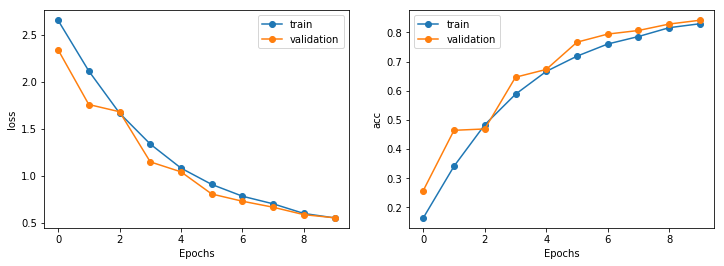

In [13]:
import matplotlib.pyplot as plt

def plot_train_history(history, train_metrics, val_metrics):
    plt.plot(history.history.get(train_metrics), '-o')
    plt.plot(history.history.get(val_metrics), '-o')
    plt.xlabel('Epochs')
    plt.ylabel(train_metrics)
    plt.legend(['train', 'validation'])
    
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plot_train_history(history, 'loss', 'val_loss')

plt.subplot(1, 2, 2)
plot_train_history(history, 'acc', 'val_acc')

plt.show()

## Evaluation

In [20]:
# Load test data

import os

def load_test_set(path):
    pics, labels = [], []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for pic in glob.glob(path + '*.*'):
        #print("pic base:", os.path.basename(pic))
        char_name = '_'.join(os.path.basename(pic).split('_')[:-1])
        if char_name in reverse_dict:
            temp = cv2.imread(pic)
            temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
            temp = cv2.resize(temp, (img_height, img_width)).astype('float32') / 255.
            pics.append(temp)
            labels.append(reverse_dict[char_name])
            
    X_test = np.array(pics)
    y_test = np.array(labels)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    print('Test set shape :', X_test.shape, y_test.shape)
    
    return X_test, y_test


test_imgs_path = '/media/yinyunjie/WD_HDD/dataSets/simpsons-characters/data/simpsons_test_dataset/'
X_valtest, y_valtest = load_test_set(test_imgs_path)

Test set shape : (890, 42, 42, 3) (890, 18)


In [21]:
# Predict
from keras.models import load_model

model = load_model('simpson_model.h5')

y_pred = model.predict_classes(X_valtest)
acc = np.sum(y_pred == np.argmax(y_valtest, axis=1)) / np.size(y_pred)

print('Test accuray = {}'.format(acc))

Test accuray = 0.8584269662921349


## Traing and Test with Data Augmentation

In [22]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=False, # whether set input mean to 0 over the dataset
    samplewise_center=False, # whether set each sample mean to 0
    featurewise_std_normalization=False, # whether divide inputs by std of the dataset
    samplewise_std_normalization=False, # whether divide each input by its std
    zca_whitening=False, # wheter apply ZCA whiting
    rotation_range=10, # randomly rotate images in the range of (0, 180) degree
    width_shift_range=0.1, # randomly shift images horizontally
    height_shift_range=0.1, # randomly shift images vertically 
    horizontal_flip=True, # randomly flip images
    vertical_flip=False # randomly flip images
)

datagen.fit(X_train)

checkpoint = ModelCheckpoint('simpson_with_data_aug.h5',
                             monitor='val_acc',
                             verbose=0,
                             save_best_only=True,
                             mode='max')

def lr_shedule(epoch):
    return lr * (0.1 ** int(epoch / 10))

model = create_model_six_conv((img_height, img_width, 3))

lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

callbacks_list = [LearningRateScheduler(lr_schedule), checkpoint]

history = model.fit_generator(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=X_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=callbacks_list
)

Epoch 1/10


  1/504 [..............................] - ETA: 10:37 - loss: 2.8898 - acc: 0.0625

  2/504 [..............................] - ETA: 7:13 - loss: 2.8932 - acc: 0.0625 

  3/504 [..............................] - ETA: 5:41 - loss: 2.8948 - acc: 0.0417

  4/504 [..............................] - ETA: 4:55 - loss: 2.8929 - acc: 0.0469

  5/504 [..............................] - ETA: 4:26 - loss: 2.8935 - acc: 0.0500

  6/504 [..............................] - ETA: 4:07 - loss: 2.8926 - acc: 0.0469

  7/504 [..............................] - ETA: 3:53 - loss: 2.8933 - acc: 0.0491

  8/504 [..............................] - ETA: 3:43 - loss: 2.8933 - acc: 0.0469

  9/504 [..............................] - ETA: 3:34 - loss: 2.8925 - acc: 0.0486

 10/504 [..............................] - ETA: 3:28 - loss: 2.8900 - acc: 0.0594

 11/504 [..............................] - ETA: 3:23 - loss: 2.8895 - acc: 0.0568

 12/504 [..............................] - ETA: 3:18 - loss: 2.8892 - acc: 0.0625

 13/504 [..............................] - ETA: 3:15 - loss: 2.8873 - acc: 0.0721

 14/504 [..............................] - ETA: 3:11 - loss: 2.8855 - acc: 0.0759

 15/504 [..............................] - ETA: 3:08 - loss: 2.8859 - acc: 0.0750

 16/504 [..............................] - ETA: 3:06 - loss: 2.8852 - acc: 0.0723

 17/504 [>.............................] - ETA: 3:03 - loss: 2.8842 - acc: 0.0772

 18/504 [>.............................] - ETA: 3:01 - loss: 2.8840 - acc: 0.0747

 19/504 [>.............................] - ETA: 2:59 - loss: 2.8827 - acc: 0.0806

 20/504 [>.............................] - ETA: 2:57 - loss: 2.8825 - acc: 0.0781

 21/504 [>.............................] - ETA: 2:56 - loss: 2.8824 - acc: 0.0774

 22/504 [>.............................] - ETA: 2:54 - loss: 2.8813 - acc: 0.0781

 23/504 [>.............................] - ETA: 2:53 - loss: 2.8815 - acc: 0.0761

 24/504 [>.............................] - ETA: 2:51 - loss: 2.8804 - acc: 0.0781

 25/504 [>.............................] - ETA: 2:50 - loss: 2.8797 - acc: 0.0788

 26/504 [>.............................] - ETA: 2:49 - loss: 2.8802 - acc: 0.0769

 27/504 [>.............................] - ETA: 2:48 - loss: 2.8787 - acc: 0.0775

 28/504 [>.............................] - ETA: 2:47 - loss: 2.8778 - acc: 0.0781

 29/504 [>.............................] - ETA: 2:46 - loss: 2.8771 - acc: 0.0776

 30/504 [>.............................] - ETA: 2:45 - loss: 2.8753 - acc: 0.0813

 31/504 [>.............................] - ETA: 2:44 - loss: 2.8742 - acc: 0.0827

 32/504 [>.............................] - ETA: 2:43 - loss: 2.8736 - acc: 0.0820

 33/504 [>.............................] - ETA: 2:42 - loss: 2.8716 - acc: 0.0852

 34/504 [=>............................] - ETA: 2:41 - loss: 2.8705 - acc: 0.0882

 35/504 [=>............................] - ETA: 2:40 - loss: 2.8705 - acc: 0.0884

 36/504 [=>............................] - ETA: 2:40 - loss: 2.8699 - acc: 0.0877

 37/504 [=>............................] - ETA: 2:39 - loss: 2.8691 - acc: 0.0878

 38/504 [=>............................] - ETA: 2:39 - loss: 2.8680 - acc: 0.0896

 39/504 [=>............................] - ETA: 2:38 - loss: 2.8664 - acc: 0.0913

 40/504 [=>............................] - ETA: 2:37 - loss: 2.8673 - acc: 0.0906

 41/504 [=>............................] - ETA: 2:36 - loss: 2.8673 - acc: 0.0907

 42/504 [=>............................] - ETA: 2:36 - loss: 2.8663 - acc: 0.0908

 43/504 [=>............................] - ETA: 2:35 - loss: 2.8661 - acc: 0.0901

 44/504 [=>............................] - ETA: 2:34 - loss: 2.8672 - acc: 0.0888

 45/504 [=>............................] - ETA: 2:34 - loss: 2.8658 - acc: 0.0875

 46/504 [=>............................] - ETA: 2:33 - loss: 2.8637 - acc: 0.0883

 47/504 [=>............................] - ETA: 2:33 - loss: 2.8632 - acc: 0.0884

 48/504 [=>............................] - ETA: 2:32 - loss: 2.8638 - acc: 0.0885

 49/504 [=>............................] - ETA: 2:32 - loss: 2.8633 - acc: 0.0886

 50/504 [=>............................] - ETA: 2:31 - loss: 2.8619 - acc: 0.0887

 51/504 [==>...........................] - ETA: 2:31 - loss: 2.8598 - acc: 0.0925

 52/504 [==>...........................] - ETA: 2:29 - loss: 2.8593 - acc: 0.0907

 53/504 [==>...........................] - ETA: 2:28 - loss: 2.8583 - acc: 0.0908

 54/504 [==>...........................] - ETA: 2:28 - loss: 2.8585 - acc: 0.0909

 55/504 [==>...........................] - ETA: 2:27 - loss: 2.8580 - acc: 0.0915

 56/504 [==>...........................] - ETA: 2:27 - loss: 2.8566 - acc: 0.0915

 57/504 [==>...........................] - ETA: 2:26 - loss: 2.8540 - acc: 0.0927

 58/504 [==>...........................] - ETA: 2:26 - loss: 2.8535 - acc: 0.0927

 59/504 [==>...........................] - ETA: 2:26 - loss: 2.8533 - acc: 0.0932

 60/504 [==>...........................] - ETA: 2:25 - loss: 2.8521 - acc: 0.0927

 61/504 [==>...........................] - ETA: 2:25 - loss: 2.8492 - acc: 0.0958

 62/504 [==>...........................] - ETA: 2:24 - loss: 2.8472 - acc: 0.0958

 63/504 [==>...........................] - ETA: 2:24 - loss: 2.8477 - acc: 0.0967

 64/504 [==>...........................] - ETA: 2:23 - loss: 2.8465 - acc: 0.0977

 65/504 [==>...........................] - ETA: 2:23 - loss: 2.8476 - acc: 0.0966

 66/504 [==>...........................] - ETA: 2:23 - loss: 2.8463 - acc: 0.0975

 67/504 [==>...........................] - ETA: 2:22 - loss: 2.8437 - acc: 0.1003

 68/504 [===>..........................] - ETA: 2:22 - loss: 2.8425 - acc: 0.1016

 69/504 [===>..........................] - ETA: 2:21 - loss: 2.8404 - acc: 0.1028

 70/504 [===>..........................] - ETA: 2:21 - loss: 2.8405 - acc: 0.1027

 71/504 [===>..........................] - ETA: 2:21 - loss: 2.8435 - acc: 0.1012

 72/504 [===>..........................] - ETA: 2:20 - loss: 2.8442 - acc: 0.1011

 73/504 [===>..........................] - ETA: 2:20 - loss: 2.8426 - acc: 0.1023

 74/504 [===>..........................] - ETA: 2:19 - loss: 2.8427 - acc: 0.1022

 75/504 [===>..........................] - ETA: 2:19 - loss: 2.8428 - acc: 0.1021

 76/504 [===>..........................] - ETA: 2:19 - loss: 2.8421 - acc: 0.1020

 77/504 [===>..........................] - ETA: 2:18 - loss: 2.8413 - acc: 0.1023

 78/504 [===>..........................] - ETA: 2:18 - loss: 2.8404 - acc: 0.1030

 79/504 [===>..........................] - ETA: 2:17 - loss: 2.8395 - acc: 0.1032

 80/504 [===>..........................] - ETA: 2:17 - loss: 2.8389 - acc: 0.1039

 81/504 [===>..........................] - ETA: 2:17 - loss: 2.8391 - acc: 0.1034

 82/504 [===>..........................] - ETA: 2:16 - loss: 2.8389 - acc: 0.1033

 83/504 [===>..........................] - ETA: 2:16 - loss: 2.8376 - acc: 0.1039

 84/504 [====>.........................] - ETA: 2:16 - loss: 2.8368 - acc: 0.1038

 85/504 [====>.........................] - ETA: 2:15 - loss: 2.8368 - acc: 0.1040

 86/504 [====>.........................] - ETA: 2:15 - loss: 2.8372 - acc: 0.1032

 87/504 [====>.........................] - ETA: 2:14 - loss: 2.8367 - acc: 0.1038

 88/504 [====>.........................] - ETA: 2:14 - loss: 2.8374 - acc: 0.1037

 89/504 [====>.........................] - ETA: 2:14 - loss: 2.8380 - acc: 0.1032

 90/504 [====>.........................] - ETA: 2:13 - loss: 2.8373 - acc: 0.1035

 91/504 [====>.........................] - ETA: 2:13 - loss: 2.8361 - acc: 0.1034

 92/504 [====>.........................] - ETA: 2:13 - loss: 2.8364 - acc: 0.1039

 93/504 [====>.........................] - ETA: 2:12 - loss: 2.8363 - acc: 0.1035

 94/504 [====>.........................] - ETA: 2:12 - loss: 2.8365 - acc: 0.1031

 95/504 [====>.........................] - ETA: 2:11 - loss: 2.8358 - acc: 0.1033

 96/504 [====>.........................] - ETA: 2:11 - loss: 2.8348 - acc: 0.1038

 97/504 [====>.........................] - ETA: 2:11 - loss: 2.8350 - acc: 0.1034

 98/504 [====>.........................] - ETA: 2:10 - loss: 2.8349 - acc: 0.1030

 99/504 [====>.........................] - ETA: 2:10 - loss: 2.8349 - acc: 0.1026

100/504 [====>.........................] - ETA: 2:10 - loss: 2.8343 - acc: 0.1034

101/504 [=====>........................] - ETA: 2:09 - loss: 2.8341 - acc: 0.1040

102/504 [=====>........................] - ETA: 2:09 - loss: 2.8328 - acc: 0.1054

103/504 [=====>........................] - ETA: 2:09 - loss: 2.8334 - acc: 0.1056

104/504 [=====>........................] - ETA: 2:08 - loss: 2.8327 - acc: 0.1067

105/504 [=====>........................] - ETA: 2:08 - loss: 2.8322 - acc: 0.1062

106/504 [=====>........................] - ETA: 2:08 - loss: 2.8324 - acc: 0.1061

107/504 [=====>........................] - ETA: 2:07 - loss: 2.8315 - acc: 0.1060

108/504 [=====>........................] - ETA: 2:07 - loss: 2.8301 - acc: 0.1059

109/504 [=====>........................] - ETA: 2:07 - loss: 2.8307 - acc: 0.1055

110/504 [=====>........................] - ETA: 2:06 - loss: 2.8304 - acc: 0.1060

111/504 [=====>........................] - ETA: 2:06 - loss: 2.8298 - acc: 0.1061

112/504 [=====>........................] - ETA: 2:06 - loss: 2.8285 - acc: 0.1060

113/504 [=====>........................] - ETA: 2:05 - loss: 2.8271 - acc: 0.1059

114/504 [=====>........................] - ETA: 2:05 - loss: 2.8274 - acc: 0.1058

115/504 [=====>........................] - ETA: 2:04 - loss: 2.8277 - acc: 0.1049

116/504 [=====>........................] - ETA: 2:04 - loss: 2.8259 - acc: 0.1056

117/504 [=====>........................] - ETA: 2:04 - loss: 2.8261 - acc: 0.1052

118/504 [======>.......................] - ETA: 2:03 - loss: 2.8253 - acc: 0.1051

119/504 [======>.......................] - ETA: 2:03 - loss: 2.8252 - acc: 0.1048

120/504 [======>.......................] - ETA: 2:03 - loss: 2.8252 - acc: 0.1044

121/504 [======>.......................] - ETA: 2:02 - loss: 2.8236 - acc: 0.1054

122/504 [======>.......................] - ETA: 2:02 - loss: 2.8230 - acc: 0.1050

123/504 [======>.......................] - ETA: 2:02 - loss: 2.8225 - acc: 0.1057

124/504 [======>.......................] - ETA: 2:01 - loss: 2.8219 - acc: 0.1064

125/504 [======>.......................] - ETA: 2:01 - loss: 2.8227 - acc: 0.1062

126/504 [======>.......................] - ETA: 2:01 - loss: 2.8230 - acc: 0.1062

127/504 [======>.......................] - ETA: 2:00 - loss: 2.8215 - acc: 0.1073

128/504 [======>.......................] - ETA: 2:00 - loss: 2.8212 - acc: 0.1074

129/504 [======>.......................] - ETA: 2:00 - loss: 2.8208 - acc: 0.1076

130/504 [======>.......................] - ETA: 1:59 - loss: 2.8196 - acc: 0.1084

131/504 [======>.......................] - ETA: 1:59 - loss: 2.8196 - acc: 0.1088

132/504 [======>.......................] - ETA: 1:59 - loss: 2.8193 - acc: 0.1084

133/504 [======>.......................] - ETA: 1:58 - loss: 2.8192 - acc: 0.1083

134/504 [======>.......................] - ETA: 1:58 - loss: 2.8190 - acc: 0.1087

135/504 [=======>......................] - ETA: 1:58 - loss: 2.8175 - acc: 0.1095

136/504 [=======>......................] - ETA: 1:57 - loss: 2.8177 - acc: 0.1098

137/504 [=======>......................] - ETA: 1:57 - loss: 2.8171 - acc: 0.1099

138/504 [=======>......................] - ETA: 1:57 - loss: 2.8164 - acc: 0.1103

139/504 [=======>......................] - ETA: 1:56 - loss: 2.8163 - acc: 0.1106

140/504 [=======>......................] - ETA: 1:56 - loss: 2.8158 - acc: 0.1109

141/504 [=======>......................] - ETA: 1:55 - loss: 2.8154 - acc: 0.1108

142/504 [=======>......................] - ETA: 1:55 - loss: 2.8157 - acc: 0.1109

143/504 [=======>......................] - ETA: 1:55 - loss: 2.8159 - acc: 0.1108

144/504 [=======>......................] - ETA: 1:54 - loss: 2.8167 - acc: 0.1111

145/504 [=======>......................] - ETA: 1:54 - loss: 2.8168 - acc: 0.1106

146/504 [=======>......................] - ETA: 1:54 - loss: 2.8168 - acc: 0.1104

147/504 [=======>......................] - ETA: 1:53 - loss: 2.8165 - acc: 0.1105

148/504 [=======>......................] - ETA: 1:53 - loss: 2.8165 - acc: 0.1100

149/504 [=======>......................] - ETA: 1:53 - loss: 2.8165 - acc: 0.1103

150/504 [=======>......................] - ETA: 1:52 - loss: 2.8165 - acc: 0.1104

151/504 [=======>......................] - ETA: 1:52 - loss: 2.8175 - acc: 0.1097

152/504 [========>.....................] - ETA: 1:52 - loss: 2.8173 - acc: 0.1098

153/504 [========>.....................] - ETA: 1:51 - loss: 2.8176 - acc: 0.1101

154/504 [========>.....................] - ETA: 1:51 - loss: 2.8178 - acc: 0.1102

155/504 [========>.....................] - ETA: 1:51 - loss: 2.8185 - acc: 0.1099

156/504 [========>.....................] - ETA: 1:50 - loss: 2.8179 - acc: 0.1104

157/504 [========>.....................] - ETA: 1:50 - loss: 2.8179 - acc: 0.1107

158/504 [========>.....................] - ETA: 1:50 - loss: 2.8181 - acc: 0.1104

159/504 [========>.....................] - ETA: 1:49 - loss: 2.8178 - acc: 0.1101

160/504 [========>.....................] - ETA: 1:49 - loss: 2.8181 - acc: 0.1096

161/504 [========>.....................] - ETA: 1:49 - loss: 2.8179 - acc: 0.1095

162/504 [========>.....................] - ETA: 1:48 - loss: 2.8180 - acc: 0.1096

163/504 [========>.....................] - ETA: 1:48 - loss: 2.8183 - acc: 0.1093

164/504 [========>.....................] - ETA: 1:48 - loss: 2.8182 - acc: 0.1098

165/504 [========>.....................] - ETA: 1:47 - loss: 2.8180 - acc: 0.1098

166/504 [========>.....................] - ETA: 1:47 - loss: 2.8186 - acc: 0.1096

167/504 [========>.....................] - ETA: 1:47 - loss: 2.8188 - acc: 0.1093

168/504 [=========>....................] - ETA: 1:46 - loss: 2.8187 - acc: 0.1094

169/504 [=========>....................] - ETA: 1:46 - loss: 2.8186 - acc: 0.1091

170/504 [=========>....................] - ETA: 1:46 - loss: 2.8182 - acc: 0.1092

171/504 [=========>....................] - ETA: 1:45 - loss: 2.8183 - acc: 0.1091

172/504 [=========>....................] - ETA: 1:45 - loss: 2.8178 - acc: 0.1094

173/504 [=========>....................] - ETA: 1:45 - loss: 2.8175 - acc: 0.1102

174/504 [=========>....................] - ETA: 1:44 - loss: 2.8170 - acc: 0.1106

175/504 [=========>....................] - ETA: 1:44 - loss: 2.8167 - acc: 0.1109

176/504 [=========>....................] - ETA: 1:44 - loss: 2.8167 - acc: 0.1106

177/504 [=========>....................] - ETA: 1:43 - loss: 2.8167 - acc: 0.1102

178/504 [=========>....................] - ETA: 1:43 - loss: 2.8163 - acc: 0.1101

179/504 [=========>....................] - ETA: 1:43 - loss: 2.8158 - acc: 0.1103

180/504 [=========>....................] - ETA: 1:42 - loss: 2.8163 - acc: 0.1099

181/504 [=========>....................] - ETA: 1:42 - loss: 2.8165 - acc: 0.1095

182/504 [=========>....................] - ETA: 1:42 - loss: 2.8162 - acc: 0.1094

183/504 [=========>....................] - ETA: 1:41 - loss: 2.8153 - acc: 0.1095

184/504 [=========>....................] - ETA: 1:41 - loss: 2.8153 - acc: 0.1090

185/504 [==========>...................] - ETA: 1:41 - loss: 2.8155 - acc: 0.1090

186/504 [==========>...................] - ETA: 1:40 - loss: 2.8154 - acc: 0.1087

187/504 [==========>...................] - ETA: 1:40 - loss: 2.8153 - acc: 0.1085

188/504 [==========>...................] - ETA: 1:40 - loss: 2.8150 - acc: 0.1085

189/504 [==========>...................] - ETA: 1:39 - loss: 2.8142 - acc: 0.1091

190/504 [==========>...................] - ETA: 1:39 - loss: 2.8140 - acc: 0.1092

191/504 [==========>...................] - ETA: 1:39 - loss: 2.8135 - acc: 0.1093

192/504 [==========>...................] - ETA: 1:39 - loss: 2.8131 - acc: 0.1092

193/504 [==========>...................] - ETA: 1:38 - loss: 2.8128 - acc: 0.1095

194/504 [==========>...................] - ETA: 1:38 - loss: 2.8129 - acc: 0.1094

195/504 [==========>...................] - ETA: 1:38 - loss: 2.8128 - acc: 0.1090

196/504 [==========>...................] - ETA: 1:37 - loss: 2.8132 - acc: 0.1089

197/504 [==========>...................] - ETA: 1:37 - loss: 2.8134 - acc: 0.1090

198/504 [==========>...................] - ETA: 1:37 - loss: 2.8137 - acc: 0.1087

199/504 [==========>...................] - ETA: 1:36 - loss: 2.8137 - acc: 0.1085

200/504 [==========>...................] - ETA: 1:36 - loss: 2.8134 - acc: 0.1083

201/504 [==========>...................] - ETA: 1:36 - loss: 2.8138 - acc: 0.1084

202/504 [===========>..................] - ETA: 1:35 - loss: 2.8139 - acc: 0.1083

203/504 [===========>..................] - ETA: 1:35 - loss: 2.8136 - acc: 0.1084

204/504 [===========>..................] - ETA: 1:35 - loss: 2.8139 - acc: 0.1080

205/504 [===========>..................] - ETA: 1:34 - loss: 2.8138 - acc: 0.1079

206/504 [===========>..................] - ETA: 1:34 - loss: 2.8135 - acc: 0.1080

207/504 [===========>..................] - ETA: 1:34 - loss: 2.8133 - acc: 0.1081

208/504 [===========>..................] - ETA: 1:33 - loss: 2.8129 - acc: 0.1086

209/504 [===========>..................] - ETA: 1:33 - loss: 2.8131 - acc: 0.1087

210/504 [===========>..................] - ETA: 1:33 - loss: 2.8126 - acc: 0.1088

211/504 [===========>..................] - ETA: 1:32 - loss: 2.8123 - acc: 0.1093

212/504 [===========>..................] - ETA: 1:32 - loss: 2.8131 - acc: 0.1091

213/504 [===========>..................] - ETA: 1:32 - loss: 2.8127 - acc: 0.1093

214/504 [===========>..................] - ETA: 1:31 - loss: 2.8121 - acc: 0.1100

215/504 [===========>..................] - ETA: 1:31 - loss: 2.8116 - acc: 0.1106

216/504 [===========>..................] - ETA: 1:31 - loss: 2.8109 - acc: 0.1107

217/504 [===========>..................] - ETA: 1:30 - loss: 2.8114 - acc: 0.1106

218/504 [===========>..................] - ETA: 1:30 - loss: 2.8113 - acc: 0.1107

219/504 [============>.................] - ETA: 1:30 - loss: 2.8114 - acc: 0.1106

220/504 [============>.................] - ETA: 1:29 - loss: 2.8114 - acc: 0.1105

221/504 [============>.................] - ETA: 1:29 - loss: 2.8108 - acc: 0.1109

222/504 [============>.................] - ETA: 1:29 - loss: 2.8106 - acc: 0.1108

223/504 [============>.................] - ETA: 1:28 - loss: 2.8099 - acc: 0.1111

224/504 [============>.................] - ETA: 1:28 - loss: 2.8091 - acc: 0.1115

225/504 [============>.................] - ETA: 1:28 - loss: 2.8090 - acc: 0.1115

226/504 [============>.................] - ETA: 1:28 - loss: 2.8094 - acc: 0.1113

227/504 [============>.................] - ETA: 1:27 - loss: 2.8090 - acc: 0.1116

228/504 [============>.................] - ETA: 1:27 - loss: 2.8082 - acc: 0.1123

229/504 [============>.................] - ETA: 1:27 - loss: 2.8077 - acc: 0.1123

230/504 [============>.................] - ETA: 1:26 - loss: 2.8071 - acc: 0.1125

231/504 [============>.................] - ETA: 1:26 - loss: 2.8069 - acc: 0.1124

232/504 [============>.................] - ETA: 1:26 - loss: 2.8070 - acc: 0.1122

233/504 [============>.................] - ETA: 1:25 - loss: 2.8057 - acc: 0.1128

234/504 [============>.................] - ETA: 1:25 - loss: 2.8056 - acc: 0.1128

235/504 [============>.................] - ETA: 1:25 - loss: 2.8054 - acc: 0.1126

236/504 [=============>................] - ETA: 1:24 - loss: 2.8053 - acc: 0.1127

237/504 [=============>................] - ETA: 1:24 - loss: 2.8044 - acc: 0.1126

238/504 [=============>................] - ETA: 1:24 - loss: 2.8041 - acc: 0.1127

239/504 [=============>................] - ETA: 1:23 - loss: 2.8041 - acc: 0.1123

240/504 [=============>................] - ETA: 1:23 - loss: 2.8039 - acc: 0.1122

241/504 [=============>................] - ETA: 1:23 - loss: 2.8036 - acc: 0.1124

242/504 [=============>................] - ETA: 1:22 - loss: 2.8033 - acc: 0.1126

243/504 [=============>................] - ETA: 1:22 - loss: 2.8031 - acc: 0.1125

244/504 [=============>................] - ETA: 1:22 - loss: 2.8027 - acc: 0.1127

245/504 [=============>................] - ETA: 1:22 - loss: 2.8023 - acc: 0.1129

246/504 [=============>................] - ETA: 1:21 - loss: 2.8016 - acc: 0.1132

247/504 [=============>................] - ETA: 1:21 - loss: 2.8019 - acc: 0.1131

248/504 [=============>................] - ETA: 1:21 - loss: 2.8017 - acc: 0.1135

249/504 [=============>................] - ETA: 1:20 - loss: 2.8016 - acc: 0.1133

250/504 [=============>................] - ETA: 1:20 - loss: 2.8015 - acc: 0.1131

251/504 [=============>................] - ETA: 1:20 - loss: 2.8012 - acc: 0.1134

252/504 [==============>...............] - ETA: 1:20 - loss: 2.8005 - acc: 0.1135

253/504 [==============>...............] - ETA: 1:20 - loss: 2.8008 - acc: 0.1138

254/504 [==============>...............] - ETA: 1:20 - loss: 2.8002 - acc: 0.1142

255/504 [==============>...............] - ETA: 1:19 - loss: 2.7999 - acc: 0.1141

256/504 [==============>...............] - ETA: 1:19 - loss: 2.7992 - acc: 0.1145

257/504 [==============>...............] - ETA: 1:19 - loss: 2.7993 - acc: 0.1144

258/504 [==============>...............] - ETA: 1:19 - loss: 2.7990 - acc: 0.1145

259/504 [==============>...............] - ETA: 1:19 - loss: 2.7985 - acc: 0.1146

260/504 [==============>...............] - ETA: 1:18 - loss: 2.7983 - acc: 0.1144

261/504 [==============>...............] - ETA: 1:18 - loss: 2.7981 - acc: 0.1148

262/504 [==============>...............] - ETA: 1:18 - loss: 2.7984 - acc: 0.1147

263/504 [==============>...............] - ETA: 1:18 - loss: 2.7980 - acc: 0.1148

264/504 [==============>...............] - ETA: 1:17 - loss: 2.7980 - acc: 0.1148

265/504 [==============>...............] - ETA: 1:17 - loss: 2.7976 - acc: 0.1151

266/504 [==============>...............] - ETA: 1:17 - loss: 2.7975 - acc: 0.1151

267/504 [==============>...............] - ETA: 1:17 - loss: 2.7974 - acc: 0.1153

268/504 [==============>...............] - ETA: 1:16 - loss: 2.7977 - acc: 0.1153

269/504 [===============>..............] - ETA: 1:16 - loss: 2.7979 - acc: 0.1154

270/504 [===============>..............] - ETA: 1:16 - loss: 2.7976 - acc: 0.1150

271/504 [===============>..............] - ETA: 1:15 - loss: 2.7968 - acc: 0.1157

272/504 [===============>..............] - ETA: 1:15 - loss: 2.7964 - acc: 0.1157

273/504 [===============>..............] - ETA: 1:15 - loss: 2.7963 - acc: 0.1158

274/504 [===============>..............] - ETA: 1:14 - loss: 2.7959 - acc: 0.1160

275/504 [===============>..............] - ETA: 1:14 - loss: 2.7953 - acc: 0.1159

276/504 [===============>..............] - ETA: 1:14 - loss: 2.7951 - acc: 0.1157

277/504 [===============>..............] - ETA: 1:14 - loss: 2.7951 - acc: 0.1157

278/504 [===============>..............] - ETA: 1:13 - loss: 2.7952 - acc: 0.1157

279/504 [===============>..............] - ETA: 1:13 - loss: 2.7949 - acc: 0.1156

280/504 [===============>..............] - ETA: 1:13 - loss: 2.7943 - acc: 0.1157

281/504 [===============>..............] - ETA: 1:12 - loss: 2.7938 - acc: 0.1161

282/504 [===============>..............] - ETA: 1:12 - loss: 2.7934 - acc: 0.1162

283/504 [===============>..............] - ETA: 1:12 - loss: 2.7927 - acc: 0.1164

284/504 [===============>..............] - ETA: 1:11 - loss: 2.7924 - acc: 0.1162

285/504 [===============>..............] - ETA: 1:11 - loss: 2.7923 - acc: 0.1162

286/504 [================>.............] - ETA: 1:11 - loss: 2.7923 - acc: 0.1165

287/504 [================>.............] - ETA: 1:10 - loss: 2.7921 - acc: 0.1169

288/504 [================>.............] - ETA: 1:10 - loss: 2.7918 - acc: 0.1169

289/504 [================>.............] - ETA: 1:10 - loss: 2.7916 - acc: 0.1171

290/504 [================>.............] - ETA: 1:09 - loss: 2.7915 - acc: 0.1170

291/504 [================>.............] - ETA: 1:09 - loss: 2.7913 - acc: 0.1171

292/504 [================>.............] - ETA: 1:09 - loss: 2.7907 - acc: 0.1172

293/504 [================>.............] - ETA: 1:08 - loss: 2.7905 - acc: 0.1172

294/504 [================>.............] - ETA: 1:08 - loss: 2.7895 - acc: 0.1177

295/504 [================>.............] - ETA: 1:08 - loss: 2.7885 - acc: 0.1178

296/504 [================>.............] - ETA: 1:07 - loss: 2.7888 - acc: 0.1178

297/504 [================>.............] - ETA: 1:07 - loss: 2.7883 - acc: 0.1180

298/504 [================>.............] - ETA: 1:07 - loss: 2.7878 - acc: 0.1186

299/504 [================>.............] - ETA: 1:06 - loss: 2.7874 - acc: 0.1186

300/504 [================>.............] - ETA: 1:06 - loss: 2.7869 - acc: 0.1189

301/504 [================>.............] - ETA: 1:06 - loss: 2.7861 - acc: 0.1192

302/504 [================>.............] - ETA: 1:05 - loss: 2.7864 - acc: 0.1192

303/504 [=================>............] - ETA: 1:05 - loss: 2.7865 - acc: 0.1190

304/504 [=================>............] - ETA: 1:05 - loss: 2.7861 - acc: 0.1192

305/504 [=================>............] - ETA: 1:04 - loss: 2.7856 - acc: 0.1195

306/504 [=================>............] - ETA: 1:04 - loss: 2.7855 - acc: 0.1196

307/504 [=================>............] - ETA: 1:04 - loss: 2.7861 - acc: 0.1195

308/504 [=================>............] - ETA: 1:03 - loss: 2.7858 - acc: 0.1195

309/504 [=================>............] - ETA: 1:03 - loss: 2.7857 - acc: 0.1193

310/504 [=================>............] - ETA: 1:03 - loss: 2.7851 - acc: 0.1201

311/504 [=================>............] - ETA: 1:02 - loss: 2.7847 - acc: 0.1199

312/504 [=================>............] - ETA: 1:02 - loss: 2.7848 - acc: 0.1200

313/504 [=================>............] - ETA: 1:02 - loss: 2.7848 - acc: 0.1199

314/504 [=================>............] - ETA: 1:01 - loss: 2.7845 - acc: 0.1199

315/504 [=================>............] - ETA: 1:01 - loss: 2.7844 - acc: 0.1201

316/504 [=================>............] - ETA: 1:01 - loss: 2.7839 - acc: 0.1205

317/504 [=================>............] - ETA: 1:00 - loss: 2.7838 - acc: 0.1205

318/504 [=================>............] - ETA: 1:00 - loss: 2.7835 - acc: 0.1205

319/504 [=================>............] - ETA: 1:00 - loss: 2.7830 - acc: 0.1204

320/504 [==================>...........] - ETA: 59s - loss: 2.7831 - acc: 0.1202 

321/504 [==================>...........] - ETA: 59s - loss: 2.7829 - acc: 0.1200

322/504 [==================>...........] - ETA: 59s - loss: 2.7828 - acc: 0.1201

323/504 [==================>...........] - ETA: 58s - loss: 2.7825 - acc: 0.1200

324/504 [==================>...........] - ETA: 58s - loss: 2.7824 - acc: 0.1200

325/504 [==================>...........] - ETA: 58s - loss: 2.7825 - acc: 0.1201

326/504 [==================>...........] - ETA: 57s - loss: 2.7822 - acc: 0.1203

327/504 [==================>...........] - ETA: 57s - loss: 2.7823 - acc: 0.1201

328/504 [==================>...........] - ETA: 57s - loss: 2.7818 - acc: 0.1204

329/504 [==================>...........] - ETA: 56s - loss: 2.7810 - acc: 0.1203

330/504 [==================>...........] - ETA: 56s - loss: 2.7811 - acc: 0.1206

331/504 [==================>...........] - ETA: 56s - loss: 2.7810 - acc: 0.1206

332/504 [==================>...........] - ETA: 55s - loss: 2.7809 - acc: 0.1208

333/504 [==================>...........] - ETA: 55s - loss: 2.7804 - acc: 0.1212

334/504 [==================>...........] - ETA: 55s - loss: 2.7802 - acc: 0.1210

335/504 [==================>...........] - ETA: 54s - loss: 2.7803 - acc: 0.1208

336/504 [===================>..........] - ETA: 54s - loss: 2.7807 - acc: 0.1205

337/504 [===================>..........] - ETA: 54s - loss: 2.7800 - acc: 0.1207

338/504 [===================>..........] - ETA: 53s - loss: 2.7801 - acc: 0.1211

339/504 [===================>..........] - ETA: 53s - loss: 2.7795 - acc: 0.1215

340/504 [===================>..........] - ETA: 53s - loss: 2.7793 - acc: 0.1216

341/504 [===================>..........] - ETA: 52s - loss: 2.7787 - acc: 0.1218

342/504 [===================>..........] - ETA: 52s - loss: 2.7785 - acc: 0.1218

343/504 [===================>..........] - ETA: 52s - loss: 2.7784 - acc: 0.1219

344/504 [===================>..........] - ETA: 51s - loss: 2.7787 - acc: 0.1218

345/504 [===================>..........] - ETA: 51s - loss: 2.7787 - acc: 0.1216

346/504 [===================>..........] - ETA: 51s - loss: 2.7784 - acc: 0.1217

347/504 [===================>..........] - ETA: 50s - loss: 2.7783 - acc: 0.1218

348/504 [===================>..........] - ETA: 50s - loss: 2.7781 - acc: 0.1220

349/504 [===================>..........] - ETA: 50s - loss: 2.7775 - acc: 0.1223

350/504 [===================>..........] - ETA: 49s - loss: 2.7771 - acc: 0.1227

351/504 [===================>..........] - ETA: 49s - loss: 2.7768 - acc: 0.1229

352/504 [===================>..........] - ETA: 49s - loss: 2.7769 - acc: 0.1230

353/504 [====================>.........] - ETA: 48s - loss: 2.7771 - acc: 0.1230

354/504 [====================>.........] - ETA: 48s - loss: 2.7770 - acc: 0.1232

355/504 [====================>.........] - ETA: 48s - loss: 2.7771 - acc: 0.1233

356/504 [====================>.........] - ETA: 47s - loss: 2.7766 - acc: 0.1235

357/504 [====================>.........] - ETA: 47s - loss: 2.7769 - acc: 0.1235

358/504 [====================>.........] - ETA: 47s - loss: 2.7766 - acc: 0.1237

359/504 [====================>.........] - ETA: 46s - loss: 2.7765 - acc: 0.1235

360/504 [====================>.........] - ETA: 46s - loss: 2.7764 - acc: 0.1234

361/504 [====================>.........] - ETA: 46s - loss: 2.7764 - acc: 0.1235

362/504 [====================>.........] - ETA: 45s - loss: 2.7757 - acc: 0.1237

363/504 [====================>.........] - ETA: 45s - loss: 2.7759 - acc: 0.1239

364/504 [====================>.........] - ETA: 45s - loss: 2.7758 - acc: 0.1244

365/504 [====================>.........] - ETA: 44s - loss: 2.7755 - acc: 0.1247

366/504 [====================>.........] - ETA: 44s - loss: 2.7752 - acc: 0.1247

367/504 [====================>.........] - ETA: 44s - loss: 2.7756 - acc: 0.1246

368/504 [====================>.........] - ETA: 43s - loss: 2.7754 - acc: 0.1247

369/504 [====================>.........] - ETA: 43s - loss: 2.7752 - acc: 0.1250

370/504 [=====================>........] - ETA: 43s - loss: 2.7751 - acc: 0.1250

371/504 [=====================>........] - ETA: 42s - loss: 2.7751 - acc: 0.1251

372/504 [=====================>........] - ETA: 42s - loss: 2.7749 - acc: 0.1252

373/504 [=====================>........] - ETA: 42s - loss: 2.7743 - acc: 0.1253

374/504 [=====================>........] - ETA: 41s - loss: 2.7739 - acc: 0.1256

375/504 [=====================>........] - ETA: 41s - loss: 2.7736 - acc: 0.1258

376/504 [=====================>........] - ETA: 41s - loss: 2.7737 - acc: 0.1259

377/504 [=====================>........] - ETA: 41s - loss: 2.7734 - acc: 0.1262

378/504 [=====================>........] - ETA: 40s - loss: 2.7731 - acc: 0.1262

379/504 [=====================>........] - ETA: 40s - loss: 2.7732 - acc: 0.1262

380/504 [=====================>........] - ETA: 40s - loss: 2.7723 - acc: 0.1266

381/504 [=====================>........] - ETA: 39s - loss: 2.7718 - acc: 0.1267

382/504 [=====================>........] - ETA: 39s - loss: 2.7721 - acc: 0.1266

383/504 [=====================>........] - ETA: 39s - loss: 2.7720 - acc: 0.1270

384/504 [=====================>........] - ETA: 38s - loss: 2.7715 - acc: 0.1270

385/504 [=====================>........] - ETA: 38s - loss: 2.7713 - acc: 0.1267

386/504 [=====================>........] - ETA: 38s - loss: 2.7714 - acc: 0.1267

387/504 [======================>.......] - ETA: 37s - loss: 2.7711 - acc: 0.1269

388/504 [======================>.......] - ETA: 37s - loss: 2.7712 - acc: 0.1269

389/504 [======================>.......] - ETA: 37s - loss: 2.7711 - acc: 0.1268

390/504 [======================>.......] - ETA: 36s - loss: 2.7704 - acc: 0.1270

391/504 [======================>.......] - ETA: 36s - loss: 2.7700 - acc: 0.1271

392/504 [======================>.......] - ETA: 36s - loss: 2.7696 - acc: 0.1271

393/504 [======================>.......] - ETA: 35s - loss: 2.7690 - acc: 0.1271

394/504 [======================>.......] - ETA: 35s - loss: 2.7685 - acc: 0.1273

395/504 [======================>.......] - ETA: 35s - loss: 2.7679 - acc: 0.1274

396/504 [======================>.......] - ETA: 34s - loss: 2.7675 - acc: 0.1274

397/504 [======================>.......] - ETA: 34s - loss: 2.7672 - acc: 0.1275

398/504 [======================>.......] - ETA: 34s - loss: 2.7667 - acc: 0.1276

399/504 [======================>.......] - ETA: 33s - loss: 2.7666 - acc: 0.1277

400/504 [======================>.......] - ETA: 33s - loss: 2.7663 - acc: 0.1277

401/504 [======================>.......] - ETA: 33s - loss: 2.7657 - acc: 0.1280

402/504 [======================>.......] - ETA: 32s - loss: 2.7653 - acc: 0.1281

403/504 [======================>.......] - ETA: 32s - loss: 2.7647 - acc: 0.1283

404/504 [=======================>......] - ETA: 32s - loss: 2.7643 - acc: 0.1284

405/504 [=======================>......] - ETA: 31s - loss: 2.7639 - acc: 0.1285

406/504 [=======================>......] - ETA: 31s - loss: 2.7636 - acc: 0.1288

407/504 [=======================>......] - ETA: 31s - loss: 2.7636 - acc: 0.1290

408/504 [=======================>......] - ETA: 30s - loss: 2.7631 - acc: 0.1290

409/504 [=======================>......] - ETA: 30s - loss: 2.7627 - acc: 0.1290

410/504 [=======================>......] - ETA: 30s - loss: 2.7622 - acc: 0.1288

411/504 [=======================>......] - ETA: 29s - loss: 2.7618 - acc: 0.1287

412/504 [=======================>......] - ETA: 29s - loss: 2.7616 - acc: 0.1287

413/504 [=======================>......] - ETA: 29s - loss: 2.7604 - acc: 0.1292

414/504 [=======================>......] - ETA: 28s - loss: 2.7599 - acc: 0.1293

415/504 [=======================>......] - ETA: 28s - loss: 2.7596 - acc: 0.1293

416/504 [=======================>......] - ETA: 28s - loss: 2.7594 - acc: 0.1292

417/504 [=======================>......] - ETA: 27s - loss: 2.7594 - acc: 0.1293

418/504 [=======================>......] - ETA: 27s - loss: 2.7591 - acc: 0.1291

419/504 [=======================>......] - ETA: 27s - loss: 2.7590 - acc: 0.1291

420/504 [========================>.....] - ETA: 27s - loss: 2.7588 - acc: 0.1293

421/504 [========================>.....] - ETA: 26s - loss: 2.7588 - acc: 0.1295

422/504 [========================>.....] - ETA: 26s - loss: 2.7586 - acc: 0.1296

423/504 [========================>.....] - ETA: 26s - loss: 2.7579 - acc: 0.1298

424/504 [========================>.....] - ETA: 25s - loss: 2.7577 - acc: 0.1299

425/504 [========================>.....] - ETA: 25s - loss: 2.7572 - acc: 0.1302

426/504 [========================>.....] - ETA: 25s - loss: 2.7569 - acc: 0.1302

427/504 [========================>.....] - ETA: 24s - loss: 2.7567 - acc: 0.1305

428/504 [========================>.....] - ETA: 24s - loss: 2.7565 - acc: 0.1306

429/504 [========================>.....] - ETA: 24s - loss: 2.7565 - acc: 0.1305

430/504 [========================>.....] - ETA: 23s - loss: 2.7566 - acc: 0.1305

431/504 [========================>.....] - ETA: 23s - loss: 2.7560 - acc: 0.1305

432/504 [========================>.....] - ETA: 23s - loss: 2.7553 - acc: 0.1308

433/504 [========================>.....] - ETA: 22s - loss: 2.7554 - acc: 0.1308

434/504 [========================>.....] - ETA: 22s - loss: 2.7552 - acc: 0.1312

435/504 [========================>.....] - ETA: 22s - loss: 2.7550 - acc: 0.1313

436/504 [========================>.....] - ETA: 21s - loss: 2.7543 - acc: 0.1317

437/504 [=========================>....] - ETA: 21s - loss: 2.7539 - acc: 0.1319

438/504 [=========================>....] - ETA: 21s - loss: 2.7538 - acc: 0.1319

439/504 [=========================>....] - ETA: 20s - loss: 2.7534 - acc: 0.1318

440/504 [=========================>....] - ETA: 20s - loss: 2.7529 - acc: 0.1317

441/504 [=========================>....] - ETA: 20s - loss: 2.7527 - acc: 0.1320

442/504 [=========================>....] - ETA: 19s - loss: 2.7521 - acc: 0.1325

443/504 [=========================>....] - ETA: 19s - loss: 2.7518 - acc: 0.1324

444/504 [=========================>....] - ETA: 19s - loss: 2.7521 - acc: 0.1323

445/504 [=========================>....] - ETA: 18s - loss: 2.7512 - acc: 0.1327

446/504 [=========================>....] - ETA: 18s - loss: 2.7515 - acc: 0.1327

447/504 [=========================>....] - ETA: 18s - loss: 2.7509 - acc: 0.1329

448/504 [=========================>....] - ETA: 17s - loss: 2.7509 - acc: 0.1329

449/504 [=========================>....] - ETA: 17s - loss: 2.7503 - acc: 0.1331

450/504 [=========================>....] - ETA: 17s - loss: 2.7499 - acc: 0.1333

451/504 [=========================>....] - ETA: 17s - loss: 2.7494 - acc: 0.1335

452/504 [=========================>....] - ETA: 16s - loss: 2.7488 - acc: 0.1335

453/504 [=========================>....] - ETA: 16s - loss: 2.7488 - acc: 0.1334

454/504 [==========================>...] - ETA: 16s - loss: 2.7485 - acc: 0.1337

455/504 [==========================>...] - ETA: 15s - loss: 2.7481 - acc: 0.1337

456/504 [==========================>...] - ETA: 15s - loss: 2.7473 - acc: 0.1341

457/504 [==========================>...] - ETA: 15s - loss: 2.7467 - acc: 0.1344

458/504 [==========================>...] - ETA: 14s - loss: 2.7457 - acc: 0.1346

459/504 [==========================>...] - ETA: 14s - loss: 2.7460 - acc: 0.1347

460/504 [==========================>...] - ETA: 14s - loss: 2.7452 - acc: 0.1349

461/504 [==========================>...] - ETA: 13s - loss: 2.7451 - acc: 0.1350

462/504 [==========================>...] - ETA: 13s - loss: 2.7447 - acc: 0.1354

463/504 [==========================>...] - ETA: 13s - loss: 2.7447 - acc: 0.1353

464/504 [==========================>...] - ETA: 12s - loss: 2.7441 - acc: 0.1354

465/504 [==========================>...] - ETA: 12s - loss: 2.7438 - acc: 0.1354

466/504 [==========================>...] - ETA: 12s - loss: 2.7433 - acc: 0.1354

467/504 [==========================>...] - ETA: 11s - loss: 2.7427 - acc: 0.1358

468/504 [==========================>...] - ETA: 11s - loss: 2.7421 - acc: 0.1359

469/504 [==========================>...] - ETA: 11s - loss: 2.7419 - acc: 0.1359

470/504 [==========================>...] - ETA: 10s - loss: 2.7417 - acc: 0.1360

471/504 [===========================>..] - ETA: 10s - loss: 2.7417 - acc: 0.1362

472/504 [===========================>..] - ETA: 10s - loss: 2.7410 - acc: 0.1364

473/504 [===========================>..] - ETA: 9s - loss: 2.7408 - acc: 0.1364 

474/504 [===========================>..] - ETA: 9s - loss: 2.7401 - acc: 0.1365

475/504 [===========================>..] - ETA: 9s - loss: 2.7394 - acc: 0.1367

476/504 [===========================>..] - ETA: 8s - loss: 2.7391 - acc: 0.1366

477/504 [===========================>..] - ETA: 8s - loss: 2.7384 - acc: 0.1370

478/504 [===========================>..] - ETA: 8s - loss: 2.7384 - acc: 0.1370

479/504 [===========================>..] - ETA: 8s - loss: 2.7379 - acc: 0.1369

480/504 [===========================>..] - ETA: 7s - loss: 2.7372 - acc: 0.1370

481/504 [===========================>..] - ETA: 7s - loss: 2.7371 - acc: 0.1371

482/504 [===========================>..] - ETA: 7s - loss: 2.7368 - acc: 0.1371

483/504 [===========================>..] - ETA: 6s - loss: 2.7365 - acc: 0.1371

484/504 [===========================>..] - ETA: 6s - loss: 2.7360 - acc: 0.1373

485/504 [===========================>..] - ETA: 6s - loss: 2.7357 - acc: 0.1374

486/504 [===========================>..] - ETA: 5s - loss: 2.7353 - acc: 0.1375

487/504 [===========================>..] - ETA: 5s - loss: 2.7349 - acc: 0.1377

488/504 [============================>.] - ETA: 5s - loss: 2.7348 - acc: 0.1374

489/504 [============================>.] - ETA: 4s - loss: 2.7347 - acc: 0.1375

490/504 [============================>.] - ETA: 4s - loss: 2.7345 - acc: 0.1376

491/504 [============================>.] - ETA: 4s - loss: 2.7342 - acc: 0.1377

492/504 [============================>.] - ETA: 3s - loss: 2.7346 - acc: 0.1376

493/504 [============================>.] - ETA: 3s - loss: 2.7343 - acc: 0.1377

494/504 [============================>.] - ETA: 3s - loss: 2.7339 - acc: 0.1377

495/504 [============================>.] - ETA: 2s - loss: 2.7338 - acc: 0.1378

496/504 [============================>.] - ETA: 2s - loss: 2.7333 - acc: 0.1380

497/504 [============================>.] - ETA: 2s - loss: 2.7329 - acc: 0.1380

498/504 [============================>.] - ETA: 1s - loss: 2.7325 - acc: 0.1382

499/504 [============================>.] - ETA: 1s - loss: 2.7323 - acc: 0.1382

500/504 [============================>.] - ETA: 1s - loss: 2.7318 - acc: 0.1386

501/504 [============================>.] - ETA: 0s - loss: 2.7321 - acc: 0.1385

502/504 [============================>.] - ETA: 0s - loss: 2.7315 - acc: 0.1386

503/504 [============================>.] - ETA: 0s - loss: 2.7315 - acc: 0.1386

504/504 [==============================] - 169s 335ms/step - loss: 2.7310 - acc: 0.1387 - val_loss: 2.4471 - val_acc: 0.2527


Epoch 2/10


  1/504 [..............................] - ETA: 2:59 - loss: 2.5431 - acc: 0.2500

  2/504 [..............................] - ETA: 2:57 - loss: 2.5754 - acc: 0.2188

  3/504 [..............................] - ETA: 2:50 - loss: 2.5664 - acc: 0.1875

  4/504 [..............................] - ETA: 2:46 - loss: 2.5303 - acc: 0.1875

  5/504 [..............................] - ETA: 2:46 - loss: 2.5148 - acc: 0.1938

  6/504 [..............................] - ETA: 2:44 - loss: 2.4957 - acc: 0.1875

  7/504 [..............................] - ETA: 2:43 - loss: 2.5155 - acc: 0.1920

  8/504 [..............................] - ETA: 2:41 - loss: 2.5420 - acc: 0.1797

  9/504 [..............................] - ETA: 2:40 - loss: 2.5671 - acc: 0.1701

 10/504 [..............................] - ETA: 2:39 - loss: 2.5431 - acc: 0.1906

 11/504 [..............................] - ETA: 2:39 - loss: 2.5340 - acc: 0.1932

 12/504 [..............................] - ETA: 2:38 - loss: 2.5140 - acc: 0.2005

 13/504 [..............................] - ETA: 2:37 - loss: 2.5257 - acc: 0.1971

 14/504 [..............................] - ETA: 2:36 - loss: 2.5024 - acc: 0.2098

 15/504 [..............................] - ETA: 2:36 - loss: 2.4993 - acc: 0.2146

 16/504 [..............................] - ETA: 2:35 - loss: 2.5181 - acc: 0.2129

 17/504 [>.............................] - ETA: 2:35 - loss: 2.5000 - acc: 0.2188

 18/504 [>.............................] - ETA: 2:34 - loss: 2.4937 - acc: 0.2188

 19/504 [>.............................] - ETA: 2:34 - loss: 2.4833 - acc: 0.2155

 20/504 [>.............................] - ETA: 2:33 - loss: 2.4692 - acc: 0.2203

 21/504 [>.............................] - ETA: 2:33 - loss: 2.4668 - acc: 0.2217

 22/504 [>.............................] - ETA: 2:32 - loss: 2.4750 - acc: 0.2202

 23/504 [>.............................] - ETA: 2:32 - loss: 2.4734 - acc: 0.2188

 24/504 [>.............................] - ETA: 2:32 - loss: 2.4783 - acc: 0.2188

 25/504 [>.............................] - ETA: 2:31 - loss: 2.4739 - acc: 0.2225

 26/504 [>.............................] - ETA: 2:31 - loss: 2.4714 - acc: 0.2212

 27/504 [>.............................] - ETA: 2:31 - loss: 2.4739 - acc: 0.2153

 28/504 [>.............................] - ETA: 2:30 - loss: 2.4750 - acc: 0.2188

 29/504 [>.............................] - ETA: 2:30 - loss: 2.4828 - acc: 0.2188

 30/504 [>.............................] - ETA: 2:29 - loss: 2.4812 - acc: 0.2208

 31/504 [>.............................] - ETA: 2:29 - loss: 2.4906 - acc: 0.2188

 32/504 [>.............................] - ETA: 2:29 - loss: 2.4993 - acc: 0.2158

 33/504 [>.............................] - ETA: 2:28 - loss: 2.5004 - acc: 0.2140

 34/504 [=>............................] - ETA: 2:28 - loss: 2.5069 - acc: 0.2114

 35/504 [=>............................] - ETA: 2:27 - loss: 2.5029 - acc: 0.2125

 36/504 [=>............................] - ETA: 2:27 - loss: 2.5035 - acc: 0.2127

 37/504 [=>............................] - ETA: 2:27 - loss: 2.5074 - acc: 0.2128

 38/504 [=>............................] - ETA: 2:26 - loss: 2.5067 - acc: 0.2113

 39/504 [=>............................] - ETA: 2:26 - loss: 2.5042 - acc: 0.2131

 40/504 [=>............................] - ETA: 2:26 - loss: 2.4989 - acc: 0.2180

 41/504 [=>............................] - ETA: 2:25 - loss: 2.4901 - acc: 0.2218

 42/504 [=>............................] - ETA: 2:25 - loss: 2.4873 - acc: 0.2210

 43/504 [=>............................] - ETA: 2:25 - loss: 2.4830 - acc: 0.2231

 44/504 [=>............................] - ETA: 2:24 - loss: 2.4800 - acc: 0.2259

 45/504 [=>............................] - ETA: 2:24 - loss: 2.4712 - acc: 0.2285

 46/504 [=>............................] - ETA: 2:24 - loss: 2.4733 - acc: 0.2310

 47/504 [=>............................] - ETA: 2:23 - loss: 2.4732 - acc: 0.2314

 48/504 [=>............................] - ETA: 2:23 - loss: 2.4655 - acc: 0.2350

 49/504 [=>............................] - ETA: 2:23 - loss: 2.4653 - acc: 0.2353

 50/504 [=>............................] - ETA: 2:22 - loss: 2.4651 - acc: 0.2350

 51/504 [==>...........................] - ETA: 2:22 - loss: 2.4616 - acc: 0.2359

 52/504 [==>...........................] - ETA: 2:22 - loss: 2.4635 - acc: 0.2350

 53/504 [==>...........................] - ETA: 2:21 - loss: 2.4713 - acc: 0.2335

 54/504 [==>...........................] - ETA: 2:21 - loss: 2.4716 - acc: 0.2350

 55/504 [==>...........................] - ETA: 2:21 - loss: 2.4700 - acc: 0.2375

 56/504 [==>...........................] - ETA: 2:20 - loss: 2.4652 - acc: 0.2400

 57/504 [==>...........................] - ETA: 2:20 - loss: 2.4624 - acc: 0.2390

 58/504 [==>...........................] - ETA: 2:20 - loss: 2.4598 - acc: 0.2398

 59/504 [==>...........................] - ETA: 2:19 - loss: 2.4629 - acc: 0.2378

 60/504 [==>...........................] - ETA: 2:19 - loss: 2.4625 - acc: 0.2396

 61/504 [==>...........................] - ETA: 2:19 - loss: 2.4627 - acc: 0.2398

 62/504 [==>...........................] - ETA: 2:18 - loss: 2.4640 - acc: 0.2379

 63/504 [==>...........................] - ETA: 2:18 - loss: 2.4662 - acc: 0.2381

 64/504 [==>...........................] - ETA: 2:18 - loss: 2.4675 - acc: 0.2378

 65/504 [==>...........................] - ETA: 2:17 - loss: 2.4618 - acc: 0.2399

 66/504 [==>...........................] - ETA: 2:17 - loss: 2.4653 - acc: 0.2401

 67/504 [==>...........................] - ETA: 2:17 - loss: 2.4667 - acc: 0.2397

 68/504 [===>..........................] - ETA: 2:16 - loss: 2.4648 - acc: 0.2390

 69/504 [===>..........................] - ETA: 2:16 - loss: 2.4674 - acc: 0.2382

 70/504 [===>..........................] - ETA: 2:16 - loss: 2.4668 - acc: 0.2384

 71/504 [===>..........................] - ETA: 2:15 - loss: 2.4660 - acc: 0.2394

 72/504 [===>..........................] - ETA: 2:15 - loss: 2.4659 - acc: 0.2405

 73/504 [===>..........................] - ETA: 2:14 - loss: 2.4658 - acc: 0.2390

 74/504 [===>..........................] - ETA: 2:14 - loss: 2.4651 - acc: 0.2391

 75/504 [===>..........................] - ETA: 2:13 - loss: 2.4610 - acc: 0.2409

 76/504 [===>..........................] - ETA: 2:13 - loss: 2.4599 - acc: 0.2419

 77/504 [===>..........................] - ETA: 2:13 - loss: 2.4558 - acc: 0.2444

 78/504 [===>..........................] - ETA: 2:12 - loss: 2.4480 - acc: 0.2465

 79/504 [===>..........................] - ETA: 2:12 - loss: 2.4518 - acc: 0.2458

 80/504 [===>..........................] - ETA: 2:12 - loss: 2.4536 - acc: 0.2458

 81/504 [===>..........................] - ETA: 2:12 - loss: 2.4521 - acc: 0.2459

 82/504 [===>..........................] - ETA: 2:11 - loss: 2.4553 - acc: 0.2440

 83/504 [===>..........................] - ETA: 2:11 - loss: 2.4502 - acc: 0.2452

 84/504 [====>.........................] - ETA: 2:11 - loss: 2.4458 - acc: 0.2475

 85/504 [====>.........................] - ETA: 2:10 - loss: 2.4438 - acc: 0.2483

 86/504 [====>.........................] - ETA: 2:10 - loss: 2.4455 - acc: 0.2476

 87/504 [====>.........................] - ETA: 2:10 - loss: 2.4454 - acc: 0.2483

 88/504 [====>.........................] - ETA: 2:09 - loss: 2.4487 - acc: 0.2480

 89/504 [====>.........................] - ETA: 2:09 - loss: 2.4485 - acc: 0.2480

 90/504 [====>.........................] - ETA: 2:09 - loss: 2.4490 - acc: 0.2480

 91/504 [====>.........................] - ETA: 2:08 - loss: 2.4497 - acc: 0.2487

 92/504 [====>.........................] - ETA: 2:08 - loss: 2.4499 - acc: 0.2484

 93/504 [====>.........................] - ETA: 2:08 - loss: 2.4499 - acc: 0.2477

 94/504 [====>.........................] - ETA: 2:08 - loss: 2.4509 - acc: 0.2474

 95/504 [====>.........................] - ETA: 2:07 - loss: 2.4511 - acc: 0.2465

 96/504 [====>.........................] - ETA: 2:07 - loss: 2.4496 - acc: 0.2468

 97/504 [====>.........................] - ETA: 2:07 - loss: 2.4508 - acc: 0.2459

 98/504 [====>.........................] - ETA: 2:06 - loss: 2.4495 - acc: 0.2469

 99/504 [====>.........................] - ETA: 2:06 - loss: 2.4498 - acc: 0.2466

100/504 [====>.........................] - ETA: 2:06 - loss: 2.4499 - acc: 0.2466

101/504 [=====>........................] - ETA: 2:05 - loss: 2.4502 - acc: 0.2467

102/504 [=====>........................] - ETA: 2:05 - loss: 2.4508 - acc: 0.2470

103/504 [=====>........................] - ETA: 2:05 - loss: 2.4509 - acc: 0.2464

104/504 [=====>........................] - ETA: 2:04 - loss: 2.4483 - acc: 0.2462

105/504 [=====>........................] - ETA: 2:04 - loss: 2.4452 - acc: 0.2465

106/504 [=====>........................] - ETA: 2:04 - loss: 2.4489 - acc: 0.2460

107/504 [=====>........................] - ETA: 2:03 - loss: 2.4479 - acc: 0.2469

108/504 [=====>........................] - ETA: 2:03 - loss: 2.4455 - acc: 0.2472

109/504 [=====>........................] - ETA: 2:03 - loss: 2.4454 - acc: 0.2481

110/504 [=====>........................] - ETA: 2:02 - loss: 2.4425 - acc: 0.2489

111/504 [=====>........................] - ETA: 2:02 - loss: 2.4409 - acc: 0.2492

112/504 [=====>........................] - ETA: 2:02 - loss: 2.4373 - acc: 0.2504

113/504 [=====>........................] - ETA: 2:02 - loss: 2.4347 - acc: 0.2506

114/504 [=====>........................] - ETA: 2:01 - loss: 2.4331 - acc: 0.2509

115/504 [=====>........................] - ETA: 2:01 - loss: 2.4292 - acc: 0.2525

116/504 [=====>........................] - ETA: 2:01 - loss: 2.4251 - acc: 0.2547

117/504 [=====>........................] - ETA: 2:00 - loss: 2.4224 - acc: 0.2549

118/504 [======>.......................] - ETA: 2:00 - loss: 2.4199 - acc: 0.2554

119/504 [======>.......................] - ETA: 2:00 - loss: 2.4225 - acc: 0.2551

120/504 [======>.......................] - ETA: 1:59 - loss: 2.4221 - acc: 0.2548

121/504 [======>.......................] - ETA: 1:59 - loss: 2.4203 - acc: 0.2558

122/504 [======>.......................] - ETA: 1:59 - loss: 2.4199 - acc: 0.2565

123/504 [======>.......................] - ETA: 1:58 - loss: 2.4180 - acc: 0.2574

124/504 [======>.......................] - ETA: 1:58 - loss: 2.4169 - acc: 0.2584

125/504 [======>.......................] - ETA: 1:58 - loss: 2.4155 - acc: 0.2586

126/504 [======>.......................] - ETA: 1:57 - loss: 2.4132 - acc: 0.2583

127/504 [======>.......................] - ETA: 1:57 - loss: 2.4096 - acc: 0.2594

128/504 [======>.......................] - ETA: 1:57 - loss: 2.4112 - acc: 0.2584

129/504 [======>.......................] - ETA: 1:56 - loss: 2.4093 - acc: 0.2588

130/504 [======>.......................] - ETA: 1:56 - loss: 2.4065 - acc: 0.2602

131/504 [======>.......................] - ETA: 1:56 - loss: 2.4034 - acc: 0.2603

132/504 [======>.......................] - ETA: 1:55 - loss: 2.4043 - acc: 0.2600

133/504 [======>.......................] - ETA: 1:55 - loss: 2.4025 - acc: 0.2606

134/504 [======>.......................] - ETA: 1:55 - loss: 2.4016 - acc: 0.2601

135/504 [=======>......................] - ETA: 1:55 - loss: 2.3994 - acc: 0.2609

136/504 [=======>......................] - ETA: 1:54 - loss: 2.3988 - acc: 0.2609

137/504 [=======>......................] - ETA: 1:54 - loss: 2.4009 - acc: 0.2599

138/504 [=======>......................] - ETA: 1:54 - loss: 2.3987 - acc: 0.2600

139/504 [=======>......................] - ETA: 1:53 - loss: 2.3977 - acc: 0.2606

140/504 [=======>......................] - ETA: 1:53 - loss: 2.3962 - acc: 0.2617

141/504 [=======>......................] - ETA: 1:53 - loss: 2.3965 - acc: 0.2614

142/504 [=======>......................] - ETA: 1:52 - loss: 2.3944 - acc: 0.2617

143/504 [=======>......................] - ETA: 1:52 - loss: 2.3925 - acc: 0.2616

144/504 [=======>......................] - ETA: 1:52 - loss: 2.3929 - acc: 0.2618

145/504 [=======>......................] - ETA: 1:52 - loss: 2.3923 - acc: 0.2630

146/504 [=======>......................] - ETA: 1:51 - loss: 2.3921 - acc: 0.2635

147/504 [=======>......................] - ETA: 1:51 - loss: 2.3924 - acc: 0.2630

148/504 [=======>......................] - ETA: 1:51 - loss: 2.3907 - acc: 0.2629

149/504 [=======>......................] - ETA: 1:50 - loss: 2.3910 - acc: 0.2631

150/504 [=======>......................] - ETA: 1:50 - loss: 2.3896 - acc: 0.2638

151/504 [=======>......................] - ETA: 1:50 - loss: 2.3885 - acc: 0.2637

152/504 [========>.....................] - ETA: 1:49 - loss: 2.3869 - acc: 0.2640

153/504 [========>.....................] - ETA: 1:49 - loss: 2.3866 - acc: 0.2646

154/504 [========>.....................] - ETA: 1:49 - loss: 2.3890 - acc: 0.2639

155/504 [========>.....................] - ETA: 1:48 - loss: 2.3891 - acc: 0.2638

156/504 [========>.....................] - ETA: 1:48 - loss: 2.3885 - acc: 0.2641

157/504 [========>.....................] - ETA: 1:48 - loss: 2.3873 - acc: 0.2638

158/504 [========>.....................] - ETA: 1:47 - loss: 2.3874 - acc: 0.2631

159/504 [========>.....................] - ETA: 1:47 - loss: 2.3865 - acc: 0.2634

160/504 [========>.....................] - ETA: 1:47 - loss: 2.3888 - acc: 0.2624

161/504 [========>.....................] - ETA: 1:47 - loss: 2.3868 - acc: 0.2631

162/504 [========>.....................] - ETA: 1:46 - loss: 2.3855 - acc: 0.2637

163/504 [========>.....................] - ETA: 1:46 - loss: 2.3846 - acc: 0.2635

164/504 [========>.....................] - ETA: 1:46 - loss: 2.3843 - acc: 0.2634

165/504 [========>.....................] - ETA: 1:45 - loss: 2.3838 - acc: 0.2639

166/504 [========>.....................] - ETA: 1:45 - loss: 2.3828 - acc: 0.2638

167/504 [========>.....................] - ETA: 1:45 - loss: 2.3821 - acc: 0.2643

168/504 [=========>....................] - ETA: 1:44 - loss: 2.3799 - acc: 0.2651

169/504 [=========>....................] - ETA: 1:44 - loss: 2.3799 - acc: 0.2648

170/504 [=========>....................] - ETA: 1:44 - loss: 2.3785 - acc: 0.2651

171/504 [=========>....................] - ETA: 1:43 - loss: 2.3786 - acc: 0.2649

172/504 [=========>....................] - ETA: 1:43 - loss: 2.3792 - acc: 0.2642

173/504 [=========>....................] - ETA: 1:43 - loss: 2.3769 - acc: 0.2654

174/504 [=========>....................] - ETA: 1:42 - loss: 2.3766 - acc: 0.2653

175/504 [=========>....................] - ETA: 1:42 - loss: 2.3754 - acc: 0.2658

176/504 [=========>....................] - ETA: 1:42 - loss: 2.3757 - acc: 0.2658

177/504 [=========>....................] - ETA: 1:41 - loss: 2.3736 - acc: 0.2663

178/504 [=========>....................] - ETA: 1:41 - loss: 2.3710 - acc: 0.2674

179/504 [=========>....................] - ETA: 1:41 - loss: 2.3697 - acc: 0.2679

180/504 [=========>....................] - ETA: 1:41 - loss: 2.3690 - acc: 0.2681

181/504 [=========>....................] - ETA: 1:40 - loss: 2.3678 - acc: 0.2678

182/504 [=========>....................] - ETA: 1:40 - loss: 2.3682 - acc: 0.2677

183/504 [=========>....................] - ETA: 1:40 - loss: 2.3686 - acc: 0.2680

184/504 [=========>....................] - ETA: 1:39 - loss: 2.3679 - acc: 0.2680

185/504 [==========>...................] - ETA: 1:39 - loss: 2.3665 - acc: 0.2686

186/504 [==========>...................] - ETA: 1:39 - loss: 2.3662 - acc: 0.2687

187/504 [==========>...................] - ETA: 1:38 - loss: 2.3670 - acc: 0.2688

188/504 [==========>...................] - ETA: 1:38 - loss: 2.3657 - acc: 0.2693

189/504 [==========>...................] - ETA: 1:38 - loss: 2.3642 - acc: 0.2699

190/504 [==========>...................] - ETA: 1:37 - loss: 2.3636 - acc: 0.2701

191/504 [==========>...................] - ETA: 1:37 - loss: 2.3645 - acc: 0.2702

192/504 [==========>...................] - ETA: 1:37 - loss: 2.3628 - acc: 0.2707

193/504 [==========>...................] - ETA: 1:36 - loss: 2.3628 - acc: 0.2704

194/504 [==========>...................] - ETA: 1:36 - loss: 2.3624 - acc: 0.2705

195/504 [==========>...................] - ETA: 1:36 - loss: 2.3603 - acc: 0.2712

196/504 [==========>...................] - ETA: 1:35 - loss: 2.3599 - acc: 0.2714

197/504 [==========>...................] - ETA: 1:35 - loss: 2.3583 - acc: 0.2723

198/504 [==========>...................] - ETA: 1:35 - loss: 2.3575 - acc: 0.2725

199/504 [==========>...................] - ETA: 1:35 - loss: 2.3563 - acc: 0.2727

200/504 [==========>...................] - ETA: 1:34 - loss: 2.3541 - acc: 0.2738

201/504 [==========>...................] - ETA: 1:34 - loss: 2.3526 - acc: 0.2740

202/504 [===========>..................] - ETA: 1:34 - loss: 2.3509 - acc: 0.2742

203/504 [===========>..................] - ETA: 1:33 - loss: 2.3492 - acc: 0.2745

204/504 [===========>..................] - ETA: 1:33 - loss: 2.3471 - acc: 0.2750

205/504 [===========>..................] - ETA: 1:33 - loss: 2.3471 - acc: 0.2755

206/504 [===========>..................] - ETA: 1:32 - loss: 2.3466 - acc: 0.2752

207/504 [===========>..................] - ETA: 1:32 - loss: 2.3455 - acc: 0.2757

208/504 [===========>..................] - ETA: 1:32 - loss: 2.3455 - acc: 0.2757

209/504 [===========>..................] - ETA: 1:31 - loss: 2.3448 - acc: 0.2756

210/504 [===========>..................] - ETA: 1:31 - loss: 2.3447 - acc: 0.2759

211/504 [===========>..................] - ETA: 1:31 - loss: 2.3437 - acc: 0.2763

212/504 [===========>..................] - ETA: 1:30 - loss: 2.3410 - acc: 0.2770

213/504 [===========>..................] - ETA: 1:30 - loss: 2.3395 - acc: 0.2775

214/504 [===========>..................] - ETA: 1:30 - loss: 2.3373 - acc: 0.2781

215/504 [===========>..................] - ETA: 1:30 - loss: 2.3351 - acc: 0.2782

216/504 [===========>..................] - ETA: 1:29 - loss: 2.3337 - acc: 0.2787

217/504 [===========>..................] - ETA: 1:29 - loss: 2.3329 - acc: 0.2788

218/504 [===========>..................] - ETA: 1:29 - loss: 2.3317 - acc: 0.2791

219/504 [============>.................] - ETA: 1:28 - loss: 2.3308 - acc: 0.2791

220/504 [============>.................] - ETA: 1:28 - loss: 2.3319 - acc: 0.2784

221/504 [============>.................] - ETA: 1:28 - loss: 2.3317 - acc: 0.2783

222/504 [============>.................] - ETA: 1:27 - loss: 2.3302 - acc: 0.2788

223/504 [============>.................] - ETA: 1:27 - loss: 2.3293 - acc: 0.2792

224/504 [============>.................] - ETA: 1:27 - loss: 2.3282 - acc: 0.2799

225/504 [============>.................] - ETA: 1:26 - loss: 2.3261 - acc: 0.2806

226/504 [============>.................] - ETA: 1:26 - loss: 2.3241 - acc: 0.2811

227/504 [============>.................] - ETA: 1:26 - loss: 2.3251 - acc: 0.2810

228/504 [============>.................] - ETA: 1:25 - loss: 2.3249 - acc: 0.2813

229/504 [============>.................] - ETA: 1:25 - loss: 2.3248 - acc: 0.2810

230/504 [============>.................] - ETA: 1:25 - loss: 2.3247 - acc: 0.2807

231/504 [============>.................] - ETA: 1:25 - loss: 2.3231 - acc: 0.2813

232/504 [============>.................] - ETA: 1:24 - loss: 2.3219 - acc: 0.2814

233/504 [============>.................] - ETA: 1:24 - loss: 2.3219 - acc: 0.2814

234/504 [============>.................] - ETA: 1:24 - loss: 2.3190 - acc: 0.2821

235/504 [============>.................] - ETA: 1:23 - loss: 2.3186 - acc: 0.2822

236/504 [=============>................] - ETA: 1:23 - loss: 2.3188 - acc: 0.2821

237/504 [=============>................] - ETA: 1:23 - loss: 2.3176 - acc: 0.2823

238/504 [=============>................] - ETA: 1:22 - loss: 2.3164 - acc: 0.2830

239/504 [=============>................] - ETA: 1:22 - loss: 2.3162 - acc: 0.2830

240/504 [=============>................] - ETA: 1:22 - loss: 2.3141 - acc: 0.2838

241/504 [=============>................] - ETA: 1:21 - loss: 2.3126 - acc: 0.2844

242/504 [=============>................] - ETA: 1:21 - loss: 2.3103 - acc: 0.2852

243/504 [=============>................] - ETA: 1:21 - loss: 2.3103 - acc: 0.2848

244/504 [=============>................] - ETA: 1:20 - loss: 2.3091 - acc: 0.2851

245/504 [=============>................] - ETA: 1:20 - loss: 2.3082 - acc: 0.2855

246/504 [=============>................] - ETA: 1:20 - loss: 2.3078 - acc: 0.2855

247/504 [=============>................] - ETA: 1:20 - loss: 2.3070 - acc: 0.2857

248/504 [=============>................] - ETA: 1:19 - loss: 2.3063 - acc: 0.2857

249/504 [=============>................] - ETA: 1:19 - loss: 2.3055 - acc: 0.2863

250/504 [=============>................] - ETA: 1:19 - loss: 2.3043 - acc: 0.2865

251/504 [=============>................] - ETA: 1:18 - loss: 2.3045 - acc: 0.2866

252/504 [==============>...............] - ETA: 1:18 - loss: 2.3030 - acc: 0.2869

253/504 [==============>...............] - ETA: 1:18 - loss: 2.3028 - acc: 0.2868

254/504 [==============>...............] - ETA: 1:17 - loss: 2.3026 - acc: 0.2869

255/504 [==============>...............] - ETA: 1:17 - loss: 2.3019 - acc: 0.2872

256/504 [==============>...............] - ETA: 1:17 - loss: 2.3004 - acc: 0.2875

257/504 [==============>...............] - ETA: 1:16 - loss: 2.2992 - acc: 0.2876

258/504 [==============>...............] - ETA: 1:16 - loss: 2.2984 - acc: 0.2878

259/504 [==============>...............] - ETA: 1:16 - loss: 2.2993 - acc: 0.2880

260/504 [==============>...............] - ETA: 1:15 - loss: 2.2993 - acc: 0.2877

261/504 [==============>...............] - ETA: 1:15 - loss: 2.2978 - acc: 0.2882

262/504 [==============>...............] - ETA: 1:15 - loss: 2.2969 - acc: 0.2888

263/504 [==============>...............] - ETA: 1:15 - loss: 2.2962 - acc: 0.2891

264/504 [==============>...............] - ETA: 1:14 - loss: 2.2949 - acc: 0.2891

265/504 [==============>...............] - ETA: 1:14 - loss: 2.2950 - acc: 0.2891

266/504 [==============>...............] - ETA: 1:14 - loss: 2.2932 - acc: 0.2894

267/504 [==============>...............] - ETA: 1:13 - loss: 2.2933 - acc: 0.2892

268/504 [==============>...............] - ETA: 1:13 - loss: 2.2926 - acc: 0.2897

269/504 [===============>..............] - ETA: 1:13 - loss: 2.2929 - acc: 0.2889

270/504 [===============>..............] - ETA: 1:12 - loss: 2.2909 - acc: 0.2896

271/504 [===============>..............] - ETA: 1:12 - loss: 2.2906 - acc: 0.2898

272/504 [===============>..............] - ETA: 1:12 - loss: 2.2894 - acc: 0.2902

273/504 [===============>..............] - ETA: 1:11 - loss: 2.2890 - acc: 0.2903

274/504 [===============>..............] - ETA: 1:11 - loss: 2.2887 - acc: 0.2903

275/504 [===============>..............] - ETA: 1:11 - loss: 2.2888 - acc: 0.2903

276/504 [===============>..............] - ETA: 1:11 - loss: 2.2875 - acc: 0.2905

277/504 [===============>..............] - ETA: 1:10 - loss: 2.2871 - acc: 0.2904

278/504 [===============>..............] - ETA: 1:10 - loss: 2.2858 - acc: 0.2907

279/504 [===============>..............] - ETA: 1:10 - loss: 2.2856 - acc: 0.2907

280/504 [===============>..............] - ETA: 1:09 - loss: 2.2850 - acc: 0.2905

281/504 [===============>..............] - ETA: 1:09 - loss: 2.2844 - acc: 0.2908

282/504 [===============>..............] - ETA: 1:09 - loss: 2.2845 - acc: 0.2908

283/504 [===============>..............] - ETA: 1:08 - loss: 2.2823 - acc: 0.2914

284/504 [===============>..............] - ETA: 1:08 - loss: 2.2814 - acc: 0.2916

285/504 [===============>..............] - ETA: 1:08 - loss: 2.2803 - acc: 0.2919

286/504 [================>.............] - ETA: 1:07 - loss: 2.2793 - acc: 0.2923

287/504 [================>.............] - ETA: 1:07 - loss: 2.2776 - acc: 0.2929

288/504 [================>.............] - ETA: 1:07 - loss: 2.2767 - acc: 0.2932

289/504 [================>.............] - ETA: 1:06 - loss: 2.2767 - acc: 0.2934

290/504 [================>.............] - ETA: 1:06 - loss: 2.2768 - acc: 0.2933

291/504 [================>.............] - ETA: 1:06 - loss: 2.2747 - acc: 0.2940

292/504 [================>.............] - ETA: 1:06 - loss: 2.2741 - acc: 0.2944

293/504 [================>.............] - ETA: 1:05 - loss: 2.2742 - acc: 0.2942

294/504 [================>.............] - ETA: 1:05 - loss: 2.2735 - acc: 0.2946

295/504 [================>.............] - ETA: 1:05 - loss: 2.2733 - acc: 0.2944

296/504 [================>.............] - ETA: 1:04 - loss: 2.2736 - acc: 0.2944

297/504 [================>.............] - ETA: 1:04 - loss: 2.2731 - acc: 0.2949

298/504 [================>.............] - ETA: 1:04 - loss: 2.2720 - acc: 0.2954

299/504 [================>.............] - ETA: 1:03 - loss: 2.2721 - acc: 0.2957

300/504 [================>.............] - ETA: 1:03 - loss: 2.2720 - acc: 0.2960

301/504 [================>.............] - ETA: 1:03 - loss: 2.2721 - acc: 0.2960

302/504 [================>.............] - ETA: 1:02 - loss: 2.2720 - acc: 0.2960

303/504 [=================>............] - ETA: 1:02 - loss: 2.2716 - acc: 0.2962

304/504 [=================>............] - ETA: 1:02 - loss: 2.2717 - acc: 0.2962

305/504 [=================>............] - ETA: 1:01 - loss: 2.2724 - acc: 0.2963

306/504 [=================>............] - ETA: 1:01 - loss: 2.2717 - acc: 0.2968

307/504 [=================>............] - ETA: 1:01 - loss: 2.2717 - acc: 0.2971

308/504 [=================>............] - ETA: 1:01 - loss: 2.2710 - acc: 0.2971

309/504 [=================>............] - ETA: 1:00 - loss: 2.2692 - acc: 0.2976

310/504 [=================>............] - ETA: 1:00 - loss: 2.2682 - acc: 0.2978

311/504 [=================>............] - ETA: 1:00 - loss: 2.2672 - acc: 0.2981

312/504 [=================>............] - ETA: 59s - loss: 2.2671 - acc: 0.2981 

313/504 [=================>............] - ETA: 59s - loss: 2.2659 - acc: 0.2986

314/504 [=================>............] - ETA: 59s - loss: 2.2650 - acc: 0.2989

315/504 [=================>............] - ETA: 58s - loss: 2.2649 - acc: 0.2990

316/504 [=================>............] - ETA: 58s - loss: 2.2633 - acc: 0.2997

317/504 [=================>............] - ETA: 58s - loss: 2.2624 - acc: 0.2999

318/504 [=================>............] - ETA: 57s - loss: 2.2617 - acc: 0.3002

319/504 [=================>............] - ETA: 57s - loss: 2.2611 - acc: 0.3007

320/504 [==================>...........] - ETA: 57s - loss: 2.2604 - acc: 0.3008

321/504 [==================>...........] - ETA: 57s - loss: 2.2598 - acc: 0.3008

322/504 [==================>...........] - ETA: 56s - loss: 2.2597 - acc: 0.3011

323/504 [==================>...........] - ETA: 56s - loss: 2.2596 - acc: 0.3013

324/504 [==================>...........] - ETA: 56s - loss: 2.2593 - acc: 0.3014

325/504 [==================>...........] - ETA: 55s - loss: 2.2584 - acc: 0.3016

326/504 [==================>...........] - ETA: 55s - loss: 2.2571 - acc: 0.3021

327/504 [==================>...........] - ETA: 55s - loss: 2.2554 - acc: 0.3026

328/504 [==================>...........] - ETA: 54s - loss: 2.2540 - acc: 0.3031

329/504 [==================>...........] - ETA: 54s - loss: 2.2526 - acc: 0.3035

330/504 [==================>...........] - ETA: 54s - loss: 2.2513 - acc: 0.3037

331/504 [==================>...........] - ETA: 53s - loss: 2.2520 - acc: 0.3039

332/504 [==================>...........] - ETA: 53s - loss: 2.2521 - acc: 0.3038

333/504 [==================>...........] - ETA: 53s - loss: 2.2509 - acc: 0.3039

334/504 [==================>...........] - ETA: 52s - loss: 2.2505 - acc: 0.3040

335/504 [==================>...........] - ETA: 52s - loss: 2.2495 - acc: 0.3042

336/504 [===================>..........] - ETA: 52s - loss: 2.2491 - acc: 0.3043

337/504 [===================>..........] - ETA: 52s - loss: 2.2485 - acc: 0.3045

338/504 [===================>..........] - ETA: 51s - loss: 2.2473 - acc: 0.3051

339/504 [===================>..........] - ETA: 51s - loss: 2.2453 - acc: 0.3057

340/504 [===================>..........] - ETA: 51s - loss: 2.2452 - acc: 0.3056

341/504 [===================>..........] - ETA: 50s - loss: 2.2428 - acc: 0.3064

342/504 [===================>..........] - ETA: 50s - loss: 2.2420 - acc: 0.3068

343/504 [===================>..........] - ETA: 50s - loss: 2.2415 - acc: 0.3071

344/504 [===================>..........] - ETA: 49s - loss: 2.2405 - acc: 0.3071

345/504 [===================>..........] - ETA: 49s - loss: 2.2401 - acc: 0.3067

346/504 [===================>..........] - ETA: 49s - loss: 2.2390 - acc: 0.3072

347/504 [===================>..........] - ETA: 48s - loss: 2.2374 - acc: 0.3078

348/504 [===================>..........] - ETA: 48s - loss: 2.2365 - acc: 0.3079

349/504 [===================>..........] - ETA: 48s - loss: 2.2363 - acc: 0.3074

350/504 [===================>..........] - ETA: 47s - loss: 2.2351 - acc: 0.3077

351/504 [===================>..........] - ETA: 47s - loss: 2.2340 - acc: 0.3080

352/504 [===================>..........] - ETA: 47s - loss: 2.2345 - acc: 0.3081

353/504 [====================>.........] - ETA: 47s - loss: 2.2353 - acc: 0.3078

354/504 [====================>.........] - ETA: 46s - loss: 2.2343 - acc: 0.3079

355/504 [====================>.........] - ETA: 46s - loss: 2.2332 - acc: 0.3083

356/504 [====================>.........] - ETA: 46s - loss: 2.2337 - acc: 0.3080

357/504 [====================>.........] - ETA: 45s - loss: 2.2327 - acc: 0.3081

358/504 [====================>.........] - ETA: 45s - loss: 2.2316 - acc: 0.3083

359/504 [====================>.........] - ETA: 45s - loss: 2.2305 - acc: 0.3085

360/504 [====================>.........] - ETA: 44s - loss: 2.2300 - acc: 0.3087

361/504 [====================>.........] - ETA: 44s - loss: 2.2297 - acc: 0.3089

362/504 [====================>.........] - ETA: 44s - loss: 2.2287 - acc: 0.3090

363/504 [====================>.........] - ETA: 43s - loss: 2.2275 - acc: 0.3093

364/504 [====================>.........] - ETA: 43s - loss: 2.2271 - acc: 0.3093

365/504 [====================>.........] - ETA: 43s - loss: 2.2276 - acc: 0.3092

366/504 [====================>.........] - ETA: 43s - loss: 2.2270 - acc: 0.3092

367/504 [====================>.........] - ETA: 42s - loss: 2.2264 - acc: 0.3095

368/504 [====================>.........] - ETA: 42s - loss: 2.2245 - acc: 0.3099

369/504 [====================>.........] - ETA: 42s - loss: 2.2243 - acc: 0.3100

370/504 [=====================>........] - ETA: 41s - loss: 2.2236 - acc: 0.3102

371/504 [=====================>........] - ETA: 41s - loss: 2.2228 - acc: 0.3103

372/504 [=====================>........] - ETA: 41s - loss: 2.2216 - acc: 0.3108

373/504 [=====================>........] - ETA: 40s - loss: 2.2207 - acc: 0.3107

374/504 [=====================>........] - ETA: 40s - loss: 2.2205 - acc: 0.3111

375/504 [=====================>........] - ETA: 40s - loss: 2.2208 - acc: 0.3111

376/504 [=====================>........] - ETA: 39s - loss: 2.2201 - acc: 0.3114

377/504 [=====================>........] - ETA: 39s - loss: 2.2187 - acc: 0.3122

378/504 [=====================>........] - ETA: 39s - loss: 2.2179 - acc: 0.3125

379/504 [=====================>........] - ETA: 38s - loss: 2.2176 - acc: 0.3126

380/504 [=====================>........] - ETA: 38s - loss: 2.2165 - acc: 0.3129

381/504 [=====================>........] - ETA: 38s - loss: 2.2155 - acc: 0.3132

382/504 [=====================>........] - ETA: 38s - loss: 2.2144 - acc: 0.3133

383/504 [=====================>........] - ETA: 37s - loss: 2.2136 - acc: 0.3135

384/504 [=====================>........] - ETA: 37s - loss: 2.2125 - acc: 0.3138

385/504 [=====================>........] - ETA: 37s - loss: 2.2129 - acc: 0.3137

386/504 [=====================>........] - ETA: 36s - loss: 2.2109 - acc: 0.3144

387/504 [======================>.......] - ETA: 36s - loss: 2.2085 - acc: 0.3150

388/504 [======================>.......] - ETA: 36s - loss: 2.2085 - acc: 0.3152

389/504 [======================>.......] - ETA: 35s - loss: 2.2079 - acc: 0.3157

390/504 [======================>.......] - ETA: 35s - loss: 2.2064 - acc: 0.3159

391/504 [======================>.......] - ETA: 35s - loss: 2.2059 - acc: 0.3161

392/504 [======================>.......] - ETA: 34s - loss: 2.2060 - acc: 0.3161

393/504 [======================>.......] - ETA: 34s - loss: 2.2052 - acc: 0.3164

394/504 [======================>.......] - ETA: 34s - loss: 2.2043 - acc: 0.3166

395/504 [======================>.......] - ETA: 33s - loss: 2.2038 - acc: 0.3170

396/504 [======================>.......] - ETA: 33s - loss: 2.2030 - acc: 0.3173

397/504 [======================>.......] - ETA: 33s - loss: 2.2024 - acc: 0.3172

398/504 [======================>.......] - ETA: 33s - loss: 2.2011 - acc: 0.3177

399/504 [======================>.......] - ETA: 32s - loss: 2.2000 - acc: 0.3179

400/504 [======================>.......] - ETA: 32s - loss: 2.1989 - acc: 0.3183

401/504 [======================>.......] - ETA: 32s - loss: 2.1967 - acc: 0.3189

402/504 [======================>.......] - ETA: 31s - loss: 2.1961 - acc: 0.3189

403/504 [======================>.......] - ETA: 31s - loss: 2.1963 - acc: 0.3189

404/504 [=======================>......] - ETA: 31s - loss: 2.1956 - acc: 0.3191

405/504 [=======================>......] - ETA: 30s - loss: 2.1948 - acc: 0.3193

406/504 [=======================>......] - ETA: 30s - loss: 2.1950 - acc: 0.3192

407/504 [=======================>......] - ETA: 30s - loss: 2.1958 - acc: 0.3193

408/504 [=======================>......] - ETA: 29s - loss: 2.1947 - acc: 0.3197

409/504 [=======================>......] - ETA: 29s - loss: 2.1949 - acc: 0.3198

410/504 [=======================>......] - ETA: 29s - loss: 2.1937 - acc: 0.3202

411/504 [=======================>......] - ETA: 28s - loss: 2.1939 - acc: 0.3207

412/504 [=======================>......] - ETA: 28s - loss: 2.1939 - acc: 0.3208

413/504 [=======================>......] - ETA: 28s - loss: 2.1939 - acc: 0.3207

414/504 [=======================>......] - ETA: 28s - loss: 2.1934 - acc: 0.3207

415/504 [=======================>......] - ETA: 27s - loss: 2.1922 - acc: 0.3210

416/504 [=======================>......] - ETA: 27s - loss: 2.1915 - acc: 0.3212

417/504 [=======================>......] - ETA: 27s - loss: 2.1912 - acc: 0.3211

418/504 [=======================>......] - ETA: 26s - loss: 2.1903 - acc: 0.3214

419/504 [=======================>......] - ETA: 26s - loss: 2.1887 - acc: 0.3220

420/504 [========================>.....] - ETA: 26s - loss: 2.1884 - acc: 0.3219

421/504 [========================>.....] - ETA: 25s - loss: 2.1879 - acc: 0.3218

422/504 [========================>.....] - ETA: 25s - loss: 2.1874 - acc: 0.3218

423/504 [========================>.....] - ETA: 25s - loss: 2.1875 - acc: 0.3217

424/504 [========================>.....] - ETA: 24s - loss: 2.1874 - acc: 0.3217

425/504 [========================>.....] - ETA: 24s - loss: 2.1877 - acc: 0.3219

426/504 [========================>.....] - ETA: 24s - loss: 2.1870 - acc: 0.3221

427/504 [========================>.....] - ETA: 23s - loss: 2.1864 - acc: 0.3226

428/504 [========================>.....] - ETA: 23s - loss: 2.1858 - acc: 0.3225

429/504 [========================>.....] - ETA: 23s - loss: 2.1849 - acc: 0.3228

430/504 [========================>.....] - ETA: 23s - loss: 2.1838 - acc: 0.3233

431/504 [========================>.....] - ETA: 22s - loss: 2.1835 - acc: 0.3235

432/504 [========================>.....] - ETA: 22s - loss: 2.1825 - acc: 0.3238

433/504 [========================>.....] - ETA: 22s - loss: 2.1818 - acc: 0.3242

434/504 [========================>.....] - ETA: 21s - loss: 2.1812 - acc: 0.3244

435/504 [========================>.....] - ETA: 21s - loss: 2.1810 - acc: 0.3244

436/504 [========================>.....] - ETA: 21s - loss: 2.1803 - acc: 0.3244

437/504 [=========================>....] - ETA: 20s - loss: 2.1799 - acc: 0.3245

438/504 [=========================>....] - ETA: 20s - loss: 2.1790 - acc: 0.3248

439/504 [=========================>....] - ETA: 20s - loss: 2.1785 - acc: 0.3249

440/504 [=========================>....] - ETA: 19s - loss: 2.1781 - acc: 0.3247

441/504 [=========================>....] - ETA: 19s - loss: 2.1770 - acc: 0.3251

442/504 [=========================>....] - ETA: 19s - loss: 2.1775 - acc: 0.3250

443/504 [=========================>....] - ETA: 19s - loss: 2.1776 - acc: 0.3249

444/504 [=========================>....] - ETA: 18s - loss: 2.1769 - acc: 0.3250

445/504 [=========================>....] - ETA: 18s - loss: 2.1766 - acc: 0.3250

446/504 [=========================>....] - ETA: 18s - loss: 2.1763 - acc: 0.3253

447/504 [=========================>....] - ETA: 17s - loss: 2.1760 - acc: 0.3252

448/504 [=========================>....] - ETA: 17s - loss: 2.1746 - acc: 0.3256

449/504 [=========================>....] - ETA: 17s - loss: 2.1743 - acc: 0.3259

450/504 [=========================>....] - ETA: 16s - loss: 2.1735 - acc: 0.3262

451/504 [=========================>....] - ETA: 16s - loss: 2.1728 - acc: 0.3265

452/504 [=========================>....] - ETA: 16s - loss: 2.1734 - acc: 0.3266

453/504 [=========================>....] - ETA: 15s - loss: 2.1732 - acc: 0.3266

454/504 [==========================>...] - ETA: 15s - loss: 2.1720 - acc: 0.3271

455/504 [==========================>...] - ETA: 15s - loss: 2.1716 - acc: 0.3272

456/504 [==========================>...] - ETA: 14s - loss: 2.1708 - acc: 0.3273

457/504 [==========================>...] - ETA: 14s - loss: 2.1704 - acc: 0.3273

458/504 [==========================>...] - ETA: 14s - loss: 2.1694 - acc: 0.3276

459/504 [==========================>...] - ETA: 14s - loss: 2.1690 - acc: 0.3277

460/504 [==========================>...] - ETA: 13s - loss: 2.1690 - acc: 0.3276

461/504 [==========================>...] - ETA: 13s - loss: 2.1688 - acc: 0.3278

462/504 [==========================>...] - ETA: 13s - loss: 2.1687 - acc: 0.3277

463/504 [==========================>...] - ETA: 12s - loss: 2.1681 - acc: 0.3278

464/504 [==========================>...] - ETA: 12s - loss: 2.1671 - acc: 0.3281

465/504 [==========================>...] - ETA: 12s - loss: 2.1668 - acc: 0.3283

466/504 [==========================>...] - ETA: 11s - loss: 2.1660 - acc: 0.3286

467/504 [==========================>...] - ETA: 11s - loss: 2.1658 - acc: 0.3286

468/504 [==========================>...] - ETA: 11s - loss: 2.1646 - acc: 0.3291

469/504 [==========================>...] - ETA: 10s - loss: 2.1634 - acc: 0.3294

470/504 [==========================>...] - ETA: 10s - loss: 2.1629 - acc: 0.3295

471/504 [===========================>..] - ETA: 10s - loss: 2.1623 - acc: 0.3298

472/504 [===========================>..] - ETA: 9s - loss: 2.1623 - acc: 0.3299 

473/504 [===========================>..] - ETA: 9s - loss: 2.1617 - acc: 0.3299

474/504 [===========================>..] - ETA: 9s - loss: 2.1606 - acc: 0.3301

475/504 [===========================>..] - ETA: 9s - loss: 2.1605 - acc: 0.3301

476/504 [===========================>..] - ETA: 8s - loss: 2.1594 - acc: 0.3302

477/504 [===========================>..] - ETA: 8s - loss: 2.1588 - acc: 0.3303

478/504 [===========================>..] - ETA: 8s - loss: 2.1590 - acc: 0.3305

479/504 [===========================>..] - ETA: 7s - loss: 2.1582 - acc: 0.3308

480/504 [===========================>..] - ETA: 7s - loss: 2.1572 - acc: 0.3311

481/504 [===========================>..] - ETA: 7s - loss: 2.1560 - acc: 0.3315

482/504 [===========================>..] - ETA: 6s - loss: 2.1553 - acc: 0.3317

483/504 [===========================>..] - ETA: 6s - loss: 2.1542 - acc: 0.3319

484/504 [===========================>..] - ETA: 6s - loss: 2.1527 - acc: 0.3324

485/504 [===========================>..] - ETA: 5s - loss: 2.1529 - acc: 0.3324

486/504 [===========================>..] - ETA: 5s - loss: 2.1523 - acc: 0.3325

487/504 [===========================>..] - ETA: 5s - loss: 2.1517 - acc: 0.3324

488/504 [============================>.] - ETA: 4s - loss: 2.1514 - acc: 0.3325

489/504 [============================>.] - ETA: 4s - loss: 2.1509 - acc: 0.3325

490/504 [============================>.] - ETA: 4s - loss: 2.1497 - acc: 0.3329

491/504 [============================>.] - ETA: 4s - loss: 2.1493 - acc: 0.3333

492/504 [============================>.] - ETA: 3s - loss: 2.1484 - acc: 0.3336

493/504 [============================>.] - ETA: 3s - loss: 2.1481 - acc: 0.3338

494/504 [============================>.] - ETA: 3s - loss: 2.1474 - acc: 0.3340

495/504 [============================>.] - ETA: 2s - loss: 2.1465 - acc: 0.3342

496/504 [============================>.] - ETA: 2s - loss: 2.1460 - acc: 0.3344

497/504 [============================>.] - ETA: 2s - loss: 2.1454 - acc: 0.3345

498/504 [============================>.] - ETA: 1s - loss: 2.1439 - acc: 0.3350

499/504 [============================>.] - ETA: 1s - loss: 2.1434 - acc: 0.3349

500/504 [============================>.] - ETA: 1s - loss: 2.1429 - acc: 0.3351

501/504 [============================>.] - ETA: 0s - loss: 2.1425 - acc: 0.3352

502/504 [============================>.] - ETA: 0s - loss: 2.1411 - acc: 0.3354

503/504 [============================>.] - ETA: 0s - loss: 2.1408 - acc: 0.3356

504/504 [==============================] - 164s 326ms/step - loss: 2.1408 - acc: 0.3358 - val_loss: 1.8386 - val_acc: 0.4416


Epoch 3/10


  1/504 [..............................] - ETA: 2:37 - loss: 2.1973 - acc: 0.3750

  2/504 [..............................] - ETA: 2:48 - loss: 2.1581 - acc: 0.3750

  3/504 [..............................] - ETA: 2:49 - loss: 2.0382 - acc: 0.4062

  4/504 [..............................] - ETA: 2:45 - loss: 2.0847 - acc: 0.4062

  5/504 [..............................] - ETA: 2:44 - loss: 2.0336 - acc: 0.4188

  6/504 [..............................] - ETA: 2:42 - loss: 1.9987 - acc: 0.4219

  7/504 [..............................] - ETA: 2:40 - loss: 1.9675 - acc: 0.4152

  8/504 [..............................] - ETA: 2:39 - loss: 1.9417 - acc: 0.4219

  9/504 [..............................] - ETA: 2:38 - loss: 1.9518 - acc: 0.4097

 10/504 [..............................] - ETA: 2:37 - loss: 1.9283 - acc: 0.4156

 11/504 [..............................] - ETA: 2:37 - loss: 1.9155 - acc: 0.4205

 12/504 [..............................] - ETA: 2:36 - loss: 1.9148 - acc: 0.4245

 13/504 [..............................] - ETA: 2:36 - loss: 1.8853 - acc: 0.4279

 14/504 [..............................] - ETA: 2:36 - loss: 1.8869 - acc: 0.4241

 15/504 [..............................] - ETA: 2:35 - loss: 1.9124 - acc: 0.4167

 16/504 [..............................] - ETA: 2:34 - loss: 1.9116 - acc: 0.4258

 17/504 [>.............................] - ETA: 2:34 - loss: 1.8891 - acc: 0.4301

 18/504 [>.............................] - ETA: 2:33 - loss: 1.8779 - acc: 0.4306

 19/504 [>.............................] - ETA: 2:33 - loss: 1.8762 - acc: 0.4309

 20/504 [>.............................] - ETA: 2:32 - loss: 1.8668 - acc: 0.4297

 21/504 [>.............................] - ETA: 2:32 - loss: 1.8702 - acc: 0.4271

 22/504 [>.............................] - ETA: 2:31 - loss: 1.8561 - acc: 0.4276

 23/504 [>.............................] - ETA: 2:31 - loss: 1.8412 - acc: 0.4321

 24/504 [>.............................] - ETA: 2:30 - loss: 1.8464 - acc: 0.4310

 25/504 [>.............................] - ETA: 2:30 - loss: 1.8504 - acc: 0.4300

 26/504 [>.............................] - ETA: 2:30 - loss: 1.8311 - acc: 0.4351

 27/504 [>.............................] - ETA: 2:30 - loss: 1.8307 - acc: 0.4340

 28/504 [>.............................] - ETA: 2:29 - loss: 1.8382 - acc: 0.4319

 29/504 [>.............................] - ETA: 2:29 - loss: 1.8347 - acc: 0.4343

 30/504 [>.............................] - ETA: 2:29 - loss: 1.8379 - acc: 0.4313

 31/504 [>.............................] - ETA: 2:28 - loss: 1.8231 - acc: 0.4345

 32/504 [>.............................] - ETA: 2:28 - loss: 1.8231 - acc: 0.4316

 33/504 [>.............................] - ETA: 2:28 - loss: 1.8174 - acc: 0.4347

 34/504 [=>............................] - ETA: 2:27 - loss: 1.8120 - acc: 0.4347

 35/504 [=>............................] - ETA: 2:27 - loss: 1.8001 - acc: 0.4384

 36/504 [=>............................] - ETA: 2:27 - loss: 1.7962 - acc: 0.4436

 37/504 [=>............................] - ETA: 2:26 - loss: 1.7898 - acc: 0.4451

 38/504 [=>............................] - ETA: 2:26 - loss: 1.7831 - acc: 0.4498

 39/504 [=>............................] - ETA: 2:26 - loss: 1.7875 - acc: 0.4487

 40/504 [=>............................] - ETA: 2:25 - loss: 1.7883 - acc: 0.4445

 41/504 [=>............................] - ETA: 2:25 - loss: 1.7821 - acc: 0.4474

 42/504 [=>............................] - ETA: 2:25 - loss: 1.7730 - acc: 0.4487

 43/504 [=>............................] - ETA: 2:24 - loss: 1.7634 - acc: 0.4513

 44/504 [=>............................] - ETA: 2:24 - loss: 1.7626 - acc: 0.4524

 45/504 [=>............................] - ETA: 2:24 - loss: 1.7649 - acc: 0.4507

 46/504 [=>............................] - ETA: 2:23 - loss: 1.7591 - acc: 0.4524

 47/504 [=>............................] - ETA: 2:23 - loss: 1.7600 - acc: 0.4521

 48/504 [=>............................] - ETA: 2:23 - loss: 1.7612 - acc: 0.4512

 49/504 [=>............................] - ETA: 2:22 - loss: 1.7682 - acc: 0.4503

 50/504 [=>............................] - ETA: 2:22 - loss: 1.7736 - acc: 0.4469

 51/504 [==>...........................] - ETA: 2:22 - loss: 1.7712 - acc: 0.4485

 52/504 [==>...........................] - ETA: 2:21 - loss: 1.7679 - acc: 0.4483

 53/504 [==>...........................] - ETA: 2:21 - loss: 1.7735 - acc: 0.4469

 54/504 [==>...........................] - ETA: 2:21 - loss: 1.7696 - acc: 0.4491

 55/504 [==>...........................] - ETA: 2:20 - loss: 1.7684 - acc: 0.4489

 56/504 [==>...........................] - ETA: 2:20 - loss: 1.7621 - acc: 0.4498

 57/504 [==>...........................] - ETA: 2:20 - loss: 1.7569 - acc: 0.4529

 58/504 [==>...........................] - ETA: 2:19 - loss: 1.7579 - acc: 0.4531

 59/504 [==>...........................] - ETA: 2:19 - loss: 1.7614 - acc: 0.4513

 60/504 [==>...........................] - ETA: 2:19 - loss: 1.7581 - acc: 0.4526

 61/504 [==>...........................] - ETA: 2:18 - loss: 1.7518 - acc: 0.4534

 62/504 [==>...........................] - ETA: 2:18 - loss: 1.7502 - acc: 0.4546

 63/504 [==>...........................] - ETA: 2:18 - loss: 1.7533 - acc: 0.4529

 64/504 [==>...........................] - ETA: 2:17 - loss: 1.7570 - acc: 0.4546

 65/504 [==>...........................] - ETA: 2:17 - loss: 1.7652 - acc: 0.4534

 66/504 [==>...........................] - ETA: 2:17 - loss: 1.7585 - acc: 0.4555

 67/504 [==>...........................] - ETA: 2:17 - loss: 1.7562 - acc: 0.4557

 68/504 [===>..........................] - ETA: 2:16 - loss: 1.7560 - acc: 0.4554

 69/504 [===>..........................] - ETA: 2:16 - loss: 1.7552 - acc: 0.4552

 70/504 [===>..........................] - ETA: 2:16 - loss: 1.7575 - acc: 0.4531

 71/504 [===>..........................] - ETA: 2:15 - loss: 1.7538 - acc: 0.4560

 72/504 [===>..........................] - ETA: 2:15 - loss: 1.7525 - acc: 0.4575

 73/504 [===>..........................] - ETA: 2:15 - loss: 1.7520 - acc: 0.4568

 74/504 [===>..........................] - ETA: 2:14 - loss: 1.7547 - acc: 0.4561

 75/504 [===>..........................] - ETA: 2:14 - loss: 1.7545 - acc: 0.4562

 76/504 [===>..........................] - ETA: 2:13 - loss: 1.7533 - acc: 0.4564

 77/504 [===>..........................] - ETA: 2:13 - loss: 1.7540 - acc: 0.4566

 78/504 [===>..........................] - ETA: 2:13 - loss: 1.7513 - acc: 0.4571

 79/504 [===>..........................] - ETA: 2:13 - loss: 1.7502 - acc: 0.4581

 80/504 [===>..........................] - ETA: 2:12 - loss: 1.7469 - acc: 0.4586

 81/504 [===>..........................] - ETA: 2:12 - loss: 1.7454 - acc: 0.4576

 82/504 [===>..........................] - ETA: 2:12 - loss: 1.7421 - acc: 0.4581

 83/504 [===>..........................] - ETA: 2:11 - loss: 1.7366 - acc: 0.4593

 84/504 [====>.........................] - ETA: 2:11 - loss: 1.7321 - acc: 0.4602

 85/504 [====>.........................] - ETA: 2:11 - loss: 1.7326 - acc: 0.4599

 86/504 [====>.........................] - ETA: 2:10 - loss: 1.7366 - acc: 0.4604

 87/504 [====>.........................] - ETA: 2:10 - loss: 1.7455 - acc: 0.4580

 88/504 [====>.........................] - ETA: 2:10 - loss: 1.7480 - acc: 0.4560

 89/504 [====>.........................] - ETA: 2:09 - loss: 1.7488 - acc: 0.4558

 90/504 [====>.........................] - ETA: 2:09 - loss: 1.7470 - acc: 0.4562

 91/504 [====>.........................] - ETA: 2:09 - loss: 1.7420 - acc: 0.4588

 92/504 [====>.........................] - ETA: 2:08 - loss: 1.7380 - acc: 0.4599

 93/504 [====>.........................] - ETA: 2:08 - loss: 1.7371 - acc: 0.4603

 94/504 [====>.........................] - ETA: 2:08 - loss: 1.7403 - acc: 0.4581

 95/504 [====>.........................] - ETA: 2:07 - loss: 1.7376 - acc: 0.4589

 96/504 [====>.........................] - ETA: 2:07 - loss: 1.7367 - acc: 0.4593

 97/504 [====>.........................] - ETA: 2:07 - loss: 1.7349 - acc: 0.4591

 98/504 [====>.........................] - ETA: 2:07 - loss: 1.7319 - acc: 0.4598

 99/504 [====>.........................] - ETA: 2:06 - loss: 1.7313 - acc: 0.4605

100/504 [====>.........................] - ETA: 2:06 - loss: 1.7322 - acc: 0.4603

101/504 [=====>........................] - ETA: 2:06 - loss: 1.7322 - acc: 0.4595

102/504 [=====>........................] - ETA: 2:05 - loss: 1.7380 - acc: 0.4577

103/504 [=====>........................] - ETA: 2:05 - loss: 1.7383 - acc: 0.4575

104/504 [=====>........................] - ETA: 2:05 - loss: 1.7395 - acc: 0.4567

105/504 [=====>........................] - ETA: 2:04 - loss: 1.7388 - acc: 0.4577

106/504 [=====>........................] - ETA: 2:04 - loss: 1.7390 - acc: 0.4575

107/504 [=====>........................] - ETA: 2:04 - loss: 1.7377 - acc: 0.4588

108/504 [=====>........................] - ETA: 2:03 - loss: 1.7370 - acc: 0.4598

109/504 [=====>........................] - ETA: 2:03 - loss: 1.7358 - acc: 0.4604

110/504 [=====>........................] - ETA: 2:03 - loss: 1.7330 - acc: 0.4614

111/504 [=====>........................] - ETA: 2:03 - loss: 1.7332 - acc: 0.4611

112/504 [=====>........................] - ETA: 2:02 - loss: 1.7339 - acc: 0.4618

113/504 [=====>........................] - ETA: 2:02 - loss: 1.7329 - acc: 0.4618

114/504 [=====>........................] - ETA: 2:02 - loss: 1.7337 - acc: 0.4611

115/504 [=====>........................] - ETA: 2:01 - loss: 1.7357 - acc: 0.4606

116/504 [=====>........................] - ETA: 2:01 - loss: 1.7340 - acc: 0.4609

117/504 [=====>........................] - ETA: 2:01 - loss: 1.7352 - acc: 0.4605

118/504 [======>.......................] - ETA: 2:00 - loss: 1.7337 - acc: 0.4616

119/504 [======>.......................] - ETA: 2:00 - loss: 1.7329 - acc: 0.4611

120/504 [======>.......................] - ETA: 2:00 - loss: 1.7332 - acc: 0.4609

121/504 [======>.......................] - ETA: 2:00 - loss: 1.7315 - acc: 0.4613

122/504 [======>.......................] - ETA: 1:59 - loss: 1.7317 - acc: 0.4611

123/504 [======>.......................] - ETA: 1:59 - loss: 1.7328 - acc: 0.4611

124/504 [======>.......................] - ETA: 1:59 - loss: 1.7299 - acc: 0.4630

125/504 [======>.......................] - ETA: 1:58 - loss: 1.7316 - acc: 0.4627

126/504 [======>.......................] - ETA: 1:58 - loss: 1.7323 - acc: 0.4628

127/504 [======>.......................] - ETA: 1:58 - loss: 1.7300 - acc: 0.4633

128/504 [======>.......................] - ETA: 1:57 - loss: 1.7332 - acc: 0.4626

129/504 [======>.......................] - ETA: 1:57 - loss: 1.7358 - acc: 0.4612

130/504 [======>.......................] - ETA: 1:57 - loss: 1.7352 - acc: 0.4611

131/504 [======>.......................] - ETA: 1:56 - loss: 1.7344 - acc: 0.4616

132/504 [======>.......................] - ETA: 1:56 - loss: 1.7350 - acc: 0.4614

133/504 [======>.......................] - ETA: 1:56 - loss: 1.7358 - acc: 0.4610

134/504 [======>.......................] - ETA: 1:55 - loss: 1.7364 - acc: 0.4613

135/504 [=======>......................] - ETA: 1:55 - loss: 1.7368 - acc: 0.4613

136/504 [=======>......................] - ETA: 1:55 - loss: 1.7341 - acc: 0.4628

137/504 [=======>......................] - ETA: 1:55 - loss: 1.7327 - acc: 0.4628

138/504 [=======>......................] - ETA: 1:54 - loss: 1.7339 - acc: 0.4624

139/504 [=======>......................] - ETA: 1:54 - loss: 1.7313 - acc: 0.4629

140/504 [=======>......................] - ETA: 1:54 - loss: 1.7287 - acc: 0.4634

141/504 [=======>......................] - ETA: 1:53 - loss: 1.7289 - acc: 0.4637

142/504 [=======>......................] - ETA: 1:53 - loss: 1.7281 - acc: 0.4632

143/504 [=======>......................] - ETA: 1:53 - loss: 1.7274 - acc: 0.4631

144/504 [=======>......................] - ETA: 1:52 - loss: 1.7276 - acc: 0.4631

145/504 [=======>......................] - ETA: 1:52 - loss: 1.7285 - acc: 0.4619

146/504 [=======>......................] - ETA: 1:52 - loss: 1.7265 - acc: 0.4630

147/504 [=======>......................] - ETA: 1:51 - loss: 1.7253 - acc: 0.4636

148/504 [=======>......................] - ETA: 1:51 - loss: 1.7241 - acc: 0.4641

149/504 [=======>......................] - ETA: 1:51 - loss: 1.7229 - acc: 0.4643

150/504 [=======>......................] - ETA: 1:50 - loss: 1.7225 - acc: 0.4642

151/504 [=======>......................] - ETA: 1:50 - loss: 1.7219 - acc: 0.4640

152/504 [========>.....................] - ETA: 1:50 - loss: 1.7207 - acc: 0.4642

153/504 [========>.....................] - ETA: 1:49 - loss: 1.7188 - acc: 0.4645

154/504 [========>.....................] - ETA: 1:49 - loss: 1.7200 - acc: 0.4647

155/504 [========>.....................] - ETA: 1:49 - loss: 1.7230 - acc: 0.4639

156/504 [========>.....................] - ETA: 1:49 - loss: 1.7216 - acc: 0.4643

157/504 [========>.....................] - ETA: 1:48 - loss: 1.7197 - acc: 0.4650

158/504 [========>.....................] - ETA: 1:48 - loss: 1.7182 - acc: 0.4654

159/504 [========>.....................] - ETA: 1:48 - loss: 1.7182 - acc: 0.4656

160/504 [========>.....................] - ETA: 1:47 - loss: 1.7187 - acc: 0.4660

161/504 [========>.....................] - ETA: 1:47 - loss: 1.7165 - acc: 0.4668

162/504 [========>.....................] - ETA: 1:47 - loss: 1.7138 - acc: 0.4682

163/504 [========>.....................] - ETA: 1:46 - loss: 1.7143 - acc: 0.4682

164/504 [========>.....................] - ETA: 1:46 - loss: 1.7154 - acc: 0.4688

165/504 [========>.....................] - ETA: 1:46 - loss: 1.7150 - acc: 0.4693

166/504 [========>.....................] - ETA: 1:45 - loss: 1.7138 - acc: 0.4699

167/504 [========>.....................] - ETA: 1:45 - loss: 1.7139 - acc: 0.4701

168/504 [=========>....................] - ETA: 1:45 - loss: 1.7122 - acc: 0.4712

169/504 [=========>....................] - ETA: 1:44 - loss: 1.7115 - acc: 0.4715

170/504 [=========>....................] - ETA: 1:44 - loss: 1.7118 - acc: 0.4715

171/504 [=========>....................] - ETA: 1:44 - loss: 1.7110 - acc: 0.4711

172/504 [=========>....................] - ETA: 1:43 - loss: 1.7080 - acc: 0.4720

173/504 [=========>....................] - ETA: 1:43 - loss: 1.7096 - acc: 0.4715

174/504 [=========>....................] - ETA: 1:43 - loss: 1.7106 - acc: 0.4711

175/504 [=========>....................] - ETA: 1:43 - loss: 1.7114 - acc: 0.4707

176/504 [=========>....................] - ETA: 1:42 - loss: 1.7135 - acc: 0.4698

177/504 [=========>....................] - ETA: 1:42 - loss: 1.7138 - acc: 0.4696

178/504 [=========>....................] - ETA: 1:42 - loss: 1.7118 - acc: 0.4703

179/504 [=========>....................] - ETA: 1:41 - loss: 1.7108 - acc: 0.4701

180/504 [=========>....................] - ETA: 1:41 - loss: 1.7104 - acc: 0.4705

181/504 [=========>....................] - ETA: 1:41 - loss: 1.7139 - acc: 0.4698

182/504 [=========>....................] - ETA: 1:40 - loss: 1.7127 - acc: 0.4705

183/504 [=========>....................] - ETA: 1:40 - loss: 1.7120 - acc: 0.4710

184/504 [=========>....................] - ETA: 1:40 - loss: 1.7107 - acc: 0.4711

185/504 [==========>...................] - ETA: 1:39 - loss: 1.7118 - acc: 0.4711

186/504 [==========>...................] - ETA: 1:39 - loss: 1.7126 - acc: 0.4706

187/504 [==========>...................] - ETA: 1:39 - loss: 1.7171 - acc: 0.4703

188/504 [==========>...................] - ETA: 1:38 - loss: 1.7175 - acc: 0.4711

189/504 [==========>...................] - ETA: 1:38 - loss: 1.7165 - acc: 0.4714

190/504 [==========>...................] - ETA: 1:38 - loss: 1.7176 - acc: 0.4711

191/504 [==========>...................] - ETA: 1:37 - loss: 1.7159 - acc: 0.4717

192/504 [==========>...................] - ETA: 1:37 - loss: 1.7163 - acc: 0.4714

193/504 [==========>...................] - ETA: 1:37 - loss: 1.7166 - acc: 0.4715

194/504 [==========>...................] - ETA: 1:37 - loss: 1.7162 - acc: 0.4713

195/504 [==========>...................] - ETA: 1:36 - loss: 1.7158 - acc: 0.4718

196/504 [==========>...................] - ETA: 1:36 - loss: 1.7163 - acc: 0.4715

197/504 [==========>...................] - ETA: 1:36 - loss: 1.7145 - acc: 0.4722

198/504 [==========>...................] - ETA: 1:35 - loss: 1.7131 - acc: 0.4732

199/504 [==========>...................] - ETA: 1:35 - loss: 1.7124 - acc: 0.4739

200/504 [==========>...................] - ETA: 1:35 - loss: 1.7133 - acc: 0.4733

201/504 [==========>...................] - ETA: 1:34 - loss: 1.7119 - acc: 0.4739

202/504 [===========>..................] - ETA: 1:34 - loss: 1.7125 - acc: 0.4737

203/504 [===========>..................] - ETA: 1:34 - loss: 1.7123 - acc: 0.4735

204/504 [===========>..................] - ETA: 1:33 - loss: 1.7113 - acc: 0.4740

205/504 [===========>..................] - ETA: 1:33 - loss: 1.7105 - acc: 0.4744

206/504 [===========>..................] - ETA: 1:33 - loss: 1.7086 - acc: 0.4750

207/504 [===========>..................] - ETA: 1:32 - loss: 1.7062 - acc: 0.4754

208/504 [===========>..................] - ETA: 1:32 - loss: 1.7078 - acc: 0.4748

209/504 [===========>..................] - ETA: 1:32 - loss: 1.7075 - acc: 0.4752

210/504 [===========>..................] - ETA: 1:31 - loss: 1.7055 - acc: 0.4757

211/504 [===========>..................] - ETA: 1:31 - loss: 1.7039 - acc: 0.4760

212/504 [===========>..................] - ETA: 1:31 - loss: 1.7021 - acc: 0.4766

213/504 [===========>..................] - ETA: 1:31 - loss: 1.7009 - acc: 0.4768

214/504 [===========>..................] - ETA: 1:30 - loss: 1.6996 - acc: 0.4771

215/504 [===========>..................] - ETA: 1:30 - loss: 1.6996 - acc: 0.4770

216/504 [===========>..................] - ETA: 1:30 - loss: 1.6990 - acc: 0.4771

217/504 [===========>..................] - ETA: 1:29 - loss: 1.6994 - acc: 0.4767

218/504 [===========>..................] - ETA: 1:29 - loss: 1.7002 - acc: 0.4761

219/504 [============>.................] - ETA: 1:29 - loss: 1.6991 - acc: 0.4765

220/504 [============>.................] - ETA: 1:28 - loss: 1.6978 - acc: 0.4768

221/504 [============>.................] - ETA: 1:28 - loss: 1.6967 - acc: 0.4775

222/504 [============>.................] - ETA: 1:28 - loss: 1.6957 - acc: 0.4780

223/504 [============>.................] - ETA: 1:27 - loss: 1.6940 - acc: 0.4787

224/504 [============>.................] - ETA: 1:27 - loss: 1.6951 - acc: 0.4785

225/504 [============>.................] - ETA: 1:27 - loss: 1.6947 - acc: 0.4783

226/504 [============>.................] - ETA: 1:26 - loss: 1.6949 - acc: 0.4784

227/504 [============>.................] - ETA: 1:26 - loss: 1.6940 - acc: 0.4785

228/504 [============>.................] - ETA: 1:26 - loss: 1.6941 - acc: 0.4786

229/504 [============>.................] - ETA: 1:26 - loss: 1.6924 - acc: 0.4790

230/504 [============>.................] - ETA: 1:25 - loss: 1.6917 - acc: 0.4792

231/504 [============>.................] - ETA: 1:25 - loss: 1.6919 - acc: 0.4790

232/504 [============>.................] - ETA: 1:25 - loss: 1.6917 - acc: 0.4791

233/504 [============>.................] - ETA: 1:24 - loss: 1.6929 - acc: 0.4789

234/504 [============>.................] - ETA: 1:24 - loss: 1.6914 - acc: 0.4796

235/504 [============>.................] - ETA: 1:24 - loss: 1.6897 - acc: 0.4802

236/504 [=============>................] - ETA: 1:23 - loss: 1.6900 - acc: 0.4800

237/504 [=============>................] - ETA: 1:23 - loss: 1.6911 - acc: 0.4796

238/504 [=============>................] - ETA: 1:23 - loss: 1.6906 - acc: 0.4800

239/504 [=============>................] - ETA: 1:22 - loss: 1.6913 - acc: 0.4797

240/504 [=============>................] - ETA: 1:22 - loss: 1.6905 - acc: 0.4801

241/504 [=============>................] - ETA: 1:22 - loss: 1.6907 - acc: 0.4795

242/504 [=============>................] - ETA: 1:22 - loss: 1.6904 - acc: 0.4795

243/504 [=============>................] - ETA: 1:21 - loss: 1.6888 - acc: 0.4799

244/504 [=============>................] - ETA: 1:21 - loss: 1.6878 - acc: 0.4804

245/504 [=============>................] - ETA: 1:21 - loss: 1.6875 - acc: 0.4805

246/504 [=============>................] - ETA: 1:20 - loss: 1.6874 - acc: 0.4806

247/504 [=============>................] - ETA: 1:20 - loss: 1.6858 - acc: 0.4815

248/504 [=============>................] - ETA: 1:20 - loss: 1.6859 - acc: 0.4816

249/504 [=============>................] - ETA: 1:19 - loss: 1.6861 - acc: 0.4813

250/504 [=============>................] - ETA: 1:19 - loss: 1.6864 - acc: 0.4815

251/504 [=============>................] - ETA: 1:19 - loss: 1.6858 - acc: 0.4818

252/504 [==============>...............] - ETA: 1:18 - loss: 1.6857 - acc: 0.4820

253/504 [==============>...............] - ETA: 1:18 - loss: 1.6873 - acc: 0.4818

254/504 [==============>...............] - ETA: 1:18 - loss: 1.6860 - acc: 0.4820

255/504 [==============>...............] - ETA: 1:17 - loss: 1.6869 - acc: 0.4817

256/504 [==============>...............] - ETA: 1:17 - loss: 1.6864 - acc: 0.4824

257/504 [==============>...............] - ETA: 1:17 - loss: 1.6860 - acc: 0.4826

258/504 [==============>...............] - ETA: 1:16 - loss: 1.6841 - acc: 0.4832

259/504 [==============>...............] - ETA: 1:16 - loss: 1.6829 - acc: 0.4833

260/504 [==============>...............] - ETA: 1:16 - loss: 1.6828 - acc: 0.4833

261/504 [==============>...............] - ETA: 1:16 - loss: 1.6821 - acc: 0.4834

262/504 [==============>...............] - ETA: 1:15 - loss: 1.6818 - acc: 0.4831

263/504 [==============>...............] - ETA: 1:15 - loss: 1.6831 - acc: 0.4828

264/504 [==============>...............] - ETA: 1:15 - loss: 1.6824 - acc: 0.4835

265/504 [==============>...............] - ETA: 1:14 - loss: 1.6828 - acc: 0.4831

266/504 [==============>...............] - ETA: 1:14 - loss: 1.6832 - acc: 0.4828

267/504 [==============>...............] - ETA: 1:14 - loss: 1.6830 - acc: 0.4831

268/504 [==============>...............] - ETA: 1:13 - loss: 1.6838 - acc: 0.4826

269/504 [===============>..............] - ETA: 1:13 - loss: 1.6852 - acc: 0.4826

270/504 [===============>..............] - ETA: 1:13 - loss: 1.6850 - acc: 0.4830

271/504 [===============>..............] - ETA: 1:12 - loss: 1.6841 - acc: 0.4832

272/504 [===============>..............] - ETA: 1:12 - loss: 1.6839 - acc: 0.4831

273/504 [===============>..............] - ETA: 1:12 - loss: 1.6847 - acc: 0.4832

274/504 [===============>..............] - ETA: 1:12 - loss: 1.6846 - acc: 0.4831

275/504 [===============>..............] - ETA: 1:11 - loss: 1.6845 - acc: 0.4830

276/504 [===============>..............] - ETA: 1:11 - loss: 1.6839 - acc: 0.4829

277/504 [===============>..............] - ETA: 1:11 - loss: 1.6847 - acc: 0.4829

278/504 [===============>..............] - ETA: 1:10 - loss: 1.6848 - acc: 0.4828

279/504 [===============>..............] - ETA: 1:10 - loss: 1.6848 - acc: 0.4826

280/504 [===============>..............] - ETA: 1:10 - loss: 1.6845 - acc: 0.4824

281/504 [===============>..............] - ETA: 1:09 - loss: 1.6845 - acc: 0.4823

282/504 [===============>..............] - ETA: 1:09 - loss: 1.6842 - acc: 0.4824

283/504 [===============>..............] - ETA: 1:09 - loss: 1.6839 - acc: 0.4819

284/504 [===============>..............] - ETA: 1:08 - loss: 1.6838 - acc: 0.4821

285/504 [===============>..............] - ETA: 1:08 - loss: 1.6821 - acc: 0.4825

286/504 [================>.............] - ETA: 1:08 - loss: 1.6826 - acc: 0.4822

287/504 [================>.............] - ETA: 1:07 - loss: 1.6815 - acc: 0.4823

288/504 [================>.............] - ETA: 1:07 - loss: 1.6820 - acc: 0.4819

289/504 [================>.............] - ETA: 1:07 - loss: 1.6821 - acc: 0.4814

290/504 [================>.............] - ETA: 1:07 - loss: 1.6819 - acc: 0.4817

291/504 [================>.............] - ETA: 1:06 - loss: 1.6820 - acc: 0.4816

292/504 [================>.............] - ETA: 1:06 - loss: 1.6815 - acc: 0.4818

293/504 [================>.............] - ETA: 1:06 - loss: 1.6800 - acc: 0.4823

294/504 [================>.............] - ETA: 1:05 - loss: 1.6795 - acc: 0.4822

295/504 [================>.............] - ETA: 1:05 - loss: 1.6776 - acc: 0.4828

296/504 [================>.............] - ETA: 1:05 - loss: 1.6752 - acc: 0.4840

297/504 [================>.............] - ETA: 1:04 - loss: 1.6744 - acc: 0.4838

298/504 [================>.............] - ETA: 1:04 - loss: 1.6724 - acc: 0.4845

299/504 [================>.............] - ETA: 1:04 - loss: 1.6728 - acc: 0.4845

300/504 [================>.............] - ETA: 1:03 - loss: 1.6721 - acc: 0.4848

301/504 [================>.............] - ETA: 1:03 - loss: 1.6708 - acc: 0.4852

302/504 [================>.............] - ETA: 1:03 - loss: 1.6695 - acc: 0.4855

303/504 [=================>............] - ETA: 1:02 - loss: 1.6677 - acc: 0.4862

304/504 [=================>............] - ETA: 1:02 - loss: 1.6672 - acc: 0.4860

305/504 [=================>............] - ETA: 1:02 - loss: 1.6665 - acc: 0.4863

306/504 [=================>............] - ETA: 1:01 - loss: 1.6652 - acc: 0.4866

307/504 [=================>............] - ETA: 1:01 - loss: 1.6642 - acc: 0.4868

308/504 [=================>............] - ETA: 1:01 - loss: 1.6633 - acc: 0.4870

309/504 [=================>............] - ETA: 1:01 - loss: 1.6618 - acc: 0.4874

310/504 [=================>............] - ETA: 1:00 - loss: 1.6608 - acc: 0.4877

311/504 [=================>............] - ETA: 1:00 - loss: 1.6615 - acc: 0.4875

312/504 [=================>............] - ETA: 1:00 - loss: 1.6621 - acc: 0.4873

313/504 [=================>............] - ETA: 59s - loss: 1.6617 - acc: 0.4874 

314/504 [=================>............] - ETA: 59s - loss: 1.6613 - acc: 0.4875

315/504 [=================>............] - ETA: 59s - loss: 1.6617 - acc: 0.4873

316/504 [=================>............] - ETA: 58s - loss: 1.6601 - acc: 0.4878

317/504 [=================>............] - ETA: 58s - loss: 1.6591 - acc: 0.4878

318/504 [=================>............] - ETA: 58s - loss: 1.6586 - acc: 0.4882

319/504 [=================>............] - ETA: 57s - loss: 1.6584 - acc: 0.4886

320/504 [==================>...........] - ETA: 57s - loss: 1.6585 - acc: 0.4884

321/504 [==================>...........] - ETA: 57s - loss: 1.6573 - acc: 0.4885

322/504 [==================>...........] - ETA: 56s - loss: 1.6565 - acc: 0.4889

323/504 [==================>...........] - ETA: 56s - loss: 1.6572 - acc: 0.4888

324/504 [==================>...........] - ETA: 56s - loss: 1.6584 - acc: 0.4884

325/504 [==================>...........] - ETA: 56s - loss: 1.6586 - acc: 0.4885

326/504 [==================>...........] - ETA: 55s - loss: 1.6584 - acc: 0.4889

327/504 [==================>...........] - ETA: 55s - loss: 1.6586 - acc: 0.4886

328/504 [==================>...........] - ETA: 55s - loss: 1.6588 - acc: 0.4886

329/504 [==================>...........] - ETA: 54s - loss: 1.6575 - acc: 0.4890

330/504 [==================>...........] - ETA: 54s - loss: 1.6570 - acc: 0.4889

331/504 [==================>...........] - ETA: 54s - loss: 1.6571 - acc: 0.4890

332/504 [==================>...........] - ETA: 53s - loss: 1.6566 - acc: 0.4890

333/504 [==================>...........] - ETA: 53s - loss: 1.6555 - acc: 0.4894

334/504 [==================>...........] - ETA: 53s - loss: 1.6547 - acc: 0.4898

335/504 [==================>...........] - ETA: 52s - loss: 1.6536 - acc: 0.4902

336/504 [===================>..........] - ETA: 52s - loss: 1.6524 - acc: 0.4904

337/504 [===================>..........] - ETA: 52s - loss: 1.6515 - acc: 0.4906

338/504 [===================>..........] - ETA: 51s - loss: 1.6513 - acc: 0.4908

339/504 [===================>..........] - ETA: 51s - loss: 1.6503 - acc: 0.4911

340/504 [===================>..........] - ETA: 51s - loss: 1.6486 - acc: 0.4915

341/504 [===================>..........] - ETA: 50s - loss: 1.6487 - acc: 0.4915

342/504 [===================>..........] - ETA: 50s - loss: 1.6482 - acc: 0.4917

343/504 [===================>..........] - ETA: 50s - loss: 1.6483 - acc: 0.4922

344/504 [===================>..........] - ETA: 50s - loss: 1.6485 - acc: 0.4920

345/504 [===================>..........] - ETA: 49s - loss: 1.6490 - acc: 0.4919

346/504 [===================>..........] - ETA: 49s - loss: 1.6484 - acc: 0.4920

347/504 [===================>..........] - ETA: 49s - loss: 1.6478 - acc: 0.4921

348/504 [===================>..........] - ETA: 48s - loss: 1.6475 - acc: 0.4921

349/504 [===================>..........] - ETA: 48s - loss: 1.6469 - acc: 0.4920

350/504 [===================>..........] - ETA: 48s - loss: 1.6472 - acc: 0.4923

351/504 [===================>..........] - ETA: 47s - loss: 1.6469 - acc: 0.4922

352/504 [===================>..........] - ETA: 47s - loss: 1.6458 - acc: 0.4927

353/504 [====================>.........] - ETA: 47s - loss: 1.6452 - acc: 0.4928

354/504 [====================>.........] - ETA: 46s - loss: 1.6441 - acc: 0.4933

355/504 [====================>.........] - ETA: 46s - loss: 1.6428 - acc: 0.4937

356/504 [====================>.........] - ETA: 46s - loss: 1.6424 - acc: 0.4937

357/504 [====================>.........] - ETA: 45s - loss: 1.6430 - acc: 0.4937

358/504 [====================>.........] - ETA: 45s - loss: 1.6426 - acc: 0.4940

359/504 [====================>.........] - ETA: 45s - loss: 1.6418 - acc: 0.4943

360/504 [====================>.........] - ETA: 45s - loss: 1.6403 - acc: 0.4946

361/504 [====================>.........] - ETA: 44s - loss: 1.6382 - acc: 0.4955

362/504 [====================>.........] - ETA: 44s - loss: 1.6384 - acc: 0.4953

363/504 [====================>.........] - ETA: 44s - loss: 1.6384 - acc: 0.4954

364/504 [====================>.........] - ETA: 43s - loss: 1.6383 - acc: 0.4956

365/504 [====================>.........] - ETA: 43s - loss: 1.6383 - acc: 0.4960

366/504 [====================>.........] - ETA: 43s - loss: 1.6382 - acc: 0.4960

367/504 [====================>.........] - ETA: 42s - loss: 1.6374 - acc: 0.4964

368/504 [====================>.........] - ETA: 42s - loss: 1.6360 - acc: 0.4969

369/504 [====================>.........] - ETA: 42s - loss: 1.6352 - acc: 0.4970

370/504 [=====================>........] - ETA: 41s - loss: 1.6339 - acc: 0.4974

371/504 [=====================>........] - ETA: 41s - loss: 1.6334 - acc: 0.4976

372/504 [=====================>........] - ETA: 41s - loss: 1.6336 - acc: 0.4974

373/504 [=====================>........] - ETA: 40s - loss: 1.6326 - acc: 0.4977

374/504 [=====================>........] - ETA: 40s - loss: 1.6321 - acc: 0.4977

375/504 [=====================>........] - ETA: 40s - loss: 1.6320 - acc: 0.4979

376/504 [=====================>........] - ETA: 40s - loss: 1.6314 - acc: 0.4981

377/504 [=====================>........] - ETA: 39s - loss: 1.6307 - acc: 0.4982

378/504 [=====================>........] - ETA: 39s - loss: 1.6297 - acc: 0.4985

379/504 [=====================>........] - ETA: 39s - loss: 1.6291 - acc: 0.4988

380/504 [=====================>........] - ETA: 38s - loss: 1.6286 - acc: 0.4987

381/504 [=====================>........] - ETA: 38s - loss: 1.6297 - acc: 0.4984

382/504 [=====================>........] - ETA: 38s - loss: 1.6305 - acc: 0.4981

383/504 [=====================>........] - ETA: 37s - loss: 1.6313 - acc: 0.4979

384/504 [=====================>........] - ETA: 37s - loss: 1.6317 - acc: 0.4976

385/504 [=====================>........] - ETA: 37s - loss: 1.6312 - acc: 0.4977

386/504 [=====================>........] - ETA: 36s - loss: 1.6307 - acc: 0.4981

387/504 [======================>.......] - ETA: 36s - loss: 1.6301 - acc: 0.4984

388/504 [======================>.......] - ETA: 36s - loss: 1.6295 - acc: 0.4984

389/504 [======================>.......] - ETA: 35s - loss: 1.6288 - acc: 0.4987

390/504 [======================>.......] - ETA: 35s - loss: 1.6283 - acc: 0.4990

391/504 [======================>.......] - ETA: 35s - loss: 1.6286 - acc: 0.4988

392/504 [======================>.......] - ETA: 35s - loss: 1.6276 - acc: 0.4991

393/504 [======================>.......] - ETA: 34s - loss: 1.6280 - acc: 0.4990

394/504 [======================>.......] - ETA: 34s - loss: 1.6265 - acc: 0.4994

395/504 [======================>.......] - ETA: 34s - loss: 1.6256 - acc: 0.4994

396/504 [======================>.......] - ETA: 33s - loss: 1.6259 - acc: 0.4994

397/504 [======================>.......] - ETA: 33s - loss: 1.6256 - acc: 0.4995

398/504 [======================>.......] - ETA: 33s - loss: 1.6259 - acc: 0.4995

399/504 [======================>.......] - ETA: 32s - loss: 1.6251 - acc: 0.4996

400/504 [======================>.......] - ETA: 32s - loss: 1.6244 - acc: 0.4999

401/504 [======================>.......] - ETA: 32s - loss: 1.6240 - acc: 0.5000

402/504 [======================>.......] - ETA: 31s - loss: 1.6237 - acc: 0.5002

403/504 [======================>.......] - ETA: 31s - loss: 1.6227 - acc: 0.5003

404/504 [=======================>......] - ETA: 31s - loss: 1.6210 - acc: 0.5007

405/504 [=======================>......] - ETA: 30s - loss: 1.6207 - acc: 0.5008

406/504 [=======================>......] - ETA: 30s - loss: 1.6204 - acc: 0.5011

407/504 [=======================>......] - ETA: 30s - loss: 1.6184 - acc: 0.5018

408/504 [=======================>......] - ETA: 30s - loss: 1.6180 - acc: 0.5018

409/504 [=======================>......] - ETA: 29s - loss: 1.6177 - acc: 0.5018

410/504 [=======================>......] - ETA: 29s - loss: 1.6170 - acc: 0.5023

411/504 [=======================>......] - ETA: 29s - loss: 1.6164 - acc: 0.5024

412/504 [=======================>......] - ETA: 28s - loss: 1.6163 - acc: 0.5024

413/504 [=======================>......] - ETA: 28s - loss: 1.6158 - acc: 0.5026

414/504 [=======================>......] - ETA: 28s - loss: 1.6159 - acc: 0.5028

415/504 [=======================>......] - ETA: 27s - loss: 1.6160 - acc: 0.5032

416/504 [=======================>......] - ETA: 27s - loss: 1.6156 - acc: 0.5035

417/504 [=======================>......] - ETA: 27s - loss: 1.6160 - acc: 0.5035

418/504 [=======================>......] - ETA: 26s - loss: 1.6155 - acc: 0.5034

419/504 [=======================>......] - ETA: 26s - loss: 1.6142 - acc: 0.5040

420/504 [========================>.....] - ETA: 26s - loss: 1.6135 - acc: 0.5042

421/504 [========================>.....] - ETA: 25s - loss: 1.6128 - acc: 0.5046

422/504 [========================>.....] - ETA: 25s - loss: 1.6113 - acc: 0.5052

423/504 [========================>.....] - ETA: 25s - loss: 1.6103 - acc: 0.5054

424/504 [========================>.....] - ETA: 25s - loss: 1.6096 - acc: 0.5058

425/504 [========================>.....] - ETA: 24s - loss: 1.6085 - acc: 0.5061

426/504 [========================>.....] - ETA: 24s - loss: 1.6086 - acc: 0.5059

427/504 [========================>.....] - ETA: 24s - loss: 1.6080 - acc: 0.5063

428/504 [========================>.....] - ETA: 23s - loss: 1.6077 - acc: 0.5064

429/504 [========================>.....] - ETA: 23s - loss: 1.6070 - acc: 0.5063

430/504 [========================>.....] - ETA: 23s - loss: 1.6058 - acc: 0.5066

431/504 [========================>.....] - ETA: 22s - loss: 1.6047 - acc: 0.5068

432/504 [========================>.....] - ETA: 22s - loss: 1.6046 - acc: 0.5069

433/504 [========================>.....] - ETA: 22s - loss: 1.6054 - acc: 0.5064

434/504 [========================>.....] - ETA: 21s - loss: 1.6049 - acc: 0.5065

435/504 [========================>.....] - ETA: 21s - loss: 1.6044 - acc: 0.5068

436/504 [========================>.....] - ETA: 21s - loss: 1.6048 - acc: 0.5067

437/504 [=========================>....] - ETA: 20s - loss: 1.6048 - acc: 0.5068

438/504 [=========================>....] - ETA: 20s - loss: 1.6040 - acc: 0.5069

439/504 [=========================>....] - ETA: 20s - loss: 1.6024 - acc: 0.5075

440/504 [=========================>....] - ETA: 20s - loss: 1.6019 - acc: 0.5074

441/504 [=========================>....] - ETA: 19s - loss: 1.6020 - acc: 0.5072

442/504 [=========================>....] - ETA: 19s - loss: 1.6025 - acc: 0.5073

443/504 [=========================>....] - ETA: 19s - loss: 1.6020 - acc: 0.5075

444/504 [=========================>....] - ETA: 18s - loss: 1.6011 - acc: 0.5077

445/504 [=========================>....] - ETA: 18s - loss: 1.6005 - acc: 0.5080

446/504 [=========================>....] - ETA: 18s - loss: 1.5998 - acc: 0.5083

447/504 [=========================>....] - ETA: 17s - loss: 1.5988 - acc: 0.5085

448/504 [=========================>....] - ETA: 17s - loss: 1.5980 - acc: 0.5084

449/504 [=========================>....] - ETA: 17s - loss: 1.5976 - acc: 0.5088

450/504 [=========================>....] - ETA: 16s - loss: 1.5972 - acc: 0.5088

451/504 [=========================>....] - ETA: 16s - loss: 1.5965 - acc: 0.5089

452/504 [=========================>....] - ETA: 16s - loss: 1.5968 - acc: 0.5088

453/504 [=========================>....] - ETA: 15s - loss: 1.5975 - acc: 0.5088

454/504 [==========================>...] - ETA: 15s - loss: 1.5972 - acc: 0.5088

455/504 [==========================>...] - ETA: 15s - loss: 1.5965 - acc: 0.5091

456/504 [==========================>...] - ETA: 15s - loss: 1.5950 - acc: 0.5095

457/504 [==========================>...] - ETA: 14s - loss: 1.5945 - acc: 0.5096

458/504 [==========================>...] - ETA: 14s - loss: 1.5936 - acc: 0.5101

459/504 [==========================>...] - ETA: 14s - loss: 1.5939 - acc: 0.5101

460/504 [==========================>...] - ETA: 13s - loss: 1.5940 - acc: 0.5103

461/504 [==========================>...] - ETA: 13s - loss: 1.5937 - acc: 0.5102

462/504 [==========================>...] - ETA: 13s - loss: 1.5927 - acc: 0.5105

463/504 [==========================>...] - ETA: 12s - loss: 1.5919 - acc: 0.5107

464/504 [==========================>...] - ETA: 12s - loss: 1.5914 - acc: 0.5106

465/504 [==========================>...] - ETA: 12s - loss: 1.5917 - acc: 0.5107

466/504 [==========================>...] - ETA: 11s - loss: 1.5916 - acc: 0.5105

467/504 [==========================>...] - ETA: 11s - loss: 1.5917 - acc: 0.5106

468/504 [==========================>...] - ETA: 11s - loss: 1.5918 - acc: 0.5105

469/504 [==========================>...] - ETA: 10s - loss: 1.5912 - acc: 0.5104

470/504 [==========================>...] - ETA: 10s - loss: 1.5907 - acc: 0.5106

471/504 [===========================>..] - ETA: 10s - loss: 1.5895 - acc: 0.5109

472/504 [===========================>..] - ETA: 10s - loss: 1.5899 - acc: 0.5108

473/504 [===========================>..] - ETA: 9s - loss: 1.5902 - acc: 0.5108 

474/504 [===========================>..] - ETA: 9s - loss: 1.5906 - acc: 0.5108

475/504 [===========================>..] - ETA: 9s - loss: 1.5901 - acc: 0.5111

476/504 [===========================>..] - ETA: 8s - loss: 1.5908 - acc: 0.5110

477/504 [===========================>..] - ETA: 8s - loss: 1.5902 - acc: 0.5112

478/504 [===========================>..] - ETA: 8s - loss: 1.5903 - acc: 0.5112

479/504 [===========================>..] - ETA: 7s - loss: 1.5897 - acc: 0.5114

480/504 [===========================>..] - ETA: 7s - loss: 1.5889 - acc: 0.5118

481/504 [===========================>..] - ETA: 7s - loss: 1.5877 - acc: 0.5121

482/504 [===========================>..] - ETA: 6s - loss: 1.5879 - acc: 0.5121

483/504 [===========================>..] - ETA: 6s - loss: 1.5871 - acc: 0.5123

484/504 [===========================>..] - ETA: 6s - loss: 1.5861 - acc: 0.5125

485/504 [===========================>..] - ETA: 5s - loss: 1.5865 - acc: 0.5123

486/504 [===========================>..] - ETA: 5s - loss: 1.5867 - acc: 0.5122

487/504 [===========================>..] - ETA: 5s - loss: 1.5863 - acc: 0.5123

488/504 [============================>.] - ETA: 5s - loss: 1.5862 - acc: 0.5123

489/504 [============================>.] - ETA: 4s - loss: 1.5858 - acc: 0.5122

490/504 [============================>.] - ETA: 4s - loss: 1.5852 - acc: 0.5124

491/504 [============================>.] - ETA: 4s - loss: 1.5854 - acc: 0.5123

492/504 [============================>.] - ETA: 3s - loss: 1.5848 - acc: 0.5124

493/504 [============================>.] - ETA: 3s - loss: 1.5837 - acc: 0.5127

494/504 [============================>.] - ETA: 3s - loss: 1.5831 - acc: 0.5130

495/504 [============================>.] - ETA: 2s - loss: 1.5822 - acc: 0.5131

496/504 [============================>.] - ETA: 2s - loss: 1.5819 - acc: 0.5132

497/504 [============================>.] - ETA: 2s - loss: 1.5821 - acc: 0.5131

498/504 [============================>.] - ETA: 1s - loss: 1.5816 - acc: 0.5132

499/504 [============================>.] - ETA: 1s - loss: 1.5823 - acc: 0.5131

500/504 [============================>.] - ETA: 1s - loss: 1.5824 - acc: 0.5132

501/504 [============================>.] - ETA: 0s - loss: 1.5816 - acc: 0.5133

502/504 [============================>.] - ETA: 0s - loss: 1.5824 - acc: 0.5131

503/504 [============================>.] - ETA: 0s - loss: 1.5823 - acc: 0.5133

504/504 [==============================] - 165s 327ms/step - loss: 1.5819 - acc: 0.5134 - val_loss: 1.1682 - val_acc: 0.6367


Epoch 4/10


  1/504 [..............................] - ETA: 2:32 - loss: 1.4351 - acc: 0.5625

  2/504 [..............................] - ETA: 2:36 - loss: 1.8122 - acc: 0.4688

  3/504 [..............................] - ETA: 2:10 - loss: 1.5931 - acc: 0.5125

  4/504 [..............................] - ETA: 2:25 - loss: 1.5037 - acc: 0.5484

  5/504 [..............................] - ETA: 2:27 - loss: 1.4519 - acc: 0.5700

  6/504 [..............................] - ETA: 2:28 - loss: 1.4409 - acc: 0.5688

  7/504 [..............................] - ETA: 2:28 - loss: 1.4211 - acc: 0.5723

  8/504 [..............................] - ETA: 2:28 - loss: 1.4110 - acc: 0.5672

  9/504 [..............................] - ETA: 2:29 - loss: 1.3891 - acc: 0.5701

 10/504 [..............................] - ETA: 2:30 - loss: 1.3741 - acc: 0.5788

 11/504 [..............................] - ETA: 2:30 - loss: 1.4034 - acc: 0.5744

 12/504 [..............................] - ETA: 2:30 - loss: 1.3818 - acc: 0.5813

 13/504 [..............................] - ETA: 2:30 - loss: 1.3837 - acc: 0.5702

 14/504 [..............................] - ETA: 2:30 - loss: 1.4008 - acc: 0.5741

 15/504 [..............................] - ETA: 2:30 - loss: 1.4304 - acc: 0.5692

 16/504 [..............................] - ETA: 2:29 - loss: 1.4344 - acc: 0.5648

 17/504 [>.............................] - ETA: 2:29 - loss: 1.4413 - acc: 0.5610

 18/504 [>.............................] - ETA: 2:29 - loss: 1.4353 - acc: 0.5611

 19/504 [>.............................] - ETA: 2:29 - loss: 1.4413 - acc: 0.5595

 20/504 [>.............................] - ETA: 2:29 - loss: 1.4272 - acc: 0.5644

 21/504 [>.............................] - ETA: 2:28 - loss: 1.4339 - acc: 0.5613

 22/504 [>.............................] - ETA: 2:28 - loss: 1.4390 - acc: 0.5599

 23/504 [>.............................] - ETA: 2:28 - loss: 1.4450 - acc: 0.5560

 24/504 [>.............................] - ETA: 2:28 - loss: 1.4468 - acc: 0.5536

 25/504 [>.............................] - ETA: 2:28 - loss: 1.4351 - acc: 0.5615

 26/504 [>.............................] - ETA: 2:28 - loss: 1.4389 - acc: 0.5603

 27/504 [>.............................] - ETA: 2:27 - loss: 1.4304 - acc: 0.5639

 28/504 [>.............................] - ETA: 2:27 - loss: 1.4130 - acc: 0.5694

 29/504 [>.............................] - ETA: 2:27 - loss: 1.4132 - acc: 0.5713

 30/504 [>.............................] - ETA: 2:26 - loss: 1.4111 - acc: 0.5721

 31/504 [>.............................] - ETA: 2:26 - loss: 1.4109 - acc: 0.5708

 32/504 [>.............................] - ETA: 2:26 - loss: 1.4037 - acc: 0.5686

 33/504 [>.............................] - ETA: 2:25 - loss: 1.4032 - acc: 0.5693

 34/504 [=>............................] - ETA: 2:25 - loss: 1.3943 - acc: 0.5728

 35/504 [=>............................] - ETA: 2:25 - loss: 1.3837 - acc: 0.5752

 36/504 [=>............................] - ETA: 2:25 - loss: 1.4018 - acc: 0.5679

 37/504 [=>............................] - ETA: 2:24 - loss: 1.3943 - acc: 0.5694

 38/504 [=>............................] - ETA: 2:24 - loss: 1.3940 - acc: 0.5692

 39/504 [=>............................] - ETA: 2:24 - loss: 1.4000 - acc: 0.5683

 40/504 [=>............................] - ETA: 2:24 - loss: 1.3931 - acc: 0.5713

 41/504 [=>............................] - ETA: 2:23 - loss: 1.3973 - acc: 0.5718

 42/504 [=>............................] - ETA: 2:23 - loss: 1.3965 - acc: 0.5716

 43/504 [=>............................] - ETA: 2:23 - loss: 1.3983 - acc: 0.5714

 44/504 [=>............................] - ETA: 2:23 - loss: 1.3913 - acc: 0.5740

 45/504 [=>............................] - ETA: 2:22 - loss: 1.3907 - acc: 0.5751

 46/504 [=>............................] - ETA: 2:22 - loss: 1.3880 - acc: 0.5762

 47/504 [=>............................] - ETA: 2:22 - loss: 1.3801 - acc: 0.5766

 48/504 [=>............................] - ETA: 2:21 - loss: 1.3809 - acc: 0.5789

 49/504 [=>............................] - ETA: 2:21 - loss: 1.3783 - acc: 0.5792

 50/504 [=>............................] - ETA: 2:21 - loss: 1.3776 - acc: 0.5789

 51/504 [==>...........................] - ETA: 2:21 - loss: 1.3812 - acc: 0.5792

 52/504 [==>...........................] - ETA: 2:20 - loss: 1.3762 - acc: 0.5813

 53/504 [==>...........................] - ETA: 2:20 - loss: 1.3749 - acc: 0.5809

 54/504 [==>...........................] - ETA: 2:20 - loss: 1.3735 - acc: 0.5823

 55/504 [==>...........................] - ETA: 2:18 - loss: 1.3711 - acc: 0.5838

 56/504 [==>...........................] - ETA: 2:18 - loss: 1.3856 - acc: 0.5812

 57/504 [==>...........................] - ETA: 2:17 - loss: 1.3858 - acc: 0.5803

 58/504 [==>...........................] - ETA: 2:17 - loss: 1.3851 - acc: 0.5800

 59/504 [==>...........................] - ETA: 2:17 - loss: 1.3824 - acc: 0.5808

 60/504 [==>...........................] - ETA: 2:17 - loss: 1.3753 - acc: 0.5836

 61/504 [==>...........................] - ETA: 2:16 - loss: 1.3718 - acc: 0.5833

 62/504 [==>...........................] - ETA: 2:16 - loss: 1.3745 - acc: 0.5839

 63/504 [==>...........................] - ETA: 2:16 - loss: 1.3668 - acc: 0.5856

 64/504 [==>...........................] - ETA: 2:15 - loss: 1.3641 - acc: 0.5852

 65/504 [==>...........................] - ETA: 2:15 - loss: 1.3569 - acc: 0.5878

 66/504 [==>...........................] - ETA: 2:15 - loss: 1.3568 - acc: 0.5874

 67/504 [==>...........................] - ETA: 2:15 - loss: 1.3626 - acc: 0.5865

 68/504 [===>..........................] - ETA: 2:14 - loss: 1.3601 - acc: 0.5857

 69/504 [===>..........................] - ETA: 2:14 - loss: 1.3558 - acc: 0.5867

 70/504 [===>..........................] - ETA: 2:14 - loss: 1.3572 - acc: 0.5860

 71/504 [===>..........................] - ETA: 2:14 - loss: 1.3576 - acc: 0.5852

 72/504 [===>..........................] - ETA: 2:13 - loss: 1.3577 - acc: 0.5862

 73/504 [===>..........................] - ETA: 2:13 - loss: 1.3547 - acc: 0.5867

 74/504 [===>..........................] - ETA: 2:13 - loss: 1.3613 - acc: 0.5860

 75/504 [===>..........................] - ETA: 2:12 - loss: 1.3560 - acc: 0.5877

 76/504 [===>..........................] - ETA: 2:12 - loss: 1.3561 - acc: 0.5870

 77/504 [===>..........................] - ETA: 2:12 - loss: 1.3553 - acc: 0.5875

 78/504 [===>..........................] - ETA: 2:12 - loss: 1.3537 - acc: 0.5876

 79/504 [===>..........................] - ETA: 2:11 - loss: 1.3524 - acc: 0.5876

 80/504 [===>..........................] - ETA: 2:11 - loss: 1.3514 - acc: 0.5873

 81/504 [===>..........................] - ETA: 2:11 - loss: 1.3529 - acc: 0.5870

 82/504 [===>..........................] - ETA: 2:10 - loss: 1.3533 - acc: 0.5860

 83/504 [===>..........................] - ETA: 2:10 - loss: 1.3526 - acc: 0.5849

 84/504 [====>.........................] - ETA: 2:10 - loss: 1.3565 - acc: 0.5858

 85/504 [====>.........................] - ETA: 2:10 - loss: 1.3537 - acc: 0.5862

 86/504 [====>.........................] - ETA: 2:09 - loss: 1.3525 - acc: 0.5863

 87/504 [====>.........................] - ETA: 2:09 - loss: 1.3524 - acc: 0.5878

 88/504 [====>.........................] - ETA: 2:09 - loss: 1.3482 - acc: 0.5886

 89/504 [====>.........................] - ETA: 2:08 - loss: 1.3489 - acc: 0.5887

 90/504 [====>.........................] - ETA: 2:08 - loss: 1.3483 - acc: 0.5898

 91/504 [====>.........................] - ETA: 2:08 - loss: 1.3492 - acc: 0.5891

 92/504 [====>.........................] - ETA: 2:07 - loss: 1.3491 - acc: 0.5902

 93/504 [====>.........................] - ETA: 2:07 - loss: 1.3510 - acc: 0.5906

 94/504 [====>.........................] - ETA: 2:07 - loss: 1.3489 - acc: 0.5909

 95/504 [====>.........................] - ETA: 2:06 - loss: 1.3501 - acc: 0.5900

 96/504 [====>.........................] - ETA: 2:06 - loss: 1.3486 - acc: 0.5900

 97/504 [====>.........................] - ETA: 2:06 - loss: 1.3485 - acc: 0.5901

 98/504 [====>.........................] - ETA: 2:05 - loss: 1.3485 - acc: 0.5904

 99/504 [====>.........................] - ETA: 2:05 - loss: 1.3476 - acc: 0.5908

100/504 [====>.........................] - ETA: 2:05 - loss: 1.3476 - acc: 0.5914

101/504 [=====>........................] - ETA: 2:05 - loss: 1.3490 - acc: 0.5911

102/504 [=====>........................] - ETA: 2:04 - loss: 1.3490 - acc: 0.5908

103/504 [=====>........................] - ETA: 2:04 - loss: 1.3478 - acc: 0.5915

104/504 [=====>........................] - ETA: 2:04 - loss: 1.3429 - acc: 0.5933

105/504 [=====>........................] - ETA: 2:03 - loss: 1.3400 - acc: 0.5939

106/504 [=====>........................] - ETA: 2:03 - loss: 1.3408 - acc: 0.5939

107/504 [=====>........................] - ETA: 2:03 - loss: 1.3426 - acc: 0.5930

108/504 [=====>........................] - ETA: 2:02 - loss: 1.3412 - acc: 0.5933

109/504 [=====>........................] - ETA: 2:02 - loss: 1.3478 - acc: 0.5922

110/504 [=====>........................] - ETA: 2:02 - loss: 1.3512 - acc: 0.5913

111/504 [=====>........................] - ETA: 2:02 - loss: 1.3555 - acc: 0.5900

112/504 [=====>........................] - ETA: 2:01 - loss: 1.3572 - acc: 0.5897

113/504 [=====>........................] - ETA: 2:01 - loss: 1.3613 - acc: 0.5884

114/504 [=====>........................] - ETA: 2:01 - loss: 1.3659 - acc: 0.5868

115/504 [=====>........................] - ETA: 2:00 - loss: 1.3646 - acc: 0.5866

116/504 [=====>........................] - ETA: 2:00 - loss: 1.3655 - acc: 0.5853

117/504 [=====>........................] - ETA: 2:00 - loss: 1.3624 - acc: 0.5861

118/504 [======>.......................] - ETA: 1:59 - loss: 1.3663 - acc: 0.5849

119/504 [======>.......................] - ETA: 1:59 - loss: 1.3618 - acc: 0.5860

120/504 [======>.......................] - ETA: 1:59 - loss: 1.3588 - acc: 0.5874

121/504 [======>.......................] - ETA: 1:59 - loss: 1.3569 - acc: 0.5879

122/504 [======>.......................] - ETA: 1:58 - loss: 1.3544 - acc: 0.5880

123/504 [======>.......................] - ETA: 1:58 - loss: 1.3537 - acc: 0.5880

124/504 [======>.......................] - ETA: 1:58 - loss: 1.3563 - acc: 0.5871

125/504 [======>.......................] - ETA: 1:57 - loss: 1.3549 - acc: 0.5879

126/504 [======>.......................] - ETA: 1:57 - loss: 1.3545 - acc: 0.5877

127/504 [======>.......................] - ETA: 1:57 - loss: 1.3536 - acc: 0.5872

128/504 [======>.......................] - ETA: 1:56 - loss: 1.3522 - acc: 0.5873

129/504 [======>.......................] - ETA: 1:56 - loss: 1.3515 - acc: 0.5869

130/504 [======>.......................] - ETA: 1:56 - loss: 1.3501 - acc: 0.5874

131/504 [======>.......................] - ETA: 1:55 - loss: 1.3507 - acc: 0.5870

132/504 [======>.......................] - ETA: 1:55 - loss: 1.3479 - acc: 0.5880

133/504 [======>.......................] - ETA: 1:55 - loss: 1.3465 - acc: 0.5885

134/504 [======>.......................] - ETA: 1:54 - loss: 1.3441 - acc: 0.5890

135/504 [=======>......................] - ETA: 1:54 - loss: 1.3431 - acc: 0.5895

136/504 [=======>......................] - ETA: 1:54 - loss: 1.3394 - acc: 0.5902

137/504 [=======>......................] - ETA: 1:54 - loss: 1.3415 - acc: 0.5898

138/504 [=======>......................] - ETA: 1:53 - loss: 1.3430 - acc: 0.5891

139/504 [=======>......................] - ETA: 1:53 - loss: 1.3421 - acc: 0.5891

140/504 [=======>......................] - ETA: 1:53 - loss: 1.3406 - acc: 0.5892

141/504 [=======>......................] - ETA: 1:52 - loss: 1.3429 - acc: 0.5885

142/504 [=======>......................] - ETA: 1:52 - loss: 1.3435 - acc: 0.5881

143/504 [=======>......................] - ETA: 1:52 - loss: 1.3434 - acc: 0.5882

144/504 [=======>......................] - ETA: 1:51 - loss: 1.3449 - acc: 0.5878

145/504 [=======>......................] - ETA: 1:51 - loss: 1.3453 - acc: 0.5876

146/504 [=======>......................] - ETA: 1:51 - loss: 1.3446 - acc: 0.5877

147/504 [=======>......................] - ETA: 1:51 - loss: 1.3428 - acc: 0.5888

148/504 [=======>......................] - ETA: 1:50 - loss: 1.3436 - acc: 0.5890

149/504 [=======>......................] - ETA: 1:50 - loss: 1.3423 - acc: 0.5895

150/504 [=======>......................] - ETA: 1:50 - loss: 1.3429 - acc: 0.5893

151/504 [=======>......................] - ETA: 1:49 - loss: 1.3419 - acc: 0.5893

152/504 [========>.....................] - ETA: 1:49 - loss: 1.3442 - acc: 0.5887

153/504 [========>.....................] - ETA: 1:49 - loss: 1.3443 - acc: 0.5885

154/504 [========>.....................] - ETA: 1:48 - loss: 1.3440 - acc: 0.5884

155/504 [========>.....................] - ETA: 1:48 - loss: 1.3434 - acc: 0.5882

156/504 [========>.....................] - ETA: 1:48 - loss: 1.3434 - acc: 0.5880

157/504 [========>.....................] - ETA: 1:47 - loss: 1.3436 - acc: 0.5885

158/504 [========>.....................] - ETA: 1:47 - loss: 1.3432 - acc: 0.5877

159/504 [========>.....................] - ETA: 1:47 - loss: 1.3426 - acc: 0.5876

160/504 [========>.....................] - ETA: 1:47 - loss: 1.3441 - acc: 0.5876

161/504 [========>.....................] - ETA: 1:46 - loss: 1.3449 - acc: 0.5874

162/504 [========>.....................] - ETA: 1:46 - loss: 1.3480 - acc: 0.5861

163/504 [========>.....................] - ETA: 1:46 - loss: 1.3486 - acc: 0.5868

164/504 [========>.....................] - ETA: 1:45 - loss: 1.3496 - acc: 0.5866

165/504 [========>.....................] - ETA: 1:45 - loss: 1.3501 - acc: 0.5867

166/504 [========>.....................] - ETA: 1:45 - loss: 1.3495 - acc: 0.5867

167/504 [========>.....................] - ETA: 1:44 - loss: 1.3464 - acc: 0.5875

168/504 [=========>....................] - ETA: 1:44 - loss: 1.3445 - acc: 0.5877

169/504 [=========>....................] - ETA: 1:44 - loss: 1.3456 - acc: 0.5872

170/504 [=========>....................] - ETA: 1:44 - loss: 1.3438 - acc: 0.5880

171/504 [=========>....................] - ETA: 1:43 - loss: 1.3459 - acc: 0.5880

172/504 [=========>....................] - ETA: 1:43 - loss: 1.3465 - acc: 0.5873

173/504 [=========>....................] - ETA: 1:43 - loss: 1.3483 - acc: 0.5872

174/504 [=========>....................] - ETA: 1:42 - loss: 1.3494 - acc: 0.5870

175/504 [=========>....................] - ETA: 1:42 - loss: 1.3492 - acc: 0.5867

176/504 [=========>....................] - ETA: 1:42 - loss: 1.3515 - acc: 0.5866

177/504 [=========>....................] - ETA: 1:41 - loss: 1.3521 - acc: 0.5868

178/504 [=========>....................] - ETA: 1:41 - loss: 1.3511 - acc: 0.5875

179/504 [=========>....................] - ETA: 1:41 - loss: 1.3495 - acc: 0.5883

180/504 [=========>....................] - ETA: 1:40 - loss: 1.3489 - acc: 0.5883

181/504 [=========>....................] - ETA: 1:40 - loss: 1.3492 - acc: 0.5883

182/504 [=========>....................] - ETA: 1:40 - loss: 1.3507 - acc: 0.5878

183/504 [=========>....................] - ETA: 1:39 - loss: 1.3528 - acc: 0.5879

184/504 [=========>....................] - ETA: 1:39 - loss: 1.3518 - acc: 0.5881

185/504 [==========>...................] - ETA: 1:39 - loss: 1.3521 - acc: 0.5878

186/504 [==========>...................] - ETA: 1:39 - loss: 1.3522 - acc: 0.5878

187/504 [==========>...................] - ETA: 1:38 - loss: 1.3530 - acc: 0.5875

188/504 [==========>...................] - ETA: 1:38 - loss: 1.3517 - acc: 0.5874

189/504 [==========>...................] - ETA: 1:38 - loss: 1.3493 - acc: 0.5884

190/504 [==========>...................] - ETA: 1:37 - loss: 1.3475 - acc: 0.5894

191/504 [==========>...................] - ETA: 1:37 - loss: 1.3476 - acc: 0.5894

192/504 [==========>...................] - ETA: 1:37 - loss: 1.3466 - acc: 0.5899

193/504 [==========>...................] - ETA: 1:36 - loss: 1.3453 - acc: 0.5900

194/504 [==========>...................] - ETA: 1:36 - loss: 1.3438 - acc: 0.5908

195/504 [==========>...................] - ETA: 1:36 - loss: 1.3440 - acc: 0.5905

196/504 [==========>...................] - ETA: 1:36 - loss: 1.3428 - acc: 0.5913

197/504 [==========>...................] - ETA: 1:35 - loss: 1.3426 - acc: 0.5916

198/504 [==========>...................] - ETA: 1:35 - loss: 1.3417 - acc: 0.5918

199/504 [==========>...................] - ETA: 1:35 - loss: 1.3396 - acc: 0.5926

200/504 [==========>...................] - ETA: 1:34 - loss: 1.3363 - acc: 0.5934

201/504 [==========>...................] - ETA: 1:34 - loss: 1.3357 - acc: 0.5937

202/504 [===========>..................] - ETA: 1:34 - loss: 1.3354 - acc: 0.5938

203/504 [===========>..................] - ETA: 1:33 - loss: 1.3345 - acc: 0.5940

204/504 [===========>..................] - ETA: 1:33 - loss: 1.3358 - acc: 0.5938

205/504 [===========>..................] - ETA: 1:33 - loss: 1.3353 - acc: 0.5938

206/504 [===========>..................] - ETA: 1:32 - loss: 1.3351 - acc: 0.5941

207/504 [===========>..................] - ETA: 1:32 - loss: 1.3370 - acc: 0.5938

208/504 [===========>..................] - ETA: 1:32 - loss: 1.3382 - acc: 0.5931

209/504 [===========>..................] - ETA: 1:31 - loss: 1.3366 - acc: 0.5940

210/504 [===========>..................] - ETA: 1:31 - loss: 1.3357 - acc: 0.5944

211/504 [===========>..................] - ETA: 1:31 - loss: 1.3332 - acc: 0.5952

212/504 [===========>..................] - ETA: 1:31 - loss: 1.3315 - acc: 0.5959

213/504 [===========>..................] - ETA: 1:30 - loss: 1.3291 - acc: 0.5966

214/504 [===========>..................] - ETA: 1:30 - loss: 1.3258 - acc: 0.5973

215/504 [===========>..................] - ETA: 1:30 - loss: 1.3270 - acc: 0.5972

216/504 [===========>..................] - ETA: 1:29 - loss: 1.3261 - acc: 0.5976

217/504 [===========>..................] - ETA: 1:29 - loss: 1.3260 - acc: 0.5976

218/504 [===========>..................] - ETA: 1:29 - loss: 1.3241 - acc: 0.5980

219/504 [============>.................] - ETA: 1:28 - loss: 1.3226 - acc: 0.5984

220/504 [============>.................] - ETA: 1:28 - loss: 1.3215 - acc: 0.5984

221/504 [============>.................] - ETA: 1:28 - loss: 1.3200 - acc: 0.5989

222/504 [============>.................] - ETA: 1:27 - loss: 1.3209 - acc: 0.5988

223/504 [============>.................] - ETA: 1:27 - loss: 1.3210 - acc: 0.5982

224/504 [============>.................] - ETA: 1:27 - loss: 1.3201 - acc: 0.5983

225/504 [============>.................] - ETA: 1:27 - loss: 1.3202 - acc: 0.5987

226/504 [============>.................] - ETA: 1:26 - loss: 1.3207 - acc: 0.5985

227/504 [============>.................] - ETA: 1:26 - loss: 1.3212 - acc: 0.5981

228/504 [============>.................] - ETA: 1:26 - loss: 1.3218 - acc: 0.5981

229/504 [============>.................] - ETA: 1:25 - loss: 1.3213 - acc: 0.5983

230/504 [============>.................] - ETA: 1:25 - loss: 1.3205 - acc: 0.5988

231/504 [============>.................] - ETA: 1:25 - loss: 1.3191 - acc: 0.5992

232/504 [============>.................] - ETA: 1:24 - loss: 1.3179 - acc: 0.5996

233/504 [============>.................] - ETA: 1:24 - loss: 1.3194 - acc: 0.5991

234/504 [============>.................] - ETA: 1:24 - loss: 1.3206 - acc: 0.5990

235/504 [============>.................] - ETA: 1:23 - loss: 1.3198 - acc: 0.5991

236/504 [=============>................] - ETA: 1:23 - loss: 1.3204 - acc: 0.5985

237/504 [=============>................] - ETA: 1:23 - loss: 1.3209 - acc: 0.5984

238/504 [=============>................] - ETA: 1:23 - loss: 1.3225 - acc: 0.5983

239/504 [=============>................] - ETA: 1:22 - loss: 1.3217 - acc: 0.5989

240/504 [=============>................] - ETA: 1:22 - loss: 1.3212 - acc: 0.5989

241/504 [=============>................] - ETA: 1:22 - loss: 1.3200 - acc: 0.5997

242/504 [=============>................] - ETA: 1:21 - loss: 1.3207 - acc: 0.5998

243/504 [=============>................] - ETA: 1:21 - loss: 1.3197 - acc: 0.6000

244/504 [=============>................] - ETA: 1:21 - loss: 1.3193 - acc: 0.6001

245/504 [=============>................] - ETA: 1:20 - loss: 1.3184 - acc: 0.6005

246/504 [=============>................] - ETA: 1:20 - loss: 1.3206 - acc: 0.6002

247/504 [=============>................] - ETA: 1:20 - loss: 1.3189 - acc: 0.6008

248/504 [=============>................] - ETA: 1:19 - loss: 1.3192 - acc: 0.6005

249/504 [=============>................] - ETA: 1:19 - loss: 1.3196 - acc: 0.6002

250/504 [=============>................] - ETA: 1:19 - loss: 1.3179 - acc: 0.6008

251/504 [=============>................] - ETA: 1:18 - loss: 1.3180 - acc: 0.6008

252/504 [==============>...............] - ETA: 1:18 - loss: 1.3177 - acc: 0.6011

253/504 [==============>...............] - ETA: 1:18 - loss: 1.3167 - acc: 0.6017

254/504 [==============>...............] - ETA: 1:18 - loss: 1.3170 - acc: 0.6018

255/504 [==============>...............] - ETA: 1:17 - loss: 1.3174 - acc: 0.6017

256/504 [==============>...............] - ETA: 1:17 - loss: 1.3164 - acc: 0.6020

257/504 [==============>...............] - ETA: 1:17 - loss: 1.3160 - acc: 0.6022

258/504 [==============>...............] - ETA: 1:16 - loss: 1.3155 - acc: 0.6022

259/504 [==============>...............] - ETA: 1:16 - loss: 1.3145 - acc: 0.6025

260/504 [==============>...............] - ETA: 1:16 - loss: 1.3124 - acc: 0.6033

261/504 [==============>...............] - ETA: 1:15 - loss: 1.3122 - acc: 0.6033

262/504 [==============>...............] - ETA: 1:15 - loss: 1.3126 - acc: 0.6031

263/504 [==============>...............] - ETA: 1:15 - loss: 1.3124 - acc: 0.6030

264/504 [==============>...............] - ETA: 1:14 - loss: 1.3124 - acc: 0.6030

265/504 [==============>...............] - ETA: 1:14 - loss: 1.3113 - acc: 0.6028

266/504 [==============>...............] - ETA: 1:14 - loss: 1.3104 - acc: 0.6031

267/504 [==============>...............] - ETA: 1:13 - loss: 1.3093 - acc: 0.6033

268/504 [==============>...............] - ETA: 1:13 - loss: 1.3108 - acc: 0.6033

269/504 [===============>..............] - ETA: 1:13 - loss: 1.3103 - acc: 0.6032

270/504 [===============>..............] - ETA: 1:13 - loss: 1.3089 - acc: 0.6036

271/504 [===============>..............] - ETA: 1:12 - loss: 1.3081 - acc: 0.6037

272/504 [===============>..............] - ETA: 1:12 - loss: 1.3081 - acc: 0.6033

273/504 [===============>..............] - ETA: 1:12 - loss: 1.3082 - acc: 0.6034

274/504 [===============>..............] - ETA: 1:11 - loss: 1.3077 - acc: 0.6037

275/504 [===============>..............] - ETA: 1:11 - loss: 1.3068 - acc: 0.6042

276/504 [===============>..............] - ETA: 1:11 - loss: 1.3049 - acc: 0.6049

277/504 [===============>..............] - ETA: 1:10 - loss: 1.3028 - acc: 0.6058

278/504 [===============>..............] - ETA: 1:10 - loss: 1.3040 - acc: 0.6054

279/504 [===============>..............] - ETA: 1:10 - loss: 1.3036 - acc: 0.6052

280/504 [===============>..............] - ETA: 1:09 - loss: 1.3041 - acc: 0.6053

281/504 [===============>..............] - ETA: 1:09 - loss: 1.3027 - acc: 0.6057

282/504 [===============>..............] - ETA: 1:09 - loss: 1.3020 - acc: 0.6060

283/504 [===============>..............] - ETA: 1:09 - loss: 1.3028 - acc: 0.6060

284/504 [===============>..............] - ETA: 1:08 - loss: 1.3012 - acc: 0.6064

285/504 [===============>..............] - ETA: 1:08 - loss: 1.3011 - acc: 0.6064

286/504 [================>.............] - ETA: 1:08 - loss: 1.3010 - acc: 0.6069

287/504 [================>.............] - ETA: 1:07 - loss: 1.3025 - acc: 0.6065

288/504 [================>.............] - ETA: 1:07 - loss: 1.3023 - acc: 0.6067

289/504 [================>.............] - ETA: 1:07 - loss: 1.3033 - acc: 0.6062

290/504 [================>.............] - ETA: 1:06 - loss: 1.3031 - acc: 0.6065

291/504 [================>.............] - ETA: 1:06 - loss: 1.3025 - acc: 0.6065

292/504 [================>.............] - ETA: 1:06 - loss: 1.3031 - acc: 0.6062

293/504 [================>.............] - ETA: 1:05 - loss: 1.3025 - acc: 0.6066

294/504 [================>.............] - ETA: 1:05 - loss: 1.3026 - acc: 0.6065

295/504 [================>.............] - ETA: 1:05 - loss: 1.3030 - acc: 0.6063

296/504 [================>.............] - ETA: 1:04 - loss: 1.3010 - acc: 0.6069

297/504 [================>.............] - ETA: 1:04 - loss: 1.3016 - acc: 0.6067

298/504 [================>.............] - ETA: 1:04 - loss: 1.3028 - acc: 0.6066

299/504 [================>.............] - ETA: 1:04 - loss: 1.3032 - acc: 0.6060

300/504 [================>.............] - ETA: 1:03 - loss: 1.3035 - acc: 0.6058

301/504 [================>.............] - ETA: 1:03 - loss: 1.3032 - acc: 0.6057

302/504 [================>.............] - ETA: 1:03 - loss: 1.3050 - acc: 0.6051

303/504 [=================>............] - ETA: 1:02 - loss: 1.3050 - acc: 0.6053

304/504 [=================>............] - ETA: 1:02 - loss: 1.3043 - acc: 0.6054

305/504 [=================>............] - ETA: 1:02 - loss: 1.3045 - acc: 0.6054

306/504 [=================>............] - ETA: 1:01 - loss: 1.3034 - acc: 0.6054

307/504 [=================>............] - ETA: 1:01 - loss: 1.3030 - acc: 0.6058

308/504 [=================>............] - ETA: 1:01 - loss: 1.3036 - acc: 0.6054

309/504 [=================>............] - ETA: 1:00 - loss: 1.3027 - acc: 0.6057

310/504 [=================>............] - ETA: 1:00 - loss: 1.3016 - acc: 0.6061

311/504 [=================>............] - ETA: 1:00 - loss: 1.3005 - acc: 0.6064

312/504 [=================>............] - ETA: 59s - loss: 1.3004 - acc: 0.6064 

313/504 [=================>............] - ETA: 59s - loss: 1.2989 - acc: 0.6069

314/504 [=================>............] - ETA: 59s - loss: 1.2980 - acc: 0.6070

315/504 [=================>............] - ETA: 59s - loss: 1.2971 - acc: 0.6074

316/504 [=================>............] - ETA: 58s - loss: 1.2980 - acc: 0.6070

317/504 [=================>............] - ETA: 58s - loss: 1.2975 - acc: 0.6071

318/504 [=================>............] - ETA: 58s - loss: 1.2972 - acc: 0.6075

319/504 [=================>............] - ETA: 57s - loss: 1.2981 - acc: 0.6070

320/504 [==================>...........] - ETA: 57s - loss: 1.2979 - acc: 0.6067

321/504 [==================>...........] - ETA: 57s - loss: 1.2981 - acc: 0.6068

322/504 [==================>...........] - ETA: 56s - loss: 1.2994 - acc: 0.6063

323/504 [==================>...........] - ETA: 56s - loss: 1.2999 - acc: 0.6062

324/504 [==================>...........] - ETA: 56s - loss: 1.2992 - acc: 0.6063

325/504 [==================>...........] - ETA: 55s - loss: 1.2990 - acc: 0.6065

326/504 [==================>...........] - ETA: 55s - loss: 1.2986 - acc: 0.6068

327/504 [==================>...........] - ETA: 55s - loss: 1.2981 - acc: 0.6070

328/504 [==================>...........] - ETA: 54s - loss: 1.2975 - acc: 0.6073

329/504 [==================>...........] - ETA: 54s - loss: 1.2975 - acc: 0.6074

330/504 [==================>...........] - ETA: 54s - loss: 1.2977 - acc: 0.6070

331/504 [==================>...........] - ETA: 54s - loss: 1.2973 - acc: 0.6070

332/504 [==================>...........] - ETA: 53s - loss: 1.2967 - acc: 0.6073

333/504 [==================>...........] - ETA: 53s - loss: 1.2955 - acc: 0.6076

334/504 [==================>...........] - ETA: 53s - loss: 1.2948 - acc: 0.6077

335/504 [==================>...........] - ETA: 52s - loss: 1.2939 - acc: 0.6079

336/504 [===================>..........] - ETA: 52s - loss: 1.2942 - acc: 0.6076

337/504 [===================>..........] - ETA: 52s - loss: 1.2940 - acc: 0.6079

338/504 [===================>..........] - ETA: 51s - loss: 1.2953 - acc: 0.6076

339/504 [===================>..........] - ETA: 51s - loss: 1.2965 - acc: 0.6075

340/504 [===================>..........] - ETA: 51s - loss: 1.2966 - acc: 0.6077

341/504 [===================>..........] - ETA: 50s - loss: 1.2958 - acc: 0.6078

342/504 [===================>..........] - ETA: 50s - loss: 1.2960 - acc: 0.6080

343/504 [===================>..........] - ETA: 50s - loss: 1.2962 - acc: 0.6081

344/504 [===================>..........] - ETA: 50s - loss: 1.2960 - acc: 0.6082

345/504 [===================>..........] - ETA: 49s - loss: 1.2957 - acc: 0.6082

346/504 [===================>..........] - ETA: 49s - loss: 1.2954 - acc: 0.6084

347/504 [===================>..........] - ETA: 49s - loss: 1.2954 - acc: 0.6084

348/504 [===================>..........] - ETA: 48s - loss: 1.2947 - acc: 0.6083

349/504 [===================>..........] - ETA: 48s - loss: 1.2947 - acc: 0.6084

350/504 [===================>..........] - ETA: 48s - loss: 1.2947 - acc: 0.6083

351/504 [===================>..........] - ETA: 47s - loss: 1.2945 - acc: 0.6086

352/504 [===================>..........] - ETA: 47s - loss: 1.2932 - acc: 0.6086

353/504 [====================>.........] - ETA: 47s - loss: 1.2930 - acc: 0.6088

354/504 [====================>.........] - ETA: 46s - loss: 1.2924 - acc: 0.6089

355/504 [====================>.........] - ETA: 46s - loss: 1.2928 - acc: 0.6088

356/504 [====================>.........] - ETA: 46s - loss: 1.2917 - acc: 0.6092

357/504 [====================>.........] - ETA: 45s - loss: 1.2922 - acc: 0.6092

358/504 [====================>.........] - ETA: 45s - loss: 1.2913 - acc: 0.6094

359/504 [====================>.........] - ETA: 45s - loss: 1.2906 - acc: 0.6099

360/504 [====================>.........] - ETA: 45s - loss: 1.2903 - acc: 0.6101

361/504 [====================>.........] - ETA: 44s - loss: 1.2901 - acc: 0.6102

362/504 [====================>.........] - ETA: 44s - loss: 1.2906 - acc: 0.6100

363/504 [====================>.........] - ETA: 44s - loss: 1.2902 - acc: 0.6102

364/504 [====================>.........] - ETA: 43s - loss: 1.2898 - acc: 0.6105

365/504 [====================>.........] - ETA: 43s - loss: 1.2897 - acc: 0.6103

366/504 [====================>.........] - ETA: 43s - loss: 1.2886 - acc: 0.6106

367/504 [====================>.........] - ETA: 42s - loss: 1.2882 - acc: 0.6107

368/504 [====================>.........] - ETA: 42s - loss: 1.2877 - acc: 0.6110

369/504 [====================>.........] - ETA: 42s - loss: 1.2868 - acc: 0.6112

370/504 [=====================>........] - ETA: 41s - loss: 1.2875 - acc: 0.6109

371/504 [=====================>........] - ETA: 41s - loss: 1.2875 - acc: 0.6108

372/504 [=====================>........] - ETA: 41s - loss: 1.2871 - acc: 0.6110

373/504 [=====================>........] - ETA: 40s - loss: 1.2871 - acc: 0.6109

374/504 [=====================>........] - ETA: 40s - loss: 1.2872 - acc: 0.6109

375/504 [=====================>........] - ETA: 40s - loss: 1.2864 - acc: 0.6111

376/504 [=====================>........] - ETA: 40s - loss: 1.2867 - acc: 0.6112

377/504 [=====================>........] - ETA: 39s - loss: 1.2864 - acc: 0.6112

378/504 [=====================>........] - ETA: 39s - loss: 1.2866 - acc: 0.6111

379/504 [=====================>........] - ETA: 39s - loss: 1.2874 - acc: 0.6108

380/504 [=====================>........] - ETA: 38s - loss: 1.2861 - acc: 0.6111

381/504 [=====================>........] - ETA: 38s - loss: 1.2857 - acc: 0.6112

382/504 [=====================>........] - ETA: 38s - loss: 1.2862 - acc: 0.6108

383/504 [=====================>........] - ETA: 37s - loss: 1.2860 - acc: 0.6108

384/504 [=====================>........] - ETA: 37s - loss: 1.2851 - acc: 0.6110

385/504 [=====================>........] - ETA: 37s - loss: 1.2863 - acc: 0.6108

386/504 [=====================>........] - ETA: 36s - loss: 1.2858 - acc: 0.6107

387/504 [======================>.......] - ETA: 36s - loss: 1.2862 - acc: 0.6105

388/504 [======================>.......] - ETA: 36s - loss: 1.2853 - acc: 0.6107

389/504 [======================>.......] - ETA: 35s - loss: 1.2844 - acc: 0.6109

390/504 [======================>.......] - ETA: 35s - loss: 1.2840 - acc: 0.6110

391/504 [======================>.......] - ETA: 35s - loss: 1.2831 - acc: 0.6112

392/504 [======================>.......] - ETA: 35s - loss: 1.2825 - acc: 0.6115

393/504 [======================>.......] - ETA: 34s - loss: 1.2826 - acc: 0.6114

394/504 [======================>.......] - ETA: 34s - loss: 1.2830 - acc: 0.6115

395/504 [======================>.......] - ETA: 34s - loss: 1.2839 - acc: 0.6112

396/504 [======================>.......] - ETA: 33s - loss: 1.2850 - acc: 0.6109

397/504 [======================>.......] - ETA: 33s - loss: 1.2851 - acc: 0.6110

398/504 [======================>.......] - ETA: 33s - loss: 1.2851 - acc: 0.6110

399/504 [======================>.......] - ETA: 32s - loss: 1.2842 - acc: 0.6112

400/504 [======================>.......] - ETA: 32s - loss: 1.2852 - acc: 0.6105

401/504 [======================>.......] - ETA: 32s - loss: 1.2847 - acc: 0.6105

402/504 [======================>.......] - ETA: 31s - loss: 1.2845 - acc: 0.6107

403/504 [======================>.......] - ETA: 31s - loss: 1.2830 - acc: 0.6111

404/504 [=======================>......] - ETA: 31s - loss: 1.2832 - acc: 0.6111

405/504 [=======================>......] - ETA: 30s - loss: 1.2834 - acc: 0.6112

406/504 [=======================>......] - ETA: 30s - loss: 1.2832 - acc: 0.6110

407/504 [=======================>......] - ETA: 30s - loss: 1.2824 - acc: 0.6111

408/504 [=======================>......] - ETA: 29s - loss: 1.2818 - acc: 0.6112

409/504 [=======================>......] - ETA: 29s - loss: 1.2813 - acc: 0.6113

410/504 [=======================>......] - ETA: 29s - loss: 1.2807 - acc: 0.6114

411/504 [=======================>......] - ETA: 29s - loss: 1.2796 - acc: 0.6119

412/504 [=======================>......] - ETA: 28s - loss: 1.2791 - acc: 0.6119

413/504 [=======================>......] - ETA: 28s - loss: 1.2793 - acc: 0.6118

414/504 [=======================>......] - ETA: 28s - loss: 1.2791 - acc: 0.6119

415/504 [=======================>......] - ETA: 27s - loss: 1.2781 - acc: 0.6122

416/504 [=======================>......] - ETA: 27s - loss: 1.2778 - acc: 0.6121

417/504 [=======================>......] - ETA: 27s - loss: 1.2774 - acc: 0.6122

418/504 [=======================>......] - ETA: 26s - loss: 1.2778 - acc: 0.6122

419/504 [=======================>......] - ETA: 26s - loss: 1.2773 - acc: 0.6125

420/504 [========================>.....] - ETA: 26s - loss: 1.2784 - acc: 0.6122

421/504 [========================>.....] - ETA: 25s - loss: 1.2778 - acc: 0.6124

422/504 [========================>.....] - ETA: 25s - loss: 1.2777 - acc: 0.6122

423/504 [========================>.....] - ETA: 25s - loss: 1.2785 - acc: 0.6118

424/504 [========================>.....] - ETA: 24s - loss: 1.2777 - acc: 0.6118

425/504 [========================>.....] - ETA: 24s - loss: 1.2767 - acc: 0.6122

426/504 [========================>.....] - ETA: 24s - loss: 1.2760 - acc: 0.6125

427/504 [========================>.....] - ETA: 24s - loss: 1.2765 - acc: 0.6126

428/504 [========================>.....] - ETA: 23s - loss: 1.2770 - acc: 0.6123

429/504 [========================>.....] - ETA: 23s - loss: 1.2765 - acc: 0.6124

430/504 [========================>.....] - ETA: 23s - loss: 1.2757 - acc: 0.6124

431/504 [========================>.....] - ETA: 22s - loss: 1.2745 - acc: 0.6126

432/504 [========================>.....] - ETA: 22s - loss: 1.2741 - acc: 0.6128

433/504 [========================>.....] - ETA: 22s - loss: 1.2730 - acc: 0.6133

434/504 [========================>.....] - ETA: 21s - loss: 1.2716 - acc: 0.6136

435/504 [========================>.....] - ETA: 21s - loss: 1.2716 - acc: 0.6135

436/504 [========================>.....] - ETA: 21s - loss: 1.2712 - acc: 0.6136

437/504 [=========================>....] - ETA: 20s - loss: 1.2707 - acc: 0.6137

438/504 [=========================>....] - ETA: 20s - loss: 1.2701 - acc: 0.6138

439/504 [=========================>....] - ETA: 20s - loss: 1.2693 - acc: 0.6139

440/504 [=========================>....] - ETA: 19s - loss: 1.2685 - acc: 0.6142

441/504 [=========================>....] - ETA: 19s - loss: 1.2684 - acc: 0.6139

442/504 [=========================>....] - ETA: 19s - loss: 1.2689 - acc: 0.6138

443/504 [=========================>....] - ETA: 19s - loss: 1.2688 - acc: 0.6138

444/504 [=========================>....] - ETA: 18s - loss: 1.2681 - acc: 0.6139

445/504 [=========================>....] - ETA: 18s - loss: 1.2675 - acc: 0.6140

446/504 [=========================>....] - ETA: 18s - loss: 1.2682 - acc: 0.6137

447/504 [=========================>....] - ETA: 17s - loss: 1.2682 - acc: 0.6139

448/504 [=========================>....] - ETA: 17s - loss: 1.2680 - acc: 0.6138

449/504 [=========================>....] - ETA: 17s - loss: 1.2681 - acc: 0.6138

450/504 [=========================>....] - ETA: 16s - loss: 1.2679 - acc: 0.6140

451/504 [=========================>....] - ETA: 16s - loss: 1.2680 - acc: 0.6142

452/504 [=========================>....] - ETA: 16s - loss: 1.2680 - acc: 0.6140

453/504 [=========================>....] - ETA: 15s - loss: 1.2682 - acc: 0.6139

454/504 [==========================>...] - ETA: 15s - loss: 1.2685 - acc: 0.6140

455/504 [==========================>...] - ETA: 15s - loss: 1.2681 - acc: 0.6142

456/504 [==========================>...] - ETA: 14s - loss: 1.2676 - acc: 0.6144

457/504 [==========================>...] - ETA: 14s - loss: 1.2673 - acc: 0.6146

458/504 [==========================>...] - ETA: 14s - loss: 1.2675 - acc: 0.6146

459/504 [==========================>...] - ETA: 14s - loss: 1.2673 - acc: 0.6146

460/504 [==========================>...] - ETA: 13s - loss: 1.2682 - acc: 0.6139

461/504 [==========================>...] - ETA: 13s - loss: 1.2674 - acc: 0.6140

462/504 [==========================>...] - ETA: 13s - loss: 1.2668 - acc: 0.6141

463/504 [==========================>...] - ETA: 12s - loss: 1.2674 - acc: 0.6142

464/504 [==========================>...] - ETA: 12s - loss: 1.2666 - acc: 0.6143

465/504 [==========================>...] - ETA: 12s - loss: 1.2654 - acc: 0.6148

466/504 [==========================>...] - ETA: 11s - loss: 1.2653 - acc: 0.6149

467/504 [==========================>...] - ETA: 11s - loss: 1.2640 - acc: 0.6153

468/504 [==========================>...] - ETA: 11s - loss: 1.2629 - acc: 0.6156

469/504 [==========================>...] - ETA: 10s - loss: 1.2620 - acc: 0.6158

470/504 [==========================>...] - ETA: 10s - loss: 1.2624 - acc: 0.6159

471/504 [===========================>..] - ETA: 10s - loss: 1.2639 - acc: 0.6155

472/504 [===========================>..] - ETA: 9s - loss: 1.2636 - acc: 0.6156 

473/504 [===========================>..] - ETA: 9s - loss: 1.2631 - acc: 0.6157

474/504 [===========================>..] - ETA: 9s - loss: 1.2627 - acc: 0.6157

475/504 [===========================>..] - ETA: 9s - loss: 1.2639 - acc: 0.6155

476/504 [===========================>..] - ETA: 8s - loss: 1.2637 - acc: 0.6155

477/504 [===========================>..] - ETA: 8s - loss: 1.2633 - acc: 0.6157

478/504 [===========================>..] - ETA: 8s - loss: 1.2626 - acc: 0.6160

479/504 [===========================>..] - ETA: 7s - loss: 1.2620 - acc: 0.6162

480/504 [===========================>..] - ETA: 7s - loss: 1.2618 - acc: 0.6160

481/504 [===========================>..] - ETA: 7s - loss: 1.2615 - acc: 0.6160

482/504 [===========================>..] - ETA: 6s - loss: 1.2609 - acc: 0.6162

483/504 [===========================>..] - ETA: 6s - loss: 1.2606 - acc: 0.6163

484/504 [===========================>..] - ETA: 6s - loss: 1.2600 - acc: 0.6165

485/504 [===========================>..] - ETA: 5s - loss: 1.2598 - acc: 0.6165

486/504 [===========================>..] - ETA: 5s - loss: 1.2597 - acc: 0.6167

487/504 [===========================>..] - ETA: 5s - loss: 1.2585 - acc: 0.6171

488/504 [============================>.] - ETA: 4s - loss: 1.2580 - acc: 0.6172

489/504 [============================>.] - ETA: 4s - loss: 1.2578 - acc: 0.6174

490/504 [============================>.] - ETA: 4s - loss: 1.2576 - acc: 0.6174

491/504 [============================>.] - ETA: 4s - loss: 1.2570 - acc: 0.6177

492/504 [============================>.] - ETA: 3s - loss: 1.2562 - acc: 0.6179

493/504 [============================>.] - ETA: 3s - loss: 1.2571 - acc: 0.6178

494/504 [============================>.] - ETA: 3s - loss: 1.2563 - acc: 0.6180

495/504 [============================>.] - ETA: 2s - loss: 1.2564 - acc: 0.6178

496/504 [============================>.] - ETA: 2s - loss: 1.2558 - acc: 0.6182

497/504 [============================>.] - ETA: 2s - loss: 1.2558 - acc: 0.6182

498/504 [============================>.] - ETA: 1s - loss: 1.2560 - acc: 0.6183

499/504 [============================>.] - ETA: 1s - loss: 1.2557 - acc: 0.6184

500/504 [============================>.] - ETA: 1s - loss: 1.2561 - acc: 0.6182

501/504 [============================>.] - ETA: 0s - loss: 1.2547 - acc: 0.6185

502/504 [============================>.] - ETA: 0s - loss: 1.2543 - acc: 0.6186

503/504 [============================>.] - ETA: 0s - loss: 1.2539 - acc: 0.6189

504/504 [==============================] - 165s 327ms/step - loss: 1.2534 - acc: 0.6189 - val_loss: 0.9844 - val_acc: 0.7006


Epoch 5/10


  1/504 [..............................] - ETA: 2:40 - loss: 0.8280 - acc: 0.7812

  2/504 [..............................] - ETA: 2:37 - loss: 1.1062 - acc: 0.6406

  3/504 [..............................] - ETA: 2:35 - loss: 1.2654 - acc: 0.5833

  4/504 [..............................] - ETA: 2:44 - loss: 1.1400 - acc: 0.6406

  5/504 [..............................] - ETA: 2:43 - loss: 1.0898 - acc: 0.6500

  6/504 [..............................] - ETA: 2:41 - loss: 1.1275 - acc: 0.6510

  7/504 [..............................] - ETA: 2:41 - loss: 1.1255 - acc: 0.6562

  8/504 [..............................] - ETA: 2:39 - loss: 1.1240 - acc: 0.6641

  9/504 [..............................] - ETA: 2:38 - loss: 1.0967 - acc: 0.6736

 10/504 [..............................] - ETA: 2:38 - loss: 1.0668 - acc: 0.6813

 11/504 [..............................] - ETA: 2:37 - loss: 1.0991 - acc: 0.6790

 12/504 [..............................] - ETA: 2:37 - loss: 1.0826 - acc: 0.6745

 13/504 [..............................] - ETA: 2:36 - loss: 1.0950 - acc: 0.6683

 14/504 [..............................] - ETA: 2:36 - loss: 1.1252 - acc: 0.6562

 15/504 [..............................] - ETA: 2:35 - loss: 1.1065 - acc: 0.6667

 16/504 [..............................] - ETA: 2:35 - loss: 1.1283 - acc: 0.6699

 17/504 [>.............................] - ETA: 2:34 - loss: 1.1149 - acc: 0.6728

 18/504 [>.............................] - ETA: 2:34 - loss: 1.1129 - acc: 0.6719

 19/504 [>.............................] - ETA: 2:34 - loss: 1.0926 - acc: 0.6793

 20/504 [>.............................] - ETA: 2:33 - loss: 1.0880 - acc: 0.6797

 21/504 [>.............................] - ETA: 2:33 - loss: 1.0805 - acc: 0.6845

 22/504 [>.............................] - ETA: 2:33 - loss: 1.0810 - acc: 0.6861

 23/504 [>.............................] - ETA: 2:32 - loss: 1.0719 - acc: 0.6875

 24/504 [>.............................] - ETA: 2:32 - loss: 1.0601 - acc: 0.6888

 25/504 [>.............................] - ETA: 2:32 - loss: 1.0601 - acc: 0.6900

 26/504 [>.............................] - ETA: 2:32 - loss: 1.0400 - acc: 0.6959

 27/504 [>.............................] - ETA: 2:31 - loss: 1.0516 - acc: 0.6921

 28/504 [>.............................] - ETA: 2:31 - loss: 1.0612 - acc: 0.6864

 29/504 [>.............................] - ETA: 2:30 - loss: 1.0607 - acc: 0.6832

 30/504 [>.............................] - ETA: 2:30 - loss: 1.0630 - acc: 0.6802

 31/504 [>.............................] - ETA: 2:30 - loss: 1.0735 - acc: 0.6764

 32/504 [>.............................] - ETA: 2:29 - loss: 1.0705 - acc: 0.6758

 33/504 [>.............................] - ETA: 2:29 - loss: 1.0713 - acc: 0.6752

 34/504 [=>............................] - ETA: 2:28 - loss: 1.0643 - acc: 0.6783

 35/504 [=>............................] - ETA: 2:28 - loss: 1.0638 - acc: 0.6795

 36/504 [=>............................] - ETA: 2:28 - loss: 1.0638 - acc: 0.6806

 37/504 [=>............................] - ETA: 2:27 - loss: 1.0579 - acc: 0.6824

 38/504 [=>............................] - ETA: 2:27 - loss: 1.0521 - acc: 0.6834

 39/504 [=>............................] - ETA: 2:27 - loss: 1.0538 - acc: 0.6819

 40/504 [=>............................] - ETA: 2:26 - loss: 1.0512 - acc: 0.6820

 41/504 [=>............................] - ETA: 2:26 - loss: 1.0440 - acc: 0.6837

 42/504 [=>............................] - ETA: 2:26 - loss: 1.0460 - acc: 0.6868

 43/504 [=>............................] - ETA: 2:26 - loss: 1.0502 - acc: 0.6853

 44/504 [=>............................] - ETA: 2:25 - loss: 1.0526 - acc: 0.6861

 45/504 [=>............................] - ETA: 2:25 - loss: 1.0656 - acc: 0.6840

 46/504 [=>............................] - ETA: 2:25 - loss: 1.0648 - acc: 0.6827

 47/504 [=>............................] - ETA: 2:24 - loss: 1.0687 - acc: 0.6809

 48/504 [=>............................] - ETA: 2:24 - loss: 1.0696 - acc: 0.6816

 49/504 [=>............................] - ETA: 2:24 - loss: 1.0639 - acc: 0.6843

 50/504 [=>............................] - ETA: 2:23 - loss: 1.0631 - acc: 0.6850

 51/504 [==>...........................] - ETA: 2:23 - loss: 1.0638 - acc: 0.6850

 52/504 [==>...........................] - ETA: 2:23 - loss: 1.0688 - acc: 0.6833

 53/504 [==>...........................] - ETA: 2:22 - loss: 1.0625 - acc: 0.6840

 54/504 [==>...........................] - ETA: 2:22 - loss: 1.0638 - acc: 0.6829

 55/504 [==>...........................] - ETA: 2:21 - loss: 1.0684 - acc: 0.6813

 56/504 [==>...........................] - ETA: 2:21 - loss: 1.0660 - acc: 0.6825

 57/504 [==>...........................] - ETA: 2:21 - loss: 1.0632 - acc: 0.6826

 58/504 [==>...........................] - ETA: 2:21 - loss: 1.0572 - acc: 0.6832

 59/504 [==>...........................] - ETA: 2:20 - loss: 1.0535 - acc: 0.6827

 60/504 [==>...........................] - ETA: 2:20 - loss: 1.0510 - acc: 0.6839

 61/504 [==>...........................] - ETA: 2:20 - loss: 1.0477 - acc: 0.6834

 62/504 [==>...........................] - ETA: 2:19 - loss: 1.0461 - acc: 0.6830

 63/504 [==>...........................] - ETA: 2:19 - loss: 1.0417 - acc: 0.6845

 64/504 [==>...........................] - ETA: 2:19 - loss: 1.0407 - acc: 0.6841

 65/504 [==>...........................] - ETA: 2:18 - loss: 1.0402 - acc: 0.6827

 66/504 [==>...........................] - ETA: 2:18 - loss: 1.0416 - acc: 0.6818

 67/504 [==>...........................] - ETA: 2:18 - loss: 1.0470 - acc: 0.6819

 68/504 [===>..........................] - ETA: 2:17 - loss: 1.0427 - acc: 0.6838

 69/504 [===>..........................] - ETA: 2:17 - loss: 1.0391 - acc: 0.6852

 70/504 [===>..........................] - ETA: 2:17 - loss: 1.0391 - acc: 0.6853

 71/504 [===>..........................] - ETA: 2:16 - loss: 1.0393 - acc: 0.6849

 72/504 [===>..........................] - ETA: 2:16 - loss: 1.0366 - acc: 0.6858

 73/504 [===>..........................] - ETA: 2:16 - loss: 1.0386 - acc: 0.6858

 74/504 [===>..........................] - ETA: 2:15 - loss: 1.0383 - acc: 0.6858

 75/504 [===>..........................] - ETA: 2:15 - loss: 1.0338 - acc: 0.6871

 76/504 [===>..........................] - ETA: 2:15 - loss: 1.0338 - acc: 0.6871

 77/504 [===>..........................] - ETA: 2:15 - loss: 1.0372 - acc: 0.6855

 78/504 [===>..........................] - ETA: 2:14 - loss: 1.0420 - acc: 0.6835

 79/504 [===>..........................] - ETA: 2:14 - loss: 1.0431 - acc: 0.6824

 80/504 [===>..........................] - ETA: 2:14 - loss: 1.0473 - acc: 0.6809

 81/504 [===>..........................] - ETA: 2:13 - loss: 1.0461 - acc: 0.6817

 82/504 [===>..........................] - ETA: 2:13 - loss: 1.0473 - acc: 0.6814

 83/504 [===>..........................] - ETA: 2:13 - loss: 1.0453 - acc: 0.6822

 84/504 [====>.........................] - ETA: 2:12 - loss: 1.0497 - acc: 0.6819

 85/504 [====>.........................] - ETA: 2:12 - loss: 1.0518 - acc: 0.6820

 86/504 [====>.........................] - ETA: 2:12 - loss: 1.0536 - acc: 0.6817

 87/504 [====>.........................] - ETA: 2:11 - loss: 1.0507 - acc: 0.6828

 88/504 [====>.........................] - ETA: 2:11 - loss: 1.0456 - acc: 0.6854

 89/504 [====>.........................] - ETA: 2:11 - loss: 1.0466 - acc: 0.6840

 90/504 [====>.........................] - ETA: 2:10 - loss: 1.0471 - acc: 0.6837

 91/504 [====>.........................] - ETA: 2:10 - loss: 1.0476 - acc: 0.6834

 92/504 [====>.........................] - ETA: 2:10 - loss: 1.0414 - acc: 0.6851

 93/504 [====>.........................] - ETA: 2:09 - loss: 1.0417 - acc: 0.6851

 94/504 [====>.........................] - ETA: 2:09 - loss: 1.0412 - acc: 0.6858

 95/504 [====>.........................] - ETA: 2:09 - loss: 1.0472 - acc: 0.6855

 96/504 [====>.........................] - ETA: 2:08 - loss: 1.0485 - acc: 0.6852

 97/504 [====>.........................] - ETA: 2:08 - loss: 1.0526 - acc: 0.6843

 98/504 [====>.........................] - ETA: 2:08 - loss: 1.0507 - acc: 0.6849

 99/504 [====>.........................] - ETA: 2:07 - loss: 1.0467 - acc: 0.6862

100/504 [====>.........................] - ETA: 2:07 - loss: 1.0439 - acc: 0.6872

101/504 [=====>........................] - ETA: 2:07 - loss: 1.0465 - acc: 0.6863

102/504 [=====>........................] - ETA: 2:06 - loss: 1.0478 - acc: 0.6854

103/504 [=====>........................] - ETA: 2:06 - loss: 1.0444 - acc: 0.6863

104/504 [=====>........................] - ETA: 2:06 - loss: 1.0428 - acc: 0.6863

105/504 [=====>........................] - ETA: 2:05 - loss: 1.0397 - acc: 0.6866

106/504 [=====>........................] - ETA: 2:05 - loss: 1.0405 - acc: 0.6863

107/504 [=====>........................] - ETA: 2:05 - loss: 1.0398 - acc: 0.6863

108/504 [=====>........................] - ETA: 2:04 - loss: 1.0375 - acc: 0.6866

109/504 [=====>........................] - ETA: 2:04 - loss: 1.0369 - acc: 0.6866

110/504 [=====>........................] - ETA: 2:04 - loss: 1.0342 - acc: 0.6872

111/504 [=====>........................] - ETA: 2:03 - loss: 1.0374 - acc: 0.6864

112/504 [=====>........................] - ETA: 2:03 - loss: 1.0376 - acc: 0.6864

113/504 [=====>........................] - ETA: 2:03 - loss: 1.0364 - acc: 0.6869

114/504 [=====>........................] - ETA: 2:02 - loss: 1.0363 - acc: 0.6867

115/504 [=====>........................] - ETA: 2:02 - loss: 1.0353 - acc: 0.6872

116/504 [=====>........................] - ETA: 2:02 - loss: 1.0393 - acc: 0.6856

117/504 [=====>........................] - ETA: 2:02 - loss: 1.0428 - acc: 0.6843

118/504 [======>.......................] - ETA: 2:01 - loss: 1.0439 - acc: 0.6835

119/504 [======>.......................] - ETA: 2:01 - loss: 1.0456 - acc: 0.6841

120/504 [======>.......................] - ETA: 2:01 - loss: 1.0449 - acc: 0.6844

121/504 [======>.......................] - ETA: 2:00 - loss: 1.0455 - acc: 0.6839

122/504 [======>.......................] - ETA: 2:00 - loss: 1.0468 - acc: 0.6834

123/504 [======>.......................] - ETA: 2:00 - loss: 1.0468 - acc: 0.6832

124/504 [======>.......................] - ETA: 1:59 - loss: 1.0462 - acc: 0.6835

125/504 [======>.......................] - ETA: 1:59 - loss: 1.0456 - acc: 0.6827

126/504 [======>.......................] - ETA: 1:59 - loss: 1.0440 - acc: 0.6830

127/504 [======>.......................] - ETA: 1:58 - loss: 1.0434 - acc: 0.6836

128/504 [======>.......................] - ETA: 1:58 - loss: 1.0434 - acc: 0.6833

129/504 [======>.......................] - ETA: 1:58 - loss: 1.0413 - acc: 0.6844

130/504 [======>.......................] - ETA: 1:57 - loss: 1.0452 - acc: 0.6837

131/504 [======>.......................] - ETA: 1:57 - loss: 1.0440 - acc: 0.6842

132/504 [======>.......................] - ETA: 1:57 - loss: 1.0438 - acc: 0.6847

133/504 [======>.......................] - ETA: 1:57 - loss: 1.0413 - acc: 0.6847

134/504 [======>.......................] - ETA: 1:56 - loss: 1.0378 - acc: 0.6859

135/504 [=======>......................] - ETA: 1:56 - loss: 1.0377 - acc: 0.6861

136/504 [=======>......................] - ETA: 1:56 - loss: 1.0405 - acc: 0.6854

137/504 [=======>......................] - ETA: 1:55 - loss: 1.0425 - acc: 0.6848

138/504 [=======>......................] - ETA: 1:55 - loss: 1.0440 - acc: 0.6839

139/504 [=======>......................] - ETA: 1:55 - loss: 1.0448 - acc: 0.6839

140/504 [=======>......................] - ETA: 1:54 - loss: 1.0452 - acc: 0.6839

141/504 [=======>......................] - ETA: 1:54 - loss: 1.0452 - acc: 0.6840

142/504 [=======>......................] - ETA: 1:54 - loss: 1.0463 - acc: 0.6838

143/504 [=======>......................] - ETA: 1:53 - loss: 1.0466 - acc: 0.6838

144/504 [=======>......................] - ETA: 1:53 - loss: 1.0475 - acc: 0.6825

145/504 [=======>......................] - ETA: 1:53 - loss: 1.0474 - acc: 0.6825

146/504 [=======>......................] - ETA: 1:52 - loss: 1.0478 - acc: 0.6821

147/504 [=======>......................] - ETA: 1:52 - loss: 1.0475 - acc: 0.6824

148/504 [=======>......................] - ETA: 1:52 - loss: 1.0462 - acc: 0.6824

149/504 [=======>......................] - ETA: 1:51 - loss: 1.0460 - acc: 0.6831

150/504 [=======>......................] - ETA: 1:51 - loss: 1.0472 - acc: 0.6831

151/504 [=======>......................] - ETA: 1:51 - loss: 1.0472 - acc: 0.6829

152/504 [========>.....................] - ETA: 1:50 - loss: 1.0470 - acc: 0.6834

153/504 [========>.....................] - ETA: 1:50 - loss: 1.0454 - acc: 0.6838

154/504 [========>.....................] - ETA: 1:50 - loss: 1.0446 - acc: 0.6845

155/504 [========>.....................] - ETA: 1:49 - loss: 1.0468 - acc: 0.6839

156/504 [========>.....................] - ETA: 1:49 - loss: 1.0453 - acc: 0.6841

157/504 [========>.....................] - ETA: 1:49 - loss: 1.0440 - acc: 0.6841

158/504 [========>.....................] - ETA: 1:49 - loss: 1.0440 - acc: 0.6839

159/504 [========>.....................] - ETA: 1:48 - loss: 1.0426 - acc: 0.6842

160/504 [========>.....................] - ETA: 1:48 - loss: 1.0432 - acc: 0.6842

161/504 [========>.....................] - ETA: 1:48 - loss: 1.0429 - acc: 0.6838

162/504 [========>.....................] - ETA: 1:47 - loss: 1.0450 - acc: 0.6833

163/504 [========>.....................] - ETA: 1:47 - loss: 1.0468 - acc: 0.6829

164/504 [========>.....................] - ETA: 1:47 - loss: 1.0459 - acc: 0.6829

165/504 [========>.....................] - ETA: 1:46 - loss: 1.0451 - acc: 0.6835

166/504 [========>.....................] - ETA: 1:46 - loss: 1.0435 - acc: 0.6839

167/504 [========>.....................] - ETA: 1:46 - loss: 1.0447 - acc: 0.6838

168/504 [=========>....................] - ETA: 1:45 - loss: 1.0474 - acc: 0.6836

169/504 [=========>....................] - ETA: 1:45 - loss: 1.0465 - acc: 0.6840

170/504 [=========>....................] - ETA: 1:45 - loss: 1.0457 - acc: 0.6844

171/504 [=========>....................] - ETA: 1:44 - loss: 1.0445 - acc: 0.6846

172/504 [=========>....................] - ETA: 1:44 - loss: 1.0452 - acc: 0.6846

173/504 [=========>....................] - ETA: 1:44 - loss: 1.0466 - acc: 0.6839

174/504 [=========>....................] - ETA: 1:43 - loss: 1.0494 - acc: 0.6835

175/504 [=========>....................] - ETA: 1:43 - loss: 1.0507 - acc: 0.6830

176/504 [=========>....................] - ETA: 1:43 - loss: 1.0496 - acc: 0.6832

177/504 [=========>....................] - ETA: 1:43 - loss: 1.0498 - acc: 0.6833

178/504 [=========>....................] - ETA: 1:42 - loss: 1.0490 - acc: 0.6838

179/504 [=========>....................] - ETA: 1:42 - loss: 1.0484 - acc: 0.6842

180/504 [=========>....................] - ETA: 1:42 - loss: 1.0484 - acc: 0.6839

181/504 [=========>....................] - ETA: 1:41 - loss: 1.0486 - acc: 0.6840

182/504 [=========>....................] - ETA: 1:41 - loss: 1.0476 - acc: 0.6842

183/504 [=========>....................] - ETA: 1:41 - loss: 1.0516 - acc: 0.6836

184/504 [=========>....................] - ETA: 1:40 - loss: 1.0528 - acc: 0.6831

185/504 [==========>...................] - ETA: 1:40 - loss: 1.0528 - acc: 0.6831

186/504 [==========>...................] - ETA: 1:40 - loss: 1.0552 - acc: 0.6825

187/504 [==========>...................] - ETA: 1:39 - loss: 1.0556 - acc: 0.6818

188/504 [==========>...................] - ETA: 1:39 - loss: 1.0544 - acc: 0.6822

189/504 [==========>...................] - ETA: 1:39 - loss: 1.0540 - acc: 0.6822

190/504 [==========>...................] - ETA: 1:38 - loss: 1.0535 - acc: 0.6822

191/504 [==========>...................] - ETA: 1:38 - loss: 1.0531 - acc: 0.6821

192/504 [==========>...................] - ETA: 1:38 - loss: 1.0513 - acc: 0.6826

193/504 [==========>...................] - ETA: 1:37 - loss: 1.0500 - acc: 0.6831

194/504 [==========>...................] - ETA: 1:37 - loss: 1.0517 - acc: 0.6827

195/504 [==========>...................] - ETA: 1:37 - loss: 1.0551 - acc: 0.6816

196/504 [==========>...................] - ETA: 1:37 - loss: 1.0544 - acc: 0.6818

197/504 [==========>...................] - ETA: 1:36 - loss: 1.0546 - acc: 0.6821

198/504 [==========>...................] - ETA: 1:36 - loss: 1.0556 - acc: 0.6821

199/504 [==========>...................] - ETA: 1:36 - loss: 1.0547 - acc: 0.6825

200/504 [==========>...................] - ETA: 1:35 - loss: 1.0565 - acc: 0.6817

201/504 [==========>...................] - ETA: 1:35 - loss: 1.0544 - acc: 0.6824

202/504 [===========>..................] - ETA: 1:35 - loss: 1.0544 - acc: 0.6825

203/504 [===========>..................] - ETA: 1:34 - loss: 1.0532 - acc: 0.6830

204/504 [===========>..................] - ETA: 1:34 - loss: 1.0542 - acc: 0.6826

205/504 [===========>..................] - ETA: 1:34 - loss: 1.0550 - acc: 0.6822

206/504 [===========>..................] - ETA: 1:33 - loss: 1.0556 - acc: 0.6814

207/504 [===========>..................] - ETA: 1:33 - loss: 1.0566 - acc: 0.6813

208/504 [===========>..................] - ETA: 1:33 - loss: 1.0581 - acc: 0.6807

209/504 [===========>..................] - ETA: 1:32 - loss: 1.0575 - acc: 0.6811

210/504 [===========>..................] - ETA: 1:32 - loss: 1.0593 - acc: 0.6811

211/504 [===========>..................] - ETA: 1:32 - loss: 1.0599 - acc: 0.6813

212/504 [===========>..................] - ETA: 1:32 - loss: 1.0591 - acc: 0.6813

213/504 [===========>..................] - ETA: 1:31 - loss: 1.0589 - acc: 0.6813

214/504 [===========>..................] - ETA: 1:31 - loss: 1.0577 - acc: 0.6817

215/504 [===========>..................] - ETA: 1:31 - loss: 1.0560 - acc: 0.6823

216/504 [===========>..................] - ETA: 1:30 - loss: 1.0565 - acc: 0.6823

217/504 [===========>..................] - ETA: 1:30 - loss: 1.0557 - acc: 0.6825

218/504 [===========>..................] - ETA: 1:30 - loss: 1.0557 - acc: 0.6821

219/504 [============>.................] - ETA: 1:29 - loss: 1.0551 - acc: 0.6821

220/504 [============>.................] - ETA: 1:29 - loss: 1.0534 - acc: 0.6830

221/504 [============>.................] - ETA: 1:29 - loss: 1.0536 - acc: 0.6830

222/504 [============>.................] - ETA: 1:28 - loss: 1.0520 - acc: 0.6836

223/504 [============>.................] - ETA: 1:28 - loss: 1.0528 - acc: 0.6836

224/504 [============>.................] - ETA: 1:28 - loss: 1.0517 - acc: 0.6837

225/504 [============>.................] - ETA: 1:27 - loss: 1.0504 - acc: 0.6840

226/504 [============>.................] - ETA: 1:27 - loss: 1.0501 - acc: 0.6842

227/504 [============>.................] - ETA: 1:27 - loss: 1.0508 - acc: 0.6839

228/504 [============>.................] - ETA: 1:26 - loss: 1.0523 - acc: 0.6837

229/504 [============>.................] - ETA: 1:26 - loss: 1.0544 - acc: 0.6830

230/504 [============>.................] - ETA: 1:26 - loss: 1.0570 - acc: 0.6823

231/504 [============>.................] - ETA: 1:25 - loss: 1.0557 - acc: 0.6828

232/504 [============>.................] - ETA: 1:25 - loss: 1.0560 - acc: 0.6828

233/504 [============>.................] - ETA: 1:25 - loss: 1.0543 - acc: 0.6833

234/504 [============>.................] - ETA: 1:25 - loss: 1.0556 - acc: 0.6832

235/504 [============>.................] - ETA: 1:24 - loss: 1.0559 - acc: 0.6830

236/504 [=============>................] - ETA: 1:24 - loss: 1.0551 - acc: 0.6833

237/504 [=============>................] - ETA: 1:24 - loss: 1.0541 - acc: 0.6838

238/504 [=============>................] - ETA: 1:23 - loss: 1.0542 - acc: 0.6836

239/504 [=============>................] - ETA: 1:23 - loss: 1.0561 - acc: 0.6829

240/504 [=============>................] - ETA: 1:23 - loss: 1.0576 - acc: 0.6826

241/504 [=============>................] - ETA: 1:22 - loss: 1.0576 - acc: 0.6826

242/504 [=============>................] - ETA: 1:22 - loss: 1.0581 - acc: 0.6823

243/504 [=============>................] - ETA: 1:22 - loss: 1.0584 - acc: 0.6822

244/504 [=============>................] - ETA: 1:21 - loss: 1.0588 - acc: 0.6820

245/504 [=============>................] - ETA: 1:21 - loss: 1.0605 - acc: 0.6815

246/504 [=============>................] - ETA: 1:21 - loss: 1.0601 - acc: 0.6818

247/504 [=============>................] - ETA: 1:20 - loss: 1.0606 - acc: 0.6819

248/504 [=============>................] - ETA: 1:20 - loss: 1.0612 - acc: 0.6818

249/504 [=============>................] - ETA: 1:20 - loss: 1.0608 - acc: 0.6819

250/504 [=============>................] - ETA: 1:19 - loss: 1.0599 - acc: 0.6826

251/504 [=============>................] - ETA: 1:19 - loss: 1.0617 - acc: 0.6818

252/504 [==============>...............] - ETA: 1:19 - loss: 1.0618 - acc: 0.6820

253/504 [==============>...............] - ETA: 1:19 - loss: 1.0627 - acc: 0.6818

254/504 [==============>...............] - ETA: 1:18 - loss: 1.0632 - acc: 0.6811

255/504 [==============>...............] - ETA: 1:18 - loss: 1.0646 - acc: 0.6806

256/504 [==============>...............] - ETA: 1:18 - loss: 1.0645 - acc: 0.6809

257/504 [==============>...............] - ETA: 1:17 - loss: 1.0648 - acc: 0.6813

258/504 [==============>...............] - ETA: 1:17 - loss: 1.0655 - acc: 0.6808

259/504 [==============>...............] - ETA: 1:17 - loss: 1.0648 - acc: 0.6811

260/504 [==============>...............] - ETA: 1:16 - loss: 1.0649 - acc: 0.6810

261/504 [==============>...............] - ETA: 1:16 - loss: 1.0654 - acc: 0.6808

262/504 [==============>...............] - ETA: 1:16 - loss: 1.0648 - acc: 0.6812

263/504 [==============>...............] - ETA: 1:15 - loss: 1.0643 - acc: 0.6814

264/504 [==============>...............] - ETA: 1:15 - loss: 1.0636 - acc: 0.6816

265/504 [==============>...............] - ETA: 1:15 - loss: 1.0618 - acc: 0.6818

266/504 [==============>...............] - ETA: 1:14 - loss: 1.0598 - acc: 0.6823

267/504 [==============>...............] - ETA: 1:14 - loss: 1.0605 - acc: 0.6822

268/504 [==============>...............] - ETA: 1:14 - loss: 1.0589 - acc: 0.6827

269/504 [===============>..............] - ETA: 1:13 - loss: 1.0583 - acc: 0.6831

270/504 [===============>..............] - ETA: 1:13 - loss: 1.0614 - acc: 0.6828

271/504 [===============>..............] - ETA: 1:13 - loss: 1.0612 - acc: 0.6828

272/504 [===============>..............] - ETA: 1:12 - loss: 1.0623 - acc: 0.6823

273/504 [===============>..............] - ETA: 1:12 - loss: 1.0610 - acc: 0.6828

274/504 [===============>..............] - ETA: 1:12 - loss: 1.0601 - acc: 0.6832

275/504 [===============>..............] - ETA: 1:12 - loss: 1.0606 - acc: 0.6828

276/504 [===============>..............] - ETA: 1:11 - loss: 1.0598 - acc: 0.6833

277/504 [===============>..............] - ETA: 1:11 - loss: 1.0596 - acc: 0.6833

278/504 [===============>..............] - ETA: 1:11 - loss: 1.0598 - acc: 0.6833

279/504 [===============>..............] - ETA: 1:10 - loss: 1.0599 - acc: 0.6834

280/504 [===============>..............] - ETA: 1:10 - loss: 1.0606 - acc: 0.6833

281/504 [===============>..............] - ETA: 1:10 - loss: 1.0612 - acc: 0.6831

282/504 [===============>..............] - ETA: 1:09 - loss: 1.0618 - acc: 0.6831

283/504 [===============>..............] - ETA: 1:09 - loss: 1.0625 - acc: 0.6829

284/504 [===============>..............] - ETA: 1:09 - loss: 1.0610 - acc: 0.6835

285/504 [===============>..............] - ETA: 1:08 - loss: 1.0610 - acc: 0.6836

286/504 [================>.............] - ETA: 1:08 - loss: 1.0606 - acc: 0.6833

287/504 [================>.............] - ETA: 1:08 - loss: 1.0613 - acc: 0.6833

288/504 [================>.............] - ETA: 1:07 - loss: 1.0615 - acc: 0.6834

289/504 [================>.............] - ETA: 1:07 - loss: 1.0617 - acc: 0.6835

290/504 [================>.............] - ETA: 1:07 - loss: 1.0633 - acc: 0.6828

291/504 [================>.............] - ETA: 1:06 - loss: 1.0636 - acc: 0.6826

292/504 [================>.............] - ETA: 1:06 - loss: 1.0640 - acc: 0.6824

293/504 [================>.............] - ETA: 1:06 - loss: 1.0630 - acc: 0.6827

294/504 [================>.............] - ETA: 1:06 - loss: 1.0620 - acc: 0.6826

295/504 [================>.............] - ETA: 1:05 - loss: 1.0622 - acc: 0.6824

296/504 [================>.............] - ETA: 1:05 - loss: 1.0622 - acc: 0.6824

297/504 [================>.............] - ETA: 1:05 - loss: 1.0616 - acc: 0.6824

298/504 [================>.............] - ETA: 1:04 - loss: 1.0624 - acc: 0.6820

299/504 [================>.............] - ETA: 1:04 - loss: 1.0603 - acc: 0.6826

300/504 [================>.............] - ETA: 1:04 - loss: 1.0601 - acc: 0.6825

301/504 [================>.............] - ETA: 1:03 - loss: 1.0591 - acc: 0.6826

302/504 [================>.............] - ETA: 1:03 - loss: 1.0603 - acc: 0.6824

303/504 [=================>............] - ETA: 1:03 - loss: 1.0583 - acc: 0.6830

304/504 [=================>............] - ETA: 1:02 - loss: 1.0574 - acc: 0.6833

305/504 [=================>............] - ETA: 1:02 - loss: 1.0575 - acc: 0.6831

306/504 [=================>............] - ETA: 1:02 - loss: 1.0574 - acc: 0.6829

307/504 [=================>............] - ETA: 1:01 - loss: 1.0567 - acc: 0.6831

308/504 [=================>............] - ETA: 1:01 - loss: 1.0553 - acc: 0.6832

309/504 [=================>............] - ETA: 1:01 - loss: 1.0548 - acc: 0.6835

310/504 [=================>............] - ETA: 1:00 - loss: 1.0532 - acc: 0.6840

311/504 [=================>............] - ETA: 1:00 - loss: 1.0547 - acc: 0.6839

312/504 [=================>............] - ETA: 1:00 - loss: 1.0549 - acc: 0.6838

313/504 [=================>............] - ETA: 1:00 - loss: 1.0559 - acc: 0.6837

314/504 [=================>............] - ETA: 59s - loss: 1.0555 - acc: 0.6836 

315/504 [=================>............] - ETA: 59s - loss: 1.0564 - acc: 0.6833

316/504 [=================>............] - ETA: 59s - loss: 1.0569 - acc: 0.6832

317/504 [=================>............] - ETA: 58s - loss: 1.0557 - acc: 0.6836

318/504 [=================>............] - ETA: 58s - loss: 1.0551 - acc: 0.6837

319/504 [=================>............] - ETA: 58s - loss: 1.0559 - acc: 0.6833

320/504 [==================>...........] - ETA: 57s - loss: 1.0576 - acc: 0.6824

321/504 [==================>...........] - ETA: 57s - loss: 1.0577 - acc: 0.6823

322/504 [==================>...........] - ETA: 57s - loss: 1.0579 - acc: 0.6822

323/504 [==================>...........] - ETA: 56s - loss: 1.0582 - acc: 0.6824

324/504 [==================>...........] - ETA: 56s - loss: 1.0570 - acc: 0.6828

325/504 [==================>...........] - ETA: 56s - loss: 1.0591 - acc: 0.6823

326/504 [==================>...........] - ETA: 55s - loss: 1.0597 - acc: 0.6821

327/504 [==================>...........] - ETA: 55s - loss: 1.0590 - acc: 0.6823

328/504 [==================>...........] - ETA: 55s - loss: 1.0596 - acc: 0.6819

329/504 [==================>...........] - ETA: 55s - loss: 1.0596 - acc: 0.6820

330/504 [==================>...........] - ETA: 54s - loss: 1.0595 - acc: 0.6821

331/504 [==================>...........] - ETA: 54s - loss: 1.0593 - acc: 0.6820

332/504 [==================>...........] - ETA: 54s - loss: 1.0586 - acc: 0.6820

333/504 [==================>...........] - ETA: 53s - loss: 1.0593 - acc: 0.6819

334/504 [==================>...........] - ETA: 53s - loss: 1.0588 - acc: 0.6821

335/504 [==================>...........] - ETA: 53s - loss: 1.0593 - acc: 0.6818

336/504 [===================>..........] - ETA: 52s - loss: 1.0593 - acc: 0.6819

337/504 [===================>..........] - ETA: 52s - loss: 1.0593 - acc: 0.6820

338/504 [===================>..........] - ETA: 52s - loss: 1.0592 - acc: 0.6823

339/504 [===================>..........] - ETA: 51s - loss: 1.0603 - acc: 0.6821

340/504 [===================>..........] - ETA: 51s - loss: 1.0604 - acc: 0.6822

341/504 [===================>..........] - ETA: 51s - loss: 1.0593 - acc: 0.6826

342/504 [===================>..........] - ETA: 50s - loss: 1.0586 - acc: 0.6827

343/504 [===================>..........] - ETA: 50s - loss: 1.0585 - acc: 0.6827

344/504 [===================>..........] - ETA: 50s - loss: 1.0566 - acc: 0.6832

345/504 [===================>..........] - ETA: 49s - loss: 1.0575 - acc: 0.6832

346/504 [===================>..........] - ETA: 49s - loss: 1.0575 - acc: 0.6830

347/504 [===================>..........] - ETA: 49s - loss: 1.0573 - acc: 0.6831

348/504 [===================>..........] - ETA: 49s - loss: 1.0564 - acc: 0.6835

349/504 [===================>..........] - ETA: 48s - loss: 1.0561 - acc: 0.6834

350/504 [===================>..........] - ETA: 48s - loss: 1.0562 - acc: 0.6833

351/504 [===================>..........] - ETA: 48s - loss: 1.0559 - acc: 0.6834

352/504 [===================>..........] - ETA: 47s - loss: 1.0562 - acc: 0.6833

353/504 [====================>.........] - ETA: 47s - loss: 1.0565 - acc: 0.6833

354/504 [====================>.........] - ETA: 47s - loss: 1.0565 - acc: 0.6831

355/504 [====================>.........] - ETA: 46s - loss: 1.0555 - acc: 0.6834

356/504 [====================>.........] - ETA: 46s - loss: 1.0568 - acc: 0.6829

357/504 [====================>.........] - ETA: 46s - loss: 1.0564 - acc: 0.6832

358/504 [====================>.........] - ETA: 45s - loss: 1.0567 - acc: 0.6834

359/504 [====================>.........] - ETA: 45s - loss: 1.0560 - acc: 0.6835

360/504 [====================>.........] - ETA: 45s - loss: 1.0554 - acc: 0.6836

361/504 [====================>.........] - ETA: 44s - loss: 1.0549 - acc: 0.6837

362/504 [====================>.........] - ETA: 44s - loss: 1.0554 - acc: 0.6834

363/504 [====================>.........] - ETA: 44s - loss: 1.0552 - acc: 0.6835

364/504 [====================>.........] - ETA: 44s - loss: 1.0545 - acc: 0.6837

365/504 [====================>.........] - ETA: 43s - loss: 1.0556 - acc: 0.6836

366/504 [====================>.........] - ETA: 43s - loss: 1.0558 - acc: 0.6834

367/504 [====================>.........] - ETA: 43s - loss: 1.0545 - acc: 0.6837

368/504 [====================>.........] - ETA: 42s - loss: 1.0557 - acc: 0.6833

369/504 [====================>.........] - ETA: 42s - loss: 1.0552 - acc: 0.6836

370/504 [=====================>........] - ETA: 42s - loss: 1.0547 - acc: 0.6837

371/504 [=====================>........] - ETA: 41s - loss: 1.0558 - acc: 0.6835

372/504 [=====================>........] - ETA: 41s - loss: 1.0559 - acc: 0.6834

373/504 [=====================>........] - ETA: 41s - loss: 1.0543 - acc: 0.6839

374/504 [=====================>........] - ETA: 40s - loss: 1.0545 - acc: 0.6836

375/504 [=====================>........] - ETA: 40s - loss: 1.0550 - acc: 0.6834

376/504 [=====================>........] - ETA: 40s - loss: 1.0560 - acc: 0.6833

377/504 [=====================>........] - ETA: 39s - loss: 1.0556 - acc: 0.6833

378/504 [=====================>........] - ETA: 39s - loss: 1.0549 - acc: 0.6834

379/504 [=====================>........] - ETA: 39s - loss: 1.0545 - acc: 0.6836

380/504 [=====================>........] - ETA: 38s - loss: 1.0542 - acc: 0.6838

381/504 [=====================>........] - ETA: 38s - loss: 1.0534 - acc: 0.6840

382/504 [=====================>........] - ETA: 38s - loss: 1.0520 - acc: 0.6844

383/504 [=====================>........] - ETA: 38s - loss: 1.0521 - acc: 0.6842

384/504 [=====================>........] - ETA: 37s - loss: 1.0507 - acc: 0.6846

385/504 [=====================>........] - ETA: 37s - loss: 1.0509 - acc: 0.6847

386/504 [=====================>........] - ETA: 37s - loss: 1.0509 - acc: 0.6847

387/504 [======================>.......] - ETA: 36s - loss: 1.0503 - acc: 0.6845

388/504 [======================>.......] - ETA: 36s - loss: 1.0509 - acc: 0.6840

389/504 [======================>.......] - ETA: 36s - loss: 1.0505 - acc: 0.6842

390/504 [======================>.......] - ETA: 35s - loss: 1.0506 - acc: 0.6841

391/504 [======================>.......] - ETA: 35s - loss: 1.0522 - acc: 0.6837

392/504 [======================>.......] - ETA: 35s - loss: 1.0516 - acc: 0.6840

393/504 [======================>.......] - ETA: 34s - loss: 1.0510 - acc: 0.6842

394/504 [======================>.......] - ETA: 34s - loss: 1.0508 - acc: 0.6840

395/504 [======================>.......] - ETA: 34s - loss: 1.0514 - acc: 0.6837

396/504 [======================>.......] - ETA: 33s - loss: 1.0512 - acc: 0.6838

397/504 [======================>.......] - ETA: 33s - loss: 1.0514 - acc: 0.6836

398/504 [======================>.......] - ETA: 33s - loss: 1.0519 - acc: 0.6835

399/504 [======================>.......] - ETA: 32s - loss: 1.0508 - acc: 0.6837

400/504 [======================>.......] - ETA: 32s - loss: 1.0518 - acc: 0.6834

401/504 [======================>.......] - ETA: 32s - loss: 1.0517 - acc: 0.6835

402/504 [======================>.......] - ETA: 32s - loss: 1.0522 - acc: 0.6833

403/504 [======================>.......] - ETA: 31s - loss: 1.0523 - acc: 0.6835

404/504 [=======================>......] - ETA: 31s - loss: 1.0527 - acc: 0.6832

405/504 [=======================>......] - ETA: 31s - loss: 1.0523 - acc: 0.6833

406/504 [=======================>......] - ETA: 30s - loss: 1.0521 - acc: 0.6834

407/504 [=======================>......] - ETA: 30s - loss: 1.0523 - acc: 0.6834

408/504 [=======================>......] - ETA: 30s - loss: 1.0529 - acc: 0.6833

409/504 [=======================>......] - ETA: 29s - loss: 1.0547 - acc: 0.6828

410/504 [=======================>......] - ETA: 29s - loss: 1.0557 - acc: 0.6828

411/504 [=======================>......] - ETA: 29s - loss: 1.0562 - acc: 0.6827

412/504 [=======================>......] - ETA: 28s - loss: 1.0556 - acc: 0.6828

413/504 [=======================>......] - ETA: 28s - loss: 1.0566 - acc: 0.6827

414/504 [=======================>......] - ETA: 28s - loss: 1.0562 - acc: 0.6828

415/504 [=======================>......] - ETA: 27s - loss: 1.0558 - acc: 0.6829

416/504 [=======================>......] - ETA: 27s - loss: 1.0558 - acc: 0.6829

417/504 [=======================>......] - ETA: 27s - loss: 1.0549 - acc: 0.6833

418/504 [=======================>......] - ETA: 27s - loss: 1.0550 - acc: 0.6835

419/504 [=======================>......] - ETA: 26s - loss: 1.0562 - acc: 0.6832

420/504 [========================>.....] - ETA: 26s - loss: 1.0558 - acc: 0.6833

421/504 [========================>.....] - ETA: 26s - loss: 1.0562 - acc: 0.6833

422/504 [========================>.....] - ETA: 25s - loss: 1.0560 - acc: 0.6833

423/504 [========================>.....] - ETA: 25s - loss: 1.0555 - acc: 0.6833

424/504 [========================>.....] - ETA: 25s - loss: 1.0561 - acc: 0.6829

425/504 [========================>.....] - ETA: 24s - loss: 1.0581 - acc: 0.6826

426/504 [========================>.....] - ETA: 24s - loss: 1.0596 - acc: 0.6824

427/504 [========================>.....] - ETA: 24s - loss: 1.0596 - acc: 0.6825

428/504 [========================>.....] - ETA: 23s - loss: 1.0597 - acc: 0.6823

429/504 [========================>.....] - ETA: 23s - loss: 1.0590 - acc: 0.6825

430/504 [========================>.....] - ETA: 23s - loss: 1.0599 - acc: 0.6822

431/504 [========================>.....] - ETA: 22s - loss: 1.0596 - acc: 0.6822

432/504 [========================>.....] - ETA: 22s - loss: 1.0586 - acc: 0.6824

433/504 [========================>.....] - ETA: 22s - loss: 1.0579 - acc: 0.6825

434/504 [========================>.....] - ETA: 21s - loss: 1.0595 - acc: 0.6822

435/504 [========================>.....] - ETA: 21s - loss: 1.0590 - acc: 0.6823

436/504 [========================>.....] - ETA: 21s - loss: 1.0590 - acc: 0.6822

437/504 [=========================>....] - ETA: 21s - loss: 1.0589 - acc: 0.6824

438/504 [=========================>....] - ETA: 20s - loss: 1.0589 - acc: 0.6824

439/504 [=========================>....] - ETA: 20s - loss: 1.0592 - acc: 0.6824

440/504 [=========================>....] - ETA: 20s - loss: 1.0590 - acc: 0.6825

441/504 [=========================>....] - ETA: 19s - loss: 1.0580 - acc: 0.6828

442/504 [=========================>....] - ETA: 19s - loss: 1.0582 - acc: 0.6830

443/504 [=========================>....] - ETA: 19s - loss: 1.0588 - acc: 0.6828

444/504 [=========================>....] - ETA: 18s - loss: 1.0583 - acc: 0.6829

445/504 [=========================>....] - ETA: 18s - loss: 1.0576 - acc: 0.6831

446/504 [=========================>....] - ETA: 18s - loss: 1.0573 - acc: 0.6832

447/504 [=========================>....] - ETA: 17s - loss: 1.0577 - acc: 0.6830

448/504 [=========================>....] - ETA: 17s - loss: 1.0584 - acc: 0.6826

449/504 [=========================>....] - ETA: 17s - loss: 1.0582 - acc: 0.6826

450/504 [=========================>....] - ETA: 16s - loss: 1.0588 - acc: 0.6826

451/504 [=========================>....] - ETA: 16s - loss: 1.0596 - acc: 0.6826

452/504 [=========================>....] - ETA: 16s - loss: 1.0600 - acc: 0.6826

453/504 [=========================>....] - ETA: 16s - loss: 1.0606 - acc: 0.6825

454/504 [==========================>...] - ETA: 15s - loss: 1.0611 - acc: 0.6824

455/504 [==========================>...] - ETA: 15s - loss: 1.0620 - acc: 0.6822

456/504 [==========================>...] - ETA: 15s - loss: 1.0614 - acc: 0.6823

457/504 [==========================>...] - ETA: 14s - loss: 1.0609 - acc: 0.6824

458/504 [==========================>...] - ETA: 14s - loss: 1.0609 - acc: 0.6822

459/504 [==========================>...] - ETA: 14s - loss: 1.0601 - acc: 0.6827

460/504 [==========================>...] - ETA: 13s - loss: 1.0601 - acc: 0.6825

461/504 [==========================>...] - ETA: 13s - loss: 1.0601 - acc: 0.6825

462/504 [==========================>...] - ETA: 13s - loss: 1.0601 - acc: 0.6826

463/504 [==========================>...] - ETA: 12s - loss: 1.0598 - acc: 0.6828

464/504 [==========================>...] - ETA: 12s - loss: 1.0592 - acc: 0.6829

465/504 [==========================>...] - ETA: 12s - loss: 1.0589 - acc: 0.6829

466/504 [==========================>...] - ETA: 11s - loss: 1.0582 - acc: 0.6829

467/504 [==========================>...] - ETA: 11s - loss: 1.0590 - acc: 0.6829

468/504 [==========================>...] - ETA: 11s - loss: 1.0588 - acc: 0.6829

469/504 [==========================>...] - ETA: 10s - loss: 1.0593 - acc: 0.6829

470/504 [==========================>...] - ETA: 10s - loss: 1.0589 - acc: 0.6829

471/504 [===========================>..] - ETA: 10s - loss: 1.0583 - acc: 0.6831

472/504 [===========================>..] - ETA: 10s - loss: 1.0574 - acc: 0.6833

473/504 [===========================>..] - ETA: 9s - loss: 1.0575 - acc: 0.6833 

474/504 [===========================>..] - ETA: 9s - loss: 1.0568 - acc: 0.6835

475/504 [===========================>..] - ETA: 9s - loss: 1.0569 - acc: 0.6834

476/504 [===========================>..] - ETA: 8s - loss: 1.0561 - acc: 0.6836

477/504 [===========================>..] - ETA: 8s - loss: 1.0559 - acc: 0.6836

478/504 [===========================>..] - ETA: 8s - loss: 1.0558 - acc: 0.6835

479/504 [===========================>..] - ETA: 7s - loss: 1.0548 - acc: 0.6839

480/504 [===========================>..] - ETA: 7s - loss: 1.0542 - acc: 0.6840

481/504 [===========================>..] - ETA: 7s - loss: 1.0536 - acc: 0.6842

482/504 [===========================>..] - ETA: 6s - loss: 1.0535 - acc: 0.6842

483/504 [===========================>..] - ETA: 6s - loss: 1.0529 - acc: 0.6843

484/504 [===========================>..] - ETA: 6s - loss: 1.0527 - acc: 0.6842

485/504 [===========================>..] - ETA: 5s - loss: 1.0525 - acc: 0.6843

486/504 [===========================>..] - ETA: 5s - loss: 1.0530 - acc: 0.6840

487/504 [===========================>..] - ETA: 5s - loss: 1.0526 - acc: 0.6840

488/504 [============================>.] - ETA: 5s - loss: 1.0519 - acc: 0.6844

489/504 [============================>.] - ETA: 4s - loss: 1.0511 - acc: 0.6847

490/504 [============================>.] - ETA: 4s - loss: 1.0509 - acc: 0.6846

491/504 [============================>.] - ETA: 4s - loss: 1.0500 - acc: 0.6848

492/504 [============================>.] - ETA: 3s - loss: 1.0494 - acc: 0.6847

493/504 [============================>.] - ETA: 3s - loss: 1.0502 - acc: 0.6845

494/504 [============================>.] - ETA: 3s - loss: 1.0495 - acc: 0.6848

495/504 [============================>.] - ETA: 2s - loss: 1.0505 - acc: 0.6845

496/504 [============================>.] - ETA: 2s - loss: 1.0504 - acc: 0.6845

497/504 [============================>.] - ETA: 2s - loss: 1.0504 - acc: 0.6843

498/504 [============================>.] - ETA: 1s - loss: 1.0506 - acc: 0.6840

499/504 [============================>.] - ETA: 1s - loss: 1.0496 - acc: 0.6842

500/504 [============================>.] - ETA: 1s - loss: 1.0491 - acc: 0.6845

501/504 [============================>.] - ETA: 0s - loss: 1.0484 - acc: 0.6847

502/504 [============================>.] - ETA: 0s - loss: 1.0481 - acc: 0.6847

503/504 [============================>.] - ETA: 0s - loss: 1.0475 - acc: 0.6847

504/504 [==============================] - 166s 329ms/step - loss: 1.0471 - acc: 0.6848 - val_loss: 0.7853 - val_acc: 0.7638


Epoch 6/10


  1/504 [..............................] - ETA: 2:37 - loss: 0.9621 - acc: 0.6875

  2/504 [..............................] - ETA: 2:37 - loss: 0.8638 - acc: 0.7188

  3/504 [..............................] - ETA: 2:35 - loss: 0.8441 - acc: 0.7396

  4/504 [..............................] - ETA: 2:34 - loss: 0.9364 - acc: 0.7188

  5/504 [..............................] - ETA: 2:40 - loss: 0.9353 - acc: 0.7250

  6/504 [..............................] - ETA: 2:41 - loss: 0.9903 - acc: 0.7292

  7/504 [..............................] - ETA: 2:40 - loss: 0.9678 - acc: 0.7366

  8/504 [..............................] - ETA: 2:39 - loss: 0.9879 - acc: 0.7266

  9/504 [..............................] - ETA: 2:38 - loss: 0.9456 - acc: 0.7431

 10/504 [..............................] - ETA: 2:37 - loss: 0.9434 - acc: 0.7344

 11/504 [..............................] - ETA: 2:37 - loss: 0.9194 - acc: 0.7330

 12/504 [..............................] - ETA: 2:36 - loss: 0.9133 - acc: 0.7370

 13/504 [..............................] - ETA: 2:36 - loss: 0.9093 - acc: 0.7308

 14/504 [..............................] - ETA: 2:35 - loss: 0.9103 - acc: 0.7321

 15/504 [..............................] - ETA: 2:35 - loss: 0.9180 - acc: 0.7271

 16/504 [..............................] - ETA: 2:34 - loss: 0.9088 - acc: 0.7285

 17/504 [>.............................] - ETA: 2:34 - loss: 0.9096 - acc: 0.7298

 18/504 [>.............................] - ETA: 2:33 - loss: 0.8999 - acc: 0.7326

 19/504 [>.............................] - ETA: 2:32 - loss: 0.8918 - acc: 0.7319

 20/504 [>.............................] - ETA: 2:32 - loss: 0.8886 - acc: 0.7328

 21/504 [>.............................] - ETA: 2:32 - loss: 0.9024 - acc: 0.7292

 22/504 [>.............................] - ETA: 2:32 - loss: 0.8953 - acc: 0.7287

 23/504 [>.............................] - ETA: 2:32 - loss: 0.9159 - acc: 0.7242

 24/504 [>.............................] - ETA: 2:31 - loss: 0.9106 - acc: 0.7253

 25/504 [>.............................] - ETA: 2:31 - loss: 0.9020 - acc: 0.7288

 26/504 [>.............................] - ETA: 2:31 - loss: 0.9083 - acc: 0.7296

 27/504 [>.............................] - ETA: 2:30 - loss: 0.9048 - acc: 0.7280

 28/504 [>.............................] - ETA: 2:30 - loss: 0.9071 - acc: 0.7232

 29/504 [>.............................] - ETA: 2:30 - loss: 0.9074 - acc: 0.7220

 30/504 [>.............................] - ETA: 2:29 - loss: 0.9069 - acc: 0.7219

 31/504 [>.............................] - ETA: 2:29 - loss: 0.9013 - acc: 0.7248

 32/504 [>.............................] - ETA: 2:29 - loss: 0.8953 - acc: 0.7256

 33/504 [>.............................] - ETA: 2:28 - loss: 0.8920 - acc: 0.7254

 34/504 [=>............................] - ETA: 2:28 - loss: 0.9151 - acc: 0.7197

 35/504 [=>............................] - ETA: 2:28 - loss: 0.9200 - acc: 0.7188

 36/504 [=>............................] - ETA: 2:28 - loss: 0.9181 - acc: 0.7188

 37/504 [=>............................] - ETA: 2:27 - loss: 0.9054 - acc: 0.7230

 38/504 [=>............................] - ETA: 2:27 - loss: 0.9135 - acc: 0.7204

 39/504 [=>............................] - ETA: 2:27 - loss: 0.9131 - acc: 0.7188

 40/504 [=>............................] - ETA: 2:26 - loss: 0.9166 - acc: 0.7164

 41/504 [=>............................] - ETA: 2:26 - loss: 0.9258 - acc: 0.7157

 42/504 [=>............................] - ETA: 2:26 - loss: 0.9253 - acc: 0.7143

 43/504 [=>............................] - ETA: 2:25 - loss: 0.9291 - acc: 0.7122

 44/504 [=>............................] - ETA: 2:25 - loss: 0.9280 - acc: 0.7138

 45/504 [=>............................] - ETA: 2:25 - loss: 0.9321 - acc: 0.7139

 46/504 [=>............................] - ETA: 2:25 - loss: 0.9249 - acc: 0.7181

 47/504 [=>............................] - ETA: 2:24 - loss: 0.9263 - acc: 0.7181

 48/504 [=>............................] - ETA: 2:24 - loss: 0.9189 - acc: 0.7188

 49/504 [=>............................] - ETA: 2:24 - loss: 0.9106 - acc: 0.7207

 50/504 [=>............................] - ETA: 2:23 - loss: 0.9046 - acc: 0.7206

 51/504 [==>...........................] - ETA: 2:23 - loss: 0.9011 - acc: 0.7224

 52/504 [==>...........................] - ETA: 2:23 - loss: 0.9082 - acc: 0.7194

 53/504 [==>...........................] - ETA: 2:22 - loss: 0.9061 - acc: 0.7205

 54/504 [==>...........................] - ETA: 2:22 - loss: 0.9067 - acc: 0.7205

 55/504 [==>...........................] - ETA: 2:22 - loss: 0.9033 - acc: 0.7222

 56/504 [==>...........................] - ETA: 2:21 - loss: 0.8993 - acc: 0.7238

 57/504 [==>...........................] - ETA: 2:21 - loss: 0.9045 - acc: 0.7220

 58/504 [==>...........................] - ETA: 2:21 - loss: 0.9018 - acc: 0.7236

 59/504 [==>...........................] - ETA: 2:20 - loss: 0.8981 - acc: 0.7240

 60/504 [==>...........................] - ETA: 2:20 - loss: 0.9014 - acc: 0.7229

 61/504 [==>...........................] - ETA: 2:20 - loss: 0.9065 - acc: 0.7208

 62/504 [==>...........................] - ETA: 2:19 - loss: 0.9056 - acc: 0.7213

 63/504 [==>...........................] - ETA: 2:19 - loss: 0.9097 - acc: 0.7207

 64/504 [==>...........................] - ETA: 2:19 - loss: 0.9131 - acc: 0.7202

 65/504 [==>...........................] - ETA: 2:18 - loss: 0.9087 - acc: 0.7216

 66/504 [==>...........................] - ETA: 2:18 - loss: 0.9059 - acc: 0.7230

 67/504 [==>...........................] - ETA: 2:18 - loss: 0.9099 - acc: 0.7229

 68/504 [===>..........................] - ETA: 2:18 - loss: 0.9061 - acc: 0.7243

 69/504 [===>..........................] - ETA: 2:17 - loss: 0.9056 - acc: 0.7242

 70/504 [===>..........................] - ETA: 2:17 - loss: 0.9067 - acc: 0.7241

 71/504 [===>..........................] - ETA: 2:17 - loss: 0.9032 - acc: 0.7249

 72/504 [===>..........................] - ETA: 2:16 - loss: 0.9022 - acc: 0.7257

 73/504 [===>..........................] - ETA: 2:16 - loss: 0.8996 - acc: 0.7260

 74/504 [===>..........................] - ETA: 2:16 - loss: 0.9057 - acc: 0.7230

 75/504 [===>..........................] - ETA: 2:15 - loss: 0.9029 - acc: 0.7238

 76/504 [===>..........................] - ETA: 2:15 - loss: 0.9033 - acc: 0.7237

 77/504 [===>..........................] - ETA: 2:15 - loss: 0.9042 - acc: 0.7244

 78/504 [===>..........................] - ETA: 2:14 - loss: 0.9041 - acc: 0.7240

 79/504 [===>..........................] - ETA: 2:14 - loss: 0.9022 - acc: 0.7255

 80/504 [===>..........................] - ETA: 2:14 - loss: 0.9005 - acc: 0.7258

 81/504 [===>..........................] - ETA: 2:13 - loss: 0.9009 - acc: 0.7261

 82/504 [===>..........................] - ETA: 2:13 - loss: 0.9021 - acc: 0.7256

 83/504 [===>..........................] - ETA: 2:13 - loss: 0.9030 - acc: 0.7252

 84/504 [====>.........................] - ETA: 2:12 - loss: 0.9032 - acc: 0.7243

 85/504 [====>.........................] - ETA: 2:12 - loss: 0.9104 - acc: 0.7224

 86/504 [====>.........................] - ETA: 2:12 - loss: 0.9141 - acc: 0.7209

 87/504 [====>.........................] - ETA: 2:11 - loss: 0.9100 - acc: 0.7223

 88/504 [====>.........................] - ETA: 2:11 - loss: 0.9048 - acc: 0.7237

 89/504 [====>.........................] - ETA: 2:11 - loss: 0.9063 - acc: 0.7230

 90/504 [====>.........................] - ETA: 2:10 - loss: 0.9049 - acc: 0.7233

 91/504 [====>.........................] - ETA: 2:10 - loss: 0.9047 - acc: 0.7229

 92/504 [====>.........................] - ETA: 2:10 - loss: 0.9029 - acc: 0.7235

 93/504 [====>.........................] - ETA: 2:09 - loss: 0.9030 - acc: 0.7235

 94/504 [====>.........................] - ETA: 2:09 - loss: 0.8994 - acc: 0.7251

 95/504 [====>.........................] - ETA: 2:09 - loss: 0.8993 - acc: 0.7250

 96/504 [====>.........................] - ETA: 2:08 - loss: 0.8996 - acc: 0.7249

 97/504 [====>.........................] - ETA: 2:08 - loss: 0.8953 - acc: 0.7262

 98/504 [====>.........................] - ETA: 2:08 - loss: 0.9041 - acc: 0.7248

 99/504 [====>.........................] - ETA: 2:08 - loss: 0.9051 - acc: 0.7244

100/504 [====>.........................] - ETA: 2:07 - loss: 0.9053 - acc: 0.7241

101/504 [=====>........................] - ETA: 2:07 - loss: 0.9143 - acc: 0.7225

102/504 [=====>........................] - ETA: 2:07 - loss: 0.9112 - acc: 0.7230

103/504 [=====>........................] - ETA: 2:06 - loss: 0.9095 - acc: 0.7242

104/504 [=====>........................] - ETA: 2:06 - loss: 0.9073 - acc: 0.7248

105/504 [=====>........................] - ETA: 2:06 - loss: 0.9049 - acc: 0.7253

106/504 [=====>........................] - ETA: 2:05 - loss: 0.9028 - acc: 0.7249

107/504 [=====>........................] - ETA: 2:05 - loss: 0.9029 - acc: 0.7249

108/504 [=====>........................] - ETA: 2:05 - loss: 0.9005 - acc: 0.7260

109/504 [=====>........................] - ETA: 2:04 - loss: 0.9015 - acc: 0.7259

110/504 [=====>........................] - ETA: 2:04 - loss: 0.8982 - acc: 0.7267

111/504 [=====>........................] - ETA: 2:04 - loss: 0.8987 - acc: 0.7266

112/504 [=====>........................] - ETA: 2:03 - loss: 0.8989 - acc: 0.7260

113/504 [=====>........................] - ETA: 2:03 - loss: 0.8963 - acc: 0.7265

114/504 [=====>........................] - ETA: 2:03 - loss: 0.8930 - acc: 0.7267

115/504 [=====>........................] - ETA: 2:02 - loss: 0.8922 - acc: 0.7266

116/504 [=====>........................] - ETA: 2:02 - loss: 0.8963 - acc: 0.7255

117/504 [=====>........................] - ETA: 2:02 - loss: 0.8957 - acc: 0.7257

118/504 [======>.......................] - ETA: 2:01 - loss: 0.8943 - acc: 0.7259

119/504 [======>.......................] - ETA: 2:01 - loss: 0.8961 - acc: 0.7258

120/504 [======>.......................] - ETA: 2:01 - loss: 0.8978 - acc: 0.7255

121/504 [======>.......................] - ETA: 2:01 - loss: 0.8934 - acc: 0.7265

122/504 [======>.......................] - ETA: 2:00 - loss: 0.8928 - acc: 0.7267

123/504 [======>.......................] - ETA: 2:00 - loss: 0.8913 - acc: 0.7271

124/504 [======>.......................] - ETA: 2:00 - loss: 0.8916 - acc: 0.7273

125/504 [======>.......................] - ETA: 1:59 - loss: 0.8922 - acc: 0.7268

126/504 [======>.......................] - ETA: 1:59 - loss: 0.8981 - acc: 0.7257

127/504 [======>.......................] - ETA: 1:59 - loss: 0.8982 - acc: 0.7259

128/504 [======>.......................] - ETA: 1:58 - loss: 0.8992 - acc: 0.7256

129/504 [======>.......................] - ETA: 1:58 - loss: 0.9004 - acc: 0.7250

130/504 [======>.......................] - ETA: 1:58 - loss: 0.9004 - acc: 0.7248

131/504 [======>.......................] - ETA: 1:57 - loss: 0.9026 - acc: 0.7250

132/504 [======>.......................] - ETA: 1:57 - loss: 0.9011 - acc: 0.7249

133/504 [======>.......................] - ETA: 1:57 - loss: 0.8990 - acc: 0.7258

134/504 [======>.......................] - ETA: 1:56 - loss: 0.8971 - acc: 0.7262

135/504 [=======>......................] - ETA: 1:56 - loss: 0.8974 - acc: 0.7259

136/504 [=======>......................] - ETA: 1:56 - loss: 0.8968 - acc: 0.7259

137/504 [=======>......................] - ETA: 1:55 - loss: 0.8987 - acc: 0.7251

138/504 [=======>......................] - ETA: 1:55 - loss: 0.8984 - acc: 0.7255

139/504 [=======>......................] - ETA: 1:55 - loss: 0.8993 - acc: 0.7257

140/504 [=======>......................] - ETA: 1:54 - loss: 0.8988 - acc: 0.7259

141/504 [=======>......................] - ETA: 1:54 - loss: 0.8976 - acc: 0.7258

142/504 [=======>......................] - ETA: 1:54 - loss: 0.8997 - acc: 0.7258

143/504 [=======>......................] - ETA: 1:54 - loss: 0.9003 - acc: 0.7255

144/504 [=======>......................] - ETA: 1:53 - loss: 0.9017 - acc: 0.7248

145/504 [=======>......................] - ETA: 1:53 - loss: 0.9033 - acc: 0.7248

146/504 [=======>......................] - ETA: 1:53 - loss: 0.9052 - acc: 0.7250

147/504 [=======>......................] - ETA: 1:52 - loss: 0.9040 - acc: 0.7249

148/504 [=======>......................] - ETA: 1:52 - loss: 0.9065 - acc: 0.7242

149/504 [=======>......................] - ETA: 1:52 - loss: 0.9037 - acc: 0.7250

150/504 [=======>......................] - ETA: 1:51 - loss: 0.9049 - acc: 0.7244

151/504 [=======>......................] - ETA: 1:51 - loss: 0.9044 - acc: 0.7245

152/504 [========>.....................] - ETA: 1:51 - loss: 0.9015 - acc: 0.7255

153/504 [========>.....................] - ETA: 1:50 - loss: 0.9062 - acc: 0.7249

154/504 [========>.....................] - ETA: 1:50 - loss: 0.9078 - acc: 0.7238

155/504 [========>.....................] - ETA: 1:50 - loss: 0.9063 - acc: 0.7244

156/504 [========>.....................] - ETA: 1:49 - loss: 0.9077 - acc: 0.7244

157/504 [========>.....................] - ETA: 1:49 - loss: 0.9102 - acc: 0.7235

158/504 [========>.....................] - ETA: 1:49 - loss: 0.9115 - acc: 0.7235

159/504 [========>.....................] - ETA: 1:48 - loss: 0.9109 - acc: 0.7237

160/504 [========>.....................] - ETA: 1:48 - loss: 0.9127 - acc: 0.7232

161/504 [========>.....................] - ETA: 1:48 - loss: 0.9146 - acc: 0.7230

162/504 [========>.....................] - ETA: 1:47 - loss: 0.9140 - acc: 0.7232

163/504 [========>.....................] - ETA: 1:47 - loss: 0.9126 - acc: 0.7237

164/504 [========>.....................] - ETA: 1:47 - loss: 0.9135 - acc: 0.7233

165/504 [========>.....................] - ETA: 1:46 - loss: 0.9134 - acc: 0.7231

166/504 [========>.....................] - ETA: 1:46 - loss: 0.9149 - acc: 0.7225

167/504 [========>.....................] - ETA: 1:46 - loss: 0.9143 - acc: 0.7225

168/504 [=========>....................] - ETA: 1:46 - loss: 0.9139 - acc: 0.7225

169/504 [=========>....................] - ETA: 1:45 - loss: 0.9113 - acc: 0.7232

170/504 [=========>....................] - ETA: 1:45 - loss: 0.9098 - acc: 0.7235

171/504 [=========>....................] - ETA: 1:45 - loss: 0.9079 - acc: 0.7242

172/504 [=========>....................] - ETA: 1:44 - loss: 0.9085 - acc: 0.7242

173/504 [=========>....................] - ETA: 1:44 - loss: 0.9098 - acc: 0.7236

174/504 [=========>....................] - ETA: 1:44 - loss: 0.9122 - acc: 0.7234

175/504 [=========>....................] - ETA: 1:43 - loss: 0.9141 - acc: 0.7232

176/504 [=========>....................] - ETA: 1:43 - loss: 0.9140 - acc: 0.7232

177/504 [=========>....................] - ETA: 1:43 - loss: 0.9160 - acc: 0.7225

178/504 [=========>....................] - ETA: 1:42 - loss: 0.9168 - acc: 0.7221

179/504 [=========>....................] - ETA: 1:42 - loss: 0.9164 - acc: 0.7217

180/504 [=========>....................] - ETA: 1:42 - loss: 0.9166 - acc: 0.7219

181/504 [=========>....................] - ETA: 1:41 - loss: 0.9160 - acc: 0.7225

182/504 [=========>....................] - ETA: 1:41 - loss: 0.9164 - acc: 0.7220

183/504 [=========>....................] - ETA: 1:41 - loss: 0.9159 - acc: 0.7223

184/504 [=========>....................] - ETA: 1:40 - loss: 0.9163 - acc: 0.7221

185/504 [==========>...................] - ETA: 1:40 - loss: 0.9151 - acc: 0.7223

186/504 [==========>...................] - ETA: 1:40 - loss: 0.9148 - acc: 0.7224

187/504 [==========>...................] - ETA: 1:40 - loss: 0.9138 - acc: 0.7228

188/504 [==========>...................] - ETA: 1:39 - loss: 0.9178 - acc: 0.7217

189/504 [==========>...................] - ETA: 1:39 - loss: 0.9183 - acc: 0.7219

190/504 [==========>...................] - ETA: 1:39 - loss: 0.9170 - acc: 0.7220

191/504 [==========>...................] - ETA: 1:38 - loss: 0.9177 - acc: 0.7217

192/504 [==========>...................] - ETA: 1:38 - loss: 0.9184 - acc: 0.7212

193/504 [==========>...................] - ETA: 1:38 - loss: 0.9187 - acc: 0.7213

194/504 [==========>...................] - ETA: 1:37 - loss: 0.9195 - acc: 0.7215

195/504 [==========>...................] - ETA: 1:37 - loss: 0.9202 - acc: 0.7212

196/504 [==========>...................] - ETA: 1:37 - loss: 0.9176 - acc: 0.7221

197/504 [==========>...................] - ETA: 1:36 - loss: 0.9164 - acc: 0.7229

198/504 [==========>...................] - ETA: 1:36 - loss: 0.9151 - acc: 0.7233

199/504 [==========>...................] - ETA: 1:36 - loss: 0.9147 - acc: 0.7233

200/504 [==========>...................] - ETA: 1:35 - loss: 0.9151 - acc: 0.7230

201/504 [==========>...................] - ETA: 1:35 - loss: 0.9140 - acc: 0.7233

202/504 [===========>..................] - ETA: 1:35 - loss: 0.9124 - acc: 0.7235

203/504 [===========>..................] - ETA: 1:34 - loss: 0.9121 - acc: 0.7238

204/504 [===========>..................] - ETA: 1:34 - loss: 0.9106 - acc: 0.7241

205/504 [===========>..................] - ETA: 1:34 - loss: 0.9128 - acc: 0.7235

206/504 [===========>..................] - ETA: 1:34 - loss: 0.9141 - acc: 0.7231

207/504 [===========>..................] - ETA: 1:33 - loss: 0.9159 - acc: 0.7228

208/504 [===========>..................] - ETA: 1:33 - loss: 0.9156 - acc: 0.7228

209/504 [===========>..................] - ETA: 1:33 - loss: 0.9144 - acc: 0.7234

210/504 [===========>..................] - ETA: 1:32 - loss: 0.9137 - acc: 0.7232

211/504 [===========>..................] - ETA: 1:32 - loss: 0.9135 - acc: 0.7229

212/504 [===========>..................] - ETA: 1:32 - loss: 0.9150 - acc: 0.7226

213/504 [===========>..................] - ETA: 1:31 - loss: 0.9131 - acc: 0.7232

214/504 [===========>..................] - ETA: 1:31 - loss: 0.9128 - acc: 0.7233

215/504 [===========>..................] - ETA: 1:31 - loss: 0.9137 - acc: 0.7228

216/504 [===========>..................] - ETA: 1:30 - loss: 0.9139 - acc: 0.7228

217/504 [===========>..................] - ETA: 1:30 - loss: 0.9114 - acc: 0.7236

218/504 [===========>..................] - ETA: 1:30 - loss: 0.9121 - acc: 0.7236

219/504 [============>.................] - ETA: 1:29 - loss: 0.9140 - acc: 0.7236

220/504 [============>.................] - ETA: 1:29 - loss: 0.9140 - acc: 0.7234

221/504 [============>.................] - ETA: 1:29 - loss: 0.9145 - acc: 0.7234

222/504 [============>.................] - ETA: 1:29 - loss: 0.9135 - acc: 0.7237

223/504 [============>.................] - ETA: 1:28 - loss: 0.9130 - acc: 0.7237

224/504 [============>.................] - ETA: 1:28 - loss: 0.9137 - acc: 0.7234

225/504 [============>.................] - ETA: 1:28 - loss: 0.9128 - acc: 0.7238

226/504 [============>.................] - ETA: 1:27 - loss: 0.9129 - acc: 0.7237

227/504 [============>.................] - ETA: 1:27 - loss: 0.9135 - acc: 0.7236

228/504 [============>.................] - ETA: 1:27 - loss: 0.9143 - acc: 0.7234

229/504 [============>.................] - ETA: 1:26 - loss: 0.9154 - acc: 0.7233

230/504 [============>.................] - ETA: 1:26 - loss: 0.9143 - acc: 0.7238

231/504 [============>.................] - ETA: 1:26 - loss: 0.9139 - acc: 0.7238

232/504 [============>.................] - ETA: 1:25 - loss: 0.9130 - acc: 0.7243

233/504 [============>.................] - ETA: 1:25 - loss: 0.9120 - acc: 0.7247

234/504 [============>.................] - ETA: 1:25 - loss: 0.9103 - acc: 0.7249

235/504 [============>.................] - ETA: 1:24 - loss: 0.9102 - acc: 0.7249

236/504 [=============>................] - ETA: 1:24 - loss: 0.9083 - acc: 0.7254

237/504 [=============>................] - ETA: 1:24 - loss: 0.9090 - acc: 0.7251

238/504 [=============>................] - ETA: 1:24 - loss: 0.9089 - acc: 0.7252

239/504 [=============>................] - ETA: 1:23 - loss: 0.9089 - acc: 0.7246

240/504 [=============>................] - ETA: 1:23 - loss: 0.9093 - acc: 0.7242

241/504 [=============>................] - ETA: 1:23 - loss: 0.9083 - acc: 0.7246

242/504 [=============>................] - ETA: 1:22 - loss: 0.9083 - acc: 0.7246

243/504 [=============>................] - ETA: 1:22 - loss: 0.9082 - acc: 0.7244

244/504 [=============>................] - ETA: 1:22 - loss: 0.9082 - acc: 0.7245

245/504 [=============>................] - ETA: 1:21 - loss: 0.9096 - acc: 0.7241

246/504 [=============>................] - ETA: 1:21 - loss: 0.9099 - acc: 0.7242

247/504 [=============>................] - ETA: 1:21 - loss: 0.9087 - acc: 0.7243

248/504 [=============>................] - ETA: 1:20 - loss: 0.9088 - acc: 0.7240

249/504 [=============>................] - ETA: 1:20 - loss: 0.9103 - acc: 0.7234

250/504 [=============>................] - ETA: 1:20 - loss: 0.9096 - acc: 0.7232

251/504 [=============>................] - ETA: 1:19 - loss: 0.9092 - acc: 0.7235

252/504 [==============>...............] - ETA: 1:19 - loss: 0.9090 - acc: 0.7233

253/504 [==============>...............] - ETA: 1:19 - loss: 0.9098 - acc: 0.7231

254/504 [==============>...............] - ETA: 1:18 - loss: 0.9101 - acc: 0.7232

255/504 [==============>...............] - ETA: 1:18 - loss: 0.9103 - acc: 0.7232

256/504 [==============>...............] - ETA: 1:18 - loss: 0.9109 - acc: 0.7228

257/504 [==============>...............] - ETA: 1:18 - loss: 0.9095 - acc: 0.7234

258/504 [==============>...............] - ETA: 1:17 - loss: 0.9092 - acc: 0.7235

259/504 [==============>...............] - ETA: 1:17 - loss: 0.9087 - acc: 0.7237

260/504 [==============>...............] - ETA: 1:17 - loss: 0.9095 - acc: 0.7233

261/504 [==============>...............] - ETA: 1:16 - loss: 0.9099 - acc: 0.7233

262/504 [==============>...............] - ETA: 1:16 - loss: 0.9107 - acc: 0.7230

263/504 [==============>...............] - ETA: 1:16 - loss: 0.9098 - acc: 0.7233

264/504 [==============>...............] - ETA: 1:15 - loss: 0.9093 - acc: 0.7235

265/504 [==============>...............] - ETA: 1:15 - loss: 0.9097 - acc: 0.7232

266/504 [==============>...............] - ETA: 1:15 - loss: 0.9098 - acc: 0.7233

267/504 [==============>...............] - ETA: 1:14 - loss: 0.9090 - acc: 0.7234

268/504 [==============>...............] - ETA: 1:14 - loss: 0.9086 - acc: 0.7236

269/504 [===============>..............] - ETA: 1:14 - loss: 0.9086 - acc: 0.7237

270/504 [===============>..............] - ETA: 1:13 - loss: 0.9094 - acc: 0.7237

271/504 [===============>..............] - ETA: 1:13 - loss: 0.9094 - acc: 0.7237

272/504 [===============>..............] - ETA: 1:13 - loss: 0.9093 - acc: 0.7237

273/504 [===============>..............] - ETA: 1:13 - loss: 0.9099 - acc: 0.7234

274/504 [===============>..............] - ETA: 1:12 - loss: 0.9098 - acc: 0.7234

275/504 [===============>..............] - ETA: 1:12 - loss: 0.9106 - acc: 0.7233

276/504 [===============>..............] - ETA: 1:12 - loss: 0.9104 - acc: 0.7231

277/504 [===============>..............] - ETA: 1:11 - loss: 0.9122 - acc: 0.7226

278/504 [===============>..............] - ETA: 1:11 - loss: 0.9126 - acc: 0.7225

279/504 [===============>..............] - ETA: 1:11 - loss: 0.9124 - acc: 0.7228

280/504 [===============>..............] - ETA: 1:10 - loss: 0.9123 - acc: 0.7227

281/504 [===============>..............] - ETA: 1:10 - loss: 0.9128 - acc: 0.7228

282/504 [===============>..............] - ETA: 1:10 - loss: 0.9132 - acc: 0.7229

283/504 [===============>..............] - ETA: 1:09 - loss: 0.9131 - acc: 0.7228

284/504 [===============>..............] - ETA: 1:09 - loss: 0.9130 - acc: 0.7226

285/504 [===============>..............] - ETA: 1:09 - loss: 0.9135 - acc: 0.7227

286/504 [================>.............] - ETA: 1:08 - loss: 0.9133 - acc: 0.7229

287/504 [================>.............] - ETA: 1:08 - loss: 0.9124 - acc: 0.7232

288/504 [================>.............] - ETA: 1:08 - loss: 0.9118 - acc: 0.7232

289/504 [================>.............] - ETA: 1:07 - loss: 0.9112 - acc: 0.7232

290/504 [================>.............] - ETA: 1:07 - loss: 0.9117 - acc: 0.7231

291/504 [================>.............] - ETA: 1:07 - loss: 0.9112 - acc: 0.7233

292/504 [================>.............] - ETA: 1:07 - loss: 0.9099 - acc: 0.7235

293/504 [================>.............] - ETA: 1:06 - loss: 0.9110 - acc: 0.7231

294/504 [================>.............] - ETA: 1:06 - loss: 0.9116 - acc: 0.7230

295/504 [================>.............] - ETA: 1:06 - loss: 0.9107 - acc: 0.7232

296/504 [================>.............] - ETA: 1:05 - loss: 0.9097 - acc: 0.7233

297/504 [================>.............] - ETA: 1:05 - loss: 0.9087 - acc: 0.7237

298/504 [================>.............] - ETA: 1:05 - loss: 0.9090 - acc: 0.7238

299/504 [================>.............] - ETA: 1:04 - loss: 0.9096 - acc: 0.7237

300/504 [================>.............] - ETA: 1:04 - loss: 0.9094 - acc: 0.7238

301/504 [================>.............] - ETA: 1:04 - loss: 0.9101 - acc: 0.7236

302/504 [================>.............] - ETA: 1:03 - loss: 0.9092 - acc: 0.7240

303/504 [=================>............] - ETA: 1:03 - loss: 0.9093 - acc: 0.7240

304/504 [=================>............] - ETA: 1:03 - loss: 0.9095 - acc: 0.7238

305/504 [=================>............] - ETA: 1:02 - loss: 0.9094 - acc: 0.7238

306/504 [=================>............] - ETA: 1:02 - loss: 0.9091 - acc: 0.7240

307/504 [=================>............] - ETA: 1:02 - loss: 0.9091 - acc: 0.7240

308/504 [=================>............] - ETA: 1:01 - loss: 0.9099 - acc: 0.7240

309/504 [=================>............] - ETA: 1:01 - loss: 0.9098 - acc: 0.7241

310/504 [=================>............] - ETA: 1:01 - loss: 0.9109 - acc: 0.7242

311/504 [=================>............] - ETA: 1:01 - loss: 0.9124 - acc: 0.7238

312/504 [=================>............] - ETA: 1:00 - loss: 0.9120 - acc: 0.7238

313/504 [=================>............] - ETA: 1:00 - loss: 0.9133 - acc: 0.7233

314/504 [=================>............] - ETA: 1:00 - loss: 0.9133 - acc: 0.7231

315/504 [=================>............] - ETA: 59s - loss: 0.9135 - acc: 0.7231 

316/504 [=================>............] - ETA: 59s - loss: 0.9150 - acc: 0.7226

317/504 [=================>............] - ETA: 59s - loss: 0.9146 - acc: 0.7227

318/504 [=================>............] - ETA: 58s - loss: 0.9145 - acc: 0.7227

319/504 [=================>............] - ETA: 58s - loss: 0.9138 - acc: 0.7229

320/504 [==================>...........] - ETA: 58s - loss: 0.9140 - acc: 0.7229

321/504 [==================>...........] - ETA: 57s - loss: 0.9140 - acc: 0.7227

322/504 [==================>...........] - ETA: 57s - loss: 0.9139 - acc: 0.7227

323/504 [==================>...........] - ETA: 57s - loss: 0.9142 - acc: 0.7227

324/504 [==================>...........] - ETA: 56s - loss: 0.9144 - acc: 0.7229

325/504 [==================>...........] - ETA: 56s - loss: 0.9136 - acc: 0.7230

326/504 [==================>...........] - ETA: 56s - loss: 0.9137 - acc: 0.7231

327/504 [==================>...........] - ETA: 55s - loss: 0.9152 - acc: 0.7230

328/504 [==================>...........] - ETA: 55s - loss: 0.9154 - acc: 0.7230

329/504 [==================>...........] - ETA: 55s - loss: 0.9159 - acc: 0.7228

330/504 [==================>...........] - ETA: 55s - loss: 0.9160 - acc: 0.7228

331/504 [==================>...........] - ETA: 54s - loss: 0.9160 - acc: 0.7230

332/504 [==================>...........] - ETA: 54s - loss: 0.9162 - acc: 0.7229

333/504 [==================>...........] - ETA: 54s - loss: 0.9159 - acc: 0.7230

334/504 [==================>...........] - ETA: 53s - loss: 0.9161 - acc: 0.7232

335/504 [==================>...........] - ETA: 53s - loss: 0.9183 - acc: 0.7226

336/504 [===================>..........] - ETA: 53s - loss: 0.9180 - acc: 0.7228

337/504 [===================>..........] - ETA: 52s - loss: 0.9170 - acc: 0.7231

338/504 [===================>..........] - ETA: 52s - loss: 0.9165 - acc: 0.7232

339/504 [===================>..........] - ETA: 52s - loss: 0.9159 - acc: 0.7236

340/504 [===================>..........] - ETA: 51s - loss: 0.9148 - acc: 0.7241

341/504 [===================>..........] - ETA: 51s - loss: 0.9151 - acc: 0.7240

342/504 [===================>..........] - ETA: 51s - loss: 0.9147 - acc: 0.7240

343/504 [===================>..........] - ETA: 50s - loss: 0.9146 - acc: 0.7239

344/504 [===================>..........] - ETA: 50s - loss: 0.9149 - acc: 0.7237

345/504 [===================>..........] - ETA: 50s - loss: 0.9163 - acc: 0.7233

346/504 [===================>..........] - ETA: 49s - loss: 0.9159 - acc: 0.7234

347/504 [===================>..........] - ETA: 49s - loss: 0.9153 - acc: 0.7235

348/504 [===================>..........] - ETA: 49s - loss: 0.9149 - acc: 0.7234

349/504 [===================>..........] - ETA: 49s - loss: 0.9141 - acc: 0.7235

350/504 [===================>..........] - ETA: 48s - loss: 0.9141 - acc: 0.7236

351/504 [===================>..........] - ETA: 48s - loss: 0.9147 - acc: 0.7235

352/504 [===================>..........] - ETA: 48s - loss: 0.9134 - acc: 0.7238

353/504 [====================>.........] - ETA: 47s - loss: 0.9132 - acc: 0.7239

354/504 [====================>.........] - ETA: 47s - loss: 0.9125 - acc: 0.7240

355/504 [====================>.........] - ETA: 47s - loss: 0.9139 - acc: 0.7236

356/504 [====================>.........] - ETA: 46s - loss: 0.9135 - acc: 0.7237

357/504 [====================>.........] - ETA: 46s - loss: 0.9132 - acc: 0.7237

358/504 [====================>.........] - ETA: 46s - loss: 0.9127 - acc: 0.7237

359/504 [====================>.........] - ETA: 45s - loss: 0.9114 - acc: 0.7239

360/504 [====================>.........] - ETA: 45s - loss: 0.9121 - acc: 0.7238

361/504 [====================>.........] - ETA: 45s - loss: 0.9122 - acc: 0.7238

362/504 [====================>.........] - ETA: 44s - loss: 0.9115 - acc: 0.7239

363/504 [====================>.........] - ETA: 44s - loss: 0.9110 - acc: 0.7240

364/504 [====================>.........] - ETA: 44s - loss: 0.9102 - acc: 0.7242

365/504 [====================>.........] - ETA: 43s - loss: 0.9100 - acc: 0.7244

366/504 [====================>.........] - ETA: 43s - loss: 0.9097 - acc: 0.7246

367/504 [====================>.........] - ETA: 43s - loss: 0.9096 - acc: 0.7248

368/504 [====================>.........] - ETA: 43s - loss: 0.9091 - acc: 0.7248

369/504 [====================>.........] - ETA: 42s - loss: 0.9088 - acc: 0.7247

370/504 [=====================>........] - ETA: 42s - loss: 0.9087 - acc: 0.7245

371/504 [=====================>........] - ETA: 42s - loss: 0.9086 - acc: 0.7247

372/504 [=====================>........] - ETA: 41s - loss: 0.9077 - acc: 0.7248

373/504 [=====================>........] - ETA: 41s - loss: 0.9078 - acc: 0.7248

374/504 [=====================>........] - ETA: 41s - loss: 0.9068 - acc: 0.7250

375/504 [=====================>........] - ETA: 40s - loss: 0.9064 - acc: 0.7248

376/504 [=====================>........] - ETA: 40s - loss: 0.9058 - acc: 0.7251

377/504 [=====================>........] - ETA: 40s - loss: 0.9055 - acc: 0.7253

378/504 [=====================>........] - ETA: 39s - loss: 0.9050 - acc: 0.7254

379/504 [=====================>........] - ETA: 39s - loss: 0.9051 - acc: 0.7257

380/504 [=====================>........] - ETA: 39s - loss: 0.9044 - acc: 0.7257

381/504 [=====================>........] - ETA: 38s - loss: 0.9037 - acc: 0.7258

382/504 [=====================>........] - ETA: 38s - loss: 0.9030 - acc: 0.7262

383/504 [=====================>........] - ETA: 38s - loss: 0.9038 - acc: 0.7259

384/504 [=====================>........] - ETA: 37s - loss: 0.9051 - acc: 0.7256

385/504 [=====================>........] - ETA: 37s - loss: 0.9058 - acc: 0.7253

386/504 [=====================>........] - ETA: 37s - loss: 0.9050 - acc: 0.7255

387/504 [======================>.......] - ETA: 37s - loss: 0.9052 - acc: 0.7255

388/504 [======================>.......] - ETA: 36s - loss: 0.9050 - acc: 0.7253

389/504 [======================>.......] - ETA: 36s - loss: 0.9048 - acc: 0.7253

390/504 [======================>.......] - ETA: 36s - loss: 0.9054 - acc: 0.7251

391/504 [======================>.......] - ETA: 35s - loss: 0.9051 - acc: 0.7251

392/504 [======================>.......] - ETA: 35s - loss: 0.9058 - acc: 0.7248

393/504 [======================>.......] - ETA: 35s - loss: 0.9058 - acc: 0.7246

394/504 [======================>.......] - ETA: 34s - loss: 0.9062 - acc: 0.7246

395/504 [======================>.......] - ETA: 34s - loss: 0.9052 - acc: 0.7248

396/504 [======================>.......] - ETA: 34s - loss: 0.9044 - acc: 0.7251

397/504 [======================>.......] - ETA: 33s - loss: 0.9034 - acc: 0.7254

398/504 [======================>.......] - ETA: 33s - loss: 0.9043 - acc: 0.7253

399/504 [======================>.......] - ETA: 33s - loss: 0.9042 - acc: 0.7255

400/504 [======================>.......] - ETA: 32s - loss: 0.9043 - acc: 0.7255

401/504 [======================>.......] - ETA: 32s - loss: 0.9031 - acc: 0.7260

402/504 [======================>.......] - ETA: 32s - loss: 0.9029 - acc: 0.7261

403/504 [======================>.......] - ETA: 31s - loss: 0.9026 - acc: 0.7263

404/504 [=======================>......] - ETA: 31s - loss: 0.9024 - acc: 0.7263

405/504 [=======================>......] - ETA: 31s - loss: 0.9035 - acc: 0.7260

406/504 [=======================>......] - ETA: 31s - loss: 0.9046 - acc: 0.7259

407/504 [=======================>......] - ETA: 30s - loss: 0.9041 - acc: 0.7260

408/504 [=======================>......] - ETA: 30s - loss: 0.9033 - acc: 0.7263

409/504 [=======================>......] - ETA: 30s - loss: 0.9031 - acc: 0.7264

410/504 [=======================>......] - ETA: 29s - loss: 0.9038 - acc: 0.7263

411/504 [=======================>......] - ETA: 29s - loss: 0.9032 - acc: 0.7267

412/504 [=======================>......] - ETA: 29s - loss: 0.9033 - acc: 0.7267

413/504 [=======================>......] - ETA: 28s - loss: 0.9022 - acc: 0.7271

414/504 [=======================>......] - ETA: 28s - loss: 0.9026 - acc: 0.7272

415/504 [=======================>......] - ETA: 28s - loss: 0.9027 - acc: 0.7272

416/504 [=======================>......] - ETA: 27s - loss: 0.9026 - acc: 0.7273

417/504 [=======================>......] - ETA: 27s - loss: 0.9030 - acc: 0.7272

418/504 [=======================>......] - ETA: 27s - loss: 0.9023 - acc: 0.7273

419/504 [=======================>......] - ETA: 26s - loss: 0.9019 - acc: 0.7276

420/504 [========================>.....] - ETA: 26s - loss: 0.9011 - acc: 0.7278

421/504 [========================>.....] - ETA: 26s - loss: 0.9007 - acc: 0.7279

422/504 [========================>.....] - ETA: 25s - loss: 0.8999 - acc: 0.7280

423/504 [========================>.....] - ETA: 25s - loss: 0.8999 - acc: 0.7282

424/504 [========================>.....] - ETA: 25s - loss: 0.8999 - acc: 0.7280

425/504 [========================>.....] - ETA: 25s - loss: 0.8994 - acc: 0.7282

426/504 [========================>.....] - ETA: 24s - loss: 0.8987 - acc: 0.7284

427/504 [========================>.....] - ETA: 24s - loss: 0.8984 - acc: 0.7284

428/504 [========================>.....] - ETA: 24s - loss: 0.8983 - acc: 0.7285

429/504 [========================>.....] - ETA: 23s - loss: 0.8979 - acc: 0.7285

430/504 [========================>.....] - ETA: 23s - loss: 0.8984 - acc: 0.7283

431/504 [========================>.....] - ETA: 23s - loss: 0.8993 - acc: 0.7283

432/504 [========================>.....] - ETA: 22s - loss: 0.9006 - acc: 0.7282

433/504 [========================>.....] - ETA: 22s - loss: 0.9004 - acc: 0.7283

434/504 [========================>.....] - ETA: 22s - loss: 0.9006 - acc: 0.7283

435/504 [========================>.....] - ETA: 21s - loss: 0.9007 - acc: 0.7281

436/504 [========================>.....] - ETA: 21s - loss: 0.9012 - acc: 0.7280

437/504 [=========================>....] - ETA: 21s - loss: 0.9011 - acc: 0.7281

438/504 [=========================>....] - ETA: 20s - loss: 0.9017 - acc: 0.7280

439/504 [=========================>....] - ETA: 20s - loss: 0.9019 - acc: 0.7279

440/504 [=========================>....] - ETA: 20s - loss: 0.9022 - acc: 0.7277

441/504 [=========================>....] - ETA: 19s - loss: 0.9020 - acc: 0.7275

442/504 [=========================>....] - ETA: 19s - loss: 0.9017 - acc: 0.7274

443/504 [=========================>....] - ETA: 19s - loss: 0.9011 - acc: 0.7276

444/504 [=========================>....] - ETA: 18s - loss: 0.9002 - acc: 0.7278

445/504 [=========================>....] - ETA: 18s - loss: 0.9007 - acc: 0.7279

446/504 [=========================>....] - ETA: 18s - loss: 0.9015 - acc: 0.7276

447/504 [=========================>....] - ETA: 18s - loss: 0.9013 - acc: 0.7277

448/504 [=========================>....] - ETA: 17s - loss: 0.9020 - acc: 0.7276

449/504 [=========================>....] - ETA: 17s - loss: 0.9010 - acc: 0.7279

450/504 [=========================>....] - ETA: 17s - loss: 0.9006 - acc: 0.7281

451/504 [=========================>....] - ETA: 16s - loss: 0.9006 - acc: 0.7282

452/504 [=========================>....] - ETA: 16s - loss: 0.9006 - acc: 0.7280

453/504 [=========================>....] - ETA: 16s - loss: 0.9019 - acc: 0.7274

454/504 [==========================>...] - ETA: 15s - loss: 0.9015 - acc: 0.7274

455/504 [==========================>...] - ETA: 15s - loss: 0.9010 - acc: 0.7275

456/504 [==========================>...] - ETA: 15s - loss: 0.9009 - acc: 0.7275

457/504 [==========================>...] - ETA: 14s - loss: 0.9007 - acc: 0.7276

458/504 [==========================>...] - ETA: 14s - loss: 0.9002 - acc: 0.7278

459/504 [==========================>...] - ETA: 14s - loss: 0.8989 - acc: 0.7282

460/504 [==========================>...] - ETA: 13s - loss: 0.9005 - acc: 0.7279

461/504 [==========================>...] - ETA: 13s - loss: 0.9005 - acc: 0.7278

462/504 [==========================>...] - ETA: 13s - loss: 0.8997 - acc: 0.7280

463/504 [==========================>...] - ETA: 12s - loss: 0.8997 - acc: 0.7281

464/504 [==========================>...] - ETA: 12s - loss: 0.9004 - acc: 0.7278

465/504 [==========================>...] - ETA: 12s - loss: 0.8996 - acc: 0.7281

466/504 [==========================>...] - ETA: 12s - loss: 0.8996 - acc: 0.7280

467/504 [==========================>...] - ETA: 11s - loss: 0.8993 - acc: 0.7281

468/504 [==========================>...] - ETA: 11s - loss: 0.8988 - acc: 0.7283

469/504 [==========================>...] - ETA: 11s - loss: 0.8987 - acc: 0.7282

470/504 [==========================>...] - ETA: 10s - loss: 0.8987 - acc: 0.7283

471/504 [===========================>..] - ETA: 10s - loss: 0.8986 - acc: 0.7282

472/504 [===========================>..] - ETA: 10s - loss: 0.8988 - acc: 0.7280

473/504 [===========================>..] - ETA: 9s - loss: 0.8982 - acc: 0.7282 

474/504 [===========================>..] - ETA: 9s - loss: 0.8981 - acc: 0.7283

475/504 [===========================>..] - ETA: 9s - loss: 0.8982 - acc: 0.7283

476/504 [===========================>..] - ETA: 8s - loss: 0.8980 - acc: 0.7283

477/504 [===========================>..] - ETA: 8s - loss: 0.8972 - acc: 0.7285

478/504 [===========================>..] - ETA: 8s - loss: 0.8967 - acc: 0.7287

479/504 [===========================>..] - ETA: 7s - loss: 0.8970 - acc: 0.7284

480/504 [===========================>..] - ETA: 7s - loss: 0.8972 - acc: 0.7285

481/504 [===========================>..] - ETA: 7s - loss: 0.8969 - acc: 0.7287

482/504 [===========================>..] - ETA: 6s - loss: 0.8966 - acc: 0.7288

483/504 [===========================>..] - ETA: 6s - loss: 0.8970 - acc: 0.7289

484/504 [===========================>..] - ETA: 6s - loss: 0.8958 - acc: 0.7293

485/504 [===========================>..] - ETA: 6s - loss: 0.8956 - acc: 0.7292

486/504 [===========================>..] - ETA: 5s - loss: 0.8959 - acc: 0.7291

487/504 [===========================>..] - ETA: 5s - loss: 0.8956 - acc: 0.7291

488/504 [============================>.] - ETA: 5s - loss: 0.8953 - acc: 0.7293

489/504 [============================>.] - ETA: 4s - loss: 0.8961 - acc: 0.7291

490/504 [============================>.] - ETA: 4s - loss: 0.8969 - acc: 0.7289

491/504 [============================>.] - ETA: 4s - loss: 0.8976 - acc: 0.7288

492/504 [============================>.] - ETA: 3s - loss: 0.8971 - acc: 0.7290

493/504 [============================>.] - ETA: 3s - loss: 0.8970 - acc: 0.7290

494/504 [============================>.] - ETA: 3s - loss: 0.8978 - acc: 0.7287

495/504 [============================>.] - ETA: 2s - loss: 0.8968 - acc: 0.7291

496/504 [============================>.] - ETA: 2s - loss: 0.8967 - acc: 0.7290

497/504 [============================>.] - ETA: 2s - loss: 0.8965 - acc: 0.7291

498/504 [============================>.] - ETA: 1s - loss: 0.8972 - acc: 0.7291

499/504 [============================>.] - ETA: 1s - loss: 0.8967 - acc: 0.7290

500/504 [============================>.] - ETA: 1s - loss: 0.8970 - acc: 0.7289

501/504 [============================>.] - ETA: 0s - loss: 0.8976 - acc: 0.7289

502/504 [============================>.] - ETA: 0s - loss: 0.8973 - acc: 0.7290

503/504 [============================>.] - ETA: 0s - loss: 0.8974 - acc: 0.7291

504/504 [==============================] - 167s 331ms/step - loss: 0.8975 - acc: 0.7291 - val_loss: 0.6855 - val_acc: 0.7978


Epoch 7/10


  1/504 [..............................] - ETA: 2:42 - loss: 0.6044 - acc: 0.8750

  2/504 [..............................] - ETA: 2:42 - loss: 0.7344 - acc: 0.7969

  3/504 [..............................] - ETA: 2:40 - loss: 0.7434 - acc: 0.7917

  4/504 [..............................] - ETA: 2:38 - loss: 0.7305 - acc: 0.7891

  5/504 [..............................] - ETA: 2:37 - loss: 0.7817 - acc: 0.7750

  6/504 [..............................] - ETA: 2:43 - loss: 0.7629 - acc: 0.7708

  7/504 [..............................] - ETA: 2:43 - loss: 0.7460 - acc: 0.7812

  8/504 [..............................] - ETA: 2:43 - loss: 0.7804 - acc: 0.7695

  9/504 [..............................] - ETA: 2:42 - loss: 0.7700 - acc: 0.7674

 10/504 [..............................] - ETA: 2:41 - loss: 0.7894 - acc: 0.7625

 11/504 [..............................] - ETA: 2:40 - loss: 0.7820 - acc: 0.7670

 12/504 [..............................] - ETA: 2:40 - loss: 0.7930 - acc: 0.7630

 13/504 [..............................] - ETA: 2:40 - loss: 0.8309 - acc: 0.7428

 14/504 [..............................] - ETA: 2:40 - loss: 0.8148 - acc: 0.7433

 15/504 [..............................] - ETA: 2:40 - loss: 0.7905 - acc: 0.7542

 16/504 [..............................] - ETA: 2:39 - loss: 0.7862 - acc: 0.7500

 17/504 [>.............................] - ETA: 2:38 - loss: 0.7747 - acc: 0.7537

 18/504 [>.............................] - ETA: 2:38 - loss: 0.7596 - acc: 0.7622

 19/504 [>.............................] - ETA: 2:37 - loss: 0.7662 - acc: 0.7599

 20/504 [>.............................] - ETA: 2:37 - loss: 0.7614 - acc: 0.7688

 21/504 [>.............................] - ETA: 2:36 - loss: 0.7522 - acc: 0.7708

 22/504 [>.............................] - ETA: 2:36 - loss: 0.7556 - acc: 0.7685

 23/504 [>.............................] - ETA: 2:35 - loss: 0.7748 - acc: 0.7636

 24/504 [>.............................] - ETA: 2:35 - loss: 0.7958 - acc: 0.7604

 25/504 [>.............................] - ETA: 2:35 - loss: 0.7933 - acc: 0.7600

 26/504 [>.............................] - ETA: 2:34 - loss: 0.7987 - acc: 0.7620

 27/504 [>.............................] - ETA: 2:34 - loss: 0.7996 - acc: 0.7616

 28/504 [>.............................] - ETA: 2:34 - loss: 0.7886 - acc: 0.7645

 29/504 [>.............................] - ETA: 2:33 - loss: 0.7790 - acc: 0.7672

 30/504 [>.............................] - ETA: 2:33 - loss: 0.7882 - acc: 0.7635

 31/504 [>.............................] - ETA: 2:33 - loss: 0.8026 - acc: 0.7591

 32/504 [>.............................] - ETA: 2:32 - loss: 0.8079 - acc: 0.7568

 33/504 [>.............................] - ETA: 2:32 - loss: 0.8258 - acc: 0.7538

 34/504 [=>............................] - ETA: 2:31 - loss: 0.8412 - acc: 0.7491

 35/504 [=>............................] - ETA: 2:31 - loss: 0.8388 - acc: 0.7500

 36/504 [=>............................] - ETA: 2:31 - loss: 0.8323 - acc: 0.7526

 37/504 [=>............................] - ETA: 2:30 - loss: 0.8368 - acc: 0.7500

 38/504 [=>............................] - ETA: 2:30 - loss: 0.8310 - acc: 0.7525

 39/504 [=>............................] - ETA: 2:29 - loss: 0.8282 - acc: 0.7548

 40/504 [=>............................] - ETA: 2:29 - loss: 0.8265 - acc: 0.7562

 41/504 [=>............................] - ETA: 2:29 - loss: 0.8279 - acc: 0.7576

 42/504 [=>............................] - ETA: 2:28 - loss: 0.8329 - acc: 0.7560

 43/504 [=>............................] - ETA: 2:28 - loss: 0.8379 - acc: 0.7551

 44/504 [=>............................] - ETA: 2:28 - loss: 0.8370 - acc: 0.7564

 45/504 [=>............................] - ETA: 2:27 - loss: 0.8376 - acc: 0.7569

 46/504 [=>............................] - ETA: 2:27 - loss: 0.8381 - acc: 0.7561

 47/504 [=>............................] - ETA: 2:27 - loss: 0.8447 - acc: 0.7547

 48/504 [=>............................] - ETA: 2:26 - loss: 0.8512 - acc: 0.7533

 49/504 [=>............................] - ETA: 2:26 - loss: 0.8579 - acc: 0.7506

 50/504 [=>............................] - ETA: 2:25 - loss: 0.8536 - acc: 0.7506

 51/504 [==>...........................] - ETA: 2:25 - loss: 0.8549 - acc: 0.7506

 52/504 [==>...........................] - ETA: 2:25 - loss: 0.8534 - acc: 0.7506

 53/504 [==>...........................] - ETA: 2:24 - loss: 0.8559 - acc: 0.7500

 54/504 [==>...........................] - ETA: 2:24 - loss: 0.8570 - acc: 0.7477

 55/504 [==>...........................] - ETA: 2:24 - loss: 0.8576 - acc: 0.7477

 56/504 [==>...........................] - ETA: 2:23 - loss: 0.8513 - acc: 0.7506

 57/504 [==>...........................] - ETA: 2:23 - loss: 0.8532 - acc: 0.7478

 58/504 [==>...........................] - ETA: 2:23 - loss: 0.8593 - acc: 0.7457

 59/504 [==>...........................] - ETA: 2:22 - loss: 0.8554 - acc: 0.7474

 60/504 [==>...........................] - ETA: 2:22 - loss: 0.8594 - acc: 0.7453

 61/504 [==>...........................] - ETA: 2:22 - loss: 0.8549 - acc: 0.7459

 62/504 [==>...........................] - ETA: 2:21 - loss: 0.8545 - acc: 0.7460

 63/504 [==>...........................] - ETA: 2:21 - loss: 0.8499 - acc: 0.7470

 64/504 [==>...........................] - ETA: 2:20 - loss: 0.8473 - acc: 0.7479

 65/504 [==>...........................] - ETA: 2:19 - loss: 0.8527 - acc: 0.7450

 66/504 [==>...........................] - ETA: 2:19 - loss: 0.8535 - acc: 0.7455

 67/504 [==>...........................] - ETA: 2:19 - loss: 0.8494 - acc: 0.7461

 68/504 [===>..........................] - ETA: 2:18 - loss: 0.8500 - acc: 0.7466

 69/504 [===>..........................] - ETA: 2:18 - loss: 0.8486 - acc: 0.7480

 70/504 [===>..........................] - ETA: 2:18 - loss: 0.8456 - acc: 0.7485

 71/504 [===>..........................] - ETA: 2:17 - loss: 0.8479 - acc: 0.7485

 72/504 [===>..........................] - ETA: 2:17 - loss: 0.8482 - acc: 0.7481

 73/504 [===>..........................] - ETA: 2:17 - loss: 0.8454 - acc: 0.7494

 74/504 [===>..........................] - ETA: 2:16 - loss: 0.8452 - acc: 0.7481

 75/504 [===>..........................] - ETA: 2:16 - loss: 0.8483 - acc: 0.7478

 76/504 [===>..........................] - ETA: 2:16 - loss: 0.8520 - acc: 0.7465

 77/504 [===>..........................] - ETA: 2:15 - loss: 0.8567 - acc: 0.7466

 78/504 [===>..........................] - ETA: 2:15 - loss: 0.8538 - acc: 0.7478

 79/504 [===>..........................] - ETA: 2:15 - loss: 0.8599 - acc: 0.7455

 80/504 [===>..........................] - ETA: 2:15 - loss: 0.8640 - acc: 0.7448

 81/504 [===>..........................] - ETA: 2:14 - loss: 0.8626 - acc: 0.7448

 82/504 [===>..........................] - ETA: 2:14 - loss: 0.8609 - acc: 0.7453

 83/504 [===>..........................] - ETA: 2:14 - loss: 0.8632 - acc: 0.7450

 84/504 [====>.........................] - ETA: 2:13 - loss: 0.8667 - acc: 0.7428

 85/504 [====>.........................] - ETA: 2:13 - loss: 0.8648 - acc: 0.7432

 86/504 [====>.........................] - ETA: 2:13 - loss: 0.8625 - acc: 0.7433

 87/504 [====>.........................] - ETA: 2:12 - loss: 0.8612 - acc: 0.7430

 88/504 [====>.........................] - ETA: 2:12 - loss: 0.8583 - acc: 0.7442

 89/504 [====>.........................] - ETA: 2:12 - loss: 0.8534 - acc: 0.7453

 90/504 [====>.........................] - ETA: 2:11 - loss: 0.8539 - acc: 0.7450

 91/504 [====>.........................] - ETA: 2:11 - loss: 0.8517 - acc: 0.7464

 92/504 [====>.........................] - ETA: 2:11 - loss: 0.8508 - acc: 0.7471

 93/504 [====>.........................] - ETA: 2:11 - loss: 0.8494 - acc: 0.7478

 94/504 [====>.........................] - ETA: 2:10 - loss: 0.8582 - acc: 0.7462

 95/504 [====>.........................] - ETA: 2:10 - loss: 0.8564 - acc: 0.7456

 96/504 [====>.........................] - ETA: 2:10 - loss: 0.8531 - acc: 0.7463

 97/504 [====>.........................] - ETA: 2:09 - loss: 0.8562 - acc: 0.7460

 98/504 [====>.........................] - ETA: 2:09 - loss: 0.8561 - acc: 0.7457

 99/504 [====>.........................] - ETA: 2:09 - loss: 0.8539 - acc: 0.7461

100/504 [====>.........................] - ETA: 2:08 - loss: 0.8541 - acc: 0.7461

101/504 [=====>........................] - ETA: 2:08 - loss: 0.8557 - acc: 0.7455

102/504 [=====>........................] - ETA: 2:08 - loss: 0.8582 - acc: 0.7450

103/504 [=====>........................] - ETA: 2:07 - loss: 0.8537 - acc: 0.7465

104/504 [=====>........................] - ETA: 2:07 - loss: 0.8530 - acc: 0.7466

105/504 [=====>........................] - ETA: 2:07 - loss: 0.8537 - acc: 0.7463

106/504 [=====>........................] - ETA: 2:06 - loss: 0.8509 - acc: 0.7472

107/504 [=====>........................] - ETA: 2:06 - loss: 0.8530 - acc: 0.7467

108/504 [=====>........................] - ETA: 2:06 - loss: 0.8516 - acc: 0.7461

109/504 [=====>........................] - ETA: 2:05 - loss: 0.8511 - acc: 0.7459

110/504 [=====>........................] - ETA: 2:05 - loss: 0.8506 - acc: 0.7462

111/504 [=====>........................] - ETA: 2:05 - loss: 0.8502 - acc: 0.7462

112/504 [=====>........................] - ETA: 2:04 - loss: 0.8543 - acc: 0.7451

113/504 [=====>........................] - ETA: 2:04 - loss: 0.8519 - acc: 0.7455

114/504 [=====>........................] - ETA: 2:04 - loss: 0.8532 - acc: 0.7444

115/504 [=====>........................] - ETA: 2:03 - loss: 0.8539 - acc: 0.7450

116/504 [=====>........................] - ETA: 2:03 - loss: 0.8525 - acc: 0.7456

117/504 [=====>........................] - ETA: 2:03 - loss: 0.8532 - acc: 0.7459

118/504 [======>.......................] - ETA: 2:03 - loss: 0.8566 - acc: 0.7449

119/504 [======>.......................] - ETA: 2:02 - loss: 0.8567 - acc: 0.7446

120/504 [======>.......................] - ETA: 2:02 - loss: 0.8548 - acc: 0.7452

121/504 [======>.......................] - ETA: 2:02 - loss: 0.8536 - acc: 0.7452

122/504 [======>.......................] - ETA: 2:01 - loss: 0.8510 - acc: 0.7463

123/504 [======>.......................] - ETA: 2:01 - loss: 0.8509 - acc: 0.7466

124/504 [======>.......................] - ETA: 2:01 - loss: 0.8503 - acc: 0.7471

125/504 [======>.......................] - ETA: 2:00 - loss: 0.8499 - acc: 0.7467

126/504 [======>.......................] - ETA: 2:00 - loss: 0.8482 - acc: 0.7472

127/504 [======>.......................] - ETA: 2:00 - loss: 0.8495 - acc: 0.7469

128/504 [======>.......................] - ETA: 1:59 - loss: 0.8499 - acc: 0.7470

129/504 [======>.......................] - ETA: 1:59 - loss: 0.8471 - acc: 0.7472

130/504 [======>.......................] - ETA: 1:59 - loss: 0.8445 - acc: 0.7475

131/504 [======>.......................] - ETA: 1:58 - loss: 0.8449 - acc: 0.7475

132/504 [======>.......................] - ETA: 1:58 - loss: 0.8508 - acc: 0.7466

133/504 [======>.......................] - ETA: 1:58 - loss: 0.8505 - acc: 0.7469

134/504 [======>.......................] - ETA: 1:57 - loss: 0.8504 - acc: 0.7462

135/504 [=======>......................] - ETA: 1:57 - loss: 0.8535 - acc: 0.7453

136/504 [=======>......................] - ETA: 1:57 - loss: 0.8543 - acc: 0.7451

137/504 [=======>......................] - ETA: 1:56 - loss: 0.8515 - acc: 0.7460

138/504 [=======>......................] - ETA: 1:56 - loss: 0.8498 - acc: 0.7465

139/504 [=======>......................] - ETA: 1:56 - loss: 0.8497 - acc: 0.7470

140/504 [=======>......................] - ETA: 1:56 - loss: 0.8512 - acc: 0.7466

141/504 [=======>......................] - ETA: 1:55 - loss: 0.8509 - acc: 0.7470

142/504 [=======>......................] - ETA: 1:55 - loss: 0.8499 - acc: 0.7471

143/504 [=======>......................] - ETA: 1:55 - loss: 0.8500 - acc: 0.7471

144/504 [=======>......................] - ETA: 1:54 - loss: 0.8531 - acc: 0.7464

145/504 [=======>......................] - ETA: 1:54 - loss: 0.8511 - acc: 0.7473

146/504 [=======>......................] - ETA: 1:54 - loss: 0.8488 - acc: 0.7476

147/504 [=======>......................] - ETA: 1:53 - loss: 0.8492 - acc: 0.7472

148/504 [=======>......................] - ETA: 1:53 - loss: 0.8494 - acc: 0.7470

149/504 [=======>......................] - ETA: 1:53 - loss: 0.8488 - acc: 0.7466

150/504 [=======>......................] - ETA: 1:52 - loss: 0.8470 - acc: 0.7472

151/504 [=======>......................] - ETA: 1:52 - loss: 0.8475 - acc: 0.7474

152/504 [========>.....................] - ETA: 1:52 - loss: 0.8468 - acc: 0.7481

153/504 [========>.....................] - ETA: 1:51 - loss: 0.8442 - acc: 0.7489

154/504 [========>.....................] - ETA: 1:51 - loss: 0.8459 - acc: 0.7491

155/504 [========>.....................] - ETA: 1:51 - loss: 0.8455 - acc: 0.7493

156/504 [========>.....................] - ETA: 1:51 - loss: 0.8495 - acc: 0.7479

157/504 [========>.....................] - ETA: 1:50 - loss: 0.8497 - acc: 0.7481

158/504 [========>.....................] - ETA: 1:50 - loss: 0.8473 - acc: 0.7487

159/504 [========>.....................] - ETA: 1:50 - loss: 0.8487 - acc: 0.7485

160/504 [========>.....................] - ETA: 1:49 - loss: 0.8475 - acc: 0.7488

161/504 [========>.....................] - ETA: 1:49 - loss: 0.8470 - acc: 0.7490

162/504 [========>.....................] - ETA: 1:49 - loss: 0.8475 - acc: 0.7490

163/504 [========>.....................] - ETA: 1:48 - loss: 0.8474 - acc: 0.7488

164/504 [========>.....................] - ETA: 1:48 - loss: 0.8472 - acc: 0.7488

165/504 [========>.....................] - ETA: 1:48 - loss: 0.8493 - acc: 0.7480

166/504 [========>.....................] - ETA: 1:47 - loss: 0.8485 - acc: 0.7482

167/504 [========>.....................] - ETA: 1:47 - loss: 0.8463 - acc: 0.7488

168/504 [=========>....................] - ETA: 1:47 - loss: 0.8444 - acc: 0.7496

169/504 [=========>....................] - ETA: 1:46 - loss: 0.8457 - acc: 0.7494

170/504 [=========>....................] - ETA: 1:46 - loss: 0.8467 - acc: 0.7490

171/504 [=========>....................] - ETA: 1:46 - loss: 0.8453 - acc: 0.7496

172/504 [=========>....................] - ETA: 1:45 - loss: 0.8455 - acc: 0.7497

173/504 [=========>....................] - ETA: 1:45 - loss: 0.8431 - acc: 0.7503

174/504 [=========>....................] - ETA: 1:45 - loss: 0.8434 - acc: 0.7503

175/504 [=========>....................] - ETA: 1:44 - loss: 0.8415 - acc: 0.7506

176/504 [=========>....................] - ETA: 1:44 - loss: 0.8427 - acc: 0.7503

177/504 [=========>....................] - ETA: 1:44 - loss: 0.8456 - acc: 0.7498

178/504 [=========>....................] - ETA: 1:44 - loss: 0.8447 - acc: 0.7501

179/504 [=========>....................] - ETA: 1:43 - loss: 0.8459 - acc: 0.7501

180/504 [=========>....................] - ETA: 1:43 - loss: 0.8458 - acc: 0.7498

181/504 [=========>....................] - ETA: 1:43 - loss: 0.8443 - acc: 0.7503

182/504 [=========>....................] - ETA: 1:42 - loss: 0.8435 - acc: 0.7506

183/504 [=========>....................] - ETA: 1:42 - loss: 0.8435 - acc: 0.7503

184/504 [=========>....................] - ETA: 1:42 - loss: 0.8450 - acc: 0.7498

185/504 [==========>...................] - ETA: 1:41 - loss: 0.8434 - acc: 0.7504

186/504 [==========>...................] - ETA: 1:41 - loss: 0.8451 - acc: 0.7494

187/504 [==========>...................] - ETA: 1:41 - loss: 0.8446 - acc: 0.7501

188/504 [==========>...................] - ETA: 1:40 - loss: 0.8434 - acc: 0.7501

189/504 [==========>...................] - ETA: 1:40 - loss: 0.8422 - acc: 0.7503

190/504 [==========>...................] - ETA: 1:40 - loss: 0.8420 - acc: 0.7501

191/504 [==========>...................] - ETA: 1:39 - loss: 0.8435 - acc: 0.7496

192/504 [==========>...................] - ETA: 1:39 - loss: 0.8438 - acc: 0.7490

193/504 [==========>...................] - ETA: 1:39 - loss: 0.8457 - acc: 0.7486

194/504 [==========>...................] - ETA: 1:38 - loss: 0.8442 - acc: 0.7488

195/504 [==========>...................] - ETA: 1:38 - loss: 0.8446 - acc: 0.7483

196/504 [==========>...................] - ETA: 1:38 - loss: 0.8458 - acc: 0.7487

197/504 [==========>...................] - ETA: 1:37 - loss: 0.8459 - acc: 0.7480

198/504 [==========>...................] - ETA: 1:37 - loss: 0.8441 - acc: 0.7487

199/504 [==========>...................] - ETA: 1:37 - loss: 0.8462 - acc: 0.7481

200/504 [==========>...................] - ETA: 1:37 - loss: 0.8441 - acc: 0.7488

201/504 [==========>...................] - ETA: 1:36 - loss: 0.8425 - acc: 0.7495

202/504 [===========>..................] - ETA: 1:36 - loss: 0.8440 - acc: 0.7490

203/504 [===========>..................] - ETA: 1:36 - loss: 0.8448 - acc: 0.7487

204/504 [===========>..................] - ETA: 1:35 - loss: 0.8465 - acc: 0.7483

205/504 [===========>..................] - ETA: 1:35 - loss: 0.8459 - acc: 0.7486

206/504 [===========>..................] - ETA: 1:35 - loss: 0.8472 - acc: 0.7480

207/504 [===========>..................] - ETA: 1:35 - loss: 0.8457 - acc: 0.7483

208/504 [===========>..................] - ETA: 1:34 - loss: 0.8461 - acc: 0.7481

209/504 [===========>..................] - ETA: 1:34 - loss: 0.8460 - acc: 0.7481

210/504 [===========>..................] - ETA: 1:34 - loss: 0.8461 - acc: 0.7480

211/504 [===========>..................] - ETA: 1:33 - loss: 0.8442 - acc: 0.7486

212/504 [===========>..................] - ETA: 1:33 - loss: 0.8449 - acc: 0.7483

213/504 [===========>..................] - ETA: 1:33 - loss: 0.8450 - acc: 0.7479

214/504 [===========>..................] - ETA: 1:32 - loss: 0.8437 - acc: 0.7485

215/504 [===========>..................] - ETA: 1:32 - loss: 0.8427 - acc: 0.7486

216/504 [===========>..................] - ETA: 1:32 - loss: 0.8419 - acc: 0.7489

217/504 [===========>..................] - ETA: 1:31 - loss: 0.8412 - acc: 0.7491

218/504 [===========>..................] - ETA: 1:31 - loss: 0.8397 - acc: 0.7499

219/504 [============>.................] - ETA: 1:31 - loss: 0.8386 - acc: 0.7504

220/504 [============>.................] - ETA: 1:30 - loss: 0.8373 - acc: 0.7505

221/504 [============>.................] - ETA: 1:30 - loss: 0.8369 - acc: 0.7509

222/504 [============>.................] - ETA: 1:30 - loss: 0.8423 - acc: 0.7499

223/504 [============>.................] - ETA: 1:29 - loss: 0.8429 - acc: 0.7498

224/504 [============>.................] - ETA: 1:29 - loss: 0.8434 - acc: 0.7498

225/504 [============>.................] - ETA: 1:29 - loss: 0.8427 - acc: 0.7501

226/504 [============>.................] - ETA: 1:28 - loss: 0.8433 - acc: 0.7497

227/504 [============>.................] - ETA: 1:28 - loss: 0.8421 - acc: 0.7499

228/504 [============>.................] - ETA: 1:28 - loss: 0.8420 - acc: 0.7497

229/504 [============>.................] - ETA: 1:27 - loss: 0.8432 - acc: 0.7495

230/504 [============>.................] - ETA: 1:27 - loss: 0.8431 - acc: 0.7497

231/504 [============>.................] - ETA: 1:27 - loss: 0.8413 - acc: 0.7502

232/504 [============>.................] - ETA: 1:26 - loss: 0.8410 - acc: 0.7504

233/504 [============>.................] - ETA: 1:26 - loss: 0.8421 - acc: 0.7499

234/504 [============>.................] - ETA: 1:26 - loss: 0.8423 - acc: 0.7498

235/504 [============>.................] - ETA: 1:26 - loss: 0.8419 - acc: 0.7497

236/504 [=============>................] - ETA: 1:25 - loss: 0.8435 - acc: 0.7493

237/504 [=============>................] - ETA: 1:25 - loss: 0.8426 - acc: 0.7497

238/504 [=============>................] - ETA: 1:25 - loss: 0.8430 - acc: 0.7496

239/504 [=============>................] - ETA: 1:24 - loss: 0.8414 - acc: 0.7501

240/504 [=============>................] - ETA: 1:24 - loss: 0.8414 - acc: 0.7502

241/504 [=============>................] - ETA: 1:24 - loss: 0.8428 - acc: 0.7494

242/504 [=============>................] - ETA: 1:23 - loss: 0.8424 - acc: 0.7496

243/504 [=============>................] - ETA: 1:23 - loss: 0.8423 - acc: 0.7496

244/504 [=============>................] - ETA: 1:23 - loss: 0.8421 - acc: 0.7493

245/504 [=============>................] - ETA: 1:22 - loss: 0.8416 - acc: 0.7494

246/504 [=============>................] - ETA: 1:22 - loss: 0.8409 - acc: 0.7494

247/504 [=============>................] - ETA: 1:22 - loss: 0.8400 - acc: 0.7498

248/504 [=============>................] - ETA: 1:21 - loss: 0.8390 - acc: 0.7499

249/504 [=============>................] - ETA: 1:21 - loss: 0.8375 - acc: 0.7505

250/504 [=============>................] - ETA: 1:21 - loss: 0.8393 - acc: 0.7497

251/504 [=============>................] - ETA: 1:20 - loss: 0.8410 - acc: 0.7500

252/504 [==============>...............] - ETA: 1:20 - loss: 0.8413 - acc: 0.7496

253/504 [==============>...............] - ETA: 1:20 - loss: 0.8403 - acc: 0.7500

254/504 [==============>...............] - ETA: 1:19 - loss: 0.8393 - acc: 0.7503

255/504 [==============>...............] - ETA: 1:19 - loss: 0.8391 - acc: 0.7506

256/504 [==============>...............] - ETA: 1:19 - loss: 0.8370 - acc: 0.7513

257/504 [==============>...............] - ETA: 1:19 - loss: 0.8370 - acc: 0.7514

258/504 [==============>...............] - ETA: 1:18 - loss: 0.8371 - acc: 0.7514

259/504 [==============>...............] - ETA: 1:18 - loss: 0.8365 - acc: 0.7516

260/504 [==============>...............] - ETA: 1:18 - loss: 0.8351 - acc: 0.7520

261/504 [==============>...............] - ETA: 1:17 - loss: 0.8364 - acc: 0.7519

262/504 [==============>...............] - ETA: 1:17 - loss: 0.8355 - acc: 0.7521

263/504 [==============>...............] - ETA: 1:17 - loss: 0.8346 - acc: 0.7523

264/504 [==============>...............] - ETA: 1:16 - loss: 0.8332 - acc: 0.7527

265/504 [==============>...............] - ETA: 1:16 - loss: 0.8329 - acc: 0.7527

266/504 [==============>...............] - ETA: 1:16 - loss: 0.8333 - acc: 0.7524

267/504 [==============>...............] - ETA: 1:15 - loss: 0.8346 - acc: 0.7519

268/504 [==============>...............] - ETA: 1:15 - loss: 0.8346 - acc: 0.7521

269/504 [===============>..............] - ETA: 1:15 - loss: 0.8337 - acc: 0.7523

270/504 [===============>..............] - ETA: 1:14 - loss: 0.8325 - acc: 0.7526

271/504 [===============>..............] - ETA: 1:14 - loss: 0.8339 - acc: 0.7524

272/504 [===============>..............] - ETA: 1:14 - loss: 0.8329 - acc: 0.7528

273/504 [===============>..............] - ETA: 1:13 - loss: 0.8333 - acc: 0.7525

274/504 [===============>..............] - ETA: 1:13 - loss: 0.8342 - acc: 0.7525

275/504 [===============>..............] - ETA: 1:13 - loss: 0.8331 - acc: 0.7529

276/504 [===============>..............] - ETA: 1:12 - loss: 0.8331 - acc: 0.7529

277/504 [===============>..............] - ETA: 1:12 - loss: 0.8333 - acc: 0.7530

278/504 [===============>..............] - ETA: 1:12 - loss: 0.8333 - acc: 0.7528

279/504 [===============>..............] - ETA: 1:12 - loss: 0.8324 - acc: 0.7528

280/504 [===============>..............] - ETA: 1:11 - loss: 0.8330 - acc: 0.7526

281/504 [===============>..............] - ETA: 1:11 - loss: 0.8325 - acc: 0.7528

282/504 [===============>..............] - ETA: 1:11 - loss: 0.8336 - acc: 0.7527

283/504 [===============>..............] - ETA: 1:10 - loss: 0.8330 - acc: 0.7528

284/504 [===============>..............] - ETA: 1:10 - loss: 0.8324 - acc: 0.7529

285/504 [===============>..............] - ETA: 1:10 - loss: 0.8315 - acc: 0.7530

286/504 [================>.............] - ETA: 1:09 - loss: 0.8329 - acc: 0.7529

287/504 [================>.............] - ETA: 1:09 - loss: 0.8321 - acc: 0.7528

288/504 [================>.............] - ETA: 1:09 - loss: 0.8315 - acc: 0.7529

289/504 [================>.............] - ETA: 1:08 - loss: 0.8324 - acc: 0.7524

290/504 [================>.............] - ETA: 1:08 - loss: 0.8312 - acc: 0.7525

291/504 [================>.............] - ETA: 1:08 - loss: 0.8305 - acc: 0.7527

292/504 [================>.............] - ETA: 1:07 - loss: 0.8299 - acc: 0.7532

293/504 [================>.............] - ETA: 1:07 - loss: 0.8286 - acc: 0.7535

294/504 [================>.............] - ETA: 1:07 - loss: 0.8276 - acc: 0.7540

295/504 [================>.............] - ETA: 1:06 - loss: 0.8273 - acc: 0.7539

296/504 [================>.............] - ETA: 1:06 - loss: 0.8273 - acc: 0.7539

297/504 [================>.............] - ETA: 1:06 - loss: 0.8268 - acc: 0.7540

298/504 [================>.............] - ETA: 1:05 - loss: 0.8261 - acc: 0.7542

299/504 [================>.............] - ETA: 1:05 - loss: 0.8260 - acc: 0.7540

300/504 [================>.............] - ETA: 1:05 - loss: 0.8256 - acc: 0.7540

301/504 [================>.............] - ETA: 1:04 - loss: 0.8242 - acc: 0.7544

302/504 [================>.............] - ETA: 1:04 - loss: 0.8232 - acc: 0.7548

303/504 [=================>............] - ETA: 1:04 - loss: 0.8228 - acc: 0.7551

304/504 [=================>............] - ETA: 1:04 - loss: 0.8245 - acc: 0.7548

305/504 [=================>............] - ETA: 1:03 - loss: 0.8245 - acc: 0.7548

306/504 [=================>............] - ETA: 1:03 - loss: 0.8262 - acc: 0.7546

307/504 [=================>............] - ETA: 1:03 - loss: 0.8257 - acc: 0.7547

308/504 [=================>............] - ETA: 1:02 - loss: 0.8260 - acc: 0.7548

309/504 [=================>............] - ETA: 1:02 - loss: 0.8264 - acc: 0.7546

310/504 [=================>............] - ETA: 1:02 - loss: 0.8270 - acc: 0.7547

311/504 [=================>............] - ETA: 1:01 - loss: 0.8261 - acc: 0.7550

312/504 [=================>............] - ETA: 1:01 - loss: 0.8262 - acc: 0.7550

313/504 [=================>............] - ETA: 1:01 - loss: 0.8270 - acc: 0.7546

314/504 [=================>............] - ETA: 1:00 - loss: 0.8274 - acc: 0.7545

315/504 [=================>............] - ETA: 1:00 - loss: 0.8276 - acc: 0.7545

316/504 [=================>............] - ETA: 1:00 - loss: 0.8267 - acc: 0.7547

317/504 [=================>............] - ETA: 59s - loss: 0.8261 - acc: 0.7548 

318/504 [=================>............] - ETA: 59s - loss: 0.8253 - acc: 0.7550

319/504 [=================>............] - ETA: 59s - loss: 0.8242 - acc: 0.7552

320/504 [==================>...........] - ETA: 58s - loss: 0.8245 - acc: 0.7551

321/504 [==================>...........] - ETA: 58s - loss: 0.8254 - acc: 0.7547

322/504 [==================>...........] - ETA: 58s - loss: 0.8254 - acc: 0.7546

323/504 [==================>...........] - ETA: 57s - loss: 0.8255 - acc: 0.7545

324/504 [==================>...........] - ETA: 57s - loss: 0.8251 - acc: 0.7548

325/504 [==================>...........] - ETA: 57s - loss: 0.8246 - acc: 0.7549

326/504 [==================>...........] - ETA: 56s - loss: 0.8243 - acc: 0.7550

327/504 [==================>...........] - ETA: 56s - loss: 0.8237 - acc: 0.7550

328/504 [==================>...........] - ETA: 56s - loss: 0.8239 - acc: 0.7550

329/504 [==================>...........] - ETA: 56s - loss: 0.8236 - acc: 0.7549

330/504 [==================>...........] - ETA: 55s - loss: 0.8250 - acc: 0.7546

331/504 [==================>...........] - ETA: 55s - loss: 0.8245 - acc: 0.7548

332/504 [==================>...........] - ETA: 55s - loss: 0.8234 - acc: 0.7551

333/504 [==================>...........] - ETA: 54s - loss: 0.8214 - acc: 0.7558

334/504 [==================>...........] - ETA: 54s - loss: 0.8207 - acc: 0.7558

335/504 [==================>...........] - ETA: 54s - loss: 0.8208 - acc: 0.7557

336/504 [===================>..........] - ETA: 53s - loss: 0.8210 - acc: 0.7557

337/504 [===================>..........] - ETA: 53s - loss: 0.8200 - acc: 0.7561

338/504 [===================>..........] - ETA: 53s - loss: 0.8191 - acc: 0.7565

339/504 [===================>..........] - ETA: 52s - loss: 0.8188 - acc: 0.7568

340/504 [===================>..........] - ETA: 52s - loss: 0.8178 - acc: 0.7570

341/504 [===================>..........] - ETA: 52s - loss: 0.8174 - acc: 0.7570

342/504 [===================>..........] - ETA: 51s - loss: 0.8179 - acc: 0.7569

343/504 [===================>..........] - ETA: 51s - loss: 0.8170 - acc: 0.7571

344/504 [===================>..........] - ETA: 51s - loss: 0.8167 - acc: 0.7571

345/504 [===================>..........] - ETA: 50s - loss: 0.8167 - acc: 0.7570

346/504 [===================>..........] - ETA: 50s - loss: 0.8156 - acc: 0.7573

347/504 [===================>..........] - ETA: 50s - loss: 0.8157 - acc: 0.7573

348/504 [===================>..........] - ETA: 49s - loss: 0.8151 - acc: 0.7575

349/504 [===================>..........] - ETA: 49s - loss: 0.8144 - acc: 0.7578

350/504 [===================>..........] - ETA: 49s - loss: 0.8149 - acc: 0.7576

351/504 [===================>..........] - ETA: 48s - loss: 0.8173 - acc: 0.7574

352/504 [===================>..........] - ETA: 48s - loss: 0.8184 - acc: 0.7572

353/504 [====================>.........] - ETA: 48s - loss: 0.8212 - acc: 0.7565

354/504 [====================>.........] - ETA: 48s - loss: 0.8202 - acc: 0.7569

355/504 [====================>.........] - ETA: 47s - loss: 0.8199 - acc: 0.7570

356/504 [====================>.........] - ETA: 47s - loss: 0.8195 - acc: 0.7570

357/504 [====================>.........] - ETA: 47s - loss: 0.8204 - acc: 0.7568

358/504 [====================>.........] - ETA: 46s - loss: 0.8212 - acc: 0.7567

359/504 [====================>.........] - ETA: 46s - loss: 0.8200 - acc: 0.7570

360/504 [====================>.........] - ETA: 46s - loss: 0.8194 - acc: 0.7571

361/504 [====================>.........] - ETA: 45s - loss: 0.8190 - acc: 0.7573

362/504 [====================>.........] - ETA: 45s - loss: 0.8188 - acc: 0.7573

363/504 [====================>.........] - ETA: 45s - loss: 0.8188 - acc: 0.7573

364/504 [====================>.........] - ETA: 44s - loss: 0.8198 - acc: 0.7570

365/504 [====================>.........] - ETA: 44s - loss: 0.8195 - acc: 0.7571

366/504 [====================>.........] - ETA: 44s - loss: 0.8207 - acc: 0.7570

367/504 [====================>.........] - ETA: 43s - loss: 0.8213 - acc: 0.7570

368/504 [====================>.........] - ETA: 43s - loss: 0.8215 - acc: 0.7569

369/504 [====================>.........] - ETA: 43s - loss: 0.8213 - acc: 0.7570

370/504 [=====================>........] - ETA: 42s - loss: 0.8219 - acc: 0.7567

371/504 [=====================>........] - ETA: 42s - loss: 0.8221 - acc: 0.7565

372/504 [=====================>........] - ETA: 42s - loss: 0.8213 - acc: 0.7569

373/504 [=====================>........] - ETA: 41s - loss: 0.8209 - acc: 0.7568

374/504 [=====================>........] - ETA: 41s - loss: 0.8211 - acc: 0.7568

375/504 [=====================>........] - ETA: 41s - loss: 0.8224 - acc: 0.7565

376/504 [=====================>........] - ETA: 40s - loss: 0.8225 - acc: 0.7562

377/504 [=====================>........] - ETA: 40s - loss: 0.8215 - acc: 0.7563

378/504 [=====================>........] - ETA: 40s - loss: 0.8219 - acc: 0.7562

379/504 [=====================>........] - ETA: 40s - loss: 0.8214 - acc: 0.7562

380/504 [=====================>........] - ETA: 39s - loss: 0.8206 - acc: 0.7565

381/504 [=====================>........] - ETA: 39s - loss: 0.8207 - acc: 0.7563

382/504 [=====================>........] - ETA: 39s - loss: 0.8201 - acc: 0.7562

383/504 [=====================>........] - ETA: 38s - loss: 0.8203 - acc: 0.7563

384/504 [=====================>........] - ETA: 38s - loss: 0.8207 - acc: 0.7563

385/504 [=====================>........] - ETA: 38s - loss: 0.8206 - acc: 0.7564

386/504 [=====================>........] - ETA: 37s - loss: 0.8203 - acc: 0.7565

387/504 [======================>.......] - ETA: 37s - loss: 0.8200 - acc: 0.7565

388/504 [======================>.......] - ETA: 37s - loss: 0.8203 - acc: 0.7563

389/504 [======================>.......] - ETA: 36s - loss: 0.8200 - acc: 0.7563

390/504 [======================>.......] - ETA: 36s - loss: 0.8192 - acc: 0.7566

391/504 [======================>.......] - ETA: 36s - loss: 0.8199 - acc: 0.7567

392/504 [======================>.......] - ETA: 35s - loss: 0.8206 - acc: 0.7566

393/504 [======================>.......] - ETA: 35s - loss: 0.8205 - acc: 0.7566

394/504 [======================>.......] - ETA: 35s - loss: 0.8201 - acc: 0.7567

395/504 [======================>.......] - ETA: 34s - loss: 0.8199 - acc: 0.7566

396/504 [======================>.......] - ETA: 34s - loss: 0.8193 - acc: 0.7570

397/504 [======================>.......] - ETA: 34s - loss: 0.8182 - acc: 0.7573

398/504 [======================>.......] - ETA: 33s - loss: 0.8182 - acc: 0.7573

399/504 [======================>.......] - ETA: 33s - loss: 0.8176 - acc: 0.7576

400/504 [======================>.......] - ETA: 33s - loss: 0.8177 - acc: 0.7573

401/504 [======================>.......] - ETA: 32s - loss: 0.8188 - acc: 0.7568

402/504 [======================>.......] - ETA: 32s - loss: 0.8197 - acc: 0.7565

403/504 [======================>.......] - ETA: 32s - loss: 0.8192 - acc: 0.7568

404/504 [=======================>......] - ETA: 31s - loss: 0.8186 - acc: 0.7570

405/504 [=======================>......] - ETA: 31s - loss: 0.8187 - acc: 0.7568

406/504 [=======================>......] - ETA: 31s - loss: 0.8194 - acc: 0.7566

407/504 [=======================>......] - ETA: 31s - loss: 0.8191 - acc: 0.7565

408/504 [=======================>......] - ETA: 30s - loss: 0.8193 - acc: 0.7565

409/504 [=======================>......] - ETA: 30s - loss: 0.8185 - acc: 0.7567

410/504 [=======================>......] - ETA: 30s - loss: 0.8188 - acc: 0.7567

411/504 [=======================>......] - ETA: 29s - loss: 0.8182 - acc: 0.7570

412/504 [=======================>......] - ETA: 29s - loss: 0.8177 - acc: 0.7570

413/504 [=======================>......] - ETA: 29s - loss: 0.8181 - acc: 0.7569

414/504 [=======================>......] - ETA: 28s - loss: 0.8177 - acc: 0.7571

415/504 [=======================>......] - ETA: 28s - loss: 0.8170 - acc: 0.7573

416/504 [=======================>......] - ETA: 28s - loss: 0.8165 - acc: 0.7576

417/504 [=======================>......] - ETA: 27s - loss: 0.8168 - acc: 0.7574

418/504 [=======================>......] - ETA: 27s - loss: 0.8178 - acc: 0.7572

419/504 [=======================>......] - ETA: 27s - loss: 0.8174 - acc: 0.7573

420/504 [========================>.....] - ETA: 26s - loss: 0.8171 - acc: 0.7573

421/504 [========================>.....] - ETA: 26s - loss: 0.8164 - acc: 0.7575

422/504 [========================>.....] - ETA: 26s - loss: 0.8164 - acc: 0.7574

423/504 [========================>.....] - ETA: 25s - loss: 0.8160 - acc: 0.7574

424/504 [========================>.....] - ETA: 25s - loss: 0.8165 - acc: 0.7573

425/504 [========================>.....] - ETA: 25s - loss: 0.8162 - acc: 0.7573

426/504 [========================>.....] - ETA: 24s - loss: 0.8167 - acc: 0.7571

427/504 [========================>.....] - ETA: 24s - loss: 0.8167 - acc: 0.7571

428/504 [========================>.....] - ETA: 24s - loss: 0.8168 - acc: 0.7569

429/504 [========================>.....] - ETA: 24s - loss: 0.8177 - acc: 0.7567

430/504 [========================>.....] - ETA: 23s - loss: 0.8176 - acc: 0.7568

431/504 [========================>.....] - ETA: 23s - loss: 0.8172 - acc: 0.7570

432/504 [========================>.....] - ETA: 23s - loss: 0.8170 - acc: 0.7571

433/504 [========================>.....] - ETA: 22s - loss: 0.8176 - acc: 0.7568

434/504 [========================>.....] - ETA: 22s - loss: 0.8179 - acc: 0.7567

435/504 [========================>.....] - ETA: 22s - loss: 0.8179 - acc: 0.7568

436/504 [========================>.....] - ETA: 21s - loss: 0.8177 - acc: 0.7570

437/504 [=========================>....] - ETA: 21s - loss: 0.8170 - acc: 0.7571

438/504 [=========================>....] - ETA: 21s - loss: 0.8168 - acc: 0.7572

439/504 [=========================>....] - ETA: 20s - loss: 0.8170 - acc: 0.7572

440/504 [=========================>....] - ETA: 20s - loss: 0.8165 - acc: 0.7573

441/504 [=========================>....] - ETA: 20s - loss: 0.8166 - acc: 0.7573

442/504 [=========================>....] - ETA: 19s - loss: 0.8156 - acc: 0.7575

443/504 [=========================>....] - ETA: 19s - loss: 0.8158 - acc: 0.7572

444/504 [=========================>....] - ETA: 19s - loss: 0.8157 - acc: 0.7572

445/504 [=========================>....] - ETA: 18s - loss: 0.8156 - acc: 0.7572

446/504 [=========================>....] - ETA: 18s - loss: 0.8160 - acc: 0.7570

447/504 [=========================>....] - ETA: 18s - loss: 0.8162 - acc: 0.7569

448/504 [=========================>....] - ETA: 17s - loss: 0.8155 - acc: 0.7571

449/504 [=========================>....] - ETA: 17s - loss: 0.8157 - acc: 0.7569

450/504 [=========================>....] - ETA: 17s - loss: 0.8155 - acc: 0.7568

451/504 [=========================>....] - ETA: 16s - loss: 0.8154 - acc: 0.7570

452/504 [=========================>....] - ETA: 16s - loss: 0.8156 - acc: 0.7569

453/504 [=========================>....] - ETA: 16s - loss: 0.8148 - acc: 0.7570

454/504 [==========================>...] - ETA: 16s - loss: 0.8142 - acc: 0.7572

455/504 [==========================>...] - ETA: 15s - loss: 0.8141 - acc: 0.7572

456/504 [==========================>...] - ETA: 15s - loss: 0.8144 - acc: 0.7569

457/504 [==========================>...] - ETA: 15s - loss: 0.8151 - acc: 0.7566

458/504 [==========================>...] - ETA: 14s - loss: 0.8153 - acc: 0.7566

459/504 [==========================>...] - ETA: 14s - loss: 0.8149 - acc: 0.7568

460/504 [==========================>...] - ETA: 14s - loss: 0.8144 - acc: 0.7570

461/504 [==========================>...] - ETA: 13s - loss: 0.8145 - acc: 0.7570

462/504 [==========================>...] - ETA: 13s - loss: 0.8147 - acc: 0.7569

463/504 [==========================>...] - ETA: 13s - loss: 0.8142 - acc: 0.7570

464/504 [==========================>...] - ETA: 12s - loss: 0.8134 - acc: 0.7570

465/504 [==========================>...] - ETA: 12s - loss: 0.8135 - acc: 0.7570

466/504 [==========================>...] - ETA: 12s - loss: 0.8135 - acc: 0.7570

467/504 [==========================>...] - ETA: 11s - loss: 0.8138 - acc: 0.7567

468/504 [==========================>...] - ETA: 11s - loss: 0.8137 - acc: 0.7566

469/504 [==========================>...] - ETA: 11s - loss: 0.8137 - acc: 0.7566

470/504 [==========================>...] - ETA: 10s - loss: 0.8136 - acc: 0.7568

471/504 [===========================>..] - ETA: 10s - loss: 0.8128 - acc: 0.7570

472/504 [===========================>..] - ETA: 10s - loss: 0.8130 - acc: 0.7569

473/504 [===========================>..] - ETA: 9s - loss: 0.8124 - acc: 0.7570 

474/504 [===========================>..] - ETA: 9s - loss: 0.8129 - acc: 0.7570

475/504 [===========================>..] - ETA: 9s - loss: 0.8130 - acc: 0.7569

476/504 [===========================>..] - ETA: 8s - loss: 0.8127 - acc: 0.7571

477/504 [===========================>..] - ETA: 8s - loss: 0.8126 - acc: 0.7571

478/504 [===========================>..] - ETA: 8s - loss: 0.8125 - acc: 0.7570

479/504 [===========================>..] - ETA: 7s - loss: 0.8129 - acc: 0.7570

480/504 [===========================>..] - ETA: 7s - loss: 0.8133 - acc: 0.7568

481/504 [===========================>..] - ETA: 7s - loss: 0.8132 - acc: 0.7569

482/504 [===========================>..] - ETA: 7s - loss: 0.8132 - acc: 0.7568

483/504 [===========================>..] - ETA: 6s - loss: 0.8130 - acc: 0.7568

484/504 [===========================>..] - ETA: 6s - loss: 0.8127 - acc: 0.7569

485/504 [===========================>..] - ETA: 6s - loss: 0.8127 - acc: 0.7569

486/504 [===========================>..] - ETA: 5s - loss: 0.8125 - acc: 0.7569

487/504 [===========================>..] - ETA: 5s - loss: 0.8124 - acc: 0.7571

488/504 [============================>.] - ETA: 5s - loss: 0.8124 - acc: 0.7571

489/504 [============================>.] - ETA: 4s - loss: 0.8133 - acc: 0.7567

490/504 [============================>.] - ETA: 4s - loss: 0.8136 - acc: 0.7567

491/504 [============================>.] - ETA: 4s - loss: 0.8135 - acc: 0.7567

492/504 [============================>.] - ETA: 3s - loss: 0.8137 - acc: 0.7568

493/504 [============================>.] - ETA: 3s - loss: 0.8133 - acc: 0.7568

494/504 [============================>.] - ETA: 3s - loss: 0.8130 - acc: 0.7569

495/504 [============================>.] - ETA: 2s - loss: 0.8124 - acc: 0.7571

496/504 [============================>.] - ETA: 2s - loss: 0.8125 - acc: 0.7570

497/504 [============================>.] - ETA: 2s - loss: 0.8123 - acc: 0.7571

498/504 [============================>.] - ETA: 1s - loss: 0.8124 - acc: 0.7569

499/504 [============================>.] - ETA: 1s - loss: 0.8124 - acc: 0.7567

500/504 [============================>.] - ETA: 1s - loss: 0.8122 - acc: 0.7569

501/504 [============================>.] - ETA: 0s - loss: 0.8113 - acc: 0.7571

502/504 [============================>.] - ETA: 0s - loss: 0.8110 - acc: 0.7572

503/504 [============================>.] - ETA: 0s - loss: 0.8118 - acc: 0.7570

504/504 [==============================] - 174s 346ms/step - loss: 0.8112 - acc: 0.7572 - val_loss: 0.5643 - val_acc: 0.8256


Epoch 8/10


  1/504 [..............................] - ETA: 4:31 - loss: 1.0640 - acc: 0.7812

  2/504 [..............................] - ETA: 5:07 - loss: 0.9531 - acc: 0.7500

  3/504 [..............................] - ETA: 4:56 - loss: 0.7829 - acc: 0.8021

  4/504 [..............................] - ETA: 4:55 - loss: 0.7214 - acc: 0.8125

  5/504 [..............................] - ETA: 4:43 - loss: 0.7566 - acc: 0.7937

  6/504 [..............................] - ETA: 4:30 - loss: 0.7694 - acc: 0.7865

  7/504 [..............................] - ETA: 4:20 - loss: 0.7456 - acc: 0.7902

  8/504 [..............................] - ETA: 4:10 - loss: 0.7649 - acc: 0.7812

  9/504 [..............................] - ETA: 4:02 - loss: 0.7410 - acc: 0.7847

 10/504 [..............................] - ETA: 3:53 - loss: 0.7245 - acc: 0.7875

 11/504 [..............................] - ETA: 3:46 - loss: 0.7422 - acc: 0.7812

 12/504 [..............................] - ETA: 3:40 - loss: 0.7174 - acc: 0.7865

 13/504 [..............................] - ETA: 3:35 - loss: 0.7163 - acc: 0.7861

 14/504 [..............................] - ETA: 3:30 - loss: 0.7062 - acc: 0.7924

 15/504 [..............................] - ETA: 3:27 - loss: 0.7199 - acc: 0.7917

 16/504 [..............................] - ETA: 3:24 - loss: 0.7095 - acc: 0.7930

 17/504 [>.............................] - ETA: 3:23 - loss: 0.7001 - acc: 0.7941

 18/504 [>.............................] - ETA: 3:27 - loss: 0.6752 - acc: 0.8003

 19/504 [>.............................] - ETA: 3:28 - loss: 0.6912 - acc: 0.7911

 20/504 [>.............................] - ETA: 3:27 - loss: 0.6808 - acc: 0.7922

 21/504 [>.............................] - ETA: 3:24 - loss: 0.6930 - acc: 0.7857

 22/504 [>.............................] - ETA: 3:22 - loss: 0.6865 - acc: 0.7869

 23/504 [>.............................] - ETA: 3:21 - loss: 0.6902 - acc: 0.7853

 24/504 [>.............................] - ETA: 3:19 - loss: 0.6962 - acc: 0.7812

 25/504 [>.............................] - ETA: 3:17 - loss: 0.7244 - acc: 0.7750

 26/504 [>.............................] - ETA: 3:15 - loss: 0.7269 - acc: 0.7728

 27/504 [>.............................] - ETA: 3:13 - loss: 0.7396 - acc: 0.7685

 28/504 [>.............................] - ETA: 3:12 - loss: 0.7485 - acc: 0.7679

 29/504 [>.............................] - ETA: 3:11 - loss: 0.7373 - acc: 0.7716

 30/504 [>.............................] - ETA: 3:09 - loss: 0.7406 - acc: 0.7677

 31/504 [>.............................] - ETA: 3:08 - loss: 0.7351 - acc: 0.7712

 32/504 [>.............................] - ETA: 3:10 - loss: 0.7378 - acc: 0.7695

 33/504 [>.............................] - ETA: 3:11 - loss: 0.7503 - acc: 0.7652

 34/504 [=>............................] - ETA: 3:12 - loss: 0.7421 - acc: 0.7693

 35/504 [=>............................] - ETA: 3:14 - loss: 0.7445 - acc: 0.7696

 36/504 [=>............................] - ETA: 3:15 - loss: 0.7558 - acc: 0.7665

 37/504 [=>............................] - ETA: 3:15 - loss: 0.7549 - acc: 0.7652

 38/504 [=>............................] - ETA: 3:16 - loss: 0.7520 - acc: 0.7673

 39/504 [=>............................] - ETA: 3:18 - loss: 0.7453 - acc: 0.7684

 40/504 [=>............................] - ETA: 3:18 - loss: 0.7454 - acc: 0.7680

 41/504 [=>............................] - ETA: 3:17 - loss: 0.7444 - acc: 0.7691

 42/504 [=>............................] - ETA: 3:15 - loss: 0.7427 - acc: 0.7701

 43/504 [=>............................] - ETA: 3:14 - loss: 0.7445 - acc: 0.7703

 44/504 [=>............................] - ETA: 3:13 - loss: 0.7474 - acc: 0.7706

 45/504 [=>............................] - ETA: 3:12 - loss: 0.7423 - acc: 0.7736

 46/504 [=>............................] - ETA: 3:11 - loss: 0.7382 - acc: 0.7745

 47/504 [=>............................] - ETA: 3:09 - loss: 0.7502 - acc: 0.7719

 48/504 [=>............................] - ETA: 3:09 - loss: 0.7487 - acc: 0.7721

 49/504 [=>............................] - ETA: 3:08 - loss: 0.7497 - acc: 0.7710

 50/504 [=>............................] - ETA: 3:07 - loss: 0.7517 - acc: 0.7706

 51/504 [==>...........................] - ETA: 3:07 - loss: 0.7483 - acc: 0.7708

 52/504 [==>...........................] - ETA: 3:05 - loss: 0.7463 - acc: 0.7722

 53/504 [==>...........................] - ETA: 3:04 - loss: 0.7489 - acc: 0.7718

 54/504 [==>...........................] - ETA: 3:03 - loss: 0.7492 - acc: 0.7714

 55/504 [==>...........................] - ETA: 3:02 - loss: 0.7496 - acc: 0.7716

 56/504 [==>...........................] - ETA: 3:01 - loss: 0.7429 - acc: 0.7740

 57/504 [==>...........................] - ETA: 3:00 - loss: 0.7521 - acc: 0.7725

 58/504 [==>...........................] - ETA: 3:01 - loss: 0.7455 - acc: 0.7748

 59/504 [==>...........................] - ETA: 3:01 - loss: 0.7462 - acc: 0.7738

 60/504 [==>...........................] - ETA: 3:02 - loss: 0.7425 - acc: 0.7750

 61/504 [==>...........................] - ETA: 3:02 - loss: 0.7420 - acc: 0.7746

 62/504 [==>...........................] - ETA: 3:03 - loss: 0.7407 - acc: 0.7747

 63/504 [==>...........................] - ETA: 3:02 - loss: 0.7403 - acc: 0.7743

 64/504 [==>...........................] - ETA: 3:02 - loss: 0.7375 - acc: 0.7744

 65/504 [==>...........................] - ETA: 3:01 - loss: 0.7368 - acc: 0.7750

 66/504 [==>...........................] - ETA: 3:00 - loss: 0.7379 - acc: 0.7760

 67/504 [==>...........................] - ETA: 3:00 - loss: 0.7419 - acc: 0.7743

 68/504 [===>..........................] - ETA: 2:59 - loss: 0.7427 - acc: 0.7753

 69/504 [===>..........................] - ETA: 2:58 - loss: 0.7370 - acc: 0.7772

 70/504 [===>..........................] - ETA: 2:57 - loss: 0.7391 - acc: 0.7763

 71/504 [===>..........................] - ETA: 2:56 - loss: 0.7399 - acc: 0.7768

 72/504 [===>..........................] - ETA: 2:55 - loss: 0.7354 - acc: 0.7782

 73/504 [===>..........................] - ETA: 2:55 - loss: 0.7415 - acc: 0.7757

 74/504 [===>..........................] - ETA: 2:54 - loss: 0.7402 - acc: 0.7753

 75/504 [===>..........................] - ETA: 2:54 - loss: 0.7448 - acc: 0.7738

 76/504 [===>..........................] - ETA: 2:53 - loss: 0.7409 - acc: 0.7738

 77/504 [===>..........................] - ETA: 2:53 - loss: 0.7447 - acc: 0.7727

 78/504 [===>..........................] - ETA: 2:52 - loss: 0.7450 - acc: 0.7724

 79/504 [===>..........................] - ETA: 2:51 - loss: 0.7491 - acc: 0.7702

 80/504 [===>..........................] - ETA: 2:50 - loss: 0.7509 - acc: 0.7711

 81/504 [===>..........................] - ETA: 2:50 - loss: 0.7523 - acc: 0.7716

 82/504 [===>..........................] - ETA: 2:50 - loss: 0.7515 - acc: 0.7713

 83/504 [===>..........................] - ETA: 2:51 - loss: 0.7536 - acc: 0.7700

 84/504 [====>.........................] - ETA: 2:51 - loss: 0.7558 - acc: 0.7693

 85/504 [====>.........................] - ETA: 2:52 - loss: 0.7529 - acc: 0.7702

 86/504 [====>.........................] - ETA: 2:51 - loss: 0.7505 - acc: 0.7703

 87/504 [====>.........................] - ETA: 2:51 - loss: 0.7538 - acc: 0.7694

 88/504 [====>.........................] - ETA: 2:51 - loss: 0.7571 - acc: 0.7688

 89/504 [====>.........................] - ETA: 2:50 - loss: 0.7617 - acc: 0.7669

 90/504 [====>.........................] - ETA: 2:49 - loss: 0.7627 - acc: 0.7663

 91/504 [====>.........................] - ETA: 2:48 - loss: 0.7583 - acc: 0.7679

 92/504 [====>.........................] - ETA: 2:47 - loss: 0.7548 - acc: 0.7690

 93/504 [====>.........................] - ETA: 2:47 - loss: 0.7519 - acc: 0.7695

 94/504 [====>.........................] - ETA: 2:47 - loss: 0.7512 - acc: 0.7703

 95/504 [====>.........................] - ETA: 2:47 - loss: 0.7504 - acc: 0.7704

 96/504 [====>.........................] - ETA: 2:46 - loss: 0.7478 - acc: 0.7705

 97/504 [====>.........................] - ETA: 2:46 - loss: 0.7501 - acc: 0.7697

 98/504 [====>.........................] - ETA: 2:45 - loss: 0.7516 - acc: 0.7691

 99/504 [====>.........................] - ETA: 2:44 - loss: 0.7563 - acc: 0.7683

100/504 [====>.........................] - ETA: 2:44 - loss: 0.7544 - acc: 0.7688

101/504 [=====>........................] - ETA: 2:43 - loss: 0.7543 - acc: 0.7686

102/504 [=====>........................] - ETA: 2:42 - loss: 0.7584 - acc: 0.7681

103/504 [=====>........................] - ETA: 2:41 - loss: 0.7641 - acc: 0.7679

104/504 [=====>........................] - ETA: 2:41 - loss: 0.7663 - acc: 0.7677

105/504 [=====>........................] - ETA: 2:40 - loss: 0.7671 - acc: 0.7676

106/504 [=====>........................] - ETA: 2:39 - loss: 0.7652 - acc: 0.7680

107/504 [=====>........................] - ETA: 2:38 - loss: 0.7667 - acc: 0.7675

108/504 [=====>........................] - ETA: 2:38 - loss: 0.7714 - acc: 0.7650

109/504 [=====>........................] - ETA: 2:37 - loss: 0.7689 - acc: 0.7661

110/504 [=====>........................] - ETA: 2:36 - loss: 0.7692 - acc: 0.7653

111/504 [=====>........................] - ETA: 2:36 - loss: 0.7674 - acc: 0.7660

112/504 [=====>........................] - ETA: 2:35 - loss: 0.7676 - acc: 0.7653

113/504 [=====>........................] - ETA: 2:34 - loss: 0.7662 - acc: 0.7658

114/504 [=====>........................] - ETA: 2:34 - loss: 0.7661 - acc: 0.7659

115/504 [=====>........................] - ETA: 2:33 - loss: 0.7647 - acc: 0.7660

116/504 [=====>........................] - ETA: 2:32 - loss: 0.7635 - acc: 0.7667

117/504 [=====>........................] - ETA: 2:32 - loss: 0.7659 - acc: 0.7660

118/504 [======>.......................] - ETA: 2:31 - loss: 0.7645 - acc: 0.7662

119/504 [======>.......................] - ETA: 2:31 - loss: 0.7661 - acc: 0.7660

120/504 [======>.......................] - ETA: 2:30 - loss: 0.7660 - acc: 0.7664

121/504 [======>.......................] - ETA: 2:30 - loss: 0.7714 - acc: 0.7655

122/504 [======>.......................] - ETA: 2:29 - loss: 0.7699 - acc: 0.7659

123/504 [======>.......................] - ETA: 2:29 - loss: 0.7686 - acc: 0.7663

124/504 [======>.......................] - ETA: 2:28 - loss: 0.7698 - acc: 0.7656

125/504 [======>.......................] - ETA: 2:28 - loss: 0.7693 - acc: 0.7658

126/504 [======>.......................] - ETA: 2:27 - loss: 0.7713 - acc: 0.7656

127/504 [======>.......................] - ETA: 2:26 - loss: 0.7713 - acc: 0.7653

128/504 [======>.......................] - ETA: 2:26 - loss: 0.7711 - acc: 0.7654

129/504 [======>.......................] - ETA: 2:25 - loss: 0.7733 - acc: 0.7648

130/504 [======>.......................] - ETA: 2:25 - loss: 0.7732 - acc: 0.7649

131/504 [======>.......................] - ETA: 2:24 - loss: 0.7740 - acc: 0.7646

132/504 [======>.......................] - ETA: 2:24 - loss: 0.7727 - acc: 0.7652

133/504 [======>.......................] - ETA: 2:24 - loss: 0.7713 - acc: 0.7657

134/504 [======>.......................] - ETA: 2:23 - loss: 0.7695 - acc: 0.7670

135/504 [=======>......................] - ETA: 2:23 - loss: 0.7690 - acc: 0.7674

136/504 [=======>......................] - ETA: 2:22 - loss: 0.7692 - acc: 0.7670

137/504 [=======>......................] - ETA: 2:21 - loss: 0.7666 - acc: 0.7673

138/504 [=======>......................] - ETA: 2:21 - loss: 0.7640 - acc: 0.7681

139/504 [=======>......................] - ETA: 2:21 - loss: 0.7622 - acc: 0.7689

140/504 [=======>......................] - ETA: 2:21 - loss: 0.7654 - acc: 0.7679

141/504 [=======>......................] - ETA: 2:21 - loss: 0.7656 - acc: 0.7677

142/504 [=======>......................] - ETA: 2:21 - loss: 0.7636 - acc: 0.7678

143/504 [=======>......................] - ETA: 2:21 - loss: 0.7625 - acc: 0.7679

144/504 [=======>......................] - ETA: 2:21 - loss: 0.7608 - acc: 0.7687

145/504 [=======>......................] - ETA: 2:20 - loss: 0.7579 - acc: 0.7696

146/504 [=======>......................] - ETA: 2:20 - loss: 0.7572 - acc: 0.7701

147/504 [=======>......................] - ETA: 2:19 - loss: 0.7558 - acc: 0.7708

148/504 [=======>......................] - ETA: 2:18 - loss: 0.7532 - acc: 0.7720

149/504 [=======>......................] - ETA: 2:18 - loss: 0.7519 - acc: 0.7722

150/504 [=======>......................] - ETA: 2:17 - loss: 0.7509 - acc: 0.7725

151/504 [=======>......................] - ETA: 2:17 - loss: 0.7528 - acc: 0.7721

152/504 [========>.....................] - ETA: 2:16 - loss: 0.7553 - acc: 0.7718

153/504 [========>.....................] - ETA: 2:16 - loss: 0.7553 - acc: 0.7714

154/504 [========>.....................] - ETA: 2:15 - loss: 0.7537 - acc: 0.7715

155/504 [========>.....................] - ETA: 2:14 - loss: 0.7535 - acc: 0.7716

156/504 [========>.....................] - ETA: 2:14 - loss: 0.7548 - acc: 0.7712

157/504 [========>.....................] - ETA: 2:13 - loss: 0.7548 - acc: 0.7707

158/504 [========>.....................] - ETA: 2:13 - loss: 0.7524 - acc: 0.7714

159/504 [========>.....................] - ETA: 2:12 - loss: 0.7520 - acc: 0.7718

160/504 [========>.....................] - ETA: 2:12 - loss: 0.7500 - acc: 0.7723

161/504 [========>.....................] - ETA: 2:11 - loss: 0.7488 - acc: 0.7725

162/504 [========>.....................] - ETA: 2:11 - loss: 0.7468 - acc: 0.7733

163/504 [========>.....................] - ETA: 2:10 - loss: 0.7453 - acc: 0.7734

164/504 [========>.....................] - ETA: 2:10 - loss: 0.7442 - acc: 0.7734

165/504 [========>.....................] - ETA: 2:09 - loss: 0.7422 - acc: 0.7741

166/504 [========>.....................] - ETA: 2:09 - loss: 0.7411 - acc: 0.7741

167/504 [========>.....................] - ETA: 2:08 - loss: 0.7422 - acc: 0.7736

168/504 [=========>....................] - ETA: 2:08 - loss: 0.7390 - acc: 0.7746

169/504 [=========>....................] - ETA: 2:07 - loss: 0.7381 - acc: 0.7746

170/504 [=========>....................] - ETA: 2:07 - loss: 0.7380 - acc: 0.7743

171/504 [=========>....................] - ETA: 2:06 - loss: 0.7379 - acc: 0.7743

172/504 [=========>....................] - ETA: 2:06 - loss: 0.7370 - acc: 0.7743

173/504 [=========>....................] - ETA: 2:06 - loss: 0.7396 - acc: 0.7742

174/504 [=========>....................] - ETA: 2:05 - loss: 0.7387 - acc: 0.7742

175/504 [=========>....................] - ETA: 2:05 - loss: 0.7399 - acc: 0.7738

176/504 [=========>....................] - ETA: 2:05 - loss: 0.7415 - acc: 0.7738

177/504 [=========>....................] - ETA: 2:05 - loss: 0.7411 - acc: 0.7742

178/504 [=========>....................] - ETA: 2:05 - loss: 0.7411 - acc: 0.7741

179/504 [=========>....................] - ETA: 2:04 - loss: 0.7390 - acc: 0.7750

180/504 [=========>....................] - ETA: 2:04 - loss: 0.7404 - acc: 0.7745

181/504 [=========>....................] - ETA: 2:04 - loss: 0.7394 - acc: 0.7749

182/504 [=========>....................] - ETA: 2:03 - loss: 0.7398 - acc: 0.7749

183/504 [=========>....................] - ETA: 2:03 - loss: 0.7394 - acc: 0.7751

184/504 [=========>....................] - ETA: 2:02 - loss: 0.7409 - acc: 0.7748

185/504 [==========>...................] - ETA: 2:02 - loss: 0.7400 - acc: 0.7748

186/504 [==========>...................] - ETA: 2:01 - loss: 0.7399 - acc: 0.7750

187/504 [==========>...................] - ETA: 2:01 - loss: 0.7378 - acc: 0.7756

188/504 [==========>...................] - ETA: 2:00 - loss: 0.7357 - acc: 0.7759

189/504 [==========>...................] - ETA: 2:00 - loss: 0.7368 - acc: 0.7758

190/504 [==========>...................] - ETA: 2:00 - loss: 0.7356 - acc: 0.7763

191/504 [==========>...................] - ETA: 1:59 - loss: 0.7341 - acc: 0.7767

192/504 [==========>...................] - ETA: 1:59 - loss: 0.7342 - acc: 0.7764

193/504 [==========>...................] - ETA: 1:58 - loss: 0.7339 - acc: 0.7766

194/504 [==========>...................] - ETA: 1:58 - loss: 0.7323 - acc: 0.7772

195/504 [==========>...................] - ETA: 1:57 - loss: 0.7335 - acc: 0.7772

196/504 [==========>...................] - ETA: 1:57 - loss: 0.7344 - acc: 0.7766

197/504 [==========>...................] - ETA: 1:56 - loss: 0.7345 - acc: 0.7765

198/504 [==========>...................] - ETA: 1:56 - loss: 0.7349 - acc: 0.7764

199/504 [==========>...................] - ETA: 1:55 - loss: 0.7357 - acc: 0.7759

200/504 [==========>...................] - ETA: 1:55 - loss: 0.7373 - acc: 0.7753

201/504 [==========>...................] - ETA: 1:54 - loss: 0.7380 - acc: 0.7750

202/504 [===========>..................] - ETA: 1:54 - loss: 0.7380 - acc: 0.7749

203/504 [===========>..................] - ETA: 1:53 - loss: 0.7375 - acc: 0.7754

204/504 [===========>..................] - ETA: 1:53 - loss: 0.7377 - acc: 0.7751

205/504 [===========>..................] - ETA: 1:52 - loss: 0.7376 - acc: 0.7750

206/504 [===========>..................] - ETA: 1:52 - loss: 0.7384 - acc: 0.7747

207/504 [===========>..................] - ETA: 1:52 - loss: 0.7383 - acc: 0.7748

208/504 [===========>..................] - ETA: 1:51 - loss: 0.7380 - acc: 0.7746

209/504 [===========>..................] - ETA: 1:51 - loss: 0.7381 - acc: 0.7745

210/504 [===========>..................] - ETA: 1:50 - loss: 0.7372 - acc: 0.7747

211/504 [===========>..................] - ETA: 1:50 - loss: 0.7378 - acc: 0.7744

212/504 [===========>..................] - ETA: 1:49 - loss: 0.7369 - acc: 0.7746

213/504 [===========>..................] - ETA: 1:49 - loss: 0.7357 - acc: 0.7751

214/504 [===========>..................] - ETA: 1:48 - loss: 0.7357 - acc: 0.7750

215/504 [===========>..................] - ETA: 1:48 - loss: 0.7348 - acc: 0.7756

216/504 [===========>..................] - ETA: 1:48 - loss: 0.7355 - acc: 0.7755

217/504 [===========>..................] - ETA: 1:47 - loss: 0.7362 - acc: 0.7753

218/504 [===========>..................] - ETA: 1:47 - loss: 0.7350 - acc: 0.7758

219/504 [============>.................] - ETA: 1:46 - loss: 0.7345 - acc: 0.7758

220/504 [============>.................] - ETA: 1:46 - loss: 0.7344 - acc: 0.7757

221/504 [============>.................] - ETA: 1:45 - loss: 0.7358 - acc: 0.7755

222/504 [============>.................] - ETA: 1:45 - loss: 0.7352 - acc: 0.7755

223/504 [============>.................] - ETA: 1:44 - loss: 0.7354 - acc: 0.7754

224/504 [============>.................] - ETA: 1:44 - loss: 0.7347 - acc: 0.7755

225/504 [============>.................] - ETA: 1:44 - loss: 0.7340 - acc: 0.7760

226/504 [============>.................] - ETA: 1:43 - loss: 0.7335 - acc: 0.7759

227/504 [============>.................] - ETA: 1:43 - loss: 0.7336 - acc: 0.7760

228/504 [============>.................] - ETA: 1:42 - loss: 0.7356 - acc: 0.7755

229/504 [============>.................] - ETA: 1:42 - loss: 0.7349 - acc: 0.7757

230/504 [============>.................] - ETA: 1:41 - loss: 0.7367 - acc: 0.7754

231/504 [============>.................] - ETA: 1:41 - loss: 0.7372 - acc: 0.7749

232/504 [============>.................] - ETA: 1:40 - loss: 0.7371 - acc: 0.7751

233/504 [============>.................] - ETA: 1:40 - loss: 0.7372 - acc: 0.7750

234/504 [============>.................] - ETA: 1:40 - loss: 0.7362 - acc: 0.7752

235/504 [============>.................] - ETA: 1:39 - loss: 0.7375 - acc: 0.7749

236/504 [=============>................] - ETA: 1:39 - loss: 0.7375 - acc: 0.7749

237/504 [=============>................] - ETA: 1:38 - loss: 0.7384 - acc: 0.7746

238/504 [=============>................] - ETA: 1:38 - loss: 0.7377 - acc: 0.7747

239/504 [=============>................] - ETA: 1:37 - loss: 0.7361 - acc: 0.7753

240/504 [=============>................] - ETA: 1:37 - loss: 0.7361 - acc: 0.7752

241/504 [=============>................] - ETA: 1:37 - loss: 0.7371 - acc: 0.7751

242/504 [=============>................] - ETA: 1:36 - loss: 0.7372 - acc: 0.7754

243/504 [=============>................] - ETA: 1:36 - loss: 0.7364 - acc: 0.7755

244/504 [=============>................] - ETA: 1:35 - loss: 0.7356 - acc: 0.7759

245/504 [=============>................] - ETA: 1:35 - loss: 0.7363 - acc: 0.7757

246/504 [=============>................] - ETA: 1:34 - loss: 0.7363 - acc: 0.7758

247/504 [=============>................] - ETA: 1:34 - loss: 0.7377 - acc: 0.7759

248/504 [=============>................] - ETA: 1:34 - loss: 0.7375 - acc: 0.7757

249/504 [=============>................] - ETA: 1:33 - loss: 0.7378 - acc: 0.7755

250/504 [=============>................] - ETA: 1:33 - loss: 0.7377 - acc: 0.7758

251/504 [=============>................] - ETA: 1:32 - loss: 0.7370 - acc: 0.7758

252/504 [==============>...............] - ETA: 1:32 - loss: 0.7380 - acc: 0.7758

253/504 [==============>...............] - ETA: 1:32 - loss: 0.7379 - acc: 0.7757

254/504 [==============>...............] - ETA: 1:31 - loss: 0.7383 - acc: 0.7760

255/504 [==============>...............] - ETA: 1:31 - loss: 0.7368 - acc: 0.7763

256/504 [==============>...............] - ETA: 1:30 - loss: 0.7381 - acc: 0.7758

257/504 [==============>...............] - ETA: 1:30 - loss: 0.7364 - acc: 0.7764

258/504 [==============>...............] - ETA: 1:29 - loss: 0.7364 - acc: 0.7761

259/504 [==============>...............] - ETA: 1:29 - loss: 0.7350 - acc: 0.7763

260/504 [==============>...............] - ETA: 1:29 - loss: 0.7342 - acc: 0.7765

261/504 [==============>...............] - ETA: 1:28 - loss: 0.7329 - acc: 0.7767

262/504 [==============>...............] - ETA: 1:28 - loss: 0.7319 - acc: 0.7770

263/504 [==============>...............] - ETA: 1:27 - loss: 0.7329 - acc: 0.7765

264/504 [==============>...............] - ETA: 1:27 - loss: 0.7333 - acc: 0.7763

265/504 [==============>...............] - ETA: 1:27 - loss: 0.7332 - acc: 0.7763

266/504 [==============>...............] - ETA: 1:26 - loss: 0.7336 - acc: 0.7762

267/504 [==============>...............] - ETA: 1:26 - loss: 0.7339 - acc: 0.7761

268/504 [==============>...............] - ETA: 1:25 - loss: 0.7350 - acc: 0.7759

269/504 [===============>..............] - ETA: 1:25 - loss: 0.7345 - acc: 0.7758

270/504 [===============>..............] - ETA: 1:25 - loss: 0.7346 - acc: 0.7758

271/504 [===============>..............] - ETA: 1:24 - loss: 0.7346 - acc: 0.7759

272/504 [===============>..............] - ETA: 1:24 - loss: 0.7363 - acc: 0.7755

273/504 [===============>..............] - ETA: 1:23 - loss: 0.7368 - acc: 0.7753

274/504 [===============>..............] - ETA: 1:23 - loss: 0.7371 - acc: 0.7752

275/504 [===============>..............] - ETA: 1:23 - loss: 0.7378 - acc: 0.7752

276/504 [===============>..............] - ETA: 1:23 - loss: 0.7366 - acc: 0.7754

277/504 [===============>..............] - ETA: 1:22 - loss: 0.7370 - acc: 0.7750

278/504 [===============>..............] - ETA: 1:22 - loss: 0.7373 - acc: 0.7750

279/504 [===============>..............] - ETA: 1:21 - loss: 0.7366 - acc: 0.7752

280/504 [===============>..............] - ETA: 1:21 - loss: 0.7362 - acc: 0.7755

281/504 [===============>..............] - ETA: 1:21 - loss: 0.7349 - acc: 0.7758

282/504 [===============>..............] - ETA: 1:20 - loss: 0.7351 - acc: 0.7759

283/504 [===============>..............] - ETA: 1:20 - loss: 0.7361 - acc: 0.7758

284/504 [===============>..............] - ETA: 1:20 - loss: 0.7365 - acc: 0.7758

285/504 [===============>..............] - ETA: 1:19 - loss: 0.7360 - acc: 0.7758

286/504 [================>.............] - ETA: 1:19 - loss: 0.7372 - acc: 0.7753

287/504 [================>.............] - ETA: 1:19 - loss: 0.7370 - acc: 0.7754

288/504 [================>.............] - ETA: 1:18 - loss: 0.7371 - acc: 0.7751

289/504 [================>.............] - ETA: 1:18 - loss: 0.7368 - acc: 0.7753

290/504 [================>.............] - ETA: 1:18 - loss: 0.7371 - acc: 0.7753

291/504 [================>.............] - ETA: 1:17 - loss: 0.7374 - acc: 0.7751

292/504 [================>.............] - ETA: 1:17 - loss: 0.7376 - acc: 0.7749

293/504 [================>.............] - ETA: 1:17 - loss: 0.7366 - acc: 0.7752

294/504 [================>.............] - ETA: 1:16 - loss: 0.7364 - acc: 0.7752

295/504 [================>.............] - ETA: 1:16 - loss: 0.7359 - acc: 0.7752

296/504 [================>.............] - ETA: 1:16 - loss: 0.7371 - acc: 0.7751

297/504 [================>.............] - ETA: 1:15 - loss: 0.7384 - acc: 0.7742

298/504 [================>.............] - ETA: 1:15 - loss: 0.7389 - acc: 0.7743

299/504 [================>.............] - ETA: 1:15 - loss: 0.7394 - acc: 0.7742

300/504 [================>.............] - ETA: 1:14 - loss: 0.7399 - acc: 0.7740

301/504 [================>.............] - ETA: 1:14 - loss: 0.7401 - acc: 0.7739

302/504 [================>.............] - ETA: 1:14 - loss: 0.7411 - acc: 0.7737

303/504 [=================>............] - ETA: 1:14 - loss: 0.7412 - acc: 0.7738

304/504 [=================>............] - ETA: 1:13 - loss: 0.7411 - acc: 0.7740

305/504 [=================>............] - ETA: 1:13 - loss: 0.7417 - acc: 0.7743

306/504 [=================>............] - ETA: 1:13 - loss: 0.7418 - acc: 0.7742

307/504 [=================>............] - ETA: 1:13 - loss: 0.7415 - acc: 0.7745

308/504 [=================>............] - ETA: 1:12 - loss: 0.7410 - acc: 0.7747

309/504 [=================>............] - ETA: 1:12 - loss: 0.7418 - acc: 0.7745

310/504 [=================>............] - ETA: 1:12 - loss: 0.7409 - acc: 0.7748

311/504 [=================>............] - ETA: 1:12 - loss: 0.7410 - acc: 0.7749

312/504 [=================>............] - ETA: 1:11 - loss: 0.7400 - acc: 0.7752

313/504 [=================>............] - ETA: 1:11 - loss: 0.7413 - acc: 0.7749

314/504 [=================>............] - ETA: 1:11 - loss: 0.7418 - acc: 0.7747

315/504 [=================>............] - ETA: 1:10 - loss: 0.7420 - acc: 0.7746

316/504 [=================>............] - ETA: 1:10 - loss: 0.7428 - acc: 0.7749

317/504 [=================>............] - ETA: 1:10 - loss: 0.7423 - acc: 0.7751

318/504 [=================>............] - ETA: 1:09 - loss: 0.7420 - acc: 0.7750

319/504 [=================>............] - ETA: 1:09 - loss: 0.7422 - acc: 0.7749

320/504 [==================>...........] - ETA: 1:09 - loss: 0.7428 - acc: 0.7745

321/504 [==================>...........] - ETA: 1:08 - loss: 0.7422 - acc: 0.7747

322/504 [==================>...........] - ETA: 1:08 - loss: 0.7414 - acc: 0.7749

323/504 [==================>...........] - ETA: 1:07 - loss: 0.7414 - acc: 0.7749

324/504 [==================>...........] - ETA: 1:07 - loss: 0.7420 - acc: 0.7745

325/504 [==================>...........] - ETA: 1:07 - loss: 0.7419 - acc: 0.7745

326/504 [==================>...........] - ETA: 1:06 - loss: 0.7418 - acc: 0.7746

327/504 [==================>...........] - ETA: 1:06 - loss: 0.7417 - acc: 0.7742

328/504 [==================>...........] - ETA: 1:05 - loss: 0.7415 - acc: 0.7744

329/504 [==================>...........] - ETA: 1:05 - loss: 0.7405 - acc: 0.7747

330/504 [==================>...........] - ETA: 1:05 - loss: 0.7409 - acc: 0.7746

331/504 [==================>...........] - ETA: 1:04 - loss: 0.7407 - acc: 0.7747

332/504 [==================>...........] - ETA: 1:04 - loss: 0.7418 - acc: 0.7746

333/504 [==================>...........] - ETA: 1:03 - loss: 0.7430 - acc: 0.7741

334/504 [==================>...........] - ETA: 1:03 - loss: 0.7432 - acc: 0.7743

335/504 [==================>...........] - ETA: 1:03 - loss: 0.7441 - acc: 0.7742

336/504 [===================>..........] - ETA: 1:02 - loss: 0.7441 - acc: 0.7743

337/504 [===================>..........] - ETA: 1:02 - loss: 0.7454 - acc: 0.7740

338/504 [===================>..........] - ETA: 1:01 - loss: 0.7446 - acc: 0.7741

339/504 [===================>..........] - ETA: 1:01 - loss: 0.7452 - acc: 0.7739

340/504 [===================>..........] - ETA: 1:01 - loss: 0.7450 - acc: 0.7740

341/504 [===================>..........] - ETA: 1:00 - loss: 0.7454 - acc: 0.7741

342/504 [===================>..........] - ETA: 1:00 - loss: 0.7451 - acc: 0.7742

343/504 [===================>..........] - ETA: 1:00 - loss: 0.7454 - acc: 0.7738

344/504 [===================>..........] - ETA: 59s - loss: 0.7444 - acc: 0.7740 

345/504 [===================>..........] - ETA: 59s - loss: 0.7463 - acc: 0.7736

346/504 [===================>..........] - ETA: 59s - loss: 0.7455 - acc: 0.7738

347/504 [===================>..........] - ETA: 58s - loss: 0.7452 - acc: 0.7740

348/504 [===================>..........] - ETA: 58s - loss: 0.7450 - acc: 0.7740

349/504 [===================>..........] - ETA: 58s - loss: 0.7436 - acc: 0.7744

350/504 [===================>..........] - ETA: 57s - loss: 0.7435 - acc: 0.7745

351/504 [===================>..........] - ETA: 57s - loss: 0.7434 - acc: 0.7743

352/504 [===================>..........] - ETA: 56s - loss: 0.7435 - acc: 0.7744

353/504 [====================>.........] - ETA: 56s - loss: 0.7434 - acc: 0.7744

354/504 [====================>.........] - ETA: 56s - loss: 0.7433 - acc: 0.7742

355/504 [====================>.........] - ETA: 55s - loss: 0.7440 - acc: 0.7741

356/504 [====================>.........] - ETA: 55s - loss: 0.7434 - acc: 0.7743

357/504 [====================>.........] - ETA: 54s - loss: 0.7446 - acc: 0.7740

358/504 [====================>.........] - ETA: 54s - loss: 0.7445 - acc: 0.7740

359/504 [====================>.........] - ETA: 54s - loss: 0.7443 - acc: 0.7741

360/504 [====================>.........] - ETA: 53s - loss: 0.7449 - acc: 0.7742

361/504 [====================>.........] - ETA: 53s - loss: 0.7445 - acc: 0.7741

362/504 [====================>.........] - ETA: 52s - loss: 0.7440 - acc: 0.7742

363/504 [====================>.........] - ETA: 52s - loss: 0.7430 - acc: 0.7746

364/504 [====================>.........] - ETA: 52s - loss: 0.7425 - acc: 0.7748

365/504 [====================>.........] - ETA: 51s - loss: 0.7434 - acc: 0.7745

366/504 [====================>.........] - ETA: 51s - loss: 0.7432 - acc: 0.7747

367/504 [====================>.........] - ETA: 50s - loss: 0.7436 - acc: 0.7746

368/504 [====================>.........] - ETA: 50s - loss: 0.7430 - acc: 0.7747

369/504 [====================>.........] - ETA: 50s - loss: 0.7426 - acc: 0.7750

370/504 [=====================>........] - ETA: 49s - loss: 0.7421 - acc: 0.7752

371/504 [=====================>........] - ETA: 49s - loss: 0.7417 - acc: 0.7754

372/504 [=====================>........] - ETA: 49s - loss: 0.7419 - acc: 0.7754

373/504 [=====================>........] - ETA: 48s - loss: 0.7411 - acc: 0.7757

374/504 [=====================>........] - ETA: 48s - loss: 0.7418 - acc: 0.7756

375/504 [=====================>........] - ETA: 47s - loss: 0.7418 - acc: 0.7755

376/504 [=====================>........] - ETA: 47s - loss: 0.7412 - acc: 0.7757

377/504 [=====================>........] - ETA: 47s - loss: 0.7411 - acc: 0.7756

378/504 [=====================>........] - ETA: 46s - loss: 0.7409 - acc: 0.7756

379/504 [=====================>........] - ETA: 46s - loss: 0.7408 - acc: 0.7755

380/504 [=====================>........] - ETA: 45s - loss: 0.7419 - acc: 0.7751

381/504 [=====================>........] - ETA: 45s - loss: 0.7431 - acc: 0.7750

382/504 [=====================>........] - ETA: 45s - loss: 0.7439 - acc: 0.7748

383/504 [=====================>........] - ETA: 44s - loss: 0.7452 - acc: 0.7746

384/504 [=====================>........] - ETA: 44s - loss: 0.7448 - acc: 0.7746

385/504 [=====================>........] - ETA: 44s - loss: 0.7441 - acc: 0.7748

386/504 [=====================>........] - ETA: 43s - loss: 0.7443 - acc: 0.7746

387/504 [======================>.......] - ETA: 43s - loss: 0.7440 - acc: 0.7746

388/504 [======================>.......] - ETA: 42s - loss: 0.7438 - acc: 0.7748

389/504 [======================>.......] - ETA: 42s - loss: 0.7434 - acc: 0.7749

390/504 [======================>.......] - ETA: 42s - loss: 0.7438 - acc: 0.7747

391/504 [======================>.......] - ETA: 41s - loss: 0.7434 - acc: 0.7746

392/504 [======================>.......] - ETA: 41s - loss: 0.7428 - acc: 0.7748

393/504 [======================>.......] - ETA: 40s - loss: 0.7427 - acc: 0.7748

394/504 [======================>.......] - ETA: 40s - loss: 0.7422 - acc: 0.7749

395/504 [======================>.......] - ETA: 40s - loss: 0.7414 - acc: 0.7752

396/504 [======================>.......] - ETA: 39s - loss: 0.7417 - acc: 0.7751

397/504 [======================>.......] - ETA: 39s - loss: 0.7425 - acc: 0.7748

398/504 [======================>.......] - ETA: 39s - loss: 0.7429 - acc: 0.7749

399/504 [======================>.......] - ETA: 38s - loss: 0.7428 - acc: 0.7749

400/504 [======================>.......] - ETA: 38s - loss: 0.7434 - acc: 0.7748

401/504 [======================>.......] - ETA: 38s - loss: 0.7440 - acc: 0.7746

402/504 [======================>.......] - ETA: 37s - loss: 0.7446 - acc: 0.7743

403/504 [======================>.......] - ETA: 37s - loss: 0.7450 - acc: 0.7743

404/504 [=======================>......] - ETA: 37s - loss: 0.7454 - acc: 0.7743

405/504 [=======================>......] - ETA: 36s - loss: 0.7457 - acc: 0.7742

406/504 [=======================>......] - ETA: 36s - loss: 0.7446 - acc: 0.7743

407/504 [=======================>......] - ETA: 35s - loss: 0.7442 - acc: 0.7745

408/504 [=======================>......] - ETA: 35s - loss: 0.7434 - acc: 0.7748

409/504 [=======================>......] - ETA: 35s - loss: 0.7441 - acc: 0.7745

410/504 [=======================>......] - ETA: 34s - loss: 0.7443 - acc: 0.7744

411/504 [=======================>......] - ETA: 34s - loss: 0.7439 - acc: 0.7744

412/504 [=======================>......] - ETA: 34s - loss: 0.7434 - acc: 0.7745

413/504 [=======================>......] - ETA: 33s - loss: 0.7430 - acc: 0.7745

414/504 [=======================>......] - ETA: 33s - loss: 0.7429 - acc: 0.7747

415/504 [=======================>......] - ETA: 32s - loss: 0.7429 - acc: 0.7746

416/504 [=======================>......] - ETA: 32s - loss: 0.7432 - acc: 0.7744

417/504 [=======================>......] - ETA: 32s - loss: 0.7420 - acc: 0.7748

418/504 [=======================>......] - ETA: 31s - loss: 0.7413 - acc: 0.7750

419/504 [=======================>......] - ETA: 31s - loss: 0.7412 - acc: 0.7750

420/504 [========================>.....] - ETA: 31s - loss: 0.7413 - acc: 0.7750

421/504 [========================>.....] - ETA: 30s - loss: 0.7419 - acc: 0.7750

422/504 [========================>.....] - ETA: 30s - loss: 0.7411 - acc: 0.7753

423/504 [========================>.....] - ETA: 30s - loss: 0.7405 - acc: 0.7754

424/504 [========================>.....] - ETA: 29s - loss: 0.7402 - acc: 0.7755

425/504 [========================>.....] - ETA: 29s - loss: 0.7403 - acc: 0.7753

426/504 [========================>.....] - ETA: 28s - loss: 0.7400 - acc: 0.7755

427/504 [========================>.....] - ETA: 28s - loss: 0.7405 - acc: 0.7754

428/504 [========================>.....] - ETA: 28s - loss: 0.7417 - acc: 0.7751

429/504 [========================>.....] - ETA: 27s - loss: 0.7416 - acc: 0.7752

430/504 [========================>.....] - ETA: 27s - loss: 0.7425 - acc: 0.7751

431/504 [========================>.....] - ETA: 27s - loss: 0.7433 - acc: 0.7748

432/504 [========================>.....] - ETA: 26s - loss: 0.7433 - acc: 0.7746

433/504 [========================>.....] - ETA: 26s - loss: 0.7436 - acc: 0.7743

434/504 [========================>.....] - ETA: 25s - loss: 0.7431 - acc: 0.7745

435/504 [========================>.....] - ETA: 25s - loss: 0.7433 - acc: 0.7743

436/504 [========================>.....] - ETA: 25s - loss: 0.7423 - acc: 0.7745

437/504 [=========================>....] - ETA: 24s - loss: 0.7427 - acc: 0.7744

438/504 [=========================>....] - ETA: 24s - loss: 0.7427 - acc: 0.7742

439/504 [=========================>....] - ETA: 24s - loss: 0.7425 - acc: 0.7744

440/504 [=========================>....] - ETA: 23s - loss: 0.7422 - acc: 0.7747

441/504 [=========================>....] - ETA: 23s - loss: 0.7427 - acc: 0.7745

442/504 [=========================>....] - ETA: 22s - loss: 0.7430 - acc: 0.7748

443/504 [=========================>....] - ETA: 22s - loss: 0.7426 - acc: 0.7750

444/504 [=========================>....] - ETA: 22s - loss: 0.7423 - acc: 0.7750

445/504 [=========================>....] - ETA: 21s - loss: 0.7425 - acc: 0.7750

446/504 [=========================>....] - ETA: 21s - loss: 0.7427 - acc: 0.7749

447/504 [=========================>....] - ETA: 21s - loss: 0.7426 - acc: 0.7750

448/504 [=========================>....] - ETA: 20s - loss: 0.7418 - acc: 0.7752

449/504 [=========================>....] - ETA: 20s - loss: 0.7419 - acc: 0.7752

450/504 [=========================>....] - ETA: 20s - loss: 0.7408 - acc: 0.7756

451/504 [=========================>....] - ETA: 19s - loss: 0.7401 - acc: 0.7759

452/504 [=========================>....] - ETA: 19s - loss: 0.7404 - acc: 0.7759

453/504 [=========================>....] - ETA: 18s - loss: 0.7399 - acc: 0.7760

454/504 [==========================>...] - ETA: 18s - loss: 0.7403 - acc: 0.7759

455/504 [==========================>...] - ETA: 18s - loss: 0.7403 - acc: 0.7761

456/504 [==========================>...] - ETA: 17s - loss: 0.7403 - acc: 0.7761

457/504 [==========================>...] - ETA: 17s - loss: 0.7409 - acc: 0.7759

458/504 [==========================>...] - ETA: 17s - loss: 0.7408 - acc: 0.7760

459/504 [==========================>...] - ETA: 16s - loss: 0.7404 - acc: 0.7762

460/504 [==========================>...] - ETA: 16s - loss: 0.7403 - acc: 0.7762

461/504 [==========================>...] - ETA: 15s - loss: 0.7403 - acc: 0.7761

462/504 [==========================>...] - ETA: 15s - loss: 0.7398 - acc: 0.7761

463/504 [==========================>...] - ETA: 15s - loss: 0.7395 - acc: 0.7763

464/504 [==========================>...] - ETA: 14s - loss: 0.7390 - acc: 0.7766

465/504 [==========================>...] - ETA: 14s - loss: 0.7391 - acc: 0.7766

466/504 [==========================>...] - ETA: 14s - loss: 0.7380 - acc: 0.7770

467/504 [==========================>...] - ETA: 13s - loss: 0.7377 - acc: 0.7770

468/504 [==========================>...] - ETA: 13s - loss: 0.7371 - acc: 0.7773

469/504 [==========================>...] - ETA: 12s - loss: 0.7373 - acc: 0.7772

470/504 [==========================>...] - ETA: 12s - loss: 0.7365 - acc: 0.7775

471/504 [===========================>..] - ETA: 12s - loss: 0.7366 - acc: 0.7773

472/504 [===========================>..] - ETA: 11s - loss: 0.7373 - acc: 0.7773

473/504 [===========================>..] - ETA: 11s - loss: 0.7375 - acc: 0.7772

474/504 [===========================>..] - ETA: 11s - loss: 0.7375 - acc: 0.7772

475/504 [===========================>..] - ETA: 10s - loss: 0.7373 - acc: 0.7773

476/504 [===========================>..] - ETA: 10s - loss: 0.7373 - acc: 0.7773

477/504 [===========================>..] - ETA: 9s - loss: 0.7372 - acc: 0.7773 

478/504 [===========================>..] - ETA: 9s - loss: 0.7379 - acc: 0.7772

479/504 [===========================>..] - ETA: 9s - loss: 0.7377 - acc: 0.7774

480/504 [===========================>..] - ETA: 8s - loss: 0.7375 - acc: 0.7773

481/504 [===========================>..] - ETA: 8s - loss: 0.7375 - acc: 0.7774

482/504 [===========================>..] - ETA: 8s - loss: 0.7372 - acc: 0.7775

483/504 [===========================>..] - ETA: 7s - loss: 0.7364 - acc: 0.7778

484/504 [===========================>..] - ETA: 7s - loss: 0.7360 - acc: 0.7780

485/504 [===========================>..] - ETA: 7s - loss: 0.7361 - acc: 0.7778

486/504 [===========================>..] - ETA: 6s - loss: 0.7352 - acc: 0.7781

487/504 [===========================>..] - ETA: 6s - loss: 0.7346 - acc: 0.7783

488/504 [============================>.] - ETA: 5s - loss: 0.7340 - acc: 0.7785

489/504 [============================>.] - ETA: 5s - loss: 0.7335 - acc: 0.7787

490/504 [============================>.] - ETA: 5s - loss: 0.7336 - acc: 0.7788

491/504 [============================>.] - ETA: 4s - loss: 0.7330 - acc: 0.7790

492/504 [============================>.] - ETA: 4s - loss: 0.7330 - acc: 0.7789

493/504 [============================>.] - ETA: 4s - loss: 0.7330 - acc: 0.7789

494/504 [============================>.] - ETA: 3s - loss: 0.7331 - acc: 0.7790

495/504 [============================>.] - ETA: 3s - loss: 0.7324 - acc: 0.7791

496/504 [============================>.] - ETA: 2s - loss: 0.7325 - acc: 0.7792

497/504 [============================>.] - ETA: 2s - loss: 0.7326 - acc: 0.7793

498/504 [============================>.] - ETA: 2s - loss: 0.7331 - acc: 0.7790

499/504 [============================>.] - ETA: 1s - loss: 0.7330 - acc: 0.7791

500/504 [============================>.] - ETA: 1s - loss: 0.7331 - acc: 0.7790

501/504 [============================>.] - ETA: 1s - loss: 0.7340 - acc: 0.7786

502/504 [============================>.] - ETA: 0s - loss: 0.7338 - acc: 0.7787

503/504 [============================>.] - ETA: 0s - loss: 0.7340 - acc: 0.7786

504/504 [==============================] - 193s 384ms/step - loss: 0.7342 - acc: 0.7786 - val_loss: 0.5889 - val_acc: 0.8259


Epoch 9/10


  1/504 [..............................] - ETA: 3:21 - loss: 0.7896 - acc: 0.7812

  2/504 [..............................] - ETA: 3:40 - loss: 1.1133 - acc: 0.7188

  3/504 [..............................] - ETA: 3:22 - loss: 1.1063 - acc: 0.7083

  4/504 [..............................] - ETA: 3:11 - loss: 0.9631 - acc: 0.7500

  5/504 [..............................] - ETA: 3:03 - loss: 0.8623 - acc: 0.7688

  6/504 [..............................] - ETA: 3:00 - loss: 0.8113 - acc: 0.7760

  7/504 [..............................] - ETA: 2:57 - loss: 0.7909 - acc: 0.7902

  8/504 [..............................] - ETA: 3:00 - loss: 0.7843 - acc: 0.7891

  9/504 [..............................] - ETA: 2:58 - loss: 0.7920 - acc: 0.7882

 10/504 [..............................] - ETA: 2:57 - loss: 0.7561 - acc: 0.8000

 11/504 [..............................] - ETA: 2:55 - loss: 0.7210 - acc: 0.8097

 12/504 [..............................] - ETA: 2:57 - loss: 0.7031 - acc: 0.8073

 13/504 [..............................] - ETA: 2:55 - loss: 0.6957 - acc: 0.8125

 14/504 [..............................] - ETA: 2:54 - loss: 0.7448 - acc: 0.8080

 15/504 [..............................] - ETA: 2:55 - loss: 0.7403 - acc: 0.8083

 16/504 [..............................] - ETA: 2:53 - loss: 0.7530 - acc: 0.8047

 17/504 [>.............................] - ETA: 2:52 - loss: 0.7627 - acc: 0.7996

 18/504 [>.............................] - ETA: 2:50 - loss: 0.7705 - acc: 0.7969

 19/504 [>.............................] - ETA: 2:49 - loss: 0.7541 - acc: 0.8010

 20/504 [>.............................] - ETA: 2:50 - loss: 0.7541 - acc: 0.7969

 21/504 [>.............................] - ETA: 2:51 - loss: 0.7505 - acc: 0.7961

 22/504 [>.............................] - ETA: 2:50 - loss: 0.7338 - acc: 0.7997

 23/504 [>.............................] - ETA: 2:50 - loss: 0.7205 - acc: 0.8030

 24/504 [>.............................] - ETA: 2:51 - loss: 0.7273 - acc: 0.8021

 25/504 [>.............................] - ETA: 2:51 - loss: 0.7225 - acc: 0.8037

 26/504 [>.............................] - ETA: 2:51 - loss: 0.7202 - acc: 0.8041

 27/504 [>.............................] - ETA: 2:50 - loss: 0.7356 - acc: 0.8021

 28/504 [>.............................] - ETA: 2:50 - loss: 0.7255 - acc: 0.8047

 29/504 [>.............................] - ETA: 2:50 - loss: 0.7274 - acc: 0.8028

 30/504 [>.............................] - ETA: 2:51 - loss: 0.7175 - acc: 0.8031

 31/504 [>.............................] - ETA: 2:50 - loss: 0.7185 - acc: 0.8024

 32/504 [>.............................] - ETA: 2:49 - loss: 0.7279 - acc: 0.7988

 33/504 [>.............................] - ETA: 2:49 - loss: 0.7272 - acc: 0.7983

 34/504 [=>............................] - ETA: 2:48 - loss: 0.7165 - acc: 0.8015

 35/504 [=>............................] - ETA: 2:48 - loss: 0.7161 - acc: 0.7982

 36/504 [=>............................] - ETA: 2:47 - loss: 0.7024 - acc: 0.8021

 37/504 [=>............................] - ETA: 2:47 - loss: 0.7055 - acc: 0.8015

 38/504 [=>............................] - ETA: 2:46 - loss: 0.7125 - acc: 0.7993

 39/504 [=>............................] - ETA: 2:45 - loss: 0.7136 - acc: 0.7997

 40/504 [=>............................] - ETA: 2:44 - loss: 0.7102 - acc: 0.8016

 41/504 [=>............................] - ETA: 2:45 - loss: 0.7068 - acc: 0.8026

 42/504 [=>............................] - ETA: 2:46 - loss: 0.7153 - acc: 0.8021

 43/504 [=>............................] - ETA: 2:47 - loss: 0.7066 - acc: 0.8052

 44/504 [=>............................] - ETA: 2:48 - loss: 0.7054 - acc: 0.8040

 45/504 [=>............................] - ETA: 2:49 - loss: 0.7003 - acc: 0.8042

 46/504 [=>............................] - ETA: 2:50 - loss: 0.6958 - acc: 0.8057

 47/504 [=>............................] - ETA: 2:51 - loss: 0.6990 - acc: 0.8039

 48/504 [=>............................] - ETA: 2:52 - loss: 0.6979 - acc: 0.8027

 49/504 [=>............................] - ETA: 2:54 - loss: 0.6924 - acc: 0.8042

 50/504 [=>............................] - ETA: 2:54 - loss: 0.6914 - acc: 0.8044

 51/504 [==>...........................] - ETA: 2:55 - loss: 0.6878 - acc: 0.8051

 52/504 [==>...........................] - ETA: 2:56 - loss: 0.6856 - acc: 0.8053

 53/504 [==>...........................] - ETA: 2:56 - loss: 0.6848 - acc: 0.8054

 54/504 [==>...........................] - ETA: 2:57 - loss: 0.6904 - acc: 0.8032

 55/504 [==>...........................] - ETA: 2:57 - loss: 0.6966 - acc: 0.8023

 56/504 [==>...........................] - ETA: 2:57 - loss: 0.6885 - acc: 0.8041

 57/504 [==>...........................] - ETA: 2:56 - loss: 0.6971 - acc: 0.8010

 58/504 [==>...........................] - ETA: 2:55 - loss: 0.6916 - acc: 0.8033

 59/504 [==>...........................] - ETA: 2:54 - loss: 0.6961 - acc: 0.8003

 60/504 [==>...........................] - ETA: 2:53 - loss: 0.6910 - acc: 0.8005

 61/504 [==>...........................] - ETA: 2:53 - loss: 0.6938 - acc: 0.7982

 62/504 [==>...........................] - ETA: 2:52 - loss: 0.6885 - acc: 0.7999

 63/504 [==>...........................] - ETA: 2:51 - loss: 0.6847 - acc: 0.8006

 64/504 [==>...........................] - ETA: 2:50 - loss: 0.6823 - acc: 0.8013

 65/504 [==>...........................] - ETA: 2:50 - loss: 0.6811 - acc: 0.8019

 66/504 [==>...........................] - ETA: 2:49 - loss: 0.6815 - acc: 0.8021

 67/504 [==>...........................] - ETA: 2:48 - loss: 0.6791 - acc: 0.8022

 68/504 [===>..........................] - ETA: 2:48 - loss: 0.6827 - acc: 0.8015

 69/504 [===>..........................] - ETA: 2:47 - loss: 0.6814 - acc: 0.8016

 70/504 [===>..........................] - ETA: 2:47 - loss: 0.6798 - acc: 0.8009

 71/504 [===>..........................] - ETA: 2:47 - loss: 0.6779 - acc: 0.8019

 72/504 [===>..........................] - ETA: 2:46 - loss: 0.6810 - acc: 0.8008

 73/504 [===>..........................] - ETA: 2:46 - loss: 0.6825 - acc: 0.7997

 74/504 [===>..........................] - ETA: 2:45 - loss: 0.6840 - acc: 0.7981

 75/504 [===>..........................] - ETA: 2:44 - loss: 0.6906 - acc: 0.7967

 76/504 [===>..........................] - ETA: 2:43 - loss: 0.6891 - acc: 0.7981

 77/504 [===>..........................] - ETA: 2:43 - loss: 0.6879 - acc: 0.7987

 78/504 [===>..........................] - ETA: 2:42 - loss: 0.6847 - acc: 0.7997

 79/504 [===>..........................] - ETA: 2:41 - loss: 0.6826 - acc: 0.8002

 80/504 [===>..........................] - ETA: 2:40 - loss: 0.6812 - acc: 0.8008

 81/504 [===>..........................] - ETA: 2:40 - loss: 0.6807 - acc: 0.8002

 82/504 [===>..........................] - ETA: 2:39 - loss: 0.6755 - acc: 0.8011

 83/504 [===>..........................] - ETA: 2:39 - loss: 0.6772 - acc: 0.7997

 84/504 [====>.........................] - ETA: 2:38 - loss: 0.6776 - acc: 0.7999

 85/504 [====>.........................] - ETA: 2:37 - loss: 0.6798 - acc: 0.7993

 86/504 [====>.........................] - ETA: 2:37 - loss: 0.6768 - acc: 0.8001

 87/504 [====>.........................] - ETA: 2:36 - loss: 0.6754 - acc: 0.8006

 88/504 [====>.........................] - ETA: 2:36 - loss: 0.6699 - acc: 0.8022

 89/504 [====>.........................] - ETA: 2:36 - loss: 0.6716 - acc: 0.8020

 90/504 [====>.........................] - ETA: 2:36 - loss: 0.6710 - acc: 0.8010

 91/504 [====>.........................] - ETA: 2:36 - loss: 0.6712 - acc: 0.8008

 92/504 [====>.........................] - ETA: 2:35 - loss: 0.6731 - acc: 0.7996

 93/504 [====>.........................] - ETA: 2:35 - loss: 0.6753 - acc: 0.7984

 94/504 [====>.........................] - ETA: 2:35 - loss: 0.6737 - acc: 0.7989

 95/504 [====>.........................] - ETA: 2:34 - loss: 0.6746 - acc: 0.7980

 96/504 [====>.........................] - ETA: 2:34 - loss: 0.6744 - acc: 0.7979

 97/504 [====>.........................] - ETA: 2:34 - loss: 0.6757 - acc: 0.7974

 98/504 [====>.........................] - ETA: 2:34 - loss: 0.6744 - acc: 0.7975

 99/504 [====>.........................] - ETA: 2:33 - loss: 0.6734 - acc: 0.7983

100/504 [====>.........................] - ETA: 2:33 - loss: 0.6740 - acc: 0.7987

101/504 [=====>........................] - ETA: 2:32 - loss: 0.6743 - acc: 0.7989

102/504 [=====>........................] - ETA: 2:32 - loss: 0.6756 - acc: 0.7990

103/504 [=====>........................] - ETA: 2:31 - loss: 0.6748 - acc: 0.7995

104/504 [=====>........................] - ETA: 2:31 - loss: 0.6784 - acc: 0.7981

105/504 [=====>........................] - ETA: 2:30 - loss: 0.6793 - acc: 0.7982

106/504 [=====>........................] - ETA: 2:30 - loss: 0.6786 - acc: 0.7989

107/504 [=====>........................] - ETA: 2:29 - loss: 0.6813 - acc: 0.7982

108/504 [=====>........................] - ETA: 2:29 - loss: 0.6877 - acc: 0.7977

109/504 [=====>........................] - ETA: 2:28 - loss: 0.6884 - acc: 0.7976

110/504 [=====>........................] - ETA: 2:27 - loss: 0.6878 - acc: 0.7980

111/504 [=====>........................] - ETA: 2:27 - loss: 0.6853 - acc: 0.7987

112/504 [=====>........................] - ETA: 2:26 - loss: 0.6875 - acc: 0.7983

113/504 [=====>........................] - ETA: 2:26 - loss: 0.6868 - acc: 0.7984

114/504 [=====>........................] - ETA: 2:25 - loss: 0.6869 - acc: 0.7982

115/504 [=====>........................] - ETA: 2:25 - loss: 0.6865 - acc: 0.7986

116/504 [=====>........................] - ETA: 2:25 - loss: 0.6869 - acc: 0.7985

117/504 [=====>........................] - ETA: 2:25 - loss: 0.6881 - acc: 0.7981

118/504 [======>.......................] - ETA: 2:24 - loss: 0.6888 - acc: 0.7979

119/504 [======>.......................] - ETA: 2:24 - loss: 0.6868 - acc: 0.7983

120/504 [======>.......................] - ETA: 2:23 - loss: 0.6919 - acc: 0.7974

121/504 [======>.......................] - ETA: 2:23 - loss: 0.6960 - acc: 0.7973

122/504 [======>.......................] - ETA: 2:22 - loss: 0.6930 - acc: 0.7979

123/504 [======>.......................] - ETA: 2:22 - loss: 0.6940 - acc: 0.7975

124/504 [======>.......................] - ETA: 2:21 - loss: 0.6942 - acc: 0.7969

125/504 [======>.......................] - ETA: 2:21 - loss: 0.6981 - acc: 0.7963

126/504 [======>.......................] - ETA: 2:20 - loss: 0.6963 - acc: 0.7969

127/504 [======>.......................] - ETA: 2:20 - loss: 0.6961 - acc: 0.7960

128/504 [======>.......................] - ETA: 2:20 - loss: 0.6955 - acc: 0.7961

129/504 [======>.......................] - ETA: 2:20 - loss: 0.6955 - acc: 0.7963

130/504 [======>.......................] - ETA: 2:19 - loss: 0.6970 - acc: 0.7964

131/504 [======>.......................] - ETA: 2:19 - loss: 0.6940 - acc: 0.7970

132/504 [======>.......................] - ETA: 2:19 - loss: 0.6905 - acc: 0.7981

133/504 [======>.......................] - ETA: 2:19 - loss: 0.6910 - acc: 0.7984

134/504 [======>.......................] - ETA: 2:19 - loss: 0.6910 - acc: 0.7983

135/504 [=======>......................] - ETA: 2:18 - loss: 0.6899 - acc: 0.7979

136/504 [=======>......................] - ETA: 2:18 - loss: 0.6870 - acc: 0.7989

137/504 [=======>......................] - ETA: 2:17 - loss: 0.6869 - acc: 0.7993

138/504 [=======>......................] - ETA: 2:17 - loss: 0.6937 - acc: 0.7980

139/504 [=======>......................] - ETA: 2:16 - loss: 0.6914 - acc: 0.7986

140/504 [=======>......................] - ETA: 2:16 - loss: 0.6897 - acc: 0.7991

141/504 [=======>......................] - ETA: 2:15 - loss: 0.6906 - acc: 0.7992

142/504 [=======>......................] - ETA: 2:15 - loss: 0.6887 - acc: 0.7997

143/504 [=======>......................] - ETA: 2:15 - loss: 0.6884 - acc: 0.7996

144/504 [=======>......................] - ETA: 2:14 - loss: 0.6878 - acc: 0.7999

145/504 [=======>......................] - ETA: 2:14 - loss: 0.6868 - acc: 0.8004

146/504 [=======>......................] - ETA: 2:14 - loss: 0.6847 - acc: 0.8007

147/504 [=======>......................] - ETA: 2:13 - loss: 0.6829 - acc: 0.8010

148/504 [=======>......................] - ETA: 2:13 - loss: 0.6836 - acc: 0.8005

149/504 [=======>......................] - ETA: 2:12 - loss: 0.6821 - acc: 0.8008

150/504 [=======>......................] - ETA: 2:12 - loss: 0.6812 - acc: 0.8008

151/504 [=======>......................] - ETA: 2:11 - loss: 0.6801 - acc: 0.8007

152/504 [========>.....................] - ETA: 2:11 - loss: 0.6816 - acc: 0.8006

153/504 [========>.....................] - ETA: 2:10 - loss: 0.6818 - acc: 0.8002

154/504 [========>.....................] - ETA: 2:10 - loss: 0.6832 - acc: 0.7999

155/504 [========>.....................] - ETA: 2:09 - loss: 0.6857 - acc: 0.7992

156/504 [========>.....................] - ETA: 2:09 - loss: 0.6853 - acc: 0.7991

157/504 [========>.....................] - ETA: 2:08 - loss: 0.6833 - acc: 0.7996

158/504 [========>.....................] - ETA: 2:08 - loss: 0.6829 - acc: 0.7996

159/504 [========>.....................] - ETA: 2:08 - loss: 0.6823 - acc: 0.7995

160/504 [========>.....................] - ETA: 2:07 - loss: 0.6841 - acc: 0.7994

161/504 [========>.....................] - ETA: 2:07 - loss: 0.6837 - acc: 0.7993

162/504 [========>.....................] - ETA: 2:06 - loss: 0.6844 - acc: 0.7990

163/504 [========>.....................] - ETA: 2:06 - loss: 0.6882 - acc: 0.7990

164/504 [========>.....................] - ETA: 2:05 - loss: 0.6900 - acc: 0.7985

165/504 [========>.....................] - ETA: 2:05 - loss: 0.6895 - acc: 0.7986

166/504 [========>.....................] - ETA: 2:04 - loss: 0.6937 - acc: 0.7972

167/504 [========>.....................] - ETA: 2:04 - loss: 0.6917 - acc: 0.7976

168/504 [=========>....................] - ETA: 2:03 - loss: 0.6968 - acc: 0.7962

169/504 [=========>....................] - ETA: 2:03 - loss: 0.6985 - acc: 0.7952

170/504 [=========>....................] - ETA: 2:03 - loss: 0.6975 - acc: 0.7951

171/504 [=========>....................] - ETA: 2:02 - loss: 0.6985 - acc: 0.7943

172/504 [=========>....................] - ETA: 2:02 - loss: 0.6989 - acc: 0.7939

173/504 [=========>....................] - ETA: 2:01 - loss: 0.6998 - acc: 0.7936

174/504 [=========>....................] - ETA: 2:01 - loss: 0.6985 - acc: 0.7938

175/504 [=========>....................] - ETA: 2:00 - loss: 0.6992 - acc: 0.7935

176/504 [=========>....................] - ETA: 2:00 - loss: 0.6991 - acc: 0.7933

177/504 [=========>....................] - ETA: 2:00 - loss: 0.6982 - acc: 0.7934

178/504 [=========>....................] - ETA: 1:59 - loss: 0.6997 - acc: 0.7935

179/504 [=========>....................] - ETA: 1:59 - loss: 0.7008 - acc: 0.7931

180/504 [=========>....................] - ETA: 1:58 - loss: 0.7007 - acc: 0.7932

181/504 [=========>....................] - ETA: 1:58 - loss: 0.7014 - acc: 0.7931

182/504 [=========>....................] - ETA: 1:57 - loss: 0.7013 - acc: 0.7930

183/504 [=========>....................] - ETA: 1:57 - loss: 0.7002 - acc: 0.7933

184/504 [=========>....................] - ETA: 1:56 - loss: 0.6990 - acc: 0.7932

185/504 [==========>...................] - ETA: 1:56 - loss: 0.6967 - acc: 0.7939

186/504 [==========>...................] - ETA: 1:56 - loss: 0.6975 - acc: 0.7936

187/504 [==========>...................] - ETA: 1:55 - loss: 0.6997 - acc: 0.7934

188/504 [==========>...................] - ETA: 1:55 - loss: 0.6982 - acc: 0.7940

189/504 [==========>...................] - ETA: 1:54 - loss: 0.6996 - acc: 0.7931

190/504 [==========>...................] - ETA: 1:54 - loss: 0.6997 - acc: 0.7929

191/504 [==========>...................] - ETA: 1:54 - loss: 0.6995 - acc: 0.7931

192/504 [==========>...................] - ETA: 1:53 - loss: 0.6982 - acc: 0.7940

193/504 [==========>...................] - ETA: 1:53 - loss: 0.6978 - acc: 0.7938

194/504 [==========>...................] - ETA: 1:53 - loss: 0.7007 - acc: 0.7936

195/504 [==========>...................] - ETA: 1:52 - loss: 0.7017 - acc: 0.7930

196/504 [==========>...................] - ETA: 1:52 - loss: 0.7016 - acc: 0.7935

197/504 [==========>...................] - ETA: 1:52 - loss: 0.7014 - acc: 0.7934

198/504 [==========>...................] - ETA: 1:51 - loss: 0.7018 - acc: 0.7932

199/504 [==========>...................] - ETA: 1:51 - loss: 0.7021 - acc: 0.7931

200/504 [==========>...................] - ETA: 1:50 - loss: 0.7017 - acc: 0.7932

201/504 [==========>...................] - ETA: 1:50 - loss: 0.7006 - acc: 0.7933

202/504 [===========>..................] - ETA: 1:50 - loss: 0.7012 - acc: 0.7933

203/504 [===========>..................] - ETA: 1:49 - loss: 0.7004 - acc: 0.7937

204/504 [===========>..................] - ETA: 1:49 - loss: 0.6994 - acc: 0.7941

205/504 [===========>..................] - ETA: 1:49 - loss: 0.7000 - acc: 0.7937

206/504 [===========>..................] - ETA: 1:48 - loss: 0.6978 - acc: 0.7944

207/504 [===========>..................] - ETA: 1:48 - loss: 0.6967 - acc: 0.7945

208/504 [===========>..................] - ETA: 1:48 - loss: 0.6960 - acc: 0.7947

209/504 [===========>..................] - ETA: 1:47 - loss: 0.6993 - acc: 0.7945

210/504 [===========>..................] - ETA: 1:47 - loss: 0.6995 - acc: 0.7943

211/504 [===========>..................] - ETA: 1:47 - loss: 0.6975 - acc: 0.7947

212/504 [===========>..................] - ETA: 1:46 - loss: 0.6964 - acc: 0.7952

213/504 [===========>..................] - ETA: 1:46 - loss: 0.6962 - acc: 0.7950

214/504 [===========>..................] - ETA: 1:45 - loss: 0.6949 - acc: 0.7955

215/504 [===========>..................] - ETA: 1:45 - loss: 0.6942 - acc: 0.7959

216/504 [===========>..................] - ETA: 1:45 - loss: 0.6958 - acc: 0.7955

217/504 [===========>..................] - ETA: 1:44 - loss: 0.6949 - acc: 0.7957

218/504 [===========>..................] - ETA: 1:44 - loss: 0.6949 - acc: 0.7957

219/504 [============>.................] - ETA: 1:44 - loss: 0.6941 - acc: 0.7959

220/504 [============>.................] - ETA: 1:43 - loss: 0.6931 - acc: 0.7963

221/504 [============>.................] - ETA: 1:43 - loss: 0.6909 - acc: 0.7969

222/504 [============>.................] - ETA: 1:43 - loss: 0.6893 - acc: 0.7974

223/504 [============>.................] - ETA: 1:43 - loss: 0.6902 - acc: 0.7972

224/504 [============>.................] - ETA: 1:43 - loss: 0.6906 - acc: 0.7971

225/504 [============>.................] - ETA: 1:42 - loss: 0.6899 - acc: 0.7972

226/504 [============>.................] - ETA: 1:42 - loss: 0.6895 - acc: 0.7971

227/504 [============>.................] - ETA: 1:42 - loss: 0.6882 - acc: 0.7973

228/504 [============>.................] - ETA: 1:41 - loss: 0.6879 - acc: 0.7976

229/504 [============>.................] - ETA: 1:41 - loss: 0.6867 - acc: 0.7980

230/504 [============>.................] - ETA: 1:41 - loss: 0.6876 - acc: 0.7978

231/504 [============>.................] - ETA: 1:40 - loss: 0.6875 - acc: 0.7981

232/504 [============>.................] - ETA: 1:40 - loss: 0.6871 - acc: 0.7980

233/504 [============>.................] - ETA: 1:39 - loss: 0.6879 - acc: 0.7978

234/504 [============>.................] - ETA: 1:39 - loss: 0.6901 - acc: 0.7975

235/504 [============>.................] - ETA: 1:38 - loss: 0.6913 - acc: 0.7973

236/504 [=============>................] - ETA: 1:38 - loss: 0.6896 - acc: 0.7977

237/504 [=============>................] - ETA: 1:38 - loss: 0.6889 - acc: 0.7979

238/504 [=============>................] - ETA: 1:37 - loss: 0.6892 - acc: 0.7981

239/504 [=============>................] - ETA: 1:37 - loss: 0.6896 - acc: 0.7975

240/504 [=============>................] - ETA: 1:36 - loss: 0.6906 - acc: 0.7975

241/504 [=============>................] - ETA: 1:36 - loss: 0.6904 - acc: 0.7977

242/504 [=============>................] - ETA: 1:36 - loss: 0.6906 - acc: 0.7977

243/504 [=============>................] - ETA: 1:35 - loss: 0.6899 - acc: 0.7980

244/504 [=============>................] - ETA: 1:35 - loss: 0.6925 - acc: 0.7973

245/504 [=============>................] - ETA: 1:34 - loss: 0.6919 - acc: 0.7977

246/504 [=============>................] - ETA: 1:34 - loss: 0.6916 - acc: 0.7977

247/504 [=============>................] - ETA: 1:33 - loss: 0.6915 - acc: 0.7978

248/504 [=============>................] - ETA: 1:33 - loss: 0.6912 - acc: 0.7978

249/504 [=============>................] - ETA: 1:33 - loss: 0.6915 - acc: 0.7979

250/504 [=============>................] - ETA: 1:32 - loss: 0.6902 - acc: 0.7983

251/504 [=============>................] - ETA: 1:32 - loss: 0.6896 - acc: 0.7984

252/504 [==============>...............] - ETA: 1:31 - loss: 0.6888 - acc: 0.7983

253/504 [==============>...............] - ETA: 1:31 - loss: 0.6898 - acc: 0.7981

254/504 [==============>...............] - ETA: 1:31 - loss: 0.6887 - acc: 0.7985

255/504 [==============>...............] - ETA: 1:30 - loss: 0.6892 - acc: 0.7985

256/504 [==============>...............] - ETA: 1:30 - loss: 0.6898 - acc: 0.7979

257/504 [==============>...............] - ETA: 1:29 - loss: 0.6916 - acc: 0.7979

258/504 [==============>...............] - ETA: 1:29 - loss: 0.6924 - acc: 0.7978

259/504 [==============>...............] - ETA: 1:29 - loss: 0.6922 - acc: 0.7982

260/504 [==============>...............] - ETA: 1:28 - loss: 0.6916 - acc: 0.7985

261/504 [==============>...............] - ETA: 1:28 - loss: 0.6913 - acc: 0.7984

262/504 [==============>...............] - ETA: 1:27 - loss: 0.6919 - acc: 0.7980

263/504 [==============>...............] - ETA: 1:27 - loss: 0.6923 - acc: 0.7981

264/504 [==============>...............] - ETA: 1:27 - loss: 0.6918 - acc: 0.7982

265/504 [==============>...............] - ETA: 1:26 - loss: 0.6923 - acc: 0.7982

266/504 [==============>...............] - ETA: 1:26 - loss: 0.6920 - acc: 0.7980

267/504 [==============>...............] - ETA: 1:25 - loss: 0.6922 - acc: 0.7978

268/504 [==============>...............] - ETA: 1:25 - loss: 0.6927 - acc: 0.7975

269/504 [===============>..............] - ETA: 1:25 - loss: 0.6923 - acc: 0.7976

270/504 [===============>..............] - ETA: 1:24 - loss: 0.6921 - acc: 0.7975

271/504 [===============>..............] - ETA: 1:24 - loss: 0.6914 - acc: 0.7977

272/504 [===============>..............] - ETA: 1:23 - loss: 0.6914 - acc: 0.7976

273/504 [===============>..............] - ETA: 1:23 - loss: 0.6917 - acc: 0.7976

274/504 [===============>..............] - ETA: 1:23 - loss: 0.6921 - acc: 0.7973

275/504 [===============>..............] - ETA: 1:22 - loss: 0.6916 - acc: 0.7976

276/504 [===============>..............] - ETA: 1:22 - loss: 0.6919 - acc: 0.7974

277/504 [===============>..............] - ETA: 1:22 - loss: 0.6909 - acc: 0.7978

278/504 [===============>..............] - ETA: 1:21 - loss: 0.6908 - acc: 0.7978

279/504 [===============>..............] - ETA: 1:21 - loss: 0.6911 - acc: 0.7977

280/504 [===============>..............] - ETA: 1:21 - loss: 0.6907 - acc: 0.7978

281/504 [===============>..............] - ETA: 1:20 - loss: 0.6886 - acc: 0.7984

282/504 [===============>..............] - ETA: 1:20 - loss: 0.6884 - acc: 0.7985

283/504 [===============>..............] - ETA: 1:20 - loss: 0.6877 - acc: 0.7989

284/504 [===============>..............] - ETA: 1:20 - loss: 0.6872 - acc: 0.7990

285/504 [===============>..............] - ETA: 1:19 - loss: 0.6891 - acc: 0.7985

286/504 [================>.............] - ETA: 1:19 - loss: 0.6895 - acc: 0.7986

287/504 [================>.............] - ETA: 1:19 - loss: 0.6885 - acc: 0.7988

288/504 [================>.............] - ETA: 1:19 - loss: 0.6876 - acc: 0.7990

289/504 [================>.............] - ETA: 1:18 - loss: 0.6873 - acc: 0.7989

290/504 [================>.............] - ETA: 1:18 - loss: 0.6871 - acc: 0.7991

291/504 [================>.............] - ETA: 1:18 - loss: 0.6867 - acc: 0.7992

292/504 [================>.............] - ETA: 1:17 - loss: 0.6880 - acc: 0.7994

293/504 [================>.............] - ETA: 1:17 - loss: 0.6881 - acc: 0.7993

294/504 [================>.............] - ETA: 1:17 - loss: 0.6886 - acc: 0.7993

295/504 [================>.............] - ETA: 1:16 - loss: 0.6879 - acc: 0.7994

296/504 [================>.............] - ETA: 1:16 - loss: 0.6873 - acc: 0.7996

297/504 [================>.............] - ETA: 1:16 - loss: 0.6877 - acc: 0.7992

298/504 [================>.............] - ETA: 1:15 - loss: 0.6875 - acc: 0.7992

299/504 [================>.............] - ETA: 1:15 - loss: 0.6873 - acc: 0.7994

300/504 [================>.............] - ETA: 1:14 - loss: 0.6873 - acc: 0.7993

301/504 [================>.............] - ETA: 1:14 - loss: 0.6860 - acc: 0.7998

302/504 [================>.............] - ETA: 1:14 - loss: 0.6856 - acc: 0.7999

303/504 [=================>............] - ETA: 1:13 - loss: 0.6852 - acc: 0.8000

304/504 [=================>............] - ETA: 1:13 - loss: 0.6855 - acc: 0.8000

305/504 [=================>............] - ETA: 1:13 - loss: 0.6850 - acc: 0.8001

306/504 [=================>............] - ETA: 1:12 - loss: 0.6840 - acc: 0.8003

307/504 [=================>............] - ETA: 1:12 - loss: 0.6836 - acc: 0.8003

308/504 [=================>............] - ETA: 1:12 - loss: 0.6853 - acc: 0.7999

309/504 [=================>............] - ETA: 1:12 - loss: 0.6849 - acc: 0.8000

310/504 [=================>............] - ETA: 1:11 - loss: 0.6858 - acc: 0.7998

311/504 [=================>............] - ETA: 1:11 - loss: 0.6864 - acc: 0.7996

312/504 [=================>............] - ETA: 1:11 - loss: 0.6886 - acc: 0.7992

313/504 [=================>............] - ETA: 1:10 - loss: 0.6892 - acc: 0.7994

314/504 [=================>............] - ETA: 1:10 - loss: 0.6885 - acc: 0.7994

315/504 [=================>............] - ETA: 1:10 - loss: 0.6879 - acc: 0.7995

316/504 [=================>............] - ETA: 1:10 - loss: 0.6881 - acc: 0.7996

317/504 [=================>............] - ETA: 1:09 - loss: 0.6887 - acc: 0.7994

318/504 [=================>............] - ETA: 1:09 - loss: 0.6886 - acc: 0.7996

319/504 [=================>............] - ETA: 1:09 - loss: 0.6883 - acc: 0.7996

320/504 [==================>...........] - ETA: 1:08 - loss: 0.6873 - acc: 0.7999

321/504 [==================>...........] - ETA: 1:08 - loss: 0.6861 - acc: 0.8002

322/504 [==================>...........] - ETA: 1:07 - loss: 0.6862 - acc: 0.7999

323/504 [==================>...........] - ETA: 1:07 - loss: 0.6852 - acc: 0.8001

324/504 [==================>...........] - ETA: 1:07 - loss: 0.6852 - acc: 0.7999

325/504 [==================>...........] - ETA: 1:06 - loss: 0.6852 - acc: 0.7998

326/504 [==================>...........] - ETA: 1:06 - loss: 0.6850 - acc: 0.7998

327/504 [==================>...........] - ETA: 1:05 - loss: 0.6851 - acc: 0.7997

328/504 [==================>...........] - ETA: 1:05 - loss: 0.6853 - acc: 0.7997

329/504 [==================>...........] - ETA: 1:05 - loss: 0.6859 - acc: 0.7995

330/504 [==================>...........] - ETA: 1:05 - loss: 0.6853 - acc: 0.7998

331/504 [==================>...........] - ETA: 1:04 - loss: 0.6861 - acc: 0.7995

332/504 [==================>...........] - ETA: 1:04 - loss: 0.6860 - acc: 0.7994

333/504 [==================>...........] - ETA: 1:04 - loss: 0.6859 - acc: 0.7994

334/504 [==================>...........] - ETA: 1:03 - loss: 0.6866 - acc: 0.7992

335/504 [==================>...........] - ETA: 1:03 - loss: 0.6855 - acc: 0.7996

336/504 [===================>..........] - ETA: 1:03 - loss: 0.6864 - acc: 0.7992

337/504 [===================>..........] - ETA: 1:02 - loss: 0.6862 - acc: 0.7993

338/504 [===================>..........] - ETA: 1:02 - loss: 0.6861 - acc: 0.7994

339/504 [===================>..........] - ETA: 1:02 - loss: 0.6850 - acc: 0.7997

340/504 [===================>..........] - ETA: 1:01 - loss: 0.6851 - acc: 0.7997

341/504 [===================>..........] - ETA: 1:01 - loss: 0.6850 - acc: 0.7997

342/504 [===================>..........] - ETA: 1:01 - loss: 0.6860 - acc: 0.7998

343/504 [===================>..........] - ETA: 1:01 - loss: 0.6860 - acc: 0.7997

344/504 [===================>..........] - ETA: 1:01 - loss: 0.6863 - acc: 0.8000

345/504 [===================>..........] - ETA: 1:00 - loss: 0.6858 - acc: 0.7999

346/504 [===================>..........] - ETA: 1:00 - loss: 0.6848 - acc: 0.8002

347/504 [===================>..........] - ETA: 1:00 - loss: 0.6848 - acc: 0.8001

348/504 [===================>..........] - ETA: 59s - loss: 0.6851 - acc: 0.7999 

349/504 [===================>..........] - ETA: 59s - loss: 0.6863 - acc: 0.7996

350/504 [===================>..........] - ETA: 59s - loss: 0.6859 - acc: 0.7994

351/504 [===================>..........] - ETA: 58s - loss: 0.6864 - acc: 0.7994

352/504 [===================>..........] - ETA: 58s - loss: 0.6874 - acc: 0.7991

353/504 [====================>.........] - ETA: 58s - loss: 0.6874 - acc: 0.7992

354/504 [====================>.........] - ETA: 58s - loss: 0.6878 - acc: 0.7990

355/504 [====================>.........] - ETA: 58s - loss: 0.6881 - acc: 0.7988

356/504 [====================>.........] - ETA: 57s - loss: 0.6874 - acc: 0.7991

357/504 [====================>.........] - ETA: 57s - loss: 0.6873 - acc: 0.7992

358/504 [====================>.........] - ETA: 57s - loss: 0.6874 - acc: 0.7990

359/504 [====================>.........] - ETA: 56s - loss: 0.6884 - acc: 0.7985

360/504 [====================>.........] - ETA: 56s - loss: 0.6876 - acc: 0.7987

361/504 [====================>.........] - ETA: 55s - loss: 0.6879 - acc: 0.7987

362/504 [====================>.........] - ETA: 55s - loss: 0.6878 - acc: 0.7988

363/504 [====================>.........] - ETA: 55s - loss: 0.6879 - acc: 0.7989

364/504 [====================>.........] - ETA: 54s - loss: 0.6885 - acc: 0.7985

365/504 [====================>.........] - ETA: 54s - loss: 0.6881 - acc: 0.7986

366/504 [====================>.........] - ETA: 54s - loss: 0.6879 - acc: 0.7987

367/504 [====================>.........] - ETA: 53s - loss: 0.6877 - acc: 0.7987

368/504 [====================>.........] - ETA: 53s - loss: 0.6890 - acc: 0.7983

369/504 [====================>.........] - ETA: 52s - loss: 0.6893 - acc: 0.7982

370/504 [=====================>........] - ETA: 52s - loss: 0.6892 - acc: 0.7983

371/504 [=====================>........] - ETA: 52s - loss: 0.6888 - acc: 0.7983

372/504 [=====================>........] - ETA: 51s - loss: 0.6886 - acc: 0.7984

373/504 [=====================>........] - ETA: 51s - loss: 0.6882 - acc: 0.7986

374/504 [=====================>........] - ETA: 51s - loss: 0.6890 - acc: 0.7981

375/504 [=====================>........] - ETA: 50s - loss: 0.6892 - acc: 0.7981

376/504 [=====================>........] - ETA: 50s - loss: 0.6895 - acc: 0.7980

377/504 [=====================>........] - ETA: 49s - loss: 0.6889 - acc: 0.7981

378/504 [=====================>........] - ETA: 49s - loss: 0.6891 - acc: 0.7982

379/504 [=====================>........] - ETA: 49s - loss: 0.6883 - acc: 0.7984

380/504 [=====================>........] - ETA: 48s - loss: 0.6879 - acc: 0.7984

381/504 [=====================>........] - ETA: 48s - loss: 0.6878 - acc: 0.7984

382/504 [=====================>........] - ETA: 48s - loss: 0.6876 - acc: 0.7985

383/504 [=====================>........] - ETA: 47s - loss: 0.6867 - acc: 0.7988

384/504 [=====================>........] - ETA: 47s - loss: 0.6875 - acc: 0.7986

385/504 [=====================>........] - ETA: 46s - loss: 0.6866 - acc: 0.7989

386/504 [=====================>........] - ETA: 46s - loss: 0.6863 - acc: 0.7991

387/504 [======================>.......] - ETA: 46s - loss: 0.6863 - acc: 0.7990

388/504 [======================>.......] - ETA: 45s - loss: 0.6859 - acc: 0.7991

389/504 [======================>.......] - ETA: 45s - loss: 0.6865 - acc: 0.7991

390/504 [======================>.......] - ETA: 45s - loss: 0.6871 - acc: 0.7990

391/504 [======================>.......] - ETA: 44s - loss: 0.6860 - acc: 0.7994

392/504 [======================>.......] - ETA: 44s - loss: 0.6852 - acc: 0.7996

393/504 [======================>.......] - ETA: 43s - loss: 0.6854 - acc: 0.7995

394/504 [======================>.......] - ETA: 43s - loss: 0.6853 - acc: 0.7998

395/504 [======================>.......] - ETA: 43s - loss: 0.6849 - acc: 0.7999

396/504 [======================>.......] - ETA: 42s - loss: 0.6853 - acc: 0.7996

397/504 [======================>.......] - ETA: 42s - loss: 0.6848 - acc: 0.7998

398/504 [======================>.......] - ETA: 41s - loss: 0.6859 - acc: 0.7996

399/504 [======================>.......] - ETA: 41s - loss: 0.6860 - acc: 0.7994

400/504 [======================>.......] - ETA: 40s - loss: 0.6862 - acc: 0.7991

401/504 [======================>.......] - ETA: 40s - loss: 0.6855 - acc: 0.7993

402/504 [======================>.......] - ETA: 40s - loss: 0.6850 - acc: 0.7995

403/504 [======================>.......] - ETA: 39s - loss: 0.6853 - acc: 0.7991

404/504 [=======================>......] - ETA: 39s - loss: 0.6847 - acc: 0.7992

405/504 [=======================>......] - ETA: 39s - loss: 0.6851 - acc: 0.7989

406/504 [=======================>......] - ETA: 38s - loss: 0.6852 - acc: 0.7987

407/504 [=======================>......] - ETA: 38s - loss: 0.6855 - acc: 0.7986

408/504 [=======================>......] - ETA: 38s - loss: 0.6858 - acc: 0.7985

409/504 [=======================>......] - ETA: 37s - loss: 0.6866 - acc: 0.7986

410/504 [=======================>......] - ETA: 37s - loss: 0.6858 - acc: 0.7987

411/504 [=======================>......] - ETA: 36s - loss: 0.6856 - acc: 0.7986

412/504 [=======================>......] - ETA: 36s - loss: 0.6852 - acc: 0.7989

413/504 [=======================>......] - ETA: 36s - loss: 0.6847 - acc: 0.7991

414/504 [=======================>......] - ETA: 35s - loss: 0.6840 - acc: 0.7993

415/504 [=======================>......] - ETA: 35s - loss: 0.6841 - acc: 0.7994

416/504 [=======================>......] - ETA: 34s - loss: 0.6841 - acc: 0.7993

417/504 [=======================>......] - ETA: 34s - loss: 0.6842 - acc: 0.7994

418/504 [=======================>......] - ETA: 34s - loss: 0.6845 - acc: 0.7994

419/504 [=======================>......] - ETA: 33s - loss: 0.6840 - acc: 0.7996

420/504 [========================>.....] - ETA: 33s - loss: 0.6847 - acc: 0.7993

421/504 [========================>.....] - ETA: 32s - loss: 0.6849 - acc: 0.7993

422/504 [========================>.....] - ETA: 32s - loss: 0.6866 - acc: 0.7991

423/504 [========================>.....] - ETA: 32s - loss: 0.6866 - acc: 0.7990

424/504 [========================>.....] - ETA: 31s - loss: 0.6865 - acc: 0.7990

425/504 [========================>.....] - ETA: 31s - loss: 0.6867 - acc: 0.7989

426/504 [========================>.....] - ETA: 31s - loss: 0.6870 - acc: 0.7988

427/504 [========================>.....] - ETA: 30s - loss: 0.6872 - acc: 0.7989

428/504 [========================>.....] - ETA: 30s - loss: 0.6878 - acc: 0.7987

429/504 [========================>.....] - ETA: 29s - loss: 0.6875 - acc: 0.7988

430/504 [========================>.....] - ETA: 29s - loss: 0.6871 - acc: 0.7989

431/504 [========================>.....] - ETA: 29s - loss: 0.6870 - acc: 0.7990

432/504 [========================>.....] - ETA: 28s - loss: 0.6871 - acc: 0.7989

433/504 [========================>.....] - ETA: 28s - loss: 0.6873 - acc: 0.7987

434/504 [========================>.....] - ETA: 27s - loss: 0.6867 - acc: 0.7989

435/504 [========================>.....] - ETA: 27s - loss: 0.6865 - acc: 0.7990

436/504 [========================>.....] - ETA: 27s - loss: 0.6863 - acc: 0.7990

437/504 [=========================>....] - ETA: 26s - loss: 0.6863 - acc: 0.7990

438/504 [=========================>....] - ETA: 26s - loss: 0.6855 - acc: 0.7992

439/504 [=========================>....] - ETA: 25s - loss: 0.6853 - acc: 0.7992

440/504 [=========================>....] - ETA: 25s - loss: 0.6857 - acc: 0.7991

441/504 [=========================>....] - ETA: 25s - loss: 0.6864 - acc: 0.7991

442/504 [=========================>....] - ETA: 24s - loss: 0.6859 - acc: 0.7993

443/504 [=========================>....] - ETA: 24s - loss: 0.6855 - acc: 0.7996

444/504 [=========================>....] - ETA: 23s - loss: 0.6848 - acc: 0.7999

445/504 [=========================>....] - ETA: 23s - loss: 0.6854 - acc: 0.7998

446/504 [=========================>....] - ETA: 23s - loss: 0.6864 - acc: 0.7996

447/504 [=========================>....] - ETA: 22s - loss: 0.6858 - acc: 0.7998

448/504 [=========================>....] - ETA: 22s - loss: 0.6851 - acc: 0.8001

449/504 [=========================>....] - ETA: 21s - loss: 0.6848 - acc: 0.8000

450/504 [=========================>....] - ETA: 21s - loss: 0.6850 - acc: 0.7999

451/504 [=========================>....] - ETA: 21s - loss: 0.6852 - acc: 0.7998

452/504 [=========================>....] - ETA: 20s - loss: 0.6851 - acc: 0.7999

453/504 [=========================>....] - ETA: 20s - loss: 0.6846 - acc: 0.8001

454/504 [==========================>...] - ETA: 19s - loss: 0.6853 - acc: 0.7998

455/504 [==========================>...] - ETA: 19s - loss: 0.6846 - acc: 0.8000

456/504 [==========================>...] - ETA: 19s - loss: 0.6844 - acc: 0.8002

457/504 [==========================>...] - ETA: 18s - loss: 0.6835 - acc: 0.8004

458/504 [==========================>...] - ETA: 18s - loss: 0.6838 - acc: 0.8003

459/504 [==========================>...] - ETA: 17s - loss: 0.6831 - acc: 0.8004

460/504 [==========================>...] - ETA: 17s - loss: 0.6831 - acc: 0.8002

461/504 [==========================>...] - ETA: 17s - loss: 0.6821 - acc: 0.8005

462/504 [==========================>...] - ETA: 16s - loss: 0.6824 - acc: 0.8002

463/504 [==========================>...] - ETA: 16s - loss: 0.6824 - acc: 0.8003

464/504 [==========================>...] - ETA: 15s - loss: 0.6825 - acc: 0.8002

465/504 [==========================>...] - ETA: 15s - loss: 0.6823 - acc: 0.8002

466/504 [==========================>...] - ETA: 15s - loss: 0.6834 - acc: 0.8001

467/504 [==========================>...] - ETA: 14s - loss: 0.6838 - acc: 0.7999

468/504 [==========================>...] - ETA: 14s - loss: 0.6839 - acc: 0.7999

469/504 [==========================>...] - ETA: 13s - loss: 0.6847 - acc: 0.7996

470/504 [==========================>...] - ETA: 13s - loss: 0.6841 - acc: 0.7998

471/504 [===========================>..] - ETA: 13s - loss: 0.6841 - acc: 0.7999

472/504 [===========================>..] - ETA: 12s - loss: 0.6842 - acc: 0.7998

473/504 [===========================>..] - ETA: 12s - loss: 0.6843 - acc: 0.7998

474/504 [===========================>..] - ETA: 11s - loss: 0.6838 - acc: 0.7999

475/504 [===========================>..] - ETA: 11s - loss: 0.6847 - acc: 0.7997

476/504 [===========================>..] - ETA: 11s - loss: 0.6843 - acc: 0.7998

477/504 [===========================>..] - ETA: 10s - loss: 0.6839 - acc: 0.7997

478/504 [===========================>..] - ETA: 10s - loss: 0.6834 - acc: 0.7999

479/504 [===========================>..] - ETA: 9s - loss: 0.6837 - acc: 0.7998 

480/504 [===========================>..] - ETA: 9s - loss: 0.6830 - acc: 0.8000

481/504 [===========================>..] - ETA: 9s - loss: 0.6828 - acc: 0.8001

482/504 [===========================>..] - ETA: 8s - loss: 0.6823 - acc: 0.8003

483/504 [===========================>..] - ETA: 8s - loss: 0.6818 - acc: 0.8004

484/504 [===========================>..] - ETA: 7s - loss: 0.6813 - acc: 0.8005

485/504 [===========================>..] - ETA: 7s - loss: 0.6813 - acc: 0.8005

486/504 [===========================>..] - ETA: 7s - loss: 0.6814 - acc: 0.8005

487/504 [===========================>..] - ETA: 6s - loss: 0.6815 - acc: 0.8005

488/504 [============================>.] - ETA: 6s - loss: 0.6814 - acc: 0.8006

489/504 [============================>.] - ETA: 5s - loss: 0.6819 - acc: 0.8005

490/504 [============================>.] - ETA: 5s - loss: 0.6816 - acc: 0.8004

491/504 [============================>.] - ETA: 5s - loss: 0.6816 - acc: 0.8005

492/504 [============================>.] - ETA: 4s - loss: 0.6815 - acc: 0.8005

493/504 [============================>.] - ETA: 4s - loss: 0.6808 - acc: 0.8008

494/504 [============================>.] - ETA: 3s - loss: 0.6805 - acc: 0.8008

495/504 [============================>.] - ETA: 3s - loss: 0.6807 - acc: 0.8007

496/504 [============================>.] - ETA: 3s - loss: 0.6808 - acc: 0.8006

497/504 [============================>.] - ETA: 2s - loss: 0.6807 - acc: 0.8007

498/504 [============================>.] - ETA: 2s - loss: 0.6807 - acc: 0.8006

499/504 [============================>.] - ETA: 1s - loss: 0.6800 - acc: 0.8008

500/504 [============================>.] - ETA: 1s - loss: 0.6798 - acc: 0.8009

501/504 [============================>.] - ETA: 1s - loss: 0.6792 - acc: 0.8011

502/504 [============================>.] - ETA: 0s - loss: 0.6793 - acc: 0.8010

503/504 [============================>.] - ETA: 0s - loss: 0.6797 - acc: 0.8009

504/504 [==============================] - 208s 412ms/step - loss: 0.6805 - acc: 0.8008 - val_loss: 0.5153 - val_acc: 0.8540


Epoch 10/10


  1/504 [..............................] - ETA: 2:37 - loss: 1.0044 - acc: 0.7188

  2/504 [..............................] - ETA: 2:36 - loss: 0.7594 - acc: 0.7969

  3/504 [..............................] - ETA: 2:33 - loss: 0.8779 - acc: 0.7292

  4/504 [..............................] - ETA: 2:34 - loss: 0.7737 - acc: 0.7734

  5/504 [..............................] - ETA: 2:33 - loss: 0.7023 - acc: 0.7875

  6/504 [..............................] - ETA: 2:34 - loss: 0.6981 - acc: 0.7917

  7/504 [..............................] - ETA: 2:35 - loss: 0.7176 - acc: 0.7946

  8/504 [..............................] - ETA: 2:34 - loss: 0.7126 - acc: 0.7969

  9/504 [..............................] - ETA: 2:42 - loss: 0.7202 - acc: 0.8021

 10/504 [..............................] - ETA: 2:52 - loss: 0.7072 - acc: 0.8031

 11/504 [..............................] - ETA: 2:57 - loss: 0.7304 - acc: 0.7898

 12/504 [..............................] - ETA: 3:02 - loss: 0.7050 - acc: 0.7943

 13/504 [..............................] - ETA: 3:00 - loss: 0.7172 - acc: 0.7861

 14/504 [..............................] - ETA: 2:59 - loss: 0.7084 - acc: 0.7857

 15/504 [..............................] - ETA: 2:58 - loss: 0.7125 - acc: 0.7833

 16/504 [..............................] - ETA: 2:56 - loss: 0.7072 - acc: 0.7871

 17/504 [>.............................] - ETA: 2:54 - loss: 0.6986 - acc: 0.7886

 18/504 [>.............................] - ETA: 2:53 - loss: 0.7218 - acc: 0.7865

 19/504 [>.............................] - ETA: 2:52 - loss: 0.7275 - acc: 0.7845

 20/504 [>.............................] - ETA: 2:54 - loss: 0.7173 - acc: 0.7875

 21/504 [>.............................] - ETA: 2:55 - loss: 0.7019 - acc: 0.7917

 22/504 [>.............................] - ETA: 2:58 - loss: 0.6917 - acc: 0.7940

 23/504 [>.............................] - ETA: 3:00 - loss: 0.6724 - acc: 0.7989

 24/504 [>.............................] - ETA: 3:01 - loss: 0.6501 - acc: 0.8047

 25/504 [>.............................] - ETA: 3:00 - loss: 0.6437 - acc: 0.8037

 26/504 [>.............................] - ETA: 2:59 - loss: 0.6430 - acc: 0.8041

 27/504 [>.............................] - ETA: 2:57 - loss: 0.6341 - acc: 0.8044

 28/504 [>.............................] - ETA: 2:56 - loss: 0.6282 - acc: 0.8058

 29/504 [>.............................] - ETA: 2:54 - loss: 0.6337 - acc: 0.8071

 30/504 [>.............................] - ETA: 2:53 - loss: 0.6317 - acc: 0.8073

 31/504 [>.............................] - ETA: 2:52 - loss: 0.6276 - acc: 0.8085

 32/504 [>.............................] - ETA: 2:51 - loss: 0.6232 - acc: 0.8086

 33/504 [>.............................] - ETA: 2:50 - loss: 0.6222 - acc: 0.8106

 34/504 [=>............................] - ETA: 2:49 - loss: 0.6234 - acc: 0.8088

 35/504 [=>............................] - ETA: 2:50 - loss: 0.6245 - acc: 0.8089

 36/504 [=>............................] - ETA: 2:50 - loss: 0.6370 - acc: 0.8073

 37/504 [=>............................] - ETA: 2:51 - loss: 0.6371 - acc: 0.8083

 38/504 [=>............................] - ETA: 2:52 - loss: 0.6401 - acc: 0.8067

 39/504 [=>............................] - ETA: 2:52 - loss: 0.6463 - acc: 0.8069

 40/504 [=>............................] - ETA: 2:51 - loss: 0.6438 - acc: 0.8063

 41/504 [=>............................] - ETA: 2:50 - loss: 0.6416 - acc: 0.8064

 42/504 [=>............................] - ETA: 2:49 - loss: 0.6397 - acc: 0.8065

 43/504 [=>............................] - ETA: 2:48 - loss: 0.6416 - acc: 0.8038

 44/504 [=>............................] - ETA: 2:47 - loss: 0.6480 - acc: 0.8018

 45/504 [=>............................] - ETA: 2:48 - loss: 0.6447 - acc: 0.8028

 46/504 [=>............................] - ETA: 2:47 - loss: 0.6444 - acc: 0.8037

 47/504 [=>............................] - ETA: 2:47 - loss: 0.6432 - acc: 0.8045

 48/504 [=>............................] - ETA: 2:46 - loss: 0.6500 - acc: 0.8008

 49/504 [=>............................] - ETA: 2:46 - loss: 0.6533 - acc: 0.7997

 50/504 [=>............................] - ETA: 2:45 - loss: 0.6596 - acc: 0.7987

 51/504 [==>...........................] - ETA: 2:44 - loss: 0.6507 - acc: 0.8009

 52/504 [==>...........................] - ETA: 2:44 - loss: 0.6590 - acc: 0.7993

 53/504 [==>...........................] - ETA: 2:43 - loss: 0.6573 - acc: 0.7995

 54/504 [==>...........................] - ETA: 2:42 - loss: 0.6585 - acc: 0.7986

 55/504 [==>...........................] - ETA: 2:42 - loss: 0.6580 - acc: 0.7977

 56/504 [==>...........................] - ETA: 2:41 - loss: 0.6545 - acc: 0.7991

 57/504 [==>...........................] - ETA: 2:40 - loss: 0.6520 - acc: 0.7993

 58/504 [==>...........................] - ETA: 2:40 - loss: 0.6520 - acc: 0.7990

 59/504 [==>...........................] - ETA: 2:39 - loss: 0.6512 - acc: 0.7993

 60/504 [==>...........................] - ETA: 2:38 - loss: 0.6502 - acc: 0.8000

 61/504 [==>...........................] - ETA: 2:38 - loss: 0.6479 - acc: 0.8002

 62/504 [==>...........................] - ETA: 2:37 - loss: 0.6410 - acc: 0.8029

 63/504 [==>...........................] - ETA: 2:37 - loss: 0.6420 - acc: 0.8031

 64/504 [==>...........................] - ETA: 2:36 - loss: 0.6373 - acc: 0.8037

 65/504 [==>...........................] - ETA: 2:36 - loss: 0.6399 - acc: 0.8034

 66/504 [==>...........................] - ETA: 2:36 - loss: 0.6359 - acc: 0.8040

 67/504 [==>...........................] - ETA: 2:37 - loss: 0.6323 - acc: 0.8050

 68/504 [===>..........................] - ETA: 2:36 - loss: 0.6328 - acc: 0.8047

 69/504 [===>..........................] - ETA: 2:36 - loss: 0.6359 - acc: 0.8039

 70/504 [===>..........................] - ETA: 2:35 - loss: 0.6380 - acc: 0.8031

 71/504 [===>..........................] - ETA: 2:34 - loss: 0.6399 - acc: 0.8024

 72/504 [===>..........................] - ETA: 2:34 - loss: 0.6396 - acc: 0.8025

 73/504 [===>..........................] - ETA: 2:33 - loss: 0.6391 - acc: 0.8027

 74/504 [===>..........................] - ETA: 2:33 - loss: 0.6405 - acc: 0.8015

 75/504 [===>..........................] - ETA: 2:32 - loss: 0.6398 - acc: 0.8008

 76/504 [===>..........................] - ETA: 2:32 - loss: 0.6464 - acc: 0.7998

 77/504 [===>..........................] - ETA: 2:31 - loss: 0.6536 - acc: 0.7979

 78/504 [===>..........................] - ETA: 2:32 - loss: 0.6529 - acc: 0.7989

 79/504 [===>..........................] - ETA: 2:31 - loss: 0.6529 - acc: 0.7983

 80/504 [===>..........................] - ETA: 2:31 - loss: 0.6525 - acc: 0.7984

 81/504 [===>..........................] - ETA: 2:30 - loss: 0.6459 - acc: 0.8005

 82/504 [===>..........................] - ETA: 2:30 - loss: 0.6506 - acc: 0.7999

 83/504 [===>..........................] - ETA: 2:30 - loss: 0.6493 - acc: 0.8005

 84/504 [====>.........................] - ETA: 2:30 - loss: 0.6485 - acc: 0.8010

 85/504 [====>.........................] - ETA: 2:29 - loss: 0.6497 - acc: 0.8004

 86/504 [====>.........................] - ETA: 2:29 - loss: 0.6498 - acc: 0.8005

 87/504 [====>.........................] - ETA: 2:28 - loss: 0.6485 - acc: 0.8006

 88/504 [====>.........................] - ETA: 2:28 - loss: 0.6493 - acc: 0.8004

 89/504 [====>.........................] - ETA: 2:27 - loss: 0.6502 - acc: 0.8006

 90/504 [====>.........................] - ETA: 2:27 - loss: 0.6490 - acc: 0.8007

 91/504 [====>.........................] - ETA: 2:27 - loss: 0.6556 - acc: 0.8001

 92/504 [====>.........................] - ETA: 2:26 - loss: 0.6547 - acc: 0.8006

 93/504 [====>.........................] - ETA: 2:26 - loss: 0.6547 - acc: 0.8004

 94/504 [====>.........................] - ETA: 2:25 - loss: 0.6542 - acc: 0.8005

 95/504 [====>.........................] - ETA: 2:25 - loss: 0.6537 - acc: 0.8000

 96/504 [====>.........................] - ETA: 2:24 - loss: 0.6543 - acc: 0.7995

 97/504 [====>.........................] - ETA: 2:24 - loss: 0.6541 - acc: 0.8003

 98/504 [====>.........................] - ETA: 2:23 - loss: 0.6526 - acc: 0.8010

 99/504 [====>.........................] - ETA: 2:23 - loss: 0.6522 - acc: 0.8005

100/504 [====>.........................] - ETA: 2:22 - loss: 0.6491 - acc: 0.8016

101/504 [=====>........................] - ETA: 2:22 - loss: 0.6497 - acc: 0.8007

102/504 [=====>........................] - ETA: 2:21 - loss: 0.6495 - acc: 0.8012

103/504 [=====>........................] - ETA: 2:21 - loss: 0.6505 - acc: 0.8010

104/504 [=====>........................] - ETA: 2:20 - loss: 0.6497 - acc: 0.8017

105/504 [=====>........................] - ETA: 2:20 - loss: 0.6504 - acc: 0.8012

106/504 [=====>........................] - ETA: 2:20 - loss: 0.6505 - acc: 0.8007

107/504 [=====>........................] - ETA: 2:20 - loss: 0.6528 - acc: 0.8005

108/504 [=====>........................] - ETA: 2:20 - loss: 0.6536 - acc: 0.8006

109/504 [=====>........................] - ETA: 2:19 - loss: 0.6526 - acc: 0.8013

110/504 [=====>........................] - ETA: 2:19 - loss: 0.6536 - acc: 0.8006

111/504 [=====>........................] - ETA: 2:19 - loss: 0.6520 - acc: 0.8012

112/504 [=====>........................] - ETA: 2:19 - loss: 0.6508 - acc: 0.8019

113/504 [=====>........................] - ETA: 2:19 - loss: 0.6495 - acc: 0.8017

114/504 [=====>........................] - ETA: 2:18 - loss: 0.6525 - acc: 0.8010

115/504 [=====>........................] - ETA: 2:18 - loss: 0.6501 - acc: 0.8016

116/504 [=====>........................] - ETA: 2:18 - loss: 0.6489 - acc: 0.8020

117/504 [=====>........................] - ETA: 2:17 - loss: 0.6514 - acc: 0.8018

118/504 [======>.......................] - ETA: 2:17 - loss: 0.6525 - acc: 0.8016

119/504 [======>.......................] - ETA: 2:16 - loss: 0.6538 - acc: 0.8015

120/504 [======>.......................] - ETA: 2:16 - loss: 0.6551 - acc: 0.8010

121/504 [======>.......................] - ETA: 2:16 - loss: 0.6564 - acc: 0.8006

122/504 [======>.......................] - ETA: 2:17 - loss: 0.6565 - acc: 0.8002

123/504 [======>.......................] - ETA: 2:17 - loss: 0.6566 - acc: 0.8006

124/504 [======>.......................] - ETA: 2:17 - loss: 0.6576 - acc: 0.8004

125/504 [======>.......................] - ETA: 2:17 - loss: 0.6577 - acc: 0.8005

126/504 [======>.......................] - ETA: 2:17 - loss: 0.6582 - acc: 0.8001

127/504 [======>.......................] - ETA: 2:17 - loss: 0.6573 - acc: 0.8002

128/504 [======>.......................] - ETA: 2:17 - loss: 0.6559 - acc: 0.8005

129/504 [======>.......................] - ETA: 2:16 - loss: 0.6562 - acc: 0.8001

130/504 [======>.......................] - ETA: 2:16 - loss: 0.6591 - acc: 0.7998

131/504 [======>.......................] - ETA: 2:16 - loss: 0.6597 - acc: 0.7999

132/504 [======>.......................] - ETA: 2:15 - loss: 0.6594 - acc: 0.8004

133/504 [======>.......................] - ETA: 2:15 - loss: 0.6583 - acc: 0.8010

134/504 [======>.......................] - ETA: 2:15 - loss: 0.6559 - acc: 0.8018

135/504 [=======>......................] - ETA: 2:14 - loss: 0.6579 - acc: 0.8005

136/504 [=======>......................] - ETA: 2:14 - loss: 0.6564 - acc: 0.8008

137/504 [=======>......................] - ETA: 2:13 - loss: 0.6580 - acc: 0.8006

138/504 [=======>......................] - ETA: 2:13 - loss: 0.6590 - acc: 0.8003

139/504 [=======>......................] - ETA: 2:13 - loss: 0.6587 - acc: 0.8006

140/504 [=======>......................] - ETA: 2:13 - loss: 0.6583 - acc: 0.8011

141/504 [=======>......................] - ETA: 2:14 - loss: 0.6596 - acc: 0.8012

142/504 [=======>......................] - ETA: 2:14 - loss: 0.6613 - acc: 0.8008

143/504 [=======>......................] - ETA: 2:14 - loss: 0.6623 - acc: 0.8005

144/504 [=======>......................] - ETA: 2:14 - loss: 0.6636 - acc: 0.7997

145/504 [=======>......................] - ETA: 2:13 - loss: 0.6637 - acc: 0.7996

146/504 [=======>......................] - ETA: 2:13 - loss: 0.6645 - acc: 0.7990

147/504 [=======>......................] - ETA: 2:12 - loss: 0.6653 - acc: 0.7985

148/504 [=======>......................] - ETA: 2:12 - loss: 0.6668 - acc: 0.7981

149/504 [=======>......................] - ETA: 2:12 - loss: 0.6666 - acc: 0.7984

150/504 [=======>......................] - ETA: 2:11 - loss: 0.6655 - acc: 0.7990

151/504 [=======>......................] - ETA: 2:11 - loss: 0.6663 - acc: 0.7986

152/504 [========>.....................] - ETA: 2:11 - loss: 0.6668 - acc: 0.7981

153/504 [========>.....................] - ETA: 2:10 - loss: 0.6657 - acc: 0.7986

154/504 [========>.....................] - ETA: 2:10 - loss: 0.6659 - acc: 0.7985

155/504 [========>.....................] - ETA: 2:09 - loss: 0.6655 - acc: 0.7984

156/504 [========>.....................] - ETA: 2:09 - loss: 0.6653 - acc: 0.7985

157/504 [========>.....................] - ETA: 2:09 - loss: 0.6647 - acc: 0.7984

158/504 [========>.....................] - ETA: 2:09 - loss: 0.6663 - acc: 0.7985

159/504 [========>.....................] - ETA: 2:09 - loss: 0.6673 - acc: 0.7985

160/504 [========>.....................] - ETA: 2:09 - loss: 0.6663 - acc: 0.7988

161/504 [========>.....................] - ETA: 2:09 - loss: 0.6672 - acc: 0.7989

162/504 [========>.....................] - ETA: 2:09 - loss: 0.6674 - acc: 0.7986

163/504 [========>.....................] - ETA: 2:08 - loss: 0.6686 - acc: 0.7979

164/504 [========>.....................] - ETA: 2:08 - loss: 0.6700 - acc: 0.7974

165/504 [========>.....................] - ETA: 2:08 - loss: 0.6698 - acc: 0.7972

166/504 [========>.....................] - ETA: 2:08 - loss: 0.6681 - acc: 0.7976

167/504 [========>.....................] - ETA: 2:08 - loss: 0.6690 - acc: 0.7977

168/504 [=========>....................] - ETA: 2:07 - loss: 0.6685 - acc: 0.7980

169/504 [=========>....................] - ETA: 2:07 - loss: 0.6710 - acc: 0.7972

170/504 [=========>....................] - ETA: 2:06 - loss: 0.6694 - acc: 0.7974

171/504 [=========>....................] - ETA: 2:06 - loss: 0.6697 - acc: 0.7975

172/504 [=========>....................] - ETA: 2:05 - loss: 0.6685 - acc: 0.7981

173/504 [=========>....................] - ETA: 2:05 - loss: 0.6699 - acc: 0.7979

174/504 [=========>....................] - ETA: 2:04 - loss: 0.6693 - acc: 0.7980

175/504 [=========>....................] - ETA: 2:04 - loss: 0.6690 - acc: 0.7980

176/504 [=========>....................] - ETA: 2:04 - loss: 0.6709 - acc: 0.7976

177/504 [=========>....................] - ETA: 2:03 - loss: 0.6696 - acc: 0.7980

178/504 [=========>....................] - ETA: 2:03 - loss: 0.6685 - acc: 0.7981

179/504 [=========>....................] - ETA: 2:02 - loss: 0.6669 - acc: 0.7985

180/504 [=========>....................] - ETA: 2:02 - loss: 0.6665 - acc: 0.7988

181/504 [=========>....................] - ETA: 2:02 - loss: 0.6659 - acc: 0.7985

182/504 [=========>....................] - ETA: 2:01 - loss: 0.6662 - acc: 0.7986

183/504 [=========>....................] - ETA: 2:01 - loss: 0.6653 - acc: 0.7987

184/504 [=========>....................] - ETA: 2:00 - loss: 0.6641 - acc: 0.7993

185/504 [==========>...................] - ETA: 2:00 - loss: 0.6639 - acc: 0.7992

186/504 [==========>...................] - ETA: 2:00 - loss: 0.6634 - acc: 0.7992

187/504 [==========>...................] - ETA: 1:59 - loss: 0.6621 - acc: 0.7998

188/504 [==========>...................] - ETA: 1:59 - loss: 0.6626 - acc: 0.7997

189/504 [==========>...................] - ETA: 1:59 - loss: 0.6620 - acc: 0.7999

190/504 [==========>...................] - ETA: 1:59 - loss: 0.6603 - acc: 0.8005

191/504 [==========>...................] - ETA: 1:59 - loss: 0.6592 - acc: 0.8009

192/504 [==========>...................] - ETA: 1:58 - loss: 0.6576 - acc: 0.8013

193/504 [==========>...................] - ETA: 1:58 - loss: 0.6546 - acc: 0.8021

194/504 [==========>...................] - ETA: 1:58 - loss: 0.6538 - acc: 0.8024

195/504 [==========>...................] - ETA: 1:57 - loss: 0.6543 - acc: 0.8021

196/504 [==========>...................] - ETA: 1:57 - loss: 0.6537 - acc: 0.8020

197/504 [==========>...................] - ETA: 1:56 - loss: 0.6540 - acc: 0.8016

198/504 [==========>...................] - ETA: 1:56 - loss: 0.6543 - acc: 0.8011

199/504 [==========>...................] - ETA: 1:55 - loss: 0.6529 - acc: 0.8017

200/504 [==========>...................] - ETA: 1:55 - loss: 0.6521 - acc: 0.8019

201/504 [==========>...................] - ETA: 1:55 - loss: 0.6523 - acc: 0.8021

202/504 [===========>..................] - ETA: 1:54 - loss: 0.6506 - acc: 0.8026

203/504 [===========>..................] - ETA: 1:54 - loss: 0.6499 - acc: 0.8025

204/504 [===========>..................] - ETA: 1:53 - loss: 0.6484 - acc: 0.8028

205/504 [===========>..................] - ETA: 1:53 - loss: 0.6473 - acc: 0.8032

206/504 [===========>..................] - ETA: 1:52 - loss: 0.6480 - acc: 0.8029

207/504 [===========>..................] - ETA: 1:52 - loss: 0.6476 - acc: 0.8031

208/504 [===========>..................] - ETA: 1:51 - loss: 0.6470 - acc: 0.8035

209/504 [===========>..................] - ETA: 1:51 - loss: 0.6487 - acc: 0.8031

210/504 [===========>..................] - ETA: 1:51 - loss: 0.6485 - acc: 0.8030

211/504 [===========>..................] - ETA: 1:50 - loss: 0.6487 - acc: 0.8029

212/504 [===========>..................] - ETA: 1:50 - loss: 0.6498 - acc: 0.8028

213/504 [===========>..................] - ETA: 1:50 - loss: 0.6512 - acc: 0.8022

214/504 [===========>..................] - ETA: 1:49 - loss: 0.6510 - acc: 0.8024

215/504 [===========>..................] - ETA: 1:49 - loss: 0.6492 - acc: 0.8032

216/504 [===========>..................] - ETA: 1:48 - loss: 0.6500 - acc: 0.8028

217/504 [===========>..................] - ETA: 1:48 - loss: 0.6485 - acc: 0.8033

218/504 [===========>..................] - ETA: 1:48 - loss: 0.6490 - acc: 0.8030

219/504 [============>.................] - ETA: 1:48 - loss: 0.6481 - acc: 0.8034

220/504 [============>.................] - ETA: 1:47 - loss: 0.6480 - acc: 0.8030

221/504 [============>.................] - ETA: 1:47 - loss: 0.6475 - acc: 0.8030

222/504 [============>.................] - ETA: 1:47 - loss: 0.6471 - acc: 0.8034

223/504 [============>.................] - ETA: 1:47 - loss: 0.6461 - acc: 0.8035

224/504 [============>.................] - ETA: 1:46 - loss: 0.6452 - acc: 0.8037

225/504 [============>.................] - ETA: 1:46 - loss: 0.6456 - acc: 0.8039

226/504 [============>.................] - ETA: 1:45 - loss: 0.6450 - acc: 0.8041

227/504 [============>.................] - ETA: 1:45 - loss: 0.6455 - acc: 0.8041

228/504 [============>.................] - ETA: 1:45 - loss: 0.6467 - acc: 0.8037

229/504 [============>.................] - ETA: 1:44 - loss: 0.6465 - acc: 0.8040

230/504 [============>.................] - ETA: 1:44 - loss: 0.6458 - acc: 0.8043

231/504 [============>.................] - ETA: 1:43 - loss: 0.6450 - acc: 0.8047

232/504 [============>.................] - ETA: 1:43 - loss: 0.6457 - acc: 0.8046

233/504 [============>.................] - ETA: 1:42 - loss: 0.6464 - acc: 0.8042

234/504 [============>.................] - ETA: 1:42 - loss: 0.6472 - acc: 0.8041

235/504 [============>.................] - ETA: 1:41 - loss: 0.6480 - acc: 0.8040

236/504 [=============>................] - ETA: 1:41 - loss: 0.6476 - acc: 0.8040

237/504 [=============>................] - ETA: 1:41 - loss: 0.6480 - acc: 0.8038

238/504 [=============>................] - ETA: 1:40 - loss: 0.6487 - acc: 0.8036

239/504 [=============>................] - ETA: 1:40 - loss: 0.6476 - acc: 0.8036

240/504 [=============>................] - ETA: 1:39 - loss: 0.6481 - acc: 0.8034

241/504 [=============>................] - ETA: 1:39 - loss: 0.6486 - acc: 0.8032

242/504 [=============>................] - ETA: 1:38 - loss: 0.6483 - acc: 0.8031

243/504 [=============>................] - ETA: 1:38 - loss: 0.6472 - acc: 0.8035

244/504 [=============>................] - ETA: 1:38 - loss: 0.6466 - acc: 0.8037

245/504 [=============>................] - ETA: 1:37 - loss: 0.6464 - acc: 0.8038

246/504 [=============>................] - ETA: 1:37 - loss: 0.6477 - acc: 0.8037

247/504 [=============>................] - ETA: 1:36 - loss: 0.6485 - acc: 0.8036

248/504 [=============>................] - ETA: 1:36 - loss: 0.6483 - acc: 0.8038

249/504 [=============>................] - ETA: 1:35 - loss: 0.6479 - acc: 0.8037

250/504 [=============>................] - ETA: 1:35 - loss: 0.6467 - acc: 0.8039

251/504 [=============>................] - ETA: 1:35 - loss: 0.6449 - acc: 0.8047

252/504 [==============>...............] - ETA: 1:34 - loss: 0.6453 - acc: 0.8044

253/504 [==============>...............] - ETA: 1:34 - loss: 0.6457 - acc: 0.8043

254/504 [==============>...............] - ETA: 1:33 - loss: 0.6448 - acc: 0.8045

255/504 [==============>...............] - ETA: 1:33 - loss: 0.6442 - acc: 0.8045

256/504 [==============>...............] - ETA: 1:33 - loss: 0.6432 - acc: 0.8049

257/504 [==============>...............] - ETA: 1:32 - loss: 0.6439 - acc: 0.8047

258/504 [==============>...............] - ETA: 1:32 - loss: 0.6434 - acc: 0.8049

259/504 [==============>...............] - ETA: 1:31 - loss: 0.6425 - acc: 0.8051

260/504 [==============>...............] - ETA: 1:31 - loss: 0.6428 - acc: 0.8050

261/504 [==============>...............] - ETA: 1:31 - loss: 0.6438 - acc: 0.8050

262/504 [==============>...............] - ETA: 1:30 - loss: 0.6434 - acc: 0.8050

263/504 [==============>...............] - ETA: 1:30 - loss: 0.6431 - acc: 0.8048

264/504 [==============>...............] - ETA: 1:30 - loss: 0.6426 - acc: 0.8048

265/504 [==============>...............] - ETA: 1:30 - loss: 0.6421 - acc: 0.8051

266/504 [==============>...............] - ETA: 1:29 - loss: 0.6418 - acc: 0.8051

267/504 [==============>...............] - ETA: 1:29 - loss: 0.6415 - acc: 0.8051

268/504 [==============>...............] - ETA: 1:29 - loss: 0.6411 - acc: 0.8054

269/504 [===============>..............] - ETA: 1:28 - loss: 0.6395 - acc: 0.8059

270/504 [===============>..............] - ETA: 1:28 - loss: 0.6387 - acc: 0.8061

271/504 [===============>..............] - ETA: 1:28 - loss: 0.6377 - acc: 0.8064

272/504 [===============>..............] - ETA: 1:27 - loss: 0.6373 - acc: 0.8064

273/504 [===============>..............] - ETA: 1:27 - loss: 0.6366 - acc: 0.8067

274/504 [===============>..............] - ETA: 1:26 - loss: 0.6361 - acc: 0.8068

275/504 [===============>..............] - ETA: 1:26 - loss: 0.6354 - acc: 0.8070

276/504 [===============>..............] - ETA: 1:26 - loss: 0.6367 - acc: 0.8067

277/504 [===============>..............] - ETA: 1:25 - loss: 0.6367 - acc: 0.8067

278/504 [===============>..............] - ETA: 1:25 - loss: 0.6359 - acc: 0.8070

279/504 [===============>..............] - ETA: 1:25 - loss: 0.6360 - acc: 0.8071

280/504 [===============>..............] - ETA: 1:24 - loss: 0.6364 - acc: 0.8067

281/504 [===============>..............] - ETA: 1:24 - loss: 0.6367 - acc: 0.8065

282/504 [===============>..............] - ETA: 1:24 - loss: 0.6368 - acc: 0.8064

283/504 [===============>..............] - ETA: 1:23 - loss: 0.6363 - acc: 0.8066

284/504 [===============>..............] - ETA: 1:23 - loss: 0.6370 - acc: 0.8066

285/504 [===============>..............] - ETA: 1:23 - loss: 0.6360 - acc: 0.8069

286/504 [================>.............] - ETA: 1:22 - loss: 0.6367 - acc: 0.8067

287/504 [================>.............] - ETA: 1:22 - loss: 0.6359 - acc: 0.8071

288/504 [================>.............] - ETA: 1:22 - loss: 0.6358 - acc: 0.8071

289/504 [================>.............] - ETA: 1:21 - loss: 0.6360 - acc: 0.8070

290/504 [================>.............] - ETA: 1:21 - loss: 0.6366 - acc: 0.8069

291/504 [================>.............] - ETA: 1:21 - loss: 0.6361 - acc: 0.8071

292/504 [================>.............] - ETA: 1:20 - loss: 0.6360 - acc: 0.8070

293/504 [================>.............] - ETA: 1:20 - loss: 0.6356 - acc: 0.8070

294/504 [================>.............] - ETA: 1:20 - loss: 0.6355 - acc: 0.8068

295/504 [================>.............] - ETA: 1:19 - loss: 0.6346 - acc: 0.8070

296/504 [================>.............] - ETA: 1:19 - loss: 0.6361 - acc: 0.8067

297/504 [================>.............] - ETA: 1:18 - loss: 0.6354 - acc: 0.8068

298/504 [================>.............] - ETA: 1:18 - loss: 0.6348 - acc: 0.8069

299/504 [================>.............] - ETA: 1:18 - loss: 0.6352 - acc: 0.8071

300/504 [================>.............] - ETA: 1:17 - loss: 0.6350 - acc: 0.8072

301/504 [================>.............] - ETA: 1:17 - loss: 0.6350 - acc: 0.8071

302/504 [================>.............] - ETA: 1:16 - loss: 0.6352 - acc: 0.8072

303/504 [=================>............] - ETA: 1:16 - loss: 0.6340 - acc: 0.8076

304/504 [=================>............] - ETA: 1:15 - loss: 0.6339 - acc: 0.8078

305/504 [=================>............] - ETA: 1:15 - loss: 0.6342 - acc: 0.8075

306/504 [=================>............] - ETA: 1:15 - loss: 0.6337 - acc: 0.8076

307/504 [=================>............] - ETA: 1:14 - loss: 0.6335 - acc: 0.8075

308/504 [=================>............] - ETA: 1:14 - loss: 0.6331 - acc: 0.8076

309/504 [=================>............] - ETA: 1:13 - loss: 0.6343 - acc: 0.8071

310/504 [=================>............] - ETA: 1:13 - loss: 0.6336 - acc: 0.8073

311/504 [=================>............] - ETA: 1:12 - loss: 0.6346 - acc: 0.8075

312/504 [=================>............] - ETA: 1:12 - loss: 0.6347 - acc: 0.8077

313/504 [=================>............] - ETA: 1:12 - loss: 0.6342 - acc: 0.8079

314/504 [=================>............] - ETA: 1:11 - loss: 0.6344 - acc: 0.8080

315/504 [=================>............] - ETA: 1:11 - loss: 0.6342 - acc: 0.8080

316/504 [=================>............] - ETA: 1:10 - loss: 0.6362 - acc: 0.8076

317/504 [=================>............] - ETA: 1:10 - loss: 0.6362 - acc: 0.8076

318/504 [=================>............] - ETA: 1:10 - loss: 0.6354 - acc: 0.8078

319/504 [=================>............] - ETA: 1:09 - loss: 0.6356 - acc: 0.8079

320/504 [==================>...........] - ETA: 1:09 - loss: 0.6355 - acc: 0.8078

321/504 [==================>...........] - ETA: 1:09 - loss: 0.6352 - acc: 0.8078

322/504 [==================>...........] - ETA: 1:08 - loss: 0.6348 - acc: 0.8076

323/504 [==================>...........] - ETA: 1:08 - loss: 0.6337 - acc: 0.8079

324/504 [==================>...........] - ETA: 1:07 - loss: 0.6335 - acc: 0.8081

325/504 [==================>...........] - ETA: 1:07 - loss: 0.6345 - acc: 0.8079

326/504 [==================>...........] - ETA: 1:07 - loss: 0.6341 - acc: 0.8079

327/504 [==================>...........] - ETA: 1:06 - loss: 0.6339 - acc: 0.8079

328/504 [==================>...........] - ETA: 1:06 - loss: 0.6335 - acc: 0.8080

329/504 [==================>...........] - ETA: 1:05 - loss: 0.6334 - acc: 0.8080

330/504 [==================>...........] - ETA: 1:05 - loss: 0.6327 - acc: 0.8083

331/504 [==================>...........] - ETA: 1:05 - loss: 0.6325 - acc: 0.8083

332/504 [==================>...........] - ETA: 1:04 - loss: 0.6332 - acc: 0.8081

333/504 [==================>...........] - ETA: 1:04 - loss: 0.6329 - acc: 0.8080

334/504 [==================>...........] - ETA: 1:03 - loss: 0.6325 - acc: 0.8082

335/504 [==================>...........] - ETA: 1:03 - loss: 0.6329 - acc: 0.8081

336/504 [===================>..........] - ETA: 1:03 - loss: 0.6333 - acc: 0.8081

337/504 [===================>..........] - ETA: 1:02 - loss: 0.6334 - acc: 0.8081

338/504 [===================>..........] - ETA: 1:02 - loss: 0.6324 - acc: 0.8084

339/504 [===================>..........] - ETA: 1:02 - loss: 0.6330 - acc: 0.8082

340/504 [===================>..........] - ETA: 1:01 - loss: 0.6332 - acc: 0.8083

341/504 [===================>..........] - ETA: 1:01 - loss: 0.6341 - acc: 0.8083

342/504 [===================>..........] - ETA: 1:01 - loss: 0.6338 - acc: 0.8083

343/504 [===================>..........] - ETA: 1:00 - loss: 0.6344 - acc: 0.8081

344/504 [===================>..........] - ETA: 1:00 - loss: 0.6340 - acc: 0.8082

345/504 [===================>..........] - ETA: 1:00 - loss: 0.6341 - acc: 0.8083

346/504 [===================>..........] - ETA: 59s - loss: 0.6339 - acc: 0.8085 

347/504 [===================>..........] - ETA: 59s - loss: 0.6343 - acc: 0.8084

348/504 [===================>..........] - ETA: 59s - loss: 0.6341 - acc: 0.8084

349/504 [===================>..........] - ETA: 58s - loss: 0.6353 - acc: 0.8082

350/504 [===================>..........] - ETA: 58s - loss: 0.6352 - acc: 0.8083

351/504 [===================>..........] - ETA: 57s - loss: 0.6360 - acc: 0.8081

352/504 [===================>..........] - ETA: 57s - loss: 0.6369 - acc: 0.8079

353/504 [====================>.........] - ETA: 57s - loss: 0.6366 - acc: 0.8079

354/504 [====================>.........] - ETA: 56s - loss: 0.6362 - acc: 0.8082

355/504 [====================>.........] - ETA: 56s - loss: 0.6363 - acc: 0.8080

356/504 [====================>.........] - ETA: 56s - loss: 0.6369 - acc: 0.8078

357/504 [====================>.........] - ETA: 55s - loss: 0.6382 - acc: 0.8075

358/504 [====================>.........] - ETA: 55s - loss: 0.6381 - acc: 0.8075

359/504 [====================>.........] - ETA: 55s - loss: 0.6369 - acc: 0.8079

360/504 [====================>.........] - ETA: 54s - loss: 0.6372 - acc: 0.8079

361/504 [====================>.........] - ETA: 54s - loss: 0.6380 - acc: 0.8078

362/504 [====================>.........] - ETA: 54s - loss: 0.6378 - acc: 0.8077

363/504 [====================>.........] - ETA: 53s - loss: 0.6373 - acc: 0.8079

364/504 [====================>.........] - ETA: 53s - loss: 0.6361 - acc: 0.8083

365/504 [====================>.........] - ETA: 53s - loss: 0.6358 - acc: 0.8082

366/504 [====================>.........] - ETA: 52s - loss: 0.6353 - acc: 0.8083

367/504 [====================>.........] - ETA: 52s - loss: 0.6354 - acc: 0.8085

368/504 [====================>.........] - ETA: 52s - loss: 0.6358 - acc: 0.8082

369/504 [====================>.........] - ETA: 51s - loss: 0.6356 - acc: 0.8082

370/504 [=====================>........] - ETA: 51s - loss: 0.6353 - acc: 0.8084

371/504 [=====================>........] - ETA: 50s - loss: 0.6353 - acc: 0.8083

372/504 [=====================>........] - ETA: 50s - loss: 0.6352 - acc: 0.8081

373/504 [=====================>........] - ETA: 50s - loss: 0.6365 - acc: 0.8076

374/504 [=====================>........] - ETA: 49s - loss: 0.6362 - acc: 0.8076

375/504 [=====================>........] - ETA: 49s - loss: 0.6357 - acc: 0.8077

376/504 [=====================>........] - ETA: 49s - loss: 0.6370 - acc: 0.8075

377/504 [=====================>........] - ETA: 48s - loss: 0.6360 - acc: 0.8078

378/504 [=====================>........] - ETA: 48s - loss: 0.6357 - acc: 0.8080

379/504 [=====================>........] - ETA: 47s - loss: 0.6369 - acc: 0.8080

380/504 [=====================>........] - ETA: 47s - loss: 0.6362 - acc: 0.8080

381/504 [=====================>........] - ETA: 47s - loss: 0.6364 - acc: 0.8079

382/504 [=====================>........] - ETA: 46s - loss: 0.6372 - acc: 0.8076

383/504 [=====================>........] - ETA: 46s - loss: 0.6366 - acc: 0.8078

384/504 [=====================>........] - ETA: 46s - loss: 0.6381 - acc: 0.8076

385/504 [=====================>........] - ETA: 45s - loss: 0.6375 - acc: 0.8077

386/504 [=====================>........] - ETA: 45s - loss: 0.6379 - acc: 0.8074

387/504 [======================>.......] - ETA: 45s - loss: 0.6383 - acc: 0.8074

388/504 [======================>.......] - ETA: 44s - loss: 0.6381 - acc: 0.8077

389/504 [======================>.......] - ETA: 44s - loss: 0.6385 - acc: 0.8075

390/504 [======================>.......] - ETA: 44s - loss: 0.6382 - acc: 0.8075

391/504 [======================>.......] - ETA: 43s - loss: 0.6378 - acc: 0.8078

392/504 [======================>.......] - ETA: 43s - loss: 0.6372 - acc: 0.8079

393/504 [======================>.......] - ETA: 43s - loss: 0.6374 - acc: 0.8080

394/504 [======================>.......] - ETA: 42s - loss: 0.6378 - acc: 0.8077

395/504 [======================>.......] - ETA: 42s - loss: 0.6386 - acc: 0.8078

396/504 [======================>.......] - ETA: 41s - loss: 0.6386 - acc: 0.8075

397/504 [======================>.......] - ETA: 41s - loss: 0.6389 - acc: 0.8073

398/504 [======================>.......] - ETA: 41s - loss: 0.6391 - acc: 0.8072

399/504 [======================>.......] - ETA: 40s - loss: 0.6401 - acc: 0.8072

400/504 [======================>.......] - ETA: 40s - loss: 0.6396 - acc: 0.8075

401/504 [======================>.......] - ETA: 40s - loss: 0.6393 - acc: 0.8076

402/504 [======================>.......] - ETA: 39s - loss: 0.6394 - acc: 0.8074

403/504 [======================>.......] - ETA: 39s - loss: 0.6397 - acc: 0.8075

404/504 [=======================>......] - ETA: 38s - loss: 0.6408 - acc: 0.8074

405/504 [=======================>......] - ETA: 38s - loss: 0.6411 - acc: 0.8072

406/504 [=======================>......] - ETA: 38s - loss: 0.6413 - acc: 0.8072

407/504 [=======================>......] - ETA: 37s - loss: 0.6409 - acc: 0.8073

408/504 [=======================>......] - ETA: 37s - loss: 0.6415 - acc: 0.8071

409/504 [=======================>......] - ETA: 36s - loss: 0.6413 - acc: 0.8074

410/504 [=======================>......] - ETA: 36s - loss: 0.6411 - acc: 0.8075

411/504 [=======================>......] - ETA: 36s - loss: 0.6408 - acc: 0.8075

412/504 [=======================>......] - ETA: 35s - loss: 0.6414 - acc: 0.8076

413/504 [=======================>......] - ETA: 35s - loss: 0.6416 - acc: 0.8075

414/504 [=======================>......] - ETA: 35s - loss: 0.6417 - acc: 0.8073

415/504 [=======================>......] - ETA: 34s - loss: 0.6428 - acc: 0.8071

416/504 [=======================>......] - ETA: 34s - loss: 0.6428 - acc: 0.8072

417/504 [=======================>......] - ETA: 33s - loss: 0.6429 - acc: 0.8071

418/504 [=======================>......] - ETA: 33s - loss: 0.6436 - acc: 0.8067

419/504 [=======================>......] - ETA: 33s - loss: 0.6440 - acc: 0.8065

420/504 [========================>.....] - ETA: 32s - loss: 0.6441 - acc: 0.8064

421/504 [========================>.....] - ETA: 32s - loss: 0.6434 - acc: 0.8067

422/504 [========================>.....] - ETA: 31s - loss: 0.6434 - acc: 0.8067

423/504 [========================>.....] - ETA: 31s - loss: 0.6429 - acc: 0.8068

424/504 [========================>.....] - ETA: 31s - loss: 0.6426 - acc: 0.8065

425/504 [========================>.....] - ETA: 30s - loss: 0.6423 - acc: 0.8067

426/504 [========================>.....] - ETA: 30s - loss: 0.6423 - acc: 0.8068

427/504 [========================>.....] - ETA: 29s - loss: 0.6424 - acc: 0.8066

428/504 [========================>.....] - ETA: 29s - loss: 0.6419 - acc: 0.8069

429/504 [========================>.....] - ETA: 29s - loss: 0.6423 - acc: 0.8069

430/504 [========================>.....] - ETA: 28s - loss: 0.6424 - acc: 0.8067

431/504 [========================>.....] - ETA: 28s - loss: 0.6428 - acc: 0.8068

432/504 [========================>.....] - ETA: 27s - loss: 0.6430 - acc: 0.8070

433/504 [========================>.....] - ETA: 27s - loss: 0.6432 - acc: 0.8070

434/504 [========================>.....] - ETA: 27s - loss: 0.6426 - acc: 0.8072

435/504 [========================>.....] - ETA: 26s - loss: 0.6427 - acc: 0.8071

436/504 [========================>.....] - ETA: 26s - loss: 0.6427 - acc: 0.8070

437/504 [=========================>....] - ETA: 26s - loss: 0.6423 - acc: 0.8069

438/504 [=========================>....] - ETA: 25s - loss: 0.6426 - acc: 0.8066

439/504 [=========================>....] - ETA: 25s - loss: 0.6428 - acc: 0.8066

440/504 [=========================>....] - ETA: 24s - loss: 0.6429 - acc: 0.8065

441/504 [=========================>....] - ETA: 24s - loss: 0.6435 - acc: 0.8066

442/504 [=========================>....] - ETA: 24s - loss: 0.6432 - acc: 0.8067

443/504 [=========================>....] - ETA: 23s - loss: 0.6432 - acc: 0.8068

444/504 [=========================>....] - ETA: 23s - loss: 0.6436 - acc: 0.8069

445/504 [=========================>....] - ETA: 22s - loss: 0.6431 - acc: 0.8071

446/504 [=========================>....] - ETA: 22s - loss: 0.6430 - acc: 0.8070

447/504 [=========================>....] - ETA: 22s - loss: 0.6425 - acc: 0.8071

448/504 [=========================>....] - ETA: 21s - loss: 0.6423 - acc: 0.8073

449/504 [=========================>....] - ETA: 21s - loss: 0.6421 - acc: 0.8073

450/504 [=========================>....] - ETA: 21s - loss: 0.6422 - acc: 0.8071

451/504 [=========================>....] - ETA: 20s - loss: 0.6416 - acc: 0.8073

452/504 [=========================>....] - ETA: 20s - loss: 0.6414 - acc: 0.8074

453/504 [=========================>....] - ETA: 19s - loss: 0.6415 - acc: 0.8075

454/504 [==========================>...] - ETA: 19s - loss: 0.6415 - acc: 0.8075

455/504 [==========================>...] - ETA: 19s - loss: 0.6411 - acc: 0.8076

456/504 [==========================>...] - ETA: 18s - loss: 0.6408 - acc: 0.8077

457/504 [==========================>...] - ETA: 18s - loss: 0.6410 - acc: 0.8075

458/504 [==========================>...] - ETA: 17s - loss: 0.6408 - acc: 0.8076

459/504 [==========================>...] - ETA: 17s - loss: 0.6405 - acc: 0.8076

460/504 [==========================>...] - ETA: 17s - loss: 0.6397 - acc: 0.8078

461/504 [==========================>...] - ETA: 16s - loss: 0.6391 - acc: 0.8081

462/504 [==========================>...] - ETA: 16s - loss: 0.6391 - acc: 0.8081

463/504 [==========================>...] - ETA: 15s - loss: 0.6385 - acc: 0.8083

464/504 [==========================>...] - ETA: 15s - loss: 0.6381 - acc: 0.8083

465/504 [==========================>...] - ETA: 15s - loss: 0.6387 - acc: 0.8083

466/504 [==========================>...] - ETA: 14s - loss: 0.6388 - acc: 0.8081

467/504 [==========================>...] - ETA: 14s - loss: 0.6386 - acc: 0.8082

468/504 [==========================>...] - ETA: 13s - loss: 0.6385 - acc: 0.8082

469/504 [==========================>...] - ETA: 13s - loss: 0.6382 - acc: 0.8083

470/504 [==========================>...] - ETA: 13s - loss: 0.6389 - acc: 0.8081

471/504 [===========================>..] - ETA: 12s - loss: 0.6387 - acc: 0.8082

472/504 [===========================>..] - ETA: 12s - loss: 0.6390 - acc: 0.8081

473/504 [===========================>..] - ETA: 12s - loss: 0.6390 - acc: 0.8082

474/504 [===========================>..] - ETA: 11s - loss: 0.6396 - acc: 0.8081

475/504 [===========================>..] - ETA: 11s - loss: 0.6388 - acc: 0.8083

476/504 [===========================>..] - ETA: 10s - loss: 0.6397 - acc: 0.8082

477/504 [===========================>..] - ETA: 10s - loss: 0.6397 - acc: 0.8083

478/504 [===========================>..] - ETA: 10s - loss: 0.6402 - acc: 0.8083

479/504 [===========================>..] - ETA: 9s - loss: 0.6407 - acc: 0.8081 

480/504 [===========================>..] - ETA: 9s - loss: 0.6405 - acc: 0.8083

481/504 [===========================>..] - ETA: 8s - loss: 0.6414 - acc: 0.8081

482/504 [===========================>..] - ETA: 8s - loss: 0.6416 - acc: 0.8080

483/504 [===========================>..] - ETA: 8s - loss: 0.6414 - acc: 0.8082

484/504 [===========================>..] - ETA: 7s - loss: 0.6409 - acc: 0.8084

485/504 [===========================>..] - ETA: 7s - loss: 0.6409 - acc: 0.8084

486/504 [===========================>..] - ETA: 6s - loss: 0.6402 - acc: 0.8085

487/504 [===========================>..] - ETA: 6s - loss: 0.6397 - acc: 0.8086

488/504 [============================>.] - ETA: 6s - loss: 0.6392 - acc: 0.8087

489/504 [============================>.] - ETA: 5s - loss: 0.6392 - acc: 0.8088

490/504 [============================>.] - ETA: 5s - loss: 0.6400 - acc: 0.8085

491/504 [============================>.] - ETA: 5s - loss: 0.6401 - acc: 0.8085

492/504 [============================>.] - ETA: 4s - loss: 0.6400 - acc: 0.8086

493/504 [============================>.] - ETA: 4s - loss: 0.6399 - acc: 0.8086

494/504 [============================>.] - ETA: 3s - loss: 0.6395 - acc: 0.8087

495/504 [============================>.] - ETA: 3s - loss: 0.6403 - acc: 0.8085

496/504 [============================>.] - ETA: 3s - loss: 0.6398 - acc: 0.8086

497/504 [============================>.] - ETA: 2s - loss: 0.6401 - acc: 0.8085

498/504 [============================>.] - ETA: 2s - loss: 0.6403 - acc: 0.8085

499/504 [============================>.] - ETA: 1s - loss: 0.6401 - acc: 0.8085

500/504 [============================>.] - ETA: 1s - loss: 0.6399 - acc: 0.8086

501/504 [============================>.] - ETA: 1s - loss: 0.6397 - acc: 0.8086

502/504 [============================>.] - ETA: 0s - loss: 0.6393 - acc: 0.8088

503/504 [============================>.] - ETA: 0s - loss: 0.6389 - acc: 0.8088

504/504 [==============================] - 201s 398ms/step - loss: 0.6387 - acc: 0.8088 - val_loss: 0.4933 - val_acc: 0.8564


In [23]:
# Predict 
from keras.models import load_model

model = load_model('simpson_with_data_aug.h5')

y_pred = model.predict_classes(X_valtest)
acc = np.sum(y_pred == np.argmax(y_valtest, axis=1)) / np.size(y_pred)

print('Test accuracy = {}'.format(acc))

Test accuracy = 0.8674157303370786


## Predict results visualization

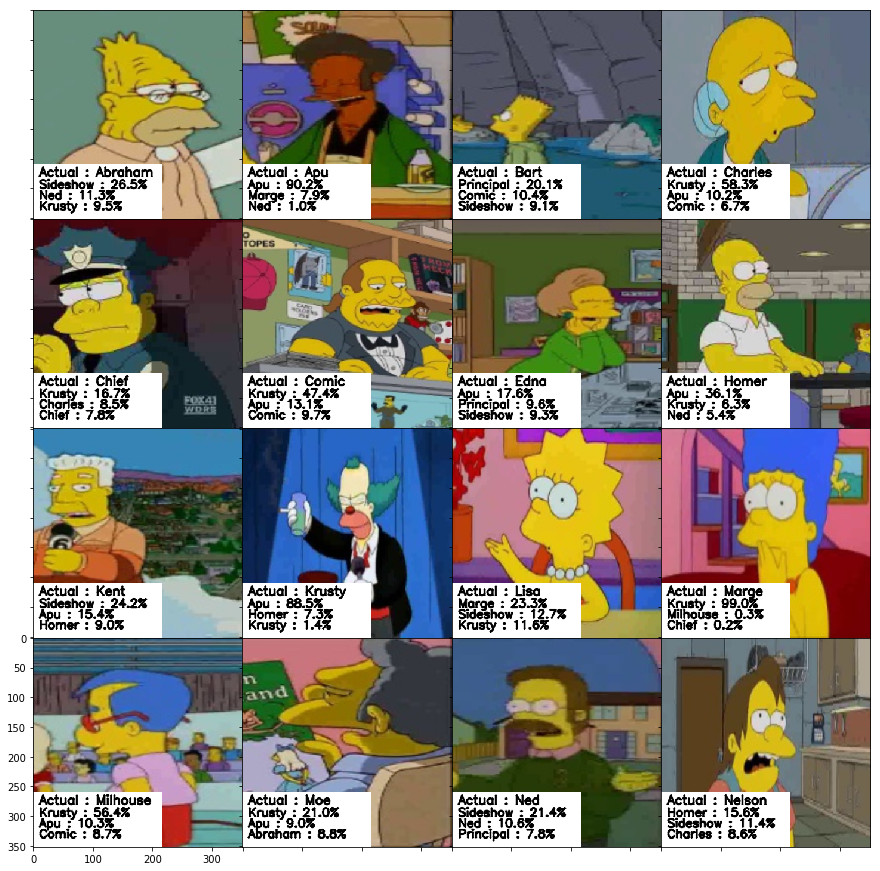

In [25]:
from keras.models import load_model
from mpl_toolkits.axes_grid1 import AxesGrid

model = load_model('simpson_with_data_aug.h5')

F = plt.figure(1, (15, 20))
grid = AxesGrid(F, 111, nrows_ncols=(4, 4), axes_pad=0, label_mode='1')

for i in range(16):
    char = map_characters[i]
    image = cv2.imread(np.random.choice(
        [k for k in glob.glob(os.path.join(test_imgs_path, '*.*')) if char in k]))
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pic = cv2.resize(image, (42, 42)).astype('float32') / 255.
    pic = pic.reshape(1, 42, 42, 3)[0]
    a = model.predict(pic.reshape(1, 42, 42,3))[0]
    actual = char.split('_')[0].title()
    
    text = sorted(['{:s} : {:.1f}%'.format(map_characters[k].split('_')[0].title(),
                                           100 * v) for k , v in enumerate(a)],
                  key=lambda x : float(x.split(':')[1].split('%')[0]), reverse=True)[:3]
    img = cv2.resize(img, (352, 352))
    cv2.rectangle(img, (0, 260), (215, 352), (255, 255, 255), -1)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img, 'Actual : %s' % actual, (10, 280), font, 0.7,(0,0,0),2,cv2.LINE_AA)
    for k, t in enumerate(text):
        cv2.putText(img, t,(10, 300+k*18), font, 0.65,(0,0,0),2,cv2.LINE_AA)
    grid[i].imshow(img)

plt.show()    

### all of the class predition

In [26]:
import sklearn

y_pred = model.predict(X_test)

print('\n', sklearn.metrics.classification_report(
    np.where(y_test > 0)[1],
    np.argmax(y_pred, axis=1),
    target_names=list(map_characters.values())), sep='')


                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.81      0.91      0.86       156
  apu_nahasapeemapetilon       0.96      0.92      0.94       106
            bart_simpson       0.80      0.81      0.81       194
charles_montgomery_burns       0.83      0.74      0.78       176
            chief_wiggum       0.91      0.88      0.90       156
          comic_book_guy       0.72      0.67      0.70        70
          edna_krabappel       0.96      0.67      0.79        79
           homer_simpson       0.88      0.78      0.83       334
           kent_brockman       0.90      0.89      0.90        91
        krusty_the_clown       0.91      0.95      0.93       161
            lisa_simpson       0.85      0.75      0.80       198
           marge_simpson       0.89      0.97      0.93       188
     milhouse_van_houten       0.85      0.91      0.88       141
             moe_szyslak       0.75      0.92      0.83       206
        